In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor, Pool

In [2]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

In [77]:
data = read_data('BTC')
#data = data.iloc[:len(data) // 2]


FileNotFoundError: [Errno 2] No such file or directory: 'BTC.csv'

In [84]:
data['log_ret'] *= 1_000_000

In [102]:
df = pd.read_csv('BTC.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

horizon = 100
df['grp'] = df.index // horizon

data = (
    df
    .groupby('grp', as_index=False)
    .agg({
        'date': 'first',
        'log_ret': 'sum'
    })
    .set_index('date')
)

print(data.head(10))


                     grp   log_ret
date                              
2018-01-01 18:00:00    0 -0.028508
2018-01-02 10:50:00    1  0.057414
2018-01-02 23:40:00    2 -0.000792
2018-01-03 12:05:00    3 -0.008551
2018-01-04 02:35:00    4 -0.004403
2018-01-04 13:50:00    5  0.038564
2018-01-05 04:20:00    6  0.022520
2018-01-05 15:05:00    7 -0.042797
2018-01-08 07:45:00    8 -0.002169
2018-01-08 23:20:00    9 -0.012514


In [159]:
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()

df_30 = df['log_ret'].resample('4H').sum().to_frame('log_ret')
data = df_30.loc[~(df_30 == 0).all(axis=1)]


# 3. Функция создания признаков
def make_features(data, pref=''):
    features = pd.DataFrame(index=data.index)
    # лаги
    for lag in [1, 2, 3, 5, 10]:
        features[f'lag_ret_{lag}'] = data['log_ret'].shift(lag)
    # скользящее среднее и std на 5 окон
    features['rolling_mean_5'] = data['log_ret'].rolling(5).mean()
    features['rolling_std_5']  = data['log_ret'].rolling(5).std()
    features['z_score']        = data['log_ret'] / (features['rolling_std_5'] + 1e-8)
    # моментум
    features['momentum_5']     = data['log_ret'].rolling(5).sum()
    features['log_ret_abs']    = data['log_ret'].abs()
    features['log_ret_squared']= data['log_ret']**2
    features['sign']           = np.sign(data['log_ret'])
    # волатильность через EWM
    features['absRet']  = features['log_ret_abs']
    features['EmaAbsRet'] = features['absRet'].ewm(span=20).mean().shift(1) * np.sqrt(20)
    features['vol']      = features['EmaAbsRet'].ewm(span=200).mean() * np.sqrt(200) + 1e-8
    features['normalized_log_ret'] = data['log_ret'] / features['vol']
    # фильтрованные скользящие средние по Ханну
    periods = np.logspace(1.0, 3.0, num=10).astype(int)
    for period in periods:
        features[f'f_{pref}{period}'] = (
            np.sqrt(period) *
            features['normalized_log_ret']
            .rolling(window=period, win_type='hann')
            .mean()
            .shift(1)
        )
    return features.dropna()

# 4. Построим признаки на resampled данных
features = make_features(df_30)

# 5. Выведем результат
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Признаки для 30-минутного ряда", dataframe=features_30.head(20))


/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_1363/1758260573.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_30 = df['log_ret'].resample('4H').sum().to_frame('log_ret')


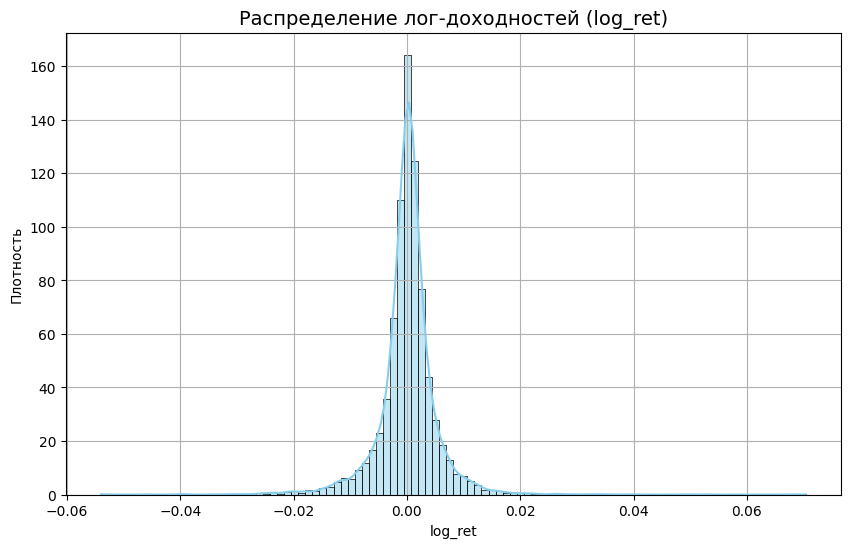

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Если у тебя уже есть DataFrame `df`:
plt.figure(figsize=(10, 6))
sns.histplot(data['log_ret'], bins=100, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Распределение лог-доходностей (log_ret)', fontsize=14)
plt.xlabel('log_ret')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()


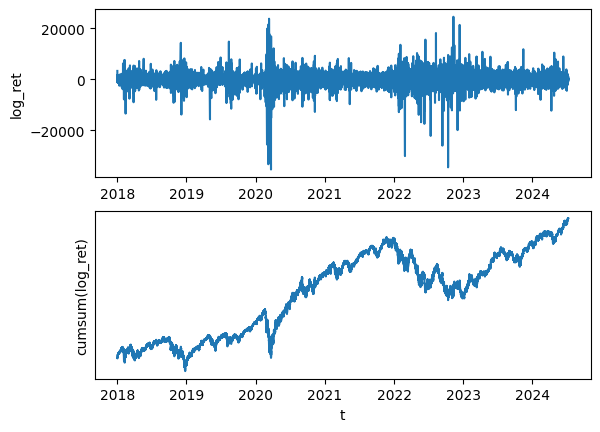

In [88]:
# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

In [104]:
days_in_year = 365.25

def Return(rets):
    return np.mean(rets)*days_in_year


def Volatility(rets):
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

In [105]:
def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)
    data = data.copy()

    for lag in [1, 2, 3, 5, 10]:
        features[f'lag_ret_{lag}'] = data['log_ret'].shift(lag)

    features['rolling_mean_5'] = data['log_ret'].rolling(5).mean()
    features['rolling_std_5'] = data['log_ret'].rolling(5).std()
    features['z_score'] = data['log_ret'] / (features['rolling_std_5'] + 1e-8)
    features['momentum_5'] = data['log_ret'].rolling(5).sum()
    features['log_ret_abs'] = data['log_ret'].abs()
    features['log_ret_squared'] = data['log_ret']**2
    features['sign'] = np.sign(data['log_ret'])

    # # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(1.0, 3.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)
    features = features.dropna()
    return features

In [106]:
features =  make_features(data)

[  10   16   27   46   77  129  215  359  599 1000]


In [91]:
print("log_ret mean after read_data:", data['log_ret'].mean())


log_ret mean after read_data: 19.565542646161926


In [162]:
y = features['normalized_log_ret'].values
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']].values

# This is another way to specify training and training periods
train_split_idx = int(0.6*X.shape[0])
validation_split_idx = int(0.8*X.shape[0])

features_train = features[:train_split_idx].copy()

X_train = X[:train_split_idx]
y_train = y[:train_split_idx]

X_validation = X[train_split_idx:validation_split_idx]
y_validation = y[train_split_idx:validation_split_idx]
features_validation = features[:validation_split_idx].copy()

X_test = X[validation_split_idx:]
y_test = y[validation_split_idx:]

train_pool = Pool(data = X_train,
                  label = y_train)

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(direction="maximize", sampler=sampler)

In [ ]:
# def objective(trial, debug = False):

#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
#         #"border_count": trial.suggest_int("border_count", 32, 254),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
#         "logging_level": "Silent"
#     }

#     model = CatBoostRegressor(**params, loss_function = 'RMSE')

#     model.fit(train_pool)

#     features_validation['position'] = model.predict(X_validation)/ (model.predict(X_train).std() + 1e-6)
#     # if model.predict(X_train).std() == 0:
#     #     return -100
#     #print(model.predict(X_train).std())
    
#     features_validation['position'] = features_validation['position'].ewm(alpha = 0.1).mean()
#     features_validation['position'] = features_validation['position'].fillna(0)

#     pos_limit = 100
#     features_validation.loc[features_validation.index[features_validation['position']>pos_limit], 'position'] = pos_limit
#     features_validation.loc[features_validation.index[features_validation['position']<-pos_limit], 'position'] = -pos_limit

#     slippage = 0.00001

#     eq = (data['log_ret']*features_validation['position']-slippage*features_validation['position'].diff().abs()
#          ).fillna(0)[train_split_idx:].resample('1D').agg('sum')
#     bh = data['log_ret'].fillna(0)[train_split_idx:].resample('1D').agg('sum')

#     stats = statistics_calc(eq, bh, plot = False)

#     if debug:
#         return stats['Sharpe ratio'].iloc[0], eq, bh
#     return stats['Sharpe ratio'].iloc[0]


In [86]:
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

def objective(trial, debug=False):
    # 1. Масштабируем фичи
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_validation)

    # 2. Гиперпараметры
    params = {
        "iterations": trial.suggest_int("iterations", 100, 600),
        "depth": trial.suggest_int("depth", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        "logging_level": "Silent"
    }

    # 3. Обучаем модель
    train_pool = Pool(X_train_scaled, y_train)
    model = CatBoostRegressor(**params, loss_function='RMSE')
    model.fit(train_pool)

    # 4. Прогнозируем
    val_preds = model.predict(X_val_scaled)

    # 5. Сигнал: позиция = прогноз / масштаб
    scale = np.max(np.abs(model.predict(X_train))) + 1e-6
    features_validation['position'] = val_preds / scale

    features_validation['position'] = features_validation['position'].ewm(alpha=0.1).mean()
    features_validation['position'] = features_validation['position'].fillna(0)
    features_validation['position'] = features_validation['position'].clip(-1000, 1000)

    # 6. Финансовые метрики
    slippage = 0.00001
    log_ret_val = data['log_ret'].loc[features_validation.index]
    pnl = (log_ret_val * features_validation['position'] -
           slippage * features_validation['position'].diff().abs()).fillna(0)
    equity = pnl.resample('1D').sum()
    bh = log_ret_val.fillna(0).resample('1D').sum()

    stats = statistics_calc(equity, bh, plot=debug)

    if debug:
        return stats['Sharpe ratio'].iloc[0], equity, bh, model
    return stats['Sharpe ratio'].iloc[0]


In [87]:
dummy_trial = optuna.trial.FixedTrial({
    "iterations": 200,
    "depth": 4,
    "learning_rate": 0.02,
    "l2_leaf_reg": 2,
    "bagging_temperature": 0.1,
    "random_strength": 0.3
})

sharpe, eq, bh, scaler = objective(dummy_trial, debug=True)
print(sharpe)
eq.plot(label='Strategy')
bh.plot(label='Buy & Hold')
plt.legend()
plt.show()

print(features_validation['position'])


KeyError: "[Timestamp('2018-02-21 10:50:00'), Timestamp('2018-02-21 13:20:00'), Timestamp('2018-02-21 14:10:00'), Timestamp('2018-02-21 15:00:00'), Timestamp('2018-02-21 15:50:00'), Timestamp('2018-02-21 16:50:00'), Timestamp('2018-02-21 18:35:00'), Timestamp('2018-02-21 19:25:00'), Timestamp('2018-02-21 20:15:00'), Timestamp('2018-02-21 21:05:00'), Timestamp('2018-02-21 21:55:00'), Timestamp('2018-02-21 22:45:00'), Timestamp('2018-02-21 23:35:00'), Timestamp('2018-02-22 00:25:00'), Timestamp('2018-02-22 01:15:00'), Timestamp('2018-02-22 02:05:00'), Timestamp('2018-02-22 02:55:00'), Timestamp('2018-02-22 03:45:00'), Timestamp('2018-02-22 04:35:00'), Timestamp('2018-02-22 05:25:00'), Timestamp('2018-02-22 06:15:00'), Timestamp('2018-02-22 07:05:00'), Timestamp('2018-02-22 07:55:00'), Timestamp('2018-02-22 08:45:00'), Timestamp('2018-02-22 09:35:00'), Timestamp('2018-02-22 10:25:00'), Timestamp('2018-02-22 11:15:00'), Timestamp('2018-02-22 12:05:00'), Timestamp('2018-02-22 12:55:00'), Timestamp('2018-02-22 14:35:00'), Timestamp('2018-02-22 15:25:00'), Timestamp('2018-02-22 16:15:00'), Timestamp('2018-02-22 18:10:00'), Timestamp('2018-02-22 19:00:00'), Timestamp('2018-02-22 19:50:00'), Timestamp('2018-02-22 20:40:00'), Timestamp('2018-02-22 22:20:00'), Timestamp('2018-02-22 23:10:00'), Timestamp('2018-02-23 00:00:00'), Timestamp('2018-02-23 00:50:00'), Timestamp('2018-02-23 01:40:00'), Timestamp('2018-02-23 02:30:00'), Timestamp('2018-02-23 03:20:00'), Timestamp('2018-02-23 04:10:00'), Timestamp('2018-02-23 05:00:00'), Timestamp('2018-02-23 05:50:00'), Timestamp('2018-02-23 06:40:00'), Timestamp('2018-02-23 07:30:00'), Timestamp('2018-02-23 08:20:00'), Timestamp('2018-02-23 09:10:00'), Timestamp('2018-02-23 10:00:00'), Timestamp('2018-02-23 10:50:00'), Timestamp('2018-02-23 11:40:00'), Timestamp('2018-02-23 12:30:00'), Timestamp('2018-02-23 13:20:00'), Timestamp('2018-02-23 14:10:00'), Timestamp('2018-02-23 15:00:00'), Timestamp('2018-02-23 15:50:00'), Timestamp('2018-02-23 16:50:00'), Timestamp('2018-02-25 18:35:00'), Timestamp('2018-02-25 19:25:00'), Timestamp('2018-02-25 20:15:00'), Timestamp('2018-02-25 21:05:00'), Timestamp('2018-02-25 21:55:00'), Timestamp('2018-02-25 22:45:00'), Timestamp('2018-02-25 23:35:00'), Timestamp('2018-02-26 00:25:00'), Timestamp('2018-02-26 01:15:00'), Timestamp('2018-02-26 02:05:00'), Timestamp('2018-02-26 02:55:00'), Timestamp('2018-02-26 03:45:00'), Timestamp('2018-02-26 04:35:00'), Timestamp('2018-02-26 05:25:00'), Timestamp('2018-02-26 06:15:00'), Timestamp('2018-02-26 07:05:00'), Timestamp('2018-02-26 07:55:00'), Timestamp('2018-02-26 08:45:00'), Timestamp('2018-02-26 09:35:00'), Timestamp('2018-02-26 10:25:00'), Timestamp('2018-02-26 11:15:00'), Timestamp('2018-02-26 12:05:00'), Timestamp('2018-02-26 12:55:00'), Timestamp('2018-02-26 13:45:00'), Timestamp('2018-02-26 14:35:00'), Timestamp('2018-02-26 15:25:00'), Timestamp('2018-02-26 16:15:00'), Timestamp('2018-02-26 18:10:00'), Timestamp('2018-02-26 19:00:00'), Timestamp('2018-02-26 19:50:00'), Timestamp('2018-02-26 20:40:00'), Timestamp('2018-02-26 21:30:00'), Timestamp('2018-02-26 22:20:00'), Timestamp('2018-02-26 23:10:00'), Timestamp('2018-02-27 00:00:00'), Timestamp('2018-02-27 00:50:00'), Timestamp('2018-02-27 01:40:00'), Timestamp('2018-02-27 02:30:00'), Timestamp('2018-02-27 03:20:00'), Timestamp('2018-02-27 04:10:00'), Timestamp('2018-02-27 05:00:00'), Timestamp('2018-02-27 06:40:00'), Timestamp('2018-02-27 07:30:00'), Timestamp('2018-02-27 08:20:00'), Timestamp('2018-02-27 10:00:00'), Timestamp('2018-02-27 10:50:00'), Timestamp('2018-02-27 11:40:00'), Timestamp('2018-02-27 12:30:00'), Timestamp('2018-02-27 13:20:00'), Timestamp('2018-02-27 14:10:00'), Timestamp('2018-02-27 15:00:00'), Timestamp('2018-02-27 15:50:00'), Timestamp('2018-02-27 16:50:00'), Timestamp('2018-02-27 18:35:00'), Timestamp('2018-02-27 19:25:00'), Timestamp('2018-02-27 20:15:00'), Timestamp('2018-02-27 21:05:00'), Timestamp('2018-02-27 21:55:00'), Timestamp('2018-02-27 23:35:00'), Timestamp('2018-02-28 00:25:00'), Timestamp('2018-02-28 01:15:00'), Timestamp('2018-02-28 02:05:00'), Timestamp('2018-02-28 02:55:00'), Timestamp('2018-02-28 03:45:00'), Timestamp('2018-02-28 04:35:00'), Timestamp('2018-02-28 05:25:00'), Timestamp('2018-02-28 06:15:00'), Timestamp('2018-02-28 07:05:00'), Timestamp('2018-02-28 07:55:00'), Timestamp('2018-02-28 08:45:00'), Timestamp('2018-02-28 09:35:00'), Timestamp('2018-02-28 10:25:00'), Timestamp('2018-02-28 11:15:00'), Timestamp('2018-02-28 12:05:00'), Timestamp('2018-02-28 12:55:00'), Timestamp('2018-02-28 13:45:00'), Timestamp('2018-02-28 14:35:00'), Timestamp('2018-02-28 15:25:00'), Timestamp('2018-02-28 18:10:00'), Timestamp('2018-02-28 19:00:00'), Timestamp('2018-02-28 19:50:00'), Timestamp('2018-02-28 21:30:00'), Timestamp('2018-02-28 22:20:00'), Timestamp('2018-02-28 23:10:00'), Timestamp('2018-03-01 00:00:00'), Timestamp('2018-03-01 00:50:00'), Timestamp('2018-03-01 01:40:00'), Timestamp('2018-03-01 02:30:00'), Timestamp('2018-03-01 03:20:00'), Timestamp('2018-03-01 04:10:00'), Timestamp('2018-03-01 05:00:00'), Timestamp('2018-03-01 05:50:00'), Timestamp('2018-03-01 06:40:00'), Timestamp('2018-03-01 07:30:00'), Timestamp('2018-03-01 08:20:00'), Timestamp('2018-03-01 09:10:00'), Timestamp('2018-03-01 10:00:00'), Timestamp('2018-03-01 10:50:00'), Timestamp('2018-03-01 11:40:00'), Timestamp('2018-03-01 12:30:00'), Timestamp('2018-03-01 13:20:00'), Timestamp('2018-03-01 14:10:00'), Timestamp('2018-03-01 15:50:00'), Timestamp('2018-03-01 16:50:00'), Timestamp('2018-03-01 18:35:00'), Timestamp('2018-03-01 19:25:00'), Timestamp('2018-03-01 20:15:00'), Timestamp('2018-03-01 21:05:00'), Timestamp('2018-03-01 21:55:00'), Timestamp('2018-03-01 22:45:00'), Timestamp('2018-03-01 23:35:00'), Timestamp('2018-03-02 01:15:00'), Timestamp('2018-03-02 02:05:00'), Timestamp('2018-03-02 02:55:00'), Timestamp('2018-03-02 03:45:00'), Timestamp('2018-03-02 04:35:00'), Timestamp('2018-03-02 05:25:00'), Timestamp('2018-03-02 06:15:00'), Timestamp('2018-03-02 07:05:00'), Timestamp('2018-03-02 07:55:00'), Timestamp('2018-03-02 08:45:00'), Timestamp('2018-03-02 09:35:00'), Timestamp('2018-03-02 10:25:00'), Timestamp('2018-03-02 11:15:00'), Timestamp('2018-03-02 12:05:00'), Timestamp('2018-03-02 12:55:00'), Timestamp('2018-03-02 13:45:00'), Timestamp('2018-03-02 14:35:00'), Timestamp('2018-03-02 15:25:00'), Timestamp('2018-03-02 16:15:00'), Timestamp('2018-03-04 18:10:00'), Timestamp('2018-03-04 19:00:00'), Timestamp('2018-03-04 19:50:00'), Timestamp('2018-03-04 20:40:00'), Timestamp('2018-03-04 21:30:00'), Timestamp('2018-03-04 22:20:00'), Timestamp('2018-03-04 23:10:00'), Timestamp('2018-03-05 00:00:00'), Timestamp('2018-03-05 00:50:00'), Timestamp('2018-03-05 01:40:00'), Timestamp('2018-03-05 02:30:00'), Timestamp('2018-03-05 03:20:00'), Timestamp('2018-03-05 04:10:00'), Timestamp('2018-03-05 05:00:00'), Timestamp('2018-03-05 05:50:00'), Timestamp('2018-03-05 06:40:00'), Timestamp('2018-03-05 07:30:00'), Timestamp('2018-03-05 08:20:00'), Timestamp('2018-03-05 09:10:00'), Timestamp('2018-03-05 10:00:00'), Timestamp('2018-03-05 10:50:00'), Timestamp('2018-03-05 11:40:00'), Timestamp('2018-03-05 12:30:00'), Timestamp('2018-03-05 13:20:00'), Timestamp('2018-03-05 14:10:00'), Timestamp('2018-03-05 15:00:00'), Timestamp('2018-03-05 15:50:00'), Timestamp('2018-03-05 16:50:00'), Timestamp('2018-03-05 18:35:00'), Timestamp('2018-03-05 19:25:00'), Timestamp('2018-03-05 20:15:00'), Timestamp('2018-03-05 21:05:00'), Timestamp('2018-03-05 21:55:00'), Timestamp('2018-03-05 22:45:00'), Timestamp('2018-03-05 23:35:00'), Timestamp('2018-03-06 00:25:00'), Timestamp('2018-03-06 01:15:00'), Timestamp('2018-03-06 02:05:00'), Timestamp('2018-03-06 02:55:00'), Timestamp('2018-03-06 03:45:00'), Timestamp('2018-03-06 05:25:00'), Timestamp('2018-03-06 06:15:00'), Timestamp('2018-03-06 07:05:00'), Timestamp('2018-03-06 07:55:00'), Timestamp('2018-03-06 08:45:00'), Timestamp('2018-03-06 09:35:00'), Timestamp('2018-03-06 10:25:00'), Timestamp('2018-03-06 18:10:00'), Timestamp('2018-03-06 19:00:00'), Timestamp('2018-03-06 19:50:00'), Timestamp('2018-03-06 20:40:00'), Timestamp('2018-03-06 21:30:00'), Timestamp('2018-03-06 22:20:00'), Timestamp('2018-03-06 23:10:00'), Timestamp('2018-03-07 00:00:00'), Timestamp('2018-03-07 00:50:00'), Timestamp('2018-03-07 01:40:00'), Timestamp('2018-03-07 02:30:00'), Timestamp('2018-03-07 03:20:00'), Timestamp('2018-03-07 04:10:00'), Timestamp('2018-03-07 05:00:00'), Timestamp('2018-03-07 05:50:00'), Timestamp('2018-03-07 06:40:00'), Timestamp('2018-03-07 07:30:00'), Timestamp('2018-03-07 08:20:00'), Timestamp('2018-03-07 09:10:00'), Timestamp('2018-03-07 10:00:00'), Timestamp('2018-03-07 10:50:00'), Timestamp('2018-03-07 11:40:00'), Timestamp('2018-03-07 12:30:00'), Timestamp('2018-03-07 13:20:00'), Timestamp('2018-03-07 14:10:00'), Timestamp('2018-03-07 15:00:00'), Timestamp('2018-03-07 15:50:00'), Timestamp('2018-03-07 16:50:00'), Timestamp('2018-03-07 18:35:00'), Timestamp('2018-03-07 19:25:00'), Timestamp('2018-03-07 20:15:00'), Timestamp('2018-03-07 21:05:00'), Timestamp('2018-03-07 21:55:00'), Timestamp('2018-03-07 22:45:00'), Timestamp('2018-03-07 23:35:00'), Timestamp('2018-03-08 00:25:00'), Timestamp('2018-03-08 01:20:00'), Timestamp('2018-03-08 03:00:00'), Timestamp('2018-03-08 03:50:00'), Timestamp('2018-03-08 04:40:00'), Timestamp('2018-03-08 05:35:00'), Timestamp('2018-03-08 06:25:00'), Timestamp('2018-03-08 07:15:00'), Timestamp('2018-03-08 08:05:00'), Timestamp('2018-03-08 08:55:00'), Timestamp('2018-03-08 09:45:00'), Timestamp('2018-03-08 10:35:00'), Timestamp('2018-03-08 11:25:00'), Timestamp('2018-03-08 12:15:00'), Timestamp('2018-03-08 13:05:00'), Timestamp('2018-03-08 13:55:00'), Timestamp('2018-03-08 14:45:00'), Timestamp('2018-03-08 15:35:00'), Timestamp('2018-03-08 16:35:00'), Timestamp('2018-03-08 18:20:00'), Timestamp('2018-03-08 19:10:00'), Timestamp('2018-03-08 20:00:00'), Timestamp('2018-03-08 20:50:00'), Timestamp('2018-03-08 21:40:00'), Timestamp('2018-03-08 22:30:00'), Timestamp('2018-03-08 23:20:00'), Timestamp('2018-03-09 00:10:00'), Timestamp('2018-03-09 01:00:00'), Timestamp('2018-03-09 01:50:00'), Timestamp('2018-03-09 02:40:00'), Timestamp('2018-03-09 03:30:00'), Timestamp('2018-03-09 04:20:00'), Timestamp('2018-03-09 05:10:00'), Timestamp('2018-03-09 06:00:00'), Timestamp('2018-03-09 06:50:00'), Timestamp('2018-03-09 07:40:00'), Timestamp('2018-03-09 08:30:00'), Timestamp('2018-03-09 09:20:00'), Timestamp('2018-03-09 10:10:00'), Timestamp('2018-03-09 11:00:00'), Timestamp('2018-03-09 11:50:00'), Timestamp('2018-03-09 12:40:00'), Timestamp('2018-03-09 13:30:00'), Timestamp('2018-03-09 14:20:00'), Timestamp('2018-03-09 15:10:00'), Timestamp('2018-03-09 16:00:00'), Timestamp('2018-03-09 17:00:00'), Timestamp('2018-03-11 18:45:00'), Timestamp('2018-03-11 19:35:00'), Timestamp('2018-03-11 20:25:00'), Timestamp('2018-03-11 21:15:00'), Timestamp('2018-03-11 22:05:00'), Timestamp('2018-03-11 22:55:00'), Timestamp('2018-03-11 23:45:00'), Timestamp('2018-03-12 00:35:00'), Timestamp('2018-03-12 01:25:00'), Timestamp('2018-03-12 02:15:00'), Timestamp('2018-03-12 03:05:00'), Timestamp('2018-03-12 04:45:00'), Timestamp('2018-03-12 05:35:00'), Timestamp('2018-03-12 06:25:00'), Timestamp('2018-03-12 07:15:00'), Timestamp('2018-03-12 08:55:00'), Timestamp('2018-03-12 09:45:00'), Timestamp('2018-03-12 10:35:00'), Timestamp('2018-03-12 11:25:00'), Timestamp('2018-03-12 12:15:00'), Timestamp('2018-03-12 13:05:00'), Timestamp('2018-03-12 13:55:00'), Timestamp('2018-03-12 14:45:00'), Timestamp('2018-03-12 15:35:00'), Timestamp('2018-03-12 16:35:00'), Timestamp('2018-03-12 18:20:00'), Timestamp('2018-03-12 19:10:00'), Timestamp('2018-03-12 20:00:00'), Timestamp('2018-03-12 20:50:00'), Timestamp('2018-03-12 21:40:00'), Timestamp('2018-03-12 22:30:00'), Timestamp('2018-03-12 23:20:00'), Timestamp('2018-03-13 00:10:00'), Timestamp('2018-03-13 01:00:00'), Timestamp('2018-03-13 01:50:00'), Timestamp('2018-03-13 02:40:00'), Timestamp('2018-03-13 03:30:00'), Timestamp('2018-03-13 04:20:00'), Timestamp('2018-03-13 06:00:00'), Timestamp('2018-03-13 06:50:00'), Timestamp('2018-03-13 07:40:00'), Timestamp('2018-03-13 08:30:00'), Timestamp('2018-03-13 09:20:00'), Timestamp('2018-03-13 10:10:00'), Timestamp('2018-03-13 11:00:00'), Timestamp('2018-03-13 11:50:00'), Timestamp('2018-03-13 12:40:00'), Timestamp('2018-03-13 13:30:00'), Timestamp('2018-03-13 14:20:00'), Timestamp('2018-03-13 15:10:00'), Timestamp('2018-03-13 16:00:00'), Timestamp('2018-03-13 17:00:00'), Timestamp('2018-03-13 18:45:00'), Timestamp('2018-03-13 19:35:00'), Timestamp('2018-03-13 20:25:00'), Timestamp('2018-03-13 21:15:00'), Timestamp('2018-03-13 22:05:00'), Timestamp('2018-03-13 22:55:00'), Timestamp('2018-03-13 23:45:00'), Timestamp('2018-03-14 00:35:00'), Timestamp('2018-03-14 01:25:00'), Timestamp('2018-03-14 02:15:00'), Timestamp('2018-03-14 03:05:00'), Timestamp('2018-03-14 03:55:00'), Timestamp('2018-03-14 04:45:00'), Timestamp('2018-03-14 05:35:00'), Timestamp('2018-03-14 06:25:00'), Timestamp('2018-03-14 07:15:00'), Timestamp('2018-03-14 08:05:00'), Timestamp('2018-03-14 08:55:00'), Timestamp('2018-03-14 09:45:00'), Timestamp('2018-03-14 10:35:00'), Timestamp('2018-03-14 11:25:00'), Timestamp('2018-03-14 12:15:00'), Timestamp('2018-03-14 13:05:00'), Timestamp('2018-03-14 13:55:00'), Timestamp('2018-03-14 14:45:00'), Timestamp('2018-03-14 15:35:00'), Timestamp('2018-03-14 16:35:00'), Timestamp('2018-03-14 19:10:00'), Timestamp('2018-03-14 20:00:00'), Timestamp('2018-03-14 20:50:00'), Timestamp('2018-03-14 21:40:00'), Timestamp('2018-03-14 22:30:00'), Timestamp('2018-03-14 23:20:00'), Timestamp('2018-03-15 00:10:00'), Timestamp('2018-03-15 01:00:00'), Timestamp('2018-03-15 01:50:00'), Timestamp('2018-03-15 02:40:00'), Timestamp('2018-03-15 03:30:00'), Timestamp('2018-03-15 04:20:00'), Timestamp('2018-03-15 05:10:00'), Timestamp('2018-03-15 06:00:00'), Timestamp('2018-03-15 06:50:00'), Timestamp('2018-03-15 07:40:00'), Timestamp('2018-03-15 08:30:00'), Timestamp('2018-03-15 09:20:00'), Timestamp('2018-03-15 10:10:00'), Timestamp('2018-03-15 11:00:00'), Timestamp('2018-03-15 11:50:00'), Timestamp('2018-03-15 12:40:00'), Timestamp('2018-03-15 13:30:00'), Timestamp('2018-03-15 14:20:00'), Timestamp('2018-03-15 15:10:00'), Timestamp('2018-03-15 16:00:00'), Timestamp('2018-03-15 17:00:00'), Timestamp('2018-03-15 19:35:00'), Timestamp('2018-03-15 20:25:00'), Timestamp('2018-03-15 21:15:00'), Timestamp('2018-03-15 22:05:00'), Timestamp('2018-03-15 22:55:00'), Timestamp('2018-03-15 23:45:00'), Timestamp('2018-03-16 00:35:00'), Timestamp('2018-03-16 01:25:00'), Timestamp('2018-03-16 02:15:00'), Timestamp('2018-03-16 03:05:00'), Timestamp('2018-03-16 03:55:00'), Timestamp('2018-03-16 04:45:00'), Timestamp('2018-03-16 05:35:00'), Timestamp('2018-03-16 06:25:00'), Timestamp('2018-03-16 07:15:00'), Timestamp('2018-03-16 08:05:00'), Timestamp('2018-03-16 16:35:00'), Timestamp('2018-03-18 22:30:00'), Timestamp('2018-03-18 23:20:00'), Timestamp('2018-03-19 00:10:00'), Timestamp('2018-03-19 01:00:00'), Timestamp('2018-03-19 01:50:00'), Timestamp('2018-03-19 02:40:00'), Timestamp('2018-03-19 04:20:00'), Timestamp('2018-03-19 05:10:00'), Timestamp('2018-03-19 06:00:00'), Timestamp('2018-03-19 06:50:00'), Timestamp('2018-03-19 07:40:00'), Timestamp('2018-03-19 08:30:00'), Timestamp('2018-03-19 09:20:00'), Timestamp('2018-03-19 10:10:00'), Timestamp('2018-03-19 11:00:00'), Timestamp('2018-03-19 11:50:00'), Timestamp('2018-03-19 12:40:00'), Timestamp('2018-03-19 13:30:00'), Timestamp('2018-03-19 14:20:00'), Timestamp('2018-03-19 15:10:00'), Timestamp('2018-03-19 16:00:00'), Timestamp('2018-03-19 17:00:00'), Timestamp('2018-03-19 18:45:00'), Timestamp('2018-03-19 19:35:00'), Timestamp('2018-03-19 20:25:00'), Timestamp('2018-03-19 21:15:00'), Timestamp('2018-03-19 22:05:00'), Timestamp('2018-03-19 22:55:00'), Timestamp('2018-03-19 23:45:00'), Timestamp('2018-03-20 00:35:00'), Timestamp('2018-03-20 01:25:00'), Timestamp('2018-03-20 02:15:00'), Timestamp('2018-03-20 05:35:00'), Timestamp('2018-03-20 06:25:00'), Timestamp('2018-03-20 07:15:00'), Timestamp('2018-03-20 08:05:00'), Timestamp('2018-03-20 08:55:00'), Timestamp('2018-03-20 09:45:00'), Timestamp('2018-03-20 10:35:00'), Timestamp('2018-03-20 11:25:00'), Timestamp('2018-03-20 12:15:00'), Timestamp('2018-03-20 13:05:00'), Timestamp('2018-03-20 13:55:00'), Timestamp('2018-03-20 14:45:00'), Timestamp('2018-03-20 15:35:00'), Timestamp('2018-03-20 16:35:00'), Timestamp('2018-03-20 18:20:00'), Timestamp('2018-03-20 19:10:00'), Timestamp('2018-03-20 20:00:00'), Timestamp('2018-03-20 21:40:00'), Timestamp('2018-03-20 22:30:00'), Timestamp('2018-03-20 23:20:00'), Timestamp('2018-03-21 00:10:00'), Timestamp('2018-03-21 01:00:00'), Timestamp('2018-03-21 01:50:00'), Timestamp('2018-03-21 02:40:00'), Timestamp('2018-03-21 03:30:00'), Timestamp('2018-03-21 04:20:00'), Timestamp('2018-03-21 05:10:00'), Timestamp('2018-03-21 06:00:00'), Timestamp('2018-03-21 06:50:00'), Timestamp('2018-03-21 08:30:00'), Timestamp('2018-03-21 09:20:00'), Timestamp('2018-03-21 10:10:00'), Timestamp('2018-03-21 11:00:00'), Timestamp('2018-03-21 11:50:00'), Timestamp('2018-03-21 12:40:00'), Timestamp('2018-03-21 13:30:00'), Timestamp('2018-03-21 14:20:00'), Timestamp('2018-03-21 15:10:00'), Timestamp('2018-03-21 16:00:00'), Timestamp('2018-03-21 17:00:00'), Timestamp('2018-03-21 18:45:00'), Timestamp('2018-03-21 19:35:00'), Timestamp('2018-03-21 20:25:00'), Timestamp('2018-03-21 21:15:00'), Timestamp('2018-03-21 22:05:00'), Timestamp('2018-03-21 22:55:00'), Timestamp('2018-03-21 23:45:00'), Timestamp('2018-03-22 00:35:00'), Timestamp('2018-03-22 01:25:00'), Timestamp('2018-03-22 02:15:00'), Timestamp('2018-03-22 03:05:00'), Timestamp('2018-03-22 03:55:00'), Timestamp('2018-03-22 04:45:00'), Timestamp('2018-03-22 05:35:00'), Timestamp('2018-03-22 06:25:00'), Timestamp('2018-03-22 07:15:00'), Timestamp('2018-03-22 08:05:00'), Timestamp('2018-03-22 08:55:00'), Timestamp('2018-03-22 09:45:00'), Timestamp('2018-03-22 10:35:00'), Timestamp('2018-03-22 11:25:00'), Timestamp('2018-03-22 12:15:00'), Timestamp('2018-03-22 13:05:00'), Timestamp('2018-03-22 13:55:00'), Timestamp('2018-03-22 14:45:00'), Timestamp('2018-03-22 15:35:00'), Timestamp('2018-03-22 16:35:00'), Timestamp('2018-03-22 18:20:00'), Timestamp('2018-03-22 19:10:00'), Timestamp('2018-03-22 20:00:00'), Timestamp('2018-03-22 20:50:00'), Timestamp('2018-03-22 21:40:00'), Timestamp('2018-03-22 22:30:00'), Timestamp('2018-03-22 23:20:00'), Timestamp('2018-03-23 00:10:00'), Timestamp('2018-03-23 01:00:00'), Timestamp('2018-03-23 01:50:00'), Timestamp('2018-03-23 02:40:00'), Timestamp('2018-03-23 03:30:00'), Timestamp('2018-03-23 04:20:00'), Timestamp('2018-03-23 05:10:00'), Timestamp('2018-03-23 06:00:00'), Timestamp('2018-03-23 06:50:00'), Timestamp('2018-03-23 07:40:00'), Timestamp('2018-03-23 17:00:00'), Timestamp('2018-03-25 18:45:00'), Timestamp('2018-03-25 19:35:00'), Timestamp('2018-03-25 20:25:00'), Timestamp('2018-03-25 21:15:00'), Timestamp('2018-03-25 22:05:00'), Timestamp('2018-03-25 22:55:00'), Timestamp('2018-03-25 23:45:00'), Timestamp('2018-03-26 00:35:00'), Timestamp('2018-03-26 01:25:00'), Timestamp('2018-03-26 02:15:00'), Timestamp('2018-03-26 03:05:00'), Timestamp('2018-03-26 03:55:00'), Timestamp('2018-03-26 04:45:00'), Timestamp('2018-03-26 05:35:00'), Timestamp('2018-03-26 06:25:00'), Timestamp('2018-03-26 12:15:00'), Timestamp('2018-03-26 13:05:00'), Timestamp('2018-03-26 13:55:00'), Timestamp('2018-03-26 14:45:00'), Timestamp('2018-03-26 15:35:00'), Timestamp('2018-03-26 18:20:00'), Timestamp('2018-03-26 19:10:00'), Timestamp('2018-03-26 20:00:00'), Timestamp('2018-03-26 20:50:00'), Timestamp('2018-03-26 21:40:00'), Timestamp('2018-03-26 22:30:00'), Timestamp('2018-03-26 23:20:00'), Timestamp('2018-03-27 00:10:00'), Timestamp('2018-03-27 01:00:00'), Timestamp('2018-03-27 01:50:00'), Timestamp('2018-03-27 02:40:00'), Timestamp('2018-03-27 03:30:00'), Timestamp('2018-03-27 04:20:00'), Timestamp('2018-03-27 05:10:00'), Timestamp('2018-03-27 06:00:00'), Timestamp('2018-03-27 06:50:00'), Timestamp('2018-03-27 07:40:00'), Timestamp('2018-03-27 08:30:00'), Timestamp('2018-03-27 09:20:00'), Timestamp('2018-03-27 10:10:00'), Timestamp('2018-03-27 11:00:00'), Timestamp('2018-03-27 11:50:00'), Timestamp('2018-03-27 12:40:00'), Timestamp('2018-03-27 13:30:00'), Timestamp('2018-03-27 14:20:00'), Timestamp('2018-03-27 15:10:00'), Timestamp('2018-03-27 16:00:00'), Timestamp('2018-03-27 17:00:00'), Timestamp('2018-03-27 18:45:00'), Timestamp('2018-03-27 19:35:00'), Timestamp('2018-03-27 20:25:00'), Timestamp('2018-03-27 21:15:00'), Timestamp('2018-03-27 22:05:00'), Timestamp('2018-03-27 22:55:00'), Timestamp('2018-03-27 23:45:00'), Timestamp('2018-03-28 00:35:00'), Timestamp('2018-03-28 01:25:00'), Timestamp('2018-03-28 02:15:00'), Timestamp('2018-03-28 03:05:00'), Timestamp('2018-03-28 04:45:00'), Timestamp('2018-03-28 05:35:00'), Timestamp('2018-03-28 06:25:00'), Timestamp('2018-03-28 07:15:00'), Timestamp('2018-03-28 08:05:00'), Timestamp('2018-03-28 08:55:00'), Timestamp('2018-03-28 09:45:00'), Timestamp('2018-03-28 10:35:00'), Timestamp('2018-03-28 11:25:00'), Timestamp('2018-03-28 12:15:00'), Timestamp('2018-03-28 13:05:00'), Timestamp('2018-03-28 13:55:00'), Timestamp('2018-03-28 14:45:00'), Timestamp('2018-03-28 15:35:00'), Timestamp('2018-03-28 16:35:00'), Timestamp('2018-03-28 18:20:00'), Timestamp('2018-03-28 19:10:00'), Timestamp('2018-03-28 20:00:00'), Timestamp('2018-03-28 20:50:00'), Timestamp('2018-03-28 21:40:00'), Timestamp('2018-03-28 22:30:00'), Timestamp('2018-03-28 23:20:00'), Timestamp('2018-03-29 00:10:00'), Timestamp('2018-03-29 01:00:00'), Timestamp('2018-03-29 01:50:00'), Timestamp('2018-03-29 02:40:00'), Timestamp('2018-03-29 03:30:00'), Timestamp('2018-03-29 04:20:00'), Timestamp('2018-03-29 05:10:00'), Timestamp('2018-03-29 06:00:00'), Timestamp('2018-03-29 06:50:00'), Timestamp('2018-03-29 11:00:00'), Timestamp('2018-03-29 11:50:00'), Timestamp('2018-03-29 12:40:00'), Timestamp('2018-03-29 13:30:00'), Timestamp('2018-03-29 14:20:00'), Timestamp('2018-03-29 15:10:00'), Timestamp('2018-03-29 16:00:00'), Timestamp('2018-03-29 17:00:00'), Timestamp('2018-04-01 18:45:00'), Timestamp('2018-04-01 19:35:00'), Timestamp('2018-04-01 20:25:00'), Timestamp('2018-04-01 21:15:00'), Timestamp('2018-04-01 22:05:00'), Timestamp('2018-04-01 22:55:00'), Timestamp('2018-04-01 23:45:00'), Timestamp('2018-04-02 00:35:00'), Timestamp('2018-04-02 01:25:00'), Timestamp('2018-04-02 02:15:00'), Timestamp('2018-04-02 03:05:00'), Timestamp('2018-04-02 03:55:00'), Timestamp('2018-04-02 04:45:00'), Timestamp('2018-04-02 05:35:00'), Timestamp('2018-04-02 06:25:00'), Timestamp('2018-04-02 07:15:00'), Timestamp('2018-04-02 08:05:00'), Timestamp('2018-04-02 08:55:00'), Timestamp('2018-04-02 09:45:00'), Timestamp('2018-04-02 10:35:00'), Timestamp('2018-04-02 11:25:00'), Timestamp('2018-04-02 12:15:00'), Timestamp('2018-04-02 13:05:00'), Timestamp('2018-04-02 13:55:00'), Timestamp('2018-04-02 14:45:00'), Timestamp('2018-04-02 16:35:00'), Timestamp('2018-04-02 18:20:00'), Timestamp('2018-04-02 19:10:00'), Timestamp('2018-04-02 20:00:00'), Timestamp('2018-04-02 20:50:00'), Timestamp('2018-04-02 21:40:00'), Timestamp('2018-04-02 22:30:00'), Timestamp('2018-04-02 23:20:00'), Timestamp('2018-04-03 00:10:00'), Timestamp('2018-04-03 01:00:00'), Timestamp('2018-04-03 01:50:00'), Timestamp('2018-04-03 02:40:00'), Timestamp('2018-04-03 03:30:00'), Timestamp('2018-04-03 04:20:00'), Timestamp('2018-04-03 05:10:00'), Timestamp('2018-04-03 06:00:00'), Timestamp('2018-04-03 06:50:00'), Timestamp('2018-04-03 07:40:00'), Timestamp('2018-04-03 08:30:00'), Timestamp('2018-04-03 09:20:00'), Timestamp('2018-04-03 11:00:00'), Timestamp('2018-04-03 11:50:00'), Timestamp('2018-04-03 12:40:00'), Timestamp('2018-04-03 13:30:00'), Timestamp('2018-04-03 14:20:00'), Timestamp('2018-04-03 15:10:00'), Timestamp('2018-04-03 16:00:00'), Timestamp('2018-04-03 17:00:00'), Timestamp('2018-04-03 18:45:00'), Timestamp('2018-04-03 19:35:00'), Timestamp('2018-04-03 20:25:00'), Timestamp('2018-04-03 21:15:00'), Timestamp('2018-04-03 22:05:00'), Timestamp('2018-04-03 22:55:00'), Timestamp('2018-04-03 23:45:00'), Timestamp('2018-04-04 00:35:00'), Timestamp('2018-04-04 01:25:00'), Timestamp('2018-04-04 02:15:00'), Timestamp('2018-04-04 03:05:00'), Timestamp('2018-04-04 04:45:00'), Timestamp('2018-04-04 05:35:00'), Timestamp('2018-04-04 06:25:00'), Timestamp('2018-04-04 07:15:00'), Timestamp('2018-04-04 08:05:00'), Timestamp('2018-04-04 08:55:00'), Timestamp('2018-04-04 09:45:00'), Timestamp('2018-04-04 10:35:00'), Timestamp('2018-04-04 11:25:00'), Timestamp('2018-04-04 12:15:00'), Timestamp('2018-04-04 13:05:00'), Timestamp('2018-04-04 13:55:00'), Timestamp('2018-04-04 14:45:00'), Timestamp('2018-04-04 15:35:00'), Timestamp('2018-04-04 20:00:00'), Timestamp('2018-04-04 20:50:00'), Timestamp('2018-04-04 21:40:00'), Timestamp('2018-04-04 22:30:00'), Timestamp('2018-04-04 23:20:00'), Timestamp('2018-04-05 00:10:00'), Timestamp('2018-04-05 01:00:00'), Timestamp('2018-04-05 01:50:00'), Timestamp('2018-04-05 02:40:00'), Timestamp('2018-04-05 03:30:00'), Timestamp('2018-04-05 04:20:00'), Timestamp('2018-04-05 05:10:00'), Timestamp('2018-04-05 06:00:00'), Timestamp('2018-04-05 06:50:00'), Timestamp('2018-04-05 07:40:00'), Timestamp('2018-04-05 08:30:00'), Timestamp('2018-04-05 09:20:00'), Timestamp('2018-04-05 10:10:00'), Timestamp('2018-04-05 11:00:00'), Timestamp('2018-04-05 11:50:00'), Timestamp('2018-04-05 12:40:00'), Timestamp('2018-04-05 13:30:00'), Timestamp('2018-04-05 14:20:00'), Timestamp('2018-04-05 15:10:00'), Timestamp('2018-04-05 16:00:00'), Timestamp('2018-04-05 17:00:00'), Timestamp('2018-04-05 18:45:00'), Timestamp('2018-04-05 19:35:00'), Timestamp('2018-04-05 20:25:00'), Timestamp('2018-04-05 21:15:00'), Timestamp('2018-04-05 22:05:00'), Timestamp('2018-04-05 22:55:00'), Timestamp('2018-04-05 23:45:00'), Timestamp('2018-04-06 00:35:00'), Timestamp('2018-04-06 01:25:00'), Timestamp('2018-04-06 02:15:00'), Timestamp('2018-04-06 03:05:00'), Timestamp('2018-04-06 03:55:00'), Timestamp('2018-04-06 04:45:00'), Timestamp('2018-04-06 05:35:00'), Timestamp('2018-04-06 06:25:00'), Timestamp('2018-04-06 07:15:00'), Timestamp('2018-04-06 08:05:00'), Timestamp('2018-04-06 08:55:00'), Timestamp('2018-04-06 09:45:00'), Timestamp('2018-04-06 10:35:00'), Timestamp('2018-04-06 11:25:00'), Timestamp('2018-04-06 12:15:00'), Timestamp('2018-04-06 13:05:00'), Timestamp('2018-04-06 13:55:00'), Timestamp('2018-04-06 14:45:00'), Timestamp('2018-04-06 15:35:00'), Timestamp('2018-04-06 16:35:00'), Timestamp('2018-04-08 18:20:00'), Timestamp('2018-04-08 19:10:00'), Timestamp('2018-04-08 20:00:00'), Timestamp('2018-04-08 20:50:00'), Timestamp('2018-04-08 21:40:00'), Timestamp('2018-04-08 22:30:00'), Timestamp('2018-04-09 00:10:00'), Timestamp('2018-04-09 01:00:00'), Timestamp('2018-04-09 01:50:00'), Timestamp('2018-04-09 02:40:00'), Timestamp('2018-04-09 03:30:00'), Timestamp('2018-04-09 04:20:00'), Timestamp('2018-04-09 05:10:00'), Timestamp('2018-04-09 06:00:00'), Timestamp('2018-04-09 06:50:00'), Timestamp('2018-04-09 07:40:00'), Timestamp('2018-04-09 08:30:00'), Timestamp('2018-04-09 09:20:00'), Timestamp('2018-04-09 10:10:00'), Timestamp('2018-04-09 11:00:00'), Timestamp('2018-04-09 11:50:00'), Timestamp('2018-04-09 12:40:00'), Timestamp('2018-04-09 14:20:00'), Timestamp('2018-04-09 15:10:00'), Timestamp('2018-04-09 16:00:00'), Timestamp('2018-04-09 17:00:00'), Timestamp('2018-04-09 18:45:00'), Timestamp('2018-04-09 19:35:00'), Timestamp('2018-04-09 20:25:00'), Timestamp('2018-04-09 21:15:00'), Timestamp('2018-04-09 22:05:00'), Timestamp('2018-04-09 22:55:00'), Timestamp('2018-04-09 23:45:00'), Timestamp('2018-04-10 00:35:00'), Timestamp('2018-04-10 01:25:00'), Timestamp('2018-04-10 02:15:00'), Timestamp('2018-04-10 03:05:00'), Timestamp('2018-04-10 04:45:00'), Timestamp('2018-04-10 05:35:00'), Timestamp('2018-04-10 06:25:00'), Timestamp('2018-04-10 07:15:00'), Timestamp('2018-04-10 08:05:00'), Timestamp('2018-04-10 08:55:00'), Timestamp('2018-04-10 11:25:00'), Timestamp('2018-04-10 12:15:00'), Timestamp('2018-04-10 13:05:00'), Timestamp('2018-04-10 13:55:00'), Timestamp('2018-04-10 14:45:00'), Timestamp('2018-04-10 15:35:00'), Timestamp('2018-04-10 16:35:00'), Timestamp('2018-04-10 18:20:00'), Timestamp('2018-04-10 19:10:00'), Timestamp('2018-04-10 20:00:00'), Timestamp('2018-04-10 21:40:00'), Timestamp('2018-04-10 22:30:00'), Timestamp('2018-04-10 23:20:00'), Timestamp('2018-04-11 00:10:00'), Timestamp('2018-04-11 01:00:00'), Timestamp('2018-04-11 01:50:00'), Timestamp('2018-04-11 02:40:00'), Timestamp('2018-04-11 03:30:00'), Timestamp('2018-04-11 04:20:00'), Timestamp('2018-04-11 05:10:00'), Timestamp('2018-04-11 06:00:00'), Timestamp('2018-04-11 07:40:00'), Timestamp('2018-04-11 08:30:00'), Timestamp('2018-04-11 09:20:00'), Timestamp('2018-04-11 10:10:00'), Timestamp('2018-04-11 11:00:00'), Timestamp('2018-04-11 11:50:00'), Timestamp('2018-04-11 12:40:00'), Timestamp('2018-04-11 13:30:00'), Timestamp('2018-04-11 14:20:00'), Timestamp('2018-04-11 15:10:00'), Timestamp('2018-04-11 16:00:00'), Timestamp('2018-04-11 17:00:00'), Timestamp('2018-04-11 18:45:00'), Timestamp('2018-04-11 19:35:00'), Timestamp('2018-04-11 20:25:00'), Timestamp('2018-04-11 21:15:00'), Timestamp('2018-04-11 22:05:00'), Timestamp('2018-04-12 00:35:00'), Timestamp('2018-04-12 01:25:00'), Timestamp('2018-04-12 02:15:00'), Timestamp('2018-04-12 03:05:00'), Timestamp('2018-04-12 03:55:00'), Timestamp('2018-04-12 04:45:00'), Timestamp('2018-04-12 05:35:00'), Timestamp('2018-04-12 06:25:00'), Timestamp('2018-04-12 07:15:00'), Timestamp('2018-04-12 08:05:00'), Timestamp('2018-04-12 08:55:00'), Timestamp('2018-04-12 09:45:00'), Timestamp('2018-04-12 10:35:00'), Timestamp('2018-04-12 11:25:00'), Timestamp('2018-04-12 12:15:00'), Timestamp('2018-04-12 13:05:00'), Timestamp('2018-04-12 13:55:00'), Timestamp('2018-04-12 14:45:00'), Timestamp('2018-04-12 15:35:00'), Timestamp('2018-04-12 16:35:00'), Timestamp('2018-04-12 18:20:00'), Timestamp('2018-04-12 19:10:00'), Timestamp('2018-04-12 20:00:00'), Timestamp('2018-04-12 20:50:00'), Timestamp('2018-04-12 21:40:00'), Timestamp('2018-04-12 22:30:00'), Timestamp('2018-04-12 23:20:00'), Timestamp('2018-04-13 00:10:00'), Timestamp('2018-04-13 01:00:00'), Timestamp('2018-04-13 01:50:00'), Timestamp('2018-04-13 11:50:00'), Timestamp('2018-04-13 12:40:00'), Timestamp('2018-04-13 13:30:00'), Timestamp('2018-04-13 14:20:00'), Timestamp('2018-04-13 15:10:00'), Timestamp('2018-04-13 16:00:00'), Timestamp('2018-04-15 18:45:00'), Timestamp('2018-04-15 19:35:00'), Timestamp('2018-04-15 20:25:00'), Timestamp('2018-04-15 21:15:00'), Timestamp('2018-04-15 22:05:00'), Timestamp('2018-04-15 22:55:00'), Timestamp('2018-04-15 23:45:00'), Timestamp('2018-04-16 00:35:00'), Timestamp('2018-04-16 01:25:00'), Timestamp('2018-04-16 02:15:00'), Timestamp('2018-04-16 03:05:00'), Timestamp('2018-04-16 03:55:00'), Timestamp('2018-04-16 04:45:00'), Timestamp('2018-04-16 05:35:00'), Timestamp('2018-04-16 06:25:00'), Timestamp('2018-04-16 07:15:00'), Timestamp('2018-04-16 08:05:00'), Timestamp('2018-04-16 08:55:00'), Timestamp('2018-04-16 09:45:00'), Timestamp('2018-04-16 10:35:00'), Timestamp('2018-04-16 11:25:00'), Timestamp('2018-04-16 12:15:00'), Timestamp('2018-04-16 13:05:00'), Timestamp('2018-04-16 13:55:00'), Timestamp('2018-04-16 14:45:00'), Timestamp('2018-04-16 15:35:00'), Timestamp('2018-04-16 16:35:00'), Timestamp('2018-04-16 18:20:00'), Timestamp('2018-04-16 19:10:00'), Timestamp('2018-04-16 20:00:00'), Timestamp('2018-04-16 20:50:00'), Timestamp('2018-04-16 21:40:00'), Timestamp('2018-04-16 22:30:00'), Timestamp('2018-04-16 23:20:00'), Timestamp('2018-04-17 00:10:00'), Timestamp('2018-04-17 01:00:00'), Timestamp('2018-04-17 01:50:00'), Timestamp('2018-04-17 02:40:00'), Timestamp('2018-04-17 03:30:00'), Timestamp('2018-04-17 04:20:00'), Timestamp('2018-04-17 05:10:00'), Timestamp('2018-04-17 06:00:00'), Timestamp('2018-04-17 06:50:00'), Timestamp('2018-04-17 08:30:00'), Timestamp('2018-04-17 09:20:00'), Timestamp('2018-04-17 10:10:00'), Timestamp('2018-04-17 11:00:00'), Timestamp('2018-04-17 11:50:00'), Timestamp('2018-04-17 12:40:00'), Timestamp('2018-04-17 13:30:00'), Timestamp('2018-04-17 14:20:00'), Timestamp('2018-04-17 15:10:00'), Timestamp('2018-04-17 16:00:00'), Timestamp('2018-04-17 17:00:00'), Timestamp('2018-04-17 19:35:00'), Timestamp('2018-04-17 20:25:00'), Timestamp('2018-04-17 21:15:00'), Timestamp('2018-04-17 22:05:00'), Timestamp('2018-04-17 22:55:00'), Timestamp('2018-04-17 23:45:00'), Timestamp('2018-04-18 00:35:00'), Timestamp('2018-04-18 01:25:00'), Timestamp('2018-04-18 02:15:00'), Timestamp('2018-04-18 03:05:00'), Timestamp('2018-04-18 06:25:00'), Timestamp('2018-04-18 07:15:00'), Timestamp('2018-04-18 08:55:00'), Timestamp('2018-04-18 09:45:00'), Timestamp('2018-04-18 10:35:00'), Timestamp('2018-04-18 11:25:00'), Timestamp('2018-04-18 12:15:00'), Timestamp('2018-04-18 13:05:00'), Timestamp('2018-04-18 13:55:00'), Timestamp('2018-04-18 14:45:00'), Timestamp('2018-04-18 15:35:00'), Timestamp('2018-04-18 16:35:00'), Timestamp('2018-04-18 18:20:00'), Timestamp('2018-04-18 19:10:00'), Timestamp('2018-04-18 20:00:00'), Timestamp('2018-04-18 21:40:00'), Timestamp('2018-04-18 22:30:00'), Timestamp('2018-04-18 23:20:00'), Timestamp('2018-04-19 00:10:00'), Timestamp('2018-04-19 01:00:00'), Timestamp('2018-04-19 01:50:00'), Timestamp('2018-04-19 02:40:00'), Timestamp('2018-04-19 04:20:00'), Timestamp('2018-04-19 05:10:00'), Timestamp('2018-04-19 06:00:00'), Timestamp('2018-04-19 06:50:00'), Timestamp('2018-04-19 07:40:00'), Timestamp('2018-04-19 08:30:00'), Timestamp('2018-04-19 09:20:00'), Timestamp('2018-04-19 10:10:00'), Timestamp('2018-04-19 11:00:00'), Timestamp('2018-04-19 11:50:00'), Timestamp('2018-04-19 12:40:00'), Timestamp('2018-04-19 13:30:00'), Timestamp('2018-04-19 14:20:00'), Timestamp('2018-04-19 15:10:00'), Timestamp('2018-04-19 16:00:00'), Timestamp('2018-04-19 17:00:00'), Timestamp('2018-04-19 18:45:00'), Timestamp('2018-04-19 19:35:00'), Timestamp('2018-04-19 20:25:00'), Timestamp('2018-04-19 21:15:00'), Timestamp('2018-04-19 22:05:00'), Timestamp('2018-04-19 22:55:00'), Timestamp('2018-04-19 23:45:00'), Timestamp('2018-04-20 00:35:00'), Timestamp('2018-04-20 01:25:00'), Timestamp('2018-04-20 02:15:00'), Timestamp('2018-04-20 03:05:00'), Timestamp('2018-04-20 03:55:00'), Timestamp('2018-04-20 04:45:00'), Timestamp('2018-04-20 05:35:00'), Timestamp('2018-04-20 06:25:00'), Timestamp('2018-04-20 07:15:00'), Timestamp('2018-04-20 08:05:00'), Timestamp('2018-04-20 08:55:00'), Timestamp('2018-04-20 09:45:00'), Timestamp('2018-04-20 10:35:00'), Timestamp('2018-04-20 11:25:00'), Timestamp('2018-04-20 12:15:00'), Timestamp('2018-04-20 13:05:00'), Timestamp('2018-04-20 13:55:00'), Timestamp('2018-04-20 16:35:00'), Timestamp('2018-04-22 18:20:00'), Timestamp('2018-04-22 20:00:00'), Timestamp('2018-04-22 20:50:00'), Timestamp('2018-04-22 21:40:00'), Timestamp('2018-04-22 22:30:00'), Timestamp('2018-04-22 23:20:00'), Timestamp('2018-04-23 00:10:00'), Timestamp('2018-04-23 01:00:00'), Timestamp('2018-04-23 01:50:00'), Timestamp('2018-04-23 02:40:00'), Timestamp('2018-04-23 03:30:00'), Timestamp('2018-04-23 04:20:00'), Timestamp('2018-04-23 05:10:00'), Timestamp('2018-04-23 06:00:00'), Timestamp('2018-04-23 06:50:00'), Timestamp('2018-04-23 07:40:00'), Timestamp('2018-04-23 08:30:00'), Timestamp('2018-04-23 09:20:00'), Timestamp('2018-04-23 10:10:00'), Timestamp('2018-04-23 11:00:00'), Timestamp('2018-04-23 11:50:00'), Timestamp('2018-04-23 12:40:00'), Timestamp('2018-04-23 13:30:00'), Timestamp('2018-04-23 14:20:00'), Timestamp('2018-04-23 15:10:00'), Timestamp('2018-04-23 16:00:00'), Timestamp('2018-04-23 17:00:00'), Timestamp('2018-04-23 18:45:00'), Timestamp('2018-04-23 19:35:00'), Timestamp('2018-04-23 20:25:00'), Timestamp('2018-04-23 21:15:00'), Timestamp('2018-04-23 22:05:00'), Timestamp('2018-04-23 22:55:00'), Timestamp('2018-04-23 23:45:00'), Timestamp('2018-04-24 00:35:00'), Timestamp('2018-04-24 02:15:00'), Timestamp('2018-04-24 03:05:00'), Timestamp('2018-04-24 03:55:00'), Timestamp('2018-04-24 04:45:00'), Timestamp('2018-04-24 05:35:00'), Timestamp('2018-04-24 06:25:00'), Timestamp('2018-04-24 07:15:00'), Timestamp('2018-04-24 08:05:00'), Timestamp('2018-04-24 08:55:00'), Timestamp('2018-04-24 09:45:00'), Timestamp('2018-04-24 10:35:00'), Timestamp('2018-04-24 11:25:00'), Timestamp('2018-04-24 12:15:00'), Timestamp('2018-04-24 13:05:00'), Timestamp('2018-04-24 13:55:00'), Timestamp('2018-04-24 14:45:00'), Timestamp('2018-04-24 15:35:00'), Timestamp('2018-04-24 16:35:00'), Timestamp('2018-04-24 18:20:00'), Timestamp('2018-04-24 19:10:00'), Timestamp('2018-04-24 20:00:00'), Timestamp('2018-04-24 20:50:00'), Timestamp('2018-04-24 21:40:00'), Timestamp('2018-04-24 22:30:00'), Timestamp('2018-04-24 23:20:00'), Timestamp('2018-04-25 00:10:00'), Timestamp('2018-04-25 01:00:00'), Timestamp('2018-04-25 01:50:00'), Timestamp('2018-04-25 02:40:00'), Timestamp('2018-04-25 03:30:00'), Timestamp('2018-04-25 04:20:00'), Timestamp('2018-04-25 05:10:00'), Timestamp('2018-04-25 06:00:00'), Timestamp('2018-04-25 06:50:00'), Timestamp('2018-04-25 07:40:00'), Timestamp('2018-04-25 08:30:00'), Timestamp('2018-04-25 09:20:00'), Timestamp('2018-04-25 10:10:00'), Timestamp('2018-04-25 11:00:00'), Timestamp('2018-04-25 11:50:00'), Timestamp('2018-04-25 12:40:00'), Timestamp('2018-04-25 13:30:00'), Timestamp('2018-04-25 14:20:00'), Timestamp('2018-04-25 15:10:00'), Timestamp('2018-04-25 16:00:00'), Timestamp('2018-04-25 17:00:00'), Timestamp('2018-04-25 18:45:00'), Timestamp('2018-04-25 19:35:00'), Timestamp('2018-04-25 20:25:00'), Timestamp('2018-04-25 21:15:00'), Timestamp('2018-04-25 22:05:00'), Timestamp('2018-04-25 22:55:00'), Timestamp('2018-04-25 23:45:00'), Timestamp('2018-04-26 00:35:00'), Timestamp('2018-04-26 03:05:00'), Timestamp('2018-04-26 03:55:00'), Timestamp('2018-04-26 04:45:00'), Timestamp('2018-04-26 05:35:00'), Timestamp('2018-04-26 06:25:00'), Timestamp('2018-04-26 07:15:00'), Timestamp('2018-04-26 08:05:00'), Timestamp('2018-04-26 08:55:00'), Timestamp('2018-04-26 09:45:00'), Timestamp('2018-04-26 10:35:00'), Timestamp('2018-04-26 11:25:00'), Timestamp('2018-04-26 12:15:00'), Timestamp('2018-04-26 13:05:00'), Timestamp('2018-04-26 13:55:00'), Timestamp('2018-04-26 14:45:00'), Timestamp('2018-04-26 15:35:00'), Timestamp('2018-04-26 16:35:00'), Timestamp('2018-04-26 18:20:00'), Timestamp('2018-04-26 19:10:00'), Timestamp('2018-04-26 20:00:00'), Timestamp('2018-04-26 20:50:00'), Timestamp('2018-04-26 21:40:00'), Timestamp('2018-04-26 22:30:00'), Timestamp('2018-04-26 23:20:00'), Timestamp('2018-04-27 00:10:00'), Timestamp('2018-04-27 01:00:00'), Timestamp('2018-04-27 01:50:00'), Timestamp('2018-04-27 02:40:00'), Timestamp('2018-04-27 03:30:00'), Timestamp('2018-04-27 04:20:00'), Timestamp('2018-04-27 05:10:00'), Timestamp('2018-04-27 06:00:00'), Timestamp('2018-04-27 06:50:00'), Timestamp('2018-04-27 07:40:00'), Timestamp('2018-04-27 08:30:00'), Timestamp('2018-04-27 09:20:00'), Timestamp('2018-04-27 10:10:00'), Timestamp('2018-04-27 11:00:00'), Timestamp('2018-04-27 11:50:00'), Timestamp('2018-04-27 12:40:00'), Timestamp('2018-04-27 13:30:00'), Timestamp('2018-04-27 15:10:00'), Timestamp('2018-04-27 16:00:00'), Timestamp('2018-04-27 17:00:00'), Timestamp('2018-04-29 19:15:00'), Timestamp('2018-04-29 20:05:00'), Timestamp('2018-04-29 20:55:00'), Timestamp('2018-04-29 22:35:00'), Timestamp('2018-04-29 23:25:00'), Timestamp('2018-04-30 00:15:00'), Timestamp('2018-04-30 01:05:00'), Timestamp('2018-04-30 01:55:00'), Timestamp('2018-04-30 02:45:00'), Timestamp('2018-04-30 18:00:00'), Timestamp('2018-04-30 18:50:00'), Timestamp('2018-04-30 19:40:00'), Timestamp('2018-04-30 20:30:00'), Timestamp('2018-04-30 21:20:00'), Timestamp('2018-04-30 22:10:00'), Timestamp('2018-04-30 23:00:00'), Timestamp('2018-04-30 23:50:00'), Timestamp('2018-05-01 00:40:00'), Timestamp('2018-05-01 01:30:00'), Timestamp('2018-05-01 02:20:00'), Timestamp('2018-05-01 03:10:00'), Timestamp('2018-05-01 04:00:00'), Timestamp('2018-05-01 04:50:00'), Timestamp('2018-05-01 05:40:00'), Timestamp('2018-05-01 06:30:00'), Timestamp('2018-05-01 07:20:00'), Timestamp('2018-05-01 08:10:00'), Timestamp('2018-05-01 09:00:00'), Timestamp('2018-05-01 09:50:00'), Timestamp('2018-05-01 10:40:00'), Timestamp('2018-05-01 11:30:00'), Timestamp('2018-05-01 12:20:00'), Timestamp('2018-05-01 13:10:00'), Timestamp('2018-05-01 14:00:00'), Timestamp('2018-05-01 14:50:00'), Timestamp('2018-05-01 15:40:00'), Timestamp('2018-05-01 16:40:00'), Timestamp('2018-05-01 18:25:00'), Timestamp('2018-05-01 19:15:00'), Timestamp('2018-05-01 20:05:00'), Timestamp('2018-05-01 20:55:00'), Timestamp('2018-05-01 21:45:00'), Timestamp('2018-05-01 22:35:00'), Timestamp('2018-05-01 23:25:00'), Timestamp('2018-05-02 00:15:00'), Timestamp('2018-05-02 01:05:00'), Timestamp('2018-05-02 01:55:00'), Timestamp('2018-05-02 02:45:00'), Timestamp('2018-05-02 03:35:00'), Timestamp('2018-05-02 04:25:00'), Timestamp('2018-05-02 05:15:00'), Timestamp('2018-05-02 06:05:00'), Timestamp('2018-05-02 06:55:00'), Timestamp('2018-05-02 07:45:00'), Timestamp('2018-05-02 08:35:00'), Timestamp('2018-05-02 09:25:00'), Timestamp('2018-05-02 10:15:00'), Timestamp('2018-05-02 15:15:00'), Timestamp('2018-05-02 16:05:00'), Timestamp('2018-05-02 18:00:00'), Timestamp('2018-05-02 18:50:00'), Timestamp('2018-05-02 19:40:00'), Timestamp('2018-05-02 20:30:00'), Timestamp('2018-05-02 21:20:00'), Timestamp('2018-05-02 22:10:00'), Timestamp('2018-05-02 23:00:00'), Timestamp('2018-05-02 23:50:00'), Timestamp('2018-05-03 00:40:00'), Timestamp('2018-05-03 02:20:00'), Timestamp('2018-05-03 03:10:00'), Timestamp('2018-05-03 04:00:00'), Timestamp('2018-05-03 04:50:00'), Timestamp('2018-05-03 05:40:00'), Timestamp('2018-05-03 06:30:00'), Timestamp('2018-05-03 07:20:00'), Timestamp('2018-05-03 08:10:00'), Timestamp('2018-05-03 09:00:00'), Timestamp('2018-05-03 09:50:00'), Timestamp('2018-05-03 10:40:00'), Timestamp('2018-05-03 11:30:00'), Timestamp('2018-05-03 12:20:00'), Timestamp('2018-05-03 13:10:00'), Timestamp('2018-05-03 14:00:00'), Timestamp('2018-05-03 14:50:00'), Timestamp('2018-05-03 15:40:00'), Timestamp('2018-05-03 16:40:00'), Timestamp('2018-05-03 18:25:00'), Timestamp('2018-05-03 19:15:00'), Timestamp('2018-05-03 20:05:00'), Timestamp('2018-05-03 20:55:00'), Timestamp('2018-05-03 21:45:00'), Timestamp('2018-05-03 22:35:00'), Timestamp('2018-05-03 23:25:00'), Timestamp('2018-05-04 00:15:00'), Timestamp('2018-05-04 01:05:00'), Timestamp('2018-05-04 01:55:00'), Timestamp('2018-05-04 02:45:00'), Timestamp('2018-05-04 03:35:00'), Timestamp('2018-05-04 04:25:00'), Timestamp('2018-05-04 05:15:00'), Timestamp('2018-05-04 06:05:00'), Timestamp('2018-05-04 06:55:00'), Timestamp('2018-05-04 07:45:00'), Timestamp('2018-05-04 08:35:00'), Timestamp('2018-05-04 09:25:00'), Timestamp('2018-05-04 10:15:00'), Timestamp('2018-05-04 11:05:00'), Timestamp('2018-05-04 11:55:00'), Timestamp('2018-05-04 12:45:00'), Timestamp('2018-05-04 13:35:00'), Timestamp('2018-05-04 14:25:00'), Timestamp('2018-05-04 15:15:00'), Timestamp('2018-05-04 16:05:00'), Timestamp('2018-05-06 18:00:00'), Timestamp('2018-05-06 18:50:00'), Timestamp('2018-05-06 19:40:00'), Timestamp('2018-05-06 20:30:00'), Timestamp('2018-05-06 21:20:00'), Timestamp('2018-05-06 22:10:00'), Timestamp('2018-05-06 23:00:00'), Timestamp('2018-05-06 23:50:00'), Timestamp('2018-05-07 00:40:00'), Timestamp('2018-05-07 01:30:00'), Timestamp('2018-05-07 02:20:00'), Timestamp('2018-05-07 03:10:00'), Timestamp('2018-05-07 04:00:00'), Timestamp('2018-05-07 04:50:00'), Timestamp('2018-05-07 05:40:00'), Timestamp('2018-05-07 06:30:00'), Timestamp('2018-05-07 07:20:00'), Timestamp('2018-05-07 08:10:00'), Timestamp('2018-05-07 09:00:00'), Timestamp('2018-05-07 09:50:00'), Timestamp('2018-05-07 10:40:00'), Timestamp('2018-05-07 11:30:00'), Timestamp('2018-05-07 12:20:00'), Timestamp('2018-05-07 13:10:00'), Timestamp('2018-05-07 14:00:00'), Timestamp('2018-05-07 14:50:00'), Timestamp('2018-05-07 15:40:00'), Timestamp('2018-05-07 16:40:00'), Timestamp('2018-05-07 18:25:00'), Timestamp('2018-05-07 19:15:00'), Timestamp('2018-05-07 20:05:00'), Timestamp('2018-05-07 20:55:00'), Timestamp('2018-05-07 21:45:00'), Timestamp('2018-05-07 22:35:00'), Timestamp('2018-05-07 23:25:00'), Timestamp('2018-05-08 00:15:00'), Timestamp('2018-05-08 01:05:00'), Timestamp('2018-05-08 01:55:00'), Timestamp('2018-05-08 02:45:00'), Timestamp('2018-05-08 03:35:00'), Timestamp('2018-05-08 04:25:00'), Timestamp('2018-05-08 05:15:00'), Timestamp('2018-05-08 06:05:00'), Timestamp('2018-05-08 06:55:00'), Timestamp('2018-05-08 07:45:00'), Timestamp('2018-05-08 08:35:00'), Timestamp('2018-05-08 09:25:00'), Timestamp('2018-05-08 10:15:00'), Timestamp('2018-05-08 11:05:00'), Timestamp('2018-05-08 11:55:00'), Timestamp('2018-05-08 12:45:00'), Timestamp('2018-05-08 13:35:00'), Timestamp('2018-05-08 14:25:00'), Timestamp('2018-05-08 15:15:00'), Timestamp('2018-05-08 16:05:00'), Timestamp('2018-05-08 18:00:00'), Timestamp('2018-05-08 18:50:00'), Timestamp('2018-05-08 19:40:00'), Timestamp('2018-05-08 20:30:00'), Timestamp('2018-05-08 21:20:00'), Timestamp('2018-05-08 22:10:00'), Timestamp('2018-05-08 23:00:00'), Timestamp('2018-05-08 23:50:00'), Timestamp('2018-05-09 00:40:00'), Timestamp('2018-05-09 01:30:00'), Timestamp('2018-05-09 02:20:00'), Timestamp('2018-05-09 03:10:00'), Timestamp('2018-05-09 04:00:00'), Timestamp('2018-05-09 04:50:00'), Timestamp('2018-05-09 05:40:00'), Timestamp('2018-05-09 06:30:00'), Timestamp('2018-05-09 07:20:00'), Timestamp('2018-05-09 08:10:00'), Timestamp('2018-05-09 09:00:00'), Timestamp('2018-05-09 09:50:00'), Timestamp('2018-05-09 10:40:00'), Timestamp('2018-05-09 11:30:00'), Timestamp('2018-05-09 12:20:00'), Timestamp('2018-05-09 13:10:00'), Timestamp('2018-05-09 14:00:00'), Timestamp('2018-05-09 14:50:00'), Timestamp('2018-05-09 15:40:00'), Timestamp('2018-05-09 16:40:00'), Timestamp('2018-05-09 19:15:00'), Timestamp('2018-05-09 20:05:00'), Timestamp('2018-05-09 20:55:00'), Timestamp('2018-05-09 21:45:00'), Timestamp('2018-05-09 22:35:00'), Timestamp('2018-05-09 23:25:00'), Timestamp('2018-05-10 00:15:00'), Timestamp('2018-05-10 01:05:00'), Timestamp('2018-05-10 02:45:00'), Timestamp('2018-05-10 03:35:00'), Timestamp('2018-05-10 04:25:00'), Timestamp('2018-05-10 05:15:00'), Timestamp('2018-05-10 06:55:00'), Timestamp('2018-05-10 07:45:00'), Timestamp('2018-05-10 08:35:00'), Timestamp('2018-05-10 09:25:00'), Timestamp('2018-05-10 10:15:00'), Timestamp('2018-05-10 11:05:00'), Timestamp('2018-05-10 11:55:00'), Timestamp('2018-05-10 12:45:00'), Timestamp('2018-05-10 13:35:00'), Timestamp('2018-05-10 14:25:00'), Timestamp('2018-05-10 15:15:00'), Timestamp('2018-05-10 16:05:00'), Timestamp('2018-05-10 18:00:00'), Timestamp('2018-05-10 22:10:00'), Timestamp('2018-05-10 23:00:00'), Timestamp('2018-05-10 23:50:00'), Timestamp('2018-05-11 00:40:00'), Timestamp('2018-05-11 01:30:00'), Timestamp('2018-05-11 02:20:00'), Timestamp('2018-05-11 03:10:00'), Timestamp('2018-05-11 04:00:00'), Timestamp('2018-05-11 04:50:00'), Timestamp('2018-05-11 05:40:00'), Timestamp('2018-05-11 06:30:00'), Timestamp('2018-05-11 07:20:00'), Timestamp('2018-05-11 08:10:00'), Timestamp('2018-05-11 09:00:00'), Timestamp('2018-05-11 09:50:00'), Timestamp('2018-05-11 10:40:00'), Timestamp('2018-05-11 11:30:00'), Timestamp('2018-05-11 12:20:00'), Timestamp('2018-05-11 13:10:00'), Timestamp('2018-05-11 14:00:00'), Timestamp('2018-05-11 14:50:00'), Timestamp('2018-05-11 15:40:00'), Timestamp('2018-05-11 16:40:00'), Timestamp('2018-05-13 18:25:00'), Timestamp('2018-05-13 19:15:00'), Timestamp('2018-05-13 20:05:00'), Timestamp('2018-05-13 20:55:00'), Timestamp('2018-05-13 21:45:00'), Timestamp('2018-05-13 22:35:00'), Timestamp('2018-05-13 23:25:00'), Timestamp('2018-05-14 00:15:00'), Timestamp('2018-05-14 01:05:00'), Timestamp('2018-05-14 01:55:00'), Timestamp('2018-05-14 02:45:00'), Timestamp('2018-05-14 03:35:00'), Timestamp('2018-05-14 04:25:00'), Timestamp('2018-05-14 05:15:00'), Timestamp('2018-05-14 06:05:00'), Timestamp('2018-05-14 06:55:00'), Timestamp('2018-05-14 07:45:00'), Timestamp('2018-05-14 08:35:00'), Timestamp('2018-05-14 09:25:00'), Timestamp('2018-05-14 10:15:00'), Timestamp('2018-05-14 11:05:00'), Timestamp('2018-05-14 11:55:00'), Timestamp('2018-05-14 12:45:00'), Timestamp('2018-05-14 13:35:00'), Timestamp('2018-05-14 14:25:00'), Timestamp('2018-05-14 15:15:00'), Timestamp('2018-05-14 16:05:00'), Timestamp('2018-05-14 18:00:00'), Timestamp('2018-05-14 18:50:00'), Timestamp('2018-05-14 19:40:00'), Timestamp('2018-05-14 20:30:00'), Timestamp('2018-05-14 21:20:00'), Timestamp('2018-05-14 22:10:00'), Timestamp('2018-05-14 23:00:00'), Timestamp('2018-05-14 23:50:00'), Timestamp('2018-05-15 00:40:00'), Timestamp('2018-05-15 01:30:00'), Timestamp('2018-05-15 02:20:00'), Timestamp('2018-05-15 03:10:00'), Timestamp('2018-05-15 04:00:00'), Timestamp('2018-05-15 04:50:00'), Timestamp('2018-05-15 05:40:00'), Timestamp('2018-05-15 06:30:00'), Timestamp('2018-05-15 07:20:00'), Timestamp('2018-05-15 08:10:00'), Timestamp('2018-05-15 09:00:00'), Timestamp('2018-05-15 09:50:00'), Timestamp('2018-05-15 10:40:00'), Timestamp('2018-05-15 11:30:00'), Timestamp('2018-05-15 16:40:00'), Timestamp('2018-05-15 18:25:00'), Timestamp('2018-05-15 19:15:00'), Timestamp('2018-05-15 20:05:00'), Timestamp('2018-05-15 20:55:00'), Timestamp('2018-05-15 21:45:00'), Timestamp('2018-05-15 22:35:00'), Timestamp('2018-05-15 23:25:00'), Timestamp('2018-05-16 00:15:00'), Timestamp('2018-05-16 01:05:00'), Timestamp('2018-05-16 01:55:00'), Timestamp('2018-05-16 02:45:00'), Timestamp('2018-05-16 04:25:00'), Timestamp('2018-05-16 05:15:00'), Timestamp('2018-05-16 06:05:00'), Timestamp('2018-05-16 06:55:00'), Timestamp('2018-05-16 07:45:00'), Timestamp('2018-05-16 08:35:00'), Timestamp('2018-05-16 13:35:00'), Timestamp('2018-05-16 14:25:00'), Timestamp('2018-05-16 15:15:00'), Timestamp('2018-05-16 16:05:00'), Timestamp('2018-05-16 18:00:00'), Timestamp('2018-05-16 18:50:00'), Timestamp('2018-05-16 19:40:00'), Timestamp('2018-05-16 20:30:00'), Timestamp('2018-05-16 21:20:00'), Timestamp('2018-05-16 22:10:00'), Timestamp('2018-05-16 23:00:00'), Timestamp('2018-05-16 23:50:00'), Timestamp('2018-05-17 00:40:00'), Timestamp('2018-05-17 01:30:00'), Timestamp('2018-05-17 02:20:00'), Timestamp('2018-05-17 03:10:00'), Timestamp('2018-05-17 04:00:00'), Timestamp('2018-05-17 04:50:00'), Timestamp('2018-05-17 05:40:00'), Timestamp('2018-05-17 06:30:00'), Timestamp('2018-05-17 08:10:00'), Timestamp('2018-05-17 09:00:00'), Timestamp('2018-05-17 09:50:00'), Timestamp('2018-05-17 10:40:00'), Timestamp('2018-05-17 11:30:00'), Timestamp('2018-05-17 12:20:00'), Timestamp('2018-05-17 13:10:00'), Timestamp('2018-05-17 14:00:00'), Timestamp('2018-05-17 14:50:00'), Timestamp('2018-05-17 15:40:00'), Timestamp('2018-05-17 16:40:00'), Timestamp('2018-05-17 18:25:00'), Timestamp('2018-05-17 19:15:00'), Timestamp('2018-05-17 20:05:00'), Timestamp('2018-05-17 20:55:00'), Timestamp('2018-05-17 21:45:00'), Timestamp('2018-05-17 22:35:00'), Timestamp('2018-05-17 23:25:00'), Timestamp('2018-05-18 00:15:00'), Timestamp('2018-05-18 01:05:00'), Timestamp('2018-05-18 01:55:00'), Timestamp('2018-05-18 02:45:00'), Timestamp('2018-05-18 03:35:00'), Timestamp('2018-05-18 04:25:00'), Timestamp('2018-05-18 05:15:00'), Timestamp('2018-05-18 06:05:00'), Timestamp('2018-05-18 06:55:00'), Timestamp('2018-05-18 07:45:00'), Timestamp('2018-05-18 08:35:00'), Timestamp('2018-05-18 09:25:00'), Timestamp('2018-05-18 10:15:00'), Timestamp('2018-05-18 11:05:00'), Timestamp('2018-05-18 11:55:00'), Timestamp('2018-05-18 12:45:00'), Timestamp('2018-05-18 14:25:00'), Timestamp('2018-05-18 15:15:00'), Timestamp('2018-05-18 16:05:00'), Timestamp('2018-05-20 18:00:00'), Timestamp('2018-05-20 18:50:00'), Timestamp('2018-05-20 19:40:00'), Timestamp('2018-05-20 20:30:00'), Timestamp('2018-05-20 21:20:00'), Timestamp('2018-05-20 22:10:00'), Timestamp('2018-05-20 23:00:00'), Timestamp('2018-05-20 23:50:00'), Timestamp('2018-05-21 00:40:00'), Timestamp('2018-05-21 01:30:00'), Timestamp('2018-05-21 02:20:00'), Timestamp('2018-05-21 03:10:00'), Timestamp('2018-05-21 04:00:00'), Timestamp('2018-05-21 04:50:00'), Timestamp('2018-05-21 05:40:00'), Timestamp('2018-05-21 06:30:00'), Timestamp('2018-05-21 07:20:00'), Timestamp('2018-05-21 08:10:00'), Timestamp('2018-05-21 09:00:00'), Timestamp('2018-05-21 09:50:00'), Timestamp('2018-05-21 10:40:00'), Timestamp('2018-05-21 11:30:00'), Timestamp('2018-05-21 13:10:00'), Timestamp('2018-05-21 14:00:00'), Timestamp('2018-05-21 14:50:00'), Timestamp('2018-05-21 15:40:00'), Timestamp('2018-05-21 16:40:00'), Timestamp('2018-05-21 18:25:00'), Timestamp('2018-05-21 19:15:00'), Timestamp('2018-05-21 20:05:00'), Timestamp('2018-05-21 20:55:00'), Timestamp('2018-05-21 21:45:00'), Timestamp('2018-05-21 22:35:00'), Timestamp('2018-05-22 00:15:00'), Timestamp('2018-05-22 01:55:00'), Timestamp('2018-05-22 02:45:00'), Timestamp('2018-05-22 04:25:00'), Timestamp('2018-05-22 05:15:00'), Timestamp('2018-05-22 06:05:00'), Timestamp('2018-05-22 06:55:00'), Timestamp('2018-05-22 07:45:00'), Timestamp('2018-05-22 08:35:00'), Timestamp('2018-05-22 11:55:00'), Timestamp('2018-05-22 12:45:00'), Timestamp('2018-05-22 13:35:00'), Timestamp('2018-05-22 14:25:00'), Timestamp('2018-05-22 15:15:00'), Timestamp('2018-05-22 16:05:00'), Timestamp('2018-05-22 18:50:00'), Timestamp('2018-05-22 19:40:00'), Timestamp('2018-05-22 20:30:00'), Timestamp('2018-05-22 21:20:00'), Timestamp('2018-05-22 22:10:00'), Timestamp('2018-05-22 23:00:00'), Timestamp('2018-05-22 23:50:00'), Timestamp('2018-05-23 00:40:00'), Timestamp('2018-05-23 01:30:00'), Timestamp('2018-05-23 02:20:00'), Timestamp('2018-05-23 03:10:00'), Timestamp('2018-05-23 04:00:00'), Timestamp('2018-05-23 04:50:00'), Timestamp('2018-05-23 05:40:00'), Timestamp('2018-05-23 06:30:00'), Timestamp('2018-05-23 07:20:00'), Timestamp('2018-05-23 08:10:00'), Timestamp('2018-05-23 09:00:00'), Timestamp('2018-05-23 09:50:00'), Timestamp('2018-05-23 10:40:00'), Timestamp('2018-05-23 11:30:00'), Timestamp('2018-05-23 12:20:00'), Timestamp('2018-05-23 13:10:00'), Timestamp('2018-05-23 14:00:00'), Timestamp('2018-05-23 14:50:00'), Timestamp('2018-05-23 15:40:00'), Timestamp('2018-05-23 16:40:00'), Timestamp('2018-05-23 18:25:00'), Timestamp('2018-05-23 19:15:00'), Timestamp('2018-05-23 20:05:00'), Timestamp('2018-05-23 20:55:00'), Timestamp('2018-05-23 21:45:00'), Timestamp('2018-05-23 22:35:00'), Timestamp('2018-05-23 23:25:00'), Timestamp('2018-05-24 01:55:00'), Timestamp('2018-05-24 02:45:00'), Timestamp('2018-05-24 03:35:00'), Timestamp('2018-05-24 04:25:00'), Timestamp('2018-05-24 05:15:00'), Timestamp('2018-05-24 06:05:00'), Timestamp('2018-05-24 06:55:00'), Timestamp('2018-05-24 07:45:00'), Timestamp('2018-05-24 08:35:00'), Timestamp('2018-05-24 09:25:00'), Timestamp('2018-05-24 10:15:00'), Timestamp('2018-05-24 11:05:00'), Timestamp('2018-05-24 11:55:00'), Timestamp('2018-05-24 12:45:00'), Timestamp('2018-05-24 13:35:00'), Timestamp('2018-05-24 14:25:00'), Timestamp('2018-05-24 15:15:00'), Timestamp('2018-05-24 16:05:00'), Timestamp('2018-05-24 18:00:00'), Timestamp('2018-05-24 18:50:00'), Timestamp('2018-05-24 19:40:00'), Timestamp('2018-05-24 20:30:00'), Timestamp('2018-05-24 21:20:00'), Timestamp('2018-05-24 22:10:00'), Timestamp('2018-05-24 23:00:00'), Timestamp('2018-05-24 23:50:00'), Timestamp('2018-05-25 00:40:00'), Timestamp('2018-05-25 01:30:00'), Timestamp('2018-05-25 02:20:00'), Timestamp('2018-05-25 03:10:00'), Timestamp('2018-05-25 04:00:00'), Timestamp('2018-05-25 04:50:00'), Timestamp('2018-05-25 05:40:00'), Timestamp('2018-05-25 06:30:00'), Timestamp('2018-05-25 07:20:00'), Timestamp('2018-05-25 08:10:00'), Timestamp('2018-05-25 09:00:00'), Timestamp('2018-05-25 09:50:00'), Timestamp('2018-05-25 10:40:00'), Timestamp('2018-05-25 11:30:00'), Timestamp('2018-05-25 12:20:00'), Timestamp('2018-05-25 13:10:00'), Timestamp('2018-05-25 14:00:00'), Timestamp('2018-05-25 14:50:00'), Timestamp('2018-05-25 15:40:00'), Timestamp('2018-05-25 16:40:00'), Timestamp('2018-05-27 18:25:00'), Timestamp('2018-05-27 19:15:00'), Timestamp('2018-05-27 20:05:00'), Timestamp('2018-05-27 21:45:00'), Timestamp('2018-05-27 22:35:00'), Timestamp('2018-05-27 23:25:00'), Timestamp('2018-05-28 00:15:00'), Timestamp('2018-05-28 01:05:00'), Timestamp('2018-05-28 01:55:00'), Timestamp('2018-05-28 02:45:00'), Timestamp('2018-05-28 03:35:00'), Timestamp('2018-05-28 04:25:00'), Timestamp('2018-05-28 05:15:00'), Timestamp('2018-05-28 06:05:00'), Timestamp('2018-05-28 06:55:00'), Timestamp('2018-05-28 07:45:00'), Timestamp('2018-05-28 08:35:00'), Timestamp('2018-05-28 09:25:00'), Timestamp('2018-05-28 10:15:00'), Timestamp('2018-05-28 11:05:00'), Timestamp('2018-05-28 11:55:00'), Timestamp('2018-05-28 12:45:00'), Timestamp('2018-05-28 18:30:00'), Timestamp('2018-05-28 20:10:00'), Timestamp('2018-05-28 21:00:00'), Timestamp('2018-05-28 21:50:00'), Timestamp('2018-05-28 22:40:00'), Timestamp('2018-05-28 23:30:00'), Timestamp('2018-05-29 00:20:00'), Timestamp('2018-05-29 01:10:00'), Timestamp('2018-05-29 02:00:00'), Timestamp('2018-05-29 02:50:00'), Timestamp('2018-05-29 03:40:00'), Timestamp('2018-05-29 04:30:00'), Timestamp('2018-05-29 05:20:00'), Timestamp('2018-05-29 06:10:00'), Timestamp('2018-05-29 07:00:00'), Timestamp('2018-05-29 07:50:00'), Timestamp('2018-05-29 08:40:00'), Timestamp('2018-05-29 09:30:00'), Timestamp('2018-05-29 10:20:00'), Timestamp('2018-05-29 11:10:00'), Timestamp('2018-05-29 12:00:00'), Timestamp('2018-05-29 12:50:00'), Timestamp('2018-05-29 13:40:00'), Timestamp('2018-05-29 14:30:00'), Timestamp('2018-05-29 15:20:00'), Timestamp('2018-05-29 16:10:00'), Timestamp('2018-05-29 18:05:00'), Timestamp('2018-05-29 18:55:00'), Timestamp('2018-05-29 19:45:00'), Timestamp('2018-05-29 20:35:00'), Timestamp('2018-05-29 21:25:00'), Timestamp('2018-05-29 23:05:00'), Timestamp('2018-05-29 23:55:00'), Timestamp('2018-05-30 00:45:00'), Timestamp('2018-05-30 01:35:00'), Timestamp('2018-05-30 03:15:00'), Timestamp('2018-05-30 04:05:00'), Timestamp('2018-05-30 04:55:00'), Timestamp('2018-05-30 05:45:00'), Timestamp('2018-05-30 06:35:00'), Timestamp('2018-05-30 08:15:00'), Timestamp('2018-05-30 09:05:00'), Timestamp('2018-05-30 09:55:00'), Timestamp('2018-05-30 10:45:00'), Timestamp('2018-05-30 11:35:00'), Timestamp('2018-05-30 12:25:00'), Timestamp('2018-05-30 13:15:00'), Timestamp('2018-05-30 14:05:00'), Timestamp('2018-05-30 14:55:00'), Timestamp('2018-05-30 15:45:00'), Timestamp('2018-05-30 16:45:00'), Timestamp('2018-05-30 18:30:00'), Timestamp('2018-05-30 19:20:00'), Timestamp('2018-05-30 20:10:00'), Timestamp('2018-05-30 21:00:00'), Timestamp('2018-05-30 21:50:00'), Timestamp('2018-05-30 22:40:00'), Timestamp('2018-05-30 23:30:00'), Timestamp('2018-05-31 00:20:00'), Timestamp('2018-05-31 01:10:00'), Timestamp('2018-05-31 03:40:00'), Timestamp('2018-05-31 04:30:00'), Timestamp('2018-05-31 05:20:00'), Timestamp('2018-05-31 06:10:00'), Timestamp('2018-05-31 07:00:00'), Timestamp('2018-05-31 07:50:00'), Timestamp('2018-05-31 08:40:00'), Timestamp('2018-05-31 09:30:00'), Timestamp('2018-05-31 10:20:00'), Timestamp('2018-05-31 11:10:00'), Timestamp('2018-05-31 12:00:00'), Timestamp('2018-05-31 12:50:00'), Timestamp('2018-05-31 13:40:00'), Timestamp('2018-05-31 14:30:00'), Timestamp('2018-05-31 15:20:00'), Timestamp('2018-05-31 18:05:00'), Timestamp('2018-05-31 19:45:00'), Timestamp('2018-05-31 20:35:00'), Timestamp('2018-05-31 21:25:00'), Timestamp('2018-05-31 23:55:00'), Timestamp('2018-06-01 00:45:00'), Timestamp('2018-06-01 01:35:00'), Timestamp('2018-06-01 02:25:00'), Timestamp('2018-06-01 03:15:00'), Timestamp('2018-06-01 04:05:00'), Timestamp('2018-06-01 04:55:00'), Timestamp('2018-06-01 05:45:00'), Timestamp('2018-06-01 06:35:00'), Timestamp('2018-06-01 07:25:00'), Timestamp('2018-06-01 08:15:00'), Timestamp('2018-06-01 09:05:00'), Timestamp('2018-06-01 09:55:00'), Timestamp('2018-06-01 10:45:00'), Timestamp('2018-06-01 11:35:00'), Timestamp('2018-06-01 12:25:00'), Timestamp('2018-06-01 13:15:00'), Timestamp('2018-06-01 14:05:00'), Timestamp('2018-06-01 14:55:00'), Timestamp('2018-06-01 15:45:00'), Timestamp('2018-06-01 16:45:00'), Timestamp('2018-06-03 18:30:00'), Timestamp('2018-06-03 19:20:00'), Timestamp('2018-06-03 20:10:00'), Timestamp('2018-06-03 21:00:00'), Timestamp('2018-06-03 21:50:00'), Timestamp('2018-06-03 22:40:00'), Timestamp('2018-06-03 23:30:00'), Timestamp('2018-06-04 00:20:00'), Timestamp('2018-06-04 01:10:00'), Timestamp('2018-06-04 02:00:00'), Timestamp('2018-06-04 02:50:00'), Timestamp('2018-06-04 03:40:00'), Timestamp('2018-06-04 05:20:00'), Timestamp('2018-06-04 06:10:00'), Timestamp('2018-06-04 07:00:00'), Timestamp('2018-06-04 07:50:00'), Timestamp('2018-06-04 08:40:00'), Timestamp('2018-06-04 09:30:00'), Timestamp('2018-06-04 10:20:00'), Timestamp('2018-06-04 11:10:00'), Timestamp('2018-06-04 12:00:00'), Timestamp('2018-06-04 12:50:00'), Timestamp('2018-06-04 13:40:00'), Timestamp('2018-06-04 14:30:00'), Timestamp('2018-06-04 15:20:00'), Timestamp('2018-06-04 16:10:00'), Timestamp('2018-06-04 18:05:00'), Timestamp('2018-06-04 18:55:00'), Timestamp('2018-06-04 19:45:00'), Timestamp('2018-06-04 20:35:00'), Timestamp('2018-06-04 21:25:00'), Timestamp('2018-06-04 23:55:00'), Timestamp('2018-06-05 00:45:00'), Timestamp('2018-06-05 01:35:00'), Timestamp('2018-06-05 02:25:00'), Timestamp('2018-06-05 03:15:00'), Timestamp('2018-06-05 04:05:00'), Timestamp('2018-06-05 04:55:00'), Timestamp('2018-06-05 05:45:00'), Timestamp('2018-06-05 06:35:00'), Timestamp('2018-06-05 07:25:00'), Timestamp('2018-06-05 08:15:00'), Timestamp('2018-06-05 09:05:00'), Timestamp('2018-06-05 09:55:00'), Timestamp('2018-06-05 10:45:00'), Timestamp('2018-06-05 11:35:00'), Timestamp('2018-06-05 12:25:00'), Timestamp('2018-06-05 13:15:00'), Timestamp('2018-06-05 14:55:00'), Timestamp('2018-06-05 15:45:00'), Timestamp('2018-06-05 16:45:00'), Timestamp('2018-06-05 18:30:00'), Timestamp('2018-06-05 19:20:00'), Timestamp('2018-06-05 20:10:00'), Timestamp('2018-06-05 21:00:00'), Timestamp('2018-06-05 21:50:00'), Timestamp('2018-06-05 22:40:00'), Timestamp('2018-06-05 23:30:00'), Timestamp('2018-06-06 00:20:00'), Timestamp('2018-06-06 01:10:00'), Timestamp('2018-06-06 02:00:00'), Timestamp('2018-06-06 02:50:00'), Timestamp('2018-06-06 03:40:00'), Timestamp('2018-06-06 04:30:00'), Timestamp('2018-06-06 05:20:00'), Timestamp('2018-06-06 06:10:00'), Timestamp('2018-06-06 07:00:00'), Timestamp('2018-06-06 07:50:00'), Timestamp('2018-06-06 08:40:00'), Timestamp('2018-06-06 09:30:00'), Timestamp('2018-06-06 10:20:00'), Timestamp('2018-06-06 12:00:00'), Timestamp('2018-06-06 12:50:00'), Timestamp('2018-06-06 13:40:00'), Timestamp('2018-06-06 14:30:00'), Timestamp('2018-06-06 15:20:00'), Timestamp('2018-06-06 16:10:00'), Timestamp('2018-06-06 18:05:00'), Timestamp('2018-06-06 18:55:00'), Timestamp('2018-06-06 19:45:00'), Timestamp('2018-06-06 20:35:00'), Timestamp('2018-06-06 22:15:00'), Timestamp('2018-06-06 23:05:00'), Timestamp('2018-06-07 00:10:00'), Timestamp('2018-06-07 01:20:00'), Timestamp('2018-06-07 02:20:00'), Timestamp('2018-06-07 03:10:00'), Timestamp('2018-06-07 04:00:00'), Timestamp('2018-06-07 04:50:00'), Timestamp('2018-06-07 05:40:00'), Timestamp('2018-06-07 06:30:00'), Timestamp('2018-06-07 07:20:00'), Timestamp('2018-06-07 08:10:00'), Timestamp('2018-06-07 09:00:00'), Timestamp('2018-06-07 09:50:00'), Timestamp('2018-06-07 10:40:00'), Timestamp('2018-06-07 11:30:00'), Timestamp('2018-06-07 12:20:00'), Timestamp('2018-06-07 13:10:00'), Timestamp('2018-06-07 14:00:00'), Timestamp('2018-06-07 14:50:00'), Timestamp('2018-06-07 15:40:00'), Timestamp('2018-06-07 16:40:00'), Timestamp('2018-06-07 18:30:00'), Timestamp('2018-06-07 19:20:00'), Timestamp('2018-06-07 20:10:00'), Timestamp('2018-06-07 21:00:00'), Timestamp('2018-06-07 21:50:00'), Timestamp('2018-06-07 22:40:00'), Timestamp('2018-06-07 23:30:00'), Timestamp('2018-06-08 00:20:00'), Timestamp('2018-06-08 01:10:00'), Timestamp('2018-06-08 02:00:00'), Timestamp('2018-06-08 02:50:00'), Timestamp('2018-06-08 03:40:00'), Timestamp('2018-06-08 04:30:00'), Timestamp('2018-06-08 05:20:00'), Timestamp('2018-06-08 06:10:00'), Timestamp('2018-06-08 07:00:00'), Timestamp('2018-06-08 07:50:00'), Timestamp('2018-06-08 08:40:00'), Timestamp('2018-06-08 10:20:00'), Timestamp('2018-06-08 11:10:00'), Timestamp('2018-06-08 12:00:00'), Timestamp('2018-06-08 13:40:00'), Timestamp('2018-06-08 14:30:00'), Timestamp('2018-06-08 15:20:00'), Timestamp('2018-06-10 18:05:00'), Timestamp('2018-06-10 18:55:00'), Timestamp('2018-06-10 19:45:00'), Timestamp('2018-06-10 20:35:00'), Timestamp('2018-06-10 21:25:00'), Timestamp('2018-06-10 22:15:00'), Timestamp('2018-06-10 23:05:00'), Timestamp('2018-06-10 23:55:00'), Timestamp('2018-06-11 00:45:00'), Timestamp('2018-06-11 01:35:00'), Timestamp('2018-06-11 02:25:00'), Timestamp('2018-06-11 03:15:00'), Timestamp('2018-06-11 04:05:00'), Timestamp('2018-06-11 04:55:00'), Timestamp('2018-06-11 05:45:00'), Timestamp('2018-06-11 06:35:00'), Timestamp('2018-06-11 07:25:00'), Timestamp('2018-06-11 08:15:00'), Timestamp('2018-06-11 09:05:00'), Timestamp('2018-06-11 09:55:00'), Timestamp('2018-06-11 10:45:00'), Timestamp('2018-06-11 11:35:00'), Timestamp('2018-06-11 12:25:00'), Timestamp('2018-06-11 15:45:00'), Timestamp('2018-06-11 16:45:00'), Timestamp('2018-06-11 18:30:00'), Timestamp('2018-06-11 19:20:00'), Timestamp('2018-06-11 20:10:00'), Timestamp('2018-06-11 21:00:00'), Timestamp('2018-06-11 21:50:00'), Timestamp('2018-06-11 22:40:00'), Timestamp('2018-06-12 00:20:00'), Timestamp('2018-06-12 01:10:00'), Timestamp('2018-06-12 02:00:00'), Timestamp('2018-06-12 02:50:00'), Timestamp('2018-06-12 04:30:00'), Timestamp('2018-06-12 05:20:00'), Timestamp('2018-06-12 06:10:00'), Timestamp('2018-06-12 07:00:00'), Timestamp('2018-06-12 07:50:00'), Timestamp('2018-06-12 08:40:00'), Timestamp('2018-06-12 09:30:00'), Timestamp('2018-06-12 10:20:00'), Timestamp('2018-06-12 11:10:00'), Timestamp('2018-06-12 12:00:00'), Timestamp('2018-06-12 12:50:00'), Timestamp('2018-06-12 13:40:00'), Timestamp('2018-06-12 14:30:00'), Timestamp('2018-06-12 15:20:00'), Timestamp('2018-06-12 16:10:00'), Timestamp('2018-06-12 18:05:00'), Timestamp('2018-06-12 18:55:00'), Timestamp('2018-06-12 19:45:00'), Timestamp('2018-06-12 20:35:00'), Timestamp('2018-06-12 21:25:00'), Timestamp('2018-06-12 23:05:00'), Timestamp('2018-06-12 23:55:00'), Timestamp('2018-06-13 00:45:00'), Timestamp('2018-06-13 01:35:00'), Timestamp('2018-06-13 02:25:00'), Timestamp('2018-06-13 03:15:00'), Timestamp('2018-06-13 04:55:00'), Timestamp('2018-06-13 05:45:00'), Timestamp('2018-06-13 06:35:00'), Timestamp('2018-06-13 07:25:00'), Timestamp('2018-06-13 08:15:00'), Timestamp('2018-06-13 09:05:00'), Timestamp('2018-06-13 09:55:00'), Timestamp('2018-06-13 10:45:00'), Timestamp('2018-06-13 11:35:00'), Timestamp('2018-06-13 12:25:00'), Timestamp('2018-06-13 13:15:00'), Timestamp('2018-06-13 14:05:00'), Timestamp('2018-06-13 14:55:00'), Timestamp('2018-06-13 15:45:00'), Timestamp('2018-06-13 16:45:00'), Timestamp('2018-06-13 18:30:00'), Timestamp('2018-06-13 19:20:00'), Timestamp('2018-06-13 20:10:00'), Timestamp('2018-06-13 21:00:00'), Timestamp('2018-06-13 21:50:00'), Timestamp('2018-06-13 22:40:00'), Timestamp('2018-06-13 23:30:00'), Timestamp('2018-06-14 00:20:00'), Timestamp('2018-06-14 01:10:00'), Timestamp('2018-06-14 02:00:00'), Timestamp('2018-06-14 02:50:00'), Timestamp('2018-06-14 03:40:00'), Timestamp('2018-06-14 06:10:00'), Timestamp('2018-06-14 07:00:00'), Timestamp('2018-06-14 07:50:00'), Timestamp('2018-06-14 08:40:00'), Timestamp('2018-06-14 09:30:00'), Timestamp('2018-06-14 10:20:00'), Timestamp('2018-06-14 11:10:00'), Timestamp('2018-06-14 12:00:00'), Timestamp('2018-06-14 12:50:00'), Timestamp('2018-06-14 13:40:00'), Timestamp('2018-06-14 14:30:00'), Timestamp('2018-06-14 15:20:00'), Timestamp('2018-06-14 16:10:00'), Timestamp('2018-06-14 18:05:00'), Timestamp('2018-06-14 18:55:00'), Timestamp('2018-06-14 19:45:00'), Timestamp('2018-06-14 20:35:00'), Timestamp('2018-06-14 21:25:00'), Timestamp('2018-06-14 22:15:00'), Timestamp('2018-06-14 23:55:00'), Timestamp('2018-06-15 00:45:00'), Timestamp('2018-06-15 01:35:00'), Timestamp('2018-06-15 02:25:00'), Timestamp('2018-06-15 03:15:00'), Timestamp('2018-06-15 04:05:00'), Timestamp('2018-06-15 04:55:00'), Timestamp('2018-06-15 05:45:00'), Timestamp('2018-06-15 06:35:00'), Timestamp('2018-06-15 07:25:00'), Timestamp('2018-06-15 08:15:00'), Timestamp('2018-06-15 09:05:00'), Timestamp('2018-06-15 09:55:00'), Timestamp('2018-06-15 10:45:00'), Timestamp('2018-06-15 11:35:00'), Timestamp('2018-06-15 12:25:00'), Timestamp('2018-06-15 13:15:00'), Timestamp('2018-06-15 14:05:00'), Timestamp('2018-06-15 14:55:00'), Timestamp('2018-06-15 15:45:00'), Timestamp('2018-06-15 16:45:00'), Timestamp('2018-06-17 18:30:00'), Timestamp('2018-06-17 19:20:00'), Timestamp('2018-06-17 20:10:00'), Timestamp('2018-06-17 21:00:00'), Timestamp('2018-06-17 21:50:00'), Timestamp('2018-06-17 22:40:00'), Timestamp('2018-06-17 23:30:00'), Timestamp('2018-06-18 00:20:00'), Timestamp('2018-06-18 01:10:00'), Timestamp('2018-06-18 02:00:00'), Timestamp('2018-06-18 02:50:00'), Timestamp('2018-06-18 03:40:00'), Timestamp('2018-06-18 04:30:00'), Timestamp('2018-06-18 06:10:00'), Timestamp('2018-06-18 07:00:00'), Timestamp('2018-06-18 07:50:00'), Timestamp('2018-06-18 09:30:00'), Timestamp('2018-06-18 10:20:00'), Timestamp('2018-06-18 11:10:00'), Timestamp('2018-06-18 12:00:00'), Timestamp('2018-06-18 12:50:00'), Timestamp('2018-06-18 13:40:00'), Timestamp('2018-06-18 14:30:00'), Timestamp('2018-06-18 15:20:00'), Timestamp('2018-06-18 16:10:00'), Timestamp('2018-06-18 18:05:00'), Timestamp('2018-06-18 18:55:00'), Timestamp('2018-06-18 19:45:00'), Timestamp('2018-06-18 20:35:00'), Timestamp('2018-06-18 21:25:00'), Timestamp('2018-06-18 22:15:00'), Timestamp('2018-06-18 23:05:00'), Timestamp('2018-06-18 23:55:00'), Timestamp('2018-06-19 00:45:00'), Timestamp('2018-06-19 01:35:00'), Timestamp('2018-06-19 02:25:00'), Timestamp('2018-06-19 03:15:00'), Timestamp('2018-06-19 04:05:00'), Timestamp('2018-06-19 04:55:00'), Timestamp('2018-06-19 05:45:00'), Timestamp('2018-06-19 09:05:00'), Timestamp('2018-06-19 09:55:00'), Timestamp('2018-06-19 10:45:00'), Timestamp('2018-06-19 11:35:00'), Timestamp('2018-06-19 12:25:00'), Timestamp('2018-06-19 13:15:00'), Timestamp('2018-06-19 14:05:00'), Timestamp('2018-06-19 14:55:00'), Timestamp('2018-06-19 15:45:00'), Timestamp('2018-06-19 16:45:00'), Timestamp('2018-06-19 18:30:00'), Timestamp('2018-06-19 19:20:00'), Timestamp('2018-06-19 20:10:00'), Timestamp('2018-06-19 21:00:00'), Timestamp('2018-06-19 21:50:00'), Timestamp('2018-06-19 22:40:00'), Timestamp('2018-06-19 23:30:00'), Timestamp('2018-06-20 00:20:00'), Timestamp('2018-06-20 01:10:00'), Timestamp('2018-06-20 02:00:00'), Timestamp('2018-06-20 02:50:00'), Timestamp('2018-06-20 03:40:00'), Timestamp('2018-06-20 04:30:00'), Timestamp('2018-06-20 05:20:00'), Timestamp('2018-06-20 06:10:00'), Timestamp('2018-06-20 07:00:00'), Timestamp('2018-06-20 07:50:00'), Timestamp('2018-06-20 12:00:00'), Timestamp('2018-06-20 12:50:00'), Timestamp('2018-06-20 13:40:00'), Timestamp('2018-06-20 14:30:00'), Timestamp('2018-06-20 15:20:00'), Timestamp('2018-06-20 16:10:00'), Timestamp('2018-06-20 18:05:00'), Timestamp('2018-06-20 18:55:00'), Timestamp('2018-06-20 19:45:00'), Timestamp('2018-06-20 20:35:00'), Timestamp('2018-06-20 21:25:00'), Timestamp('2018-06-20 22:15:00'), Timestamp('2018-06-20 23:05:00'), Timestamp('2018-06-20 23:55:00'), Timestamp('2018-06-21 00:45:00'), Timestamp('2018-06-21 01:35:00'), Timestamp('2018-06-21 02:25:00'), Timestamp('2018-06-21 03:15:00'), Timestamp('2018-06-21 04:05:00'), Timestamp('2018-06-21 04:55:00'), Timestamp('2018-06-21 05:45:00'), Timestamp('2018-06-21 06:35:00'), Timestamp('2018-06-21 07:25:00'), Timestamp('2018-06-21 09:05:00'), Timestamp('2018-06-21 09:55:00'), Timestamp('2018-06-21 10:45:00'), Timestamp('2018-06-21 11:35:00'), Timestamp('2018-06-21 12:25:00'), Timestamp('2018-06-21 13:15:00'), Timestamp('2018-06-21 14:05:00'), Timestamp('2018-06-21 14:55:00'), Timestamp('2018-06-21 15:45:00'), Timestamp('2018-06-21 16:45:00'), Timestamp('2018-06-21 18:30:00'), Timestamp('2018-06-21 19:20:00'), Timestamp('2018-06-21 20:10:00'), Timestamp('2018-06-21 21:00:00'), Timestamp('2018-06-21 21:50:00'), Timestamp('2018-06-21 22:40:00'), Timestamp('2018-06-21 23:30:00'), Timestamp('2018-06-22 00:20:00'), Timestamp('2018-06-22 01:10:00'), Timestamp('2018-06-22 02:00:00'), Timestamp('2018-06-22 02:50:00'), Timestamp('2018-06-22 03:40:00'), Timestamp('2018-06-22 04:30:00'), Timestamp('2018-06-22 06:10:00'), Timestamp('2018-06-22 07:00:00'), Timestamp('2018-06-22 07:50:00'), Timestamp('2018-06-22 08:40:00'), Timestamp('2018-06-22 09:30:00'), Timestamp('2018-06-22 10:20:00'), Timestamp('2018-06-22 11:10:00'), Timestamp('2018-06-22 12:00:00'), Timestamp('2018-06-22 14:30:00'), Timestamp('2018-06-22 15:20:00'), Timestamp('2018-06-22 16:10:00'), Timestamp('2018-06-24 18:05:00'), Timestamp('2018-06-24 18:55:00'), Timestamp('2018-06-24 19:45:00'), Timestamp('2018-06-24 20:35:00'), Timestamp('2018-06-24 21:25:00'), Timestamp('2018-06-24 22:15:00'), Timestamp('2018-06-24 23:05:00'), Timestamp('2018-06-24 23:55:00'), Timestamp('2018-06-25 00:45:00'), Timestamp('2018-06-25 01:35:00'), Timestamp('2018-06-25 02:25:00'), Timestamp('2018-06-25 03:15:00'), Timestamp('2018-06-25 04:05:00'), Timestamp('2018-06-25 04:55:00'), Timestamp('2018-06-25 05:45:00'), Timestamp('2018-06-25 06:35:00'), Timestamp('2018-06-25 07:25:00'), Timestamp('2018-06-25 08:15:00'), Timestamp('2018-06-25 09:05:00'), Timestamp('2018-06-25 09:55:00'), Timestamp('2018-06-25 10:45:00'), Timestamp('2018-06-25 11:35:00'), Timestamp('2018-06-25 12:25:00'), Timestamp('2018-06-25 13:15:00'), Timestamp('2018-06-25 14:05:00'), Timestamp('2018-06-25 14:55:00'), Timestamp('2018-06-25 15:45:00'), Timestamp('2018-06-25 16:45:00'), Timestamp('2018-06-25 18:30:00'), Timestamp('2018-06-25 19:20:00'), Timestamp('2018-06-25 20:10:00'), Timestamp('2018-06-25 21:00:00'), Timestamp('2018-06-25 21:50:00'), Timestamp('2018-06-25 22:40:00'), Timestamp('2018-06-25 23:30:00'), Timestamp('2018-06-26 00:20:00'), Timestamp('2018-06-26 01:10:00'), Timestamp('2018-06-26 02:00:00'), Timestamp('2018-06-26 02:50:00'), Timestamp('2018-06-26 03:40:00'), Timestamp('2018-06-26 04:30:00'), Timestamp('2018-06-26 05:20:00'), Timestamp('2018-06-26 06:10:00'), Timestamp('2018-06-26 07:00:00'), Timestamp('2018-06-26 07:50:00'), Timestamp('2018-06-26 08:40:00'), Timestamp('2018-06-26 09:30:00'), Timestamp('2018-06-26 10:20:00'), Timestamp('2018-06-26 11:10:00'), Timestamp('2018-06-26 12:00:00'), Timestamp('2018-06-26 12:50:00'), Timestamp('2018-06-26 13:40:00'), Timestamp('2018-06-26 14:30:00'), Timestamp('2018-06-26 15:20:00'), Timestamp('2018-06-26 18:05:00'), Timestamp('2018-06-26 18:55:00'), Timestamp('2018-06-26 19:45:00'), Timestamp('2018-06-26 20:35:00'), Timestamp('2018-06-26 21:25:00'), Timestamp('2018-06-26 22:15:00'), Timestamp('2018-06-26 23:05:00'), Timestamp('2018-06-26 23:55:00'), Timestamp('2018-06-27 00:45:00'), Timestamp('2018-06-27 01:35:00'), Timestamp('2018-06-27 02:25:00'), Timestamp('2018-06-27 03:15:00'), Timestamp('2018-06-27 04:05:00'), Timestamp('2018-06-27 04:55:00'), Timestamp('2018-06-27 05:45:00'), Timestamp('2018-06-27 06:35:00'), Timestamp('2018-06-27 07:25:00'), Timestamp('2018-06-27 08:15:00'), Timestamp('2018-06-27 09:05:00'), Timestamp('2018-06-27 09:55:00'), Timestamp('2018-06-27 10:45:00'), Timestamp('2018-06-27 11:35:00'), Timestamp('2018-06-27 12:25:00'), Timestamp('2018-06-27 13:15:00'), Timestamp('2018-06-27 14:55:00'), Timestamp('2018-06-27 15:45:00'), Timestamp('2018-06-27 16:45:00'), Timestamp('2018-06-27 18:30:00'), Timestamp('2018-06-27 19:20:00'), Timestamp('2018-06-27 20:10:00'), Timestamp('2018-06-27 21:00:00'), Timestamp('2018-06-27 21:50:00'), Timestamp('2018-06-27 22:40:00'), Timestamp('2018-06-27 23:30:00'), Timestamp('2018-06-28 00:20:00'), Timestamp('2018-06-28 01:10:00'), Timestamp('2018-06-28 02:00:00'), Timestamp('2018-06-28 02:50:00'), Timestamp('2018-06-28 03:40:00'), Timestamp('2018-06-28 05:20:00'), Timestamp('2018-06-28 06:10:00'), Timestamp('2018-06-28 07:00:00'), Timestamp('2018-06-28 07:50:00'), Timestamp('2018-06-28 08:40:00'), Timestamp('2018-06-28 09:30:00'), Timestamp('2018-06-28 10:20:00'), Timestamp('2018-06-28 11:10:00'), Timestamp('2018-06-28 12:00:00'), Timestamp('2018-06-28 12:50:00'), Timestamp('2018-06-28 13:40:00'), Timestamp('2018-06-28 14:30:00'), Timestamp('2018-06-28 15:20:00'), Timestamp('2018-06-28 16:10:00'), Timestamp('2018-06-28 18:05:00'), Timestamp('2018-06-28 18:55:00'), Timestamp('2018-06-28 19:45:00'), Timestamp('2018-06-28 20:35:00'), Timestamp('2018-06-28 21:25:00'), Timestamp('2018-06-28 23:05:00'), Timestamp('2018-06-28 23:55:00'), Timestamp('2018-06-29 00:45:00'), Timestamp('2018-06-29 01:35:00'), Timestamp('2018-06-29 02:25:00'), Timestamp('2018-06-29 03:15:00'), Timestamp('2018-06-29 04:55:00'), Timestamp('2018-06-29 05:45:00'), Timestamp('2018-06-29 06:35:00'), Timestamp('2018-06-29 07:25:00'), Timestamp('2018-06-29 08:15:00'), Timestamp('2018-06-29 12:25:00'), Timestamp('2018-06-29 13:15:00'), Timestamp('2018-06-29 14:05:00'), Timestamp('2018-06-29 14:55:00'), Timestamp('2018-06-29 15:45:00'), Timestamp('2018-06-29 16:45:00'), Timestamp('2018-07-01 18:30:00'), Timestamp('2018-07-01 19:20:00'), Timestamp('2018-07-01 20:10:00'), Timestamp('2018-07-01 21:00:00'), Timestamp('2018-07-01 21:50:00'), Timestamp('2018-07-01 23:30:00'), Timestamp('2018-07-02 00:20:00'), Timestamp('2018-07-02 01:10:00'), Timestamp('2018-07-02 02:00:00'), Timestamp('2018-07-02 02:50:00'), Timestamp('2018-07-02 03:40:00'), Timestamp('2018-07-02 04:30:00'), Timestamp('2018-07-02 05:20:00'), Timestamp('2018-07-02 06:10:00'), Timestamp('2018-07-02 07:00:00'), Timestamp('2018-07-02 07:50:00'), Timestamp('2018-07-02 08:40:00'), Timestamp('2018-07-02 09:30:00'), Timestamp('2018-07-02 10:20:00'), Timestamp('2018-07-02 11:10:00'), Timestamp('2018-07-02 12:00:00'), Timestamp('2018-07-02 12:50:00'), Timestamp('2018-07-02 13:40:00'), Timestamp('2018-07-02 14:30:00'), Timestamp('2018-07-02 15:20:00'), Timestamp('2018-07-02 16:10:00'), Timestamp('2018-07-02 18:05:00'), Timestamp('2018-07-02 18:55:00'), Timestamp('2018-07-02 20:35:00'), Timestamp('2018-07-02 21:25:00'), Timestamp('2018-07-02 22:15:00'), Timestamp('2018-07-02 23:05:00'), Timestamp('2018-07-02 23:55:00'), Timestamp('2018-07-03 00:45:00'), Timestamp('2018-07-03 01:35:00'), Timestamp('2018-07-03 02:25:00'), Timestamp('2018-07-03 03:15:00'), Timestamp('2018-07-03 04:05:00'), Timestamp('2018-07-03 04:55:00'), Timestamp('2018-07-03 05:45:00'), Timestamp('2018-07-03 06:35:00'), Timestamp('2018-07-03 07:25:00'), Timestamp('2018-07-03 08:15:00'), Timestamp('2018-07-03 09:05:00'), Timestamp('2018-07-03 09:55:00'), Timestamp('2018-07-03 10:45:00'), Timestamp('2018-07-03 11:35:00'), Timestamp('2018-07-03 12:25:00'), Timestamp('2018-07-03 22:05:00'), Timestamp('2018-07-03 22:55:00'), Timestamp('2018-07-03 23:45:00'), Timestamp('2018-07-04 00:35:00'), Timestamp('2018-07-04 01:25:00'), Timestamp('2018-07-04 02:15:00'), Timestamp('2018-07-04 03:05:00'), Timestamp('2018-07-04 05:35:00'), Timestamp('2018-07-04 06:25:00'), Timestamp('2018-07-04 07:15:00'), Timestamp('2018-07-04 08:05:00'), Timestamp('2018-07-04 08:55:00'), Timestamp('2018-07-04 09:45:00'), Timestamp('2018-07-04 10:35:00'), Timestamp('2018-07-04 11:25:00'), Timestamp('2018-07-04 12:15:00'), Timestamp('2018-07-04 18:00:00'), Timestamp('2018-07-04 18:50:00'), Timestamp('2018-07-04 19:40:00'), Timestamp('2018-07-04 20:30:00'), Timestamp('2018-07-04 21:20:00'), Timestamp('2018-07-04 22:10:00'), Timestamp('2018-07-04 23:00:00'), Timestamp('2018-07-04 23:50:00'), Timestamp('2018-07-05 00:40:00'), Timestamp('2018-07-05 01:30:00'), Timestamp('2018-07-05 02:20:00'), Timestamp('2018-07-05 03:10:00'), Timestamp('2018-07-05 04:00:00'), Timestamp('2018-07-05 04:50:00'), Timestamp('2018-07-05 05:40:00'), Timestamp('2018-07-05 06:30:00'), Timestamp('2018-07-05 07:20:00'), Timestamp('2018-07-05 10:40:00'), Timestamp('2018-07-05 11:30:00'), Timestamp('2018-07-05 12:20:00'), Timestamp('2018-07-05 13:10:00'), Timestamp('2018-07-05 14:00:00'), Timestamp('2018-07-05 14:50:00'), Timestamp('2018-07-05 15:40:00'), Timestamp('2018-07-05 16:40:00'), Timestamp('2018-07-05 18:25:00'), Timestamp('2018-07-05 19:15:00'), Timestamp('2018-07-05 20:05:00'), Timestamp('2018-07-05 20:55:00'), Timestamp('2018-07-05 21:45:00'), Timestamp('2018-07-05 22:35:00'), Timestamp('2018-07-06 00:15:00'), Timestamp('2018-07-06 01:05:00'), Timestamp('2018-07-06 01:55:00'), Timestamp('2018-07-06 02:45:00'), Timestamp('2018-07-06 03:35:00'), Timestamp('2018-07-06 04:25:00'), Timestamp('2018-07-06 05:15:00'), Timestamp('2018-07-06 06:05:00'), Timestamp('2018-07-06 06:55:00'), Timestamp('2018-07-06 07:45:00'), Timestamp('2018-07-06 08:35:00'), Timestamp('2018-07-06 09:25:00'), Timestamp('2018-07-06 10:15:00'), Timestamp('2018-07-06 11:05:00'), Timestamp('2018-07-06 11:55:00'), Timestamp('2018-07-06 12:45:00'), Timestamp('2018-07-06 13:35:00'), Timestamp('2018-07-06 14:25:00'), Timestamp('2018-07-06 15:15:00'), Timestamp('2018-07-06 16:05:00'), Timestamp('2018-07-08 18:00:00'), Timestamp('2018-07-08 18:50:00'), Timestamp('2018-07-08 19:40:00'), Timestamp('2018-07-08 21:20:00'), Timestamp('2018-07-08 22:10:00'), Timestamp('2018-07-08 23:00:00'), Timestamp('2018-07-08 23:50:00'), Timestamp('2018-07-09 00:40:00'), Timestamp('2018-07-09 01:30:00'), Timestamp('2018-07-09 03:10:00'), Timestamp('2018-07-09 04:00:00'), Timestamp('2018-07-09 04:50:00'), Timestamp('2018-07-09 06:30:00'), Timestamp('2018-07-09 07:20:00'), Timestamp('2018-07-09 08:10:00'), Timestamp('2018-07-09 09:00:00'), Timestamp('2018-07-09 09:50:00'), Timestamp('2018-07-09 10:40:00'), Timestamp('2018-07-09 11:30:00'), Timestamp('2018-07-09 13:10:00'), Timestamp('2018-07-09 14:00:00'), Timestamp('2018-07-09 14:50:00'), Timestamp('2018-07-09 16:40:00'), Timestamp('2018-07-09 18:25:00'), Timestamp('2018-07-09 19:15:00'), Timestamp('2018-07-09 20:05:00'), Timestamp('2018-07-09 20:55:00'), Timestamp('2018-07-09 21:45:00'), Timestamp('2018-07-09 22:35:00'), Timestamp('2018-07-09 23:25:00'), Timestamp('2018-07-10 00:15:00'), Timestamp('2018-07-10 01:05:00'), Timestamp('2018-07-10 01:55:00'), Timestamp('2018-07-10 02:45:00'), Timestamp('2018-07-10 03:35:00'), Timestamp('2018-07-10 04:25:00'), Timestamp('2018-07-10 05:15:00'), Timestamp('2018-07-10 06:05:00'), Timestamp('2018-07-10 06:55:00'), Timestamp('2018-07-10 07:45:00'), Timestamp('2018-07-10 08:35:00'), Timestamp('2018-07-10 09:25:00'), Timestamp('2018-07-10 10:15:00'), Timestamp('2018-07-10 11:05:00'), Timestamp('2018-07-10 11:55:00'), Timestamp('2018-07-10 12:45:00'), Timestamp('2018-07-10 13:35:00'), Timestamp('2018-07-10 14:25:00'), Timestamp('2018-07-10 15:15:00'), Timestamp('2018-07-10 16:05:00'), Timestamp('2018-07-10 18:00:00'), Timestamp('2018-07-10 18:50:00'), Timestamp('2018-07-10 19:40:00'), Timestamp('2018-07-10 20:30:00'), Timestamp('2018-07-10 21:20:00'), Timestamp('2018-07-10 22:10:00'), Timestamp('2018-07-10 23:00:00'), Timestamp('2018-07-10 23:50:00'), Timestamp('2018-07-11 00:40:00'), Timestamp('2018-07-11 03:10:00'), Timestamp('2018-07-11 04:00:00'), Timestamp('2018-07-11 04:50:00'), Timestamp('2018-07-11 05:40:00'), Timestamp('2018-07-11 06:30:00'), Timestamp('2018-07-11 07:20:00'), Timestamp('2018-07-11 08:10:00'), Timestamp('2018-07-11 09:00:00'), Timestamp('2018-07-11 09:50:00'), Timestamp('2018-07-11 10:40:00'), Timestamp('2018-07-11 11:30:00'), Timestamp('2018-07-11 12:20:00'), Timestamp('2018-07-11 13:10:00'), Timestamp('2018-07-11 14:00:00'), Timestamp('2018-07-11 14:50:00'), Timestamp('2018-07-11 15:40:00'), Timestamp('2018-07-11 16:40:00'), Timestamp('2018-07-11 18:25:00'), Timestamp('2018-07-11 19:15:00'), Timestamp('2018-07-11 20:05:00'), Timestamp('2018-07-11 20:55:00'), Timestamp('2018-07-11 21:45:00'), Timestamp('2018-07-11 22:35:00'), Timestamp('2018-07-11 23:25:00'), Timestamp('2018-07-12 00:15:00'), Timestamp('2018-07-12 01:05:00'), Timestamp('2018-07-12 01:55:00'), Timestamp('2018-07-12 02:45:00'), Timestamp('2018-07-12 03:35:00'), Timestamp('2018-07-12 04:25:00'), Timestamp('2018-07-12 06:05:00'), Timestamp('2018-07-12 06:55:00'), Timestamp('2018-07-12 07:45:00'), Timestamp('2018-07-12 08:35:00'), Timestamp('2018-07-12 10:15:00'), Timestamp('2018-07-12 11:05:00'), Timestamp('2018-07-12 11:55:00'), Timestamp('2018-07-12 12:45:00'), Timestamp('2018-07-12 13:35:00'), Timestamp('2018-07-12 14:25:00'), Timestamp('2018-07-12 15:15:00'), Timestamp('2018-07-12 16:05:00'), Timestamp('2018-07-12 18:50:00'), Timestamp('2018-07-12 19:40:00'), Timestamp('2018-07-12 20:30:00'), Timestamp('2018-07-12 21:20:00'), Timestamp('2018-07-12 22:10:00'), Timestamp('2018-07-12 23:00:00'), Timestamp('2018-07-12 23:50:00'), Timestamp('2018-07-13 00:40:00'), Timestamp('2018-07-13 01:30:00'), Timestamp('2018-07-13 02:20:00'), Timestamp('2018-07-13 03:10:00'), Timestamp('2018-07-13 04:00:00'), Timestamp('2018-07-13 04:50:00'), Timestamp('2018-07-13 05:40:00'), Timestamp('2018-07-13 06:30:00'), Timestamp('2018-07-13 07:20:00'), Timestamp('2018-07-13 08:10:00'), Timestamp('2018-07-13 09:00:00'), Timestamp('2018-07-13 09:50:00'), Timestamp('2018-07-13 11:30:00'), Timestamp('2018-07-13 12:20:00'), Timestamp('2018-07-13 13:10:00'), Timestamp('2018-07-13 14:00:00'), Timestamp('2018-07-13 14:50:00'), Timestamp('2018-07-13 15:40:00'), Timestamp('2018-07-13 16:40:00'), Timestamp('2018-07-15 18:25:00'), Timestamp('2018-07-15 19:15:00'), Timestamp('2018-07-15 20:05:00'), Timestamp('2018-07-15 20:55:00'), Timestamp('2018-07-15 21:45:00'), Timestamp('2018-07-15 22:35:00'), Timestamp('2018-07-15 23:25:00'), Timestamp('2018-07-16 00:15:00'), Timestamp('2018-07-16 01:05:00'), Timestamp('2018-07-16 01:55:00'), Timestamp('2018-07-16 02:45:00'), Timestamp('2018-07-16 03:35:00'), Timestamp('2018-07-16 04:25:00'), Timestamp('2018-07-16 05:15:00'), Timestamp('2018-07-16 06:05:00'), Timestamp('2018-07-16 06:55:00'), Timestamp('2018-07-16 07:45:00'), Timestamp('2018-07-16 08:35:00'), Timestamp('2018-07-16 09:25:00'), Timestamp('2018-07-16 10:15:00'), Timestamp('2018-07-16 11:05:00'), Timestamp('2018-07-16 11:55:00'), Timestamp('2018-07-16 12:45:00'), Timestamp('2018-07-16 13:35:00'), Timestamp('2018-07-16 14:25:00'), Timestamp('2018-07-16 16:05:00'), Timestamp('2018-07-16 18:00:00'), Timestamp('2018-07-16 18:50:00'), Timestamp('2018-07-16 19:40:00'), Timestamp('2018-07-16 20:30:00'), Timestamp('2018-07-16 21:20:00'), Timestamp('2018-07-16 22:10:00'), Timestamp('2018-07-16 23:00:00'), Timestamp('2018-07-16 23:50:00'), Timestamp('2018-07-17 00:40:00'), Timestamp('2018-07-17 02:20:00'), Timestamp('2018-07-17 03:10:00'), Timestamp('2018-07-17 04:00:00'), Timestamp('2018-07-17 04:50:00'), Timestamp('2018-07-17 06:30:00'), Timestamp('2018-07-17 07:20:00'), Timestamp('2018-07-17 08:10:00'), Timestamp('2018-07-17 09:00:00'), Timestamp('2018-07-17 09:50:00'), Timestamp('2018-07-17 13:10:00'), Timestamp('2018-07-17 14:00:00'), Timestamp('2018-07-17 14:50:00'), Timestamp('2018-07-17 15:40:00'), Timestamp('2018-07-17 16:40:00'), Timestamp('2018-07-17 18:25:00'), Timestamp('2018-07-17 20:55:00'), Timestamp('2018-07-17 21:45:00'), Timestamp('2018-07-17 22:35:00'), Timestamp('2018-07-17 23:25:00'), Timestamp('2018-07-18 00:15:00'), Timestamp('2018-07-18 01:05:00'), Timestamp('2018-07-18 01:55:00'), Timestamp('2018-07-18 02:45:00'), Timestamp('2018-07-18 03:35:00'), Timestamp('2018-07-18 04:25:00'), Timestamp('2018-07-18 05:15:00'), Timestamp('2018-07-18 06:05:00'), Timestamp('2018-07-18 06:55:00'), Timestamp('2018-07-18 07:45:00'), Timestamp('2018-07-18 18:00:00'), Timestamp('2018-07-18 20:30:00'), Timestamp('2018-07-18 21:20:00'), Timestamp('2018-07-18 22:10:00'), Timestamp('2018-07-18 23:00:00'), Timestamp('2018-07-18 23:50:00'), Timestamp('2018-07-19 00:40:00'), Timestamp('2018-07-19 01:30:00'), Timestamp('2018-07-19 02:20:00'), Timestamp('2018-07-19 03:10:00'), Timestamp('2018-07-19 04:00:00'), Timestamp('2018-07-19 04:50:00'), Timestamp('2018-07-19 05:40:00'), Timestamp('2018-07-19 06:30:00'), Timestamp('2018-07-19 07:20:00'), Timestamp('2018-07-19 08:10:00'), Timestamp('2018-07-19 09:00:00'), Timestamp('2018-07-19 09:50:00'), Timestamp('2018-07-19 10:40:00'), Timestamp('2018-07-19 11:30:00'), Timestamp('2018-07-19 12:20:00'), Timestamp('2018-07-19 13:10:00'), Timestamp('2018-07-19 14:00:00'), Timestamp('2018-07-19 14:50:00'), Timestamp('2018-07-19 16:40:00'), Timestamp('2018-07-19 18:25:00'), Timestamp('2018-07-19 19:15:00'), Timestamp('2018-07-19 20:05:00'), Timestamp('2018-07-19 20:55:00'), Timestamp('2018-07-19 22:35:00'), Timestamp('2018-07-19 23:25:00'), Timestamp('2018-07-20 00:15:00'), Timestamp('2018-07-20 01:05:00'), Timestamp('2018-07-20 01:55:00'), Timestamp('2018-07-20 02:45:00'), Timestamp('2018-07-20 03:35:00'), Timestamp('2018-07-20 04:25:00'), Timestamp('2018-07-20 05:15:00'), Timestamp('2018-07-20 06:05:00'), Timestamp('2018-07-20 06:55:00'), Timestamp('2018-07-20 07:45:00'), Timestamp('2018-07-20 08:35:00'), Timestamp('2018-07-20 09:25:00'), Timestamp('2018-07-20 10:15:00'), Timestamp('2018-07-20 11:05:00'), Timestamp('2018-07-20 11:55:00'), Timestamp('2018-07-20 12:45:00'), Timestamp('2018-07-20 13:35:00'), Timestamp('2018-07-20 14:25:00'), Timestamp('2018-07-20 15:15:00'), Timestamp('2018-07-20 16:05:00'), Timestamp('2018-07-22 18:00:00'), Timestamp('2018-07-22 18:50:00'), Timestamp('2018-07-22 19:40:00'), Timestamp('2018-07-22 20:30:00'), Timestamp('2018-07-22 21:20:00'), Timestamp('2018-07-22 22:10:00'), Timestamp('2018-07-22 23:00:00'), Timestamp('2018-07-22 23:50:00'), Timestamp('2018-07-23 00:40:00'), Timestamp('2018-07-23 01:30:00'), Timestamp('2018-07-23 02:20:00'), Timestamp('2018-07-23 03:10:00'), Timestamp('2018-07-23 04:00:00'), Timestamp('2018-07-23 04:50:00'), Timestamp('2018-07-23 05:40:00'), Timestamp('2018-07-23 06:30:00'), Timestamp('2018-07-23 07:20:00'), Timestamp('2018-07-23 08:10:00'), Timestamp('2018-07-23 09:00:00'), Timestamp('2018-07-23 09:50:00'), Timestamp('2018-07-23 10:40:00'), Timestamp('2018-07-23 11:30:00'), Timestamp('2018-07-23 12:20:00'), Timestamp('2018-07-23 13:10:00'), Timestamp('2018-07-23 14:00:00'), Timestamp('2018-07-23 14:50:00'), Timestamp('2018-07-23 15:40:00'), Timestamp('2018-07-23 18:25:00'), Timestamp('2018-07-23 19:15:00'), Timestamp('2018-07-23 20:05:00'), Timestamp('2018-07-23 20:55:00'), Timestamp('2018-07-23 21:45:00'), Timestamp('2018-07-23 22:35:00'), Timestamp('2018-07-23 23:25:00'), Timestamp('2018-07-24 00:15:00'), Timestamp('2018-07-24 01:05:00'), Timestamp('2018-07-24 01:55:00'), Timestamp('2018-07-24 02:45:00'), Timestamp('2018-07-24 03:35:00'), Timestamp('2018-07-24 04:25:00'), Timestamp('2018-07-24 05:15:00'), Timestamp('2018-07-24 06:05:00'), Timestamp('2018-07-24 06:55:00'), Timestamp('2018-07-24 07:45:00'), Timestamp('2018-07-24 08:35:00'), Timestamp('2018-07-24 09:25:00'), Timestamp('2018-07-24 10:15:00'), Timestamp('2018-07-24 11:05:00'), Timestamp('2018-07-24 11:55:00'), Timestamp('2018-07-24 12:45:00'), Timestamp('2018-07-24 13:35:00'), Timestamp('2018-07-24 14:25:00'), Timestamp('2018-07-24 15:15:00'), Timestamp('2018-07-24 16:05:00'), Timestamp('2018-07-25 04:00:00'), Timestamp('2018-07-25 04:50:00'), Timestamp('2018-07-25 05:40:00'), Timestamp('2018-07-25 06:30:00'), Timestamp('2018-07-25 07:20:00'), Timestamp('2018-07-25 08:10:00'), Timestamp('2018-07-25 09:00:00'), Timestamp('2018-07-25 09:50:00'), Timestamp('2018-07-25 10:40:00'), Timestamp('2018-07-25 11:30:00'), Timestamp('2018-07-25 12:20:00'), Timestamp('2018-07-25 13:10:00'), Timestamp('2018-07-25 14:00:00'), Timestamp('2018-07-25 14:50:00'), Timestamp('2018-07-25 15:40:00'), Timestamp('2018-07-25 16:40:00'), Timestamp('2018-07-25 18:25:00'), Timestamp('2018-07-25 19:15:00'), Timestamp('2018-07-25 20:05:00'), Timestamp('2018-07-25 20:55:00'), Timestamp('2018-07-25 21:45:00'), Timestamp('2018-07-25 22:35:00'), Timestamp('2018-07-25 23:25:00'), Timestamp('2018-07-26 00:15:00'), Timestamp('2018-07-26 01:05:00'), Timestamp('2018-07-26 01:55:00'), Timestamp('2018-07-26 02:45:00'), Timestamp('2018-07-26 03:35:00'), Timestamp('2018-07-26 04:25:00'), Timestamp('2018-07-26 05:15:00'), Timestamp('2018-07-26 06:05:00'), Timestamp('2018-07-26 06:55:00'), Timestamp('2018-07-26 11:55:00'), Timestamp('2018-07-26 12:45:00'), Timestamp('2018-07-26 13:35:00'), Timestamp('2018-07-26 14:25:00'), Timestamp('2018-07-26 15:15:00'), Timestamp('2018-07-26 16:05:00'), Timestamp('2018-07-26 18:00:00'), Timestamp('2018-07-26 18:50:00'), Timestamp('2018-07-26 19:40:00'), Timestamp('2018-07-26 20:30:00'), Timestamp('2018-07-26 21:20:00'), Timestamp('2018-07-26 22:10:00'), Timestamp('2018-07-26 23:00:00'), Timestamp('2018-07-26 23:50:00'), Timestamp('2018-07-27 00:40:00'), Timestamp('2018-07-27 01:30:00'), Timestamp('2018-07-27 02:20:00'), Timestamp('2018-07-27 03:10:00'), Timestamp('2018-07-27 04:00:00'), Timestamp('2018-07-27 04:50:00'), Timestamp('2018-07-27 05:40:00'), Timestamp('2018-07-27 06:30:00'), Timestamp('2018-07-27 07:20:00'), Timestamp('2018-07-27 08:10:00'), Timestamp('2018-07-27 09:00:00'), Timestamp('2018-07-27 09:50:00'), Timestamp('2018-07-27 10:40:00'), Timestamp('2018-07-27 11:30:00'), Timestamp('2018-07-27 12:20:00'), Timestamp('2018-07-27 13:10:00'), Timestamp('2018-07-27 14:00:00'), Timestamp('2018-07-27 14:50:00'), Timestamp('2018-07-27 15:40:00'), Timestamp('2018-07-27 16:40:00'), Timestamp('2018-07-29 18:25:00'), Timestamp('2018-07-29 19:15:00'), Timestamp('2018-07-29 20:05:00'), Timestamp('2018-07-29 20:55:00'), Timestamp('2018-07-29 21:45:00'), Timestamp('2018-07-29 22:35:00'), Timestamp('2018-07-29 23:25:00'), Timestamp('2018-07-30 00:15:00'), Timestamp('2018-07-30 01:05:00'), Timestamp('2018-07-30 01:55:00'), Timestamp('2018-07-30 02:45:00'), Timestamp('2018-07-30 03:35:00'), Timestamp('2018-07-30 04:25:00'), Timestamp('2018-07-30 05:15:00'), Timestamp('2018-07-30 06:05:00'), Timestamp('2018-07-30 06:55:00'), Timestamp('2018-07-30 07:45:00'), Timestamp('2018-07-30 09:25:00'), Timestamp('2018-07-30 10:15:00'), Timestamp('2018-07-30 11:05:00'), Timestamp('2018-07-30 11:55:00'), Timestamp('2018-07-30 12:45:00'), Timestamp('2018-07-30 13:35:00'), Timestamp('2018-07-30 14:25:00'), Timestamp('2018-07-30 15:15:00'), Timestamp('2018-07-30 16:05:00'), Timestamp('2018-07-30 18:00:00'), Timestamp('2018-07-30 18:50:00'), Timestamp('2018-07-30 19:40:00'), Timestamp('2018-07-30 20:30:00'), Timestamp('2018-07-30 21:20:00'), Timestamp('2018-07-30 22:10:00'), Timestamp('2018-07-30 23:00:00'), Timestamp('2018-07-31 00:40:00'), Timestamp('2018-07-31 01:30:00'), Timestamp('2018-07-31 02:20:00'), Timestamp('2018-07-31 03:10:00'), Timestamp('2018-07-31 04:00:00'), Timestamp('2018-07-31 04:50:00'), Timestamp('2018-07-31 05:40:00'), Timestamp('2018-07-31 06:30:00'), Timestamp('2018-07-31 07:20:00'), Timestamp('2018-07-31 08:10:00'), Timestamp('2018-07-31 09:00:00'), Timestamp('2018-07-31 09:50:00'), Timestamp('2018-07-31 10:40:00'), Timestamp('2018-07-31 11:30:00'), Timestamp('2018-07-31 12:20:00'), Timestamp('2018-07-31 13:10:00'), Timestamp('2018-07-31 14:00:00'), Timestamp('2018-07-31 14:50:00'), Timestamp('2018-07-31 15:40:00'), Timestamp('2018-07-31 16:40:00'), Timestamp('2018-07-31 18:25:00'), Timestamp('2018-07-31 19:15:00'), Timestamp('2018-07-31 20:05:00'), Timestamp('2018-07-31 20:55:00'), Timestamp('2018-07-31 21:45:00'), Timestamp('2018-07-31 22:35:00'), Timestamp('2018-07-31 23:25:00'), Timestamp('2018-08-01 00:15:00'), Timestamp('2018-08-01 01:05:00'), Timestamp('2018-08-01 01:55:00'), Timestamp('2018-08-01 02:45:00'), Timestamp('2018-08-01 03:35:00'), Timestamp('2018-08-01 04:25:00'), Timestamp('2018-08-01 05:15:00'), Timestamp('2018-08-01 06:05:00'), Timestamp('2018-08-01 06:55:00'), Timestamp('2018-08-01 07:45:00'), Timestamp('2018-08-01 08:35:00'), Timestamp('2018-08-01 09:25:00'), Timestamp('2018-08-01 10:15:00'), Timestamp('2018-08-01 11:05:00'), Timestamp('2018-08-01 11:55:00'), Timestamp('2018-08-01 12:45:00'), Timestamp('2018-08-01 13:35:00'), Timestamp('2018-08-01 14:25:00'), Timestamp('2018-08-01 15:15:00'), Timestamp('2018-08-01 18:00:00'), Timestamp('2018-08-01 18:50:00'), Timestamp('2018-08-01 19:40:00'), Timestamp('2018-08-01 20:30:00'), Timestamp('2018-08-01 21:20:00'), Timestamp('2018-08-01 22:10:00'), Timestamp('2018-08-01 23:00:00'), Timestamp('2018-08-01 23:50:00'), Timestamp('2018-08-02 00:40:00'), Timestamp('2018-08-02 01:30:00'), Timestamp('2018-08-02 02:20:00'), Timestamp('2018-08-02 03:10:00'), Timestamp('2018-08-02 04:00:00'), Timestamp('2018-08-02 04:50:00'), Timestamp('2018-08-02 05:40:00'), Timestamp('2018-08-02 06:30:00'), Timestamp('2018-08-02 07:20:00'), Timestamp('2018-08-02 08:10:00'), Timestamp('2018-08-02 16:40:00'), Timestamp('2018-08-02 19:15:00'), Timestamp('2018-08-02 20:05:00'), Timestamp('2018-08-02 20:55:00'), Timestamp('2018-08-02 21:45:00'), Timestamp('2018-08-02 22:35:00'), Timestamp('2018-08-02 23:25:00'), Timestamp('2018-08-03 00:15:00'), Timestamp('2018-08-03 01:05:00'), Timestamp('2018-08-03 01:55:00'), Timestamp('2018-08-03 02:45:00'), Timestamp('2018-08-03 03:35:00'), Timestamp('2018-08-03 04:25:00'), Timestamp('2018-08-03 05:15:00'), Timestamp('2018-08-03 06:05:00'), Timestamp('2018-08-03 07:45:00'), Timestamp('2018-08-03 08:35:00'), Timestamp('2018-08-03 09:25:00'), Timestamp('2018-08-03 10:15:00'), Timestamp('2018-08-03 11:05:00'), Timestamp('2018-08-03 11:55:00'), Timestamp('2018-08-03 12:45:00'), Timestamp('2018-08-03 13:35:00'), Timestamp('2018-08-03 14:25:00'), Timestamp('2018-08-03 15:15:00'), Timestamp('2018-08-03 16:05:00'), Timestamp('2018-08-05 18:00:00'), Timestamp('2018-08-05 19:40:00'), Timestamp('2018-08-05 20:30:00'), Timestamp('2018-08-05 21:20:00'), Timestamp('2018-08-05 22:10:00'), Timestamp('2018-08-05 23:00:00'), Timestamp('2018-08-05 23:50:00'), Timestamp('2018-08-06 00:40:00'), Timestamp('2018-08-06 01:30:00'), Timestamp('2018-08-06 02:20:00'), Timestamp('2018-08-06 03:10:00'), Timestamp('2018-08-06 04:00:00'), Timestamp('2018-08-06 04:50:00'), Timestamp('2018-08-06 05:40:00'), Timestamp('2018-08-06 06:30:00'), Timestamp('2018-08-06 07:20:00'), Timestamp('2018-08-06 08:10:00'), Timestamp('2018-08-06 09:00:00'), Timestamp('2018-08-06 09:50:00'), Timestamp('2018-08-06 10:40:00'), Timestamp('2018-08-06 11:30:00'), Timestamp('2018-08-06 12:20:00'), Timestamp('2018-08-06 13:10:00'), Timestamp('2018-08-06 14:00:00'), Timestamp('2018-08-06 14:50:00'), Timestamp('2018-08-06 15:40:00'), Timestamp('2018-08-06 16:40:00'), Timestamp('2018-08-06 18:25:00'), Timestamp('2018-08-06 19:15:00'), Timestamp('2018-08-06 20:05:00'), Timestamp('2018-08-06 20:55:00'), Timestamp('2018-08-06 21:45:00'), Timestamp('2018-08-06 22:35:00'), Timestamp('2018-08-06 23:25:00'), Timestamp('2018-08-07 00:15:00'), Timestamp('2018-08-07 01:05:00'), Timestamp('2018-08-07 01:55:00'), Timestamp('2018-08-07 02:45:00'), Timestamp('2018-08-07 03:35:00'), Timestamp('2018-08-07 04:25:00'), Timestamp('2018-08-07 06:05:00'), Timestamp('2018-08-07 06:55:00'), Timestamp('2018-08-07 07:45:00'), Timestamp('2018-08-07 08:35:00'), Timestamp('2018-08-07 09:25:00'), Timestamp('2018-08-07 10:15:00'), Timestamp('2018-08-07 11:05:00'), Timestamp('2018-08-07 11:55:00'), Timestamp('2018-08-07 12:45:00'), Timestamp('2018-08-07 13:35:00'), Timestamp('2018-08-07 14:25:00'), Timestamp('2018-08-07 15:15:00'), Timestamp('2018-08-07 18:00:00'), Timestamp('2018-08-07 18:50:00'), Timestamp('2018-08-07 19:40:00'), Timestamp('2018-08-07 20:30:00'), Timestamp('2018-08-07 21:20:00'), Timestamp('2018-08-07 22:10:00'), Timestamp('2018-08-07 23:00:00'), Timestamp('2018-08-07 23:50:00'), Timestamp('2018-08-08 04:50:00'), Timestamp('2018-08-08 05:40:00'), Timestamp('2018-08-08 06:30:00'), Timestamp('2018-08-08 07:20:00'), Timestamp('2018-08-08 08:10:00'), Timestamp('2018-08-08 09:00:00'), Timestamp('2018-08-08 09:50:00'), Timestamp('2018-08-08 10:40:00'), Timestamp('2018-08-08 11:30:00'), Timestamp('2018-08-08 12:20:00'), Timestamp('2018-08-08 13:10:00'), Timestamp('2018-08-08 14:00:00'), Timestamp('2018-08-08 14:50:00'), Timestamp('2018-08-08 15:40:00'), Timestamp('2018-08-08 16:40:00'), Timestamp('2018-08-08 18:25:00'), Timestamp('2018-08-08 19:15:00'), Timestamp('2018-08-08 20:05:00'), Timestamp('2018-08-08 20:55:00'), Timestamp('2018-08-08 21:45:00'), Timestamp('2018-08-08 22:35:00'), Timestamp('2018-08-08 23:25:00'), Timestamp('2018-08-09 00:15:00'), Timestamp('2018-08-09 01:05:00'), Timestamp('2018-08-09 01:55:00'), Timestamp('2018-08-09 02:45:00'), Timestamp('2018-08-09 03:35:00'), Timestamp('2018-08-09 04:25:00'), Timestamp('2018-08-09 05:15:00'), Timestamp('2018-08-09 06:05:00'), Timestamp('2018-08-09 06:55:00'), Timestamp('2018-08-09 07:45:00'), Timestamp('2018-08-09 08:35:00'), Timestamp('2018-08-09 09:25:00'), Timestamp('2018-08-09 10:15:00'), Timestamp('2018-08-09 11:05:00'), Timestamp('2018-08-09 11:55:00'), Timestamp('2018-08-09 12:45:00'), Timestamp('2018-08-09 13:35:00'), Timestamp('2018-08-09 14:25:00'), Timestamp('2018-08-09 15:15:00'), Timestamp('2018-08-09 16:05:00'), Timestamp('2018-08-09 18:00:00'), Timestamp('2018-08-09 18:50:00'), Timestamp('2018-08-09 19:40:00'), Timestamp('2018-08-09 20:30:00'), Timestamp('2018-08-09 21:20:00'), Timestamp('2018-08-09 22:10:00'), Timestamp('2018-08-09 23:00:00'), Timestamp('2018-08-09 23:50:00'), Timestamp('2018-08-10 00:40:00'), Timestamp('2018-08-10 01:30:00'), Timestamp('2018-08-10 02:20:00'), Timestamp('2018-08-10 03:10:00'), Timestamp('2018-08-10 04:00:00'), Timestamp('2018-08-10 04:50:00'), Timestamp('2018-08-10 05:40:00'), Timestamp('2018-08-10 06:30:00'), Timestamp('2018-08-10 07:20:00'), Timestamp('2018-08-10 11:30:00'), Timestamp('2018-08-10 12:20:00'), Timestamp('2018-08-10 13:10:00'), Timestamp('2018-08-10 14:00:00'), Timestamp('2018-08-10 14:50:00'), Timestamp('2018-08-10 15:40:00'), Timestamp('2018-08-10 16:40:00'), Timestamp('2018-08-12 18:25:00'), Timestamp('2018-08-12 19:15:00'), Timestamp('2018-08-12 20:05:00'), Timestamp('2018-08-12 20:55:00'), Timestamp('2018-08-12 21:45:00'), Timestamp('2018-08-12 22:35:00'), Timestamp('2018-08-12 23:25:00'), Timestamp('2018-08-13 00:15:00'), Timestamp('2018-08-13 01:05:00'), Timestamp('2018-08-13 01:55:00'), Timestamp('2018-08-13 02:45:00'), Timestamp('2018-08-13 03:35:00'), Timestamp('2018-08-13 04:25:00'), Timestamp('2018-08-13 05:15:00'), Timestamp('2018-08-13 06:05:00'), Timestamp('2018-08-13 06:55:00'), Timestamp('2018-08-13 07:45:00'), Timestamp('2018-08-13 08:35:00'), Timestamp('2018-08-13 09:25:00'), Timestamp('2018-08-13 10:15:00'), Timestamp('2018-08-13 11:05:00'), Timestamp('2018-08-13 11:55:00'), Timestamp('2018-08-13 12:45:00'), Timestamp('2018-08-13 13:35:00'), Timestamp('2018-08-13 14:25:00'), Timestamp('2018-08-13 15:15:00'), Timestamp('2018-08-13 16:05:00'), Timestamp('2018-08-13 18:00:00'), Timestamp('2018-08-13 18:50:00'), Timestamp('2018-08-13 19:40:00'), Timestamp('2018-08-13 20:30:00'), Timestamp('2018-08-13 21:20:00'), Timestamp('2018-08-13 22:10:00'), Timestamp('2018-08-13 23:00:00'), Timestamp('2018-08-13 23:50:00'), Timestamp('2018-08-14 00:40:00'), Timestamp('2018-08-14 01:30:00'), Timestamp('2018-08-14 02:20:00'), Timestamp('2018-08-14 03:10:00'), Timestamp('2018-08-14 04:00:00'), Timestamp('2018-08-14 04:50:00'), Timestamp('2018-08-14 05:40:00'), Timestamp('2018-08-14 06:30:00'), Timestamp('2018-08-14 07:20:00'), Timestamp('2018-08-14 08:10:00'), Timestamp('2018-08-14 09:00:00'), Timestamp('2018-08-14 09:50:00'), Timestamp('2018-08-14 10:40:00'), Timestamp('2018-08-14 11:30:00'), Timestamp('2018-08-14 12:20:00'), Timestamp('2018-08-14 13:10:00'), Timestamp('2018-08-14 14:00:00'), Timestamp('2018-08-14 16:40:00'), Timestamp('2018-08-14 18:25:00'), Timestamp('2018-08-14 19:15:00'), Timestamp('2018-08-15 02:45:00'), Timestamp('2018-08-15 03:35:00'), Timestamp('2018-08-15 04:25:00'), Timestamp('2018-08-15 05:15:00'), Timestamp('2018-08-15 06:05:00'), Timestamp('2018-08-15 06:55:00'), Timestamp('2018-08-15 07:45:00'), Timestamp('2018-08-15 08:35:00'), Timestamp('2018-08-15 09:25:00'), Timestamp('2018-08-15 10:15:00'), Timestamp('2018-08-15 11:05:00'), Timestamp('2018-08-15 11:55:00'), Timestamp('2018-08-15 12:45:00'), Timestamp('2018-08-15 13:35:00'), Timestamp('2018-08-15 14:25:00'), Timestamp('2018-08-15 15:15:00'), Timestamp('2018-08-15 16:05:00'), Timestamp('2018-08-15 18:50:00'), Timestamp('2018-08-15 19:40:00'), Timestamp('2018-08-15 20:30:00'), Timestamp('2018-08-15 21:20:00'), Timestamp('2018-08-15 22:10:00'), Timestamp('2018-08-15 23:00:00'), Timestamp('2018-08-15 23:50:00'), Timestamp('2018-08-16 00:40:00'), Timestamp('2018-08-16 01:30:00'), Timestamp('2018-08-16 02:20:00'), Timestamp('2018-08-16 03:10:00'), Timestamp('2018-08-16 04:00:00'), Timestamp('2018-08-16 04:50:00'), Timestamp('2018-08-16 05:40:00'), Timestamp('2018-08-16 06:30:00'), Timestamp('2018-08-16 07:20:00'), Timestamp('2018-08-16 14:00:00'), Timestamp('2018-08-16 14:50:00'), Timestamp('2018-08-16 15:40:00'), Timestamp('2018-08-16 18:25:00'), Timestamp('2018-08-16 19:15:00'), Timestamp('2018-08-16 20:05:00'), Timestamp('2018-08-16 20:55:00'), Timestamp('2018-08-16 21:45:00'), Timestamp('2018-08-16 22:35:00'), Timestamp('2018-08-16 23:25:00'), Timestamp('2018-08-17 00:15:00'), Timestamp('2018-08-17 01:05:00'), Timestamp('2018-08-17 01:55:00'), Timestamp('2018-08-17 02:45:00'), Timestamp('2018-08-17 03:35:00'), Timestamp('2018-08-17 04:25:00'), Timestamp('2018-08-17 12:45:00'), Timestamp('2018-08-17 13:35:00'), Timestamp('2018-08-17 14:25:00'), Timestamp('2018-08-17 15:15:00'), Timestamp('2018-08-17 16:05:00'), Timestamp('2018-08-19 18:00:00'), Timestamp('2018-08-19 18:50:00'), Timestamp('2018-08-19 19:40:00'), Timestamp('2018-08-19 20:30:00'), Timestamp('2018-08-19 21:20:00'), Timestamp('2018-08-19 22:10:00'), Timestamp('2018-08-19 23:00:00'), Timestamp('2018-08-19 23:50:00'), Timestamp('2018-08-20 00:40:00'), Timestamp('2018-08-20 02:20:00'), Timestamp('2018-08-20 03:10:00'), Timestamp('2018-08-20 04:00:00'), Timestamp('2018-08-20 04:50:00'), Timestamp('2018-08-20 05:40:00'), Timestamp('2018-08-20 06:30:00'), Timestamp('2018-08-20 07:20:00'), Timestamp('2018-08-20 09:50:00'), Timestamp('2018-08-20 10:40:00'), Timestamp('2018-08-20 11:30:00'), Timestamp('2018-08-20 12:20:00'), Timestamp('2018-08-20 13:10:00'), Timestamp('2018-08-20 14:00:00'), Timestamp('2018-08-20 14:50:00'), Timestamp('2018-08-20 15:40:00'), Timestamp('2018-08-20 16:40:00'), Timestamp('2018-08-20 18:25:00'), Timestamp('2018-08-20 19:15:00'), Timestamp('2018-08-20 20:05:00'), Timestamp('2018-08-20 20:55:00'), Timestamp('2018-08-20 21:45:00'), Timestamp('2018-08-20 22:35:00'), Timestamp('2018-08-20 23:25:00'), Timestamp('2018-08-21 00:15:00'), Timestamp('2018-08-21 01:05:00'), Timestamp('2018-08-21 01:55:00'), Timestamp('2018-08-21 02:45:00'), Timestamp('2018-08-21 03:35:00'), Timestamp('2018-08-21 04:25:00'), Timestamp('2018-08-21 05:15:00'), Timestamp('2018-08-21 06:05:00'), Timestamp('2018-08-21 06:55:00'), Timestamp('2018-08-21 07:45:00'), Timestamp('2018-08-21 08:35:00'), Timestamp('2018-08-21 09:25:00'), Timestamp('2018-08-21 10:15:00'), Timestamp('2018-08-21 11:05:00'), Timestamp('2018-08-21 11:55:00'), Timestamp('2018-08-21 12:45:00'), Timestamp('2018-08-21 13:35:00'), Timestamp('2018-08-21 14:25:00'), Timestamp('2018-08-21 15:15:00'), Timestamp('2018-08-21 16:05:00'), Timestamp('2018-08-21 18:00:00'), Timestamp('2018-08-21 18:50:00'), Timestamp('2018-08-21 19:40:00'), Timestamp('2018-08-21 20:30:00'), Timestamp('2018-08-21 21:20:00'), Timestamp('2018-08-21 22:10:00'), Timestamp('2018-08-21 23:00:00'), Timestamp('2018-08-21 23:50:00'), Timestamp('2018-08-22 00:40:00'), Timestamp('2018-08-22 01:30:00'), Timestamp('2018-08-22 02:20:00'), Timestamp('2018-08-22 03:10:00'), Timestamp('2018-08-22 04:00:00'), Timestamp('2018-08-22 04:50:00'), Timestamp('2018-08-22 05:40:00'), Timestamp('2018-08-22 06:30:00'), Timestamp('2018-08-22 07:20:00'), Timestamp('2018-08-22 08:10:00'), Timestamp('2018-08-22 09:00:00'), Timestamp('2018-08-22 09:50:00'), Timestamp('2018-08-22 10:40:00'), Timestamp('2018-08-22 11:30:00'), Timestamp('2018-08-22 12:20:00'), Timestamp('2018-08-22 13:10:00'), Timestamp('2018-08-22 14:00:00'), Timestamp('2018-08-22 14:50:00'), Timestamp('2018-08-22 15:40:00'), Timestamp('2018-08-22 16:40:00'), Timestamp('2018-08-22 18:25:00'), Timestamp('2018-08-22 19:15:00'), Timestamp('2018-08-22 20:05:00'), Timestamp('2018-08-22 20:55:00'), Timestamp('2018-08-22 21:45:00'), Timestamp('2018-08-22 22:35:00'), Timestamp('2018-08-22 23:25:00'), Timestamp('2018-08-23 00:15:00'), Timestamp('2018-08-23 01:05:00'), Timestamp('2018-08-23 01:55:00'), Timestamp('2018-08-23 02:45:00'), Timestamp('2018-08-23 03:35:00'), Timestamp('2018-08-23 04:25:00'), Timestamp('2018-08-23 05:15:00'), Timestamp('2018-08-23 06:05:00'), Timestamp('2018-08-23 06:55:00'), Timestamp('2018-08-23 07:45:00'), Timestamp('2018-08-23 08:35:00'), Timestamp('2018-08-23 09:25:00'), Timestamp('2018-08-23 10:15:00'), Timestamp('2018-08-23 11:05:00'), Timestamp('2018-08-23 11:55:00'), Timestamp('2018-08-23 12:45:00'), Timestamp('2018-08-23 13:35:00'), Timestamp('2018-08-23 14:25:00'), Timestamp('2018-08-23 15:15:00'), Timestamp('2018-08-23 16:05:00'), Timestamp('2018-08-23 18:00:00'), Timestamp('2018-08-23 18:50:00'), Timestamp('2018-08-23 19:40:00'), Timestamp('2018-08-23 20:30:00'), Timestamp('2018-08-23 21:20:00'), Timestamp('2018-08-23 22:10:00'), Timestamp('2018-08-23 23:00:00'), Timestamp('2018-08-23 23:50:00'), Timestamp('2018-08-24 01:30:00'), Timestamp('2018-08-24 02:20:00'), Timestamp('2018-08-24 03:10:00'), Timestamp('2018-08-24 04:00:00'), Timestamp('2018-08-24 04:50:00'), Timestamp('2018-08-24 05:40:00'), Timestamp('2018-08-24 06:30:00'), Timestamp('2018-08-24 07:20:00'), Timestamp('2018-08-24 08:10:00'), Timestamp('2018-08-24 09:00:00'), Timestamp('2018-08-24 09:50:00'), Timestamp('2018-08-24 10:40:00'), Timestamp('2018-08-24 11:30:00'), Timestamp('2018-08-24 13:10:00'), Timestamp('2018-08-24 14:00:00'), Timestamp('2018-08-24 14:50:00'), Timestamp('2018-08-24 15:40:00'), Timestamp('2018-08-26 18:25:00'), Timestamp('2018-08-26 19:15:00'), Timestamp('2018-08-26 20:05:00'), Timestamp('2018-08-26 20:55:00'), Timestamp('2018-08-26 21:45:00'), Timestamp('2018-08-26 22:35:00'), Timestamp('2018-08-26 23:25:00'), Timestamp('2018-08-27 00:15:00'), Timestamp('2018-08-27 01:05:00'), Timestamp('2018-08-27 01:55:00'), Timestamp('2018-08-27 02:45:00'), Timestamp('2018-08-27 03:35:00'), Timestamp('2018-08-27 04:25:00'), Timestamp('2018-08-27 06:05:00'), Timestamp('2018-08-27 06:55:00'), Timestamp('2018-08-27 07:45:00'), Timestamp('2018-08-27 08:35:00'), Timestamp('2018-08-27 09:25:00'), Timestamp('2018-08-27 10:15:00'), Timestamp('2018-08-27 11:05:00'), Timestamp('2018-08-27 11:55:00'), Timestamp('2018-08-27 12:45:00'), Timestamp('2018-08-27 13:35:00'), Timestamp('2018-08-27 15:15:00'), Timestamp('2018-08-27 16:05:00'), Timestamp('2018-08-27 18:00:00'), Timestamp('2018-08-27 18:50:00'), Timestamp('2018-08-27 22:10:00'), Timestamp('2018-08-27 23:00:00'), Timestamp('2018-08-27 23:50:00'), Timestamp('2018-08-28 00:40:00'), Timestamp('2018-08-28 01:30:00'), Timestamp('2018-08-28 02:20:00'), Timestamp('2018-08-28 03:10:00'), Timestamp('2018-08-28 05:40:00'), Timestamp('2018-08-28 06:30:00'), Timestamp('2018-08-28 07:20:00'), Timestamp('2018-08-28 08:10:00'), Timestamp('2018-08-28 09:00:00'), Timestamp('2018-08-28 09:50:00'), Timestamp('2018-08-28 10:40:00'), Timestamp('2018-08-28 11:30:00'), Timestamp('2018-08-28 12:20:00'), Timestamp('2018-08-28 13:10:00'), Timestamp('2018-08-28 14:50:00'), Timestamp('2018-08-28 15:40:00'), Timestamp('2018-08-28 20:55:00'), Timestamp('2018-08-28 21:45:00'), Timestamp('2018-08-28 22:35:00'), Timestamp('2018-08-28 23:25:00'), Timestamp('2018-08-29 00:15:00'), Timestamp('2018-08-29 01:05:00'), Timestamp('2018-08-29 01:55:00'), Timestamp('2018-08-29 02:45:00'), Timestamp('2018-08-29 03:35:00'), Timestamp('2018-08-29 04:25:00'), Timestamp('2018-08-29 05:15:00'), Timestamp('2018-08-29 06:05:00'), Timestamp('2018-08-29 06:55:00'), Timestamp('2018-08-29 07:45:00'), Timestamp('2018-08-29 08:35:00'), Timestamp('2018-08-29 09:25:00'), Timestamp('2018-08-29 16:05:00'), Timestamp('2018-08-29 18:00:00'), Timestamp('2018-08-29 18:50:00'), Timestamp('2018-08-29 19:40:00'), Timestamp('2018-08-29 20:30:00'), Timestamp('2018-08-29 21:20:00'), Timestamp('2018-08-29 22:10:00'), Timestamp('2018-08-29 23:00:00'), Timestamp('2018-08-29 23:50:00'), Timestamp('2018-08-30 00:40:00'), Timestamp('2018-08-30 01:30:00'), Timestamp('2018-08-30 02:20:00'), Timestamp('2018-08-30 03:10:00'), Timestamp('2018-08-30 13:10:00'), Timestamp('2018-08-30 14:00:00'), Timestamp('2018-08-30 14:50:00'), Timestamp('2018-08-30 15:40:00'), Timestamp('2018-08-30 18:25:00'), Timestamp('2018-08-30 19:15:00'), Timestamp('2018-08-30 20:05:00'), Timestamp('2018-08-30 20:55:00'), Timestamp('2018-08-30 21:45:00'), Timestamp('2018-08-30 22:35:00'), Timestamp('2018-08-30 23:25:00'), Timestamp('2018-08-31 00:15:00'), Timestamp('2018-08-31 01:05:00'), Timestamp('2018-08-31 01:55:00'), Timestamp('2018-08-31 02:45:00'), Timestamp('2018-08-31 03:35:00'), Timestamp('2018-08-31 04:25:00'), Timestamp('2018-08-31 05:15:00'), Timestamp('2018-08-31 06:05:00'), Timestamp('2018-08-31 06:55:00'), Timestamp('2018-08-31 07:45:00'), Timestamp('2018-08-31 08:35:00'), Timestamp('2018-08-31 09:25:00'), Timestamp('2018-08-31 10:15:00'), Timestamp('2018-08-31 11:05:00'), Timestamp('2018-08-31 11:55:00'), Timestamp('2018-08-31 12:45:00'), Timestamp('2018-08-31 13:35:00'), Timestamp('2018-08-31 14:25:00'), Timestamp('2018-08-31 15:15:00'), Timestamp('2018-08-31 16:05:00'), Timestamp('2018-09-02 18:00:00'), Timestamp('2018-09-02 18:50:00'), Timestamp('2018-09-02 23:00:00'), Timestamp('2018-09-02 23:50:00'), Timestamp('2018-09-03 00:40:00'), Timestamp('2018-09-03 01:30:00'), Timestamp('2018-09-03 02:20:00'), Timestamp('2018-09-03 03:10:00'), Timestamp('2018-09-03 04:00:00'), Timestamp('2018-09-03 04:50:00'), Timestamp('2018-09-03 05:40:00'), Timestamp('2018-09-03 06:30:00'), Timestamp('2018-09-03 07:20:00'), Timestamp('2018-09-03 08:10:00'), Timestamp('2018-09-03 18:05:00'), Timestamp('2018-09-03 18:55:00'), Timestamp('2018-09-03 19:45:00'), Timestamp('2018-09-03 20:35:00'), Timestamp('2018-09-03 21:25:00'), Timestamp('2018-09-03 22:15:00'), Timestamp('2018-09-03 23:05:00'), Timestamp('2018-09-03 23:55:00'), Timestamp('2018-09-04 01:35:00'), Timestamp('2018-09-04 02:25:00'), Timestamp('2018-09-04 03:15:00'), Timestamp('2018-09-04 04:05:00'), Timestamp('2018-09-04 04:55:00'), Timestamp('2018-09-04 05:45:00'), Timestamp('2018-09-04 06:35:00'), Timestamp('2018-09-04 09:55:00'), Timestamp('2018-09-04 10:45:00'), Timestamp('2018-09-04 11:35:00'), Timestamp('2018-09-04 12:25:00'), Timestamp('2018-09-04 13:15:00'), Timestamp('2018-09-04 14:05:00'), Timestamp('2018-09-04 14:55:00'), Timestamp('2018-09-04 15:45:00'), Timestamp('2018-09-04 16:45:00'), Timestamp('2018-09-04 18:30:00'), Timestamp('2018-09-04 19:20:00'), Timestamp('2018-09-04 20:10:00'), Timestamp('2018-09-04 21:00:00'), Timestamp('2018-09-04 21:50:00'), Timestamp('2018-09-04 22:40:00'), Timestamp('2018-09-04 23:30:00'), Timestamp('2018-09-05 01:10:00'), Timestamp('2018-09-05 02:00:00'), Timestamp('2018-09-05 02:50:00'), Timestamp('2018-09-05 03:40:00'), Timestamp('2018-09-05 04:30:00'), Timestamp('2018-09-05 05:20:00'), Timestamp('2018-09-05 06:10:00'), Timestamp('2018-09-05 07:00:00'), Timestamp('2018-09-05 07:50:00'), Timestamp('2018-09-05 08:40:00'), Timestamp('2018-09-05 09:30:00'), Timestamp('2018-09-05 10:20:00'), Timestamp('2018-09-05 11:10:00'), Timestamp('2018-09-05 12:00:00'), Timestamp('2018-09-05 12:50:00'), Timestamp('2018-09-05 13:40:00'), Timestamp('2018-09-05 14:30:00'), Timestamp('2018-09-05 15:20:00'), Timestamp('2018-09-05 16:10:00'), Timestamp('2018-09-05 18:05:00'), Timestamp('2018-09-05 18:55:00'), Timestamp('2018-09-05 19:45:00'), Timestamp('2018-09-05 20:35:00'), Timestamp('2018-09-05 21:25:00'), Timestamp('2018-09-05 22:15:00'), Timestamp('2018-09-05 23:05:00'), Timestamp('2018-09-05 23:55:00'), Timestamp('2018-09-06 00:45:00'), Timestamp('2018-09-06 01:35:00'), Timestamp('2018-09-06 02:25:00'), Timestamp('2018-09-06 03:15:00'), Timestamp('2018-09-06 04:05:00'), Timestamp('2018-09-06 04:55:00'), Timestamp('2018-09-06 05:45:00'), Timestamp('2018-09-06 06:35:00'), Timestamp('2018-09-06 07:25:00'), Timestamp('2018-09-06 08:15:00'), Timestamp('2018-09-06 09:05:00'), Timestamp('2018-09-06 09:55:00'), Timestamp('2018-09-06 10:45:00'), Timestamp('2018-09-06 11:35:00'), Timestamp('2018-09-06 12:25:00'), Timestamp('2018-09-06 13:15:00'), Timestamp('2018-09-06 14:05:00'), Timestamp('2018-09-06 14:55:00'), Timestamp('2018-09-06 15:45:00'), Timestamp('2018-09-06 16:45:00'), Timestamp('2018-09-06 18:30:00'), Timestamp('2018-09-06 19:20:00'), Timestamp('2018-09-06 20:10:00'), Timestamp('2018-09-06 21:00:00'), Timestamp('2018-09-06 23:30:00'), Timestamp('2018-09-07 00:20:00'), Timestamp('2018-09-07 01:10:00'), Timestamp('2018-09-07 02:00:00'), Timestamp('2018-09-07 02:50:00'), Timestamp('2018-09-07 03:40:00'), Timestamp('2018-09-07 04:30:00'), Timestamp('2018-09-07 05:20:00'), Timestamp('2018-09-07 06:10:00'), Timestamp('2018-09-07 07:00:00'), Timestamp('2018-09-07 07:50:00'), Timestamp('2018-09-07 08:40:00'), Timestamp('2018-09-07 10:20:00'), Timestamp('2018-09-07 11:10:00'), Timestamp('2018-09-07 12:00:00'), Timestamp('2018-09-07 12:50:00'), Timestamp('2018-09-07 13:40:00'), Timestamp('2018-09-07 14:30:00'), Timestamp('2018-09-07 15:20:00'), Timestamp('2018-09-07 16:10:00'), Timestamp('2018-09-09 18:05:00'), Timestamp('2018-09-09 18:55:00'), Timestamp('2018-09-09 19:45:00'), Timestamp('2018-09-09 20:35:00'), Timestamp('2018-09-09 21:25:00'), Timestamp('2018-09-09 22:15:00'), Timestamp('2018-09-09 23:05:00'), Timestamp('2018-09-09 23:55:00'), Timestamp('2018-09-10 00:45:00'), Timestamp('2018-09-10 01:35:00'), Timestamp('2018-09-10 02:25:00'), Timestamp('2018-09-10 03:15:00'), Timestamp('2018-09-10 04:05:00'), Timestamp('2018-09-10 04:55:00'), Timestamp('2018-09-10 05:45:00'), Timestamp('2018-09-10 06:35:00'), Timestamp('2018-09-10 07:25:00'), Timestamp('2018-09-10 08:15:00'), Timestamp('2018-09-10 09:05:00'), Timestamp('2018-09-10 09:55:00'), Timestamp('2018-09-10 10:45:00'), Timestamp('2018-09-10 11:35:00'), Timestamp('2018-09-10 12:25:00'), Timestamp('2018-09-10 13:15:00'), Timestamp('2018-09-10 14:05:00'), Timestamp('2018-09-10 14:55:00'), Timestamp('2018-09-10 15:45:00'), Timestamp('2018-09-10 16:45:00'), Timestamp('2018-09-10 18:30:00'), Timestamp('2018-09-10 19:20:00'), Timestamp('2018-09-10 20:10:00'), Timestamp('2018-09-10 21:00:00'), Timestamp('2018-09-10 21:50:00'), Timestamp('2018-09-10 22:40:00'), Timestamp('2018-09-10 23:30:00'), Timestamp('2018-09-11 00:20:00'), Timestamp('2018-09-11 01:10:00'), Timestamp('2018-09-11 02:00:00'), Timestamp('2018-09-11 02:50:00'), Timestamp('2018-09-11 03:40:00'), Timestamp('2018-09-11 04:30:00'), Timestamp('2018-09-11 05:20:00'), Timestamp('2018-09-11 06:10:00'), Timestamp('2018-09-11 07:00:00'), Timestamp('2018-09-11 07:50:00'), Timestamp('2018-09-11 08:40:00'), Timestamp('2018-09-11 09:30:00'), Timestamp('2018-09-11 10:20:00'), Timestamp('2018-09-11 11:10:00'), Timestamp('2018-09-11 12:00:00'), Timestamp('2018-09-11 12:50:00'), Timestamp('2018-09-11 13:40:00'), Timestamp('2018-09-11 15:20:00'), Timestamp('2018-09-11 16:10:00'), Timestamp('2018-09-11 18:05:00'), Timestamp('2018-09-11 18:55:00'), Timestamp('2018-09-11 19:45:00'), Timestamp('2018-09-11 20:35:00'), Timestamp('2018-09-11 21:25:00'), Timestamp('2018-09-11 22:15:00'), Timestamp('2018-09-11 23:05:00'), Timestamp('2018-09-11 23:55:00'), Timestamp('2018-09-12 00:45:00'), Timestamp('2018-09-12 01:35:00'), Timestamp('2018-09-12 03:15:00'), Timestamp('2018-09-12 04:05:00'), Timestamp('2018-09-12 04:55:00'), Timestamp('2018-09-12 05:45:00'), Timestamp('2018-09-12 06:35:00'), Timestamp('2018-09-12 07:25:00'), Timestamp('2018-09-12 08:15:00'), Timestamp('2018-09-12 09:05:00'), Timestamp('2018-09-12 09:55:00'), Timestamp('2018-09-12 10:45:00'), Timestamp('2018-09-12 11:35:00'), Timestamp('2018-09-12 12:25:00'), Timestamp('2018-09-12 13:15:00'), Timestamp('2018-09-12 14:05:00'), Timestamp('2018-09-12 14:55:00'), Timestamp('2018-09-12 15:45:00'), Timestamp('2018-09-12 16:45:00'), Timestamp('2018-09-12 18:30:00'), Timestamp('2018-09-12 19:20:00'), Timestamp('2018-09-12 20:10:00'), Timestamp('2018-09-12 21:00:00'), Timestamp('2018-09-12 21:50:00'), Timestamp('2018-09-12 22:40:00'), Timestamp('2018-09-12 23:35:00'), Timestamp('2018-09-13 00:40:00'), Timestamp('2018-09-13 01:30:00'), Timestamp('2018-09-13 03:10:00'), Timestamp('2018-09-13 04:00:00'), Timestamp('2018-09-13 04:50:00'), Timestamp('2018-09-13 05:40:00'), Timestamp('2018-09-13 06:30:00'), Timestamp('2018-09-13 07:20:00'), Timestamp('2018-09-13 08:10:00'), Timestamp('2018-09-13 09:00:00'), Timestamp('2018-09-13 09:50:00'), Timestamp('2018-09-13 10:40:00'), Timestamp('2018-09-13 11:30:00'), Timestamp('2018-09-13 12:20:00'), Timestamp('2018-09-13 13:10:00'), Timestamp('2018-09-13 14:00:00'), Timestamp('2018-09-13 14:50:00'), Timestamp('2018-09-13 15:40:00'), Timestamp('2018-09-13 16:40:00'), Timestamp('2018-09-13 18:25:00'), Timestamp('2018-09-13 19:15:00'), Timestamp('2018-09-13 20:05:00'), Timestamp('2018-09-13 20:55:00'), Timestamp('2018-09-13 21:45:00'), Timestamp('2018-09-13 22:35:00'), Timestamp('2018-09-13 23:25:00'), Timestamp('2018-09-14 00:15:00'), Timestamp('2018-09-14 01:05:00'), Timestamp('2018-09-14 01:55:00'), Timestamp('2018-09-14 02:45:00'), Timestamp('2018-09-14 03:35:00'), Timestamp('2018-09-14 04:25:00'), Timestamp('2018-09-14 05:15:00'), Timestamp('2018-09-14 06:05:00'), Timestamp('2018-09-14 06:55:00'), Timestamp('2018-09-14 07:45:00'), Timestamp('2018-09-14 08:35:00'), Timestamp('2018-09-14 09:25:00'), Timestamp('2018-09-14 10:15:00'), Timestamp('2018-09-14 11:05:00'), Timestamp('2018-09-14 11:55:00'), Timestamp('2018-09-14 12:45:00'), Timestamp('2018-09-14 13:35:00'), Timestamp('2018-09-14 14:25:00'), Timestamp('2018-09-14 15:15:00'), Timestamp('2018-09-14 16:05:00'), Timestamp('2018-09-16 18:00:00'), Timestamp('2018-09-16 18:50:00'), Timestamp('2018-09-16 19:40:00'), Timestamp('2018-09-16 20:30:00'), Timestamp('2018-09-16 21:20:00'), Timestamp('2018-09-16 23:00:00'), Timestamp('2018-09-16 23:50:00'), Timestamp('2018-09-17 00:40:00'), Timestamp('2018-09-17 01:30:00'), Timestamp('2018-09-17 02:20:00'), Timestamp('2018-09-17 03:10:00'), Timestamp('2018-09-17 04:00:00'), Timestamp('2018-09-17 04:50:00'), Timestamp('2018-09-17 05:40:00'), Timestamp('2018-09-17 06:30:00'), Timestamp('2018-09-17 07:20:00'), Timestamp('2018-09-17 08:10:00'), Timestamp('2018-09-17 09:00:00'), Timestamp('2018-09-17 12:20:00'), Timestamp('2018-09-17 13:10:00'), Timestamp('2018-09-17 14:00:00'), Timestamp('2018-09-17 14:50:00'), Timestamp('2018-09-17 15:40:00'), Timestamp('2018-09-17 16:40:00'), Timestamp('2018-09-17 18:25:00'), Timestamp('2018-09-17 19:15:00'), Timestamp('2018-09-17 20:05:00'), Timestamp('2018-09-17 20:55:00'), Timestamp('2018-09-17 21:45:00'), Timestamp('2018-09-17 22:35:00'), Timestamp('2018-09-17 23:25:00'), Timestamp('2018-09-18 00:15:00'), Timestamp('2018-09-18 01:05:00'), Timestamp('2018-09-18 01:55:00'), Timestamp('2018-09-18 02:45:00'), Timestamp('2018-09-18 03:35:00'), Timestamp('2018-09-18 04:25:00'), Timestamp('2018-09-18 05:15:00'), Timestamp('2018-09-18 06:05:00'), Timestamp('2018-09-18 06:55:00'), Timestamp('2018-09-18 07:45:00'), Timestamp('2018-09-18 08:35:00'), Timestamp('2018-09-18 09:25:00'), Timestamp('2018-09-18 10:15:00'), Timestamp('2018-09-18 11:05:00'), Timestamp('2018-09-18 11:55:00'), Timestamp('2018-09-18 12:45:00'), Timestamp('2018-09-18 13:35:00'), Timestamp('2018-09-18 14:25:00'), Timestamp('2018-09-18 16:05:00'), Timestamp('2018-09-18 18:00:00'), Timestamp('2018-09-18 18:50:00'), Timestamp('2018-09-18 19:40:00'), Timestamp('2018-09-18 20:30:00'), Timestamp('2018-09-18 21:20:00'), Timestamp('2018-09-18 22:10:00'), Timestamp('2018-09-18 23:00:00'), Timestamp('2018-09-18 23:50:00'), Timestamp('2018-09-19 00:40:00'), Timestamp('2018-09-19 01:30:00'), Timestamp('2018-09-19 02:20:00'), Timestamp('2018-09-19 03:10:00'), Timestamp('2018-09-19 04:00:00'), Timestamp('2018-09-19 04:50:00'), Timestamp('2018-09-19 05:40:00'), Timestamp('2018-09-19 06:30:00'), Timestamp('2018-09-19 07:20:00'), Timestamp('2018-09-19 08:10:00'), Timestamp('2018-09-19 09:00:00'), Timestamp('2018-09-19 09:50:00'), Timestamp('2018-09-19 10:40:00'), Timestamp('2018-09-19 11:30:00'), Timestamp('2018-09-19 12:20:00'), Timestamp('2018-09-19 13:10:00'), Timestamp('2018-09-19 16:40:00'), Timestamp('2018-09-19 18:25:00'), Timestamp('2018-09-19 19:15:00'), Timestamp('2018-09-19 20:05:00'), Timestamp('2018-09-19 20:55:00'), Timestamp('2018-09-19 21:45:00'), Timestamp('2018-09-19 22:35:00'), Timestamp('2018-09-19 23:25:00'), Timestamp('2018-09-20 00:15:00'), Timestamp('2018-09-20 01:05:00'), Timestamp('2018-09-20 01:55:00'), Timestamp('2018-09-20 02:45:00'), Timestamp('2018-09-20 03:35:00'), Timestamp('2018-09-20 04:25:00'), Timestamp('2018-09-20 05:15:00'), Timestamp('2018-09-20 06:05:00'), Timestamp('2018-09-20 06:55:00'), Timestamp('2018-09-20 07:45:00'), Timestamp('2018-09-20 08:35:00'), Timestamp('2018-09-20 09:25:00'), Timestamp('2018-09-20 10:15:00'), Timestamp('2018-09-20 11:05:00'), Timestamp('2018-09-20 11:55:00'), Timestamp('2018-09-20 12:45:00'), Timestamp('2018-09-20 13:35:00'), Timestamp('2018-09-20 14:25:00'), Timestamp('2018-09-20 15:15:00'), Timestamp('2018-09-20 16:05:00'), Timestamp('2018-09-20 18:00:00'), Timestamp('2018-09-20 18:50:00'), Timestamp('2018-09-20 19:40:00'), Timestamp('2018-09-20 20:30:00'), Timestamp('2018-09-20 21:20:00'), Timestamp('2018-09-20 22:10:00'), Timestamp('2018-09-20 23:00:00'), Timestamp('2018-09-20 23:50:00'), Timestamp('2018-09-21 00:40:00'), Timestamp('2018-09-21 02:20:00'), Timestamp('2018-09-21 03:10:00'), Timestamp('2018-09-21 04:00:00'), Timestamp('2018-09-21 04:50:00'), Timestamp('2018-09-21 05:40:00'), Timestamp('2018-09-21 06:30:00'), Timestamp('2018-09-21 07:20:00'), Timestamp('2018-09-21 08:10:00'), Timestamp('2018-09-21 09:00:00'), Timestamp('2018-09-21 09:50:00'), Timestamp('2018-09-21 10:40:00'), Timestamp('2018-09-21 11:30:00'), Timestamp('2018-09-21 12:20:00'), Timestamp('2018-09-21 13:10:00'), Timestamp('2018-09-21 14:00:00'), Timestamp('2018-09-21 14:50:00'), Timestamp('2018-09-21 15:40:00'), Timestamp('2018-09-21 16:40:00'), Timestamp('2018-09-23 18:25:00'), Timestamp('2018-09-23 19:15:00'), Timestamp('2018-09-23 20:05:00'), Timestamp('2018-09-23 20:55:00'), Timestamp('2018-09-23 21:45:00'), Timestamp('2018-09-23 22:35:00'), Timestamp('2018-09-23 23:25:00'), Timestamp('2018-09-24 00:15:00'), Timestamp('2018-09-24 01:05:00'), Timestamp('2018-09-24 01:55:00'), Timestamp('2018-09-24 02:45:00'), Timestamp('2018-09-24 03:35:00'), Timestamp('2018-09-24 04:25:00'), Timestamp('2018-09-24 05:15:00'), Timestamp('2018-09-24 06:05:00'), Timestamp('2018-09-24 06:55:00'), Timestamp('2018-09-24 07:45:00'), Timestamp('2018-09-24 08:35:00'), Timestamp('2018-09-24 09:25:00'), Timestamp('2018-09-24 10:15:00'), Timestamp('2018-09-24 11:05:00'), Timestamp('2018-09-24 12:45:00'), Timestamp('2018-09-24 13:35:00'), Timestamp('2018-09-24 14:25:00'), Timestamp('2018-09-24 15:15:00'), Timestamp('2018-09-24 16:05:00'), Timestamp('2018-09-24 18:00:00'), Timestamp('2018-09-24 18:50:00'), Timestamp('2018-09-24 19:40:00'), Timestamp('2018-09-24 20:30:00'), Timestamp('2018-09-24 21:20:00'), Timestamp('2018-09-24 22:10:00'), Timestamp('2018-09-24 23:00:00'), Timestamp('2018-09-24 23:50:00'), Timestamp('2018-09-25 00:40:00'), Timestamp('2018-09-25 01:30:00'), Timestamp('2018-09-25 02:20:00'), Timestamp('2018-09-25 03:10:00'), Timestamp('2018-09-25 04:00:00'), Timestamp('2018-09-25 04:50:00'), Timestamp('2018-09-25 05:40:00'), Timestamp('2018-09-25 06:30:00'), Timestamp('2018-09-25 07:20:00'), Timestamp('2018-09-25 08:10:00'), Timestamp('2018-09-25 09:00:00'), Timestamp('2018-09-25 09:50:00'), Timestamp('2018-09-25 10:40:00'), Timestamp('2018-09-25 11:30:00'), Timestamp('2018-09-25 12:20:00'), Timestamp('2018-09-25 13:10:00'), Timestamp('2018-09-25 14:00:00'), Timestamp('2018-09-25 14:50:00'), Timestamp('2018-09-25 15:40:00'), Timestamp('2018-09-25 16:40:00'), Timestamp('2018-09-25 18:25:00'), Timestamp('2018-09-25 20:55:00'), Timestamp('2018-09-25 21:45:00'), Timestamp('2018-09-25 22:35:00'), Timestamp('2018-09-25 23:25:00'), Timestamp('2018-09-26 00:15:00'), Timestamp('2018-09-26 01:05:00'), Timestamp('2018-09-26 01:55:00'), Timestamp('2018-09-26 02:45:00'), Timestamp('2018-09-26 03:35:00'), Timestamp('2018-09-26 04:25:00'), Timestamp('2018-09-26 05:15:00'), Timestamp('2018-09-26 06:05:00'), Timestamp('2018-09-26 06:55:00'), Timestamp('2018-09-26 07:45:00'), Timestamp('2018-09-26 08:35:00'), Timestamp('2018-09-26 10:15:00'), Timestamp('2018-09-26 11:05:00'), Timestamp('2018-09-26 11:55:00'), Timestamp('2018-09-26 12:45:00'), Timestamp('2018-09-26 13:35:00'), Timestamp('2018-09-26 14:25:00'), Timestamp('2018-09-26 15:15:00'), Timestamp('2018-09-26 16:05:00'), Timestamp('2018-09-26 18:00:00'), Timestamp('2018-09-26 18:50:00'), Timestamp('2018-09-26 19:40:00'), Timestamp('2018-09-26 20:30:00'), Timestamp('2018-09-26 21:20:00'), Timestamp('2018-09-26 22:10:00'), Timestamp('2018-09-26 23:00:00'), Timestamp('2018-09-26 23:50:00'), Timestamp('2018-09-27 00:40:00'), Timestamp('2018-09-27 01:30:00'), Timestamp('2018-09-27 02:20:00'), Timestamp('2018-09-27 04:50:00'), Timestamp('2018-09-27 05:40:00'), Timestamp('2018-09-27 06:30:00'), Timestamp('2018-09-27 07:20:00'), Timestamp('2018-09-27 08:10:00'), Timestamp('2018-09-27 09:00:00'), Timestamp('2018-09-27 09:50:00'), Timestamp('2018-09-27 10:40:00'), Timestamp('2018-09-27 11:30:00'), Timestamp('2018-09-27 12:20:00'), Timestamp('2018-09-27 13:10:00'), Timestamp('2018-09-27 14:00:00'), Timestamp('2018-09-27 14:50:00'), Timestamp('2018-09-27 15:40:00'), Timestamp('2018-09-27 16:40:00'), Timestamp('2018-09-27 18:25:00'), Timestamp('2018-09-27 19:15:00'), Timestamp('2018-09-27 20:05:00'), Timestamp('2018-09-27 20:55:00'), Timestamp('2018-09-27 22:35:00'), Timestamp('2018-09-27 23:25:00'), Timestamp('2018-09-28 00:15:00'), Timestamp('2018-09-28 01:05:00'), Timestamp('2018-09-28 01:55:00'), Timestamp('2018-09-28 02:45:00'), Timestamp('2018-09-28 03:35:00'), Timestamp('2018-09-28 04:25:00'), Timestamp('2018-09-28 05:15:00'), Timestamp('2018-09-28 06:05:00'), Timestamp('2018-09-28 06:55:00'), Timestamp('2018-09-28 07:45:00'), Timestamp('2018-09-28 08:35:00'), Timestamp('2018-09-28 09:25:00'), Timestamp('2018-09-28 10:15:00'), Timestamp('2018-09-28 11:05:00'), Timestamp('2018-09-28 11:55:00'), Timestamp('2018-09-28 12:45:00'), Timestamp('2018-09-28 13:35:00'), Timestamp('2018-09-28 14:25:00'), Timestamp('2018-09-28 15:15:00'), Timestamp('2018-09-28 16:05:00'), Timestamp('2018-09-30 18:00:00'), Timestamp('2018-09-30 19:40:00'), Timestamp('2018-09-30 20:30:00'), Timestamp('2018-09-30 21:20:00'), Timestamp('2018-09-30 22:10:00'), Timestamp('2018-09-30 23:00:00'), Timestamp('2018-09-30 23:50:00'), Timestamp('2018-10-01 00:40:00'), Timestamp('2018-10-01 01:30:00'), Timestamp('2018-10-01 02:20:00'), Timestamp('2018-10-01 04:00:00'), Timestamp('2018-10-01 04:50:00'), Timestamp('2018-10-01 05:40:00'), Timestamp('2018-10-01 06:30:00'), Timestamp('2018-10-01 07:20:00'), Timestamp('2018-10-01 08:10:00'), Timestamp('2018-10-01 09:00:00'), Timestamp('2018-10-01 09:50:00'), Timestamp('2018-10-01 10:40:00'), Timestamp('2018-10-01 11:30:00'), Timestamp('2018-10-01 12:20:00'), Timestamp('2018-10-01 13:10:00'), Timestamp('2018-10-01 14:00:00'), Timestamp('2018-10-01 14:50:00'), Timestamp('2018-10-01 15:40:00'), Timestamp('2018-10-01 16:40:00'), Timestamp('2018-10-01 18:25:00'), Timestamp('2018-10-01 19:15:00'), Timestamp('2018-10-01 20:05:00'), Timestamp('2018-10-01 20:55:00'), Timestamp('2018-10-01 22:35:00'), Timestamp('2018-10-01 23:25:00'), Timestamp('2018-10-02 00:15:00'), Timestamp('2018-10-02 01:05:00'), Timestamp('2018-10-02 01:55:00'), Timestamp('2018-10-02 02:45:00'), Timestamp('2018-10-02 03:35:00'), Timestamp('2018-10-02 04:25:00'), Timestamp('2018-10-02 06:55:00'), Timestamp('2018-10-02 07:45:00'), Timestamp('2018-10-02 08:35:00'), Timestamp('2018-10-02 09:25:00'), Timestamp('2018-10-02 10:15:00'), Timestamp('2018-10-02 11:05:00'), Timestamp('2018-10-02 11:55:00'), Timestamp('2018-10-02 12:45:00'), Timestamp('2018-10-02 13:35:00'), Timestamp('2018-10-02 14:25:00'), Timestamp('2018-10-02 15:15:00'), Timestamp('2018-10-02 16:05:00'), Timestamp('2018-10-02 18:00:00'), Timestamp('2018-10-02 18:50:00'), Timestamp('2018-10-02 19:40:00'), Timestamp('2018-10-02 20:30:00'), Timestamp('2018-10-02 21:20:00'), Timestamp('2018-10-02 22:10:00'), Timestamp('2018-10-02 23:00:00'), Timestamp('2018-10-02 23:50:00'), Timestamp('2018-10-03 00:40:00'), Timestamp('2018-10-03 01:30:00'), Timestamp('2018-10-03 04:50:00'), Timestamp('2018-10-03 05:40:00'), Timestamp('2018-10-03 06:30:00'), Timestamp('2018-10-03 07:20:00'), Timestamp('2018-10-03 08:10:00'), Timestamp('2018-10-03 09:00:00'), Timestamp('2018-10-03 09:50:00'), Timestamp('2018-10-03 10:40:00'), Timestamp('2018-10-03 11:30:00'), Timestamp('2018-10-03 12:20:00'), Timestamp('2018-10-03 13:10:00'), Timestamp('2018-10-03 14:00:00'), Timestamp('2018-10-03 14:50:00'), Timestamp('2018-10-03 15:40:00'), Timestamp('2018-10-03 16:40:00'), Timestamp('2018-10-03 18:25:00'), Timestamp('2018-10-03 20:05:00'), Timestamp('2018-10-03 20:55:00'), Timestamp('2018-10-03 21:45:00'), Timestamp('2018-10-03 22:35:00'), Timestamp('2018-10-03 23:25:00'), Timestamp('2018-10-04 00:15:00'), Timestamp('2018-10-04 01:05:00'), Timestamp('2018-10-04 01:55:00'), Timestamp('2018-10-04 02:45:00'), Timestamp('2018-10-04 03:35:00'), Timestamp('2018-10-04 04:25:00'), Timestamp('2018-10-04 05:15:00'), Timestamp('2018-10-04 06:05:00'), Timestamp('2018-10-04 06:55:00'), Timestamp('2018-10-04 07:45:00'), Timestamp('2018-10-04 08:35:00'), Timestamp('2018-10-04 09:25:00'), Timestamp('2018-10-04 10:15:00'), Timestamp('2018-10-04 11:05:00'), Timestamp('2018-10-04 11:55:00'), Timestamp('2018-10-04 12:45:00'), Timestamp('2018-10-04 13:35:00'), Timestamp('2018-10-04 14:25:00'), Timestamp('2018-10-04 15:15:00'), Timestamp('2018-10-04 16:05:00'), Timestamp('2018-10-04 18:00:00'), Timestamp('2018-10-04 18:50:00'), Timestamp('2018-10-04 19:40:00'), Timestamp('2018-10-04 20:30:00'), Timestamp('2018-10-04 21:20:00'), Timestamp('2018-10-04 22:10:00'), Timestamp('2018-10-04 23:00:00'), Timestamp('2018-10-04 23:50:00'), Timestamp('2018-10-05 00:40:00'), Timestamp('2018-10-05 01:30:00'), Timestamp('2018-10-05 02:20:00'), Timestamp('2018-10-05 03:10:00'), Timestamp('2018-10-05 04:00:00'), Timestamp('2018-10-05 04:50:00'), Timestamp('2018-10-05 05:40:00'), Timestamp('2018-10-05 06:30:00'), Timestamp('2018-10-05 07:20:00'), Timestamp('2018-10-05 08:10:00'), Timestamp('2018-10-05 09:00:00'), Timestamp('2018-10-05 09:50:00'), Timestamp('2018-10-05 10:40:00'), Timestamp('2018-10-05 11:30:00'), Timestamp('2018-10-05 12:20:00'), Timestamp('2018-10-05 13:10:00'), Timestamp('2018-10-05 14:00:00'), Timestamp('2018-10-05 14:50:00'), Timestamp('2018-10-05 15:40:00'), Timestamp('2018-10-05 16:40:00'), Timestamp('2018-10-07 18:25:00'), Timestamp('2018-10-07 19:15:00'), Timestamp('2018-10-07 20:05:00'), Timestamp('2018-10-07 20:55:00'), Timestamp('2018-10-07 21:45:00'), Timestamp('2018-10-07 22:35:00'), Timestamp('2018-10-07 23:25:00'), Timestamp('2018-10-08 00:15:00'), Timestamp('2018-10-08 01:05:00'), Timestamp('2018-10-08 01:55:00'), Timestamp('2018-10-08 02:45:00'), Timestamp('2018-10-08 03:35:00'), Timestamp('2018-10-08 04:25:00'), Timestamp('2018-10-08 05:15:00'), Timestamp('2018-10-08 06:05:00'), Timestamp('2018-10-08 06:55:00'), Timestamp('2018-10-08 07:45:00'), Timestamp('2018-10-08 08:35:00'), Timestamp('2018-10-08 09:25:00'), Timestamp('2018-10-08 10:15:00'), Timestamp('2018-10-08 11:05:00'), Timestamp('2018-10-08 11:55:00'), Timestamp('2018-10-08 12:45:00'), Timestamp('2018-10-08 13:35:00'), Timestamp('2018-10-08 14:25:00'), Timestamp('2018-10-08 15:15:00'), Timestamp('2018-10-08 16:05:00'), Timestamp('2018-10-08 18:00:00'), Timestamp('2018-10-08 19:40:00'), Timestamp('2018-10-08 21:20:00'), Timestamp('2018-10-08 22:10:00'), Timestamp('2018-10-08 23:00:00'), Timestamp('2018-10-08 23:50:00'), Timestamp('2018-10-09 00:40:00'), Timestamp('2018-10-09 01:30:00'), Timestamp('2018-10-09 02:20:00'), Timestamp('2018-10-09 03:10:00'), Timestamp('2018-10-09 04:00:00'), Timestamp('2018-10-09 04:50:00'), Timestamp('2018-10-09 05:40:00'), Timestamp('2018-10-09 06:30:00'), Timestamp('2018-10-09 07:20:00'), Timestamp('2018-10-09 08:10:00'), Timestamp('2018-10-09 09:00:00'), Timestamp('2018-10-09 09:50:00'), Timestamp('2018-10-09 10:40:00'), Timestamp('2018-10-09 12:20:00'), Timestamp('2018-10-09 13:10:00'), Timestamp('2018-10-09 14:00:00'), Timestamp('2018-10-09 14:50:00'), Timestamp('2018-10-09 15:40:00'), Timestamp('2018-10-09 16:40:00'), Timestamp('2018-10-09 18:25:00'), Timestamp('2018-10-09 19:15:00'), Timestamp('2018-10-09 20:05:00'), Timestamp('2018-10-09 21:45:00'), Timestamp('2018-10-09 22:35:00'), Timestamp('2018-10-10 00:15:00'), Timestamp('2018-10-10 01:05:00'), Timestamp('2018-10-10 01:55:00'), Timestamp('2018-10-10 02:45:00'), Timestamp('2018-10-10 03:35:00'), Timestamp('2018-10-10 04:25:00'), Timestamp('2018-10-10 05:15:00'), Timestamp('2018-10-10 06:05:00'), Timestamp('2018-10-10 06:55:00'), Timestamp('2018-10-10 07:45:00'), Timestamp('2018-10-10 08:35:00'), Timestamp('2018-10-10 09:25:00'), Timestamp('2018-10-10 10:15:00'), Timestamp('2018-10-10 11:05:00'), Timestamp('2018-10-10 11:55:00'), Timestamp('2018-10-10 12:45:00'), Timestamp('2018-10-10 13:35:00'), Timestamp('2018-10-10 14:25:00'), Timestamp('2018-10-10 15:15:00'), Timestamp('2018-10-10 16:05:00'), Timestamp('2018-10-10 18:00:00'), Timestamp('2018-10-10 18:50:00'), Timestamp('2018-10-10 19:40:00'), Timestamp('2018-10-10 20:30:00'), Timestamp('2018-10-10 21:20:00'), Timestamp('2018-10-10 22:10:00'), Timestamp('2018-10-10 23:00:00'), Timestamp('2018-10-10 23:50:00'), Timestamp('2018-10-11 00:40:00'), Timestamp('2018-10-11 01:30:00'), Timestamp('2018-10-11 02:20:00'), Timestamp('2018-10-11 03:10:00'), Timestamp('2018-10-11 04:00:00'), Timestamp('2018-10-11 04:50:00'), Timestamp('2018-10-11 05:40:00'), Timestamp('2018-10-11 06:30:00'), Timestamp('2018-10-11 07:20:00'), Timestamp('2018-10-11 08:10:00'), Timestamp('2018-10-11 09:00:00'), Timestamp('2018-10-11 09:50:00'), Timestamp('2018-10-11 10:40:00'), Timestamp('2018-10-11 11:30:00'), Timestamp('2018-10-11 12:20:00'), Timestamp('2018-10-11 13:10:00'), Timestamp('2018-10-11 14:00:00'), Timestamp('2018-10-11 15:40:00'), Timestamp('2018-10-11 16:40:00'), Timestamp('2018-10-11 18:25:00'), Timestamp('2018-10-11 19:15:00'), Timestamp('2018-10-11 20:05:00'), Timestamp('2018-10-11 20:55:00'), Timestamp('2018-10-11 21:45:00'), Timestamp('2018-10-11 22:35:00'), Timestamp('2018-10-11 23:25:00'), Timestamp('2018-10-12 00:15:00'), Timestamp('2018-10-12 01:05:00'), Timestamp('2018-10-12 01:55:00'), Timestamp('2018-10-12 02:45:00'), Timestamp('2018-10-12 04:25:00'), Timestamp('2018-10-12 05:15:00'), Timestamp('2018-10-12 06:05:00'), Timestamp('2018-10-12 06:55:00'), Timestamp('2018-10-12 07:45:00'), Timestamp('2018-10-12 08:35:00'), Timestamp('2018-10-12 09:25:00'), Timestamp('2018-10-12 10:15:00'), Timestamp('2018-10-12 11:05:00'), Timestamp('2018-10-12 11:55:00'), Timestamp('2018-10-12 12:45:00'), Timestamp('2018-10-12 13:35:00'), Timestamp('2018-10-12 14:25:00'), Timestamp('2018-10-12 15:15:00'), Timestamp('2018-10-12 16:05:00'), Timestamp('2018-10-14 18:00:00'), Timestamp('2018-10-14 18:50:00'), Timestamp('2018-10-14 20:30:00'), Timestamp('2018-10-14 21:20:00'), Timestamp('2018-10-14 22:10:00'), Timestamp('2018-10-14 23:00:00'), Timestamp('2018-10-15 00:40:00'), Timestamp('2018-10-15 01:30:00'), Timestamp('2018-10-15 02:20:00'), Timestamp('2018-10-15 03:10:00'), Timestamp('2018-10-15 04:00:00'), Timestamp('2018-10-15 04:50:00'), Timestamp('2018-10-15 05:40:00'), Timestamp('2018-10-15 06:30:00'), Timestamp('2018-10-15 07:20:00'), Timestamp('2018-10-15 08:10:00'), Timestamp('2018-10-15 09:00:00'), Timestamp('2018-10-15 09:50:00'), Timestamp('2018-10-15 10:40:00'), Timestamp('2018-10-15 11:30:00'), Timestamp('2018-10-15 12:20:00'), Timestamp('2018-10-15 13:10:00'), Timestamp('2018-10-15 14:00:00'), Timestamp('2018-10-15 14:50:00'), Timestamp('2018-10-15 15:40:00'), Timestamp('2018-10-15 16:40:00'), Timestamp('2018-10-15 18:25:00'), Timestamp('2018-10-15 19:15:00'), Timestamp('2018-10-15 20:05:00'), Timestamp('2018-10-15 20:55:00'), Timestamp('2018-10-15 21:45:00'), Timestamp('2018-10-15 22:35:00'), Timestamp('2018-10-15 23:25:00'), Timestamp('2018-10-16 00:15:00'), Timestamp('2018-10-16 01:05:00'), Timestamp('2018-10-16 01:55:00'), Timestamp('2018-10-16 02:45:00'), Timestamp('2018-10-16 03:35:00'), Timestamp('2018-10-16 04:25:00'), Timestamp('2018-10-16 05:15:00'), Timestamp('2018-10-16 06:05:00'), Timestamp('2018-10-16 06:55:00'), Timestamp('2018-10-16 07:45:00'), Timestamp('2018-10-16 08:35:00'), Timestamp('2018-10-16 09:25:00'), Timestamp('2018-10-16 10:15:00'), Timestamp('2018-10-16 11:05:00'), Timestamp('2018-10-16 11:55:00'), Timestamp('2018-10-16 12:45:00'), Timestamp('2018-10-16 13:35:00'), Timestamp('2018-10-16 14:25:00'), Timestamp('2018-10-16 18:00:00'), Timestamp('2018-10-16 18:50:00'), Timestamp('2018-10-16 19:40:00'), Timestamp('2018-10-16 20:30:00'), Timestamp('2018-10-16 21:20:00'), Timestamp('2018-10-16 22:10:00'), Timestamp('2018-10-16 23:00:00'), Timestamp('2018-10-16 23:50:00'), Timestamp('2018-10-17 00:40:00'), Timestamp('2018-10-17 01:30:00'), Timestamp('2018-10-17 02:20:00'), Timestamp('2018-10-17 03:10:00'), Timestamp('2018-10-17 04:00:00'), Timestamp('2018-10-17 05:40:00'), Timestamp('2018-10-17 06:30:00'), Timestamp('2018-10-17 07:20:00'), Timestamp('2018-10-17 08:10:00'), Timestamp('2018-10-17 09:00:00'), Timestamp('2018-10-17 09:50:00'), Timestamp('2018-10-17 10:40:00'), Timestamp('2018-10-17 12:20:00'), Timestamp('2018-10-17 13:10:00'), Timestamp('2018-10-17 14:00:00'), Timestamp('2018-10-17 14:50:00'), Timestamp('2018-10-17 15:40:00'), Timestamp('2018-10-17 16:40:00'), Timestamp('2018-10-17 18:25:00'), Timestamp('2018-10-17 19:15:00'), Timestamp('2018-10-17 20:05:00'), Timestamp('2018-10-17 20:55:00'), Timestamp('2018-10-17 21:45:00'), Timestamp('2018-10-17 22:35:00'), Timestamp('2018-10-17 23:25:00'), Timestamp('2018-10-18 00:15:00'), Timestamp('2018-10-18 01:05:00'), Timestamp('2018-10-18 01:55:00'), Timestamp('2018-10-18 02:45:00'), Timestamp('2018-10-18 03:35:00'), Timestamp('2018-10-18 04:25:00'), Timestamp('2018-10-18 06:05:00'), Timestamp('2018-10-18 06:55:00'), Timestamp('2018-10-18 07:45:00'), Timestamp('2018-10-18 08:35:00'), Timestamp('2018-10-18 09:25:00'), Timestamp('2018-10-18 10:15:00'), Timestamp('2018-10-18 11:05:00'), Timestamp('2018-10-18 11:55:00'), Timestamp('2018-10-18 12:45:00'), Timestamp('2018-10-18 13:35:00'), Timestamp('2018-10-18 14:25:00'), Timestamp('2018-10-18 15:15:00'), Timestamp('2018-10-18 16:05:00'), Timestamp('2018-10-18 18:00:00'), Timestamp('2018-10-18 18:50:00'), Timestamp('2018-10-18 19:40:00'), Timestamp('2018-10-18 20:30:00'), Timestamp('2018-10-18 21:20:00'), Timestamp('2018-10-18 22:10:00'), Timestamp('2018-10-18 23:00:00'), Timestamp('2018-10-18 23:50:00'), Timestamp('2018-10-19 00:40:00'), Timestamp('2018-10-19 02:20:00'), Timestamp('2018-10-19 03:10:00'), Timestamp('2018-10-19 04:00:00'), Timestamp('2018-10-19 04:50:00'), Timestamp('2018-10-19 05:40:00'), Timestamp('2018-10-19 06:30:00'), Timestamp('2018-10-19 07:20:00'), Timestamp('2018-10-19 09:00:00'), Timestamp('2018-10-19 09:50:00'), Timestamp('2018-10-19 10:40:00'), Timestamp('2018-10-19 11:30:00'), Timestamp('2018-10-19 12:20:00'), Timestamp('2018-10-19 13:10:00'), Timestamp('2018-10-19 14:00:00'), Timestamp('2018-10-19 14:50:00'), Timestamp('2018-10-19 15:40:00'), Timestamp('2018-10-19 16:40:00'), Timestamp('2018-10-21 18:25:00'), Timestamp('2018-10-21 19:15:00'), Timestamp('2018-10-21 20:05:00'), Timestamp('2018-10-21 20:55:00'), Timestamp('2018-10-21 21:45:00'), Timestamp('2018-10-21 22:35:00'), Timestamp('2018-10-21 23:25:00'), Timestamp('2018-10-22 00:15:00'), Timestamp('2018-10-22 01:05:00'), Timestamp('2018-10-22 01:55:00'), Timestamp('2018-10-22 02:45:00'), Timestamp('2018-10-22 04:25:00'), Timestamp('2018-10-22 06:05:00'), Timestamp('2018-10-22 06:55:00'), Timestamp('2018-10-22 07:45:00'), Timestamp('2018-10-22 08:35:00'), Timestamp('2018-10-22 11:55:00'), Timestamp('2018-10-22 12:45:00'), Timestamp('2018-10-22 13:35:00'), Timestamp('2018-10-22 14:25:00'), Timestamp('2018-10-22 15:15:00'), Timestamp('2018-10-22 16:05:00'), Timestamp('2018-10-22 18:00:00'), Timestamp('2018-10-22 18:50:00'), Timestamp('2018-10-22 19:40:00'), Timestamp('2018-10-22 20:30:00'), Timestamp('2018-10-22 21:20:00'), Timestamp('2018-10-22 22:10:00'), Timestamp('2018-10-22 23:00:00'), Timestamp('2018-10-22 23:50:00'), Timestamp('2018-10-23 00:40:00'), Timestamp('2018-10-23 01:30:00'), Timestamp('2018-10-23 02:20:00'), Timestamp('2018-10-23 03:10:00'), Timestamp('2018-10-23 04:00:00'), Timestamp('2018-10-23 04:50:00'), Timestamp('2018-10-23 05:40:00'), Timestamp('2018-10-23 06:30:00'), Timestamp('2018-10-23 08:10:00'), Timestamp('2018-10-23 09:00:00'), Timestamp('2018-10-23 09:50:00'), Timestamp('2018-10-23 10:40:00'), Timestamp('2018-10-23 11:30:00'), Timestamp('2018-10-23 12:20:00'), Timestamp('2018-10-23 13:10:00'), Timestamp('2018-10-23 14:00:00'), Timestamp('2018-10-23 14:50:00'), Timestamp('2018-10-23 15:40:00'), Timestamp('2018-10-23 16:40:00'), Timestamp('2018-10-23 18:25:00'), Timestamp('2018-10-23 20:05:00'), Timestamp('2018-10-23 20:55:00'), Timestamp('2018-10-23 21:45:00'), Timestamp('2018-10-23 22:35:00'), Timestamp('2018-10-23 23:25:00'), Timestamp('2018-10-24 00:15:00'), Timestamp('2018-10-24 01:05:00'), Timestamp('2018-10-24 01:55:00'), Timestamp('2018-10-24 02:45:00'), Timestamp('2018-10-24 03:35:00'), Timestamp('2018-10-24 04:25:00'), Timestamp('2018-10-24 05:15:00'), Timestamp('2018-10-24 06:05:00'), Timestamp('2018-10-24 06:55:00'), Timestamp('2018-10-24 07:45:00'), Timestamp('2018-10-24 08:35:00'), Timestamp('2018-10-24 09:25:00'), Timestamp('2018-10-24 10:15:00'), Timestamp('2018-10-24 11:05:00'), Timestamp('2018-10-24 11:55:00'), Timestamp('2018-10-24 12:45:00'), Timestamp('2018-10-24 13:35:00'), Timestamp('2018-10-24 14:25:00'), Timestamp('2018-10-24 15:15:00'), Timestamp('2018-10-24 16:05:00'), Timestamp('2018-10-24 18:00:00'), Timestamp('2018-10-24 18:50:00'), Timestamp('2018-10-24 19:40:00'), Timestamp('2018-10-24 20:30:00'), Timestamp('2018-10-24 21:20:00'), Timestamp('2018-10-24 22:10:00'), Timestamp('2018-10-24 23:00:00'), Timestamp('2018-10-24 23:50:00'), Timestamp('2018-10-25 00:40:00'), Timestamp('2018-10-25 02:20:00'), Timestamp('2018-10-25 03:10:00'), Timestamp('2018-10-25 04:00:00'), Timestamp('2018-10-25 04:50:00'), Timestamp('2018-10-25 05:40:00'), Timestamp('2018-10-25 06:30:00'), Timestamp('2018-10-25 07:20:00'), Timestamp('2018-10-25 08:10:00'), Timestamp('2018-10-25 09:00:00'), Timestamp('2018-10-25 09:50:00'), Timestamp('2018-10-25 10:40:00'), Timestamp('2018-10-25 11:30:00'), Timestamp('2018-10-25 12:20:00'), Timestamp('2018-10-25 13:10:00'), Timestamp('2018-10-25 14:00:00'), Timestamp('2018-10-25 14:50:00'), Timestamp('2018-10-25 15:40:00'), Timestamp('2018-10-25 16:40:00'), Timestamp('2018-10-25 18:25:00'), Timestamp('2018-10-25 19:15:00'), Timestamp('2018-10-25 20:05:00'), Timestamp('2018-10-25 20:55:00'), Timestamp('2018-10-25 21:45:00'), Timestamp('2018-10-25 22:35:00'), Timestamp('2018-10-25 23:25:00'), Timestamp('2018-10-26 00:15:00'), Timestamp('2018-10-26 01:55:00'), Timestamp('2018-10-26 02:45:00'), Timestamp('2018-10-26 03:35:00'), Timestamp('2018-10-26 04:25:00'), Timestamp('2018-10-26 05:15:00'), Timestamp('2018-10-26 06:05:00'), Timestamp('2018-10-26 06:55:00'), Timestamp('2018-10-26 07:45:00'), Timestamp('2018-10-26 08:35:00'), Timestamp('2018-10-26 09:25:00'), Timestamp('2018-10-26 10:15:00'), Timestamp('2018-10-26 11:05:00'), Timestamp('2018-10-26 11:55:00'), Timestamp('2018-10-26 12:45:00'), Timestamp('2018-10-26 13:35:00'), Timestamp('2018-10-26 14:25:00'), Timestamp('2018-10-26 15:15:00'), Timestamp('2018-10-26 16:05:00'), Timestamp('2018-10-28 18:00:00'), Timestamp('2018-10-28 18:50:00'), Timestamp('2018-10-28 19:40:00'), Timestamp('2018-10-28 20:30:00'), Timestamp('2018-10-28 21:20:00'), Timestamp('2018-10-28 22:10:00'), Timestamp('2018-10-28 23:00:00'), Timestamp('2018-10-28 23:50:00'), Timestamp('2018-10-29 00:40:00'), Timestamp('2018-10-29 01:30:00'), Timestamp('2018-10-29 02:20:00'), Timestamp('2018-10-29 03:10:00'), Timestamp('2018-10-29 04:00:00'), Timestamp('2018-10-29 04:50:00'), Timestamp('2018-10-29 05:40:00'), Timestamp('2018-10-29 06:30:00'), Timestamp('2018-10-29 08:10:00'), Timestamp('2018-10-29 09:00:00'), Timestamp('2018-10-29 09:50:00'), Timestamp('2018-10-29 10:40:00'), Timestamp('2018-10-29 11:30:00'), Timestamp('2018-10-29 12:20:00'), Timestamp('2018-10-29 13:10:00'), Timestamp('2018-10-29 14:00:00'), Timestamp('2018-10-29 14:50:00'), Timestamp('2018-10-29 15:40:00'), Timestamp('2018-10-29 16:40:00'), Timestamp('2018-10-29 18:25:00'), Timestamp('2018-10-29 19:15:00'), Timestamp('2018-10-29 20:05:00'), Timestamp('2018-10-29 20:55:00'), Timestamp('2018-10-29 22:35:00'), Timestamp('2018-10-29 23:25:00'), Timestamp('2018-10-30 00:15:00'), Timestamp('2018-10-30 01:05:00'), Timestamp('2018-10-30 01:55:00'), Timestamp('2018-10-30 02:45:00'), Timestamp('2018-10-30 03:35:00'), Timestamp('2018-10-30 04:25:00'), Timestamp('2018-10-30 05:15:00'), Timestamp('2018-10-30 06:05:00'), Timestamp('2018-10-30 06:55:00'), Timestamp('2018-10-30 08:35:00'), Timestamp('2018-10-30 09:25:00'), Timestamp('2018-10-30 10:15:00'), Timestamp('2018-10-30 11:05:00'), Timestamp('2018-10-30 11:55:00'), Timestamp('2018-10-30 12:45:00'), Timestamp('2018-10-30 13:35:00'), Timestamp('2018-10-30 14:25:00'), Timestamp('2018-10-30 15:15:00'), Timestamp('2018-10-30 16:05:00'), Timestamp('2018-10-30 18:00:00'), Timestamp('2018-10-30 18:50:00'), Timestamp('2018-10-30 20:30:00'), Timestamp('2018-10-30 21:20:00'), Timestamp('2018-10-30 22:10:00'), Timestamp('2018-10-30 23:00:00'), Timestamp('2018-10-30 23:50:00'), Timestamp('2018-10-31 00:40:00'), Timestamp('2018-10-31 01:30:00'), Timestamp('2018-10-31 02:20:00'), Timestamp('2018-10-31 03:10:00'), Timestamp('2018-10-31 04:00:00'), Timestamp('2018-10-31 04:50:00'), Timestamp('2018-10-31 05:40:00'), Timestamp('2018-10-31 06:30:00'), Timestamp('2018-10-31 07:20:00'), Timestamp('2018-10-31 08:10:00'), Timestamp('2018-10-31 09:00:00'), Timestamp('2018-10-31 09:50:00'), Timestamp('2018-10-31 10:40:00'), Timestamp('2018-10-31 11:30:00'), Timestamp('2018-10-31 12:20:00'), Timestamp('2018-10-31 14:00:00'), Timestamp('2018-10-31 14:50:00'), Timestamp('2018-10-31 15:40:00'), Timestamp('2018-10-31 18:25:00'), Timestamp('2018-10-31 19:15:00'), Timestamp('2018-10-31 20:05:00'), Timestamp('2018-10-31 20:55:00'), Timestamp('2018-10-31 21:45:00'), Timestamp('2018-10-31 22:35:00'), Timestamp('2018-10-31 23:25:00'), Timestamp('2018-11-01 00:15:00'), Timestamp('2018-11-01 01:05:00'), Timestamp('2018-11-01 01:55:00'), Timestamp('2018-11-01 02:45:00'), Timestamp('2018-11-01 04:25:00'), Timestamp('2018-11-01 05:15:00'), Timestamp('2018-11-01 06:05:00'), Timestamp('2018-11-01 06:55:00'), Timestamp('2018-11-01 07:45:00'), Timestamp('2018-11-01 08:35:00'), Timestamp('2018-11-01 09:25:00'), Timestamp('2018-11-01 10:15:00'), Timestamp('2018-11-01 11:05:00'), Timestamp('2018-11-01 11:55:00'), Timestamp('2018-11-01 12:45:00'), Timestamp('2018-11-01 13:35:00'), Timestamp('2018-11-01 14:25:00'), Timestamp('2018-11-01 15:15:00'), Timestamp('2018-11-01 16:05:00'), Timestamp('2018-11-01 18:00:00'), Timestamp('2018-11-01 18:50:00'), Timestamp('2018-11-01 19:40:00'), Timestamp('2018-11-01 20:30:00'), Timestamp('2018-11-01 21:20:00'), Timestamp('2018-11-01 22:10:00'), Timestamp('2018-11-01 23:00:00'), Timestamp('2018-11-01 23:50:00'), Timestamp('2018-11-02 01:30:00'), Timestamp('2018-11-02 02:20:00'), Timestamp('2018-11-02 03:10:00'), Timestamp('2018-11-02 04:00:00'), Timestamp('2018-11-02 04:50:00'), Timestamp('2018-11-02 05:40:00'), Timestamp('2018-11-02 07:20:00'), Timestamp('2018-11-02 08:10:00'), Timestamp('2018-11-02 09:00:00'), Timestamp('2018-11-02 09:50:00'), Timestamp('2018-11-02 10:40:00'), Timestamp('2018-11-02 12:20:00'), Timestamp('2018-11-02 13:10:00'), Timestamp('2018-11-02 14:00:00'), Timestamp('2018-11-02 14:50:00'), Timestamp('2018-11-02 15:40:00'), Timestamp('2018-11-02 16:40:00'), Timestamp('2018-11-04 18:25:00'), Timestamp('2018-11-04 19:15:00'), Timestamp('2018-11-04 20:05:00'), Timestamp('2018-11-04 20:55:00'), Timestamp('2018-11-04 21:45:00'), Timestamp('2018-11-04 22:35:00'), Timestamp('2018-11-04 23:25:00'), Timestamp('2018-11-05 00:15:00'), Timestamp('2018-11-05 01:05:00'), Timestamp('2018-11-05 01:55:00'), Timestamp('2018-11-05 02:45:00'), Timestamp('2018-11-05 03:35:00'), Timestamp('2018-11-05 05:15:00'), Timestamp('2018-11-05 06:05:00'), Timestamp('2018-11-05 06:55:00'), Timestamp('2018-11-05 07:45:00'), Timestamp('2018-11-05 08:35:00'), Timestamp('2018-11-05 09:25:00'), Timestamp('2018-11-05 10:15:00'), Timestamp('2018-11-05 11:05:00'), Timestamp('2018-11-05 11:55:00'), Timestamp('2018-11-05 12:45:00'), Timestamp('2018-11-05 13:35:00'), Timestamp('2018-11-05 14:25:00'), Timestamp('2018-11-05 15:15:00'), Timestamp('2018-11-05 16:05:00'), Timestamp('2018-11-05 18:00:00'), Timestamp('2018-11-05 18:50:00'), Timestamp('2018-11-05 19:40:00'), Timestamp('2018-11-05 21:20:00'), Timestamp('2018-11-05 22:10:00'), Timestamp('2018-11-05 23:00:00'), Timestamp('2018-11-05 23:50:00'), Timestamp('2018-11-06 00:40:00'), Timestamp('2018-11-06 01:30:00'), Timestamp('2018-11-06 02:20:00'), Timestamp('2018-11-06 04:00:00'), Timestamp('2018-11-06 04:50:00'), Timestamp('2018-11-06 05:40:00'), Timestamp('2018-11-06 06:30:00'), Timestamp('2018-11-06 07:20:00'), Timestamp('2018-11-06 08:10:00'), Timestamp('2018-11-06 09:00:00'), Timestamp('2018-11-06 09:50:00'), Timestamp('2018-11-06 10:40:00'), Timestamp('2018-11-06 11:30:00'), Timestamp('2018-11-06 12:20:00'), Timestamp('2018-11-06 13:10:00'), Timestamp('2018-11-06 14:00:00'), Timestamp('2018-11-06 14:50:00'), Timestamp('2018-11-06 15:40:00'), Timestamp('2018-11-06 16:40:00'), Timestamp('2018-11-06 18:25:00'), Timestamp('2018-11-06 19:15:00'), Timestamp('2018-11-06 20:05:00'), Timestamp('2018-11-06 20:55:00'), Timestamp('2018-11-06 21:45:00'), Timestamp('2018-11-06 22:35:00'), Timestamp('2018-11-06 23:25:00'), Timestamp('2018-11-07 00:15:00'), Timestamp('2018-11-07 01:05:00'), Timestamp('2018-11-07 01:55:00'), Timestamp('2018-11-07 02:45:00'), Timestamp('2018-11-07 03:35:00'), Timestamp('2018-11-07 04:25:00'), Timestamp('2018-11-07 05:15:00'), Timestamp('2018-11-07 06:05:00'), Timestamp('2018-11-07 06:55:00'), Timestamp('2018-11-07 07:45:00'), Timestamp('2018-11-07 08:35:00'), Timestamp('2018-11-07 09:25:00'), Timestamp('2018-11-07 10:15:00'), Timestamp('2018-11-07 11:05:00'), Timestamp('2018-11-07 11:55:00'), Timestamp('2018-11-07 12:45:00'), Timestamp('2018-11-07 13:35:00'), Timestamp('2018-11-07 14:25:00'), Timestamp('2018-11-07 15:15:00'), Timestamp('2018-11-07 16:05:00'), Timestamp('2018-11-07 18:00:00'), Timestamp('2018-11-07 18:50:00'), Timestamp('2018-11-07 19:40:00'), Timestamp('2018-11-07 21:20:00'), Timestamp('2018-11-07 22:10:00'), Timestamp('2018-11-07 23:00:00'), Timestamp('2018-11-07 23:50:00'), Timestamp('2018-11-08 00:40:00'), Timestamp('2018-11-08 01:30:00'), Timestamp('2018-11-08 02:20:00'), Timestamp('2018-11-08 03:10:00'), Timestamp('2018-11-08 04:00:00'), Timestamp('2018-11-08 04:50:00'), Timestamp('2018-11-08 05:40:00'), Timestamp('2018-11-08 06:30:00'), Timestamp('2018-11-08 07:20:00'), Timestamp('2018-11-08 08:10:00'), Timestamp('2018-11-08 09:00:00'), Timestamp('2018-11-08 09:50:00'), Timestamp('2018-11-08 10:40:00'), Timestamp('2018-11-08 11:30:00'), Timestamp('2018-11-08 12:20:00'), Timestamp('2018-11-08 13:10:00'), Timestamp('2018-11-08 14:00:00'), Timestamp('2018-11-08 14:50:00'), Timestamp('2018-11-08 15:40:00'), Timestamp('2018-11-08 16:40:00'), Timestamp('2018-11-08 18:25:00'), Timestamp('2018-11-08 19:15:00'), Timestamp('2018-11-08 20:05:00'), Timestamp('2018-11-08 20:55:00'), Timestamp('2018-11-08 21:45:00'), Timestamp('2018-11-08 22:35:00'), Timestamp('2018-11-08 23:25:00'), Timestamp('2018-11-09 00:15:00'), Timestamp('2018-11-09 01:05:00'), Timestamp('2018-11-09 01:55:00'), Timestamp('2018-11-09 02:45:00'), Timestamp('2018-11-09 03:35:00'), Timestamp('2018-11-09 05:15:00'), Timestamp('2018-11-09 06:05:00'), Timestamp('2018-11-09 06:55:00'), Timestamp('2018-11-09 08:35:00'), Timestamp('2018-11-09 09:25:00'), Timestamp('2018-11-09 10:15:00'), Timestamp('2018-11-09 11:05:00'), Timestamp('2018-11-09 11:55:00'), Timestamp('2018-11-09 12:45:00'), Timestamp('2018-11-09 13:35:00'), Timestamp('2018-11-09 14:25:00'), Timestamp('2018-11-09 15:15:00'), Timestamp('2018-11-09 16:05:00'), Timestamp('2018-11-11 18:00:00'), Timestamp('2018-11-11 18:50:00'), Timestamp('2018-11-11 19:40:00'), Timestamp('2018-11-11 20:30:00'), Timestamp('2018-11-11 21:20:00'), Timestamp('2018-11-11 22:10:00'), Timestamp('2018-11-11 23:00:00'), Timestamp('2018-11-11 23:50:00'), Timestamp('2018-11-12 00:40:00'), Timestamp('2018-11-12 01:30:00'), Timestamp('2018-11-12 02:20:00'), Timestamp('2018-11-12 03:10:00'), Timestamp('2018-11-12 04:50:00'), Timestamp('2018-11-12 05:40:00'), Timestamp('2018-11-12 06:30:00'), Timestamp('2018-11-12 07:20:00'), Timestamp('2018-11-12 08:10:00'), Timestamp('2018-11-12 09:00:00'), Timestamp('2018-11-12 09:50:00'), Timestamp('2018-11-12 10:40:00'), Timestamp('2018-11-12 12:20:00'), Timestamp('2018-11-12 13:10:00'), Timestamp('2018-11-12 14:00:00'), Timestamp('2018-11-12 14:50:00'), Timestamp('2018-11-12 15:40:00'), Timestamp('2018-11-12 16:40:00'), Timestamp('2018-11-12 18:25:00'), Timestamp('2018-11-12 19:15:00'), Timestamp('2018-11-12 20:05:00'), Timestamp('2018-11-12 20:55:00'), Timestamp('2018-11-12 21:45:00'), Timestamp('2018-11-12 22:35:00'), Timestamp('2018-11-12 23:25:00'), Timestamp('2018-11-13 00:15:00'), Timestamp('2018-11-13 01:05:00'), Timestamp('2018-11-13 01:55:00'), Timestamp('2018-11-13 02:45:00'), Timestamp('2018-11-13 03:35:00'), Timestamp('2018-11-13 04:25:00'), Timestamp('2018-11-13 06:05:00'), Timestamp('2018-11-13 06:55:00'), Timestamp('2018-11-13 07:45:00'), Timestamp('2018-11-13 08:35:00'), Timestamp('2018-11-13 09:25:00'), Timestamp('2018-11-13 10:15:00'), Timestamp('2018-11-13 11:05:00'), Timestamp('2018-11-13 11:55:00'), Timestamp('2018-11-13 12:45:00'), Timestamp('2018-11-13 13:35:00'), Timestamp('2018-11-13 14:25:00'), Timestamp('2018-11-13 15:15:00'), Timestamp('2018-11-13 16:05:00'), Timestamp('2018-11-13 18:00:00'), Timestamp('2018-11-13 18:50:00'), Timestamp('2018-11-13 19:40:00'), Timestamp('2018-11-13 20:30:00'), Timestamp('2018-11-13 21:20:00'), Timestamp('2018-11-13 22:10:00'), Timestamp('2018-11-13 23:00:00'), Timestamp('2018-11-13 23:50:00'), Timestamp('2018-11-14 00:40:00'), Timestamp('2018-11-14 01:30:00'), Timestamp('2018-11-14 02:20:00'), Timestamp('2018-11-14 03:10:00'), Timestamp('2018-11-14 04:00:00'), Timestamp('2018-11-14 04:50:00'), Timestamp('2018-11-14 05:40:00'), Timestamp('2018-11-14 06:30:00'), Timestamp('2018-11-14 07:20:00'), Timestamp('2018-11-14 09:00:00'), Timestamp('2018-11-14 09:50:00'), Timestamp('2018-11-14 10:40:00'), Timestamp('2018-11-14 11:30:00'), Timestamp('2018-11-14 12:20:00'), Timestamp('2018-11-14 13:10:00'), Timestamp('2018-11-14 14:00:00'), Timestamp('2018-11-14 14:50:00'), Timestamp('2018-11-14 15:40:00'), Timestamp('2018-11-14 16:40:00'), Timestamp('2018-11-14 18:25:00'), Timestamp('2018-11-14 19:15:00'), Timestamp('2018-11-14 20:05:00'), Timestamp('2018-11-14 20:55:00'), Timestamp('2018-11-14 21:45:00'), Timestamp('2018-11-14 22:35:00'), Timestamp('2018-11-14 23:25:00'), Timestamp('2018-11-15 00:15:00'), Timestamp('2018-11-15 01:05:00'), Timestamp('2018-11-15 01:55:00'), Timestamp('2018-11-15 02:45:00'), Timestamp('2018-11-15 03:35:00'), Timestamp('2018-11-15 04:25:00'), Timestamp('2018-11-15 05:15:00'), Timestamp('2018-11-15 06:05:00'), Timestamp('2018-11-15 06:55:00'), Timestamp('2018-11-15 07:45:00'), Timestamp('2018-11-15 08:35:00'), Timestamp('2018-11-15 09:25:00'), Timestamp('2018-11-15 10:15:00'), Timestamp('2018-11-15 11:05:00'), Timestamp('2018-11-15 11:55:00'), Timestamp('2018-11-15 12:45:00'), Timestamp('2018-11-15 13:35:00'), Timestamp('2018-11-15 14:25:00'), Timestamp('2018-11-15 15:15:00'), Timestamp('2018-11-15 16:05:00'), Timestamp('2018-11-15 18:00:00'), Timestamp('2018-11-15 18:50:00'), Timestamp('2018-11-15 19:40:00'), Timestamp('2018-11-15 20:30:00'), Timestamp('2018-11-15 21:20:00'), Timestamp('2018-11-15 22:10:00'), Timestamp('2018-11-15 23:50:00'), Timestamp('2018-11-16 00:40:00'), Timestamp('2018-11-16 01:30:00'), Timestamp('2018-11-16 02:20:00'), Timestamp('2018-11-16 03:10:00'), Timestamp('2018-11-16 04:00:00'), Timestamp('2018-11-16 04:50:00'), Timestamp('2018-11-16 05:40:00'), Timestamp('2018-11-16 06:30:00'), Timestamp('2018-11-16 07:20:00'), Timestamp('2018-11-16 08:10:00'), Timestamp('2018-11-16 09:50:00'), Timestamp('2018-11-16 10:40:00'), Timestamp('2018-11-16 11:30:00'), Timestamp('2018-11-16 12:20:00'), Timestamp('2018-11-16 13:10:00'), Timestamp('2018-11-16 14:00:00'), Timestamp('2018-11-16 14:50:00'), Timestamp('2018-11-16 15:40:00'), Timestamp('2018-11-16 16:40:00'), Timestamp('2018-11-18 18:25:00'), Timestamp('2018-11-18 19:15:00'), Timestamp('2018-11-18 20:05:00'), Timestamp('2018-11-18 20:55:00'), Timestamp('2018-11-18 21:45:00'), Timestamp('2018-11-18 22:35:00'), Timestamp('2018-11-18 23:25:00'), Timestamp('2018-11-19 00:15:00'), Timestamp('2018-11-19 01:05:00'), Timestamp('2018-11-19 01:55:00'), Timestamp('2018-11-19 02:45:00'), Timestamp('2018-11-19 03:35:00'), Timestamp('2018-11-19 04:25:00'), Timestamp('2018-11-19 05:15:00'), Timestamp('2018-11-19 06:05:00'), Timestamp('2018-11-19 06:55:00'), Timestamp('2018-11-19 07:45:00'), Timestamp('2018-11-19 08:35:00'), Timestamp('2018-11-19 09:25:00'), Timestamp('2018-11-19 10:15:00'), Timestamp('2018-11-19 11:05:00'), Timestamp('2018-11-19 11:55:00'), Timestamp('2018-11-19 12:45:00'), Timestamp('2018-11-19 13:35:00'), Timestamp('2018-11-19 14:25:00'), Timestamp('2018-11-19 15:15:00'), Timestamp('2018-11-19 16:05:00'), Timestamp('2018-11-19 18:00:00'), Timestamp('2018-11-19 18:50:00'), Timestamp('2018-11-19 19:40:00'), Timestamp('2018-11-19 20:30:00'), Timestamp('2018-11-19 21:20:00'), Timestamp('2018-11-19 22:10:00'), Timestamp('2018-11-19 23:00:00'), Timestamp('2018-11-19 23:50:00'), Timestamp('2018-11-20 00:40:00'), Timestamp('2018-11-20 01:30:00'), Timestamp('2018-11-20 02:20:00'), Timestamp('2018-11-20 03:10:00'), Timestamp('2018-11-20 04:00:00'), Timestamp('2018-11-20 04:50:00'), Timestamp('2018-11-20 05:40:00'), Timestamp('2018-11-20 06:30:00'), Timestamp('2018-11-20 07:20:00'), Timestamp('2018-11-20 08:10:00'), Timestamp('2018-11-20 09:00:00'), Timestamp('2018-11-20 09:50:00'), Timestamp('2018-11-20 10:40:00'), Timestamp('2018-11-20 11:30:00'), Timestamp('2018-11-20 12:20:00'), Timestamp('2018-11-20 13:10:00'), Timestamp('2018-11-20 14:00:00'), Timestamp('2018-11-20 14:50:00'), Timestamp('2018-11-20 15:40:00'), Timestamp('2018-11-20 16:40:00'), Timestamp('2018-11-20 18:25:00'), Timestamp('2018-11-20 19:15:00'), Timestamp('2018-11-20 20:05:00'), Timestamp('2018-11-20 20:55:00'), Timestamp('2018-11-20 21:45:00'), Timestamp('2018-11-20 22:35:00'), Timestamp('2018-11-20 23:25:00'), Timestamp('2018-11-21 00:15:00'), Timestamp('2018-11-21 01:05:00'), Timestamp('2018-11-21 01:55:00'), Timestamp('2018-11-21 02:45:00'), Timestamp('2018-11-21 03:35:00'), Timestamp('2018-11-21 04:25:00'), Timestamp('2018-11-21 05:15:00'), Timestamp('2018-11-21 06:05:00'), Timestamp('2018-11-21 07:45:00'), Timestamp('2018-11-21 08:35:00'), Timestamp('2018-11-21 09:25:00'), Timestamp('2018-11-21 10:15:00'), Timestamp('2018-11-21 11:05:00'), Timestamp('2018-11-21 11:55:00'), Timestamp('2018-11-21 12:45:00'), Timestamp('2018-11-21 13:35:00'), Timestamp('2018-11-21 14:25:00'), Timestamp('2018-11-21 15:15:00'), Timestamp('2018-11-21 16:05:00'), Timestamp('2018-11-21 18:00:00'), Timestamp('2018-11-21 18:50:00'), Timestamp('2018-11-21 19:40:00'), Timestamp('2018-11-21 20:30:00'), Timestamp('2018-11-21 21:20:00'), Timestamp('2018-11-21 22:10:00'), Timestamp('2018-11-21 23:00:00'), Timestamp('2018-11-21 23:50:00'), Timestamp('2018-11-22 00:40:00'), Timestamp('2018-11-22 01:30:00'), Timestamp('2018-11-22 02:20:00'), Timestamp('2018-11-22 03:10:00'), Timestamp('2018-11-22 05:40:00'), Timestamp('2018-11-22 06:30:00'), Timestamp('2018-11-22 07:20:00'), Timestamp('2018-11-22 08:10:00'), Timestamp('2018-11-22 09:00:00'), Timestamp('2018-11-22 09:50:00'), Timestamp('2018-11-22 10:40:00'), Timestamp('2018-11-22 11:30:00'), Timestamp('2018-11-22 12:20:00'), Timestamp('2018-11-22 18:05:00'), Timestamp('2018-11-23 02:25:00'), Timestamp('2018-11-23 03:15:00'), Timestamp('2018-11-23 04:55:00'), Timestamp('2018-11-23 05:45:00'), Timestamp('2018-11-23 06:35:00'), Timestamp('2018-11-23 07:25:00'), Timestamp('2018-11-23 08:15:00'), Timestamp('2018-11-23 09:05:00'), Timestamp('2018-11-23 09:55:00'), Timestamp('2018-11-23 10:45:00'), Timestamp('2018-11-23 11:35:00'), Timestamp('2018-11-23 12:25:00'), Timestamp('2018-11-23 13:15:00'), Timestamp('2018-11-25 18:45:00'), Timestamp('2018-11-25 19:35:00'), Timestamp('2018-11-25 20:25:00'), Timestamp('2018-11-25 21:15:00'), Timestamp('2018-11-25 22:05:00'), Timestamp('2018-11-25 22:55:00'), Timestamp('2018-11-25 23:45:00'), Timestamp('2018-11-26 00:35:00'), Timestamp('2018-11-26 01:25:00'), Timestamp('2018-11-26 02:15:00'), Timestamp('2018-11-26 03:05:00'), Timestamp('2018-11-26 03:55:00'), Timestamp('2018-11-26 04:45:00'), Timestamp('2018-11-26 05:35:00'), Timestamp('2018-11-26 06:25:00'), Timestamp('2018-11-26 07:15:00'), Timestamp('2018-11-26 08:05:00'), Timestamp('2018-11-26 08:55:00'), Timestamp('2018-11-26 09:45:00'), Timestamp('2018-11-26 10:35:00'), Timestamp('2018-11-26 11:25:00'), Timestamp('2018-11-26 12:15:00'), Timestamp('2018-11-26 13:05:00'), Timestamp('2018-11-26 13:55:00'), Timestamp('2018-11-26 14:45:00'), Timestamp('2018-11-26 15:35:00'), Timestamp('2018-11-26 16:35:00'), Timestamp('2018-11-26 18:20:00'), Timestamp('2018-11-26 19:10:00'), Timestamp('2018-11-26 20:00:00'), Timestamp('2018-11-26 20:50:00'), Timestamp('2018-11-26 21:40:00'), Timestamp('2018-11-26 22:30:00'), Timestamp('2018-11-26 23:20:00'), Timestamp('2018-11-27 00:10:00'), Timestamp('2018-11-27 01:00:00'), Timestamp('2018-11-27 01:50:00'), Timestamp('2018-11-27 02:40:00'), Timestamp('2018-11-27 03:30:00'), Timestamp('2018-11-27 04:20:00'), Timestamp('2018-11-27 05:10:00'), Timestamp('2018-11-27 06:00:00'), Timestamp('2018-11-27 06:50:00'), Timestamp('2018-11-27 07:40:00'), Timestamp('2018-11-27 08:30:00'), Timestamp('2018-11-27 09:20:00'), Timestamp('2018-11-27 10:10:00'), Timestamp('2018-11-27 11:00:00'), Timestamp('2018-11-27 11:50:00'), Timestamp('2018-11-27 12:40:00'), Timestamp('2018-11-27 13:30:00'), Timestamp('2018-11-27 14:20:00'), Timestamp('2018-11-27 15:10:00'), Timestamp('2018-11-27 16:00:00'), Timestamp('2018-11-27 17:00:00'), Timestamp('2018-11-27 18:45:00'), Timestamp('2018-11-27 19:35:00'), Timestamp('2018-11-27 20:25:00'), Timestamp('2018-11-27 21:15:00'), Timestamp('2018-11-27 22:05:00'), Timestamp('2018-11-27 22:55:00'), Timestamp('2018-11-27 23:45:00'), Timestamp('2018-11-28 00:35:00'), Timestamp('2018-11-28 01:25:00'), Timestamp('2018-11-28 02:15:00'), Timestamp('2018-11-28 03:05:00'), Timestamp('2018-11-28 03:55:00'), Timestamp('2018-11-28 04:45:00'), Timestamp('2018-11-28 05:35:00'), Timestamp('2018-11-28 06:25:00'), Timestamp('2018-11-28 07:15:00'), Timestamp('2018-11-28 08:05:00'), Timestamp('2018-11-28 08:55:00'), Timestamp('2018-11-28 09:45:00'), Timestamp('2018-11-28 10:35:00'), Timestamp('2018-11-28 11:25:00'), Timestamp('2018-11-28 12:15:00'), Timestamp('2018-11-28 13:05:00'), Timestamp('2018-11-28 13:55:00'), Timestamp('2018-11-28 14:45:00'), Timestamp('2018-11-28 15:35:00'), Timestamp('2018-11-28 16:35:00'), Timestamp('2018-11-28 18:20:00'), Timestamp('2018-11-28 19:10:00'), Timestamp('2018-11-28 20:00:00'), Timestamp('2018-11-28 20:50:00'), Timestamp('2018-11-28 21:40:00'), Timestamp('2018-11-28 22:30:00'), Timestamp('2018-11-28 23:20:00'), Timestamp('2018-11-29 00:10:00'), Timestamp('2018-11-29 01:00:00'), Timestamp('2018-11-29 01:50:00'), Timestamp('2018-11-29 02:40:00'), Timestamp('2018-11-29 03:30:00'), Timestamp('2018-11-29 06:00:00'), Timestamp('2018-11-29 06:50:00'), Timestamp('2018-11-29 07:40:00'), Timestamp('2018-11-29 08:30:00'), Timestamp('2018-11-29 09:20:00'), Timestamp('2018-11-29 10:10:00'), Timestamp('2018-11-29 11:00:00'), Timestamp('2018-11-29 11:50:00'), Timestamp('2018-11-29 12:40:00'), Timestamp('2018-11-29 13:30:00'), Timestamp('2018-11-29 14:20:00'), Timestamp('2018-11-29 15:10:00'), Timestamp('2018-11-29 16:00:00'), Timestamp('2018-11-29 17:00:00'), Timestamp('2018-11-29 18:45:00'), Timestamp('2018-11-29 19:35:00'), Timestamp('2018-11-29 20:25:00'), Timestamp('2018-11-29 21:15:00'), Timestamp('2018-11-29 22:05:00'), Timestamp('2018-11-29 22:55:00'), Timestamp('2018-11-30 13:05:00'), Timestamp('2018-11-30 13:55:00'), Timestamp('2018-11-30 14:45:00'), Timestamp('2018-11-30 15:35:00'), Timestamp('2018-11-30 16:35:00'), Timestamp('2018-12-02 18:20:00'), Timestamp('2018-12-02 19:10:00'), Timestamp('2018-12-02 20:00:00'), Timestamp('2018-12-02 20:50:00'), Timestamp('2018-12-02 21:40:00'), Timestamp('2018-12-02 22:30:00'), Timestamp('2018-12-02 23:20:00'), Timestamp('2018-12-03 00:10:00'), Timestamp('2018-12-03 01:00:00'), Timestamp('2018-12-03 01:50:00'), Timestamp('2018-12-03 02:40:00'), Timestamp('2018-12-03 03:30:00'), Timestamp('2018-12-03 04:20:00'), Timestamp('2018-12-03 05:10:00'), Timestamp('2018-12-03 06:00:00'), Timestamp('2018-12-03 06:50:00'), Timestamp('2018-12-03 08:30:00'), Timestamp('2018-12-03 09:20:00'), Timestamp('2018-12-03 10:10:00'), Timestamp('2018-12-03 11:00:00'), Timestamp('2018-12-03 11:50:00'), Timestamp('2018-12-03 12:40:00'), Timestamp('2018-12-03 13:30:00'), Timestamp('2018-12-03 14:20:00'), Timestamp('2018-12-03 15:10:00'), Timestamp('2018-12-03 16:00:00'), Timestamp('2018-12-03 17:00:00'), Timestamp('2018-12-03 18:45:00'), Timestamp('2018-12-03 19:35:00'), Timestamp('2018-12-03 20:25:00'), Timestamp('2018-12-03 22:05:00'), Timestamp('2018-12-03 22:55:00'), Timestamp('2018-12-03 23:45:00'), Timestamp('2018-12-04 00:35:00'), Timestamp('2018-12-04 01:25:00'), Timestamp('2018-12-04 02:15:00'), Timestamp('2018-12-04 03:05:00'), Timestamp('2018-12-04 03:55:00'), Timestamp('2018-12-04 04:45:00'), Timestamp('2018-12-04 05:35:00'), Timestamp('2018-12-04 06:25:00'), Timestamp('2018-12-04 07:15:00'), Timestamp('2018-12-04 08:05:00'), Timestamp('2018-12-04 16:35:00'), Timestamp('2018-12-04 18:20:00'), Timestamp('2018-12-04 20:00:00'), Timestamp('2018-12-04 20:50:00'), Timestamp('2018-12-04 21:40:00'), Timestamp('2018-12-04 22:30:00'), Timestamp('2018-12-04 23:20:00'), Timestamp('2018-12-05 00:10:00'), Timestamp('2018-12-05 01:00:00'), Timestamp('2018-12-05 01:50:00'), Timestamp('2018-12-05 02:40:00'), Timestamp('2018-12-05 03:30:00'), Timestamp('2018-12-05 04:20:00'), Timestamp('2018-12-05 05:10:00'), Timestamp('2018-12-05 06:00:00'), Timestamp('2018-12-05 06:50:00'), Timestamp('2018-12-05 07:40:00'), Timestamp('2018-12-05 08:30:00'), Timestamp('2018-12-05 18:35:00'), Timestamp('2018-12-05 19:25:00'), Timestamp('2018-12-05 20:15:00'), Timestamp('2018-12-05 21:05:00'), Timestamp('2018-12-05 21:55:00'), Timestamp('2018-12-05 22:45:00'), Timestamp('2018-12-05 23:35:00'), Timestamp('2018-12-06 00:25:00'), Timestamp('2018-12-06 01:15:00'), Timestamp('2018-12-06 02:05:00'), Timestamp('2018-12-06 02:55:00'), Timestamp('2018-12-06 03:45:00'), Timestamp('2018-12-06 04:35:00'), Timestamp('2018-12-06 05:25:00'), Timestamp('2018-12-06 06:15:00'), Timestamp('2018-12-06 07:05:00'), Timestamp('2018-12-06 07:55:00'), Timestamp('2018-12-06 08:45:00'), Timestamp('2018-12-06 09:35:00'), Timestamp('2018-12-06 10:25:00'), Timestamp('2018-12-06 11:15:00'), Timestamp('2018-12-06 12:05:00'), Timestamp('2018-12-06 12:55:00'), Timestamp('2018-12-06 13:45:00'), Timestamp('2018-12-06 14:35:00'), Timestamp('2018-12-06 15:25:00'), Timestamp('2018-12-06 16:15:00'), Timestamp('2018-12-06 18:10:00'), Timestamp('2018-12-06 19:00:00'), Timestamp('2018-12-06 19:50:00'), Timestamp('2018-12-06 20:40:00'), Timestamp('2018-12-06 21:30:00'), Timestamp('2018-12-06 22:20:00'), Timestamp('2018-12-06 23:10:00'), Timestamp('2018-12-07 00:00:00'), Timestamp('2018-12-07 00:50:00'), Timestamp('2018-12-07 01:40:00'), Timestamp('2018-12-07 02:30:00'), Timestamp('2018-12-07 03:20:00'), Timestamp('2018-12-07 04:10:00'), Timestamp('2018-12-07 05:00:00'), Timestamp('2018-12-07 05:50:00'), Timestamp('2018-12-07 06:40:00'), Timestamp('2018-12-07 07:30:00'), Timestamp('2018-12-07 08:20:00'), Timestamp('2018-12-07 09:10:00'), Timestamp('2018-12-07 10:00:00'), Timestamp('2018-12-07 10:50:00'), Timestamp('2018-12-07 11:40:00'), Timestamp('2018-12-07 12:30:00'), Timestamp('2018-12-07 13:20:00'), Timestamp('2018-12-07 14:10:00'), Timestamp('2018-12-07 15:00:00'), Timestamp('2018-12-07 15:50:00'), Timestamp('2018-12-07 16:50:00'), Timestamp('2018-12-09 18:35:00'), Timestamp('2018-12-09 19:25:00'), Timestamp('2018-12-09 20:15:00'), Timestamp('2018-12-09 21:05:00'), Timestamp('2018-12-09 21:55:00'), Timestamp('2018-12-09 22:45:00'), Timestamp('2018-12-09 23:35:00'), Timestamp('2018-12-10 00:25:00'), Timestamp('2018-12-10 01:15:00'), Timestamp('2018-12-10 02:05:00'), Timestamp('2018-12-10 02:55:00'), Timestamp('2018-12-10 03:45:00'), Timestamp('2018-12-10 04:35:00'), Timestamp('2018-12-10 05:25:00'), Timestamp('2018-12-10 06:15:00'), Timestamp('2018-12-10 07:05:00'), Timestamp('2018-12-10 07:55:00'), Timestamp('2018-12-10 08:45:00'), Timestamp('2018-12-10 09:35:00'), Timestamp('2018-12-10 10:25:00'), Timestamp('2018-12-10 11:15:00'), Timestamp('2018-12-10 12:05:00'), Timestamp('2018-12-10 12:55:00'), Timestamp('2018-12-10 13:45:00'), Timestamp('2018-12-10 14:35:00'), Timestamp('2018-12-10 15:25:00'), Timestamp('2018-12-10 16:15:00'), Timestamp('2018-12-10 18:10:00'), Timestamp('2018-12-10 19:00:00'), Timestamp('2018-12-10 19:50:00'), Timestamp('2018-12-10 20:40:00'), Timestamp('2018-12-10 21:30:00'), Timestamp('2018-12-10 22:20:00'), Timestamp('2018-12-10 23:10:00'), Timestamp('2018-12-11 00:00:00'), Timestamp('2018-12-11 00:50:00'), Timestamp('2018-12-11 01:40:00'), Timestamp('2018-12-11 02:30:00'), Timestamp('2018-12-11 04:10:00'), Timestamp('2018-12-11 05:00:00'), Timestamp('2018-12-11 05:50:00'), Timestamp('2018-12-11 06:40:00'), Timestamp('2018-12-11 07:30:00'), Timestamp('2018-12-11 08:20:00'), Timestamp('2018-12-11 09:10:00'), Timestamp('2018-12-11 10:00:00'), Timestamp('2018-12-11 10:50:00'), Timestamp('2018-12-11 11:40:00'), Timestamp('2018-12-11 12:30:00'), Timestamp('2018-12-11 13:20:00'), Timestamp('2018-12-11 14:10:00'), Timestamp('2018-12-11 15:00:00'), Timestamp('2018-12-11 15:50:00'), Timestamp('2018-12-11 16:50:00'), Timestamp('2018-12-11 18:35:00'), Timestamp('2018-12-11 19:25:00'), Timestamp('2018-12-11 20:15:00'), Timestamp('2018-12-11 21:05:00'), Timestamp('2018-12-11 21:55:00'), Timestamp('2018-12-11 22:45:00'), Timestamp('2018-12-11 23:35:00'), Timestamp('2018-12-12 00:25:00'), Timestamp('2018-12-12 01:15:00'), Timestamp('2018-12-12 02:05:00'), Timestamp('2018-12-12 02:55:00'), Timestamp('2018-12-12 03:45:00'), Timestamp('2018-12-12 04:35:00'), Timestamp('2018-12-12 05:25:00'), Timestamp('2018-12-12 06:15:00'), Timestamp('2018-12-12 07:05:00'), Timestamp('2018-12-12 07:55:00'), Timestamp('2018-12-12 08:45:00'), Timestamp('2018-12-12 09:35:00'), Timestamp('2018-12-12 10:25:00'), Timestamp('2018-12-12 11:15:00'), Timestamp('2018-12-12 12:05:00'), Timestamp('2018-12-12 12:55:00'), Timestamp('2018-12-12 13:45:00'), Timestamp('2018-12-12 14:35:00'), Timestamp('2018-12-12 15:25:00'), Timestamp('2018-12-12 16:15:00'), Timestamp('2018-12-12 18:10:00'), Timestamp('2018-12-12 19:00:00'), Timestamp('2018-12-12 19:50:00'), Timestamp('2018-12-12 20:40:00'), Timestamp('2018-12-12 21:30:00'), Timestamp('2018-12-12 22:20:00'), Timestamp('2018-12-12 23:10:00'), Timestamp('2018-12-13 00:00:00'), Timestamp('2018-12-13 00:50:00'), Timestamp('2018-12-13 01:40:00'), Timestamp('2018-12-13 02:30:00'), Timestamp('2018-12-13 03:20:00'), Timestamp('2018-12-13 04:10:00'), Timestamp('2018-12-13 05:00:00'), Timestamp('2018-12-13 05:50:00'), Timestamp('2018-12-13 06:40:00'), Timestamp('2018-12-13 07:30:00'), Timestamp('2018-12-13 08:20:00'), Timestamp('2018-12-13 11:40:00'), Timestamp('2018-12-13 12:30:00'), Timestamp('2018-12-13 13:20:00'), Timestamp('2018-12-13 14:10:00'), Timestamp('2018-12-13 15:00:00'), Timestamp('2018-12-13 15:50:00'), Timestamp('2018-12-13 18:35:00'), Timestamp('2018-12-13 19:25:00'), Timestamp('2018-12-13 20:15:00'), Timestamp('2018-12-13 21:05:00'), Timestamp('2018-12-13 21:55:00'), Timestamp('2018-12-13 22:45:00'), Timestamp('2018-12-13 23:35:00'), Timestamp('2018-12-14 00:25:00'), Timestamp('2018-12-14 01:15:00'), Timestamp('2018-12-14 02:05:00'), Timestamp('2018-12-14 02:55:00'), Timestamp('2018-12-14 03:45:00'), Timestamp('2018-12-14 04:35:00'), Timestamp('2018-12-14 05:25:00'), Timestamp('2018-12-14 06:15:00'), Timestamp('2018-12-14 07:05:00'), Timestamp('2018-12-14 07:55:00'), Timestamp('2018-12-14 08:45:00'), Timestamp('2018-12-14 09:35:00'), Timestamp('2018-12-14 10:25:00'), Timestamp('2018-12-14 11:15:00'), Timestamp('2018-12-14 12:05:00'), Timestamp('2018-12-16 18:10:00'), Timestamp('2018-12-16 19:00:00'), Timestamp('2018-12-16 19:50:00'), Timestamp('2018-12-16 20:40:00'), Timestamp('2018-12-16 21:30:00'), Timestamp('2018-12-16 22:20:00'), Timestamp('2018-12-16 23:10:00'), Timestamp('2018-12-17 00:00:00'), Timestamp('2018-12-17 01:40:00'), Timestamp('2018-12-17 02:30:00'), Timestamp('2018-12-17 03:20:00'), Timestamp('2018-12-17 04:10:00'), Timestamp('2018-12-17 05:00:00'), Timestamp('2018-12-17 05:50:00'), Timestamp('2018-12-17 06:40:00'), Timestamp('2018-12-17 07:30:00'), Timestamp('2018-12-17 08:20:00'), Timestamp('2018-12-17 09:10:00'), Timestamp('2018-12-17 10:00:00'), Timestamp('2018-12-17 10:50:00'), Timestamp('2018-12-17 11:40:00'), Timestamp('2018-12-17 12:30:00'), Timestamp('2018-12-17 13:20:00'), Timestamp('2018-12-17 14:10:00'), Timestamp('2018-12-17 15:00:00'), Timestamp('2018-12-17 15:50:00'), Timestamp('2018-12-17 16:50:00'), Timestamp('2018-12-17 18:35:00'), Timestamp('2018-12-17 19:25:00'), Timestamp('2018-12-17 20:15:00'), Timestamp('2018-12-17 21:05:00'), Timestamp('2018-12-17 21:55:00'), Timestamp('2018-12-17 22:45:00'), Timestamp('2018-12-17 23:35:00'), Timestamp('2018-12-18 00:25:00'), Timestamp('2018-12-18 01:15:00'), Timestamp('2018-12-18 02:05:00'), Timestamp('2018-12-18 02:55:00'), Timestamp('2018-12-18 03:45:00'), Timestamp('2018-12-18 04:35:00'), Timestamp('2018-12-18 05:25:00'), Timestamp('2018-12-18 06:15:00'), Timestamp('2018-12-18 07:05:00'), Timestamp('2018-12-18 07:55:00'), Timestamp('2018-12-18 14:35:00'), Timestamp('2018-12-18 15:25:00'), Timestamp('2018-12-18 16:15:00'), Timestamp('2018-12-18 18:10:00'), Timestamp('2018-12-18 19:00:00'), Timestamp('2018-12-18 19:50:00'), Timestamp('2018-12-18 20:40:00'), Timestamp('2018-12-18 21:30:00'), Timestamp('2018-12-18 22:20:00'), Timestamp('2018-12-18 23:10:00'), Timestamp('2018-12-19 00:00:00'), Timestamp('2018-12-19 00:50:00'), Timestamp('2018-12-19 01:40:00'), Timestamp('2018-12-19 02:30:00'), Timestamp('2018-12-19 03:20:00'), Timestamp('2018-12-19 04:10:00'), Timestamp('2018-12-19 05:00:00'), Timestamp('2018-12-19 05:50:00'), Timestamp('2018-12-19 06:40:00'), Timestamp('2018-12-19 07:30:00'), Timestamp('2018-12-19 08:20:00'), Timestamp('2018-12-19 09:10:00'), Timestamp('2018-12-19 10:00:00'), Timestamp('2018-12-19 10:50:00'), Timestamp('2018-12-19 11:40:00'), Timestamp('2018-12-19 12:30:00'), Timestamp('2018-12-19 13:20:00'), Timestamp('2018-12-19 15:00:00'), Timestamp('2018-12-19 15:50:00'), Timestamp('2018-12-19 16:50:00'), Timestamp('2018-12-19 18:35:00'), Timestamp('2018-12-19 19:25:00'), Timestamp('2018-12-19 20:15:00'), Timestamp('2018-12-19 23:35:00'), Timestamp('2018-12-20 00:25:00'), Timestamp('2018-12-20 01:15:00'), Timestamp('2018-12-20 02:05:00'), Timestamp('2018-12-20 02:55:00'), Timestamp('2018-12-20 03:45:00'), Timestamp('2018-12-20 04:35:00'), Timestamp('2018-12-20 05:25:00'), Timestamp('2018-12-20 06:15:00'), Timestamp('2018-12-20 07:05:00'), Timestamp('2018-12-20 07:55:00'), Timestamp('2018-12-20 08:45:00'), Timestamp('2018-12-20 09:35:00'), Timestamp('2018-12-20 10:25:00'), Timestamp('2018-12-20 11:15:00'), Timestamp('2018-12-20 12:05:00'), Timestamp('2018-12-20 12:55:00'), Timestamp('2018-12-20 13:45:00'), Timestamp('2018-12-20 14:35:00'), Timestamp('2018-12-20 15:25:00'), Timestamp('2018-12-20 16:15:00'), Timestamp('2018-12-20 18:10:00'), Timestamp('2018-12-20 19:00:00'), Timestamp('2018-12-20 19:50:00'), Timestamp('2018-12-21 07:30:00'), Timestamp('2018-12-21 08:20:00'), Timestamp('2018-12-21 09:10:00'), Timestamp('2018-12-21 10:00:00'), Timestamp('2018-12-21 10:50:00'), Timestamp('2018-12-21 11:40:00'), Timestamp('2018-12-21 12:30:00'), Timestamp('2018-12-21 13:20:00'), Timestamp('2018-12-21 14:10:00'), Timestamp('2018-12-21 15:00:00'), Timestamp('2018-12-21 15:50:00'), Timestamp('2018-12-21 16:50:00'), Timestamp('2018-12-23 18:35:00'), Timestamp('2018-12-23 19:25:00'), Timestamp('2018-12-23 20:15:00'), Timestamp('2018-12-23 21:05:00'), Timestamp('2018-12-23 21:55:00'), Timestamp('2018-12-23 22:45:00'), Timestamp('2018-12-23 23:35:00'), Timestamp('2018-12-24 00:25:00'), Timestamp('2018-12-24 01:15:00'), Timestamp('2018-12-24 02:05:00'), Timestamp('2018-12-24 02:55:00'), Timestamp('2018-12-24 03:45:00'), Timestamp('2018-12-24 04:35:00'), Timestamp('2018-12-24 05:25:00'), Timestamp('2018-12-24 06:15:00'), Timestamp('2018-12-24 07:05:00'), Timestamp('2018-12-24 07:55:00'), Timestamp('2018-12-24 08:45:00'), Timestamp('2018-12-24 09:35:00'), Timestamp('2018-12-24 10:25:00'), Timestamp('2018-12-24 12:55:00'), Timestamp('2018-12-25 18:25:00'), Timestamp('2018-12-25 19:15:00'), Timestamp('2018-12-25 20:05:00'), Timestamp('2018-12-25 20:55:00'), Timestamp('2018-12-25 21:45:00'), Timestamp('2018-12-25 22:35:00'), Timestamp('2018-12-25 23:25:00'), Timestamp('2018-12-26 00:15:00'), Timestamp('2018-12-26 01:05:00'), Timestamp('2018-12-26 01:55:00'), Timestamp('2018-12-26 02:45:00'), Timestamp('2018-12-26 03:35:00'), Timestamp('2018-12-26 04:25:00'), Timestamp('2018-12-26 05:15:00'), Timestamp('2018-12-26 06:05:00'), Timestamp('2018-12-26 06:55:00'), Timestamp('2018-12-26 07:45:00'), Timestamp('2018-12-26 11:05:00'), Timestamp('2018-12-26 11:55:00'), Timestamp('2018-12-26 12:45:00'), Timestamp('2018-12-26 13:35:00'), Timestamp('2018-12-26 14:25:00'), Timestamp('2018-12-26 15:15:00'), Timestamp('2018-12-26 16:05:00'), Timestamp('2018-12-26 18:00:00'), Timestamp('2018-12-26 18:50:00'), Timestamp('2018-12-26 19:40:00'), Timestamp('2018-12-26 20:30:00'), Timestamp('2018-12-26 21:20:00'), Timestamp('2018-12-26 22:10:00'), Timestamp('2018-12-26 23:50:00'), Timestamp('2018-12-27 00:40:00'), Timestamp('2018-12-27 01:30:00'), Timestamp('2018-12-27 02:20:00'), Timestamp('2018-12-27 03:10:00'), Timestamp('2018-12-27 04:00:00'), Timestamp('2018-12-27 04:50:00'), Timestamp('2018-12-27 05:40:00'), Timestamp('2018-12-27 06:30:00'), Timestamp('2018-12-27 07:20:00'), Timestamp('2018-12-27 08:10:00'), Timestamp('2018-12-27 09:00:00'), Timestamp('2018-12-27 09:50:00'), Timestamp('2018-12-27 10:40:00'), Timestamp('2018-12-27 11:30:00'), Timestamp('2018-12-27 12:20:00'), Timestamp('2018-12-27 13:10:00'), Timestamp('2018-12-27 14:00:00'), Timestamp('2018-12-27 14:50:00'), Timestamp('2018-12-27 15:40:00'), Timestamp('2018-12-27 16:40:00'), Timestamp('2018-12-27 18:25:00'), Timestamp('2018-12-27 19:15:00'), Timestamp('2018-12-27 20:55:00'), Timestamp('2018-12-27 21:45:00'), Timestamp('2018-12-27 23:25:00'), Timestamp('2018-12-28 00:15:00'), Timestamp('2018-12-28 01:05:00'), Timestamp('2018-12-28 01:55:00'), Timestamp('2018-12-28 02:45:00'), Timestamp('2018-12-28 03:35:00'), Timestamp('2018-12-28 04:25:00'), Timestamp('2018-12-28 05:15:00'), Timestamp('2018-12-28 06:05:00'), Timestamp('2018-12-28 06:55:00'), Timestamp('2018-12-28 07:45:00'), Timestamp('2018-12-28 08:35:00'), Timestamp('2018-12-28 09:25:00'), Timestamp('2018-12-28 10:15:00'), Timestamp('2018-12-28 11:05:00'), Timestamp('2018-12-28 11:55:00'), Timestamp('2018-12-28 12:45:00'), Timestamp('2018-12-28 13:35:00'), Timestamp('2018-12-28 14:25:00'), Timestamp('2018-12-28 15:15:00'), Timestamp('2018-12-28 16:05:00'), Timestamp('2018-12-30 18:50:00'), Timestamp('2018-12-30 19:40:00'), Timestamp('2018-12-30 20:30:00'), Timestamp('2018-12-30 21:20:00'), Timestamp('2018-12-30 23:00:00'), Timestamp('2018-12-30 23:50:00'), Timestamp('2018-12-31 00:40:00'), Timestamp('2018-12-31 01:30:00'), Timestamp('2018-12-31 02:20:00'), Timestamp('2018-12-31 03:10:00'), Timestamp('2018-12-31 04:50:00'), Timestamp('2018-12-31 05:40:00'), Timestamp('2018-12-31 06:30:00'), Timestamp('2018-12-31 07:20:00'), Timestamp('2018-12-31 08:10:00'), Timestamp('2018-12-31 09:00:00'), Timestamp('2018-12-31 09:50:00'), Timestamp('2018-12-31 10:40:00'), Timestamp('2018-12-31 11:30:00'), Timestamp('2018-12-31 12:20:00'), Timestamp('2018-12-31 13:10:00'), Timestamp('2018-12-31 14:00:00'), Timestamp('2018-12-31 14:50:00'), Timestamp('2018-12-31 15:40:00'), Timestamp('2018-12-31 16:40:00'), Timestamp('2019-01-01 18:25:00'), Timestamp('2019-01-01 19:15:00'), Timestamp('2019-01-01 20:05:00'), Timestamp('2019-01-01 21:45:00'), Timestamp('2019-01-01 22:35:00'), Timestamp('2019-01-01 23:25:00'), Timestamp('2019-01-02 00:15:00'), Timestamp('2019-01-02 01:05:00'), Timestamp('2019-01-02 01:55:00'), Timestamp('2019-01-02 02:45:00'), Timestamp('2019-01-02 03:35:00'), Timestamp('2019-01-02 04:25:00'), Timestamp('2019-01-02 05:15:00'), Timestamp('2019-01-02 06:55:00'), Timestamp('2019-01-02 07:45:00'), Timestamp('2019-01-02 08:35:00'), Timestamp('2019-01-02 09:25:00'), Timestamp('2019-01-02 10:15:00'), Timestamp('2019-01-02 11:05:00'), Timestamp('2019-01-02 11:55:00'), Timestamp('2019-01-02 12:45:00'), Timestamp('2019-01-02 13:35:00'), Timestamp('2019-01-02 14:25:00'), Timestamp('2019-01-02 15:15:00'), Timestamp('2019-01-02 16:05:00'), Timestamp('2019-01-02 18:00:00'), Timestamp('2019-01-02 18:50:00'), Timestamp('2019-01-02 19:40:00'), Timestamp('2019-01-02 20:30:00'), Timestamp('2019-01-02 21:20:00'), Timestamp('2019-01-02 22:10:00'), Timestamp('2019-01-02 23:00:00'), Timestamp('2019-01-02 23:50:00'), Timestamp('2019-01-03 00:40:00'), Timestamp('2019-01-03 01:30:00'), Timestamp('2019-01-03 02:20:00'), Timestamp('2019-01-03 03:10:00'), Timestamp('2019-01-03 04:00:00'), Timestamp('2019-01-03 04:50:00'), Timestamp('2019-01-03 05:40:00'), Timestamp('2019-01-03 06:30:00'), Timestamp('2019-01-03 07:20:00'), Timestamp('2019-01-03 08:10:00'), Timestamp('2019-01-03 09:00:00'), Timestamp('2019-01-03 09:50:00'), Timestamp('2019-01-03 10:40:00'), Timestamp('2019-01-03 11:30:00'), Timestamp('2019-01-03 12:20:00'), Timestamp('2019-01-03 13:10:00'), Timestamp('2019-01-03 14:00:00'), Timestamp('2019-01-03 14:50:00'), Timestamp('2019-01-03 15:40:00'), Timestamp('2019-01-03 16:40:00'), Timestamp('2019-01-03 18:25:00'), Timestamp('2019-01-03 19:15:00'), Timestamp('2019-01-03 20:05:00'), Timestamp('2019-01-03 20:55:00'), Timestamp('2019-01-03 21:45:00'), Timestamp('2019-01-03 22:35:00'), Timestamp('2019-01-03 23:25:00'), Timestamp('2019-01-04 01:55:00'), Timestamp('2019-01-04 02:45:00'), Timestamp('2019-01-04 03:35:00'), Timestamp('2019-01-04 04:25:00'), Timestamp('2019-01-04 05:15:00'), Timestamp('2019-01-04 06:05:00'), Timestamp('2019-01-04 06:55:00'), Timestamp('2019-01-04 07:45:00'), Timestamp('2019-01-04 08:35:00'), Timestamp('2019-01-04 09:25:00'), Timestamp('2019-01-04 10:15:00'), Timestamp('2019-01-04 11:05:00'), Timestamp('2019-01-04 11:55:00'), Timestamp('2019-01-04 12:45:00'), Timestamp('2019-01-04 13:35:00'), Timestamp('2019-01-04 14:25:00'), Timestamp('2019-01-04 15:15:00'), Timestamp('2019-01-04 16:05:00'), Timestamp('2019-01-06 18:00:00'), Timestamp('2019-01-06 18:50:00'), Timestamp('2019-01-06 19:40:00'), Timestamp('2019-01-06 20:30:00'), Timestamp('2019-01-06 21:20:00'), Timestamp('2019-01-06 22:10:00'), Timestamp('2019-01-06 23:00:00'), Timestamp('2019-01-06 23:50:00'), Timestamp('2019-01-07 00:40:00'), Timestamp('2019-01-07 01:30:00'), Timestamp('2019-01-07 02:20:00'), Timestamp('2019-01-07 03:10:00'), Timestamp('2019-01-07 04:00:00'), Timestamp('2019-01-07 04:50:00'), Timestamp('2019-01-07 05:40:00'), Timestamp('2019-01-07 06:30:00'), Timestamp('2019-01-07 07:20:00'), Timestamp('2019-01-07 08:10:00'), Timestamp('2019-01-07 09:00:00'), Timestamp('2019-01-07 09:50:00'), Timestamp('2019-01-07 10:40:00'), Timestamp('2019-01-07 11:30:00'), Timestamp('2019-01-07 12:20:00'), Timestamp('2019-01-07 13:10:00'), Timestamp('2019-01-07 14:00:00'), Timestamp('2019-01-07 14:50:00'), Timestamp('2019-01-07 15:40:00'), Timestamp('2019-01-07 16:40:00'), Timestamp('2019-01-07 18:25:00'), Timestamp('2019-01-07 20:05:00'), Timestamp('2019-01-07 20:55:00'), Timestamp('2019-01-07 21:45:00'), Timestamp('2019-01-07 22:35:00'), Timestamp('2019-01-07 23:25:00'), Timestamp('2019-01-08 00:15:00'), Timestamp('2019-01-08 01:05:00'), Timestamp('2019-01-08 01:55:00'), Timestamp('2019-01-08 02:45:00'), Timestamp('2019-01-08 03:35:00'), Timestamp('2019-01-08 04:25:00'), Timestamp('2019-01-08 05:15:00'), Timestamp('2019-01-08 06:05:00'), Timestamp('2019-01-08 06:55:00'), Timestamp('2019-01-08 07:45:00'), Timestamp('2019-01-08 14:25:00'), Timestamp('2019-01-08 15:15:00'), Timestamp('2019-01-08 16:05:00'), Timestamp('2019-01-08 18:00:00'), Timestamp('2019-01-08 18:50:00'), Timestamp('2019-01-08 19:40:00'), Timestamp('2019-01-08 20:30:00'), Timestamp('2019-01-08 21:20:00'), Timestamp('2019-01-08 22:10:00'), Timestamp('2019-01-08 23:00:00'), Timestamp('2019-01-08 23:50:00'), Timestamp('2019-01-09 00:40:00'), Timestamp('2019-01-09 01:30:00'), Timestamp('2019-01-09 02:20:00'), Timestamp('2019-01-09 03:10:00'), Timestamp('2019-01-09 04:00:00'), Timestamp('2019-01-09 04:50:00'), Timestamp('2019-01-09 05:40:00'), Timestamp('2019-01-09 06:30:00'), Timestamp('2019-01-09 07:20:00'), Timestamp('2019-01-09 08:10:00'), Timestamp('2019-01-09 09:00:00'), Timestamp('2019-01-09 09:50:00'), Timestamp('2019-01-09 10:40:00'), Timestamp('2019-01-09 11:30:00'), Timestamp('2019-01-09 12:20:00'), Timestamp('2019-01-09 13:10:00'), Timestamp('2019-01-09 14:00:00'), Timestamp('2019-01-09 14:50:00'), Timestamp('2019-01-09 15:40:00'), Timestamp('2019-01-09 16:40:00'), Timestamp('2019-01-09 18:25:00'), Timestamp('2019-01-09 19:15:00'), Timestamp('2019-01-09 20:05:00'), Timestamp('2019-01-09 20:55:00'), Timestamp('2019-01-09 22:35:00'), Timestamp('2019-01-09 23:25:00'), Timestamp('2019-01-10 00:15:00'), Timestamp('2019-01-10 01:05:00'), Timestamp('2019-01-10 01:55:00'), Timestamp('2019-01-10 02:45:00'), Timestamp('2019-01-10 03:35:00'), Timestamp('2019-01-10 04:25:00'), Timestamp('2019-01-10 05:15:00'), Timestamp('2019-01-10 06:05:00'), Timestamp('2019-01-10 06:55:00'), Timestamp('2019-01-10 07:45:00'), Timestamp('2019-01-10 08:35:00'), Timestamp('2019-01-10 09:25:00'), Timestamp('2019-01-10 10:15:00'), Timestamp('2019-01-10 11:05:00'), Timestamp('2019-01-10 11:55:00'), Timestamp('2019-01-10 12:45:00'), Timestamp('2019-01-10 13:35:00'), Timestamp('2019-01-10 14:25:00'), Timestamp('2019-01-10 15:15:00'), Timestamp('2019-01-10 16:05:00'), Timestamp('2019-01-10 18:00:00'), Timestamp('2019-01-10 18:50:00'), Timestamp('2019-01-10 19:40:00'), Timestamp('2019-01-10 20:30:00'), Timestamp('2019-01-10 21:20:00'), Timestamp('2019-01-10 22:10:00'), Timestamp('2019-01-10 23:00:00'), Timestamp('2019-01-10 23:50:00'), Timestamp('2019-01-11 00:40:00'), Timestamp('2019-01-11 01:30:00'), Timestamp('2019-01-11 02:20:00'), Timestamp('2019-01-11 03:10:00'), Timestamp('2019-01-11 04:00:00'), Timestamp('2019-01-11 05:40:00'), Timestamp('2019-01-11 06:30:00'), Timestamp('2019-01-11 07:20:00'), Timestamp('2019-01-11 10:40:00'), Timestamp('2019-01-11 11:30:00'), Timestamp('2019-01-11 12:20:00'), Timestamp('2019-01-11 13:10:00'), Timestamp('2019-01-11 14:00:00'), Timestamp('2019-01-11 14:50:00'), Timestamp('2019-01-11 15:40:00'), Timestamp('2019-01-11 16:40:00'), Timestamp('2019-01-13 18:25:00'), Timestamp('2019-01-13 19:15:00'), Timestamp('2019-01-13 20:55:00'), Timestamp('2019-01-13 21:45:00'), Timestamp('2019-01-13 22:35:00'), Timestamp('2019-01-13 23:25:00'), Timestamp('2019-01-14 00:15:00'), Timestamp('2019-01-14 01:05:00'), Timestamp('2019-01-14 01:55:00'), Timestamp('2019-01-14 02:45:00'), Timestamp('2019-01-14 03:35:00'), Timestamp('2019-01-14 04:25:00'), Timestamp('2019-01-14 05:15:00'), Timestamp('2019-01-14 06:05:00'), Timestamp('2019-01-14 06:55:00'), Timestamp('2019-01-14 07:45:00'), Timestamp('2019-01-14 08:35:00'), Timestamp('2019-01-14 09:25:00'), Timestamp('2019-01-14 10:15:00'), Timestamp('2019-01-14 11:05:00'), Timestamp('2019-01-14 11:55:00'), Timestamp('2019-01-14 12:45:00'), Timestamp('2019-01-14 13:35:00'), Timestamp('2019-01-14 14:25:00'), Timestamp('2019-01-14 19:40:00'), Timestamp('2019-01-14 20:30:00'), Timestamp('2019-01-14 21:20:00'), Timestamp('2019-01-14 22:10:00'), Timestamp('2019-01-14 23:00:00'), Timestamp('2019-01-14 23:50:00'), Timestamp('2019-01-15 00:40:00'), Timestamp('2019-01-15 01:30:00'), Timestamp('2019-01-15 02:20:00'), Timestamp('2019-01-15 03:10:00'), Timestamp('2019-01-15 04:00:00'), Timestamp('2019-01-15 04:50:00'), Timestamp('2019-01-15 05:40:00'), Timestamp('2019-01-15 06:30:00'), Timestamp('2019-01-15 07:20:00'), Timestamp('2019-01-15 08:10:00'), Timestamp('2019-01-15 09:00:00'), Timestamp('2019-01-15 09:50:00'), Timestamp('2019-01-15 10:40:00'), Timestamp('2019-01-15 11:30:00'), Timestamp('2019-01-15 12:20:00'), Timestamp('2019-01-15 13:10:00'), Timestamp('2019-01-15 14:00:00'), Timestamp('2019-01-15 14:50:00'), Timestamp('2019-01-15 15:40:00'), Timestamp('2019-01-15 16:40:00'), Timestamp('2019-01-15 18:25:00'), Timestamp('2019-01-15 19:15:00'), Timestamp('2019-01-15 20:05:00'), Timestamp('2019-01-15 20:55:00'), Timestamp('2019-01-15 22:35:00'), Timestamp('2019-01-15 23:25:00'), Timestamp('2019-01-16 00:15:00'), Timestamp('2019-01-16 01:05:00'), Timestamp('2019-01-16 02:45:00'), Timestamp('2019-01-16 03:35:00'), Timestamp('2019-01-16 04:25:00'), Timestamp('2019-01-16 05:15:00'), Timestamp('2019-01-16 06:05:00'), Timestamp('2019-01-16 06:55:00'), Timestamp('2019-01-16 07:45:00'), Timestamp('2019-01-16 08:35:00'), Timestamp('2019-01-16 09:25:00'), Timestamp('2019-01-16 10:15:00'), Timestamp('2019-01-16 11:05:00'), Timestamp('2019-01-16 11:55:00'), Timestamp('2019-01-16 12:45:00'), Timestamp('2019-01-16 13:35:00'), Timestamp('2019-01-16 14:25:00'), Timestamp('2019-01-16 15:15:00'), Timestamp('2019-01-16 16:05:00'), Timestamp('2019-01-16 18:00:00'), Timestamp('2019-01-16 18:50:00'), Timestamp('2019-01-16 19:40:00'), Timestamp('2019-01-16 20:30:00'), Timestamp('2019-01-16 21:20:00'), Timestamp('2019-01-16 23:00:00'), Timestamp('2019-01-16 23:50:00'), Timestamp('2019-01-17 00:40:00'), Timestamp('2019-01-17 01:30:00'), Timestamp('2019-01-17 02:20:00'), Timestamp('2019-01-17 03:10:00'), Timestamp('2019-01-17 04:00:00'), Timestamp('2019-01-17 04:50:00'), Timestamp('2019-01-17 05:40:00'), Timestamp('2019-01-17 06:30:00'), Timestamp('2019-01-17 07:20:00'), Timestamp('2019-01-17 08:10:00'), Timestamp('2019-01-17 09:00:00'), Timestamp('2019-01-17 09:50:00'), Timestamp('2019-01-17 10:40:00'), Timestamp('2019-01-17 11:30:00'), Timestamp('2019-01-17 12:20:00'), Timestamp('2019-01-17 13:10:00'), Timestamp('2019-01-17 14:00:00'), Timestamp('2019-01-17 14:50:00'), Timestamp('2019-01-17 15:40:00'), Timestamp('2019-01-17 18:25:00'), Timestamp('2019-01-17 19:15:00'), Timestamp('2019-01-17 20:05:00'), Timestamp('2019-01-17 20:55:00'), Timestamp('2019-01-17 21:45:00'), Timestamp('2019-01-17 22:35:00'), Timestamp('2019-01-17 23:25:00'), Timestamp('2019-01-18 00:15:00'), Timestamp('2019-01-18 01:05:00'), Timestamp('2019-01-18 01:55:00'), Timestamp('2019-01-18 02:45:00'), Timestamp('2019-01-18 03:35:00'), Timestamp('2019-01-18 05:15:00'), Timestamp('2019-01-18 06:05:00'), Timestamp('2019-01-18 06:55:00'), Timestamp('2019-01-18 07:45:00'), Timestamp('2019-01-18 08:35:00'), Timestamp('2019-01-18 09:25:00'), Timestamp('2019-01-18 10:15:00'), Timestamp('2019-01-18 11:05:00'), Timestamp('2019-01-18 11:55:00'), Timestamp('2019-01-18 12:45:00'), Timestamp('2019-01-18 13:35:00'), Timestamp('2019-01-18 14:25:00'), Timestamp('2019-01-18 15:15:00'), Timestamp('2019-01-18 16:05:00'), Timestamp('2019-01-20 18:00:00'), Timestamp('2019-01-20 18:50:00'), Timestamp('2019-01-20 19:40:00'), Timestamp('2019-01-20 20:30:00'), Timestamp('2019-01-20 21:20:00'), Timestamp('2019-01-20 22:10:00'), Timestamp('2019-01-20 23:00:00'), Timestamp('2019-01-20 23:50:00'), Timestamp('2019-01-21 00:40:00'), Timestamp('2019-01-21 01:30:00'), Timestamp('2019-01-21 02:20:00'), Timestamp('2019-01-21 03:10:00'), Timestamp('2019-01-21 04:00:00'), Timestamp('2019-01-21 04:50:00'), Timestamp('2019-01-21 05:40:00'), Timestamp('2019-01-21 06:30:00'), Timestamp('2019-01-21 07:20:00'), Timestamp('2019-01-21 08:10:00'), Timestamp('2019-01-21 09:00:00'), Timestamp('2019-01-21 09:50:00'), Timestamp('2019-01-21 10:40:00'), Timestamp('2019-01-21 12:20:00'), Timestamp('2019-01-21 18:05:00'), Timestamp('2019-01-21 18:55:00'), Timestamp('2019-01-21 19:45:00'), Timestamp('2019-01-21 20:35:00'), Timestamp('2019-01-21 21:25:00'), Timestamp('2019-01-21 22:15:00'), Timestamp('2019-01-21 23:05:00'), Timestamp('2019-01-21 23:55:00'), Timestamp('2019-01-22 00:45:00'), Timestamp('2019-01-22 01:35:00'), Timestamp('2019-01-22 02:25:00'), Timestamp('2019-01-22 03:15:00'), Timestamp('2019-01-22 04:05:00'), Timestamp('2019-01-22 04:55:00'), Timestamp('2019-01-22 06:35:00'), Timestamp('2019-01-22 07:25:00'), Timestamp('2019-01-22 08:15:00'), Timestamp('2019-01-22 09:05:00'), Timestamp('2019-01-22 09:55:00'), Timestamp('2019-01-22 10:45:00'), Timestamp('2019-01-22 11:35:00'), Timestamp('2019-01-22 12:25:00'), Timestamp('2019-01-22 13:15:00'), Timestamp('2019-01-22 14:05:00'), Timestamp('2019-01-22 15:45:00'), Timestamp('2019-01-22 16:45:00'), Timestamp('2019-01-22 18:30:00'), Timestamp('2019-01-22 20:10:00'), Timestamp('2019-01-22 21:00:00'), Timestamp('2019-01-22 21:50:00'), Timestamp('2019-01-22 22:40:00'), Timestamp('2019-01-23 00:20:00'), Timestamp('2019-01-23 01:10:00'), Timestamp('2019-01-23 02:00:00'), Timestamp('2019-01-23 02:50:00'), Timestamp('2019-01-23 03:40:00'), Timestamp('2019-01-23 04:30:00'), Timestamp('2019-01-23 05:20:00'), Timestamp('2019-01-23 07:00:00'), Timestamp('2019-01-23 07:50:00'), Timestamp('2019-01-23 08:40:00'), Timestamp('2019-01-23 10:20:00'), Timestamp('2019-01-23 11:10:00'), Timestamp('2019-01-23 12:00:00'), Timestamp('2019-01-23 12:50:00'), Timestamp('2019-01-23 13:40:00'), Timestamp('2019-01-23 14:30:00'), Timestamp('2019-01-23 15:20:00'), Timestamp('2019-01-23 16:10:00'), Timestamp('2019-01-23 18:05:00'), Timestamp('2019-01-23 18:55:00'), Timestamp('2019-01-23 19:45:00'), Timestamp('2019-01-23 20:35:00'), Timestamp('2019-01-23 21:25:00'), Timestamp('2019-01-23 22:15:00'), Timestamp('2019-01-23 23:05:00'), Timestamp('2019-01-23 23:55:00'), Timestamp('2019-01-24 00:45:00'), Timestamp('2019-01-24 01:35:00'), Timestamp('2019-01-24 02:25:00'), Timestamp('2019-01-24 04:05:00'), Timestamp('2019-01-24 04:55:00'), Timestamp('2019-01-24 05:45:00'), Timestamp('2019-01-24 06:35:00'), Timestamp('2019-01-24 07:25:00'), Timestamp('2019-01-24 09:05:00'), Timestamp('2019-01-24 09:55:00'), Timestamp('2019-01-24 10:45:00'), Timestamp('2019-01-24 11:35:00'), Timestamp('2019-01-24 12:25:00'), Timestamp('2019-01-24 13:15:00'), Timestamp('2019-01-24 14:05:00'), Timestamp('2019-01-24 14:55:00'), Timestamp('2019-01-24 15:45:00'), Timestamp('2019-01-24 16:45:00'), Timestamp('2019-01-24 18:30:00'), Timestamp('2019-01-24 19:20:00'), Timestamp('2019-01-24 20:10:00'), Timestamp('2019-01-24 21:00:00'), Timestamp('2019-01-24 21:50:00'), Timestamp('2019-01-24 22:40:00'), Timestamp('2019-01-24 23:30:00'), Timestamp('2019-01-25 00:20:00'), Timestamp('2019-01-25 01:10:00'), Timestamp('2019-01-25 02:00:00'), Timestamp('2019-01-25 02:50:00'), Timestamp('2019-01-25 03:40:00'), Timestamp('2019-01-25 04:30:00'), Timestamp('2019-01-25 05:20:00'), Timestamp('2019-01-25 06:10:00'), Timestamp('2019-01-25 07:00:00'), Timestamp('2019-01-25 07:50:00'), Timestamp('2019-01-25 08:40:00'), Timestamp('2019-01-25 09:30:00'), Timestamp('2019-01-25 10:20:00'), Timestamp('2019-01-25 11:10:00'), Timestamp('2019-01-25 12:00:00'), Timestamp('2019-01-25 12:50:00'), Timestamp('2019-01-25 13:40:00'), Timestamp('2019-01-25 14:30:00'), Timestamp('2019-01-25 15:20:00'), Timestamp('2019-01-27 18:05:00'), Timestamp('2019-01-27 18:55:00'), Timestamp('2019-01-27 19:45:00'), Timestamp('2019-01-27 20:35:00'), Timestamp('2019-01-27 21:25:00'), Timestamp('2019-01-27 22:15:00'), Timestamp('2019-01-27 23:05:00'), Timestamp('2019-01-27 23:55:00'), Timestamp('2019-01-28 00:45:00'), Timestamp('2019-01-28 01:35:00'), Timestamp('2019-01-28 02:25:00'), Timestamp('2019-01-28 03:15:00'), Timestamp('2019-01-28 06:35:00'), Timestamp('2019-01-28 07:25:00'), Timestamp('2019-01-28 08:15:00'), Timestamp('2019-01-28 09:05:00'), Timestamp('2019-01-28 09:55:00'), Timestamp('2019-01-28 10:45:00'), Timestamp('2019-01-28 11:35:00'), Timestamp('2019-01-28 13:15:00'), Timestamp('2019-01-28 14:05:00'), Timestamp('2019-01-28 14:55:00'), Timestamp('2019-01-28 15:45:00'), Timestamp('2019-01-28 16:45:00'), Timestamp('2019-01-28 18:30:00'), Timestamp('2019-01-28 19:20:00'), Timestamp('2019-01-28 20:10:00'), Timestamp('2019-01-28 21:00:00'), Timestamp('2019-01-28 21:50:00'), Timestamp('2019-01-28 22:40:00'), Timestamp('2019-01-28 23:30:00'), Timestamp('2019-01-29 00:20:00'), Timestamp('2019-01-29 01:10:00'), Timestamp('2019-01-29 02:00:00'), Timestamp('2019-01-29 04:30:00'), Timestamp('2019-01-29 05:20:00'), Timestamp('2019-01-29 06:10:00'), Timestamp('2019-01-29 07:00:00'), Timestamp('2019-01-29 07:50:00'), Timestamp('2019-01-29 08:40:00'), Timestamp('2019-01-29 09:30:00'), Timestamp('2019-01-29 10:20:00'), Timestamp('2019-01-29 11:10:00'), Timestamp('2019-01-29 12:00:00'), Timestamp('2019-01-29 12:50:00'), Timestamp('2019-01-29 13:40:00'), Timestamp('2019-01-29 14:30:00'), Timestamp('2019-01-29 15:20:00'), Timestamp('2019-01-29 16:10:00'), Timestamp('2019-01-29 18:05:00'), Timestamp('2019-01-29 18:55:00'), Timestamp('2019-01-29 19:45:00'), Timestamp('2019-01-29 20:35:00'), Timestamp('2019-01-29 21:25:00'), Timestamp('2019-01-29 22:15:00'), Timestamp('2019-01-29 23:05:00'), Timestamp('2019-01-29 23:55:00'), Timestamp('2019-01-30 00:45:00'), Timestamp('2019-01-30 01:35:00'), Timestamp('2019-01-30 02:25:00'), Timestamp('2019-01-30 03:15:00'), Timestamp('2019-01-30 04:05:00'), Timestamp('2019-01-30 04:55:00'), Timestamp('2019-01-30 05:45:00'), Timestamp('2019-01-30 06:35:00'), Timestamp('2019-01-30 07:25:00'), Timestamp('2019-01-30 08:15:00'), Timestamp('2019-01-30 09:05:00'), Timestamp('2019-01-30 09:55:00'), Timestamp('2019-01-30 10:45:00'), Timestamp('2019-01-30 11:35:00'), Timestamp('2019-01-30 12:25:00'), Timestamp('2019-01-30 13:15:00'), Timestamp('2019-01-30 14:05:00'), Timestamp('2019-01-30 14:55:00'), Timestamp('2019-01-30 15:45:00'), Timestamp('2019-01-30 16:45:00'), Timestamp('2019-01-30 18:30:00'), Timestamp('2019-01-30 19:20:00'), Timestamp('2019-01-30 20:10:00'), Timestamp('2019-01-30 21:00:00'), Timestamp('2019-01-30 21:50:00'), Timestamp('2019-01-30 22:40:00'), Timestamp('2019-01-30 23:30:00'), Timestamp('2019-01-31 00:20:00'), Timestamp('2019-01-31 01:10:00'), Timestamp('2019-01-31 02:00:00'), Timestamp('2019-01-31 02:50:00'), Timestamp('2019-01-31 03:40:00'), Timestamp('2019-01-31 04:30:00'), Timestamp('2019-01-31 05:20:00'), Timestamp('2019-01-31 06:10:00'), Timestamp('2019-01-31 07:00:00'), Timestamp('2019-01-31 08:40:00'), Timestamp('2019-01-31 10:20:00'), Timestamp('2019-01-31 11:10:00'), Timestamp('2019-01-31 12:00:00'), Timestamp('2019-01-31 12:50:00'), Timestamp('2019-01-31 13:40:00'), Timestamp('2019-01-31 14:30:00'), Timestamp('2019-01-31 15:20:00'), Timestamp('2019-01-31 19:45:00'), Timestamp('2019-01-31 20:35:00'), Timestamp('2019-01-31 21:25:00'), Timestamp('2019-01-31 22:15:00'), Timestamp('2019-01-31 23:05:00'), Timestamp('2019-01-31 23:55:00'), Timestamp('2019-02-01 00:45:00'), Timestamp('2019-02-01 01:35:00'), Timestamp('2019-02-01 02:25:00'), Timestamp('2019-02-01 03:15:00'), Timestamp('2019-02-01 04:05:00'), Timestamp('2019-02-01 04:55:00'), Timestamp('2019-02-01 05:45:00'), Timestamp('2019-02-01 06:35:00'), Timestamp('2019-02-01 07:25:00'), Timestamp('2019-02-01 08:15:00'), Timestamp('2019-02-01 09:05:00'), Timestamp('2019-02-01 09:55:00'), Timestamp('2019-02-01 10:45:00'), Timestamp('2019-02-01 11:35:00'), Timestamp('2019-02-01 12:25:00'), Timestamp('2019-02-01 13:15:00'), Timestamp('2019-02-01 14:05:00'), Timestamp('2019-02-01 14:55:00'), Timestamp('2019-02-01 15:45:00'), Timestamp('2019-02-01 16:45:00'), Timestamp('2019-02-03 18:30:00'), Timestamp('2019-02-03 19:20:00'), Timestamp('2019-02-03 20:10:00'), Timestamp('2019-02-03 21:00:00'), Timestamp('2019-02-03 21:50:00'), Timestamp('2019-02-03 22:40:00'), Timestamp('2019-02-03 23:30:00'), Timestamp('2019-02-04 00:20:00'), Timestamp('2019-02-04 01:10:00'), Timestamp('2019-02-04 02:00:00'), Timestamp('2019-02-04 02:50:00'), Timestamp('2019-02-04 03:40:00'), Timestamp('2019-02-04 04:30:00'), Timestamp('2019-02-04 05:20:00'), Timestamp('2019-02-04 06:10:00'), Timestamp('2019-02-04 07:00:00'), Timestamp('2019-02-04 07:50:00'), Timestamp('2019-02-04 08:40:00'), Timestamp('2019-02-04 09:30:00'), Timestamp('2019-02-04 10:20:00'), Timestamp('2019-02-04 11:10:00'), Timestamp('2019-02-04 12:00:00'), Timestamp('2019-02-04 13:40:00'), Timestamp('2019-02-04 14:30:00'), Timestamp('2019-02-04 16:10:00'), Timestamp('2019-02-04 18:05:00'), Timestamp('2019-02-04 18:55:00'), Timestamp('2019-02-04 19:45:00'), Timestamp('2019-02-04 20:35:00'), Timestamp('2019-02-04 21:25:00'), Timestamp('2019-02-04 22:15:00'), Timestamp('2019-02-04 23:05:00'), Timestamp('2019-02-04 23:55:00'), Timestamp('2019-02-05 00:45:00'), Timestamp('2019-02-05 01:35:00'), Timestamp('2019-02-05 02:25:00'), Timestamp('2019-02-05 03:15:00'), Timestamp('2019-02-05 04:05:00'), Timestamp('2019-02-05 04:55:00'), Timestamp('2019-02-05 05:45:00'), Timestamp('2019-02-05 06:35:00'), Timestamp('2019-02-05 07:25:00'), Timestamp('2019-02-05 08:15:00'), Timestamp('2019-02-05 09:05:00'), Timestamp('2019-02-05 10:45:00'), Timestamp('2019-02-05 11:35:00'), Timestamp('2019-02-05 12:25:00'), Timestamp('2019-02-05 13:15:00'), Timestamp('2019-02-05 14:05:00'), Timestamp('2019-02-05 14:55:00'), Timestamp('2019-02-05 16:45:00'), Timestamp('2019-02-05 18:30:00'), Timestamp('2019-02-05 19:20:00'), Timestamp('2019-02-05 20:10:00'), Timestamp('2019-02-05 21:00:00'), Timestamp('2019-02-05 21:50:00'), Timestamp('2019-02-05 22:40:00'), Timestamp('2019-02-05 23:30:00'), Timestamp('2019-02-06 00:20:00'), Timestamp('2019-02-06 01:10:00'), Timestamp('2019-02-06 02:00:00'), Timestamp('2019-02-06 02:50:00'), Timestamp('2019-02-06 03:40:00'), Timestamp('2019-02-06 05:20:00'), Timestamp('2019-02-06 06:10:00'), Timestamp('2019-02-06 07:00:00'), Timestamp('2019-02-06 07:50:00'), Timestamp('2019-02-06 08:40:00'), Timestamp('2019-02-06 09:30:00'), Timestamp('2019-02-06 10:20:00'), Timestamp('2019-02-06 11:10:00'), Timestamp('2019-02-06 12:00:00'), Timestamp('2019-02-06 12:50:00'), Timestamp('2019-02-06 13:40:00'), Timestamp('2019-02-06 14:30:00'), Timestamp('2019-02-06 15:20:00'), Timestamp('2019-02-06 16:10:00'), Timestamp('2019-02-06 18:05:00'), Timestamp('2019-02-06 18:55:00'), Timestamp('2019-02-06 19:45:00'), Timestamp('2019-02-06 21:25:00'), Timestamp('2019-02-06 22:15:00'), Timestamp('2019-02-06 23:05:00'), Timestamp('2019-02-06 23:55:00'), Timestamp('2019-02-07 00:45:00'), Timestamp('2019-02-07 01:35:00'), Timestamp('2019-02-07 03:15:00'), Timestamp('2019-02-07 04:05:00'), Timestamp('2019-02-07 04:55:00'), Timestamp('2019-02-07 05:45:00'), Timestamp('2019-02-07 06:35:00'), Timestamp('2019-02-07 07:25:00'), Timestamp('2019-02-07 08:15:00'), Timestamp('2019-02-07 09:05:00'), Timestamp('2019-02-07 10:45:00'), Timestamp('2019-02-07 11:35:00'), Timestamp('2019-02-07 12:25:00'), Timestamp('2019-02-07 13:15:00'), Timestamp('2019-02-07 14:05:00'), Timestamp('2019-02-07 14:55:00'), Timestamp('2019-02-07 15:45:00'), Timestamp('2019-02-07 16:45:00'), Timestamp('2019-02-07 18:30:00'), Timestamp('2019-02-07 19:20:00'), Timestamp('2019-02-07 20:10:00'), Timestamp('2019-02-07 21:00:00'), Timestamp('2019-02-07 21:50:00'), Timestamp('2019-02-07 22:40:00'), Timestamp('2019-02-07 23:30:00'), Timestamp('2019-02-08 00:20:00'), Timestamp('2019-02-08 01:10:00'), Timestamp('2019-02-08 02:00:00'), Timestamp('2019-02-08 02:50:00'), Timestamp('2019-02-08 03:40:00'), Timestamp('2019-02-08 04:30:00'), Timestamp('2019-02-08 06:10:00'), Timestamp('2019-02-08 07:00:00'), Timestamp('2019-02-08 07:50:00'), Timestamp('2019-02-08 08:40:00'), Timestamp('2019-02-08 09:30:00'), Timestamp('2019-02-08 10:20:00'), Timestamp('2019-02-08 11:10:00'), Timestamp('2019-02-08 12:00:00'), Timestamp('2019-02-08 12:50:00'), Timestamp('2019-02-08 13:40:00'), Timestamp('2019-02-08 14:30:00'), Timestamp('2019-02-08 15:20:00'), Timestamp('2019-02-10 18:05:00'), Timestamp('2019-02-10 18:55:00'), Timestamp('2019-02-10 19:45:00'), Timestamp('2019-02-10 21:25:00'), Timestamp('2019-02-10 22:15:00'), Timestamp('2019-02-10 23:05:00'), Timestamp('2019-02-10 23:55:00'), Timestamp('2019-02-11 00:45:00'), Timestamp('2019-02-11 01:35:00'), Timestamp('2019-02-11 02:25:00'), Timestamp('2019-02-11 03:15:00'), Timestamp('2019-02-11 04:05:00'), Timestamp('2019-02-11 04:55:00'), Timestamp('2019-02-11 05:45:00'), Timestamp('2019-02-11 06:35:00'), Timestamp('2019-02-11 07:25:00'), Timestamp('2019-02-11 08:15:00'), Timestamp('2019-02-11 09:05:00'), Timestamp('2019-02-11 09:55:00'), Timestamp('2019-02-11 10:45:00'), Timestamp('2019-02-11 11:35:00'), Timestamp('2019-02-11 12:25:00'), Timestamp('2019-02-11 13:15:00'), Timestamp('2019-02-11 14:05:00'), Timestamp('2019-02-11 15:45:00'), Timestamp('2019-02-11 16:45:00'), Timestamp('2019-02-11 18:30:00'), Timestamp('2019-02-11 19:20:00'), Timestamp('2019-02-11 20:10:00'), Timestamp('2019-02-11 21:50:00'), Timestamp('2019-02-11 22:40:00'), Timestamp('2019-02-11 23:30:00'), Timestamp('2019-02-12 00:20:00'), Timestamp('2019-02-12 01:10:00'), Timestamp('2019-02-12 02:00:00'), Timestamp('2019-02-12 02:50:00'), Timestamp('2019-02-12 04:30:00'), Timestamp('2019-02-12 05:20:00'), Timestamp('2019-02-12 06:10:00'), Timestamp('2019-02-12 07:00:00'), Timestamp('2019-02-12 07:50:00'), Timestamp('2019-02-12 08:40:00'), Timestamp('2019-02-12 09:30:00'), Timestamp('2019-02-12 11:10:00'), Timestamp('2019-02-12 12:00:00'), Timestamp('2019-02-12 12:50:00'), Timestamp('2019-02-12 13:40:00'), Timestamp('2019-02-12 14:30:00'), Timestamp('2019-02-12 15:20:00'), Timestamp('2019-02-12 16:10:00'), Timestamp('2019-02-12 18:05:00'), Timestamp('2019-02-12 18:55:00'), Timestamp('2019-02-12 19:45:00'), Timestamp('2019-02-12 20:35:00'), Timestamp('2019-02-12 21:25:00'), Timestamp('2019-02-12 22:15:00'), Timestamp('2019-02-12 23:05:00'), Timestamp('2019-02-12 23:55:00'), Timestamp('2019-02-13 00:45:00'), Timestamp('2019-02-13 01:35:00'), Timestamp('2019-02-13 02:25:00'), Timestamp('2019-02-13 03:15:00'), Timestamp('2019-02-13 04:05:00'), Timestamp('2019-02-13 04:55:00'), Timestamp('2019-02-13 05:45:00'), Timestamp('2019-02-13 06:35:00'), Timestamp('2019-02-13 07:25:00'), Timestamp('2019-02-13 08:15:00'), Timestamp('2019-02-13 09:05:00'), Timestamp('2019-02-13 09:55:00'), Timestamp('2019-02-13 10:45:00'), Timestamp('2019-02-13 11:35:00'), Timestamp('2019-02-13 12:25:00'), Timestamp('2019-02-13 13:15:00'), Timestamp('2019-02-13 14:05:00'), Timestamp('2019-02-13 14:55:00'), Timestamp('2019-02-13 15:45:00'), Timestamp('2019-02-13 16:45:00'), Timestamp('2019-02-13 18:30:00'), Timestamp('2019-02-13 19:20:00'), Timestamp('2019-02-13 20:10:00'), Timestamp('2019-02-13 21:00:00'), Timestamp('2019-02-13 21:50:00'), Timestamp('2019-02-13 22:40:00'), Timestamp('2019-02-13 23:30:00'), Timestamp('2019-02-14 00:20:00'), Timestamp('2019-02-14 01:10:00'), Timestamp('2019-02-14 02:00:00'), Timestamp('2019-02-14 02:50:00'), Timestamp('2019-02-14 03:40:00'), Timestamp('2019-02-14 04:30:00'), Timestamp('2019-02-14 05:20:00'), Timestamp('2019-02-14 06:10:00'), Timestamp('2019-02-14 07:00:00'), Timestamp('2019-02-14 07:50:00'), Timestamp('2019-02-14 08:40:00'), Timestamp('2019-02-14 09:30:00'), Timestamp('2019-02-14 10:20:00'), Timestamp('2019-02-14 11:10:00'), Timestamp('2019-02-14 12:00:00'), Timestamp('2019-02-14 12:50:00'), Timestamp('2019-02-14 13:40:00'), Timestamp('2019-02-14 14:30:00'), Timestamp('2019-02-14 15:20:00'), Timestamp('2019-02-14 16:10:00'), Timestamp('2019-02-14 18:05:00'), Timestamp('2019-02-14 18:55:00'), Timestamp('2019-02-14 19:45:00'), Timestamp('2019-02-14 20:35:00'), Timestamp('2019-02-14 21:25:00'), Timestamp('2019-02-14 22:15:00'), Timestamp('2019-02-14 23:05:00'), Timestamp('2019-02-14 23:55:00'), Timestamp('2019-02-15 00:45:00'), Timestamp('2019-02-15 01:35:00'), Timestamp('2019-02-15 02:25:00'), Timestamp('2019-02-15 03:15:00'), Timestamp('2019-02-15 04:05:00'), Timestamp('2019-02-15 04:55:00'), Timestamp('2019-02-15 05:45:00'), Timestamp('2019-02-15 06:35:00'), Timestamp('2019-02-15 07:25:00'), Timestamp('2019-02-15 08:15:00'), Timestamp('2019-02-15 09:05:00'), Timestamp('2019-02-15 09:55:00'), Timestamp('2019-02-15 10:45:00'), Timestamp('2019-02-15 11:35:00'), Timestamp('2019-02-15 12:25:00'), Timestamp('2019-02-15 13:15:00'), Timestamp('2019-02-15 14:05:00'), Timestamp('2019-02-15 14:55:00'), Timestamp('2019-02-15 15:45:00'), Timestamp('2019-02-15 16:45:00'), Timestamp('2019-02-17 18:30:00'), Timestamp('2019-02-17 19:20:00'), Timestamp('2019-02-17 20:10:00'), Timestamp('2019-02-17 21:00:00'), Timestamp('2019-02-17 21:50:00'), Timestamp('2019-02-17 22:40:00'), Timestamp('2019-02-17 23:30:00'), Timestamp('2019-02-18 00:20:00'), Timestamp('2019-02-18 01:10:00'), Timestamp('2019-02-18 02:00:00'), Timestamp('2019-02-18 02:50:00'), Timestamp('2019-02-18 03:40:00'), Timestamp('2019-02-18 04:30:00'), Timestamp('2019-02-18 05:20:00'), Timestamp('2019-02-18 06:10:00'), Timestamp('2019-02-18 07:00:00'), Timestamp('2019-02-18 07:50:00'), Timestamp('2019-02-18 08:40:00'), Timestamp('2019-02-18 09:30:00'), Timestamp('2019-02-18 10:20:00'), Timestamp('2019-02-18 11:10:00'), Timestamp('2019-02-18 12:00:00'), Timestamp('2019-02-18 12:50:00'), Timestamp('2019-02-18 18:35:00'), Timestamp('2019-02-18 19:25:00'), Timestamp('2019-02-18 20:15:00'), Timestamp('2019-02-18 21:05:00'), Timestamp('2019-02-18 21:55:00'), Timestamp('2019-02-18 22:45:00'), Timestamp('2019-02-18 23:35:00'), Timestamp('2019-02-19 00:25:00'), Timestamp('2019-02-19 01:15:00'), Timestamp('2019-02-19 02:05:00'), Timestamp('2019-02-19 02:55:00'), Timestamp('2019-02-19 03:45:00'), Timestamp('2019-02-19 04:35:00'), Timestamp('2019-02-19 05:25:00'), Timestamp('2019-02-19 06:15:00'), Timestamp('2019-02-19 07:05:00'), Timestamp('2019-02-19 07:55:00'), Timestamp('2019-02-19 08:45:00'), Timestamp('2019-02-19 09:35:00'), Timestamp('2019-02-19 10:25:00'), Timestamp('2019-02-19 11:15:00'), Timestamp('2019-02-19 12:05:00'), Timestamp('2019-02-19 12:55:00'), Timestamp('2019-02-19 13:45:00'), Timestamp('2019-02-19 14:35:00'), Timestamp('2019-02-19 15:25:00'), Timestamp('2019-02-19 20:40:00'), Timestamp('2019-02-19 21:30:00'), Timestamp('2019-02-19 22:20:00'), Timestamp('2019-02-19 23:10:00'), Timestamp('2019-02-20 00:00:00'), Timestamp('2019-02-20 00:50:00'), Timestamp('2019-02-20 02:30:00'), Timestamp('2019-02-20 03:20:00'), Timestamp('2019-02-20 04:10:00'), Timestamp('2019-02-20 05:00:00'), Timestamp('2019-02-20 05:50:00'), Timestamp('2019-02-20 06:40:00'), Timestamp('2019-02-20 07:30:00'), Timestamp('2019-02-20 08:20:00'), Timestamp('2019-02-20 09:10:00'), Timestamp('2019-02-20 10:00:00'), Timestamp('2019-02-20 10:50:00'), Timestamp('2019-02-20 11:40:00'), Timestamp('2019-02-20 12:30:00'), Timestamp('2019-02-20 13:20:00'), Timestamp('2019-02-20 14:10:00'), Timestamp('2019-02-20 15:50:00'), Timestamp('2019-02-20 16:50:00'), Timestamp('2019-02-20 20:15:00'), Timestamp('2019-02-20 21:05:00'), Timestamp('2019-02-20 21:55:00'), Timestamp('2019-02-20 22:45:00'), Timestamp('2019-02-20 23:35:00'), Timestamp('2019-02-21 00:25:00'), Timestamp('2019-02-21 01:15:00'), Timestamp('2019-02-21 02:05:00'), Timestamp('2019-02-21 02:55:00'), Timestamp('2019-02-21 03:45:00'), Timestamp('2019-02-21 04:35:00'), Timestamp('2019-02-21 05:25:00'), Timestamp('2019-02-21 06:15:00'), Timestamp('2019-02-21 07:05:00'), Timestamp('2019-02-21 07:55:00'), Timestamp('2019-02-21 08:45:00'), Timestamp('2019-02-21 12:05:00'), Timestamp('2019-02-21 12:55:00'), Timestamp('2019-02-21 13:45:00'), Timestamp('2019-02-21 15:25:00'), Timestamp('2019-02-21 18:10:00'), Timestamp('2019-02-21 19:00:00'), Timestamp('2019-02-21 19:50:00'), Timestamp('2019-02-21 20:40:00'), Timestamp('2019-02-21 21:30:00'), Timestamp('2019-02-21 22:20:00'), Timestamp('2019-02-21 23:10:00'), Timestamp('2019-02-22 00:00:00'), Timestamp('2019-02-22 00:50:00'), Timestamp('2019-02-22 01:40:00'), Timestamp('2019-02-22 02:30:00'), Timestamp('2019-02-22 03:20:00'), Timestamp('2019-02-22 04:10:00'), Timestamp('2019-02-22 05:00:00'), Timestamp('2019-02-22 05:50:00'), Timestamp('2019-02-22 06:40:00'), Timestamp('2019-02-22 09:10:00'), Timestamp('2019-02-22 10:00:00'), Timestamp('2019-02-22 10:50:00'), Timestamp('2019-02-22 11:40:00'), Timestamp('2019-02-22 12:30:00'), Timestamp('2019-02-22 13:20:00'), Timestamp('2019-02-22 14:10:00'), Timestamp('2019-02-22 15:00:00'), Timestamp('2019-02-22 15:50:00'), Timestamp('2019-02-22 16:50:00'), Timestamp('2019-02-24 18:35:00'), Timestamp('2019-02-24 19:25:00'), Timestamp('2019-02-24 20:15:00'), Timestamp('2019-02-24 21:05:00'), Timestamp('2019-02-24 21:55:00'), Timestamp('2019-02-24 22:45:00'), Timestamp('2019-02-24 23:35:00'), Timestamp('2019-02-25 00:25:00'), Timestamp('2019-02-25 01:15:00'), Timestamp('2019-02-25 02:05:00'), Timestamp('2019-02-25 02:55:00'), Timestamp('2019-02-25 04:35:00'), Timestamp('2019-02-25 05:25:00'), Timestamp('2019-02-25 06:15:00'), Timestamp('2019-02-25 07:05:00'), Timestamp('2019-02-25 07:55:00'), Timestamp('2019-02-25 08:45:00'), Timestamp('2019-02-25 09:35:00'), Timestamp('2019-02-25 10:25:00'), Timestamp('2019-02-25 11:15:00'), Timestamp('2019-02-25 12:05:00'), Timestamp('2019-02-25 12:55:00'), Timestamp('2019-02-25 13:45:00'), Timestamp('2019-02-25 14:35:00'), Timestamp('2019-02-25 15:25:00'), Timestamp('2019-02-25 16:15:00'), Timestamp('2019-02-25 18:10:00'), Timestamp('2019-02-25 19:00:00'), Timestamp('2019-02-25 19:50:00'), Timestamp('2019-02-25 20:40:00'), Timestamp('2019-02-25 21:30:00'), Timestamp('2019-02-25 22:20:00'), Timestamp('2019-02-25 23:10:00'), Timestamp('2019-02-26 00:00:00'), Timestamp('2019-02-26 00:50:00'), Timestamp('2019-02-26 01:40:00'), Timestamp('2019-02-26 02:30:00'), Timestamp('2019-02-26 04:10:00'), Timestamp('2019-02-26 05:00:00'), Timestamp('2019-02-26 05:50:00'), Timestamp('2019-02-26 06:40:00'), Timestamp('2019-02-26 07:30:00'), Timestamp('2019-02-26 08:20:00'), Timestamp('2019-02-26 09:10:00'), Timestamp('2019-02-26 10:00:00'), Timestamp('2019-02-26 10:50:00'), Timestamp('2019-02-26 11:40:00'), Timestamp('2019-02-26 12:30:00'), Timestamp('2019-02-26 13:20:00'), Timestamp('2019-02-26 14:10:00'), Timestamp('2019-02-26 15:00:00'), Timestamp('2019-02-26 15:50:00'), Timestamp('2019-02-26 18:35:00'), Timestamp('2019-02-26 19:25:00'), Timestamp('2019-02-26 23:15:00'), Timestamp('2019-02-27 00:05:00'), Timestamp('2019-02-27 00:55:00'), Timestamp('2019-02-27 01:45:00'), Timestamp('2019-02-27 02:35:00'), Timestamp('2019-02-27 03:25:00'), Timestamp('2019-02-27 04:15:00'), Timestamp('2019-02-27 05:05:00'), Timestamp('2019-02-27 05:55:00'), Timestamp('2019-02-27 06:45:00'), Timestamp('2019-02-27 07:35:00'), Timestamp('2019-02-27 08:25:00'), Timestamp('2019-02-27 09:15:00'), Timestamp('2019-02-27 10:05:00'), Timestamp('2019-02-27 10:55:00'), Timestamp('2019-02-27 11:45:00'), Timestamp('2019-02-27 12:35:00'), Timestamp('2019-02-27 13:25:00'), Timestamp('2019-02-27 14:15:00'), Timestamp('2019-02-27 15:05:00'), Timestamp('2019-02-27 15:55:00'), Timestamp('2019-02-27 19:30:00'), Timestamp('2019-02-27 20:20:00'), Timestamp('2019-02-27 21:10:00'), Timestamp('2019-02-27 22:00:00'), Timestamp('2019-02-27 22:50:00'), Timestamp('2019-02-27 23:40:00'), Timestamp('2019-02-28 00:30:00'), Timestamp('2019-02-28 01:20:00'), Timestamp('2019-02-28 03:00:00'), Timestamp('2019-02-28 03:50:00'), Timestamp('2019-02-28 04:40:00'), Timestamp('2019-02-28 05:30:00'), Timestamp('2019-02-28 06:20:00'), Timestamp('2019-02-28 07:10:00'), Timestamp('2019-02-28 08:00:00'), Timestamp('2019-02-28 08:50:00'), Timestamp('2019-02-28 09:40:00'), Timestamp('2019-02-28 10:30:00'), Timestamp('2019-02-28 11:20:00'), Timestamp('2019-02-28 12:10:00'), Timestamp('2019-02-28 13:00:00'), Timestamp('2019-02-28 13:50:00'), Timestamp('2019-02-28 14:40:00'), Timestamp('2019-02-28 15:30:00'), Timestamp('2019-02-28 16:30:00'), Timestamp('2019-02-28 18:15:00'), Timestamp('2019-02-28 19:05:00'), Timestamp('2019-02-28 19:55:00'), Timestamp('2019-02-28 20:45:00'), Timestamp('2019-02-28 21:35:00'), Timestamp('2019-02-28 23:15:00'), Timestamp('2019-03-01 00:05:00'), Timestamp('2019-03-01 00:55:00'), Timestamp('2019-03-01 01:45:00'), Timestamp('2019-03-01 02:35:00'), Timestamp('2019-03-01 03:25:00'), Timestamp('2019-03-01 04:15:00'), Timestamp('2019-03-01 05:05:00'), Timestamp('2019-03-01 05:55:00'), Timestamp('2019-03-01 06:45:00'), Timestamp('2019-03-01 07:35:00'), Timestamp('2019-03-01 08:25:00'), Timestamp('2019-03-01 10:05:00'), Timestamp('2019-03-01 10:55:00'), Timestamp('2019-03-01 11:45:00'), Timestamp('2019-03-01 12:35:00'), Timestamp('2019-03-01 13:25:00'), Timestamp('2019-03-01 14:15:00'), Timestamp('2019-03-01 15:05:00'), Timestamp('2019-03-01 15:55:00'), Timestamp('2019-03-01 16:55:00'), Timestamp('2019-03-03 18:40:00'), Timestamp('2019-03-03 19:30:00'), Timestamp('2019-03-03 20:20:00'), Timestamp('2019-03-03 21:10:00'), Timestamp('2019-03-03 22:00:00'), Timestamp('2019-03-03 22:50:00'), Timestamp('2019-03-03 23:40:00'), Timestamp('2019-03-04 00:30:00'), Timestamp('2019-03-04 01:20:00'), Timestamp('2019-03-04 02:10:00'), Timestamp('2019-03-04 03:00:00'), Timestamp('2019-03-04 03:50:00'), Timestamp('2019-03-04 04:40:00'), Timestamp('2019-03-04 07:10:00'), Timestamp('2019-03-04 08:00:00'), Timestamp('2019-03-04 08:50:00'), Timestamp('2019-03-04 09:40:00'), Timestamp('2019-03-04 11:20:00'), Timestamp('2019-03-04 12:10:00'), Timestamp('2019-03-04 13:00:00'), Timestamp('2019-03-04 13:50:00'), Timestamp('2019-03-04 14:40:00'), Timestamp('2019-03-04 15:30:00'), Timestamp('2019-03-04 16:30:00'), Timestamp('2019-03-04 19:05:00'), Timestamp('2019-03-04 19:55:00'), Timestamp('2019-03-04 20:45:00'), Timestamp('2019-03-04 21:35:00'), Timestamp('2019-03-04 22:25:00'), Timestamp('2019-03-04 23:15:00'), Timestamp('2019-03-05 00:05:00'), Timestamp('2019-03-05 00:55:00'), Timestamp('2019-03-05 01:45:00'), Timestamp('2019-03-05 02:35:00'), Timestamp('2019-03-05 03:25:00'), Timestamp('2019-03-05 04:15:00'), Timestamp('2019-03-05 05:05:00'), Timestamp('2019-03-05 05:55:00'), Timestamp('2019-03-05 06:45:00'), Timestamp('2019-03-05 07:35:00'), Timestamp('2019-03-05 08:25:00'), Timestamp('2019-03-05 09:15:00'), Timestamp('2019-03-05 10:05:00'), Timestamp('2019-03-05 10:55:00'), Timestamp('2019-03-05 11:45:00'), Timestamp('2019-03-05 12:35:00'), Timestamp('2019-03-05 14:15:00'), Timestamp('2019-03-05 15:05:00'), Timestamp('2019-03-05 15:55:00'), Timestamp('2019-03-05 16:55:00'), Timestamp('2019-03-05 18:40:00'), Timestamp('2019-03-05 20:20:00'), Timestamp('2019-03-05 21:10:00'), Timestamp('2019-03-05 22:00:00'), Timestamp('2019-03-05 22:50:00'), Timestamp('2019-03-05 23:40:00'), Timestamp('2019-03-06 00:30:00'), Timestamp('2019-03-06 02:10:00'), Timestamp('2019-03-06 03:00:00'), Timestamp('2019-03-06 03:50:00'), Timestamp('2019-03-06 04:40:00'), Timestamp('2019-03-06 05:30:00'), Timestamp('2019-03-06 06:20:00'), Timestamp('2019-03-06 07:10:00'), Timestamp('2019-03-06 08:00:00'), Timestamp('2019-03-06 09:40:00'), Timestamp('2019-03-06 10:30:00'), Timestamp('2019-03-06 11:20:00'), Timestamp('2019-03-06 12:10:00'), Timestamp('2019-03-06 13:00:00'), Timestamp('2019-03-06 13:50:00'), Timestamp('2019-03-06 15:30:00'), Timestamp('2019-03-06 16:30:00'), Timestamp('2019-03-06 18:20:00'), Timestamp('2019-03-06 19:10:00'), Timestamp('2019-03-06 20:00:00'), Timestamp('2019-03-06 20:50:00'), Timestamp('2019-03-06 21:40:00'), Timestamp('2019-03-06 22:35:00'), Timestamp('2019-03-06 23:25:00'), Timestamp('2019-03-07 00:20:00'), Timestamp('2019-03-07 01:15:00'), Timestamp('2019-03-07 02:05:00'), Timestamp('2019-03-07 02:55:00'), Timestamp('2019-03-07 05:25:00'), Timestamp('2019-03-07 06:15:00'), Timestamp('2019-03-07 07:05:00'), Timestamp('2019-03-07 07:55:00'), Timestamp('2019-03-07 08:45:00'), Timestamp('2019-03-07 09:35:00'), Timestamp('2019-03-07 10:25:00'), Timestamp('2019-03-07 11:15:00'), Timestamp('2019-03-07 12:05:00'), Timestamp('2019-03-07 12:55:00'), Timestamp('2019-03-07 13:45:00'), Timestamp('2019-03-07 14:35:00'), Timestamp('2019-03-07 15:25:00'), Timestamp('2019-03-07 16:15:00'), Timestamp('2019-03-07 18:10:00'), Timestamp('2019-03-07 19:50:00'), Timestamp('2019-03-07 20:40:00'), Timestamp('2019-03-07 21:30:00'), Timestamp('2019-03-07 22:20:00'), Timestamp('2019-03-07 23:10:00'), Timestamp('2019-03-08 00:00:00'), Timestamp('2019-03-08 01:40:00'), Timestamp('2019-03-08 02:30:00'), Timestamp('2019-03-08 03:20:00'), Timestamp('2019-03-08 04:10:00'), Timestamp('2019-03-08 05:00:00'), Timestamp('2019-03-08 06:40:00'), Timestamp('2019-03-08 07:30:00'), Timestamp('2019-03-08 08:20:00'), Timestamp('2019-03-08 09:10:00'), Timestamp('2019-03-08 10:00:00'), Timestamp('2019-03-08 10:50:00'), Timestamp('2019-03-08 11:40:00'), Timestamp('2019-03-08 12:30:00'), Timestamp('2019-03-08 14:10:00'), Timestamp('2019-03-08 15:00:00'), Timestamp('2019-03-08 15:50:00'), Timestamp('2019-03-08 16:50:00'), Timestamp('2019-03-10 18:35:00'), Timestamp('2019-03-10 19:25:00'), Timestamp('2019-03-10 20:15:00'), Timestamp('2019-03-10 21:05:00'), Timestamp('2019-03-10 21:55:00'), Timestamp('2019-03-10 22:45:00'), Timestamp('2019-03-10 23:35:00'), Timestamp('2019-03-11 00:25:00'), Timestamp('2019-03-11 01:15:00'), Timestamp('2019-03-11 02:05:00'), Timestamp('2019-03-11 03:45:00'), Timestamp('2019-03-11 04:35:00'), Timestamp('2019-03-11 05:25:00'), Timestamp('2019-03-11 06:15:00'), Timestamp('2019-03-11 07:05:00'), Timestamp('2019-03-11 07:55:00'), Timestamp('2019-03-11 08:45:00'), Timestamp('2019-03-11 09:35:00'), Timestamp('2019-03-11 10:25:00'), Timestamp('2019-03-11 11:15:00'), Timestamp('2019-03-11 12:05:00'), Timestamp('2019-03-11 12:55:00'), Timestamp('2019-03-11 13:45:00'), Timestamp('2019-03-11 14:35:00'), Timestamp('2019-03-11 15:25:00'), Timestamp('2019-03-11 16:15:00'), Timestamp('2019-03-11 18:10:00'), Timestamp('2019-03-11 19:00:00'), Timestamp('2019-03-11 19:50:00'), Timestamp('2019-03-11 20:40:00'), Timestamp('2019-03-11 21:30:00'), Timestamp('2019-03-11 22:20:00'), Timestamp('2019-03-12 00:00:00'), Timestamp('2019-03-12 00:50:00'), Timestamp('2019-03-12 01:40:00'), Timestamp('2019-03-12 02:30:00'), Timestamp('2019-03-12 03:20:00'), Timestamp('2019-03-12 04:10:00'), Timestamp('2019-03-12 05:00:00'), Timestamp('2019-03-12 05:50:00'), Timestamp('2019-03-12 06:40:00'), Timestamp('2019-03-12 07:30:00'), Timestamp('2019-03-12 08:20:00'), Timestamp('2019-03-12 09:10:00'), Timestamp('2019-03-12 10:00:00'), Timestamp('2019-03-12 10:50:00'), Timestamp('2019-03-12 11:40:00'), Timestamp('2019-03-12 12:30:00'), Timestamp('2019-03-12 13:20:00'), Timestamp('2019-03-12 14:10:00'), Timestamp('2019-03-12 15:00:00'), Timestamp('2019-03-12 15:50:00'), Timestamp('2019-03-12 18:35:00'), Timestamp('2019-03-12 19:25:00'), Timestamp('2019-03-12 20:15:00'), Timestamp('2019-03-12 21:05:00'), Timestamp('2019-03-12 21:55:00'), Timestamp('2019-03-12 22:45:00'), Timestamp('2019-03-12 23:35:00'), Timestamp('2019-03-13 00:25:00'), Timestamp('2019-03-13 01:15:00'), Timestamp('2019-03-13 02:55:00'), Timestamp('2019-03-13 03:45:00'), Timestamp('2019-03-13 04:35:00'), Timestamp('2019-03-13 05:25:00'), Timestamp('2019-03-13 06:15:00'), Timestamp('2019-03-13 07:05:00'), Timestamp('2019-03-13 07:55:00'), Timestamp('2019-03-13 08:45:00'), Timestamp('2019-03-13 09:35:00'), Timestamp('2019-03-13 10:25:00'), Timestamp('2019-03-13 11:15:00'), Timestamp('2019-03-13 12:05:00'), Timestamp('2019-03-13 12:55:00'), Timestamp('2019-03-13 13:45:00'), Timestamp('2019-03-13 14:35:00'), Timestamp('2019-03-13 15:25:00'), Timestamp('2019-03-13 16:15:00'), Timestamp('2019-03-13 19:00:00'), Timestamp('2019-03-13 19:50:00'), Timestamp('2019-03-13 20:40:00'), Timestamp('2019-03-13 21:30:00'), Timestamp('2019-03-13 22:20:00'), Timestamp('2019-03-13 23:10:00'), Timestamp('2019-03-14 00:00:00'), Timestamp('2019-03-14 00:50:00'), Timestamp('2019-03-14 01:40:00'), Timestamp('2019-03-14 02:30:00'), Timestamp('2019-03-14 03:20:00'), Timestamp('2019-03-14 04:10:00'), Timestamp('2019-03-14 05:00:00'), Timestamp('2019-03-14 05:50:00'), Timestamp('2019-03-14 06:40:00'), Timestamp('2019-03-14 07:30:00'), Timestamp('2019-03-14 08:20:00'), Timestamp('2019-03-14 09:10:00'), Timestamp('2019-03-14 10:00:00'), Timestamp('2019-03-14 10:50:00'), Timestamp('2019-03-14 11:40:00'), Timestamp('2019-03-14 12:30:00'), Timestamp('2019-03-14 13:20:00'), Timestamp('2019-03-14 14:10:00'), Timestamp('2019-03-14 15:00:00'), Timestamp('2019-03-14 15:50:00'), Timestamp('2019-03-14 16:50:00'), Timestamp('2019-03-14 18:35:00'), Timestamp('2019-03-14 19:25:00'), Timestamp('2019-03-14 20:15:00'), Timestamp('2019-03-14 21:05:00'), Timestamp('2019-03-14 21:55:00'), Timestamp('2019-03-14 22:45:00'), Timestamp('2019-03-14 23:35:00'), Timestamp('2019-03-15 00:25:00'), Timestamp('2019-03-15 01:15:00'), Timestamp('2019-03-15 02:05:00'), Timestamp('2019-03-15 02:55:00'), Timestamp('2019-03-15 03:45:00'), Timestamp('2019-03-15 04:35:00'), Timestamp('2019-03-15 05:25:00'), Timestamp('2019-03-15 06:15:00'), Timestamp('2019-03-15 07:05:00'), Timestamp('2019-03-15 07:55:00'), Timestamp('2019-03-15 08:45:00'), Timestamp('2019-03-15 09:35:00'), Timestamp('2019-03-15 10:25:00'), Timestamp('2019-03-15 11:15:00'), Timestamp('2019-03-15 12:05:00'), Timestamp('2019-03-15 12:55:00'), Timestamp('2019-03-15 13:45:00'), Timestamp('2019-03-15 14:35:00'), Timestamp('2019-03-15 15:25:00'), Timestamp('2019-03-15 16:15:00'), Timestamp('2019-03-17 18:10:00'), Timestamp('2019-03-17 19:00:00'), Timestamp('2019-03-17 20:40:00'), Timestamp('2019-03-17 21:30:00'), Timestamp('2019-03-17 22:20:00'), Timestamp('2019-03-17 23:10:00'), Timestamp('2019-03-18 00:00:00'), Timestamp('2019-03-18 00:50:00'), Timestamp('2019-03-18 01:40:00'), Timestamp('2019-03-18 03:20:00'), Timestamp('2019-03-18 04:10:00'), Timestamp('2019-03-18 05:50:00'), Timestamp('2019-03-18 06:40:00'), Timestamp('2019-03-18 07:30:00'), Timestamp('2019-03-18 08:20:00'), Timestamp('2019-03-18 09:10:00'), Timestamp('2019-03-18 10:00:00'), Timestamp('2019-03-18 10:50:00'), Timestamp('2019-03-18 11:40:00'), Timestamp('2019-03-18 12:30:00'), Timestamp('2019-03-18 13:20:00'), Timestamp('2019-03-18 14:10:00'), Timestamp('2019-03-18 15:00:00'), Timestamp('2019-03-18 15:50:00'), Timestamp('2019-03-18 16:50:00'), Timestamp('2019-03-18 19:25:00'), Timestamp('2019-03-18 20:15:00'), Timestamp('2019-03-18 21:05:00'), Timestamp('2019-03-18 21:55:00'), Timestamp('2019-03-18 22:45:00'), Timestamp('2019-03-18 23:35:00'), Timestamp('2019-03-19 00:25:00'), Timestamp('2019-03-19 01:15:00'), Timestamp('2019-03-19 02:05:00'), Timestamp('2019-03-19 02:55:00'), Timestamp('2019-03-19 03:45:00'), Timestamp('2019-03-19 04:35:00'), Timestamp('2019-03-19 05:25:00'), Timestamp('2019-03-19 06:15:00'), Timestamp('2019-03-19 07:55:00'), Timestamp('2019-03-19 08:45:00'), Timestamp('2019-03-19 09:35:00'), Timestamp('2019-03-19 10:25:00'), Timestamp('2019-03-19 11:15:00'), Timestamp('2019-03-19 12:05:00'), Timestamp('2019-03-19 12:55:00'), Timestamp('2019-03-19 14:35:00'), Timestamp('2019-03-19 15:25:00'), Timestamp('2019-03-19 16:15:00'), Timestamp('2019-03-19 18:10:00'), Timestamp('2019-03-19 19:00:00'), Timestamp('2019-03-19 19:50:00'), Timestamp('2019-03-19 20:40:00'), Timestamp('2019-03-19 21:30:00'), Timestamp('2019-03-19 22:20:00'), Timestamp('2019-03-19 23:10:00'), Timestamp('2019-03-20 00:00:00'), Timestamp('2019-03-20 00:50:00'), Timestamp('2019-03-20 01:40:00'), Timestamp('2019-03-20 02:30:00'), Timestamp('2019-03-20 03:20:00'), Timestamp('2019-03-20 04:10:00'), Timestamp('2019-03-20 05:00:00'), Timestamp('2019-03-20 05:50:00'), Timestamp('2019-03-20 06:40:00'), Timestamp('2019-03-20 07:30:00'), Timestamp('2019-03-20 08:20:00'), Timestamp('2019-03-20 09:10:00'), Timestamp('2019-03-20 10:00:00'), Timestamp('2019-03-20 10:50:00'), Timestamp('2019-03-20 11:40:00'), Timestamp('2019-03-20 12:30:00'), Timestamp('2019-03-20 13:20:00'), Timestamp('2019-03-20 14:10:00'), Timestamp('2019-03-20 15:00:00'), Timestamp('2019-03-20 15:50:00'), Timestamp('2019-03-20 16:50:00'), Timestamp('2019-03-20 18:35:00'), Timestamp('2019-03-20 19:25:00'), Timestamp('2019-03-20 20:15:00'), Timestamp('2019-03-20 21:05:00'), Timestamp('2019-03-20 21:55:00'), Timestamp('2019-03-20 22:45:00'), Timestamp('2019-03-20 23:35:00'), Timestamp('2019-03-21 00:25:00'), Timestamp('2019-03-21 01:15:00'), Timestamp('2019-03-21 02:05:00'), Timestamp('2019-03-21 02:55:00'), Timestamp('2019-03-21 03:45:00'), Timestamp('2019-03-21 04:35:00'), Timestamp('2019-03-21 05:25:00'), Timestamp('2019-03-21 06:15:00'), Timestamp('2019-03-21 07:05:00'), Timestamp('2019-03-21 07:55:00'), Timestamp('2019-03-21 08:45:00'), Timestamp('2019-03-21 09:35:00'), Timestamp('2019-03-21 10:25:00'), Timestamp('2019-03-21 11:15:00'), Timestamp('2019-03-21 12:05:00'), Timestamp('2019-03-21 12:55:00'), Timestamp('2019-03-21 14:35:00'), Timestamp('2019-03-21 15:25:00'), Timestamp('2019-03-21 16:15:00'), Timestamp('2019-03-21 18:10:00'), Timestamp('2019-03-21 19:50:00'), Timestamp('2019-03-21 20:40:00'), Timestamp('2019-03-21 21:30:00'), Timestamp('2019-03-21 22:20:00'), Timestamp('2019-03-21 23:10:00'), Timestamp('2019-03-22 00:00:00'), Timestamp('2019-03-22 00:50:00'), Timestamp('2019-03-22 01:40:00'), Timestamp('2019-03-22 02:30:00'), Timestamp('2019-03-22 03:20:00'), Timestamp('2019-03-22 04:10:00'), Timestamp('2019-03-22 05:00:00'), Timestamp('2019-03-22 05:50:00'), Timestamp('2019-03-22 06:40:00'), Timestamp('2019-03-22 07:30:00'), Timestamp('2019-03-22 08:20:00'), Timestamp('2019-03-22 10:00:00'), Timestamp('2019-03-22 10:50:00'), Timestamp('2019-03-22 11:40:00'), Timestamp('2019-03-22 12:30:00'), Timestamp('2019-03-22 13:20:00'), Timestamp('2019-03-22 14:10:00'), Timestamp('2019-03-22 15:00:00'), Timestamp('2019-03-22 15:50:00'), Timestamp('2019-03-22 16:50:00'), Timestamp('2019-03-24 18:35:00'), Timestamp('2019-03-24 19:25:00'), Timestamp('2019-03-24 20:15:00'), Timestamp('2019-03-24 21:05:00'), Timestamp('2019-03-24 21:55:00'), Timestamp('2019-03-24 22:45:00'), Timestamp('2019-03-24 23:35:00'), Timestamp('2019-03-25 00:25:00'), Timestamp('2019-03-25 01:15:00'), Timestamp('2019-03-25 02:55:00'), Timestamp('2019-03-25 03:45:00'), Timestamp('2019-03-25 04:35:00'), Timestamp('2019-03-25 05:25:00'), Timestamp('2019-03-25 06:15:00'), Timestamp('2019-03-25 07:05:00'), Timestamp('2019-03-25 07:55:00'), Timestamp('2019-03-25 08:45:00'), Timestamp('2019-03-25 09:35:00'), Timestamp('2019-03-25 10:25:00'), Timestamp('2019-03-25 11:15:00'), Timestamp('2019-03-25 12:05:00'), Timestamp('2019-03-25 12:55:00'), Timestamp('2019-03-25 13:45:00'), Timestamp('2019-03-25 14:35:00'), Timestamp('2019-03-25 15:25:00'), Timestamp('2019-03-25 18:10:00'), Timestamp('2019-03-25 19:00:00'), Timestamp('2019-03-25 19:50:00'), Timestamp('2019-03-25 20:40:00'), Timestamp('2019-03-25 21:30:00'), Timestamp('2019-03-25 22:20:00'), Timestamp('2019-03-26 00:00:00'), Timestamp('2019-03-26 00:50:00'), Timestamp('2019-03-26 01:40:00'), Timestamp('2019-03-26 02:30:00'), Timestamp('2019-03-26 03:20:00'), Timestamp('2019-03-26 04:10:00'), Timestamp('2019-03-26 05:00:00'), Timestamp('2019-03-26 05:50:00'), Timestamp('2019-03-26 06:40:00'), Timestamp('2019-03-26 07:30:00'), Timestamp('2019-03-26 09:10:00'), Timestamp('2019-03-26 10:00:00'), Timestamp('2019-03-26 10:50:00'), Timestamp('2019-03-26 11:40:00'), Timestamp('2019-03-26 12:30:00'), Timestamp('2019-03-26 13:20:00'), Timestamp('2019-03-26 14:10:00'), Timestamp('2019-03-26 15:00:00'), Timestamp('2019-03-26 15:50:00'), Timestamp('2019-03-26 16:50:00'), Timestamp('2019-03-26 18:35:00'), Timestamp('2019-03-26 20:15:00'), Timestamp('2019-03-26 21:05:00'), Timestamp('2019-03-26 21:55:00'), Timestamp('2019-03-26 22:45:00'), Timestamp('2019-03-27 00:25:00'), Timestamp('2019-03-27 01:15:00'), Timestamp('2019-03-27 02:05:00'), Timestamp('2019-03-27 02:55:00'), Timestamp('2019-03-27 03:45:00'), Timestamp('2019-03-27 04:35:00'), Timestamp('2019-03-27 05:25:00'), Timestamp('2019-03-27 06:15:00'), Timestamp('2019-03-27 10:25:00'), Timestamp('2019-03-27 11:15:00'), Timestamp('2019-03-27 12:05:00'), Timestamp('2019-03-27 12:55:00'), Timestamp('2019-03-27 14:35:00'), Timestamp('2019-03-27 15:25:00'), Timestamp('2019-03-27 16:15:00'), Timestamp('2019-03-27 18:10:00'), Timestamp('2019-03-27 19:00:00'), Timestamp('2019-03-27 19:50:00'), Timestamp('2019-03-27 20:40:00'), Timestamp('2019-03-27 21:30:00'), Timestamp('2019-03-27 22:20:00'), Timestamp('2019-03-27 23:10:00'), Timestamp('2019-03-28 00:00:00'), Timestamp('2019-03-28 00:50:00'), Timestamp('2019-03-28 01:40:00'), Timestamp('2019-03-28 02:30:00'), Timestamp('2019-03-28 03:20:00'), Timestamp('2019-03-28 04:10:00'), Timestamp('2019-03-28 05:00:00'), Timestamp('2019-03-28 05:50:00'), Timestamp('2019-03-28 06:40:00'), Timestamp('2019-03-28 08:20:00'), Timestamp('2019-03-28 09:10:00'), Timestamp('2019-03-28 10:00:00'), Timestamp('2019-03-28 10:50:00'), Timestamp('2019-03-28 11:40:00'), Timestamp('2019-03-28 12:30:00'), Timestamp('2019-03-28 13:20:00'), Timestamp('2019-03-28 14:10:00'), Timestamp('2019-03-28 15:50:00'), Timestamp('2019-03-28 16:50:00'), Timestamp('2019-03-28 18:35:00'), Timestamp('2019-03-28 19:25:00'), Timestamp('2019-03-28 20:15:00'), Timestamp('2019-03-28 21:05:00'), Timestamp('2019-03-28 21:55:00'), Timestamp('2019-03-28 22:45:00'), Timestamp('2019-03-28 23:35:00'), Timestamp('2019-03-29 00:25:00'), Timestamp('2019-03-29 01:15:00'), Timestamp('2019-03-29 02:05:00'), Timestamp('2019-03-29 02:55:00'), Timestamp('2019-03-29 03:45:00'), Timestamp('2019-03-29 04:35:00'), Timestamp('2019-03-29 05:25:00'), Timestamp('2019-03-29 06:15:00'), Timestamp('2019-03-29 07:05:00'), Timestamp('2019-03-29 07:55:00'), Timestamp('2019-03-29 08:45:00'), Timestamp('2019-03-29 09:35:00'), Timestamp('2019-03-29 10:25:00'), Timestamp('2019-03-29 11:15:00'), Timestamp('2019-03-29 12:05:00'), Timestamp('2019-03-29 12:55:00'), Timestamp('2019-03-29 13:45:00'), Timestamp('2019-03-29 14:35:00'), Timestamp('2019-03-29 15:25:00'), Timestamp('2019-03-29 16:15:00'), Timestamp('2019-03-31 18:10:00'), Timestamp('2019-03-31 19:00:00'), Timestamp('2019-03-31 19:50:00'), Timestamp('2019-03-31 20:40:00'), Timestamp('2019-03-31 21:30:00'), Timestamp('2019-03-31 22:20:00'), Timestamp('2019-03-31 23:10:00'), Timestamp('2019-04-01 00:00:00'), Timestamp('2019-04-01 00:50:00'), Timestamp('2019-04-01 01:40:00'), Timestamp('2019-04-01 02:30:00'), Timestamp('2019-04-01 04:10:00'), Timestamp('2019-04-01 05:00:00'), Timestamp('2019-04-01 05:50:00'), Timestamp('2019-04-01 06:40:00'), Timestamp('2019-04-01 07:30:00'), Timestamp('2019-04-01 08:20:00'), Timestamp('2019-04-01 09:10:00'), Timestamp('2019-04-01 10:00:00'), Timestamp('2019-04-01 10:50:00'), Timestamp('2019-04-01 11:40:00'), Timestamp('2019-04-01 12:30:00'), Timestamp('2019-04-01 13:20:00'), Timestamp('2019-04-01 14:10:00'), Timestamp('2019-04-01 15:00:00'), Timestamp('2019-04-01 16:50:00'), Timestamp('2019-04-01 18:35:00'), Timestamp('2019-04-01 19:25:00'), Timestamp('2019-04-01 20:15:00'), Timestamp('2019-04-01 21:05:00'), Timestamp('2019-04-01 21:55:00'), Timestamp('2019-04-01 22:45:00'), Timestamp('2019-04-02 00:25:00'), Timestamp('2019-04-02 01:15:00'), Timestamp('2019-04-02 02:05:00'), Timestamp('2019-04-02 02:55:00'), Timestamp('2019-04-02 03:45:00'), Timestamp('2019-04-02 04:35:00'), Timestamp('2019-04-02 05:25:00'), Timestamp('2019-04-02 06:15:00'), Timestamp('2019-04-02 07:05:00'), Timestamp('2019-04-02 07:55:00'), Timestamp('2019-04-02 08:45:00'), Timestamp('2019-04-02 09:35:00'), Timestamp('2019-04-02 10:25:00'), Timestamp('2019-04-02 11:15:00'), Timestamp('2019-04-02 12:05:00'), Timestamp('2019-04-02 12:55:00'), Timestamp('2019-04-02 13:45:00'), Timestamp('2019-04-02 14:35:00'), Timestamp('2019-04-02 15:25:00'), Timestamp('2019-04-02 16:15:00'), Timestamp('2019-04-02 18:10:00'), Timestamp('2019-04-02 19:00:00'), Timestamp('2019-04-02 19:50:00'), Timestamp('2019-04-02 20:40:00'), Timestamp('2019-04-02 21:30:00'), Timestamp('2019-04-02 22:20:00'), Timestamp('2019-04-02 23:10:00'), Timestamp('2019-04-03 00:00:00'), Timestamp('2019-04-03 00:50:00'), Timestamp('2019-04-03 01:40:00'), Timestamp('2019-04-03 02:30:00'), Timestamp('2019-04-03 03:20:00'), Timestamp('2019-04-03 04:10:00'), Timestamp('2019-04-03 05:00:00'), Timestamp('2019-04-03 05:50:00'), Timestamp('2019-04-03 06:40:00'), Timestamp('2019-04-03 07:30:00'), Timestamp('2019-04-03 08:20:00'), Timestamp('2019-04-03 09:10:00'), Timestamp('2019-04-03 10:00:00'), Timestamp('2019-04-03 10:50:00'), Timestamp('2019-04-03 11:40:00'), Timestamp('2019-04-03 12:30:00'), Timestamp('2019-04-03 13:20:00'), Timestamp('2019-04-03 14:10:00'), Timestamp('2019-04-03 15:00:00'), Timestamp('2019-04-03 15:50:00'), Timestamp('2019-04-03 16:50:00'), Timestamp('2019-04-03 18:35:00'), Timestamp('2019-04-03 19:25:00'), Timestamp('2019-04-03 20:15:00'), Timestamp('2019-04-03 21:05:00'), Timestamp('2019-04-03 21:55:00'), Timestamp('2019-04-03 22:45:00'), Timestamp('2019-04-03 23:35:00'), Timestamp('2019-04-04 00:25:00'), Timestamp('2019-04-04 01:15:00'), Timestamp('2019-04-04 02:05:00'), Timestamp('2019-04-04 02:55:00'), Timestamp('2019-04-04 03:45:00'), Timestamp('2019-04-04 04:35:00'), Timestamp('2019-04-04 05:25:00'), Timestamp('2019-04-04 06:15:00'), Timestamp('2019-04-04 07:05:00'), Timestamp('2019-04-04 07:55:00'), Timestamp('2019-04-04 08:45:00'), Timestamp('2019-04-04 09:35:00'), Timestamp('2019-04-04 10:25:00'), Timestamp('2019-04-04 11:15:00'), Timestamp('2019-04-04 12:05:00'), Timestamp('2019-04-04 12:55:00'), Timestamp('2019-04-04 13:45:00'), Timestamp('2019-04-04 14:35:00'), Timestamp('2019-04-04 15:25:00'), Timestamp('2019-04-04 16:15:00'), Timestamp('2019-04-04 18:10:00'), Timestamp('2019-04-04 19:00:00'), Timestamp('2019-04-04 19:50:00'), Timestamp('2019-04-04 20:40:00'), Timestamp('2019-04-04 21:30:00'), Timestamp('2019-04-04 22:20:00'), Timestamp('2019-04-04 23:10:00'), Timestamp('2019-04-05 00:00:00'), Timestamp('2019-04-05 00:50:00'), Timestamp('2019-04-05 01:40:00'), Timestamp('2019-04-05 02:30:00'), Timestamp('2019-04-05 03:20:00'), Timestamp('2019-04-05 04:10:00'), Timestamp('2019-04-05 05:00:00'), Timestamp('2019-04-05 05:50:00'), Timestamp('2019-04-05 06:40:00'), Timestamp('2019-04-05 07:30:00'), Timestamp('2019-04-05 08:20:00'), Timestamp('2019-04-05 09:10:00'), Timestamp('2019-04-05 10:00:00'), Timestamp('2019-04-05 10:50:00'), Timestamp('2019-04-05 11:40:00'), Timestamp('2019-04-05 12:30:00'), Timestamp('2019-04-05 13:20:00'), Timestamp('2019-04-05 14:10:00'), Timestamp('2019-04-05 15:00:00'), Timestamp('2019-04-05 15:50:00'), Timestamp('2019-04-05 16:50:00'), Timestamp('2019-04-07 18:35:00'), Timestamp('2019-04-07 19:25:00'), Timestamp('2019-04-07 20:15:00'), Timestamp('2019-04-07 21:05:00'), Timestamp('2019-04-07 21:55:00'), Timestamp('2019-04-07 22:45:00'), Timestamp('2019-04-07 23:35:00'), Timestamp('2019-04-08 00:25:00'), Timestamp('2019-04-08 01:15:00'), Timestamp('2019-04-08 02:05:00'), Timestamp('2019-04-08 02:55:00'), Timestamp('2019-04-08 03:45:00'), Timestamp('2019-04-08 04:35:00'), Timestamp('2019-04-08 05:25:00'), Timestamp('2019-04-08 06:15:00'), Timestamp('2019-04-08 07:05:00'), Timestamp('2019-04-08 07:55:00'), Timestamp('2019-04-08 08:45:00'), Timestamp('2019-04-08 09:35:00'), Timestamp('2019-04-08 10:25:00'), Timestamp('2019-04-08 11:15:00'), Timestamp('2019-04-08 12:05:00'), Timestamp('2019-04-08 12:55:00'), Timestamp('2019-04-08 13:45:00'), Timestamp('2019-04-08 14:35:00'), Timestamp('2019-04-08 15:25:00'), Timestamp('2019-04-08 16:15:00'), Timestamp('2019-04-08 18:10:00'), Timestamp('2019-04-08 19:00:00'), Timestamp('2019-04-08 19:50:00'), Timestamp('2019-04-08 20:40:00'), Timestamp('2019-04-08 21:30:00'), Timestamp('2019-04-08 22:20:00'), Timestamp('2019-04-08 23:10:00'), Timestamp('2019-04-09 00:00:00'), Timestamp('2019-04-09 00:50:00'), Timestamp('2019-04-09 01:40:00'), Timestamp('2019-04-09 02:30:00'), Timestamp('2019-04-09 03:20:00'), Timestamp('2019-04-09 04:10:00'), Timestamp('2019-04-09 05:00:00'), Timestamp('2019-04-09 05:50:00'), Timestamp('2019-04-09 06:40:00'), Timestamp('2019-04-09 07:30:00'), Timestamp('2019-04-09 08:20:00'), Timestamp('2019-04-09 09:10:00'), Timestamp('2019-04-09 10:00:00'), Timestamp('2019-04-09 10:50:00'), Timestamp('2019-04-09 11:40:00'), Timestamp('2019-04-09 12:30:00'), Timestamp('2019-04-09 13:20:00'), Timestamp('2019-04-09 14:10:00'), Timestamp('2019-04-09 15:00:00'), Timestamp('2019-04-09 18:35:00'), Timestamp('2019-04-09 19:25:00'), Timestamp('2019-04-09 20:15:00'), Timestamp('2019-04-09 21:05:00'), Timestamp('2019-04-09 21:55:00'), Timestamp('2019-04-09 22:45:00'), Timestamp('2019-04-09 23:35:00'), Timestamp('2019-04-10 00:25:00'), Timestamp('2019-04-10 01:15:00'), Timestamp('2019-04-10 02:05:00'), Timestamp('2019-04-10 02:55:00'), Timestamp('2019-04-10 04:35:00'), Timestamp('2019-04-10 05:25:00'), Timestamp('2019-04-10 06:15:00'), Timestamp('2019-04-10 07:05:00'), Timestamp('2019-04-10 07:55:00'), Timestamp('2019-04-10 08:45:00'), Timestamp('2019-04-10 09:35:00'), Timestamp('2019-04-10 10:25:00'), Timestamp('2019-04-10 11:15:00'), Timestamp('2019-04-10 12:05:00'), Timestamp('2019-04-10 12:55:00'), Timestamp('2019-04-10 13:45:00'), Timestamp('2019-04-10 14:35:00'), Timestamp('2019-04-10 15:25:00'), Timestamp('2019-04-10 16:15:00'), Timestamp('2019-04-10 18:10:00'), Timestamp('2019-04-10 19:00:00'), Timestamp('2019-04-10 19:50:00'), Timestamp('2019-04-10 20:40:00'), Timestamp('2019-04-10 21:30:00'), Timestamp('2019-04-10 22:20:00'), Timestamp('2019-04-10 23:10:00'), Timestamp('2019-04-11 00:00:00'), Timestamp('2019-04-11 00:50:00'), Timestamp('2019-04-11 01:40:00'), Timestamp('2019-04-11 02:30:00'), Timestamp('2019-04-11 03:20:00'), Timestamp('2019-04-11 04:10:00'), Timestamp('2019-04-11 05:00:00'), Timestamp('2019-04-11 05:50:00'), Timestamp('2019-04-11 06:40:00'), Timestamp('2019-04-11 07:30:00'), Timestamp('2019-04-11 08:20:00'), Timestamp('2019-04-11 09:10:00'), Timestamp('2019-04-11 10:00:00'), Timestamp('2019-04-11 10:50:00'), Timestamp('2019-04-11 11:40:00'), Timestamp('2019-04-11 12:30:00'), Timestamp('2019-04-11 13:20:00'), Timestamp('2019-04-11 14:10:00'), Timestamp('2019-04-11 15:50:00'), Timestamp('2019-04-11 16:50:00'), Timestamp('2019-04-11 18:35:00'), Timestamp('2019-04-11 19:25:00'), Timestamp('2019-04-11 20:15:00'), Timestamp('2019-04-11 21:05:00'), Timestamp('2019-04-11 21:55:00'), Timestamp('2019-04-11 22:45:00'), Timestamp('2019-04-12 05:25:00'), Timestamp('2019-04-12 06:15:00'), Timestamp('2019-04-12 07:05:00'), Timestamp('2019-04-12 07:55:00'), Timestamp('2019-04-12 08:45:00'), Timestamp('2019-04-12 09:35:00'), Timestamp('2019-04-12 10:25:00'), Timestamp('2019-04-12 11:15:00'), Timestamp('2019-04-12 12:05:00'), Timestamp('2019-04-12 12:55:00'), Timestamp('2019-04-12 13:45:00'), Timestamp('2019-04-12 14:35:00'), Timestamp('2019-04-12 15:25:00'), Timestamp('2019-04-12 16:15:00'), Timestamp('2019-04-14 18:10:00'), Timestamp('2019-04-14 19:00:00'), Timestamp('2019-04-14 19:50:00'), Timestamp('2019-04-14 20:40:00'), Timestamp('2019-04-14 21:30:00'), Timestamp('2019-04-14 22:20:00'), Timestamp('2019-04-14 23:10:00'), Timestamp('2019-04-15 00:00:00'), Timestamp('2019-04-15 00:50:00'), Timestamp('2019-04-15 01:40:00'), Timestamp('2019-04-15 02:30:00'), Timestamp('2019-04-15 03:20:00'), Timestamp('2019-04-15 04:10:00'), Timestamp('2019-04-15 05:00:00'), Timestamp('2019-04-15 08:20:00'), Timestamp('2019-04-15 09:10:00'), Timestamp('2019-04-15 10:00:00'), Timestamp('2019-04-15 10:50:00'), Timestamp('2019-04-15 16:50:00'), Timestamp('2019-04-15 18:35:00'), Timestamp('2019-04-15 21:05:00'), Timestamp('2019-04-15 21:55:00'), Timestamp('2019-04-15 22:45:00'), Timestamp('2019-04-15 23:35:00'), Timestamp('2019-04-16 00:25:00'), Timestamp('2019-04-16 01:15:00'), Timestamp('2019-04-16 02:05:00'), Timestamp('2019-04-16 02:55:00'), Timestamp('2019-04-16 04:35:00'), Timestamp('2019-04-16 05:25:00'), Timestamp('2019-04-16 06:15:00'), Timestamp('2019-04-16 07:05:00'), Timestamp('2019-04-16 07:55:00'), Timestamp('2019-04-16 08:45:00'), Timestamp('2019-04-16 09:35:00'), Timestamp('2019-04-16 10:25:00'), Timestamp('2019-04-16 11:15:00'), Timestamp('2019-04-16 12:05:00'), Timestamp('2019-04-16 12:55:00'), Timestamp('2019-04-16 13:45:00'), Timestamp('2019-04-16 14:35:00'), Timestamp('2019-04-16 15:25:00'), Timestamp('2019-04-16 16:15:00'), Timestamp('2019-04-16 18:10:00'), Timestamp('2019-04-16 19:00:00'), Timestamp('2019-04-16 23:10:00'), Timestamp('2019-04-17 00:00:00'), Timestamp('2019-04-17 00:50:00'), Timestamp('2019-04-17 01:40:00'), Timestamp('2019-04-17 02:30:00'), Timestamp('2019-04-17 03:20:00'), Timestamp('2019-04-17 04:10:00'), Timestamp('2019-04-17 05:50:00'), Timestamp('2019-04-17 06:40:00'), Timestamp('2019-04-17 07:30:00'), Timestamp('2019-04-17 08:20:00'), Timestamp('2019-04-17 09:10:00'), Timestamp('2019-04-17 10:00:00'), Timestamp('2019-04-17 10:50:00'), Timestamp('2019-04-17 11:40:00'), Timestamp('2019-04-17 12:30:00'), Timestamp('2019-04-17 13:20:00'), Timestamp('2019-04-17 14:10:00'), Timestamp('2019-04-17 15:00:00'), Timestamp('2019-04-17 16:50:00'), Timestamp('2019-04-17 18:35:00'), Timestamp('2019-04-17 19:25:00'), Timestamp('2019-04-17 20:15:00'), Timestamp('2019-04-17 21:05:00'), Timestamp('2019-04-17 21:55:00'), Timestamp('2019-04-17 22:45:00'), Timestamp('2019-04-17 23:35:00'), Timestamp('2019-04-18 00:25:00'), Timestamp('2019-04-18 01:15:00'), Timestamp('2019-04-18 02:05:00'), Timestamp('2019-04-18 02:55:00'), Timestamp('2019-04-18 03:45:00'), Timestamp('2019-04-18 04:35:00'), Timestamp('2019-04-18 05:25:00'), Timestamp('2019-04-18 06:15:00'), Timestamp('2019-04-18 07:05:00'), Timestamp('2019-04-18 07:55:00'), Timestamp('2019-04-18 08:45:00'), Timestamp('2019-04-18 09:35:00'), Timestamp('2019-04-18 10:25:00'), Timestamp('2019-04-18 11:15:00'), Timestamp('2019-04-18 15:25:00'), Timestamp('2019-04-18 16:15:00'), Timestamp('2019-04-21 18:10:00'), Timestamp('2019-04-21 19:00:00'), Timestamp('2019-04-21 19:50:00'), Timestamp('2019-04-21 20:40:00'), Timestamp('2019-04-21 21:30:00'), Timestamp('2019-04-21 22:20:00'), Timestamp('2019-04-21 23:10:00'), Timestamp('2019-04-22 00:00:00'), Timestamp('2019-04-22 00:50:00'), Timestamp('2019-04-22 01:40:00'), Timestamp('2019-04-22 02:30:00'), Timestamp('2019-04-22 03:20:00'), Timestamp('2019-04-22 04:10:00'), Timestamp('2019-04-22 05:00:00'), Timestamp('2019-04-22 05:50:00'), Timestamp('2019-04-22 06:40:00'), Timestamp('2019-04-22 07:30:00'), Timestamp('2019-04-22 09:10:00'), Timestamp('2019-04-22 10:00:00'), Timestamp('2019-04-22 10:50:00'), Timestamp('2019-04-22 11:40:00'), Timestamp('2019-04-22 12:30:00'), Timestamp('2019-04-22 13:20:00'), Timestamp('2019-04-22 14:10:00'), Timestamp('2019-04-22 15:00:00'), Timestamp('2019-04-22 15:50:00'), Timestamp('2019-04-22 16:50:00'), Timestamp('2019-04-22 18:35:00'), Timestamp('2019-04-22 19:25:00'), Timestamp('2019-04-22 20:15:00'), Timestamp('2019-04-22 21:05:00'), Timestamp('2019-04-22 21:55:00'), Timestamp('2019-04-22 22:45:00'), Timestamp('2019-04-22 23:35:00'), Timestamp('2019-04-23 00:25:00'), Timestamp('2019-04-23 01:15:00'), Timestamp('2019-04-23 02:05:00'), Timestamp('2019-04-23 02:55:00'), Timestamp('2019-04-23 03:45:00'), Timestamp('2019-04-23 04:35:00'), Timestamp('2019-04-23 05:25:00'), Timestamp('2019-04-23 06:15:00'), Timestamp('2019-04-23 07:05:00'), Timestamp('2019-04-23 07:55:00'), Timestamp('2019-04-23 08:45:00'), Timestamp('2019-04-23 09:35:00'), Timestamp('2019-04-23 10:25:00'), Timestamp('2019-04-23 11:15:00'), Timestamp('2019-04-23 12:05:00'), Timestamp('2019-04-23 12:55:00'), Timestamp('2019-04-23 13:45:00'), Timestamp('2019-04-23 14:35:00'), Timestamp('2019-04-23 15:25:00'), Timestamp('2019-04-23 16:15:00'), Timestamp('2019-04-24 01:40:00'), Timestamp('2019-04-24 02:30:00'), Timestamp('2019-04-24 03:20:00'), Timestamp('2019-04-24 04:10:00'), Timestamp('2019-04-24 05:00:00'), Timestamp('2019-04-24 05:50:00'), Timestamp('2019-04-24 06:40:00'), Timestamp('2019-04-24 07:30:00'), Timestamp('2019-04-24 08:20:00'), Timestamp('2019-04-24 09:10:00'), Timestamp('2019-04-24 10:00:00'), Timestamp('2019-04-24 10:50:00'), Timestamp('2019-04-24 11:40:00'), Timestamp('2019-04-24 12:30:00'), Timestamp('2019-04-24 13:20:00'), Timestamp('2019-04-24 14:10:00'), Timestamp('2019-04-24 15:00:00'), Timestamp('2019-04-24 15:50:00'), Timestamp('2019-04-24 16:50:00'), Timestamp('2019-04-24 18:35:00'), Timestamp('2019-04-24 19:25:00'), Timestamp('2019-04-24 20:15:00'), Timestamp('2019-04-24 21:05:00'), Timestamp('2019-04-24 21:55:00'), Timestamp('2019-04-24 22:45:00'), Timestamp('2019-04-24 23:35:00'), Timestamp('2019-04-25 00:25:00'), Timestamp('2019-04-25 01:15:00'), Timestamp('2019-04-25 02:05:00'), Timestamp('2019-04-25 02:55:00'), Timestamp('2019-04-25 03:45:00'), Timestamp('2019-04-25 04:35:00'), Timestamp('2019-04-25 05:25:00'), Timestamp('2019-04-25 07:05:00'), Timestamp('2019-04-25 07:55:00'), Timestamp('2019-04-25 08:45:00'), Timestamp('2019-04-25 09:35:00'), Timestamp('2019-04-25 10:25:00'), Timestamp('2019-04-25 11:15:00'), Timestamp('2019-04-25 12:05:00'), Timestamp('2019-04-25 12:55:00'), Timestamp('2019-04-25 13:45:00'), Timestamp('2019-04-25 14:35:00'), Timestamp('2019-04-25 15:25:00'), Timestamp('2019-04-25 16:15:00'), Timestamp('2019-04-25 18:10:00'), Timestamp('2019-04-25 19:00:00'), Timestamp('2019-04-25 19:50:00'), Timestamp('2019-04-25 20:40:00'), Timestamp('2019-04-25 21:30:00'), Timestamp('2019-04-25 22:20:00'), Timestamp('2019-04-25 23:10:00'), Timestamp('2019-04-26 00:00:00'), Timestamp('2019-04-26 00:50:00'), Timestamp('2019-04-26 01:40:00'), Timestamp('2019-04-26 02:30:00'), Timestamp('2019-04-26 03:20:00'), Timestamp('2019-04-26 04:10:00'), Timestamp('2019-04-26 05:00:00'), Timestamp('2019-04-26 05:50:00'), Timestamp('2019-04-26 06:40:00'), Timestamp('2019-04-26 07:30:00'), Timestamp('2019-04-26 08:20:00'), Timestamp('2019-04-26 09:10:00'), Timestamp('2019-04-26 10:00:00'), Timestamp('2019-04-26 10:50:00'), Timestamp('2019-04-26 11:40:00'), Timestamp('2019-04-26 12:30:00'), Timestamp('2019-04-26 13:20:00'), Timestamp('2019-04-26 14:10:00'), Timestamp('2019-04-26 15:00:00'), Timestamp('2019-04-26 15:50:00'), Timestamp('2019-04-26 16:50:00'), Timestamp('2019-04-28 18:35:00'), Timestamp('2019-04-28 19:25:00'), Timestamp('2019-04-28 21:05:00'), Timestamp('2019-04-28 21:55:00'), Timestamp('2019-04-28 22:45:00'), Timestamp('2019-04-28 23:35:00'), Timestamp('2019-04-29 00:25:00'), Timestamp('2019-04-29 01:15:00'), Timestamp('2019-04-29 02:05:00'), Timestamp('2019-04-29 02:55:00'), Timestamp('2019-04-29 03:45:00'), Timestamp('2019-04-29 04:35:00'), Timestamp('2019-04-29 05:25:00'), Timestamp('2019-04-29 06:15:00'), Timestamp('2019-04-29 07:05:00'), Timestamp('2019-04-29 07:55:00'), Timestamp('2019-04-29 08:45:00'), Timestamp('2019-04-29 09:35:00'), Timestamp('2019-04-29 10:25:00'), Timestamp('2019-04-29 11:15:00'), Timestamp('2019-04-29 12:05:00'), Timestamp('2019-04-29 12:55:00'), Timestamp('2019-04-29 13:45:00'), Timestamp('2019-04-29 14:35:00'), Timestamp('2019-04-29 15:25:00'), Timestamp('2019-04-29 16:15:00'), Timestamp('2019-04-29 18:10:00'), Timestamp('2019-04-29 19:50:00'), Timestamp('2019-04-29 20:40:00'), Timestamp('2019-04-29 21:30:00'), Timestamp('2019-04-29 22:20:00'), Timestamp('2019-04-29 23:10:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-04-30 00:50:00'), Timestamp('2019-04-30 01:40:00'), Timestamp('2019-04-30 02:30:00'), Timestamp('2019-04-30 03:20:00'), Timestamp('2019-04-30 04:10:00'), Timestamp('2019-04-30 05:00:00'), Timestamp('2019-04-30 05:50:00'), Timestamp('2019-04-30 06:40:00'), Timestamp('2019-04-30 07:30:00'), Timestamp('2019-04-30 08:20:00'), Timestamp('2019-04-30 09:10:00'), Timestamp('2019-04-30 15:00:00'), Timestamp('2019-04-30 15:50:00'), Timestamp('2019-04-30 16:50:00'), Timestamp('2019-04-30 18:35:00'), Timestamp('2019-04-30 19:25:00'), Timestamp('2019-04-30 20:15:00'), Timestamp('2019-04-30 21:05:00'), Timestamp('2019-04-30 21:55:00'), Timestamp('2019-04-30 22:45:00'), Timestamp('2019-04-30 23:35:00'), Timestamp('2019-05-01 00:25:00'), Timestamp('2019-05-01 01:15:00'), Timestamp('2019-05-01 02:05:00'), Timestamp('2019-05-01 02:55:00'), Timestamp('2019-05-01 03:45:00'), Timestamp('2019-05-01 05:25:00'), Timestamp('2019-05-01 06:15:00'), Timestamp('2019-05-01 07:05:00'), Timestamp('2019-05-01 07:55:00'), Timestamp('2019-05-01 08:45:00'), Timestamp('2019-05-01 09:35:00'), Timestamp('2019-05-01 10:25:00'), Timestamp('2019-05-01 11:15:00'), Timestamp('2019-05-01 12:05:00'), Timestamp('2019-05-01 12:55:00'), Timestamp('2019-05-01 13:45:00'), Timestamp('2019-05-01 14:35:00'), Timestamp('2019-05-01 15:25:00'), Timestamp('2019-05-01 16:15:00'), Timestamp('2019-05-01 18:10:00'), Timestamp('2019-05-01 19:00:00'), Timestamp('2019-05-01 19:50:00'), Timestamp('2019-05-01 20:40:00'), Timestamp('2019-05-01 21:30:00'), Timestamp('2019-05-01 22:20:00'), Timestamp('2019-05-01 23:10:00'), Timestamp('2019-05-02 00:00:00'), Timestamp('2019-05-02 00:50:00'), Timestamp('2019-05-02 01:40:00'), Timestamp('2019-05-02 02:30:00'), Timestamp('2019-05-02 03:20:00'), Timestamp('2019-05-02 04:10:00'), Timestamp('2019-05-02 05:00:00'), Timestamp('2019-05-02 05:50:00'), Timestamp('2019-05-02 06:40:00'), Timestamp('2019-05-02 07:30:00'), Timestamp('2019-05-02 08:20:00'), Timestamp('2019-05-02 09:10:00'), Timestamp('2019-05-02 14:10:00'), Timestamp('2019-05-02 15:00:00'), Timestamp('2019-05-02 15:50:00'), Timestamp('2019-05-02 16:50:00'), Timestamp('2019-05-02 18:35:00'), Timestamp('2019-05-02 19:25:00'), Timestamp('2019-05-02 20:15:00'), Timestamp('2019-05-02 21:05:00'), Timestamp('2019-05-02 21:55:00'), Timestamp('2019-05-02 22:45:00'), Timestamp('2019-05-02 23:35:00'), Timestamp('2019-05-03 00:25:00'), Timestamp('2019-05-03 01:15:00'), Timestamp('2019-05-03 02:05:00'), Timestamp('2019-05-03 02:55:00'), Timestamp('2019-05-03 03:45:00'), Timestamp('2019-05-03 04:35:00'), Timestamp('2019-05-03 05:25:00'), Timestamp('2019-05-03 06:15:00'), Timestamp('2019-05-03 07:05:00'), Timestamp('2019-05-03 07:55:00'), Timestamp('2019-05-03 08:45:00'), Timestamp('2019-05-03 09:35:00'), Timestamp('2019-05-03 10:25:00'), Timestamp('2019-05-03 11:15:00'), Timestamp('2019-05-03 12:05:00'), Timestamp('2019-05-03 12:55:00'), Timestamp('2019-05-03 13:45:00'), Timestamp('2019-05-03 14:35:00'), Timestamp('2019-05-03 15:25:00'), Timestamp('2019-05-03 16:15:00'), Timestamp('2019-05-05 18:10:00'), Timestamp('2019-05-05 19:00:00'), Timestamp('2019-05-05 19:50:00'), Timestamp('2019-05-05 20:40:00'), Timestamp('2019-05-05 21:30:00'), Timestamp('2019-05-05 22:20:00'), Timestamp('2019-05-05 23:10:00'), Timestamp('2019-05-06 00:00:00'), Timestamp('2019-05-06 00:50:00'), Timestamp('2019-05-06 01:40:00'), Timestamp('2019-05-06 02:30:00'), Timestamp('2019-05-06 03:20:00'), Timestamp('2019-05-06 04:10:00'), Timestamp('2019-05-06 05:00:00'), Timestamp('2019-05-06 05:50:00'), Timestamp('2019-05-06 06:40:00'), Timestamp('2019-05-06 07:30:00'), Timestamp('2019-05-06 08:20:00'), Timestamp('2019-05-06 09:10:00'), Timestamp('2019-05-06 11:40:00'), Timestamp('2019-05-06 12:30:00'), Timestamp('2019-05-06 13:20:00'), Timestamp('2019-05-06 14:10:00'), Timestamp('2019-05-06 15:00:00'), Timestamp('2019-05-06 15:50:00'), Timestamp('2019-05-06 16:50:00'), Timestamp('2019-05-06 18:35:00'), Timestamp('2019-05-06 19:25:00'), Timestamp('2019-05-07 01:15:00'), Timestamp('2019-05-07 02:05:00'), Timestamp('2019-05-07 02:55:00'), Timestamp('2019-05-07 03:45:00'), Timestamp('2019-05-07 04:35:00'), Timestamp('2019-05-07 05:25:00'), Timestamp('2019-05-07 06:15:00'), Timestamp('2019-05-07 07:05:00'), Timestamp('2019-05-07 07:55:00'), Timestamp('2019-05-07 08:45:00'), Timestamp('2019-05-07 09:35:00'), Timestamp('2019-05-07 10:25:00'), Timestamp('2019-05-07 11:15:00'), Timestamp('2019-05-07 12:05:00'), Timestamp('2019-05-07 12:55:00'), Timestamp('2019-05-07 14:35:00'), Timestamp('2019-05-07 15:25:00'), Timestamp('2019-05-07 16:15:00'), Timestamp('2019-05-07 18:10:00'), Timestamp('2019-05-07 19:00:00'), Timestamp('2019-05-07 19:50:00'), Timestamp('2019-05-07 20:40:00'), Timestamp('2019-05-07 21:30:00'), Timestamp('2019-05-07 22:20:00'), Timestamp('2019-05-07 23:10:00'), Timestamp('2019-05-08 00:00:00'), Timestamp('2019-05-08 01:40:00'), Timestamp('2019-05-08 02:30:00'), Timestamp('2019-05-08 03:20:00'), Timestamp('2019-05-08 04:10:00'), Timestamp('2019-05-08 06:40:00'), Timestamp('2019-05-08 07:30:00'), Timestamp('2019-05-08 08:20:00'), Timestamp('2019-05-08 09:10:00'), Timestamp('2019-05-08 10:00:00'), Timestamp('2019-05-08 10:50:00'), Timestamp('2019-05-08 11:40:00'), Timestamp('2019-05-08 12:30:00'), Timestamp('2019-05-08 13:20:00'), Timestamp('2019-05-08 14:10:00'), Timestamp('2019-05-08 15:00:00'), Timestamp('2019-05-08 15:50:00'), Timestamp('2019-05-08 21:55:00'), Timestamp('2019-05-08 22:45:00'), Timestamp('2019-05-08 23:35:00'), Timestamp('2019-05-09 00:25:00'), Timestamp('2019-05-09 01:15:00'), Timestamp('2019-05-09 02:05:00'), Timestamp('2019-05-09 02:55:00'), Timestamp('2019-05-09 03:45:00'), Timestamp('2019-05-09 05:25:00'), Timestamp('2019-05-09 06:15:00'), Timestamp('2019-05-09 07:05:00'), Timestamp('2019-05-09 07:55:00'), Timestamp('2019-05-09 08:45:00'), Timestamp('2019-05-09 09:35:00'), Timestamp('2019-05-09 10:25:00'), Timestamp('2019-05-09 11:15:00'), Timestamp('2019-05-09 12:05:00'), Timestamp('2019-05-09 12:55:00'), Timestamp('2019-05-09 13:45:00'), Timestamp('2019-05-09 14:35:00'), Timestamp('2019-05-09 15:25:00'), Timestamp('2019-05-09 16:15:00'), Timestamp('2019-05-09 18:10:00'), Timestamp('2019-05-09 19:00:00'), Timestamp('2019-05-09 19:50:00'), Timestamp('2019-05-09 20:40:00'), Timestamp('2019-05-09 21:30:00'), Timestamp('2019-05-09 22:20:00'), Timestamp('2019-05-09 23:10:00'), Timestamp('2019-05-10 00:00:00'), Timestamp('2019-05-10 00:50:00'), Timestamp('2019-05-10 01:40:00'), Timestamp('2019-05-10 02:30:00'), Timestamp('2019-05-10 03:20:00'), Timestamp('2019-05-10 04:10:00'), Timestamp('2019-05-10 05:00:00'), Timestamp('2019-05-10 05:50:00'), Timestamp('2019-05-10 06:40:00'), Timestamp('2019-05-10 07:30:00'), Timestamp('2019-05-10 08:20:00'), Timestamp('2019-05-10 09:10:00'), Timestamp('2019-05-10 10:00:00'), Timestamp('2019-05-10 10:50:00'), Timestamp('2019-05-10 11:40:00'), Timestamp('2019-05-10 12:30:00'), Timestamp('2019-05-10 13:20:00'), Timestamp('2019-05-10 14:10:00'), Timestamp('2019-05-10 15:00:00'), Timestamp('2019-05-10 15:50:00'), Timestamp('2019-05-10 16:50:00'), Timestamp('2019-05-12 18:35:00'), Timestamp('2019-05-12 19:25:00'), Timestamp('2019-05-12 20:15:00'), Timestamp('2019-05-12 21:05:00'), Timestamp('2019-05-12 21:55:00'), Timestamp('2019-05-12 22:45:00'), Timestamp('2019-05-12 23:35:00'), Timestamp('2019-05-13 00:25:00'), Timestamp('2019-05-13 01:15:00'), Timestamp('2019-05-13 02:05:00'), Timestamp('2019-05-13 02:55:00'), Timestamp('2019-05-13 03:45:00'), Timestamp('2019-05-13 04:35:00'), Timestamp('2019-05-13 05:25:00'), Timestamp('2019-05-13 06:15:00'), Timestamp('2019-05-13 07:05:00'), Timestamp('2019-05-13 07:55:00'), Timestamp('2019-05-13 08:45:00'), Timestamp('2019-05-13 09:35:00'), Timestamp('2019-05-13 10:25:00'), Timestamp('2019-05-13 11:15:00'), Timestamp('2019-05-13 12:05:00'), Timestamp('2019-05-13 12:55:00'), Timestamp('2019-05-13 13:45:00'), Timestamp('2019-05-13 14:35:00'), Timestamp('2019-05-13 15:25:00'), Timestamp('2019-05-13 16:15:00'), Timestamp('2019-05-13 18:10:00'), Timestamp('2019-05-13 19:00:00'), Timestamp('2019-05-13 19:50:00'), Timestamp('2019-05-13 20:40:00'), Timestamp('2019-05-13 21:30:00'), Timestamp('2019-05-13 22:20:00'), Timestamp('2019-05-13 23:10:00'), Timestamp('2019-05-14 00:00:00'), Timestamp('2019-05-14 00:50:00'), Timestamp('2019-05-14 01:40:00'), Timestamp('2019-05-14 02:30:00'), Timestamp('2019-05-14 03:20:00'), Timestamp('2019-05-14 04:10:00'), Timestamp('2019-05-14 05:00:00'), Timestamp('2019-05-14 05:50:00'), Timestamp('2019-05-14 06:40:00'), Timestamp('2019-05-14 07:30:00'), Timestamp('2019-05-14 08:20:00'), Timestamp('2019-05-14 09:10:00'), Timestamp('2019-05-14 10:00:00'), Timestamp('2019-05-14 10:50:00'), Timestamp('2019-05-14 11:40:00'), Timestamp('2019-05-14 12:30:00'), Timestamp('2019-05-14 13:20:00'), Timestamp('2019-05-14 14:10:00'), Timestamp('2019-05-14 15:00:00'), Timestamp('2019-05-14 15:50:00'), Timestamp('2019-05-14 16:50:00'), Timestamp('2019-05-14 18:35:00'), Timestamp('2019-05-14 19:25:00'), Timestamp('2019-05-14 20:15:00'), Timestamp('2019-05-14 21:05:00'), Timestamp('2019-05-14 21:55:00'), Timestamp('2019-05-14 22:45:00'), Timestamp('2019-05-14 23:35:00'), Timestamp('2019-05-15 00:25:00'), Timestamp('2019-05-15 01:15:00'), Timestamp('2019-05-15 02:05:00'), Timestamp('2019-05-15 02:55:00'), Timestamp('2019-05-15 03:45:00'), Timestamp('2019-05-15 04:35:00'), Timestamp('2019-05-15 05:25:00'), Timestamp('2019-05-15 06:15:00'), Timestamp('2019-05-15 07:05:00'), Timestamp('2019-05-15 07:55:00'), Timestamp('2019-05-15 08:45:00'), Timestamp('2019-05-15 09:35:00'), Timestamp('2019-05-15 10:25:00'), Timestamp('2019-05-15 11:15:00'), Timestamp('2019-05-15 12:05:00'), Timestamp('2019-05-15 12:55:00'), Timestamp('2019-05-15 13:45:00'), Timestamp('2019-05-15 14:35:00'), Timestamp('2019-05-15 15:25:00'), Timestamp('2019-05-15 16:15:00'), Timestamp('2019-05-15 18:10:00'), Timestamp('2019-05-15 19:00:00'), Timestamp('2019-05-15 19:50:00'), Timestamp('2019-05-15 20:40:00'), Timestamp('2019-05-15 21:30:00'), Timestamp('2019-05-15 22:20:00'), Timestamp('2019-05-15 23:10:00'), Timestamp('2019-05-16 00:00:00'), Timestamp('2019-05-16 00:50:00'), Timestamp('2019-05-16 01:40:00'), Timestamp('2019-05-16 02:30:00'), Timestamp('2019-05-16 03:20:00'), Timestamp('2019-05-16 04:10:00'), Timestamp('2019-05-16 05:00:00'), Timestamp('2019-05-16 05:50:00'), Timestamp('2019-05-16 06:40:00'), Timestamp('2019-05-16 07:30:00'), Timestamp('2019-05-16 08:20:00'), Timestamp('2019-05-16 09:10:00'), Timestamp('2019-05-16 10:00:00'), Timestamp('2019-05-16 10:50:00'), Timestamp('2019-05-16 11:40:00'), Timestamp('2019-05-16 12:30:00'), Timestamp('2019-05-16 13:20:00'), Timestamp('2019-05-16 14:10:00'), Timestamp('2019-05-16 15:00:00'), Timestamp('2019-05-16 15:50:00'), Timestamp('2019-05-16 16:50:00'), Timestamp('2019-05-16 18:35:00'), Timestamp('2019-05-16 19:25:00'), Timestamp('2019-05-16 20:15:00'), Timestamp('2019-05-16 21:05:00'), Timestamp('2019-05-16 21:55:00'), Timestamp('2019-05-16 22:45:00'), Timestamp('2019-05-16 23:35:00'), Timestamp('2019-05-17 00:25:00'), Timestamp('2019-05-17 01:15:00'), Timestamp('2019-05-17 02:05:00'), Timestamp('2019-05-17 02:55:00'), Timestamp('2019-05-17 03:45:00'), Timestamp('2019-05-17 04:35:00'), Timestamp('2019-05-17 05:25:00'), Timestamp('2019-05-17 06:15:00'), Timestamp('2019-05-17 07:05:00'), Timestamp('2019-05-17 07:55:00'), Timestamp('2019-05-17 08:45:00'), Timestamp('2019-05-17 09:35:00'), Timestamp('2019-05-17 10:25:00'), Timestamp('2019-05-17 11:15:00'), Timestamp('2019-05-17 12:05:00'), Timestamp('2019-05-17 12:55:00'), Timestamp('2019-05-17 13:45:00'), Timestamp('2019-05-17 14:35:00'), Timestamp('2019-05-17 15:25:00'), Timestamp('2019-05-17 16:15:00'), Timestamp('2019-05-19 18:10:00'), Timestamp('2019-05-19 19:00:00'), Timestamp('2019-05-19 19:50:00'), Timestamp('2019-05-19 20:40:00'), Timestamp('2019-05-19 21:30:00'), Timestamp('2019-05-19 22:20:00'), Timestamp('2019-05-19 23:10:00'), Timestamp('2019-05-20 00:00:00'), Timestamp('2019-05-20 00:50:00'), Timestamp('2019-05-20 01:40:00'), Timestamp('2019-05-20 02:30:00'), Timestamp('2019-05-20 03:20:00'), Timestamp('2019-05-20 04:10:00'), Timestamp('2019-05-20 05:00:00'), Timestamp('2019-05-20 05:50:00'), Timestamp('2019-05-20 06:40:00'), Timestamp('2019-05-20 07:30:00'), Timestamp('2019-05-20 08:20:00'), Timestamp('2019-05-20 09:10:00'), Timestamp('2019-05-20 10:00:00'), Timestamp('2019-05-20 10:50:00'), Timestamp('2019-05-20 11:40:00'), Timestamp('2019-05-20 12:30:00'), Timestamp('2019-05-20 13:20:00'), Timestamp('2019-05-20 14:10:00'), Timestamp('2019-05-20 16:50:00'), Timestamp('2019-05-20 18:35:00'), Timestamp('2019-05-20 19:25:00'), Timestamp('2019-05-20 20:15:00'), Timestamp('2019-05-20 21:05:00'), Timestamp('2019-05-20 21:55:00'), Timestamp('2019-05-20 22:45:00'), Timestamp('2019-05-20 23:35:00'), Timestamp('2019-05-21 00:25:00'), Timestamp('2019-05-21 01:15:00'), Timestamp('2019-05-21 02:05:00'), Timestamp('2019-05-21 02:55:00'), Timestamp('2019-05-21 03:45:00'), Timestamp('2019-05-21 04:35:00'), Timestamp('2019-05-21 06:15:00'), Timestamp('2019-05-21 07:05:00'), Timestamp('2019-05-21 07:55:00'), Timestamp('2019-05-21 08:45:00'), Timestamp('2019-05-21 09:35:00'), Timestamp('2019-05-21 10:25:00'), Timestamp('2019-05-21 11:15:00'), Timestamp('2019-05-21 12:05:00'), Timestamp('2019-05-21 12:55:00'), Timestamp('2019-05-21 13:45:00'), Timestamp('2019-05-21 14:35:00'), Timestamp('2019-05-21 15:25:00'), Timestamp('2019-05-21 16:15:00'), Timestamp('2019-05-21 18:10:00'), Timestamp('2019-05-21 19:00:00'), Timestamp('2019-05-21 19:50:00'), Timestamp('2019-05-21 20:40:00'), Timestamp('2019-05-21 21:30:00'), Timestamp('2019-05-21 22:20:00'), Timestamp('2019-05-21 23:10:00'), Timestamp('2019-05-22 00:00:00'), Timestamp('2019-05-22 00:50:00'), Timestamp('2019-05-22 01:40:00'), Timestamp('2019-05-22 02:30:00'), Timestamp('2019-05-22 03:20:00'), Timestamp('2019-05-22 04:10:00'), Timestamp('2019-05-22 05:00:00'), Timestamp('2019-05-22 05:50:00'), Timestamp('2019-05-22 06:40:00'), Timestamp('2019-05-22 07:30:00'), Timestamp('2019-05-22 08:20:00'), Timestamp('2019-05-22 09:10:00'), Timestamp('2019-05-22 10:00:00'), Timestamp('2019-05-22 10:50:00'), Timestamp('2019-05-22 11:40:00'), Timestamp('2019-05-22 12:30:00'), Timestamp('2019-05-22 13:20:00'), Timestamp('2019-05-22 14:10:00'), Timestamp('2019-05-22 15:00:00'), Timestamp('2019-05-22 16:50:00'), Timestamp('2019-05-22 18:35:00'), Timestamp('2019-05-22 19:25:00'), Timestamp('2019-05-22 20:15:00'), Timestamp('2019-05-22 21:05:00'), Timestamp('2019-05-22 21:55:00'), Timestamp('2019-05-22 22:45:00'), Timestamp('2019-05-22 23:35:00'), Timestamp('2019-05-23 00:25:00'), Timestamp('2019-05-23 01:15:00'), Timestamp('2019-05-23 02:05:00'), Timestamp('2019-05-23 02:55:00'), Timestamp('2019-05-23 03:45:00'), Timestamp('2019-05-23 04:35:00'), Timestamp('2019-05-23 05:25:00'), Timestamp('2019-05-23 06:15:00'), Timestamp('2019-05-23 07:05:00'), Timestamp('2019-05-23 07:55:00'), Timestamp('2019-05-23 08:45:00'), Timestamp('2019-05-23 09:35:00'), Timestamp('2019-05-23 10:25:00'), Timestamp('2019-05-23 11:15:00'), Timestamp('2019-05-23 12:05:00'), Timestamp('2019-05-23 12:55:00'), Timestamp('2019-05-23 13:45:00'), Timestamp('2019-05-23 14:35:00'), Timestamp('2019-05-23 15:25:00'), Timestamp('2019-05-23 16:15:00'), Timestamp('2019-05-23 18:10:00'), Timestamp('2019-05-23 19:00:00'), Timestamp('2019-05-23 19:50:00'), Timestamp('2019-05-23 20:40:00'), Timestamp('2019-05-23 21:30:00'), Timestamp('2019-05-23 22:20:00'), Timestamp('2019-05-23 23:10:00'), Timestamp('2019-05-24 00:00:00'), Timestamp('2019-05-24 00:50:00'), Timestamp('2019-05-24 01:40:00'), Timestamp('2019-05-24 02:30:00'), Timestamp('2019-05-24 03:20:00'), Timestamp('2019-05-24 04:10:00'), Timestamp('2019-05-24 05:00:00'), Timestamp('2019-05-24 05:50:00'), Timestamp('2019-05-24 06:40:00'), Timestamp('2019-05-24 07:30:00'), Timestamp('2019-05-24 08:20:00'), Timestamp('2019-05-24 09:10:00'), Timestamp('2019-05-24 10:00:00'), Timestamp('2019-05-24 10:50:00'), Timestamp('2019-05-24 11:40:00'), Timestamp('2019-05-24 12:30:00'), Timestamp('2019-05-24 13:20:00'), Timestamp('2019-05-24 14:10:00'), Timestamp('2019-05-24 15:00:00'), Timestamp('2019-05-24 15:50:00'), Timestamp('2019-05-24 16:50:00'), Timestamp('2019-05-26 18:35:00'), Timestamp('2019-05-26 19:25:00'), Timestamp('2019-05-26 20:15:00'), Timestamp('2019-05-26 21:05:00'), Timestamp('2019-05-26 21:55:00'), Timestamp('2019-05-26 22:45:00'), Timestamp('2019-05-26 23:35:00'), Timestamp('2019-05-27 00:25:00'), Timestamp('2019-05-27 01:15:00'), Timestamp('2019-05-27 02:05:00'), Timestamp('2019-05-27 02:55:00'), Timestamp('2019-05-27 03:45:00'), Timestamp('2019-05-27 04:35:00'), Timestamp('2019-05-27 05:25:00'), Timestamp('2019-05-27 06:15:00'), Timestamp('2019-05-27 07:05:00'), Timestamp('2019-05-27 07:55:00'), Timestamp('2019-05-27 08:45:00'), Timestamp('2019-05-27 09:35:00'), Timestamp('2019-05-27 10:25:00'), Timestamp('2019-05-27 11:15:00'), Timestamp('2019-05-27 12:05:00'), Timestamp('2019-05-27 12:55:00'), Timestamp('2019-05-27 18:40:00'), Timestamp('2019-05-27 19:30:00'), Timestamp('2019-05-27 20:20:00'), Timestamp('2019-05-27 21:10:00'), Timestamp('2019-05-27 22:00:00'), Timestamp('2019-05-27 22:50:00'), Timestamp('2019-05-27 23:40:00'), Timestamp('2019-05-28 00:30:00'), Timestamp('2019-05-28 01:20:00'), Timestamp('2019-05-28 02:10:00'), Timestamp('2019-05-28 03:00:00'), Timestamp('2019-05-28 03:50:00'), Timestamp('2019-05-28 04:40:00'), Timestamp('2019-05-28 05:30:00'), Timestamp('2019-05-28 06:20:00'), Timestamp('2019-05-28 07:10:00'), Timestamp('2019-05-28 08:00:00'), Timestamp('2019-05-28 08:50:00'), Timestamp('2019-05-28 09:40:00'), Timestamp('2019-05-28 10:30:00'), Timestamp('2019-05-28 11:20:00'), Timestamp('2019-05-28 12:10:00'), Timestamp('2019-05-28 13:00:00'), Timestamp('2019-05-28 13:50:00'), Timestamp('2019-05-28 14:40:00'), Timestamp('2019-05-28 15:30:00'), Timestamp('2019-05-28 16:30:00'), Timestamp('2019-05-28 18:15:00'), Timestamp('2019-05-28 19:05:00'), Timestamp('2019-05-28 19:55:00'), Timestamp('2019-05-28 20:45:00'), Timestamp('2019-05-28 21:35:00'), Timestamp('2019-05-28 22:25:00'), Timestamp('2019-05-28 23:15:00'), Timestamp('2019-05-29 00:05:00'), Timestamp('2019-05-29 00:55:00'), Timestamp('2019-05-29 01:45:00'), Timestamp('2019-05-29 02:35:00'), Timestamp('2019-05-29 03:25:00'), Timestamp('2019-05-29 04:15:00'), Timestamp('2019-05-29 05:05:00'), Timestamp('2019-05-29 05:55:00'), Timestamp('2019-05-29 06:45:00'), Timestamp('2019-05-29 07:35:00'), Timestamp('2019-05-29 08:25:00'), Timestamp('2019-05-29 09:15:00'), Timestamp('2019-05-29 10:05:00'), Timestamp('2019-05-29 10:55:00'), Timestamp('2019-05-29 11:45:00'), Timestamp('2019-05-29 12:35:00'), Timestamp('2019-05-29 13:25:00'), Timestamp('2019-05-29 14:15:00'), Timestamp('2019-05-29 15:05:00'), Timestamp('2019-05-29 15:55:00'), Timestamp('2019-05-29 16:55:00'), Timestamp('2019-05-29 18:40:00'), Timestamp('2019-05-30 03:50:00'), Timestamp('2019-05-30 04:40:00'), Timestamp('2019-05-30 05:30:00'), Timestamp('2019-05-30 06:20:00'), Timestamp('2019-05-30 07:10:00'), Timestamp('2019-05-30 08:00:00'), Timestamp('2019-05-30 08:50:00'), Timestamp('2019-05-30 09:40:00'), Timestamp('2019-05-30 10:30:00'), Timestamp('2019-05-30 16:30:00'), Timestamp('2019-05-30 18:15:00'), Timestamp('2019-05-30 19:05:00'), Timestamp('2019-05-30 19:55:00'), Timestamp('2019-05-30 20:45:00'), Timestamp('2019-05-30 21:35:00'), Timestamp('2019-05-30 22:25:00'), Timestamp('2019-05-30 23:15:00'), Timestamp('2019-05-31 00:05:00'), Timestamp('2019-05-31 00:55:00'), Timestamp('2019-05-31 01:45:00'), Timestamp('2019-05-31 02:35:00'), Timestamp('2019-05-31 03:25:00'), Timestamp('2019-05-31 04:15:00'), Timestamp('2019-05-31 05:05:00'), Timestamp('2019-05-31 05:55:00'), Timestamp('2019-05-31 06:45:00'), Timestamp('2019-05-31 07:35:00'), Timestamp('2019-05-31 08:25:00'), Timestamp('2019-05-31 09:15:00'), Timestamp('2019-05-31 10:05:00'), Timestamp('2019-05-31 10:55:00'), Timestamp('2019-05-31 11:45:00'), Timestamp('2019-05-31 12:35:00'), Timestamp('2019-05-31 13:25:00'), Timestamp('2019-05-31 14:15:00'), Timestamp('2019-05-31 15:05:00'), Timestamp('2019-05-31 15:55:00'), Timestamp('2019-05-31 16:55:00'), Timestamp('2019-06-02 18:40:00'), Timestamp('2019-06-02 19:30:00'), Timestamp('2019-06-02 20:20:00'), Timestamp('2019-06-02 21:10:00'), Timestamp('2019-06-02 22:00:00'), Timestamp('2019-06-02 22:50:00'), Timestamp('2019-06-02 23:40:00'), Timestamp('2019-06-03 00:30:00'), Timestamp('2019-06-03 01:20:00'), Timestamp('2019-06-03 02:10:00'), Timestamp('2019-06-03 03:00:00'), Timestamp('2019-06-03 03:50:00'), Timestamp('2019-06-03 04:40:00'), Timestamp('2019-06-03 05:30:00'), Timestamp('2019-06-03 06:20:00'), Timestamp('2019-06-03 07:10:00'), Timestamp('2019-06-03 08:00:00'), Timestamp('2019-06-03 08:50:00'), Timestamp('2019-06-03 09:40:00'), Timestamp('2019-06-03 10:30:00'), Timestamp('2019-06-03 11:20:00'), Timestamp('2019-06-03 12:10:00'), Timestamp('2019-06-03 13:00:00'), Timestamp('2019-06-03 13:50:00'), Timestamp('2019-06-03 14:40:00'), Timestamp('2019-06-03 15:30:00'), Timestamp('2019-06-03 16:30:00'), Timestamp('2019-06-03 18:15:00'), Timestamp('2019-06-03 23:15:00'), Timestamp('2019-06-04 00:05:00'), Timestamp('2019-06-04 00:55:00'), Timestamp('2019-06-04 01:45:00'), Timestamp('2019-06-04 02:35:00'), Timestamp('2019-06-04 03:25:00'), Timestamp('2019-06-04 04:15:00'), Timestamp('2019-06-04 05:05:00'), Timestamp('2019-06-04 05:55:00'), Timestamp('2019-06-04 06:45:00'), Timestamp('2019-06-04 07:35:00'), Timestamp('2019-06-04 08:25:00'), Timestamp('2019-06-04 09:15:00'), Timestamp('2019-06-04 10:05:00'), Timestamp('2019-06-04 10:55:00'), Timestamp('2019-06-04 11:45:00'), Timestamp('2019-06-04 12:35:00'), Timestamp('2019-06-04 13:25:00'), Timestamp('2019-06-04 14:15:00'), Timestamp('2019-06-04 15:05:00'), Timestamp('2019-06-04 15:55:00'), Timestamp('2019-06-04 16:55:00'), Timestamp('2019-06-04 18:40:00'), Timestamp('2019-06-04 19:30:00'), Timestamp('2019-06-04 20:20:00'), Timestamp('2019-06-04 21:10:00'), Timestamp('2019-06-04 22:00:00'), Timestamp('2019-06-04 23:40:00'), Timestamp('2019-06-05 01:20:00'), Timestamp('2019-06-05 02:10:00'), Timestamp('2019-06-05 03:00:00'), Timestamp('2019-06-05 03:50:00'), Timestamp('2019-06-05 04:40:00'), Timestamp('2019-06-05 05:30:00'), Timestamp('2019-06-05 06:20:00'), Timestamp('2019-06-05 07:10:00'), Timestamp('2019-06-05 08:00:00'), Timestamp('2019-06-05 08:50:00'), Timestamp('2019-06-05 09:40:00'), Timestamp('2019-06-05 10:30:00'), Timestamp('2019-06-05 11:20:00'), Timestamp('2019-06-05 12:10:00'), Timestamp('2019-06-05 13:00:00'), Timestamp('2019-06-05 13:50:00'), Timestamp('2019-06-05 14:40:00'), Timestamp('2019-06-05 15:30:00'), Timestamp('2019-06-05 16:30:00'), Timestamp('2019-06-05 18:15:00'), Timestamp('2019-06-05 19:05:00'), Timestamp('2019-06-05 19:55:00'), Timestamp('2019-06-05 20:45:00'), Timestamp('2019-06-05 21:35:00'), Timestamp('2019-06-05 22:25:00'), Timestamp('2019-06-05 23:15:00'), Timestamp('2019-06-06 00:05:00'), Timestamp('2019-06-06 00:55:00'), Timestamp('2019-06-06 01:45:00'), Timestamp('2019-06-06 02:35:00'), Timestamp('2019-06-06 03:25:00'), Timestamp('2019-06-06 04:15:00'), Timestamp('2019-06-06 05:05:00'), Timestamp('2019-06-06 05:55:00'), Timestamp('2019-06-06 06:45:00'), Timestamp('2019-06-06 07:35:00'), Timestamp('2019-06-06 08:25:00'), Timestamp('2019-06-06 09:15:00'), Timestamp('2019-06-06 10:05:00'), Timestamp('2019-06-06 10:55:00'), Timestamp('2019-06-06 11:45:00'), Timestamp('2019-06-06 12:35:00'), Timestamp('2019-06-06 18:40:00'), Timestamp('2019-06-06 21:10:00'), Timestamp('2019-06-06 22:00:00'), Timestamp('2019-06-06 22:50:00'), Timestamp('2019-06-07 00:30:00'), Timestamp('2019-06-07 01:20:00'), Timestamp('2019-06-07 02:10:00'), Timestamp('2019-06-07 03:00:00'), Timestamp('2019-06-07 03:50:00'), Timestamp('2019-06-07 04:40:00'), Timestamp('2019-06-07 05:30:00'), Timestamp('2019-06-07 06:20:00'), Timestamp('2019-06-07 07:10:00'), Timestamp('2019-06-07 08:00:00'), Timestamp('2019-06-07 08:50:00'), Timestamp('2019-06-07 09:40:00'), Timestamp('2019-06-07 10:30:00'), Timestamp('2019-06-07 11:20:00'), Timestamp('2019-06-07 12:10:00'), Timestamp('2019-06-07 13:00:00'), Timestamp('2019-06-07 13:50:00'), Timestamp('2019-06-07 14:40:00'), Timestamp('2019-06-07 15:30:00'), Timestamp('2019-06-07 16:30:00'), Timestamp('2019-06-09 18:15:00'), Timestamp('2019-06-09 19:05:00'), Timestamp('2019-06-09 19:55:00'), Timestamp('2019-06-09 20:45:00'), Timestamp('2019-06-09 21:35:00'), Timestamp('2019-06-09 22:25:00'), Timestamp('2019-06-09 23:15:00'), Timestamp('2019-06-10 00:05:00'), Timestamp('2019-06-10 00:55:00'), Timestamp('2019-06-10 01:45:00'), Timestamp('2019-06-10 03:25:00'), Timestamp('2019-06-10 04:15:00'), Timestamp('2019-06-10 05:05:00'), Timestamp('2019-06-10 05:55:00'), Timestamp('2019-06-10 08:25:00'), Timestamp('2019-06-10 09:15:00'), Timestamp('2019-06-10 10:05:00'), Timestamp('2019-06-10 10:55:00'), Timestamp('2019-06-10 11:45:00'), Timestamp('2019-06-10 12:35:00'), Timestamp('2019-06-10 13:25:00'), Timestamp('2019-06-10 14:15:00'), Timestamp('2019-06-10 15:05:00'), Timestamp('2019-06-10 15:55:00'), Timestamp('2019-06-10 16:55:00'), Timestamp('2019-06-10 18:40:00'), Timestamp('2019-06-10 19:30:00'), Timestamp('2019-06-10 20:20:00'), Timestamp('2019-06-10 21:10:00'), Timestamp('2019-06-10 22:00:00'), Timestamp('2019-06-10 22:50:00'), Timestamp('2019-06-10 23:40:00'), Timestamp('2019-06-11 00:30:00'), Timestamp('2019-06-11 01:20:00'), Timestamp('2019-06-11 02:10:00'), Timestamp('2019-06-11 03:00:00'), Timestamp('2019-06-11 03:50:00'), Timestamp('2019-06-11 04:40:00'), Timestamp('2019-06-11 05:30:00'), Timestamp('2019-06-11 06:20:00'), Timestamp('2019-06-11 07:10:00'), Timestamp('2019-06-11 08:00:00'), Timestamp('2019-06-11 08:50:00'), Timestamp('2019-06-11 09:40:00'), Timestamp('2019-06-11 10:30:00'), Timestamp('2019-06-11 11:20:00'), Timestamp('2019-06-11 12:10:00'), Timestamp('2019-06-11 13:00:00'), Timestamp('2019-06-11 13:50:00'), Timestamp('2019-06-11 14:40:00'), Timestamp('2019-06-11 15:30:00'), Timestamp('2019-06-11 16:30:00'), Timestamp('2019-06-11 18:15:00'), Timestamp('2019-06-11 19:05:00'), Timestamp('2019-06-11 19:55:00'), Timestamp('2019-06-11 20:45:00'), Timestamp('2019-06-11 21:35:00'), Timestamp('2019-06-11 22:25:00'), Timestamp('2019-06-11 23:15:00'), Timestamp('2019-06-12 00:05:00'), Timestamp('2019-06-12 00:55:00'), Timestamp('2019-06-12 01:45:00'), Timestamp('2019-06-12 02:35:00'), Timestamp('2019-06-12 03:25:00'), Timestamp('2019-06-12 04:15:00'), Timestamp('2019-06-12 05:05:00'), Timestamp('2019-06-12 05:55:00'), Timestamp('2019-06-12 06:45:00'), Timestamp('2019-06-12 07:35:00'), Timestamp('2019-06-12 08:25:00'), Timestamp('2019-06-12 09:15:00'), Timestamp('2019-06-12 10:05:00'), Timestamp('2019-06-12 10:55:00'), Timestamp('2019-06-12 11:45:00'), Timestamp('2019-06-12 12:35:00'), Timestamp('2019-06-12 13:25:00'), Timestamp('2019-06-12 14:15:00'), Timestamp('2019-06-12 15:05:00'), Timestamp('2019-06-12 15:55:00'), Timestamp('2019-06-12 16:55:00'), Timestamp('2019-06-12 18:45:00'), Timestamp('2019-06-12 19:40:00'), Timestamp('2019-06-12 20:30:00'), Timestamp('2019-06-12 21:20:00'), Timestamp('2019-06-12 22:10:00'), Timestamp('2019-06-12 23:00:00'), Timestamp('2019-06-12 23:50:00'), Timestamp('2019-06-13 00:40:00'), Timestamp('2019-06-13 01:30:00'), Timestamp('2019-06-13 02:20:00'), Timestamp('2019-06-13 03:10:00'), Timestamp('2019-06-13 04:00:00'), Timestamp('2019-06-13 04:50:00'), Timestamp('2019-06-13 05:40:00'), Timestamp('2019-06-13 07:20:00'), Timestamp('2019-06-13 08:10:00'), Timestamp('2019-06-13 09:00:00'), Timestamp('2019-06-13 09:50:00'), Timestamp('2019-06-13 10:40:00'), Timestamp('2019-06-13 11:30:00'), Timestamp('2019-06-13 12:20:00'), Timestamp('2019-06-13 13:10:00'), Timestamp('2019-06-13 14:00:00'), Timestamp('2019-06-13 14:50:00'), Timestamp('2019-06-13 15:40:00'), Timestamp('2019-06-13 16:40:00'), Timestamp('2019-06-13 18:25:00'), Timestamp('2019-06-13 19:15:00'), Timestamp('2019-06-13 20:55:00'), Timestamp('2019-06-13 21:45:00'), Timestamp('2019-06-13 22:35:00'), Timestamp('2019-06-13 23:25:00'), Timestamp('2019-06-14 00:15:00'), Timestamp('2019-06-14 01:05:00'), Timestamp('2019-06-14 01:55:00'), Timestamp('2019-06-14 02:45:00'), Timestamp('2019-06-14 03:35:00'), Timestamp('2019-06-14 04:25:00'), Timestamp('2019-06-14 05:15:00'), Timestamp('2019-06-14 06:05:00'), Timestamp('2019-06-14 06:55:00'), Timestamp('2019-06-14 08:35:00'), Timestamp('2019-06-14 09:25:00'), Timestamp('2019-06-14 10:15:00'), Timestamp('2019-06-14 11:05:00'), Timestamp('2019-06-14 11:55:00'), Timestamp('2019-06-14 12:45:00'), Timestamp('2019-06-14 13:35:00'), Timestamp('2019-06-14 14:25:00'), Timestamp('2019-06-14 15:15:00'), Timestamp('2019-06-14 16:05:00'), Timestamp('2019-06-16 18:00:00'), Timestamp('2019-06-16 18:50:00'), Timestamp('2019-06-16 19:40:00'), Timestamp('2019-06-16 20:30:00'), Timestamp('2019-06-16 21:20:00'), Timestamp('2019-06-16 22:10:00'), Timestamp('2019-06-16 23:00:00'), Timestamp('2019-06-16 23:50:00'), Timestamp('2019-06-17 00:40:00'), Timestamp('2019-06-17 01:30:00'), Timestamp('2019-06-17 02:20:00'), Timestamp('2019-06-17 03:10:00'), Timestamp('2019-06-17 04:00:00'), Timestamp('2019-06-17 04:50:00'), Timestamp('2019-06-17 14:00:00'), Timestamp('2019-06-17 14:50:00'), Timestamp('2019-06-17 15:40:00'), Timestamp('2019-06-17 16:40:00'), Timestamp('2019-06-17 18:25:00'), Timestamp('2019-06-17 19:15:00'), Timestamp('2019-06-17 20:05:00'), Timestamp('2019-06-17 20:55:00'), Timestamp('2019-06-17 21:45:00'), Timestamp('2019-06-17 22:35:00'), Timestamp('2019-06-17 23:25:00'), Timestamp('2019-06-18 00:15:00'), Timestamp('2019-06-18 01:05:00'), Timestamp('2019-06-18 01:55:00'), Timestamp('2019-06-18 02:45:00'), Timestamp('2019-06-18 03:35:00'), Timestamp('2019-06-18 04:25:00'), Timestamp('2019-06-18 05:15:00'), Timestamp('2019-06-18 06:05:00'), Timestamp('2019-06-18 06:55:00'), Timestamp('2019-06-18 07:45:00'), Timestamp('2019-06-18 08:35:00'), Timestamp('2019-06-18 09:25:00'), Timestamp('2019-06-18 10:15:00'), Timestamp('2019-06-18 11:05:00'), Timestamp('2019-06-18 11:55:00'), Timestamp('2019-06-18 12:45:00'), Timestamp('2019-06-18 13:35:00'), Timestamp('2019-06-18 14:25:00'), Timestamp('2019-06-18 15:15:00'), Timestamp('2019-06-18 16:05:00'), Timestamp('2019-06-18 18:00:00'), Timestamp('2019-06-18 18:50:00'), Timestamp('2019-06-18 19:40:00'), Timestamp('2019-06-18 20:30:00'), Timestamp('2019-06-18 21:20:00'), Timestamp('2019-06-18 22:10:00'), Timestamp('2019-06-18 23:00:00'), Timestamp('2019-06-18 23:50:00'), Timestamp('2019-06-19 00:40:00'), Timestamp('2019-06-19 01:30:00'), Timestamp('2019-06-19 03:10:00'), Timestamp('2019-06-19 04:00:00'), Timestamp('2019-06-19 04:50:00'), Timestamp('2019-06-19 05:40:00'), Timestamp('2019-06-19 06:30:00'), Timestamp('2019-06-19 07:20:00'), Timestamp('2019-06-19 08:10:00'), Timestamp('2019-06-19 09:00:00'), Timestamp('2019-06-19 09:50:00'), Timestamp('2019-06-19 10:40:00'), Timestamp('2019-06-19 11:30:00'), Timestamp('2019-06-19 12:20:00'), Timestamp('2019-06-19 13:10:00'), Timestamp('2019-06-19 14:00:00'), Timestamp('2019-06-19 14:50:00'), Timestamp('2019-06-19 15:40:00'), Timestamp('2019-06-19 16:40:00'), Timestamp('2019-06-19 18:25:00'), Timestamp('2019-06-19 19:15:00'), Timestamp('2019-06-19 20:55:00'), Timestamp('2019-06-19 21:45:00'), Timestamp('2019-06-19 22:35:00'), Timestamp('2019-06-19 23:25:00'), Timestamp('2019-06-20 00:15:00'), Timestamp('2019-06-20 01:55:00'), Timestamp('2019-06-20 02:45:00'), Timestamp('2019-06-20 03:35:00'), Timestamp('2019-06-20 04:25:00'), Timestamp('2019-06-20 05:15:00'), Timestamp('2019-06-20 06:05:00'), Timestamp('2019-06-20 06:55:00'), Timestamp('2019-06-20 07:45:00'), Timestamp('2019-06-20 09:25:00'), Timestamp('2019-06-20 10:15:00'), Timestamp('2019-06-20 11:05:00'), Timestamp('2019-06-20 11:55:00'), Timestamp('2019-06-20 12:45:00'), Timestamp('2019-06-20 13:35:00'), Timestamp('2019-06-20 14:25:00'), Timestamp('2019-06-20 15:15:00'), Timestamp('2019-06-20 16:05:00'), Timestamp('2019-06-20 18:00:00'), Timestamp('2019-06-20 18:50:00'), Timestamp('2019-06-20 19:40:00'), Timestamp('2019-06-20 20:30:00'), Timestamp('2019-06-20 21:20:00'), Timestamp('2019-06-20 22:10:00'), Timestamp('2019-06-20 23:00:00'), Timestamp('2019-06-20 23:50:00'), Timestamp('2019-06-21 00:40:00'), Timestamp('2019-06-21 01:30:00'), Timestamp('2019-06-21 02:20:00'), Timestamp('2019-06-21 03:10:00'), Timestamp('2019-06-21 04:00:00'), Timestamp('2019-06-21 04:50:00'), Timestamp('2019-06-21 05:40:00'), Timestamp('2019-06-21 06:30:00'), Timestamp('2019-06-21 07:20:00'), Timestamp('2019-06-21 08:10:00'), Timestamp('2019-06-21 09:00:00'), Timestamp('2019-06-21 09:50:00'), Timestamp('2019-06-21 10:40:00'), Timestamp('2019-06-21 11:30:00'), Timestamp('2019-06-21 12:20:00'), Timestamp('2019-06-21 13:10:00'), Timestamp('2019-06-21 14:00:00'), Timestamp('2019-06-21 14:50:00'), Timestamp('2019-06-21 15:40:00'), Timestamp('2019-06-24 08:35:00'), Timestamp('2019-06-24 09:25:00'), Timestamp('2019-06-24 10:15:00'), Timestamp('2019-06-24 11:05:00'), Timestamp('2019-06-24 11:55:00'), Timestamp('2019-06-24 12:45:00'), Timestamp('2019-06-24 13:35:00'), Timestamp('2019-06-24 14:25:00'), Timestamp('2019-06-24 15:15:00'), Timestamp('2019-06-24 16:05:00'), Timestamp('2019-06-24 18:00:00'), Timestamp('2019-06-24 18:50:00'), Timestamp('2019-06-24 19:40:00'), Timestamp('2019-06-24 20:30:00'), Timestamp('2019-06-24 21:20:00'), Timestamp('2019-06-24 22:10:00'), Timestamp('2019-06-24 23:00:00'), Timestamp('2019-06-24 23:50:00'), Timestamp('2019-06-25 00:40:00'), Timestamp('2019-06-25 01:30:00'), Timestamp('2019-06-25 02:20:00'), Timestamp('2019-06-25 03:10:00'), Timestamp('2019-06-25 04:00:00'), Timestamp('2019-06-25 04:50:00'), Timestamp('2019-06-25 05:40:00'), Timestamp('2019-06-25 06:30:00'), Timestamp('2019-06-25 07:20:00'), Timestamp('2019-06-25 08:10:00'), Timestamp('2019-06-25 09:00:00'), Timestamp('2019-06-25 09:50:00'), Timestamp('2019-06-25 10:40:00'), Timestamp('2019-06-25 11:30:00'), Timestamp('2019-06-25 12:20:00'), Timestamp('2019-06-25 13:10:00'), Timestamp('2019-06-25 14:00:00'), Timestamp('2019-06-25 14:50:00'), Timestamp('2019-06-25 15:40:00'), Timestamp('2019-06-25 16:40:00'), Timestamp('2019-06-25 18:25:00'), Timestamp('2019-06-25 19:15:00'), Timestamp('2019-06-25 20:05:00'), Timestamp('2019-06-25 20:55:00'), Timestamp('2019-06-25 21:45:00'), Timestamp('2019-06-25 22:35:00'), Timestamp('2019-06-25 23:25:00'), Timestamp('2019-06-26 00:15:00'), Timestamp('2019-06-26 01:05:00'), Timestamp('2019-06-26 01:55:00'), Timestamp('2019-06-26 02:45:00'), Timestamp('2019-06-26 03:35:00'), Timestamp('2019-06-26 04:25:00'), Timestamp('2019-06-26 05:15:00'), Timestamp('2019-06-26 06:05:00'), Timestamp('2019-06-26 06:55:00'), Timestamp('2019-06-26 07:45:00'), Timestamp('2019-06-26 08:35:00'), Timestamp('2019-06-26 09:25:00'), Timestamp('2019-06-26 10:15:00'), Timestamp('2019-06-26 11:05:00'), Timestamp('2019-06-26 11:55:00'), Timestamp('2019-06-26 12:45:00'), Timestamp('2019-06-26 13:35:00'), Timestamp('2019-06-26 14:25:00'), Timestamp('2019-06-26 15:15:00'), Timestamp('2019-06-26 16:05:00'), Timestamp('2019-06-26 18:00:00'), Timestamp('2019-06-26 18:50:00'), Timestamp('2019-06-26 19:40:00'), Timestamp('2019-06-26 20:30:00'), Timestamp('2019-06-26 21:20:00'), Timestamp('2019-06-26 22:10:00'), Timestamp('2019-06-26 23:00:00'), Timestamp('2019-06-26 23:50:00'), Timestamp('2019-06-27 00:40:00'), Timestamp('2019-06-27 01:30:00'), Timestamp('2019-06-27 02:20:00'), Timestamp('2019-06-27 03:10:00'), Timestamp('2019-06-27 04:00:00'), Timestamp('2019-06-27 04:50:00'), Timestamp('2019-06-27 05:40:00'), Timestamp('2019-06-27 06:30:00'), Timestamp('2019-06-27 07:20:00'), Timestamp('2019-06-27 08:10:00'), Timestamp('2019-06-27 09:00:00'), Timestamp('2019-06-27 09:50:00'), Timestamp('2019-06-27 10:40:00'), Timestamp('2019-06-27 11:30:00'), Timestamp('2019-06-27 12:20:00'), Timestamp('2019-06-27 13:10:00'), Timestamp('2019-06-27 14:00:00'), Timestamp('2019-06-27 14:50:00'), Timestamp('2019-06-27 15:40:00'), Timestamp('2019-06-27 18:25:00'), Timestamp('2019-06-27 19:15:00'), Timestamp('2019-06-27 20:05:00'), Timestamp('2019-06-27 20:55:00'), Timestamp('2019-06-27 21:45:00'), Timestamp('2019-06-27 22:35:00'), Timestamp('2019-06-27 23:25:00'), Timestamp('2019-06-28 00:15:00'), Timestamp('2019-06-28 01:05:00'), Timestamp('2019-06-28 01:55:00'), Timestamp('2019-06-28 02:45:00'), Timestamp('2019-06-28 03:35:00'), Timestamp('2019-06-28 04:25:00'), Timestamp('2019-06-28 05:15:00'), Timestamp('2019-06-28 06:05:00'), Timestamp('2019-06-28 06:55:00'), Timestamp('2019-06-28 07:45:00'), Timestamp('2019-06-28 08:35:00'), Timestamp('2019-06-28 09:25:00'), Timestamp('2019-06-28 10:15:00'), Timestamp('2019-06-28 11:05:00'), Timestamp('2019-06-28 11:55:00'), Timestamp('2019-06-28 12:45:00'), Timestamp('2019-06-28 13:35:00'), Timestamp('2019-06-28 14:25:00'), Timestamp('2019-06-28 15:15:00'), Timestamp('2019-06-28 16:05:00'), Timestamp('2019-06-30 18:00:00'), Timestamp('2019-06-30 18:50:00'), Timestamp('2019-06-30 19:40:00'), Timestamp('2019-06-30 20:30:00'), Timestamp('2019-06-30 21:20:00'), Timestamp('2019-06-30 22:10:00'), Timestamp('2019-06-30 23:00:00'), Timestamp('2019-06-30 23:50:00'), Timestamp('2019-07-01 00:40:00'), Timestamp('2019-07-01 01:30:00'), Timestamp('2019-07-01 02:20:00'), Timestamp('2019-07-01 03:10:00'), Timestamp('2019-07-01 04:00:00'), Timestamp('2019-07-01 04:50:00'), Timestamp('2019-07-01 05:40:00'), Timestamp('2019-07-01 06:30:00'), Timestamp('2019-07-01 07:20:00'), Timestamp('2019-07-01 08:10:00'), Timestamp('2019-07-01 09:00:00'), Timestamp('2019-07-01 09:50:00'), Timestamp('2019-07-01 10:40:00'), Timestamp('2019-07-01 11:30:00'), Timestamp('2019-07-01 12:20:00'), Timestamp('2019-07-01 13:10:00'), Timestamp('2019-07-01 14:00:00'), Timestamp('2019-07-01 14:50:00'), Timestamp('2019-07-01 15:40:00'), Timestamp('2019-07-01 16:40:00'), Timestamp('2019-07-01 18:25:00'), Timestamp('2019-07-01 19:15:00'), Timestamp('2019-07-01 20:05:00'), Timestamp('2019-07-01 20:55:00'), Timestamp('2019-07-01 21:45:00'), Timestamp('2019-07-01 22:35:00'), Timestamp('2019-07-01 23:25:00'), Timestamp('2019-07-02 00:15:00'), Timestamp('2019-07-02 01:05:00'), Timestamp('2019-07-02 01:55:00'), Timestamp('2019-07-02 02:45:00'), Timestamp('2019-07-02 03:35:00'), Timestamp('2019-07-02 04:25:00'), Timestamp('2019-07-02 05:15:00'), Timestamp('2019-07-02 06:05:00'), Timestamp('2019-07-02 06:55:00'), Timestamp('2019-07-02 07:45:00'), Timestamp('2019-07-02 08:35:00'), Timestamp('2019-07-02 09:25:00'), Timestamp('2019-07-02 10:15:00'), Timestamp('2019-07-02 11:05:00'), Timestamp('2019-07-02 11:55:00'), Timestamp('2019-07-02 12:45:00'), Timestamp('2019-07-02 13:35:00'), Timestamp('2019-07-02 14:25:00'), Timestamp('2019-07-02 15:15:00'), Timestamp('2019-07-02 16:05:00'), Timestamp('2019-07-02 18:00:00'), Timestamp('2019-07-02 18:50:00'), Timestamp('2019-07-02 19:40:00'), Timestamp('2019-07-02 20:30:00'), Timestamp('2019-07-02 21:20:00'), Timestamp('2019-07-02 22:10:00'), Timestamp('2019-07-02 23:00:00'), Timestamp('2019-07-02 23:50:00'), Timestamp('2019-07-03 00:40:00'), Timestamp('2019-07-03 01:30:00'), Timestamp('2019-07-03 02:20:00'), Timestamp('2019-07-03 03:10:00'), Timestamp('2019-07-03 04:00:00'), Timestamp('2019-07-03 04:50:00'), Timestamp('2019-07-03 05:40:00'), Timestamp('2019-07-03 06:30:00'), Timestamp('2019-07-03 07:20:00'), Timestamp('2019-07-03 08:10:00'), Timestamp('2019-07-03 09:00:00'), Timestamp('2019-07-03 09:50:00'), Timestamp('2019-07-03 10:40:00'), Timestamp('2019-07-03 11:30:00'), Timestamp('2019-07-03 12:20:00'), Timestamp('2019-07-03 13:10:00'), Timestamp('2019-07-03 18:40:00'), Timestamp('2019-07-03 19:30:00'), Timestamp('2019-07-03 20:20:00'), Timestamp('2019-07-03 21:10:00'), Timestamp('2019-07-03 22:00:00'), Timestamp('2019-07-03 22:50:00'), Timestamp('2019-07-03 23:40:00'), Timestamp('2019-07-04 00:30:00'), Timestamp('2019-07-04 01:20:00'), Timestamp('2019-07-04 02:10:00'), Timestamp('2019-07-04 03:00:00'), Timestamp('2019-07-04 03:50:00'), Timestamp('2019-07-04 04:40:00'), Timestamp('2019-07-04 05:30:00'), Timestamp('2019-07-04 06:20:00'), Timestamp('2019-07-04 07:10:00'), Timestamp('2019-07-04 08:00:00'), Timestamp('2019-07-04 08:50:00'), Timestamp('2019-07-04 09:40:00'), Timestamp('2019-07-04 10:30:00'), Timestamp('2019-07-04 11:20:00'), Timestamp('2019-07-04 12:10:00'), Timestamp('2019-07-04 13:00:00'), Timestamp('2019-07-04 18:45:00'), Timestamp('2019-07-04 19:35:00'), Timestamp('2019-07-04 20:25:00'), Timestamp('2019-07-04 21:15:00'), Timestamp('2019-07-04 22:05:00'), Timestamp('2019-07-04 22:55:00'), Timestamp('2019-07-04 23:45:00'), Timestamp('2019-07-05 00:35:00'), Timestamp('2019-07-05 01:25:00'), Timestamp('2019-07-05 02:15:00'), Timestamp('2019-07-05 03:05:00'), Timestamp('2019-07-05 03:55:00'), Timestamp('2019-07-05 04:45:00'), Timestamp('2019-07-05 05:35:00'), Timestamp('2019-07-05 06:25:00'), Timestamp('2019-07-05 07:15:00'), Timestamp('2019-07-05 08:05:00'), Timestamp('2019-07-05 08:55:00'), Timestamp('2019-07-05 09:45:00'), Timestamp('2019-07-05 10:35:00'), Timestamp('2019-07-05 16:35:00'), Timestamp('2019-07-07 18:20:00'), Timestamp('2019-07-08 01:00:00'), Timestamp('2019-07-08 01:50:00'), Timestamp('2019-07-08 02:40:00'), Timestamp('2019-07-08 03:30:00'), Timestamp('2019-07-08 04:20:00'), Timestamp('2019-07-08 11:50:00'), Timestamp('2019-07-08 12:40:00'), Timestamp('2019-07-08 13:30:00'), Timestamp('2019-07-08 14:20:00'), Timestamp('2019-07-08 15:10:00'), Timestamp('2019-07-08 16:00:00'), Timestamp('2019-07-08 17:00:00'), Timestamp('2019-07-08 18:45:00'), Timestamp('2019-07-08 19:35:00'), Timestamp('2019-07-08 20:25:00'), Timestamp('2019-07-08 21:15:00'), Timestamp('2019-07-08 22:05:00'), Timestamp('2019-07-08 22:55:00'), Timestamp('2019-07-08 23:45:00'), Timestamp('2019-07-09 00:35:00'), Timestamp('2019-07-09 01:25:00'), Timestamp('2019-07-09 02:15:00'), Timestamp('2019-07-09 03:05:00'), Timestamp('2019-07-09 03:55:00'), Timestamp('2019-07-09 04:45:00'), Timestamp('2019-07-09 05:35:00'), Timestamp('2019-07-09 06:25:00'), Timestamp('2019-07-09 07:15:00'), Timestamp('2019-07-09 08:05:00'), Timestamp('2019-07-09 08:55:00'), Timestamp('2019-07-09 09:45:00'), Timestamp('2019-07-09 10:35:00'), Timestamp('2019-07-09 11:25:00'), Timestamp('2019-07-09 12:15:00'), Timestamp('2019-07-09 13:05:00'), Timestamp('2019-07-09 13:55:00'), Timestamp('2019-07-09 14:45:00'), Timestamp('2019-07-09 15:35:00'), Timestamp('2019-07-09 16:35:00'), Timestamp('2019-07-09 18:20:00'), Timestamp('2019-07-09 19:10:00'), Timestamp('2019-07-09 20:00:00'), Timestamp('2019-07-09 20:50:00'), Timestamp('2019-07-09 21:40:00'), Timestamp('2019-07-09 22:30:00'), Timestamp('2019-07-09 23:20:00'), Timestamp('2019-07-10 00:10:00'), Timestamp('2019-07-10 01:00:00'), Timestamp('2019-07-10 01:50:00'), Timestamp('2019-07-10 02:40:00'), Timestamp('2019-07-10 03:30:00'), Timestamp('2019-07-10 04:20:00'), Timestamp('2019-07-10 05:10:00'), Timestamp('2019-07-10 06:00:00'), Timestamp('2019-07-10 06:50:00'), Timestamp('2019-07-10 07:40:00'), Timestamp('2019-07-10 08:30:00'), Timestamp('2019-07-10 09:20:00'), Timestamp('2019-07-10 17:00:00'), Timestamp('2019-07-10 18:45:00'), Timestamp('2019-07-10 19:35:00'), Timestamp('2019-07-10 20:25:00'), Timestamp('2019-07-10 21:15:00'), Timestamp('2019-07-10 22:05:00'), Timestamp('2019-07-10 22:55:00'), Timestamp('2019-07-10 23:45:00'), Timestamp('2019-07-11 00:35:00'), Timestamp('2019-07-11 01:25:00'), Timestamp('2019-07-11 02:15:00'), Timestamp('2019-07-11 03:05:00'), Timestamp('2019-07-11 03:55:00'), Timestamp('2019-07-11 04:45:00'), Timestamp('2019-07-11 05:35:00'), Timestamp('2019-07-11 06:25:00'), Timestamp('2019-07-11 07:15:00'), Timestamp('2019-07-11 08:05:00'), Timestamp('2019-07-11 08:55:00'), Timestamp('2019-07-11 16:35:00'), Timestamp('2019-07-11 18:20:00'), Timestamp('2019-07-11 19:10:00'), Timestamp('2019-07-11 22:30:00'), Timestamp('2019-07-11 23:20:00'), Timestamp('2019-07-12 00:10:00'), Timestamp('2019-07-12 01:00:00'), Timestamp('2019-07-12 01:50:00'), Timestamp('2019-07-12 02:40:00'), Timestamp('2019-07-12 03:30:00'), Timestamp('2019-07-12 04:20:00'), Timestamp('2019-07-12 05:10:00'), Timestamp('2019-07-12 06:00:00'), Timestamp('2019-07-12 06:50:00'), Timestamp('2019-07-12 07:40:00'), Timestamp('2019-07-12 08:30:00'), Timestamp('2019-07-12 09:20:00'), Timestamp('2019-07-12 10:10:00'), Timestamp('2019-07-12 11:00:00'), Timestamp('2019-07-12 11:50:00'), Timestamp('2019-07-12 12:40:00'), Timestamp('2019-07-12 13:30:00'), Timestamp('2019-07-12 14:20:00'), Timestamp('2019-07-12 15:10:00'), Timestamp('2019-07-12 16:00:00'), Timestamp('2019-07-15 02:15:00'), Timestamp('2019-07-15 03:05:00'), Timestamp('2019-07-15 03:55:00'), Timestamp('2019-07-15 04:45:00'), Timestamp('2019-07-15 05:35:00'), Timestamp('2019-07-15 06:25:00'), Timestamp('2019-07-15 07:15:00'), Timestamp('2019-07-15 08:05:00'), Timestamp('2019-07-15 08:55:00'), Timestamp('2019-07-15 09:45:00'), Timestamp('2019-07-15 10:35:00'), Timestamp('2019-07-15 11:25:00'), Timestamp('2019-07-15 12:15:00'), Timestamp('2019-07-15 13:05:00'), Timestamp('2019-07-15 13:55:00'), Timestamp('2019-07-15 14:45:00'), Timestamp('2019-07-15 15:35:00'), Timestamp('2019-07-15 16:35:00'), Timestamp('2019-07-15 18:20:00'), Timestamp('2019-07-15 19:10:00'), Timestamp('2019-07-15 20:00:00'), Timestamp('2019-07-15 20:50:00'), Timestamp('2019-07-15 21:40:00'), Timestamp('2019-07-15 22:30:00'), Timestamp('2019-07-15 23:20:00'), Timestamp('2019-07-16 00:10:00'), Timestamp('2019-07-16 01:00:00'), Timestamp('2019-07-16 01:50:00'), Timestamp('2019-07-16 02:40:00'), Timestamp('2019-07-16 03:30:00'), Timestamp('2019-07-16 04:20:00'), Timestamp('2019-07-16 05:10:00'), Timestamp('2019-07-16 06:00:00'), Timestamp('2019-07-16 06:50:00'), Timestamp('2019-07-16 07:40:00'), Timestamp('2019-07-16 08:30:00'), Timestamp('2019-07-16 09:20:00'), Timestamp('2019-07-16 10:10:00'), Timestamp('2019-07-16 11:00:00'), Timestamp('2019-07-16 11:50:00'), Timestamp('2019-07-16 12:40:00'), Timestamp('2019-07-16 13:30:00'), Timestamp('2019-07-16 14:20:00'), Timestamp('2019-07-16 15:10:00'), Timestamp('2019-07-16 16:00:00'), Timestamp('2019-07-16 17:00:00'), Timestamp('2019-07-16 18:45:00'), Timestamp('2019-07-16 19:35:00'), Timestamp('2019-07-16 20:25:00'), Timestamp('2019-07-16 21:15:00'), Timestamp('2019-07-16 22:05:00'), Timestamp('2019-07-16 22:55:00'), Timestamp('2019-07-16 23:45:00'), Timestamp('2019-07-17 00:35:00'), Timestamp('2019-07-17 01:25:00'), Timestamp('2019-07-17 02:15:00'), Timestamp('2019-07-17 03:05:00'), Timestamp('2019-07-17 03:55:00'), Timestamp('2019-07-17 04:45:00'), Timestamp('2019-07-17 05:35:00'), Timestamp('2019-07-17 06:25:00'), Timestamp('2019-07-17 07:15:00'), Timestamp('2019-07-17 08:05:00'), Timestamp('2019-07-17 08:55:00'), Timestamp('2019-07-17 09:45:00'), Timestamp('2019-07-17 10:35:00'), Timestamp('2019-07-17 11:25:00'), Timestamp('2019-07-17 12:15:00'), Timestamp('2019-07-17 13:05:00'), Timestamp('2019-07-17 13:55:00'), Timestamp('2019-07-17 14:45:00'), Timestamp('2019-07-17 15:35:00'), Timestamp('2019-07-17 16:35:00'), Timestamp('2019-07-17 18:20:00'), Timestamp('2019-07-17 19:10:00'), Timestamp('2019-07-17 20:50:00'), Timestamp('2019-07-17 21:40:00'), Timestamp('2019-07-17 22:30:00'), Timestamp('2019-07-17 23:20:00'), Timestamp('2019-07-18 00:10:00'), Timestamp('2019-07-18 01:00:00'), Timestamp('2019-07-18 01:50:00'), Timestamp('2019-07-18 02:40:00'), Timestamp('2019-07-18 03:30:00'), Timestamp('2019-07-18 04:20:00'), Timestamp('2019-07-18 05:10:00'), Timestamp('2019-07-18 06:00:00'), Timestamp('2019-07-18 06:50:00'), Timestamp('2019-07-18 07:40:00'), Timestamp('2019-07-18 08:30:00'), Timestamp('2019-07-18 09:20:00'), Timestamp('2019-07-18 10:10:00'), Timestamp('2019-07-18 11:00:00'), Timestamp('2019-07-18 11:50:00'), Timestamp('2019-07-18 12:40:00'), Timestamp('2019-07-18 13:30:00'), Timestamp('2019-07-18 14:20:00'), Timestamp('2019-07-18 15:10:00'), Timestamp('2019-07-18 16:00:00'), Timestamp('2019-07-18 17:00:00'), Timestamp('2019-07-18 18:45:00'), Timestamp('2019-07-18 19:35:00'), Timestamp('2019-07-18 20:25:00'), Timestamp('2019-07-18 21:15:00'), Timestamp('2019-07-18 22:05:00'), Timestamp('2019-07-18 22:55:00'), Timestamp('2019-07-18 23:45:00'), Timestamp('2019-07-19 00:35:00'), Timestamp('2019-07-19 01:25:00'), Timestamp('2019-07-19 02:15:00'), Timestamp('2019-07-19 03:05:00'), Timestamp('2019-07-19 03:55:00'), Timestamp('2019-07-19 04:45:00'), Timestamp('2019-07-19 05:35:00'), Timestamp('2019-07-19 06:25:00'), Timestamp('2019-07-19 07:15:00'), Timestamp('2019-07-19 08:05:00'), Timestamp('2019-07-19 08:55:00'), Timestamp('2019-07-19 09:45:00'), Timestamp('2019-07-19 10:35:00'), Timestamp('2019-07-19 11:25:00'), Timestamp('2019-07-19 12:15:00'), Timestamp('2019-07-19 13:05:00'), Timestamp('2019-07-19 13:55:00'), Timestamp('2019-07-19 14:45:00'), Timestamp('2019-07-19 15:35:00'), Timestamp('2019-07-19 16:35:00'), Timestamp('2019-07-21 18:20:00'), Timestamp('2019-07-21 19:10:00'), Timestamp('2019-07-21 20:00:00'), Timestamp('2019-07-21 20:50:00'), Timestamp('2019-07-21 21:40:00'), Timestamp('2019-07-21 22:30:00'), Timestamp('2019-07-21 23:20:00'), Timestamp('2019-07-22 00:10:00'), Timestamp('2019-07-22 01:00:00'), Timestamp('2019-07-22 01:50:00'), Timestamp('2019-07-22 02:40:00'), Timestamp('2019-07-22 03:30:00'), Timestamp('2019-07-22 04:20:00'), Timestamp('2019-07-22 05:10:00'), Timestamp('2019-07-22 06:00:00'), Timestamp('2019-07-22 06:50:00'), Timestamp('2019-07-22 07:40:00'), Timestamp('2019-07-22 08:30:00'), Timestamp('2019-07-22 09:20:00'), Timestamp('2019-07-22 10:10:00'), Timestamp('2019-07-22 11:00:00'), Timestamp('2019-07-22 11:50:00'), Timestamp('2019-07-22 12:40:00'), Timestamp('2019-07-22 13:30:00'), Timestamp('2019-07-22 14:20:00'), Timestamp('2019-07-22 15:10:00'), Timestamp('2019-07-22 16:00:00'), Timestamp('2019-07-22 17:00:00'), Timestamp('2019-07-22 18:45:00'), Timestamp('2019-07-22 19:35:00'), Timestamp('2019-07-22 20:25:00'), Timestamp('2019-07-22 21:15:00'), Timestamp('2019-07-22 22:05:00'), Timestamp('2019-07-22 23:45:00'), Timestamp('2019-07-23 00:35:00'), Timestamp('2019-07-23 01:25:00'), Timestamp('2019-07-23 02:15:00'), Timestamp('2019-07-23 04:45:00'), Timestamp('2019-07-23 05:35:00'), Timestamp('2019-07-23 06:25:00'), Timestamp('2019-07-23 07:15:00'), Timestamp('2019-07-23 08:05:00'), Timestamp('2019-07-23 08:55:00'), Timestamp('2019-07-23 09:45:00'), Timestamp('2019-07-23 10:35:00'), Timestamp('2019-07-23 11:25:00'), Timestamp('2019-07-23 12:15:00'), Timestamp('2019-07-23 13:05:00'), Timestamp('2019-07-23 13:55:00'), Timestamp('2019-07-23 14:45:00'), Timestamp('2019-07-23 15:35:00'), Timestamp('2019-07-23 16:35:00'), Timestamp('2019-07-23 18:20:00'), Timestamp('2019-07-23 19:10:00'), Timestamp('2019-07-23 20:00:00'), Timestamp('2019-07-23 20:50:00'), Timestamp('2019-07-23 21:40:00'), Timestamp('2019-07-23 22:30:00'), Timestamp('2019-07-23 23:20:00'), Timestamp('2019-07-24 00:10:00'), Timestamp('2019-07-24 01:00:00'), Timestamp('2019-07-24 01:50:00'), Timestamp('2019-07-24 02:40:00'), Timestamp('2019-07-24 03:30:00'), Timestamp('2019-07-24 04:20:00'), Timestamp('2019-07-24 05:10:00'), Timestamp('2019-07-24 06:00:00'), Timestamp('2019-07-24 07:40:00'), Timestamp('2019-07-24 08:30:00'), Timestamp('2019-07-24 09:20:00'), Timestamp('2019-07-24 10:10:00'), Timestamp('2019-07-24 11:00:00'), Timestamp('2019-07-24 11:50:00'), Timestamp('2019-07-24 12:40:00'), Timestamp('2019-07-24 13:30:00'), Timestamp('2019-07-24 14:20:00'), Timestamp('2019-07-24 15:10:00'), Timestamp('2019-07-24 16:00:00'), Timestamp('2019-07-24 17:00:00'), Timestamp('2019-07-24 18:45:00'), Timestamp('2019-07-24 19:35:00'), Timestamp('2019-07-24 20:25:00'), Timestamp('2019-07-24 21:15:00'), Timestamp('2019-07-24 22:05:00'), Timestamp('2019-07-24 22:55:00'), Timestamp('2019-07-24 23:45:00'), Timestamp('2019-07-25 00:35:00'), Timestamp('2019-07-25 01:25:00'), Timestamp('2019-07-25 02:15:00'), Timestamp('2019-07-25 03:05:00'), Timestamp('2019-07-25 03:55:00'), Timestamp('2019-07-25 04:45:00'), Timestamp('2019-07-25 05:35:00'), Timestamp('2019-07-25 06:25:00'), Timestamp('2019-07-25 07:15:00'), Timestamp('2019-07-25 08:05:00'), Timestamp('2019-07-25 08:55:00'), Timestamp('2019-07-25 09:45:00'), Timestamp('2019-07-25 10:35:00'), Timestamp('2019-07-25 11:25:00'), Timestamp('2019-07-25 12:15:00'), Timestamp('2019-07-25 13:05:00'), Timestamp('2019-07-25 13:55:00'), Timestamp('2019-07-25 14:45:00'), Timestamp('2019-07-25 15:35:00'), Timestamp('2019-07-25 18:20:00'), Timestamp('2019-07-25 19:10:00'), Timestamp('2019-07-25 20:00:00'), Timestamp('2019-07-25 20:50:00'), Timestamp('2019-07-25 21:40:00'), Timestamp('2019-07-25 22:30:00'), Timestamp('2019-07-25 23:20:00'), Timestamp('2019-07-26 00:10:00'), Timestamp('2019-07-26 01:00:00'), Timestamp('2019-07-26 01:50:00'), Timestamp('2019-07-26 02:40:00'), Timestamp('2019-07-26 03:30:00'), Timestamp('2019-07-26 04:20:00'), Timestamp('2019-07-26 05:10:00'), Timestamp('2019-07-26 06:00:00'), Timestamp('2019-07-26 06:50:00'), Timestamp('2019-07-26 07:40:00'), Timestamp('2019-07-26 08:30:00'), Timestamp('2019-07-26 09:20:00'), Timestamp('2019-07-26 10:10:00'), Timestamp('2019-07-26 11:00:00'), Timestamp('2019-07-26 11:50:00'), Timestamp('2019-07-26 12:40:00'), Timestamp('2019-07-26 13:30:00'), Timestamp('2019-07-26 14:20:00'), Timestamp('2019-07-26 15:10:00'), Timestamp('2019-07-26 16:00:00'), Timestamp('2019-07-26 17:00:00'), Timestamp('2019-07-28 18:45:00'), Timestamp('2019-07-28 19:35:00'), Timestamp('2019-07-28 20:25:00'), Timestamp('2019-07-28 21:15:00'), Timestamp('2019-07-28 22:55:00'), Timestamp('2019-07-28 23:45:00'), Timestamp('2019-07-29 00:35:00'), Timestamp('2019-07-29 01:25:00'), Timestamp('2019-07-29 02:15:00'), Timestamp('2019-07-29 03:55:00'), Timestamp('2019-07-29 05:35:00'), Timestamp('2019-07-29 06:25:00'), Timestamp('2019-07-29 07:15:00'), Timestamp('2019-07-29 08:05:00'), Timestamp('2019-07-29 11:25:00'), Timestamp('2019-07-29 12:15:00'), Timestamp('2019-07-29 13:05:00'), Timestamp('2019-07-29 13:55:00'), Timestamp('2019-07-29 14:45:00'), Timestamp('2019-07-29 15:35:00'), Timestamp('2019-07-29 16:35:00'), Timestamp('2019-07-29 18:20:00'), Timestamp('2019-07-29 19:10:00'), Timestamp('2019-07-29 20:00:00'), Timestamp('2019-07-29 20:50:00'), Timestamp('2019-07-29 22:30:00'), Timestamp('2019-07-29 23:20:00'), Timestamp('2019-07-30 00:10:00'), Timestamp('2019-07-30 01:00:00'), Timestamp('2019-07-30 01:50:00'), Timestamp('2019-07-30 02:40:00'), Timestamp('2019-07-30 03:30:00'), Timestamp('2019-07-30 04:20:00'), Timestamp('2019-07-30 06:00:00'), Timestamp('2019-07-30 06:50:00'), Timestamp('2019-07-30 07:40:00'), Timestamp('2019-07-30 08:30:00'), Timestamp('2019-07-30 09:20:00'), Timestamp('2019-07-30 11:00:00'), Timestamp('2019-07-30 11:50:00'), Timestamp('2019-07-30 12:40:00'), Timestamp('2019-07-30 13:30:00'), Timestamp('2019-07-30 14:20:00'), Timestamp('2019-07-30 15:10:00'), Timestamp('2019-07-30 16:00:00'), Timestamp('2019-07-30 17:00:00'), Timestamp('2019-07-30 18:45:00'), Timestamp('2019-07-30 19:35:00'), Timestamp('2019-07-30 20:25:00'), Timestamp('2019-07-30 21:15:00'), Timestamp('2019-07-30 22:05:00'), Timestamp('2019-07-30 22:55:00'), Timestamp('2019-07-30 23:45:00'), Timestamp('2019-07-31 00:35:00'), Timestamp('2019-07-31 01:25:00'), Timestamp('2019-07-31 02:15:00'), Timestamp('2019-07-31 03:05:00'), Timestamp('2019-07-31 03:55:00'), Timestamp('2019-07-31 04:45:00'), Timestamp('2019-07-31 05:35:00'), Timestamp('2019-07-31 06:25:00'), Timestamp('2019-07-31 07:15:00'), Timestamp('2019-07-31 08:05:00'), Timestamp('2019-07-31 08:55:00'), Timestamp('2019-07-31 09:45:00'), Timestamp('2019-07-31 10:35:00'), Timestamp('2019-07-31 11:25:00'), Timestamp('2019-07-31 12:15:00'), Timestamp('2019-07-31 13:05:00'), Timestamp('2019-07-31 13:55:00'), Timestamp('2019-07-31 14:45:00'), Timestamp('2019-07-31 15:35:00'), Timestamp('2019-07-31 16:35:00'), Timestamp('2019-07-31 18:20:00'), Timestamp('2019-07-31 19:10:00'), Timestamp('2019-07-31 20:00:00'), Timestamp('2019-07-31 20:50:00'), Timestamp('2019-07-31 21:40:00'), Timestamp('2019-07-31 22:30:00'), Timestamp('2019-07-31 23:20:00'), Timestamp('2019-08-01 00:10:00'), Timestamp('2019-08-01 01:00:00'), Timestamp('2019-08-01 01:50:00'), Timestamp('2019-08-01 02:40:00'), Timestamp('2019-08-01 03:30:00'), Timestamp('2019-08-01 04:20:00'), Timestamp('2019-08-01 05:10:00'), Timestamp('2019-08-01 06:00:00'), Timestamp('2019-08-01 06:50:00'), Timestamp('2019-08-01 07:40:00'), Timestamp('2019-08-01 08:30:00'), Timestamp('2019-08-01 09:20:00'), Timestamp('2019-08-01 10:10:00'), Timestamp('2019-08-01 11:00:00'), Timestamp('2019-08-01 11:50:00'), Timestamp('2019-08-01 12:40:00'), Timestamp('2019-08-01 13:30:00'), Timestamp('2019-08-01 14:20:00'), Timestamp('2019-08-01 15:10:00'), Timestamp('2019-08-01 16:00:00'), Timestamp('2019-08-01 17:00:00'), Timestamp('2019-08-01 18:45:00'), Timestamp('2019-08-01 19:35:00'), Timestamp('2019-08-01 20:25:00'), Timestamp('2019-08-01 21:15:00'), Timestamp('2019-08-01 22:05:00'), Timestamp('2019-08-01 22:55:00'), Timestamp('2019-08-01 23:45:00'), Timestamp('2019-08-02 00:35:00'), Timestamp('2019-08-02 01:25:00'), Timestamp('2019-08-02 02:15:00'), Timestamp('2019-08-02 03:05:00'), Timestamp('2019-08-02 03:55:00'), Timestamp('2019-08-02 04:45:00'), Timestamp('2019-08-02 05:35:00'), Timestamp('2019-08-02 06:25:00'), Timestamp('2019-08-02 07:15:00'), Timestamp('2019-08-02 08:05:00'), Timestamp('2019-08-02 08:55:00'), Timestamp('2019-08-02 09:45:00'), Timestamp('2019-08-02 10:35:00'), Timestamp('2019-08-02 11:25:00'), Timestamp('2019-08-02 12:15:00'), Timestamp('2019-08-02 13:05:00'), Timestamp('2019-08-02 13:55:00'), Timestamp('2019-08-02 16:35:00'), Timestamp('2019-08-04 18:20:00'), Timestamp('2019-08-04 19:10:00'), Timestamp('2019-08-05 01:50:00'), Timestamp('2019-08-05 02:40:00'), Timestamp('2019-08-05 03:30:00'), Timestamp('2019-08-05 04:20:00'), Timestamp('2019-08-05 05:10:00'), Timestamp('2019-08-05 06:00:00'), Timestamp('2019-08-05 06:50:00'), Timestamp('2019-08-05 07:40:00'), Timestamp('2019-08-05 08:30:00'), Timestamp('2019-08-05 09:20:00'), Timestamp('2019-08-05 10:10:00'), Timestamp('2019-08-05 11:00:00'), Timestamp('2019-08-05 11:50:00'), Timestamp('2019-08-05 12:40:00'), Timestamp('2019-08-05 13:30:00'), Timestamp('2019-08-05 14:20:00'), Timestamp('2019-08-05 15:10:00'), Timestamp('2019-08-05 16:00:00'), Timestamp('2019-08-05 17:00:00'), Timestamp('2019-08-05 18:45:00'), Timestamp('2019-08-05 19:35:00'), Timestamp('2019-08-05 20:25:00'), Timestamp('2019-08-05 22:05:00'), Timestamp('2019-08-05 22:55:00'), Timestamp('2019-08-05 23:45:00'), Timestamp('2019-08-06 00:35:00'), Timestamp('2019-08-06 05:35:00'), Timestamp('2019-08-06 06:25:00'), Timestamp('2019-08-06 07:15:00'), Timestamp('2019-08-06 08:05:00'), Timestamp('2019-08-06 08:55:00'), Timestamp('2019-08-06 09:45:00'), Timestamp('2019-08-06 10:35:00'), Timestamp('2019-08-06 11:25:00'), Timestamp('2019-08-06 12:15:00'), Timestamp('2019-08-06 13:05:00'), Timestamp('2019-08-06 13:55:00'), Timestamp('2019-08-06 14:45:00'), Timestamp('2019-08-06 15:35:00'), Timestamp('2019-08-06 16:35:00'), Timestamp('2019-08-06 18:20:00'), Timestamp('2019-08-06 19:10:00'), Timestamp('2019-08-06 20:00:00'), Timestamp('2019-08-06 21:40:00'), Timestamp('2019-08-06 22:30:00'), Timestamp('2019-08-06 23:20:00'), Timestamp('2019-08-07 00:10:00'), Timestamp('2019-08-07 01:00:00'), Timestamp('2019-08-07 01:50:00'), Timestamp('2019-08-07 02:40:00'), Timestamp('2019-08-07 03:30:00'), Timestamp('2019-08-07 04:20:00'), Timestamp('2019-08-07 05:10:00'), Timestamp('2019-08-07 06:00:00'), Timestamp('2019-08-07 06:50:00'), Timestamp('2019-08-07 07:40:00'), Timestamp('2019-08-07 08:30:00'), Timestamp('2019-08-07 09:20:00'), Timestamp('2019-08-07 10:10:00'), Timestamp('2019-08-07 11:00:00'), Timestamp('2019-08-07 11:50:00'), Timestamp('2019-08-07 12:40:00'), Timestamp('2019-08-07 13:30:00'), Timestamp('2019-08-07 14:20:00'), Timestamp('2019-08-07 15:10:00'), Timestamp('2019-08-07 16:00:00'), Timestamp('2019-08-07 17:00:00'), Timestamp('2019-08-07 18:45:00'), Timestamp('2019-08-07 19:35:00'), Timestamp('2019-08-07 20:25:00'), Timestamp('2019-08-07 21:15:00'), Timestamp('2019-08-07 22:05:00'), Timestamp('2019-08-07 23:45:00'), Timestamp('2019-08-08 00:35:00'), Timestamp('2019-08-08 01:25:00'), Timestamp('2019-08-08 02:15:00'), Timestamp('2019-08-08 03:05:00'), Timestamp('2019-08-08 03:55:00'), Timestamp('2019-08-08 04:45:00'), Timestamp('2019-08-08 05:35:00'), Timestamp('2019-08-08 06:25:00'), Timestamp('2019-08-08 07:15:00'), Timestamp('2019-08-08 08:05:00'), Timestamp('2019-08-08 08:55:00'), Timestamp('2019-08-08 11:25:00'), Timestamp('2019-08-08 12:15:00'), Timestamp('2019-08-08 13:05:00'), Timestamp('2019-08-08 13:55:00'), Timestamp('2019-08-08 14:45:00'), Timestamp('2019-08-08 15:35:00'), Timestamp('2019-08-08 16:35:00'), Timestamp('2019-08-08 18:20:00'), Timestamp('2019-08-08 19:10:00'), Timestamp('2019-08-08 20:00:00'), Timestamp('2019-08-08 20:50:00'), Timestamp('2019-08-08 21:40:00'), Timestamp('2019-08-08 22:30:00'), Timestamp('2019-08-08 23:20:00'), Timestamp('2019-08-09 00:10:00'), Timestamp('2019-08-09 01:00:00'), Timestamp('2019-08-09 01:50:00'), Timestamp('2019-08-09 02:40:00'), Timestamp('2019-08-09 03:30:00'), Timestamp('2019-08-09 04:20:00'), Timestamp('2019-08-09 05:10:00'), Timestamp('2019-08-09 06:00:00'), Timestamp('2019-08-09 06:50:00'), Timestamp('2019-08-09 07:40:00'), Timestamp('2019-08-09 08:30:00'), Timestamp('2019-08-09 09:20:00'), Timestamp('2019-08-09 10:10:00'), Timestamp('2019-08-09 11:00:00'), Timestamp('2019-08-09 11:50:00'), Timestamp('2019-08-09 12:40:00'), Timestamp('2019-08-09 13:30:00'), Timestamp('2019-08-09 14:20:00'), Timestamp('2019-08-09 15:10:00'), Timestamp('2019-08-09 16:00:00'), Timestamp('2019-08-09 17:00:00'), Timestamp('2019-08-11 18:45:00'), Timestamp('2019-08-11 19:35:00'), Timestamp('2019-08-11 20:25:00'), Timestamp('2019-08-11 21:15:00'), Timestamp('2019-08-11 22:05:00'), Timestamp('2019-08-11 22:55:00'), Timestamp('2019-08-11 23:45:00'), Timestamp('2019-08-12 00:35:00'), Timestamp('2019-08-12 01:25:00'), Timestamp('2019-08-12 02:15:00'), Timestamp('2019-08-12 03:05:00'), Timestamp('2019-08-12 03:55:00'), Timestamp('2019-08-12 04:45:00'), Timestamp('2019-08-12 05:35:00'), Timestamp('2019-08-12 06:25:00'), Timestamp('2019-08-12 07:15:00'), Timestamp('2019-08-12 08:05:00'), Timestamp('2019-08-12 08:55:00'), Timestamp('2019-08-12 09:45:00'), Timestamp('2019-08-12 10:35:00'), Timestamp('2019-08-12 11:25:00'), Timestamp('2019-08-12 12:15:00'), Timestamp('2019-08-12 13:05:00'), Timestamp('2019-08-12 13:55:00'), Timestamp('2019-08-12 14:45:00'), Timestamp('2019-08-12 15:35:00'), Timestamp('2019-08-12 16:35:00'), Timestamp('2019-08-12 18:20:00'), Timestamp('2019-08-12 19:10:00'), Timestamp('2019-08-12 20:00:00'), Timestamp('2019-08-12 20:50:00'), Timestamp('2019-08-12 21:40:00'), Timestamp('2019-08-12 22:30:00'), Timestamp('2019-08-12 23:20:00'), Timestamp('2019-08-13 00:10:00'), Timestamp('2019-08-13 01:00:00'), Timestamp('2019-08-13 01:50:00'), Timestamp('2019-08-13 02:40:00'), Timestamp('2019-08-13 03:30:00'), Timestamp('2019-08-13 04:20:00'), Timestamp('2019-08-13 05:10:00'), Timestamp('2019-08-13 06:00:00'), Timestamp('2019-08-13 06:50:00'), Timestamp('2019-08-13 07:40:00'), Timestamp('2019-08-13 08:30:00'), Timestamp('2019-08-13 09:20:00'), Timestamp('2019-08-13 10:10:00'), Timestamp('2019-08-13 11:00:00'), Timestamp('2019-08-13 11:50:00'), Timestamp('2019-08-13 12:40:00'), Timestamp('2019-08-13 13:30:00'), Timestamp('2019-08-13 14:20:00'), Timestamp('2019-08-13 15:10:00'), Timestamp('2019-08-13 16:00:00'), Timestamp('2019-08-13 17:00:00'), Timestamp('2019-08-13 19:35:00'), Timestamp('2019-08-13 20:25:00'), Timestamp('2019-08-13 21:15:00'), Timestamp('2019-08-13 22:05:00'), Timestamp('2019-08-13 22:55:00'), Timestamp('2019-08-13 23:45:00'), Timestamp('2019-08-14 00:35:00'), Timestamp('2019-08-14 01:25:00'), Timestamp('2019-08-14 02:15:00'), Timestamp('2019-08-14 03:05:00'), Timestamp('2019-08-14 03:55:00'), Timestamp('2019-08-14 04:45:00'), Timestamp('2019-08-14 05:35:00'), Timestamp('2019-08-14 06:25:00'), Timestamp('2019-08-14 07:15:00'), Timestamp('2019-08-14 08:05:00'), Timestamp('2019-08-14 08:55:00'), Timestamp('2019-08-14 09:45:00'), Timestamp('2019-08-14 10:35:00'), Timestamp('2019-08-14 11:25:00'), Timestamp('2019-08-14 12:15:00'), Timestamp('2019-08-14 16:35:00'), Timestamp('2019-08-15 11:00:00'), Timestamp('2019-08-15 11:50:00'), Timestamp('2019-08-15 12:40:00'), Timestamp('2019-08-15 13:30:00'), Timestamp('2019-08-15 14:20:00'), Timestamp('2019-08-15 15:10:00'), Timestamp('2019-08-15 16:00:00'), Timestamp('2019-08-15 17:00:00'), Timestamp('2019-08-15 18:45:00'), Timestamp('2019-08-15 21:15:00'), Timestamp('2019-08-15 22:05:00'), Timestamp('2019-08-15 22:55:00'), Timestamp('2019-08-15 23:45:00'), Timestamp('2019-08-16 00:35:00'), Timestamp('2019-08-16 01:25:00'), Timestamp('2019-08-16 02:15:00'), Timestamp('2019-08-16 03:05:00'), Timestamp('2019-08-16 03:55:00'), Timestamp('2019-08-16 04:45:00'), Timestamp('2019-08-16 05:35:00'), Timestamp('2019-08-16 06:25:00'), Timestamp('2019-08-16 07:15:00'), Timestamp('2019-08-16 08:05:00'), Timestamp('2019-08-16 08:55:00'), Timestamp('2019-08-16 09:45:00'), Timestamp('2019-08-16 10:35:00'), Timestamp('2019-08-16 11:25:00'), Timestamp('2019-08-16 12:15:00'), Timestamp('2019-08-16 13:05:00'), Timestamp('2019-08-16 13:55:00'), Timestamp('2019-08-16 14:45:00'), Timestamp('2019-08-16 15:35:00'), Timestamp('2019-08-16 16:35:00'), Timestamp('2019-08-18 18:20:00'), Timestamp('2019-08-18 19:10:00'), Timestamp('2019-08-18 20:00:00'), Timestamp('2019-08-18 20:50:00'), Timestamp('2019-08-18 21:40:00'), Timestamp('2019-08-18 22:30:00'), Timestamp('2019-08-18 23:20:00'), Timestamp('2019-08-19 00:10:00'), Timestamp('2019-08-19 01:00:00'), Timestamp('2019-08-19 01:50:00'), Timestamp('2019-08-19 02:40:00'), Timestamp('2019-08-19 03:30:00'), Timestamp('2019-08-19 04:20:00'), Timestamp('2019-08-19 05:10:00'), Timestamp('2019-08-19 06:00:00'), Timestamp('2019-08-19 06:50:00'), Timestamp('2019-08-19 07:40:00'), Timestamp('2019-08-19 08:30:00'), Timestamp('2019-08-19 09:20:00'), Timestamp('2019-08-19 10:10:00'), Timestamp('2019-08-19 13:30:00'), Timestamp('2019-08-19 14:20:00'), Timestamp('2019-08-19 15:10:00'), Timestamp('2019-08-19 16:00:00'), Timestamp('2019-08-19 17:00:00'), Timestamp('2019-08-19 18:45:00'), Timestamp('2019-08-19 19:35:00'), Timestamp('2019-08-19 20:25:00'), Timestamp('2019-08-19 22:05:00'), Timestamp('2019-08-19 22:55:00'), Timestamp('2019-08-19 23:45:00'), Timestamp('2019-08-20 00:35:00'), Timestamp('2019-08-20 01:25:00'), Timestamp('2019-08-20 02:15:00'), Timestamp('2019-08-20 03:05:00'), Timestamp('2019-08-20 03:55:00'), Timestamp('2019-08-20 04:45:00'), Timestamp('2019-08-20 05:35:00'), Timestamp('2019-08-20 06:25:00'), Timestamp('2019-08-20 07:15:00'), Timestamp('2019-08-20 08:05:00'), Timestamp('2019-08-20 08:55:00'), Timestamp('2019-08-20 09:45:00'), Timestamp('2019-08-20 10:35:00'), Timestamp('2019-08-20 11:25:00'), Timestamp('2019-08-20 12:15:00'), Timestamp('2019-08-20 13:05:00'), Timestamp('2019-08-20 13:55:00'), Timestamp('2019-08-20 14:45:00'), Timestamp('2019-08-20 15:35:00'), Timestamp('2019-08-20 18:20:00'), Timestamp('2019-08-20 19:10:00'), Timestamp('2019-08-20 20:00:00'), Timestamp('2019-08-20 20:50:00'), Timestamp('2019-08-20 21:40:00'), Timestamp('2019-08-20 22:30:00'), Timestamp('2019-08-20 23:20:00'), Timestamp('2019-08-21 00:10:00'), Timestamp('2019-08-21 01:00:00'), Timestamp('2019-08-21 01:50:00'), Timestamp('2019-08-21 02:40:00'), Timestamp('2019-08-21 03:30:00'), Timestamp('2019-08-21 04:20:00'), Timestamp('2019-08-21 05:10:00'), Timestamp('2019-08-21 11:00:00'), Timestamp('2019-08-21 11:50:00'), Timestamp('2019-08-21 12:40:00'), Timestamp('2019-08-21 13:30:00'), Timestamp('2019-08-21 14:20:00'), Timestamp('2019-08-21 15:10:00'), Timestamp('2019-08-21 16:00:00'), Timestamp('2019-08-21 17:00:00'), Timestamp('2019-08-21 18:45:00'), Timestamp('2019-08-21 19:35:00'), Timestamp('2019-08-21 20:25:00'), Timestamp('2019-08-21 21:15:00'), Timestamp('2019-08-21 22:05:00'), Timestamp('2019-08-21 22:55:00'), Timestamp('2019-08-21 23:45:00'), Timestamp('2019-08-22 00:35:00'), Timestamp('2019-08-22 01:25:00'), Timestamp('2019-08-22 02:15:00'), Timestamp('2019-08-22 03:05:00'), Timestamp('2019-08-22 05:35:00'), Timestamp('2019-08-22 06:25:00'), Timestamp('2019-08-22 07:15:00'), Timestamp('2019-08-22 08:05:00'), Timestamp('2019-08-22 08:55:00'), Timestamp('2019-08-22 09:45:00'), Timestamp('2019-08-22 10:35:00'), Timestamp('2019-08-22 11:25:00'), Timestamp('2019-08-22 12:15:00'), Timestamp('2019-08-22 13:05:00'), Timestamp('2019-08-22 13:55:00'), Timestamp('2019-08-22 14:45:00'), Timestamp('2019-08-22 15:35:00'), Timestamp('2019-08-22 16:35:00'), Timestamp('2019-08-22 18:20:00'), Timestamp('2019-08-22 19:10:00'), Timestamp('2019-08-22 20:00:00'), Timestamp('2019-08-22 20:50:00'), Timestamp('2019-08-22 21:40:00'), Timestamp('2019-08-22 22:30:00'), Timestamp('2019-08-22 23:20:00'), Timestamp('2019-08-23 00:10:00'), Timestamp('2019-08-23 01:00:00'), Timestamp('2019-08-23 06:00:00'), Timestamp('2019-08-23 06:50:00'), Timestamp('2019-08-23 07:40:00'), Timestamp('2019-08-23 08:30:00'), Timestamp('2019-08-23 09:20:00'), Timestamp('2019-08-23 10:10:00'), Timestamp('2019-08-23 11:00:00'), Timestamp('2019-08-23 11:50:00'), Timestamp('2019-08-23 12:40:00'), Timestamp('2019-08-23 13:30:00'), Timestamp('2019-08-23 14:20:00'), Timestamp('2019-08-23 15:10:00'), Timestamp('2019-08-23 16:00:00'), Timestamp('2019-08-23 17:00:00'), Timestamp('2019-08-25 18:45:00'), Timestamp('2019-08-25 19:35:00'), Timestamp('2019-08-25 20:25:00'), Timestamp('2019-08-25 21:15:00'), Timestamp('2019-08-25 22:05:00'), Timestamp('2019-08-25 22:55:00'), Timestamp('2019-08-25 23:45:00'), Timestamp('2019-08-26 01:25:00'), Timestamp('2019-08-26 02:15:00'), Timestamp('2019-08-26 03:05:00'), Timestamp('2019-08-26 03:55:00'), Timestamp('2019-08-26 04:45:00'), Timestamp('2019-08-26 05:35:00'), Timestamp('2019-08-26 06:25:00'), Timestamp('2019-08-26 07:15:00'), Timestamp('2019-08-26 08:55:00'), Timestamp('2019-08-26 09:45:00'), Timestamp('2019-08-26 10:35:00'), Timestamp('2019-08-26 11:25:00'), Timestamp('2019-08-26 12:15:00'), Timestamp('2019-08-26 13:05:00'), Timestamp('2019-08-26 13:55:00'), Timestamp('2019-08-26 14:45:00'), Timestamp('2019-08-26 15:35:00'), Timestamp('2019-08-26 16:35:00'), Timestamp('2019-08-26 18:20:00'), Timestamp('2019-08-26 19:10:00'), Timestamp('2019-08-26 20:50:00'), Timestamp('2019-08-26 21:40:00'), Timestamp('2019-08-26 22:30:00'), Timestamp('2019-08-26 23:20:00'), Timestamp('2019-08-27 00:10:00'), Timestamp('2019-08-27 01:00:00'), Timestamp('2019-08-27 01:50:00'), Timestamp('2019-08-27 02:40:00'), Timestamp('2019-08-27 05:10:00'), Timestamp('2019-08-27 06:00:00'), Timestamp('2019-08-27 06:50:00'), Timestamp('2019-08-27 07:40:00'), Timestamp('2019-08-27 08:30:00'), Timestamp('2019-08-27 09:20:00'), Timestamp('2019-08-27 10:10:00'), Timestamp('2019-08-27 11:00:00'), Timestamp('2019-08-27 11:50:00'), Timestamp('2019-08-27 12:40:00'), Timestamp('2019-08-27 13:30:00'), Timestamp('2019-08-27 14:20:00'), Timestamp('2019-08-27 15:10:00'), Timestamp('2019-08-27 16:00:00'), Timestamp('2019-08-27 17:00:00'), Timestamp('2019-08-27 18:45:00'), Timestamp('2019-08-27 19:35:00'), Timestamp('2019-08-27 20:25:00'), Timestamp('2019-08-27 21:15:00'), Timestamp('2019-08-27 22:05:00'), Timestamp('2019-08-27 23:45:00'), Timestamp('2019-08-28 00:35:00'), Timestamp('2019-08-28 01:25:00'), Timestamp('2019-08-28 02:15:00'), Timestamp('2019-08-28 03:05:00'), Timestamp('2019-08-28 04:45:00'), Timestamp('2019-08-28 05:35:00'), Timestamp('2019-08-28 06:25:00'), Timestamp('2019-08-28 07:15:00'), Timestamp('2019-08-28 08:05:00'), Timestamp('2019-08-28 10:35:00'), Timestamp('2019-08-28 11:25:00'), Timestamp('2019-08-28 12:15:00'), Timestamp('2019-08-28 13:05:00'), Timestamp('2019-08-28 13:55:00'), Timestamp('2019-08-28 14:45:00'), Timestamp('2019-08-28 15:35:00'), Timestamp('2019-08-28 16:35:00'), Timestamp('2019-08-28 18:20:00'), Timestamp('2019-08-28 19:10:00'), Timestamp('2019-08-28 20:00:00'), Timestamp('2019-08-28 20:50:00'), Timestamp('2019-08-28 21:40:00'), Timestamp('2019-08-28 22:30:00'), Timestamp('2019-08-28 23:20:00'), Timestamp('2019-08-29 00:10:00'), Timestamp('2019-08-29 01:00:00'), Timestamp('2019-08-29 01:50:00'), Timestamp('2019-08-29 02:40:00'), Timestamp('2019-08-29 03:30:00'), Timestamp('2019-08-29 04:20:00'), Timestamp('2019-08-29 05:10:00'), Timestamp('2019-08-29 06:00:00'), Timestamp('2019-08-29 06:50:00'), Timestamp('2019-08-29 07:40:00'), Timestamp('2019-08-29 08:30:00'), Timestamp('2019-08-29 09:20:00'), Timestamp('2019-08-29 10:10:00'), Timestamp('2019-08-29 11:00:00'), Timestamp('2019-08-29 11:50:00'), Timestamp('2019-08-29 12:40:00'), Timestamp('2019-08-29 13:30:00'), Timestamp('2019-08-29 14:20:00'), Timestamp('2019-08-29 15:10:00'), Timestamp('2019-08-29 16:00:00'), Timestamp('2019-08-29 17:00:00'), Timestamp('2019-08-29 18:45:00'), Timestamp('2019-08-29 19:35:00'), Timestamp('2019-08-29 20:25:00'), Timestamp('2019-08-29 21:15:00'), Timestamp('2019-08-29 22:05:00'), Timestamp('2019-08-29 22:55:00'), Timestamp('2019-08-29 23:45:00'), Timestamp('2019-08-30 00:35:00'), Timestamp('2019-08-30 01:25:00'), Timestamp('2019-08-30 02:15:00'), Timestamp('2019-08-30 03:05:00'), Timestamp('2019-08-30 03:55:00'), Timestamp('2019-08-30 04:45:00'), Timestamp('2019-08-30 05:35:00'), Timestamp('2019-08-30 06:25:00'), Timestamp('2019-08-30 07:15:00'), Timestamp('2019-08-30 08:05:00'), Timestamp('2019-08-30 08:55:00'), Timestamp('2019-08-30 09:45:00'), Timestamp('2019-08-30 10:35:00'), Timestamp('2019-08-30 11:25:00'), Timestamp('2019-08-30 12:15:00'), Timestamp('2019-08-30 13:05:00'), Timestamp('2019-08-30 13:55:00'), Timestamp('2019-08-30 14:45:00'), Timestamp('2019-08-30 15:35:00'), Timestamp('2019-08-30 16:35:00'), Timestamp('2019-09-01 18:20:00'), Timestamp('2019-09-01 19:10:00'), Timestamp('2019-09-01 20:00:00'), Timestamp('2019-09-01 20:50:00'), Timestamp('2019-09-01 21:40:00'), Timestamp('2019-09-01 22:30:00'), Timestamp('2019-09-02 00:10:00'), Timestamp('2019-09-02 01:00:00'), Timestamp('2019-09-02 01:50:00'), Timestamp('2019-09-02 02:40:00'), Timestamp('2019-09-02 03:30:00'), Timestamp('2019-09-02 04:20:00'), Timestamp('2019-09-02 05:10:00'), Timestamp('2019-09-02 06:00:00'), Timestamp('2019-09-02 06:50:00'), Timestamp('2019-09-02 07:40:00'), Timestamp('2019-09-02 08:30:00'), Timestamp('2019-09-02 09:20:00'), Timestamp('2019-09-02 10:10:00'), Timestamp('2019-09-02 11:00:00'), Timestamp('2019-09-02 11:50:00'), Timestamp('2019-09-02 18:25:00'), Timestamp('2019-09-02 19:15:00'), Timestamp('2019-09-02 20:05:00'), Timestamp('2019-09-02 20:55:00'), Timestamp('2019-09-02 21:45:00'), Timestamp('2019-09-02 22:35:00'), Timestamp('2019-09-02 23:25:00'), Timestamp('2019-09-03 00:15:00'), Timestamp('2019-09-03 01:05:00'), Timestamp('2019-09-03 01:55:00'), Timestamp('2019-09-03 02:45:00'), Timestamp('2019-09-03 03:35:00'), Timestamp('2019-09-03 04:25:00'), Timestamp('2019-09-03 05:15:00'), Timestamp('2019-09-03 06:05:00'), Timestamp('2019-09-03 06:55:00'), Timestamp('2019-09-03 07:45:00'), Timestamp('2019-09-03 08:35:00'), Timestamp('2019-09-03 09:25:00'), Timestamp('2019-09-03 10:15:00'), Timestamp('2019-09-03 11:05:00'), Timestamp('2019-09-03 11:55:00'), Timestamp('2019-09-03 12:45:00'), Timestamp('2019-09-03 13:35:00'), Timestamp('2019-09-03 14:25:00'), Timestamp('2019-09-03 15:15:00'), Timestamp('2019-09-03 16:05:00'), Timestamp('2019-09-03 18:00:00'), Timestamp('2019-09-03 18:50:00'), Timestamp('2019-09-03 19:40:00'), Timestamp('2019-09-03 20:30:00'), Timestamp('2019-09-03 21:20:00'), Timestamp('2019-09-03 22:10:00'), Timestamp('2019-09-03 23:00:00'), Timestamp('2019-09-03 23:50:00'), Timestamp('2019-09-04 00:40:00'), Timestamp('2019-09-04 01:30:00'), Timestamp('2019-09-04 03:10:00'), Timestamp('2019-09-04 04:00:00'), Timestamp('2019-09-04 04:50:00'), Timestamp('2019-09-04 05:40:00'), Timestamp('2019-09-04 06:30:00'), Timestamp('2019-09-04 07:20:00'), Timestamp('2019-09-04 08:10:00'), Timestamp('2019-09-04 09:00:00'), Timestamp('2019-09-04 09:50:00'), Timestamp('2019-09-04 10:40:00'), Timestamp('2019-09-04 11:30:00'), Timestamp('2019-09-04 12:20:00'), Timestamp('2019-09-04 13:10:00'), Timestamp('2019-09-04 14:00:00'), Timestamp('2019-09-04 14:50:00'), Timestamp('2019-09-04 15:40:00'), Timestamp('2019-09-04 16:40:00'), Timestamp('2019-09-04 18:25:00'), Timestamp('2019-09-04 19:15:00'), Timestamp('2019-09-04 20:05:00'), Timestamp('2019-09-04 20:55:00'), Timestamp('2019-09-04 21:45:00'), Timestamp('2019-09-04 22:35:00'), Timestamp('2019-09-04 23:25:00'), Timestamp('2019-09-05 00:15:00'), Timestamp('2019-09-05 01:05:00'), Timestamp('2019-09-05 03:35:00'), Timestamp('2019-09-05 04:25:00'), Timestamp('2019-09-05 05:15:00'), Timestamp('2019-09-05 06:05:00'), Timestamp('2019-09-05 06:55:00'), Timestamp('2019-09-05 07:45:00'), Timestamp('2019-09-05 08:35:00'), Timestamp('2019-09-05 09:25:00'), Timestamp('2019-09-05 10:15:00'), Timestamp('2019-09-05 11:05:00'), Timestamp('2019-09-05 11:55:00'), Timestamp('2019-09-05 12:45:00'), Timestamp('2019-09-05 13:35:00'), Timestamp('2019-09-05 14:25:00'), Timestamp('2019-09-05 15:15:00'), Timestamp('2019-09-05 16:05:00'), Timestamp('2019-09-05 18:00:00'), Timestamp('2019-09-05 18:50:00'), Timestamp('2019-09-05 19:40:00'), Timestamp('2019-09-05 20:30:00'), Timestamp('2019-09-05 21:20:00'), Timestamp('2019-09-05 22:10:00'), Timestamp('2019-09-05 23:00:00'), Timestamp('2019-09-05 23:50:00'), Timestamp('2019-09-06 00:40:00'), Timestamp('2019-09-06 01:30:00'), Timestamp('2019-09-06 02:20:00'), Timestamp('2019-09-06 03:10:00'), Timestamp('2019-09-06 04:00:00'), Timestamp('2019-09-06 04:50:00'), Timestamp('2019-09-06 05:40:00'), Timestamp('2019-09-06 06:30:00'), Timestamp('2019-09-06 07:20:00'), Timestamp('2019-09-06 08:10:00'), Timestamp('2019-09-06 09:00:00'), Timestamp('2019-09-06 09:50:00'), Timestamp('2019-09-06 10:40:00'), Timestamp('2019-09-06 11:30:00'), Timestamp('2019-09-06 12:20:00'), Timestamp('2019-09-06 13:10:00'), Timestamp('2019-09-06 14:00:00'), Timestamp('2019-09-06 14:50:00'), Timestamp('2019-09-06 15:40:00'), Timestamp('2019-09-06 16:40:00'), Timestamp('2019-09-08 18:25:00'), Timestamp('2019-09-08 20:05:00'), Timestamp('2019-09-08 20:55:00'), Timestamp('2019-09-08 21:45:00'), Timestamp('2019-09-09 01:05:00'), Timestamp('2019-09-09 01:55:00'), Timestamp('2019-09-09 02:45:00'), Timestamp('2019-09-09 03:35:00'), Timestamp('2019-09-09 04:25:00'), Timestamp('2019-09-09 05:15:00'), Timestamp('2019-09-09 06:05:00'), Timestamp('2019-09-09 06:55:00'), Timestamp('2019-09-09 07:45:00'), Timestamp('2019-09-09 08:35:00'), Timestamp('2019-09-09 09:25:00'), Timestamp('2019-09-09 10:15:00'), Timestamp('2019-09-09 11:05:00'), Timestamp('2019-09-09 11:55:00'), Timestamp('2019-09-09 12:45:00'), Timestamp('2019-09-09 13:35:00'), Timestamp('2019-09-09 14:25:00'), Timestamp('2019-09-09 15:15:00'), Timestamp('2019-09-09 16:05:00'), Timestamp('2019-09-09 18:00:00'), Timestamp('2019-09-09 18:50:00'), Timestamp('2019-09-09 19:40:00'), Timestamp('2019-09-09 20:30:00'), Timestamp('2019-09-09 21:20:00'), Timestamp('2019-09-09 22:10:00'), Timestamp('2019-09-09 23:00:00'), Timestamp('2019-09-09 23:50:00'), Timestamp('2019-09-10 00:40:00'), Timestamp('2019-09-10 01:30:00'), Timestamp('2019-09-10 02:20:00'), Timestamp('2019-09-10 03:10:00'), Timestamp('2019-09-10 04:00:00'), Timestamp('2019-09-10 04:50:00'), Timestamp('2019-09-10 07:20:00'), Timestamp('2019-09-10 08:10:00'), Timestamp('2019-09-10 09:00:00'), Timestamp('2019-09-10 09:50:00'), Timestamp('2019-09-10 10:40:00'), Timestamp('2019-09-10 11:30:00'), Timestamp('2019-09-10 12:20:00'), Timestamp('2019-09-10 13:10:00'), Timestamp('2019-09-10 14:00:00'), Timestamp('2019-09-10 14:50:00'), Timestamp('2019-09-10 15:40:00'), Timestamp('2019-09-10 16:40:00'), Timestamp('2019-09-10 18:25:00'), Timestamp('2019-09-10 19:15:00'), Timestamp('2019-09-10 20:05:00'), Timestamp('2019-09-10 20:55:00'), Timestamp('2019-09-10 21:45:00'), Timestamp('2019-09-10 22:35:00'), Timestamp('2019-09-10 23:25:00'), Timestamp('2019-09-11 00:15:00'), Timestamp('2019-09-11 01:05:00'), Timestamp('2019-09-11 01:55:00'), Timestamp('2019-09-11 02:45:00'), Timestamp('2019-09-11 03:35:00'), Timestamp('2019-09-11 04:25:00'), Timestamp('2019-09-11 05:15:00'), Timestamp('2019-09-11 06:05:00'), Timestamp('2019-09-11 06:55:00'), Timestamp('2019-09-11 07:45:00'), Timestamp('2019-09-11 08:35:00'), Timestamp('2019-09-11 09:25:00'), Timestamp('2019-09-11 10:15:00'), Timestamp('2019-09-11 11:05:00'), Timestamp('2019-09-11 11:55:00'), Timestamp('2019-09-11 12:45:00'), Timestamp('2019-09-11 13:35:00'), Timestamp('2019-09-11 14:25:00'), Timestamp('2019-09-11 15:15:00'), Timestamp('2019-09-11 16:05:00'), Timestamp('2019-09-11 18:00:00'), Timestamp('2019-09-11 18:55:00'), Timestamp('2019-09-11 19:45:00'), Timestamp('2019-09-11 20:35:00'), Timestamp('2019-09-11 21:25:00'), Timestamp('2019-09-11 22:15:00'), Timestamp('2019-09-11 23:05:00'), Timestamp('2019-09-11 23:55:00'), Timestamp('2019-09-12 00:45:00'), Timestamp('2019-09-12 01:35:00'), Timestamp('2019-09-12 02:25:00'), Timestamp('2019-09-12 03:15:00'), Timestamp('2019-09-12 04:05:00'), Timestamp('2019-09-12 04:55:00'), Timestamp('2019-09-12 05:45:00'), Timestamp('2019-09-12 06:35:00'), Timestamp('2019-09-12 07:25:00'), Timestamp('2019-09-12 08:15:00'), Timestamp('2019-09-12 09:05:00'), Timestamp('2019-09-12 09:55:00'), Timestamp('2019-09-12 10:45:00'), Timestamp('2019-09-12 11:35:00'), Timestamp('2019-09-12 12:25:00'), Timestamp('2019-09-12 13:15:00'), Timestamp('2019-09-12 14:05:00'), Timestamp('2019-09-12 14:55:00'), Timestamp('2019-09-12 15:45:00'), Timestamp('2019-09-12 16:45:00'), Timestamp('2019-09-12 18:30:00'), Timestamp('2019-09-12 19:20:00'), Timestamp('2019-09-12 20:10:00'), Timestamp('2019-09-12 21:00:00'), Timestamp('2019-09-12 21:50:00'), Timestamp('2019-09-12 22:40:00'), Timestamp('2019-09-12 23:30:00'), Timestamp('2019-09-13 00:20:00'), Timestamp('2019-09-13 01:10:00'), Timestamp('2019-09-13 02:00:00'), Timestamp('2019-09-13 02:50:00'), Timestamp('2019-09-13 03:40:00'), Timestamp('2019-09-13 05:20:00'), Timestamp('2019-09-13 06:10:00'), Timestamp('2019-09-13 07:00:00'), Timestamp('2019-09-13 07:50:00'), Timestamp('2019-09-13 08:40:00'), Timestamp('2019-09-13 09:30:00'), Timestamp('2019-09-13 10:20:00'), Timestamp('2019-09-13 11:10:00'), Timestamp('2019-09-13 12:00:00'), Timestamp('2019-09-13 12:50:00'), Timestamp('2019-09-13 13:40:00'), Timestamp('2019-09-13 14:30:00'), Timestamp('2019-09-15 18:05:00'), Timestamp('2019-09-15 18:55:00'), Timestamp('2019-09-15 19:45:00'), Timestamp('2019-09-15 20:35:00'), Timestamp('2019-09-15 21:25:00'), Timestamp('2019-09-15 22:15:00'), Timestamp('2019-09-15 23:05:00'), Timestamp('2019-09-15 23:55:00'), Timestamp('2019-09-16 00:45:00'), Timestamp('2019-09-16 02:25:00'), Timestamp('2019-09-16 03:15:00'), Timestamp('2019-09-16 04:05:00'), Timestamp('2019-09-16 04:55:00'), Timestamp('2019-09-16 05:45:00'), Timestamp('2019-09-16 06:35:00'), Timestamp('2019-09-16 07:25:00'), Timestamp('2019-09-16 08:15:00'), Timestamp('2019-09-16 09:05:00'), Timestamp('2019-09-16 09:55:00'), Timestamp('2019-09-16 10:45:00'), Timestamp('2019-09-16 11:35:00'), Timestamp('2019-09-16 12:25:00'), Timestamp('2019-09-16 13:15:00'), Timestamp('2019-09-16 14:05:00'), Timestamp('2019-09-16 14:55:00'), Timestamp('2019-09-16 15:45:00'), Timestamp('2019-09-16 16:45:00'), Timestamp('2019-09-16 18:30:00'), Timestamp('2019-09-16 19:20:00'), Timestamp('2019-09-16 20:10:00'), Timestamp('2019-09-16 21:00:00'), Timestamp('2019-09-16 21:50:00'), Timestamp('2019-09-16 22:40:00'), Timestamp('2019-09-16 23:30:00'), Timestamp('2019-09-17 00:20:00'), Timestamp('2019-09-17 01:10:00'), Timestamp('2019-09-17 02:00:00'), Timestamp('2019-09-17 02:50:00'), Timestamp('2019-09-17 03:40:00'), Timestamp('2019-09-17 05:20:00'), Timestamp('2019-09-17 06:10:00'), Timestamp('2019-09-17 07:00:00'), Timestamp('2019-09-17 07:50:00'), Timestamp('2019-09-17 08:40:00'), Timestamp('2019-09-17 09:30:00'), Timestamp('2019-09-17 10:20:00'), Timestamp('2019-09-17 11:10:00'), Timestamp('2019-09-17 13:40:00'), Timestamp('2019-09-17 14:30:00'), Timestamp('2019-09-17 15:20:00'), Timestamp('2019-09-17 16:10:00'), Timestamp('2019-09-17 18:05:00'), Timestamp('2019-09-17 18:55:00'), Timestamp('2019-09-17 19:45:00'), Timestamp('2019-09-17 20:35:00'), Timestamp('2019-09-17 21:25:00'), Timestamp('2019-09-17 22:15:00'), Timestamp('2019-09-17 23:05:00'), Timestamp('2019-09-17 23:55:00'), Timestamp('2019-09-18 00:45:00'), Timestamp('2019-09-18 01:35:00'), Timestamp('2019-09-18 02:25:00'), Timestamp('2019-09-18 03:15:00'), Timestamp('2019-09-18 04:05:00'), Timestamp('2019-09-18 04:55:00'), Timestamp('2019-09-18 05:45:00'), Timestamp('2019-09-18 07:25:00'), Timestamp('2019-09-18 08:15:00'), Timestamp('2019-09-18 09:05:00'), Timestamp('2019-09-18 09:55:00'), Timestamp('2019-09-18 10:45:00'), Timestamp('2019-09-18 11:35:00'), Timestamp('2019-09-18 12:25:00'), Timestamp('2019-09-18 13:15:00'), Timestamp('2019-09-18 14:05:00'), Timestamp('2019-09-18 14:55:00'), Timestamp('2019-09-18 15:45:00'), Timestamp('2019-09-18 16:45:00'), Timestamp('2019-09-18 18:30:00'), Timestamp('2019-09-18 19:20:00'), Timestamp('2019-09-18 20:10:00'), Timestamp('2019-09-18 21:50:00'), Timestamp('2019-09-18 22:40:00'), Timestamp('2019-09-18 23:30:00'), Timestamp('2019-09-19 00:20:00'), Timestamp('2019-09-19 01:10:00'), Timestamp('2019-09-19 02:00:00'), Timestamp('2019-09-19 02:50:00'), Timestamp('2019-09-19 03:40:00'), Timestamp('2019-09-19 05:20:00'), Timestamp('2019-09-19 06:10:00'), Timestamp('2019-09-19 07:00:00'), Timestamp('2019-09-19 07:50:00'), Timestamp('2019-09-19 08:40:00'), Timestamp('2019-09-19 09:30:00'), Timestamp('2019-09-19 10:20:00'), Timestamp('2019-09-19 11:10:00'), Timestamp('2019-09-19 12:00:00'), Timestamp('2019-09-19 12:50:00'), Timestamp('2019-09-19 13:40:00'), Timestamp('2019-09-19 14:30:00'), Timestamp('2019-09-19 18:05:00'), Timestamp('2019-09-19 18:55:00'), Timestamp('2019-09-19 19:45:00'), Timestamp('2019-09-19 20:35:00'), Timestamp('2019-09-19 21:25:00'), Timestamp('2019-09-19 22:15:00'), Timestamp('2019-09-19 23:05:00'), Timestamp('2019-09-19 23:55:00'), Timestamp('2019-09-20 01:35:00'), Timestamp('2019-09-20 02:25:00'), Timestamp('2019-09-20 03:15:00'), Timestamp('2019-09-20 04:05:00'), Timestamp('2019-09-20 04:55:00'), Timestamp('2019-09-20 05:45:00'), Timestamp('2019-09-20 06:35:00'), Timestamp('2019-09-20 07:25:00'), Timestamp('2019-09-20 08:15:00'), Timestamp('2019-09-20 09:05:00'), Timestamp('2019-09-20 09:55:00'), Timestamp('2019-09-20 13:15:00'), Timestamp('2019-09-20 14:05:00'), Timestamp('2019-09-20 14:55:00'), Timestamp('2019-09-20 15:45:00'), Timestamp('2019-09-20 16:45:00'), Timestamp('2019-09-22 18:30:00'), Timestamp('2019-09-22 19:20:00'), Timestamp('2019-09-22 20:10:00'), Timestamp('2019-09-22 21:00:00'), Timestamp('2019-09-22 21:50:00'), Timestamp('2019-09-22 22:40:00'), Timestamp('2019-09-22 23:30:00'), Timestamp('2019-09-23 00:20:00'), Timestamp('2019-09-23 01:10:00'), Timestamp('2019-09-23 02:00:00'), Timestamp('2019-09-23 02:50:00'), Timestamp('2019-09-23 03:40:00'), Timestamp('2019-09-23 04:30:00'), Timestamp('2019-09-23 05:20:00'), Timestamp('2019-09-23 06:10:00'), Timestamp('2019-09-23 07:00:00'), Timestamp('2019-09-23 07:50:00'), Timestamp('2019-09-23 08:40:00'), Timestamp('2019-09-23 09:30:00'), Timestamp('2019-09-23 10:20:00'), Timestamp('2019-09-23 11:10:00'), Timestamp('2019-09-23 12:00:00'), Timestamp('2019-09-23 12:50:00'), Timestamp('2019-09-23 13:40:00'), Timestamp('2019-09-23 14:30:00'), Timestamp('2019-09-23 15:20:00'), Timestamp('2019-09-23 16:10:00'), Timestamp('2019-09-23 18:05:00'), Timestamp('2019-09-23 18:55:00'), Timestamp('2019-09-23 19:45:00'), Timestamp('2019-09-23 20:35:00'), Timestamp('2019-09-23 21:25:00'), Timestamp('2019-09-23 22:15:00'), Timestamp('2019-09-23 23:05:00'), Timestamp('2019-09-23 23:55:00'), Timestamp('2019-09-24 00:45:00'), Timestamp('2019-09-24 01:35:00'), Timestamp('2019-09-24 02:25:00'), Timestamp('2019-09-24 03:15:00'), Timestamp('2019-09-24 04:05:00'), Timestamp('2019-09-24 04:55:00'), Timestamp('2019-09-24 05:45:00'), Timestamp('2019-09-24 06:35:00'), Timestamp('2019-09-24 07:25:00'), Timestamp('2019-09-24 08:15:00'), Timestamp('2019-09-24 09:05:00'), Timestamp('2019-09-24 09:55:00'), Timestamp('2019-09-24 10:45:00'), Timestamp('2019-09-24 11:35:00'), Timestamp('2019-09-24 12:25:00'), Timestamp('2019-09-24 13:15:00'), Timestamp('2019-09-24 14:05:00'), Timestamp('2019-09-24 14:55:00'), Timestamp('2019-09-24 15:45:00'), Timestamp('2019-09-24 16:45:00'), Timestamp('2019-09-24 18:30:00'), Timestamp('2019-09-24 19:20:00'), Timestamp('2019-09-24 20:10:00'), Timestamp('2019-09-24 21:00:00'), Timestamp('2019-09-24 21:50:00'), Timestamp('2019-09-24 22:40:00'), Timestamp('2019-09-24 23:30:00'), Timestamp('2019-09-25 00:20:00'), Timestamp('2019-09-25 01:10:00'), Timestamp('2019-09-25 02:00:00'), Timestamp('2019-09-25 02:50:00'), Timestamp('2019-09-25 03:40:00'), Timestamp('2019-09-25 04:30:00'), Timestamp('2019-09-25 05:20:00'), Timestamp('2019-09-25 06:10:00'), Timestamp('2019-09-25 07:00:00'), Timestamp('2019-09-25 07:50:00'), Timestamp('2019-09-25 08:40:00'), Timestamp('2019-09-25 09:30:00'), Timestamp('2019-09-25 10:20:00'), Timestamp('2019-09-25 11:10:00'), Timestamp('2019-09-25 12:00:00'), Timestamp('2019-09-25 12:50:00'), Timestamp('2019-09-25 13:40:00'), Timestamp('2019-09-25 15:20:00'), Timestamp('2019-09-25 16:10:00'), Timestamp('2019-09-25 18:05:00'), Timestamp('2019-09-25 18:55:00'), Timestamp('2019-09-25 19:45:00'), Timestamp('2019-09-25 20:35:00'), Timestamp('2019-09-25 22:15:00'), Timestamp('2019-09-25 23:05:00'), Timestamp('2019-09-25 23:55:00'), Timestamp('2019-09-26 00:45:00'), Timestamp('2019-09-26 01:35:00'), Timestamp('2019-09-26 02:25:00'), Timestamp('2019-09-26 03:15:00'), Timestamp('2019-09-26 04:05:00'), Timestamp('2019-09-26 04:55:00'), Timestamp('2019-09-26 05:45:00'), Timestamp('2019-09-26 07:25:00'), Timestamp('2019-09-26 08:15:00'), Timestamp('2019-09-26 09:05:00'), Timestamp('2019-09-26 09:55:00'), Timestamp('2019-09-26 10:45:00'), Timestamp('2019-09-26 11:35:00'), Timestamp('2019-09-26 12:25:00'), Timestamp('2019-09-26 13:15:00'), Timestamp('2019-09-26 14:05:00'), Timestamp('2019-09-26 14:55:00'), Timestamp('2019-09-26 15:45:00'), Timestamp('2019-09-26 16:45:00'), Timestamp('2019-09-26 19:20:00'), Timestamp('2019-09-26 20:10:00'), Timestamp('2019-09-26 21:00:00'), Timestamp('2019-09-26 21:50:00'), Timestamp('2019-09-26 22:40:00'), Timestamp('2019-09-26 23:30:00'), Timestamp('2019-09-27 00:20:00'), Timestamp('2019-09-27 01:10:00'), Timestamp('2019-09-27 02:00:00'), Timestamp('2019-09-27 03:40:00'), Timestamp('2019-09-27 04:30:00'), Timestamp('2019-09-27 05:20:00'), Timestamp('2019-09-27 06:10:00'), Timestamp('2019-09-27 07:00:00'), Timestamp('2019-09-27 07:50:00'), Timestamp('2019-09-27 08:40:00'), Timestamp('2019-09-27 09:30:00'), Timestamp('2019-09-27 10:20:00'), Timestamp('2019-09-27 11:10:00'), Timestamp('2019-09-27 12:00:00'), Timestamp('2019-09-27 12:50:00'), Timestamp('2019-09-27 13:40:00'), Timestamp('2019-09-27 14:30:00'), Timestamp('2019-09-27 15:20:00'), Timestamp('2019-09-27 16:10:00'), Timestamp('2019-09-29 18:05:00'), Timestamp('2019-09-29 18:55:00'), Timestamp('2019-09-29 19:45:00'), Timestamp('2019-09-29 20:35:00'), Timestamp('2019-09-29 21:25:00'), Timestamp('2019-09-29 22:15:00'), Timestamp('2019-09-29 23:05:00'), Timestamp('2019-09-29 23:55:00'), Timestamp('2019-09-30 00:45:00'), Timestamp('2019-09-30 01:35:00'), Timestamp('2019-09-30 02:25:00'), Timestamp('2019-09-30 03:15:00'), Timestamp('2019-09-30 04:05:00'), Timestamp('2019-09-30 04:55:00'), Timestamp('2019-09-30 05:45:00'), Timestamp('2019-09-30 06:35:00'), Timestamp('2019-09-30 07:25:00'), Timestamp('2019-09-30 08:15:00'), Timestamp('2019-09-30 09:05:00'), Timestamp('2019-09-30 09:55:00'), Timestamp('2019-09-30 10:45:00'), Timestamp('2019-09-30 11:35:00'), Timestamp('2019-09-30 12:25:00'), Timestamp('2019-09-30 13:15:00'), Timestamp('2019-09-30 16:45:00'), Timestamp('2019-09-30 18:30:00'), Timestamp('2019-09-30 19:20:00'), Timestamp('2019-09-30 20:10:00'), Timestamp('2019-09-30 21:00:00'), Timestamp('2019-09-30 21:50:00'), Timestamp('2019-09-30 22:40:00'), Timestamp('2019-09-30 23:30:00'), Timestamp('2019-10-01 00:20:00'), Timestamp('2019-10-01 01:10:00'), Timestamp('2019-10-01 02:00:00'), Timestamp('2019-10-01 02:50:00'), Timestamp('2019-10-01 03:40:00'), Timestamp('2019-10-01 04:30:00'), Timestamp('2019-10-01 05:20:00'), Timestamp('2019-10-01 07:00:00'), Timestamp('2019-10-01 07:50:00'), Timestamp('2019-10-01 08:40:00'), Timestamp('2019-10-01 09:30:00'), Timestamp('2019-10-01 10:20:00'), Timestamp('2019-10-01 11:10:00'), Timestamp('2019-10-01 12:00:00'), Timestamp('2019-10-01 12:50:00'), Timestamp('2019-10-01 13:40:00'), Timestamp('2019-10-01 14:30:00'), Timestamp('2019-10-01 15:20:00'), Timestamp('2019-10-01 16:10:00'), Timestamp('2019-10-01 18:05:00'), Timestamp('2019-10-01 18:55:00'), Timestamp('2019-10-01 19:45:00'), Timestamp('2019-10-01 20:35:00'), Timestamp('2019-10-01 21:25:00'), Timestamp('2019-10-01 23:05:00'), Timestamp('2019-10-01 23:55:00'), Timestamp('2019-10-02 00:45:00'), Timestamp('2019-10-02 01:35:00'), Timestamp('2019-10-02 02:25:00'), Timestamp('2019-10-02 03:15:00'), Timestamp('2019-10-02 04:05:00'), Timestamp('2019-10-02 04:55:00'), Timestamp('2019-10-02 05:45:00'), Timestamp('2019-10-02 06:35:00'), Timestamp('2019-10-02 07:25:00'), Timestamp('2019-10-02 08:15:00'), Timestamp('2019-10-02 09:05:00'), Timestamp('2019-10-02 09:55:00'), Timestamp('2019-10-02 10:45:00'), Timestamp('2019-10-02 14:05:00'), Timestamp('2019-10-02 14:55:00'), Timestamp('2019-10-02 15:45:00'), Timestamp('2019-10-02 16:45:00'), Timestamp('2019-10-02 19:20:00'), Timestamp('2019-10-02 20:10:00'), Timestamp('2019-10-02 21:00:00'), Timestamp('2019-10-02 21:50:00'), Timestamp('2019-10-02 22:40:00'), Timestamp('2019-10-02 23:30:00'), Timestamp('2019-10-03 00:20:00'), Timestamp('2019-10-03 01:10:00'), Timestamp('2019-10-03 02:50:00'), Timestamp('2019-10-03 03:40:00'), Timestamp('2019-10-03 04:30:00'), Timestamp('2019-10-03 05:20:00'), Timestamp('2019-10-03 06:10:00'), Timestamp('2019-10-03 07:00:00'), Timestamp('2019-10-03 07:50:00'), Timestamp('2019-10-03 08:40:00'), Timestamp('2019-10-03 09:30:00'), Timestamp('2019-10-03 10:20:00'), Timestamp('2019-10-03 11:10:00'), Timestamp('2019-10-03 12:00:00'), Timestamp('2019-10-03 12:50:00'), Timestamp('2019-10-03 13:40:00'), Timestamp('2019-10-03 14:30:00'), Timestamp('2019-10-03 15:20:00'), Timestamp('2019-10-03 16:10:00'), Timestamp('2019-10-03 18:05:00'), Timestamp('2019-10-03 18:55:00'), Timestamp('2019-10-03 19:45:00'), Timestamp('2019-10-03 20:35:00'), Timestamp('2019-10-03 21:25:00'), Timestamp('2019-10-03 22:15:00'), Timestamp('2019-10-03 23:55:00'), Timestamp('2019-10-04 00:45:00'), Timestamp('2019-10-04 01:35:00'), Timestamp('2019-10-04 02:25:00'), Timestamp('2019-10-04 03:15:00'), Timestamp('2019-10-04 04:05:00'), Timestamp('2019-10-04 04:55:00'), Timestamp('2019-10-04 05:45:00'), Timestamp('2019-10-04 06:35:00'), Timestamp('2019-10-04 07:25:00'), Timestamp('2019-10-04 08:15:00'), Timestamp('2019-10-04 09:05:00'), Timestamp('2019-10-04 09:55:00'), Timestamp('2019-10-04 10:45:00'), Timestamp('2019-10-04 11:35:00'), Timestamp('2019-10-04 12:25:00'), Timestamp('2019-10-04 13:15:00'), Timestamp('2019-10-04 14:05:00'), Timestamp('2019-10-04 14:55:00'), Timestamp('2019-10-04 15:45:00'), Timestamp('2019-10-04 16:45:00'), Timestamp('2019-10-06 18:30:00'), Timestamp('2019-10-06 19:20:00'), Timestamp('2019-10-06 20:10:00'), Timestamp('2019-10-06 21:00:00'), Timestamp('2019-10-06 21:50:00'), Timestamp('2019-10-06 22:40:00'), Timestamp('2019-10-06 23:30:00'), Timestamp('2019-10-07 01:10:00'), Timestamp('2019-10-07 02:00:00'), Timestamp('2019-10-07 02:50:00'), Timestamp('2019-10-07 03:40:00'), Timestamp('2019-10-07 04:30:00'), Timestamp('2019-10-07 05:20:00'), Timestamp('2019-10-07 06:10:00'), Timestamp('2019-10-07 07:00:00'), Timestamp('2019-10-07 07:50:00'), Timestamp('2019-10-07 08:40:00'), Timestamp('2019-10-07 09:30:00'), Timestamp('2019-10-07 10:20:00'), Timestamp('2019-10-07 11:10:00'), Timestamp('2019-10-07 12:00:00'), Timestamp('2019-10-07 12:50:00'), Timestamp('2019-10-07 13:40:00'), Timestamp('2019-10-07 14:30:00'), Timestamp('2019-10-07 15:20:00'), Timestamp('2019-10-07 16:10:00'), Timestamp('2019-10-07 18:05:00'), Timestamp('2019-10-07 18:55:00'), Timestamp('2019-10-07 19:45:00'), Timestamp('2019-10-07 21:25:00'), Timestamp('2019-10-07 22:15:00'), Timestamp('2019-10-07 23:05:00'), Timestamp('2019-10-07 23:55:00'), Timestamp('2019-10-08 00:45:00'), Timestamp('2019-10-08 01:35:00'), Timestamp('2019-10-08 02:25:00'), Timestamp('2019-10-08 03:15:00'), Timestamp('2019-10-08 04:05:00'), Timestamp('2019-10-08 04:55:00'), Timestamp('2019-10-08 05:45:00'), Timestamp('2019-10-08 06:35:00'), Timestamp('2019-10-08 07:25:00'), Timestamp('2019-10-08 08:15:00'), Timestamp('2019-10-08 09:05:00'), Timestamp('2019-10-08 09:55:00'), Timestamp('2019-10-08 10:45:00'), Timestamp('2019-10-08 11:35:00'), Timestamp('2019-10-08 12:25:00'), Timestamp('2019-10-08 13:15:00'), Timestamp('2019-10-08 14:05:00'), Timestamp('2019-10-08 14:55:00'), Timestamp('2019-10-08 15:45:00'), Timestamp('2019-10-08 16:45:00'), Timestamp('2019-10-08 18:30:00'), Timestamp('2019-10-08 19:20:00'), Timestamp('2019-10-08 20:10:00'), Timestamp('2019-10-08 21:00:00'), Timestamp('2019-10-08 21:50:00'), Timestamp('2019-10-08 22:40:00'), Timestamp('2019-10-08 23:30:00'), Timestamp('2019-10-09 00:20:00'), Timestamp('2019-10-09 01:10:00'), Timestamp('2019-10-09 02:00:00'), Timestamp('2019-10-09 02:50:00'), Timestamp('2019-10-09 03:40:00'), Timestamp('2019-10-09 04:30:00'), Timestamp('2019-10-09 05:20:00'), Timestamp('2019-10-09 06:10:00'), Timestamp('2019-10-09 07:00:00'), Timestamp('2019-10-09 07:50:00'), Timestamp('2019-10-09 08:40:00'), Timestamp('2019-10-09 09:30:00'), Timestamp('2019-10-09 10:20:00'), Timestamp('2019-10-09 11:10:00'), Timestamp('2019-10-09 12:00:00'), Timestamp('2019-10-09 12:50:00'), Timestamp('2019-10-09 13:40:00'), Timestamp('2019-10-09 14:30:00'), Timestamp('2019-10-09 15:20:00'), Timestamp('2019-10-09 16:10:00'), Timestamp('2019-10-09 18:05:00'), Timestamp('2019-10-09 18:55:00'), Timestamp('2019-10-09 19:45:00'), Timestamp('2019-10-09 22:15:00'), Timestamp('2019-10-09 23:05:00'), Timestamp('2019-10-09 23:55:00'), Timestamp('2019-10-10 00:45:00'), Timestamp('2019-10-10 01:35:00'), Timestamp('2019-10-10 02:25:00'), Timestamp('2019-10-10 03:15:00'), Timestamp('2019-10-10 04:05:00'), Timestamp('2019-10-10 04:55:00'), Timestamp('2019-10-10 05:45:00'), Timestamp('2019-10-10 06:35:00'), Timestamp('2019-10-10 07:25:00'), Timestamp('2019-10-10 08:15:00'), Timestamp('2019-10-10 09:05:00'), Timestamp('2019-10-10 09:55:00'), Timestamp('2019-10-10 10:45:00'), Timestamp('2019-10-10 11:35:00'), Timestamp('2019-10-10 12:25:00'), Timestamp('2019-10-10 13:15:00'), Timestamp('2019-10-10 14:05:00'), Timestamp('2019-10-10 14:55:00'), Timestamp('2019-10-10 18:30:00'), Timestamp('2019-10-10 19:20:00'), Timestamp('2019-10-10 20:10:00'), Timestamp('2019-10-10 21:00:00'), Timestamp('2019-10-10 21:50:00'), Timestamp('2019-10-10 22:40:00'), Timestamp('2019-10-10 23:30:00'), Timestamp('2019-10-11 00:20:00'), Timestamp('2019-10-11 01:10:00'), Timestamp('2019-10-11 02:00:00'), Timestamp('2019-10-11 02:50:00'), Timestamp('2019-10-11 03:40:00'), Timestamp('2019-10-11 04:30:00'), Timestamp('2019-10-11 05:20:00'), Timestamp('2019-10-11 06:10:00'), Timestamp('2019-10-11 09:30:00'), Timestamp('2019-10-11 10:20:00'), Timestamp('2019-10-11 11:10:00'), Timestamp('2019-10-11 12:00:00'), Timestamp('2019-10-11 12:50:00'), Timestamp('2019-10-11 13:40:00'), Timestamp('2019-10-11 14:30:00'), Timestamp('2019-10-11 15:20:00'), Timestamp('2019-10-11 16:10:00'), Timestamp('2019-10-13 18:05:00'), Timestamp('2019-10-13 19:45:00'), Timestamp('2019-10-13 20:35:00'), Timestamp('2019-10-13 21:25:00'), Timestamp('2019-10-13 22:15:00'), Timestamp('2019-10-13 23:05:00'), Timestamp('2019-10-13 23:55:00'), Timestamp('2019-10-14 00:45:00'), Timestamp('2019-10-14 01:35:00'), Timestamp('2019-10-14 02:25:00'), Timestamp('2019-10-14 03:15:00'), Timestamp('2019-10-14 04:55:00'), Timestamp('2019-10-14 05:45:00'), Timestamp('2019-10-14 06:35:00'), Timestamp('2019-10-14 07:25:00'), Timestamp('2019-10-14 08:15:00'), Timestamp('2019-10-14 09:05:00'), Timestamp('2019-10-14 09:55:00'), Timestamp('2019-10-14 10:45:00'), Timestamp('2019-10-14 11:35:00'), Timestamp('2019-10-14 12:25:00'), Timestamp('2019-10-14 13:15:00'), Timestamp('2019-10-14 14:05:00'), Timestamp('2019-10-14 14:55:00'), Timestamp('2019-10-14 15:45:00'), Timestamp('2019-10-14 16:45:00'), Timestamp('2019-10-14 18:30:00'), Timestamp('2019-10-14 19:20:00'), Timestamp('2019-10-14 20:10:00'), Timestamp('2019-10-14 21:00:00'), Timestamp('2019-10-14 21:50:00'), Timestamp('2019-10-14 22:40:00'), Timestamp('2019-10-14 23:30:00'), Timestamp('2019-10-15 00:20:00'), Timestamp('2019-10-15 02:00:00'), Timestamp('2019-10-15 02:50:00'), Timestamp('2019-10-15 03:40:00'), Timestamp('2019-10-15 04:30:00'), Timestamp('2019-10-15 05:20:00'), Timestamp('2019-10-15 06:10:00'), Timestamp('2019-10-15 07:00:00'), Timestamp('2019-10-15 07:50:00'), Timestamp('2019-10-15 08:40:00'), Timestamp('2019-10-15 09:30:00'), Timestamp('2019-10-15 10:20:00'), Timestamp('2019-10-15 11:10:00'), Timestamp('2019-10-15 12:00:00'), Timestamp('2019-10-15 12:50:00'), Timestamp('2019-10-15 13:40:00'), Timestamp('2019-10-15 14:30:00'), Timestamp('2019-10-15 15:20:00'), Timestamp('2019-10-15 16:10:00'), Timestamp('2019-10-15 18:05:00'), Timestamp('2019-10-15 18:55:00'), Timestamp('2019-10-15 19:45:00'), Timestamp('2019-10-15 20:35:00'), Timestamp('2019-10-15 21:25:00'), Timestamp('2019-10-15 22:15:00'), Timestamp('2019-10-15 23:05:00'), Timestamp('2019-10-16 00:45:00'), Timestamp('2019-10-16 01:35:00'), Timestamp('2019-10-16 02:25:00'), Timestamp('2019-10-16 03:15:00'), Timestamp('2019-10-16 04:05:00'), Timestamp('2019-10-16 04:55:00'), Timestamp('2019-10-16 05:45:00'), Timestamp('2019-10-16 06:35:00'), Timestamp('2019-10-16 07:25:00'), Timestamp('2019-10-16 08:15:00'), Timestamp('2019-10-16 09:05:00'), Timestamp('2019-10-16 09:55:00'), Timestamp('2019-10-16 10:45:00'), Timestamp('2019-10-16 11:35:00'), Timestamp('2019-10-16 12:25:00'), Timestamp('2019-10-16 13:15:00'), Timestamp('2019-10-16 14:55:00'), Timestamp('2019-10-16 15:45:00'), Timestamp('2019-10-16 16:45:00'), Timestamp('2019-10-16 18:30:00'), Timestamp('2019-10-16 19:20:00'), Timestamp('2019-10-16 20:10:00'), Timestamp('2019-10-16 21:00:00'), Timestamp('2019-10-16 21:50:00'), Timestamp('2019-10-16 22:40:00'), Timestamp('2019-10-16 23:30:00'), Timestamp('2019-10-17 00:20:00'), Timestamp('2019-10-17 01:10:00'), Timestamp('2019-10-17 02:00:00'), Timestamp('2019-10-17 02:50:00'), Timestamp('2019-10-17 03:40:00'), Timestamp('2019-10-17 04:30:00'), Timestamp('2019-10-17 05:20:00'), Timestamp('2019-10-17 06:10:00'), Timestamp('2019-10-17 07:00:00'), Timestamp('2019-10-17 07:50:00'), Timestamp('2019-10-17 08:40:00'), Timestamp('2019-10-17 09:30:00'), Timestamp('2019-10-17 10:20:00'), Timestamp('2019-10-17 12:50:00'), Timestamp('2019-10-17 13:40:00'), Timestamp('2019-10-17 14:30:00'), Timestamp('2019-10-17 15:20:00'), Timestamp('2019-10-17 16:10:00'), Timestamp('2019-10-17 18:05:00'), Timestamp('2019-10-17 18:55:00'), Timestamp('2019-10-17 19:45:00'), Timestamp('2019-10-17 20:35:00'), Timestamp('2019-10-17 21:25:00'), Timestamp('2019-10-17 23:05:00'), Timestamp('2019-10-17 23:55:00'), Timestamp('2019-10-18 00:45:00'), Timestamp('2019-10-18 01:35:00'), Timestamp('2019-10-18 02:25:00'), Timestamp('2019-10-18 03:15:00'), Timestamp('2019-10-18 04:05:00'), Timestamp('2019-10-18 04:55:00'), Timestamp('2019-10-18 05:45:00'), Timestamp('2019-10-18 07:25:00'), Timestamp('2019-10-18 08:15:00'), Timestamp('2019-10-18 09:05:00'), Timestamp('2019-10-18 09:55:00'), Timestamp('2019-10-18 10:45:00'), Timestamp('2019-10-18 11:35:00'), Timestamp('2019-10-18 12:25:00'), Timestamp('2019-10-18 13:15:00'), Timestamp('2019-10-18 14:05:00'), Timestamp('2019-10-18 14:55:00'), Timestamp('2019-10-18 15:45:00'), Timestamp('2019-10-18 16:45:00'), Timestamp('2019-10-20 18:30:00'), Timestamp('2019-10-20 19:20:00'), Timestamp('2019-10-20 20:10:00'), Timestamp('2019-10-20 21:00:00'), Timestamp('2019-10-20 21:50:00'), Timestamp('2019-10-20 22:40:00'), Timestamp('2019-10-20 23:30:00'), Timestamp('2019-10-21 00:20:00'), Timestamp('2019-10-21 01:10:00'), Timestamp('2019-10-21 02:00:00'), Timestamp('2019-10-21 02:50:00'), Timestamp('2019-10-21 03:40:00'), Timestamp('2019-10-21 04:30:00'), Timestamp('2019-10-21 06:10:00'), Timestamp('2019-10-21 07:00:00'), Timestamp('2019-10-21 07:50:00'), Timestamp('2019-10-21 08:40:00'), Timestamp('2019-10-21 09:30:00'), Timestamp('2019-10-21 10:20:00'), Timestamp('2019-10-21 13:40:00'), Timestamp('2019-10-21 14:30:00'), Timestamp('2019-10-21 15:20:00'), Timestamp('2019-10-21 16:10:00'), Timestamp('2019-10-21 18:05:00'), Timestamp('2019-10-21 18:55:00'), Timestamp('2019-10-21 19:45:00'), Timestamp('2019-10-21 20:35:00'), Timestamp('2019-10-21 21:25:00'), Timestamp('2019-10-21 23:05:00'), Timestamp('2019-10-21 23:55:00'), Timestamp('2019-10-22 01:35:00'), Timestamp('2019-10-22 02:25:00'), Timestamp('2019-10-22 03:15:00'), Timestamp('2019-10-22 04:05:00'), Timestamp('2019-10-22 04:55:00'), Timestamp('2019-10-22 05:45:00'), Timestamp('2019-10-22 06:35:00'), Timestamp('2019-10-22 07:25:00'), Timestamp('2019-10-22 08:15:00'), Timestamp('2019-10-22 09:05:00'), Timestamp('2019-10-22 09:55:00'), Timestamp('2019-10-22 10:45:00'), Timestamp('2019-10-22 11:35:00'), Timestamp('2019-10-22 12:25:00'), Timestamp('2019-10-22 13:15:00'), Timestamp('2019-10-22 14:05:00'), Timestamp('2019-10-22 14:55:00'), Timestamp('2019-10-22 18:30:00'), Timestamp('2019-10-22 19:20:00'), Timestamp('2019-10-22 20:10:00'), Timestamp('2019-10-22 21:00:00'), Timestamp('2019-10-22 21:50:00'), Timestamp('2019-10-22 22:40:00'), Timestamp('2019-10-22 23:30:00'), Timestamp('2019-10-23 00:20:00'), Timestamp('2019-10-23 01:10:00'), Timestamp('2019-10-23 02:00:00'), Timestamp('2019-10-23 02:50:00'), Timestamp('2019-10-23 03:40:00'), Timestamp('2019-10-23 04:30:00'), Timestamp('2019-10-23 05:20:00'), Timestamp('2019-10-23 06:10:00'), Timestamp('2019-10-23 07:00:00'), Timestamp('2019-10-23 07:50:00'), Timestamp('2019-10-23 08:40:00'), Timestamp('2019-10-23 09:30:00'), Timestamp('2019-10-23 10:20:00'), Timestamp('2019-10-23 11:10:00'), Timestamp('2019-10-23 12:00:00'), Timestamp('2019-10-23 12:50:00'), Timestamp('2019-10-23 13:40:00'), Timestamp('2019-10-23 14:30:00'), Timestamp('2019-10-23 16:10:00'), Timestamp('2019-10-23 18:55:00'), Timestamp('2019-10-23 19:45:00'), Timestamp('2019-10-23 20:35:00'), Timestamp('2019-10-23 21:25:00'), Timestamp('2019-10-23 22:15:00'), Timestamp('2019-10-23 23:05:00'), Timestamp('2019-10-23 23:55:00'), Timestamp('2019-10-24 00:45:00'), Timestamp('2019-10-24 02:25:00'), Timestamp('2019-10-24 03:15:00'), Timestamp('2019-10-24 04:05:00'), Timestamp('2019-10-24 04:55:00'), Timestamp('2019-10-24 05:45:00'), Timestamp('2019-10-24 06:35:00'), Timestamp('2019-10-24 07:25:00'), Timestamp('2019-10-24 08:15:00'), Timestamp('2019-10-24 09:55:00'), Timestamp('2019-10-24 10:45:00'), Timestamp('2019-10-24 11:35:00'), Timestamp('2019-10-24 12:25:00'), Timestamp('2019-10-24 13:15:00'), Timestamp('2019-10-24 14:05:00'), Timestamp('2019-10-24 14:55:00'), Timestamp('2019-10-24 15:45:00'), Timestamp('2019-10-24 16:45:00'), Timestamp('2019-10-24 18:30:00'), Timestamp('2019-10-24 23:30:00'), Timestamp('2019-10-25 00:20:00'), Timestamp('2019-10-25 01:10:00'), Timestamp('2019-10-25 02:00:00'), Timestamp('2019-10-25 02:50:00'), Timestamp('2019-10-25 03:40:00'), Timestamp('2019-10-25 04:30:00'), Timestamp('2019-10-25 05:20:00'), Timestamp('2019-10-25 06:10:00'), Timestamp('2019-10-25 07:00:00'), Timestamp('2019-10-25 07:50:00'), Timestamp('2019-10-25 08:40:00'), Timestamp('2019-10-25 09:30:00'), Timestamp('2019-10-25 10:20:00'), Timestamp('2019-10-25 11:10:00'), Timestamp('2019-10-25 12:00:00'), Timestamp('2019-10-25 12:50:00'), Timestamp('2019-10-25 13:40:00'), Timestamp('2019-10-25 14:30:00'), Timestamp('2019-10-25 15:20:00'), Timestamp('2019-10-25 16:10:00'), Timestamp('2019-10-27 18:05:00'), Timestamp('2019-10-27 18:55:00'), Timestamp('2019-10-27 19:45:00'), Timestamp('2019-10-27 20:35:00'), Timestamp('2019-10-27 21:25:00'), Timestamp('2019-10-27 22:15:00'), Timestamp('2019-10-27 23:05:00'), Timestamp('2019-10-27 23:55:00'), Timestamp('2019-10-28 00:45:00'), Timestamp('2019-10-28 01:35:00'), Timestamp('2019-10-28 02:25:00'), Timestamp('2019-10-28 03:15:00'), Timestamp('2019-10-28 04:05:00'), Timestamp('2019-10-28 04:55:00'), Timestamp('2019-10-28 05:45:00'), Timestamp('2019-10-28 06:35:00'), Timestamp('2019-10-28 07:25:00'), Timestamp('2019-10-28 08:15:00'), Timestamp('2019-10-28 09:05:00'), Timestamp('2019-10-28 09:55:00'), Timestamp('2019-10-28 10:45:00'), Timestamp('2019-10-28 11:35:00'), Timestamp('2019-10-28 12:25:00'), Timestamp('2019-10-28 13:15:00'), Timestamp('2019-10-28 14:05:00'), Timestamp('2019-10-28 14:55:00'), Timestamp('2019-10-28 15:45:00'), Timestamp('2019-10-28 16:45:00'), Timestamp('2019-10-28 18:30:00'), Timestamp('2019-10-28 21:00:00'), Timestamp('2019-10-28 21:50:00'), Timestamp('2019-10-28 22:40:00'), Timestamp('2019-10-28 23:30:00'), Timestamp('2019-10-29 00:20:00'), Timestamp('2019-10-29 01:10:00'), Timestamp('2019-10-29 02:00:00'), Timestamp('2019-10-29 02:50:00'), Timestamp('2019-10-29 03:40:00'), Timestamp('2019-10-29 04:30:00'), Timestamp('2019-10-29 05:20:00'), Timestamp('2019-10-29 06:10:00'), Timestamp('2019-10-29 07:00:00'), Timestamp('2019-10-29 07:50:00'), Timestamp('2019-10-29 08:40:00'), Timestamp('2019-10-29 09:30:00'), Timestamp('2019-10-29 10:20:00'), Timestamp('2019-10-29 11:10:00'), Timestamp('2019-10-29 12:50:00'), Timestamp('2019-10-29 13:40:00'), Timestamp('2019-10-29 14:30:00'), Timestamp('2019-10-29 15:20:00'), Timestamp('2019-10-29 16:10:00'), Timestamp('2019-10-29 18:05:00'), Timestamp('2019-10-29 19:45:00'), Timestamp('2019-10-29 20:35:00'), Timestamp('2019-10-29 21:25:00'), Timestamp('2019-10-29 22:15:00'), Timestamp('2019-10-29 23:05:00'), Timestamp('2019-10-29 23:55:00'), Timestamp('2019-10-30 00:45:00'), Timestamp('2019-10-30 01:35:00'), Timestamp('2019-10-30 02:25:00'), Timestamp('2019-10-30 03:15:00'), Timestamp('2019-10-30 05:45:00'), Timestamp('2019-10-30 06:35:00'), Timestamp('2019-10-30 07:25:00'), Timestamp('2019-10-30 08:15:00'), Timestamp('2019-10-30 09:05:00'), Timestamp('2019-10-30 09:55:00'), Timestamp('2019-10-30 10:45:00'), Timestamp('2019-10-30 11:35:00'), Timestamp('2019-10-30 12:25:00'), Timestamp('2019-10-30 13:15:00'), Timestamp('2019-10-30 14:05:00'), Timestamp('2019-10-30 14:55:00'), Timestamp('2019-10-30 15:45:00'), Timestamp('2019-10-30 16:45:00'), Timestamp('2019-10-30 18:30:00'), Timestamp('2019-10-30 19:20:00'), Timestamp('2019-10-30 20:10:00'), Timestamp('2019-10-30 21:00:00'), Timestamp('2019-10-30 21:50:00'), Timestamp('2019-10-30 22:40:00'), Timestamp('2019-10-30 23:30:00'), Timestamp('2019-10-31 00:20:00'), Timestamp('2019-10-31 01:10:00'), Timestamp('2019-10-31 02:00:00'), Timestamp('2019-10-31 02:50:00'), Timestamp('2019-10-31 03:40:00'), Timestamp('2019-10-31 04:30:00'), Timestamp('2019-10-31 05:20:00'), Timestamp('2019-10-31 06:10:00'), Timestamp('2019-10-31 07:00:00'), Timestamp('2019-10-31 07:50:00'), Timestamp('2019-10-31 08:40:00'), Timestamp('2019-10-31 09:30:00'), Timestamp('2019-10-31 10:20:00'), Timestamp('2019-10-31 11:10:00'), Timestamp('2019-10-31 12:00:00'), Timestamp('2019-10-31 12:50:00'), Timestamp('2019-10-31 13:40:00'), Timestamp('2019-10-31 14:30:00'), Timestamp('2019-10-31 15:20:00'), Timestamp('2019-10-31 16:10:00'), Timestamp('2019-10-31 18:05:00'), Timestamp('2019-10-31 18:55:00'), Timestamp('2019-10-31 19:45:00'), Timestamp('2019-10-31 20:35:00'), Timestamp('2019-10-31 21:25:00'), Timestamp('2019-10-31 22:15:00'), Timestamp('2019-10-31 23:05:00'), Timestamp('2019-10-31 23:55:00'), Timestamp('2019-11-01 00:45:00'), Timestamp('2019-11-01 01:35:00'), Timestamp('2019-11-01 02:25:00'), Timestamp('2019-11-01 03:15:00'), Timestamp('2019-11-01 04:05:00'), Timestamp('2019-11-01 04:55:00'), Timestamp('2019-11-01 05:45:00'), Timestamp('2019-11-01 06:35:00'), Timestamp('2019-11-01 07:25:00'), Timestamp('2019-11-01 11:35:00'), Timestamp('2019-11-01 12:25:00'), Timestamp('2019-11-01 13:15:00'), Timestamp('2019-11-01 14:05:00'), Timestamp('2019-11-01 14:55:00'), Timestamp('2019-11-01 15:45:00'), Timestamp('2019-11-01 16:45:00'), Timestamp('2019-11-03 18:30:00'), Timestamp('2019-11-03 19:20:00'), Timestamp('2019-11-03 21:00:00'), Timestamp('2019-11-03 21:50:00'), Timestamp('2019-11-03 22:40:00'), Timestamp('2019-11-03 23:30:00'), Timestamp('2019-11-04 00:20:00'), Timestamp('2019-11-04 01:10:00'), Timestamp('2019-11-04 02:00:00'), Timestamp('2019-11-04 02:50:00'), Timestamp('2019-11-04 03:40:00'), Timestamp('2019-11-04 04:30:00'), Timestamp('2019-11-04 05:20:00'), Timestamp('2019-11-04 08:40:00'), Timestamp('2019-11-04 09:30:00'), Timestamp('2019-11-04 10:20:00'), Timestamp('2019-11-04 11:10:00'), Timestamp('2019-11-04 12:00:00'), Timestamp('2019-11-04 12:50:00'), Timestamp('2019-11-04 13:40:00'), Timestamp('2019-11-04 14:30:00'), Timestamp('2019-11-04 15:20:00'), Timestamp('2019-11-04 16:10:00'), Timestamp('2019-11-04 18:05:00'), Timestamp('2019-11-04 18:55:00'), Timestamp('2019-11-04 19:45:00'), Timestamp('2019-11-04 21:25:00'), Timestamp('2019-11-04 22:15:00'), Timestamp('2019-11-04 23:05:00'), Timestamp('2019-11-04 23:55:00'), Timestamp('2019-11-05 00:45:00'), Timestamp('2019-11-05 01:35:00'), Timestamp('2019-11-05 02:25:00'), Timestamp('2019-11-05 03:15:00'), Timestamp('2019-11-05 04:05:00'), Timestamp('2019-11-05 04:55:00'), Timestamp('2019-11-05 05:45:00'), Timestamp('2019-11-05 06:35:00'), Timestamp('2019-11-05 07:25:00'), Timestamp('2019-11-05 09:05:00'), Timestamp('2019-11-05 09:55:00'), Timestamp('2019-11-05 10:45:00'), Timestamp('2019-11-05 11:35:00'), Timestamp('2019-11-05 12:25:00'), Timestamp('2019-11-05 13:15:00'), Timestamp('2019-11-05 14:05:00'), Timestamp('2019-11-05 14:55:00'), Timestamp('2019-11-05 15:45:00'), Timestamp('2019-11-05 16:45:00'), Timestamp('2019-11-05 18:30:00'), Timestamp('2019-11-05 19:20:00'), Timestamp('2019-11-05 20:10:00'), Timestamp('2019-11-05 21:00:00'), Timestamp('2019-11-05 21:50:00'), Timestamp('2019-11-05 22:40:00'), Timestamp('2019-11-05 23:30:00'), Timestamp('2019-11-06 00:20:00'), Timestamp('2019-11-06 01:10:00'), Timestamp('2019-11-06 02:00:00'), Timestamp('2019-11-06 02:50:00'), Timestamp('2019-11-06 03:40:00'), Timestamp('2019-11-06 04:30:00'), Timestamp('2019-11-06 05:20:00'), Timestamp('2019-11-06 06:10:00'), Timestamp('2019-11-06 07:00:00'), Timestamp('2019-11-06 07:50:00'), Timestamp('2019-11-06 08:40:00'), Timestamp('2019-11-06 09:30:00'), Timestamp('2019-11-06 10:20:00'), Timestamp('2019-11-06 11:10:00'), Timestamp('2019-11-06 12:00:00'), Timestamp('2019-11-06 12:50:00'), Timestamp('2019-11-06 13:40:00'), Timestamp('2019-11-06 14:30:00'), Timestamp('2019-11-06 15:20:00'), Timestamp('2019-11-06 18:05:00'), Timestamp('2019-11-06 18:55:00'), Timestamp('2019-11-06 19:45:00'), Timestamp('2019-11-06 20:35:00'), Timestamp('2019-11-06 21:25:00'), Timestamp('2019-11-06 22:15:00'), Timestamp('2019-11-06 23:05:00'), Timestamp('2019-11-06 23:55:00'), Timestamp('2019-11-07 00:45:00'), Timestamp('2019-11-07 01:35:00'), Timestamp('2019-11-07 02:25:00'), Timestamp('2019-11-07 03:15:00'), Timestamp('2019-11-07 04:05:00'), Timestamp('2019-11-07 04:55:00'), Timestamp('2019-11-07 05:45:00'), Timestamp('2019-11-07 06:35:00'), Timestamp('2019-11-07 07:25:00'), Timestamp('2019-11-07 08:15:00'), Timestamp('2019-11-07 09:05:00'), Timestamp('2019-11-07 09:55:00'), Timestamp('2019-11-07 10:45:00'), Timestamp('2019-11-07 11:35:00'), Timestamp('2019-11-07 12:25:00'), Timestamp('2019-11-07 13:15:00'), Timestamp('2019-11-07 14:05:00'), Timestamp('2019-11-07 14:55:00'), Timestamp('2019-11-07 15:45:00'), Timestamp('2019-11-07 16:45:00'), Timestamp('2019-11-07 18:30:00'), Timestamp('2019-11-07 20:10:00'), Timestamp('2019-11-07 21:50:00'), Timestamp('2019-11-07 22:40:00'), Timestamp('2019-11-07 23:30:00'), Timestamp('2019-11-08 00:20:00'), Timestamp('2019-11-08 01:10:00'), Timestamp('2019-11-08 07:50:00'), Timestamp('2019-11-08 08:40:00'), Timestamp('2019-11-08 09:30:00'), Timestamp('2019-11-08 10:20:00'), Timestamp('2019-11-08 11:10:00'), Timestamp('2019-11-08 12:00:00'), Timestamp('2019-11-08 12:50:00'), Timestamp('2019-11-08 13:40:00'), Timestamp('2019-11-08 14:30:00'), Timestamp('2019-11-08 15:20:00'), Timestamp('2019-11-08 16:10:00'), Timestamp('2019-11-10 18:05:00'), Timestamp('2019-11-10 18:55:00'), Timestamp('2019-11-10 19:45:00'), Timestamp('2019-11-10 20:35:00'), Timestamp('2019-11-10 21:25:00'), Timestamp('2019-11-10 22:15:00'), Timestamp('2019-11-10 23:05:00'), Timestamp('2019-11-10 23:55:00'), Timestamp('2019-11-11 00:45:00'), Timestamp('2019-11-11 01:35:00'), Timestamp('2019-11-11 02:25:00'), Timestamp('2019-11-11 03:15:00'), Timestamp('2019-11-11 04:05:00'), Timestamp('2019-11-11 04:55:00'), Timestamp('2019-11-11 05:45:00'), Timestamp('2019-11-11 06:35:00'), Timestamp('2019-11-11 07:25:00'), Timestamp('2019-11-11 08:15:00'), Timestamp('2019-11-11 09:05:00'), Timestamp('2019-11-11 09:55:00'), Timestamp('2019-11-11 10:45:00'), Timestamp('2019-11-11 11:35:00'), Timestamp('2019-11-11 12:25:00'), Timestamp('2019-11-11 13:15:00'), Timestamp('2019-11-11 14:05:00'), Timestamp('2019-11-11 14:55:00'), Timestamp('2019-11-11 15:45:00'), Timestamp('2019-11-11 16:45:00'), Timestamp('2019-11-11 18:30:00'), Timestamp('2019-11-11 19:20:00'), Timestamp('2019-11-11 20:10:00'), Timestamp('2019-11-11 21:50:00'), Timestamp('2019-11-11 22:40:00'), Timestamp('2019-11-11 23:30:00'), Timestamp('2019-11-12 00:20:00'), Timestamp('2019-11-12 01:10:00'), Timestamp('2019-11-12 02:00:00'), Timestamp('2019-11-12 02:50:00'), Timestamp('2019-11-12 03:40:00'), Timestamp('2019-11-12 04:30:00'), Timestamp('2019-11-12 05:20:00'), Timestamp('2019-11-12 07:00:00'), Timestamp('2019-11-12 07:50:00'), Timestamp('2019-11-12 08:40:00'), Timestamp('2019-11-12 09:30:00'), Timestamp('2019-11-12 10:20:00'), Timestamp('2019-11-12 11:10:00'), Timestamp('2019-11-12 12:00:00'), Timestamp('2019-11-12 12:50:00'), Timestamp('2019-11-12 13:40:00'), Timestamp('2019-11-12 14:30:00'), Timestamp('2019-11-12 15:20:00'), Timestamp('2019-11-12 16:10:00'), Timestamp('2019-11-12 18:05:00'), Timestamp('2019-11-12 18:55:00'), Timestamp('2019-11-12 19:45:00'), Timestamp('2019-11-12 20:35:00'), Timestamp('2019-11-12 21:25:00'), Timestamp('2019-11-12 22:15:00'), Timestamp('2019-11-12 23:05:00'), Timestamp('2019-11-13 00:45:00'), Timestamp('2019-11-13 01:35:00'), Timestamp('2019-11-13 02:25:00'), Timestamp('2019-11-13 03:15:00'), Timestamp('2019-11-13 04:05:00'), Timestamp('2019-11-13 04:55:00'), Timestamp('2019-11-13 05:45:00'), Timestamp('2019-11-13 06:35:00'), Timestamp('2019-11-13 11:35:00'), Timestamp('2019-11-13 12:25:00'), Timestamp('2019-11-13 13:15:00'), Timestamp('2019-11-13 14:05:00'), Timestamp('2019-11-13 14:55:00'), Timestamp('2019-11-13 15:45:00'), Timestamp('2019-11-13 16:45:00'), Timestamp('2019-11-13 19:20:00'), Timestamp('2019-11-13 20:10:00'), Timestamp('2019-11-13 21:00:00'), Timestamp('2019-11-13 21:50:00'), Timestamp('2019-11-13 22:40:00'), Timestamp('2019-11-13 23:30:00'), Timestamp('2019-11-14 00:20:00'), Timestamp('2019-11-14 01:10:00'), Timestamp('2019-11-14 02:00:00'), Timestamp('2019-11-14 02:50:00'), Timestamp('2019-11-14 03:40:00'), Timestamp('2019-11-14 04:30:00'), Timestamp('2019-11-14 05:20:00'), Timestamp('2019-11-14 06:10:00'), Timestamp('2019-11-14 08:40:00'), Timestamp('2019-11-14 09:30:00'), Timestamp('2019-11-14 10:20:00'), Timestamp('2019-11-14 11:10:00'), Timestamp('2019-11-14 12:00:00'), Timestamp('2019-11-14 12:50:00'), Timestamp('2019-11-14 13:40:00'), Timestamp('2019-11-14 14:30:00'), Timestamp('2019-11-14 15:20:00'), Timestamp('2019-11-14 16:10:00'), Timestamp('2019-11-14 18:05:00'), Timestamp('2019-11-14 18:55:00'), Timestamp('2019-11-14 21:25:00'), Timestamp('2019-11-14 22:15:00'), Timestamp('2019-11-14 23:05:00'), Timestamp('2019-11-14 23:55:00'), Timestamp('2019-11-15 00:45:00'), Timestamp('2019-11-15 01:35:00'), Timestamp('2019-11-15 02:25:00'), Timestamp('2019-11-15 03:15:00'), Timestamp('2019-11-15 04:05:00'), Timestamp('2019-11-15 04:55:00'), Timestamp('2019-11-15 05:45:00'), Timestamp('2019-11-15 06:35:00'), Timestamp('2019-11-15 07:25:00'), Timestamp('2019-11-15 08:15:00'), Timestamp('2019-11-15 09:05:00'), Timestamp('2019-11-15 09:55:00'), Timestamp('2019-11-15 10:45:00'), Timestamp('2019-11-15 11:35:00'), Timestamp('2019-11-15 12:25:00'), Timestamp('2019-11-15 13:15:00'), Timestamp('2019-11-15 14:05:00'), Timestamp('2019-11-15 14:55:00'), Timestamp('2019-11-15 15:45:00'), Timestamp('2019-11-15 16:45:00'), Timestamp('2019-11-17 18:30:00'), Timestamp('2019-11-17 19:20:00'), Timestamp('2019-11-17 20:10:00'), Timestamp('2019-11-17 21:50:00'), Timestamp('2019-11-17 22:40:00'), Timestamp('2019-11-17 23:30:00'), Timestamp('2019-11-18 00:20:00'), Timestamp('2019-11-18 01:10:00'), Timestamp('2019-11-18 02:00:00'), Timestamp('2019-11-18 02:50:00'), Timestamp('2019-11-18 03:40:00'), Timestamp('2019-11-18 04:30:00'), Timestamp('2019-11-18 06:10:00'), Timestamp('2019-11-18 07:00:00'), Timestamp('2019-11-18 07:50:00'), Timestamp('2019-11-18 08:40:00'), Timestamp('2019-11-18 09:30:00'), Timestamp('2019-11-18 10:20:00'), Timestamp('2019-11-18 11:10:00'), Timestamp('2019-11-18 12:00:00'), Timestamp('2019-11-18 12:50:00'), Timestamp('2019-11-18 13:40:00'), Timestamp('2019-11-18 14:30:00'), Timestamp('2019-11-18 15:20:00'), Timestamp('2019-11-18 16:10:00'), Timestamp('2019-11-18 18:05:00'), Timestamp('2019-11-18 18:55:00'), Timestamp('2019-11-18 19:45:00'), Timestamp('2019-11-18 20:35:00'), Timestamp('2019-11-18 21:25:00'), Timestamp('2019-11-18 22:15:00'), Timestamp('2019-11-18 23:05:00'), Timestamp('2019-11-18 23:55:00'), Timestamp('2019-11-19 00:45:00'), Timestamp('2019-11-19 02:25:00'), Timestamp('2019-11-19 03:15:00'), Timestamp('2019-11-19 04:05:00'), Timestamp('2019-11-19 04:55:00'), Timestamp('2019-11-19 05:45:00'), Timestamp('2019-11-19 06:35:00'), Timestamp('2019-11-19 07:25:00'), Timestamp('2019-11-19 08:15:00'), Timestamp('2019-11-19 09:05:00'), Timestamp('2019-11-19 09:55:00'), Timestamp('2019-11-19 10:45:00'), Timestamp('2019-11-19 11:35:00'), Timestamp('2019-11-19 12:25:00'), Timestamp('2019-11-19 13:15:00'), Timestamp('2019-11-19 14:05:00'), Timestamp('2019-11-19 14:55:00'), Timestamp('2019-11-19 16:45:00'), Timestamp('2019-11-19 18:30:00'), Timestamp('2019-11-19 19:20:00'), Timestamp('2019-11-19 20:10:00'), Timestamp('2019-11-19 21:00:00'), Timestamp('2019-11-19 21:50:00'), Timestamp('2019-11-19 22:40:00'), Timestamp('2019-11-19 23:30:00'), Timestamp('2019-11-20 00:20:00'), Timestamp('2019-11-20 01:10:00'), Timestamp('2019-11-20 02:00:00'), Timestamp('2019-11-20 02:50:00'), Timestamp('2019-11-20 03:40:00'), Timestamp('2019-11-20 04:30:00'), Timestamp('2019-11-20 05:20:00'), Timestamp('2019-11-20 06:10:00'), Timestamp('2019-11-20 07:00:00'), Timestamp('2019-11-20 07:50:00'), Timestamp('2019-11-20 08:40:00'), Timestamp('2019-11-20 09:30:00'), Timestamp('2019-11-20 10:20:00'), Timestamp('2019-11-20 11:10:00'), Timestamp('2019-11-20 12:00:00'), Timestamp('2019-11-20 12:50:00'), Timestamp('2019-11-20 13:40:00'), Timestamp('2019-11-20 14:30:00'), Timestamp('2019-11-20 15:20:00'), Timestamp('2019-11-20 16:10:00'), Timestamp('2019-11-20 18:05:00'), Timestamp('2019-11-20 18:55:00'), Timestamp('2019-11-20 19:45:00'), Timestamp('2019-11-20 20:35:00'), Timestamp('2019-11-20 21:25:00'), Timestamp('2019-11-20 22:15:00'), Timestamp('2019-11-20 23:05:00'), Timestamp('2019-11-20 23:55:00'), Timestamp('2019-11-21 00:45:00'), Timestamp('2019-11-21 02:25:00'), Timestamp('2019-11-21 03:15:00'), Timestamp('2019-11-21 04:05:00'), Timestamp('2019-11-21 04:55:00'), Timestamp('2019-11-21 05:45:00'), Timestamp('2019-11-21 06:35:00'), Timestamp('2019-11-21 07:25:00'), Timestamp('2019-11-21 08:15:00'), Timestamp('2019-11-21 09:05:00'), Timestamp('2019-11-21 09:55:00'), Timestamp('2019-11-21 10:45:00'), Timestamp('2019-11-21 11:35:00'), Timestamp('2019-11-21 12:25:00'), Timestamp('2019-11-21 13:15:00'), Timestamp('2019-11-21 14:05:00'), Timestamp('2019-11-21 14:55:00'), Timestamp('2019-11-21 15:45:00'), Timestamp('2019-11-21 16:45:00'), Timestamp('2019-11-21 18:30:00'), Timestamp('2019-11-21 21:00:00'), Timestamp('2019-11-21 21:50:00'), Timestamp('2019-11-21 22:40:00'), Timestamp('2019-11-21 23:30:00'), Timestamp('2019-11-22 00:20:00'), Timestamp('2019-11-22 01:10:00'), Timestamp('2019-11-22 02:00:00'), Timestamp('2019-11-22 02:50:00'), Timestamp('2019-11-22 03:40:00'), Timestamp('2019-11-22 04:30:00'), Timestamp('2019-11-22 05:20:00'), Timestamp('2019-11-22 06:10:00'), Timestamp('2019-11-22 07:00:00'), Timestamp('2019-11-22 07:50:00'), Timestamp('2019-11-22 08:40:00'), Timestamp('2019-11-22 09:30:00'), Timestamp('2019-11-22 10:20:00'), Timestamp('2019-11-22 11:10:00'), Timestamp('2019-11-22 12:00:00'), Timestamp('2019-11-22 12:50:00'), Timestamp('2019-11-22 13:40:00'), Timestamp('2019-11-22 14:30:00'), Timestamp('2019-11-22 15:20:00'), Timestamp('2019-11-22 16:10:00'), Timestamp('2019-11-25 05:45:00'), Timestamp('2019-11-25 06:35:00'), Timestamp('2019-11-25 07:25:00'), Timestamp('2019-11-25 08:15:00'), Timestamp('2019-11-25 09:05:00'), Timestamp('2019-11-25 09:55:00'), Timestamp('2019-11-25 10:45:00'), Timestamp('2019-11-25 11:35:00'), Timestamp('2019-11-25 12:25:00'), Timestamp('2019-11-25 13:15:00'), Timestamp('2019-11-25 14:05:00'), Timestamp('2019-11-25 14:55:00'), Timestamp('2019-11-25 15:45:00'), Timestamp('2019-11-25 18:30:00'), Timestamp('2019-11-25 19:20:00'), Timestamp('2019-11-25 20:10:00'), Timestamp('2019-11-25 21:00:00'), Timestamp('2019-11-25 21:50:00'), Timestamp('2019-11-25 22:40:00'), Timestamp('2019-11-25 23:30:00'), Timestamp('2019-11-26 00:20:00'), Timestamp('2019-11-26 01:10:00'), Timestamp('2019-11-26 02:00:00'), Timestamp('2019-11-26 02:50:00'), Timestamp('2019-11-26 03:40:00'), Timestamp('2019-11-26 04:30:00'), Timestamp('2019-11-26 05:20:00'), Timestamp('2019-11-26 06:10:00'), Timestamp('2019-11-26 07:00:00'), Timestamp('2019-11-26 07:50:00'), Timestamp('2019-11-26 08:40:00'), Timestamp('2019-11-26 09:30:00'), Timestamp('2019-11-26 10:20:00'), Timestamp('2019-11-26 11:10:00'), Timestamp('2019-11-26 12:00:00'), Timestamp('2019-11-26 12:50:00'), Timestamp('2019-11-26 13:40:00'), Timestamp('2019-11-26 14:30:00'), Timestamp('2019-11-26 15:20:00'), Timestamp('2019-11-26 16:10:00'), Timestamp('2019-11-26 18:05:00'), Timestamp('2019-11-26 18:55:00'), Timestamp('2019-11-26 19:45:00'), Timestamp('2019-11-26 20:35:00'), Timestamp('2019-11-26 21:25:00'), Timestamp('2019-11-26 22:15:00'), Timestamp('2019-11-26 23:05:00'), Timestamp('2019-11-26 23:55:00'), Timestamp('2019-11-27 00:45:00'), Timestamp('2019-11-27 02:25:00'), Timestamp('2019-11-27 03:15:00'), Timestamp('2019-11-27 04:05:00'), Timestamp('2019-11-27 04:55:00'), Timestamp('2019-11-27 05:45:00'), Timestamp('2019-11-27 06:35:00'), Timestamp('2019-11-27 07:25:00'), Timestamp('2019-11-27 08:15:00'), Timestamp('2019-11-27 09:05:00'), Timestamp('2019-11-27 09:55:00'), Timestamp('2019-11-27 10:45:00'), Timestamp('2019-11-27 11:35:00'), Timestamp('2019-11-27 12:25:00'), Timestamp('2019-11-27 13:15:00'), Timestamp('2019-11-27 14:05:00'), Timestamp('2019-11-27 14:55:00'), Timestamp('2019-11-27 15:45:00'), Timestamp('2019-11-27 16:45:00'), Timestamp('2019-11-27 18:30:00'), Timestamp('2019-11-27 19:20:00'), Timestamp('2019-11-27 20:10:00'), Timestamp('2019-11-27 21:00:00'), Timestamp('2019-11-27 22:40:00'), Timestamp('2019-11-27 23:30:00'), Timestamp('2019-11-28 01:10:00'), Timestamp('2019-11-28 02:00:00'), Timestamp('2019-11-28 02:50:00'), Timestamp('2019-11-28 04:30:00'), Timestamp('2019-11-28 05:20:00'), Timestamp('2019-11-28 06:10:00'), Timestamp('2019-11-28 07:00:00'), Timestamp('2019-11-28 08:40:00'), Timestamp('2019-11-28 09:30:00'), Timestamp('2019-11-28 10:20:00'), Timestamp('2019-11-28 11:10:00'), Timestamp('2019-11-28 12:00:00'), Timestamp('2019-11-28 12:50:00'), Timestamp('2019-11-28 18:35:00'), Timestamp('2019-11-28 19:25:00'), Timestamp('2019-11-28 20:15:00'), Timestamp('2019-11-28 21:05:00'), Timestamp('2019-11-28 21:55:00'), Timestamp('2019-11-28 22:45:00'), Timestamp('2019-11-28 23:35:00'), Timestamp('2019-11-29 00:25:00'), Timestamp('2019-11-29 01:15:00'), Timestamp('2019-11-29 04:35:00'), Timestamp('2019-11-29 05:25:00'), Timestamp('2019-11-29 06:15:00'), Timestamp('2019-11-29 07:05:00'), Timestamp('2019-11-29 07:55:00'), Timestamp('2019-11-29 08:45:00'), Timestamp('2019-11-29 09:35:00'), Timestamp('2019-11-29 10:25:00'), Timestamp('2019-11-29 11:15:00'), Timestamp('2019-11-29 12:05:00'), Timestamp('2019-11-29 12:55:00'), Timestamp('2019-12-01 18:25:00'), Timestamp('2019-12-01 19:15:00'), Timestamp('2019-12-01 20:05:00'), Timestamp('2019-12-01 20:55:00'), Timestamp('2019-12-01 21:45:00'), Timestamp('2019-12-01 22:35:00'), Timestamp('2019-12-01 23:25:00'), Timestamp('2019-12-02 00:15:00'), Timestamp('2019-12-02 01:05:00'), Timestamp('2019-12-02 01:55:00'), Timestamp('2019-12-02 02:45:00'), Timestamp('2019-12-02 03:35:00'), Timestamp('2019-12-02 04:25:00'), Timestamp('2019-12-02 05:15:00'), Timestamp('2019-12-02 06:05:00'), Timestamp('2019-12-02 06:55:00'), Timestamp('2019-12-02 07:45:00'), Timestamp('2019-12-02 08:35:00'), Timestamp('2019-12-02 09:25:00'), Timestamp('2019-12-02 10:15:00'), Timestamp('2019-12-02 11:05:00'), Timestamp('2019-12-02 11:55:00'), Timestamp('2019-12-02 12:45:00'), Timestamp('2019-12-02 13:35:00'), Timestamp('2019-12-02 14:25:00'), Timestamp('2019-12-02 15:15:00'), Timestamp('2019-12-02 16:05:00'), Timestamp('2019-12-02 18:00:00'), Timestamp('2019-12-02 18:50:00'), Timestamp('2019-12-02 19:40:00'), Timestamp('2019-12-02 20:30:00'), Timestamp('2019-12-02 21:20:00'), Timestamp('2019-12-02 22:10:00'), Timestamp('2019-12-02 23:00:00'), Timestamp('2019-12-02 23:50:00'), Timestamp('2019-12-03 00:40:00'), Timestamp('2019-12-03 01:30:00'), Timestamp('2019-12-03 03:10:00'), Timestamp('2019-12-03 04:00:00'), Timestamp('2019-12-03 04:50:00'), Timestamp('2019-12-03 06:30:00'), Timestamp('2019-12-03 07:20:00'), Timestamp('2019-12-03 09:00:00'), Timestamp('2019-12-03 09:50:00'), Timestamp('2019-12-03 10:40:00'), Timestamp('2019-12-03 11:30:00'), Timestamp('2019-12-03 12:20:00'), Timestamp('2019-12-03 13:10:00'), Timestamp('2019-12-03 14:00:00'), Timestamp('2019-12-03 14:50:00'), Timestamp('2019-12-03 15:40:00'), Timestamp('2019-12-03 16:40:00'), Timestamp('2019-12-03 18:25:00'), Timestamp('2019-12-03 19:15:00'), Timestamp('2019-12-03 20:05:00'), Timestamp('2019-12-03 20:55:00'), Timestamp('2019-12-03 21:45:00'), Timestamp('2019-12-03 23:25:00'), Timestamp('2019-12-04 00:15:00'), Timestamp('2019-12-04 01:05:00'), Timestamp('2019-12-04 01:55:00'), Timestamp('2019-12-04 02:45:00'), Timestamp('2019-12-04 03:35:00'), Timestamp('2019-12-04 04:25:00'), Timestamp('2019-12-04 05:15:00'), Timestamp('2019-12-04 06:05:00'), Timestamp('2019-12-04 06:55:00'), Timestamp('2019-12-04 07:45:00'), Timestamp('2019-12-04 08:35:00'), Timestamp('2019-12-04 09:25:00'), Timestamp('2019-12-04 10:15:00'), Timestamp('2019-12-04 18:00:00'), Timestamp('2019-12-04 18:50:00'), Timestamp('2019-12-04 19:40:00'), Timestamp('2019-12-04 20:30:00'), Timestamp('2019-12-04 21:20:00'), Timestamp('2019-12-04 22:10:00'), Timestamp('2019-12-04 23:00:00'), Timestamp('2019-12-04 23:50:00'), Timestamp('2019-12-05 00:40:00'), Timestamp('2019-12-05 01:30:00'), Timestamp('2019-12-05 02:20:00'), Timestamp('2019-12-05 03:10:00'), Timestamp('2019-12-05 04:00:00'), Timestamp('2019-12-05 04:50:00'), Timestamp('2019-12-05 05:40:00'), Timestamp('2019-12-05 06:30:00'), Timestamp('2019-12-05 07:20:00'), Timestamp('2019-12-05 08:10:00'), Timestamp('2019-12-05 09:00:00'), Timestamp('2019-12-05 09:50:00'), Timestamp('2019-12-05 10:40:00'), Timestamp('2019-12-05 11:30:00'), Timestamp('2019-12-05 12:20:00'), Timestamp('2019-12-05 13:10:00'), Timestamp('2019-12-05 14:00:00'), Timestamp('2019-12-05 15:40:00'), Timestamp('2019-12-05 16:40:00'), Timestamp('2019-12-05 18:25:00'), Timestamp('2019-12-05 19:15:00'), Timestamp('2019-12-05 20:05:00'), Timestamp('2019-12-05 20:55:00'), Timestamp('2019-12-05 21:45:00'), Timestamp('2019-12-05 22:35:00'), Timestamp('2019-12-05 23:25:00'), Timestamp('2019-12-06 00:15:00'), Timestamp('2019-12-06 01:05:00'), Timestamp('2019-12-06 01:55:00'), Timestamp('2019-12-06 02:45:00'), Timestamp('2019-12-06 03:35:00'), Timestamp('2019-12-06 04:25:00'), Timestamp('2019-12-06 05:15:00'), Timestamp('2019-12-06 06:05:00'), Timestamp('2019-12-06 06:55:00'), Timestamp('2019-12-06 07:45:00'), Timestamp('2019-12-06 08:35:00'), Timestamp('2019-12-06 09:25:00'), Timestamp('2019-12-06 10:15:00'), Timestamp('2019-12-06 11:05:00'), Timestamp('2019-12-06 11:55:00'), Timestamp('2019-12-06 12:45:00'), Timestamp('2019-12-06 13:35:00'), Timestamp('2019-12-06 14:25:00'), Timestamp('2019-12-06 15:15:00'), Timestamp('2019-12-06 16:05:00'), Timestamp('2019-12-08 18:00:00'), Timestamp('2019-12-08 18:50:00'), Timestamp('2019-12-08 19:40:00'), Timestamp('2019-12-08 20:30:00'), Timestamp('2019-12-08 21:20:00'), Timestamp('2019-12-08 22:10:00'), Timestamp('2019-12-08 23:00:00'), Timestamp('2019-12-08 23:50:00'), Timestamp('2019-12-09 00:40:00'), Timestamp('2019-12-09 01:30:00'), Timestamp('2019-12-09 02:20:00'), Timestamp('2019-12-09 03:10:00'), Timestamp('2019-12-09 04:00:00'), Timestamp('2019-12-09 04:50:00'), Timestamp('2019-12-09 05:40:00'), Timestamp('2019-12-09 06:30:00'), Timestamp('2019-12-09 07:20:00'), Timestamp('2019-12-09 08:10:00'), Timestamp('2019-12-09 09:00:00'), Timestamp('2019-12-09 09:50:00'), Timestamp('2019-12-09 10:40:00'), Timestamp('2019-12-09 11:30:00'), Timestamp('2019-12-09 12:20:00'), Timestamp('2019-12-09 13:10:00'), Timestamp('2019-12-09 14:00:00'), Timestamp('2019-12-09 14:50:00'), Timestamp('2019-12-09 15:40:00'), Timestamp('2019-12-09 16:40:00'), Timestamp('2019-12-09 18:25:00'), Timestamp('2019-12-09 19:15:00'), Timestamp('2019-12-09 20:05:00'), Timestamp('2019-12-09 20:55:00'), Timestamp('2019-12-09 21:45:00'), Timestamp('2019-12-09 22:35:00'), Timestamp('2019-12-09 23:25:00'), Timestamp('2019-12-10 00:15:00'), Timestamp('2019-12-10 01:05:00'), Timestamp('2019-12-10 01:55:00'), Timestamp('2019-12-10 02:45:00'), Timestamp('2019-12-10 03:35:00'), Timestamp('2019-12-10 04:25:00'), Timestamp('2019-12-10 05:15:00'), Timestamp('2019-12-10 06:05:00'), Timestamp('2019-12-10 06:55:00'), Timestamp('2019-12-10 07:45:00'), Timestamp('2019-12-10 08:35:00'), Timestamp('2019-12-10 09:25:00'), Timestamp('2019-12-10 10:15:00'), Timestamp('2019-12-10 11:05:00'), Timestamp('2019-12-10 11:55:00'), Timestamp('2019-12-10 12:45:00'), Timestamp('2019-12-10 13:35:00'), Timestamp('2019-12-10 14:25:00'), Timestamp('2019-12-10 15:15:00'), Timestamp('2019-12-10 16:05:00'), Timestamp('2019-12-10 18:00:00'), Timestamp('2019-12-10 18:50:00'), Timestamp('2019-12-10 19:40:00'), Timestamp('2019-12-10 20:30:00'), Timestamp('2019-12-10 21:20:00'), Timestamp('2019-12-10 22:10:00'), Timestamp('2019-12-10 23:00:00'), Timestamp('2019-12-10 23:50:00'), Timestamp('2019-12-11 00:40:00'), Timestamp('2019-12-11 01:30:00'), Timestamp('2019-12-11 02:20:00'), Timestamp('2019-12-11 03:10:00'), Timestamp('2019-12-11 04:00:00'), Timestamp('2019-12-11 04:50:00'), Timestamp('2019-12-11 06:30:00'), Timestamp('2019-12-11 07:20:00'), Timestamp('2019-12-11 08:10:00'), Timestamp('2019-12-11 09:00:00'), Timestamp('2019-12-11 09:50:00'), Timestamp('2019-12-11 10:40:00'), Timestamp('2019-12-11 11:30:00'), Timestamp('2019-12-11 12:20:00'), Timestamp('2019-12-11 13:10:00'), Timestamp('2019-12-11 14:00:00'), Timestamp('2019-12-11 14:50:00'), Timestamp('2019-12-11 15:40:00'), Timestamp('2019-12-11 16:40:00'), Timestamp('2019-12-11 18:30:00'), Timestamp('2019-12-11 19:20:00'), Timestamp('2019-12-11 20:10:00'), Timestamp('2019-12-11 21:00:00'), Timestamp('2019-12-11 21:50:00'), Timestamp('2019-12-11 22:40:00'), Timestamp('2019-12-11 23:30:00'), Timestamp('2019-12-12 00:25:00'), Timestamp('2019-12-12 01:15:00'), Timestamp('2019-12-12 02:05:00'), Timestamp('2019-12-12 02:55:00'), Timestamp('2019-12-12 03:45:00'), Timestamp('2019-12-12 04:35:00'), Timestamp('2019-12-12 05:25:00'), Timestamp('2019-12-12 06:15:00'), Timestamp('2019-12-12 07:05:00'), Timestamp('2019-12-12 07:55:00'), Timestamp('2019-12-12 08:45:00'), Timestamp('2019-12-12 09:35:00'), Timestamp('2019-12-12 10:25:00'), Timestamp('2019-12-12 11:15:00'), Timestamp('2019-12-12 12:05:00'), Timestamp('2019-12-12 12:55:00'), Timestamp('2019-12-12 13:45:00'), Timestamp('2019-12-12 14:35:00'), Timestamp('2019-12-12 15:25:00'), Timestamp('2019-12-12 16:15:00'), Timestamp('2019-12-12 18:10:00'), Timestamp('2019-12-12 19:00:00'), Timestamp('2019-12-12 19:50:00'), Timestamp('2019-12-12 20:40:00'), Timestamp('2019-12-12 21:30:00'), Timestamp('2019-12-12 22:20:00'), Timestamp('2019-12-12 23:10:00'), Timestamp('2019-12-13 00:00:00'), Timestamp('2019-12-13 00:50:00'), Timestamp('2019-12-13 01:40:00'), Timestamp('2019-12-13 02:30:00'), Timestamp('2019-12-13 03:20:00'), Timestamp('2019-12-13 04:10:00'), Timestamp('2019-12-13 05:00:00'), Timestamp('2019-12-13 05:50:00'), Timestamp('2019-12-13 06:40:00'), Timestamp('2019-12-13 07:30:00'), Timestamp('2019-12-13 08:20:00'), Timestamp('2019-12-13 09:10:00'), Timestamp('2019-12-13 10:00:00'), Timestamp('2019-12-13 10:50:00'), Timestamp('2019-12-13 11:40:00'), Timestamp('2019-12-13 12:30:00'), Timestamp('2019-12-13 13:20:00'), Timestamp('2019-12-13 14:10:00'), Timestamp('2019-12-13 15:00:00'), Timestamp('2019-12-13 15:50:00'), Timestamp('2019-12-13 16:50:00'), Timestamp('2019-12-15 18:35:00'), Timestamp('2019-12-15 19:25:00'), Timestamp('2019-12-15 20:15:00'), Timestamp('2019-12-15 21:05:00'), Timestamp('2019-12-15 21:55:00'), Timestamp('2019-12-15 22:45:00'), Timestamp('2019-12-16 01:15:00'), Timestamp('2019-12-16 02:05:00'), Timestamp('2019-12-16 02:55:00'), Timestamp('2019-12-16 03:45:00'), Timestamp('2019-12-16 04:35:00'), Timestamp('2019-12-16 05:25:00'), Timestamp('2019-12-16 06:15:00'), Timestamp('2019-12-16 07:05:00'), Timestamp('2019-12-16 07:55:00'), Timestamp('2019-12-16 08:45:00'), Timestamp('2019-12-16 09:35:00'), Timestamp('2019-12-16 10:25:00'), Timestamp('2019-12-16 11:15:00'), Timestamp('2019-12-16 12:05:00'), Timestamp('2019-12-16 18:10:00'), Timestamp('2019-12-16 19:00:00'), Timestamp('2019-12-16 19:50:00'), Timestamp('2019-12-16 20:40:00'), Timestamp('2019-12-16 21:30:00'), Timestamp('2019-12-16 22:20:00'), Timestamp('2019-12-16 23:10:00'), Timestamp('2019-12-17 00:00:00'), Timestamp('2019-12-17 00:50:00'), Timestamp('2019-12-17 01:40:00'), Timestamp('2019-12-17 02:30:00'), Timestamp('2019-12-17 03:20:00'), Timestamp('2019-12-17 04:10:00'), Timestamp('2019-12-17 05:00:00'), Timestamp('2019-12-17 05:50:00'), Timestamp('2019-12-17 06:40:00'), Timestamp('2019-12-17 07:30:00'), Timestamp('2019-12-17 08:20:00'), Timestamp('2019-12-17 09:10:00'), Timestamp('2019-12-17 10:00:00'), Timestamp('2019-12-17 10:50:00'), Timestamp('2019-12-17 11:40:00'), Timestamp('2019-12-17 12:30:00'), Timestamp('2019-12-17 13:20:00'), Timestamp('2019-12-17 14:10:00'), Timestamp('2019-12-17 15:00:00'), Timestamp('2019-12-17 15:50:00'), Timestamp('2019-12-17 16:50:00'), Timestamp('2019-12-17 18:35:00'), Timestamp('2019-12-17 19:25:00'), Timestamp('2019-12-17 20:15:00'), Timestamp('2019-12-17 21:05:00'), Timestamp('2019-12-17 21:55:00'), Timestamp('2019-12-17 22:45:00'), Timestamp('2019-12-17 23:35:00'), Timestamp('2019-12-18 00:25:00'), Timestamp('2019-12-18 01:15:00'), Timestamp('2019-12-18 02:05:00'), Timestamp('2019-12-18 02:55:00'), Timestamp('2019-12-18 03:45:00'), Timestamp('2019-12-18 04:35:00'), Timestamp('2019-12-18 05:25:00'), Timestamp('2019-12-18 06:15:00'), Timestamp('2019-12-18 07:05:00'), Timestamp('2019-12-18 07:55:00'), Timestamp('2019-12-18 08:45:00'), Timestamp('2019-12-18 09:35:00'), Timestamp('2019-12-18 10:25:00'), Timestamp('2019-12-18 11:15:00'), Timestamp('2019-12-18 12:05:00'), Timestamp('2019-12-18 12:55:00'), Timestamp('2019-12-18 13:45:00'), Timestamp('2019-12-18 14:35:00'), Timestamp('2019-12-18 15:25:00'), Timestamp('2019-12-18 16:15:00'), Timestamp('2019-12-18 18:10:00'), Timestamp('2019-12-18 19:00:00'), Timestamp('2019-12-18 19:50:00'), Timestamp('2019-12-18 20:40:00'), Timestamp('2019-12-18 21:30:00'), Timestamp('2019-12-18 22:20:00'), Timestamp('2019-12-18 23:10:00'), Timestamp('2019-12-19 00:00:00'), Timestamp('2019-12-19 00:50:00'), Timestamp('2019-12-19 01:40:00'), Timestamp('2019-12-19 02:30:00'), Timestamp('2019-12-19 03:20:00'), Timestamp('2019-12-19 04:10:00'), Timestamp('2019-12-19 05:00:00'), Timestamp('2019-12-19 05:50:00'), Timestamp('2019-12-19 06:40:00'), Timestamp('2019-12-19 07:30:00'), Timestamp('2019-12-19 08:20:00'), Timestamp('2019-12-19 09:10:00'), Timestamp('2019-12-19 10:00:00'), Timestamp('2019-12-19 10:50:00'), Timestamp('2019-12-19 11:40:00'), Timestamp('2019-12-19 12:30:00'), Timestamp('2019-12-19 13:20:00'), Timestamp('2019-12-19 14:10:00'), Timestamp('2019-12-19 15:00:00'), Timestamp('2019-12-19 15:50:00'), Timestamp('2019-12-19 16:50:00'), Timestamp('2019-12-19 19:25:00'), Timestamp('2019-12-19 20:15:00'), Timestamp('2019-12-19 21:05:00'), Timestamp('2019-12-19 21:55:00'), Timestamp('2019-12-19 22:45:00'), Timestamp('2019-12-19 23:35:00'), Timestamp('2019-12-20 00:25:00'), Timestamp('2019-12-20 01:15:00'), Timestamp('2019-12-20 02:05:00'), Timestamp('2019-12-20 02:55:00'), Timestamp('2019-12-20 03:45:00'), Timestamp('2019-12-20 04:35:00'), Timestamp('2019-12-20 05:25:00'), Timestamp('2019-12-20 06:15:00'), Timestamp('2019-12-20 07:05:00'), Timestamp('2019-12-20 07:55:00'), Timestamp('2019-12-20 08:45:00'), Timestamp('2019-12-20 09:35:00'), Timestamp('2019-12-20 10:25:00'), Timestamp('2019-12-20 11:15:00'), Timestamp('2019-12-20 12:05:00'), Timestamp('2019-12-20 12:55:00'), Timestamp('2019-12-20 13:45:00'), Timestamp('2019-12-20 14:35:00'), Timestamp('2019-12-20 15:25:00'), Timestamp('2019-12-20 16:15:00'), Timestamp('2019-12-22 18:10:00'), Timestamp('2019-12-22 19:00:00'), Timestamp('2019-12-22 19:50:00'), Timestamp('2019-12-22 20:40:00'), Timestamp('2019-12-22 21:30:00'), Timestamp('2019-12-22 22:20:00'), Timestamp('2019-12-22 23:10:00'), Timestamp('2019-12-23 00:00:00'), Timestamp('2019-12-23 00:50:00'), Timestamp('2019-12-23 01:40:00'), Timestamp('2019-12-23 02:30:00'), Timestamp('2019-12-23 03:20:00'), Timestamp('2019-12-23 04:10:00'), Timestamp('2019-12-23 05:00:00'), Timestamp('2019-12-23 05:50:00'), Timestamp('2019-12-23 06:40:00'), Timestamp('2019-12-23 07:30:00'), Timestamp('2019-12-23 08:20:00'), Timestamp('2019-12-23 09:10:00'), Timestamp('2019-12-23 10:00:00'), Timestamp('2019-12-23 10:50:00'), Timestamp('2019-12-23 11:40:00'), Timestamp('2019-12-23 12:30:00'), Timestamp('2019-12-23 13:20:00'), Timestamp('2019-12-23 14:10:00'), Timestamp('2019-12-23 15:00:00'), Timestamp('2019-12-23 15:50:00'), Timestamp('2019-12-23 16:50:00'), Timestamp('2019-12-23 18:35:00'), Timestamp('2019-12-23 19:25:00'), Timestamp('2019-12-23 20:15:00'), Timestamp('2019-12-23 21:05:00'), Timestamp('2019-12-23 21:55:00'), Timestamp('2019-12-23 22:45:00'), Timestamp('2019-12-23 23:35:00'), Timestamp('2019-12-24 00:25:00'), Timestamp('2019-12-24 01:15:00'), Timestamp('2019-12-24 02:05:00'), Timestamp('2019-12-24 02:55:00'), Timestamp('2019-12-24 03:45:00'), Timestamp('2019-12-24 04:35:00'), Timestamp('2019-12-24 05:25:00'), Timestamp('2019-12-24 07:05:00'), Timestamp('2019-12-24 07:55:00'), Timestamp('2019-12-24 08:45:00'), Timestamp('2019-12-24 09:35:00'), Timestamp('2019-12-24 10:25:00'), Timestamp('2019-12-24 11:15:00'), Timestamp('2019-12-24 12:05:00'), Timestamp('2019-12-24 12:55:00'), Timestamp('2019-12-25 18:25:00'), Timestamp('2019-12-25 19:15:00'), Timestamp('2019-12-25 20:05:00'), Timestamp('2019-12-25 20:55:00'), Timestamp('2019-12-25 21:45:00'), Timestamp('2019-12-25 22:35:00'), Timestamp('2019-12-25 23:25:00'), Timestamp('2019-12-26 00:15:00'), Timestamp('2019-12-26 01:05:00'), Timestamp('2019-12-26 01:55:00'), Timestamp('2019-12-26 02:45:00'), Timestamp('2019-12-26 03:35:00'), Timestamp('2019-12-26 04:25:00'), Timestamp('2019-12-26 05:15:00'), Timestamp('2019-12-26 06:05:00'), Timestamp('2019-12-26 06:55:00'), Timestamp('2019-12-26 07:45:00'), Timestamp('2019-12-26 08:35:00'), Timestamp('2019-12-26 09:25:00'), Timestamp('2019-12-26 10:15:00'), Timestamp('2019-12-26 11:05:00'), Timestamp('2019-12-26 11:55:00'), Timestamp('2019-12-26 12:45:00'), Timestamp('2019-12-26 13:35:00'), Timestamp('2019-12-26 14:25:00'), Timestamp('2019-12-26 15:15:00'), Timestamp('2019-12-26 16:05:00'), Timestamp('2019-12-26 18:00:00'), Timestamp('2019-12-26 19:40:00'), Timestamp('2019-12-26 20:30:00'), Timestamp('2019-12-26 21:20:00'), Timestamp('2019-12-26 23:00:00'), Timestamp('2019-12-26 23:50:00'), Timestamp('2019-12-27 00:40:00'), Timestamp('2019-12-27 01:30:00'), Timestamp('2019-12-27 02:20:00'), Timestamp('2019-12-27 03:10:00'), Timestamp('2019-12-27 04:00:00'), Timestamp('2019-12-27 04:50:00'), Timestamp('2019-12-27 05:40:00'), Timestamp('2019-12-27 06:30:00'), Timestamp('2019-12-27 07:20:00'), Timestamp('2019-12-27 08:10:00'), Timestamp('2019-12-27 09:00:00'), Timestamp('2019-12-27 09:50:00'), Timestamp('2019-12-27 10:40:00'), Timestamp('2019-12-27 11:30:00'), Timestamp('2019-12-27 12:20:00'), Timestamp('2019-12-27 13:10:00'), Timestamp('2019-12-27 14:00:00'), Timestamp('2019-12-27 14:50:00'), Timestamp('2019-12-27 15:40:00'), Timestamp('2019-12-27 16:40:00'), Timestamp('2019-12-29 18:25:00'), Timestamp('2019-12-29 19:15:00'), Timestamp('2019-12-29 20:05:00'), Timestamp('2019-12-29 20:55:00'), Timestamp('2019-12-29 21:45:00'), Timestamp('2019-12-29 22:35:00'), Timestamp('2019-12-29 23:25:00'), Timestamp('2019-12-30 00:15:00'), Timestamp('2019-12-30 01:05:00'), Timestamp('2019-12-30 01:55:00'), Timestamp('2019-12-30 02:45:00'), Timestamp('2019-12-30 03:35:00'), Timestamp('2019-12-30 04:25:00'), Timestamp('2019-12-30 05:15:00'), Timestamp('2019-12-30 06:05:00'), Timestamp('2019-12-30 06:55:00'), Timestamp('2019-12-30 07:45:00'), Timestamp('2019-12-30 08:35:00'), Timestamp('2019-12-30 09:25:00'), Timestamp('2019-12-30 10:15:00'), Timestamp('2019-12-30 11:05:00'), Timestamp('2019-12-30 11:55:00'), Timestamp('2019-12-30 12:45:00'), Timestamp('2019-12-30 13:35:00'), Timestamp('2019-12-30 14:25:00'), Timestamp('2019-12-30 15:15:00'), Timestamp('2019-12-30 16:05:00'), Timestamp('2019-12-30 18:00:00'), Timestamp('2019-12-30 18:50:00'), Timestamp('2019-12-30 19:40:00'), Timestamp('2019-12-30 20:30:00'), Timestamp('2019-12-30 21:20:00'), Timestamp('2019-12-30 22:10:00'), Timestamp('2019-12-30 23:00:00'), Timestamp('2019-12-31 00:40:00'), Timestamp('2019-12-31 01:30:00'), Timestamp('2019-12-31 02:20:00'), Timestamp('2019-12-31 03:10:00'), Timestamp('2019-12-31 04:00:00'), Timestamp('2019-12-31 04:50:00'), Timestamp('2019-12-31 05:40:00'), Timestamp('2019-12-31 06:30:00'), Timestamp('2019-12-31 08:10:00'), Timestamp('2019-12-31 09:00:00'), Timestamp('2019-12-31 09:50:00'), Timestamp('2019-12-31 10:40:00'), Timestamp('2019-12-31 11:30:00'), Timestamp('2019-12-31 12:20:00'), Timestamp('2019-12-31 13:10:00'), Timestamp('2019-12-31 14:00:00'), Timestamp('2019-12-31 14:50:00'), Timestamp('2019-12-31 15:40:00'), Timestamp('2019-12-31 16:40:00'), Timestamp('2020-01-01 18:25:00'), Timestamp('2020-01-01 20:05:00'), Timestamp('2020-01-01 20:55:00'), Timestamp('2020-01-01 21:45:00'), Timestamp('2020-01-01 22:35:00'), Timestamp('2020-01-01 23:25:00'), Timestamp('2020-01-02 00:15:00'), Timestamp('2020-01-02 01:05:00'), Timestamp('2020-01-02 01:55:00'), Timestamp('2020-01-02 02:45:00'), Timestamp('2020-01-02 03:35:00'), Timestamp('2020-01-02 04:25:00'), Timestamp('2020-01-02 05:15:00'), Timestamp('2020-01-02 06:05:00'), Timestamp('2020-01-02 06:55:00'), Timestamp('2020-01-02 07:45:00'), Timestamp('2020-01-02 08:35:00'), Timestamp('2020-01-02 09:25:00'), Timestamp('2020-01-02 10:15:00'), Timestamp('2020-01-02 11:05:00'), Timestamp('2020-01-02 11:55:00'), Timestamp('2020-01-02 12:45:00'), Timestamp('2020-01-02 13:35:00'), Timestamp('2020-01-02 14:25:00'), Timestamp('2020-01-02 15:15:00'), Timestamp('2020-01-02 16:05:00'), Timestamp('2020-01-02 18:00:00'), Timestamp('2020-01-02 18:50:00'), Timestamp('2020-01-02 19:40:00'), Timestamp('2020-01-02 20:30:00'), Timestamp('2020-01-03 04:00:00'), Timestamp('2020-01-03 04:50:00'), Timestamp('2020-01-03 05:40:00'), Timestamp('2020-01-03 06:30:00'), Timestamp('2020-01-03 07:20:00'), Timestamp('2020-01-03 08:10:00'), Timestamp('2020-01-03 09:00:00'), Timestamp('2020-01-03 09:50:00'), Timestamp('2020-01-03 10:40:00'), Timestamp('2020-01-03 11:30:00'), Timestamp('2020-01-03 12:20:00'), Timestamp('2020-01-03 13:10:00'), Timestamp('2020-01-03 14:00:00'), Timestamp('2020-01-03 14:50:00'), Timestamp('2020-01-03 15:40:00'), Timestamp('2020-01-03 16:40:00'), Timestamp('2020-01-05 18:25:00'), Timestamp('2020-01-05 19:15:00'), Timestamp('2020-01-05 20:05:00'), Timestamp('2020-01-05 20:55:00'), Timestamp('2020-01-05 21:45:00'), Timestamp('2020-01-05 22:35:00'), Timestamp('2020-01-05 23:25:00'), Timestamp('2020-01-06 00:15:00'), Timestamp('2020-01-06 01:05:00'), Timestamp('2020-01-06 01:55:00'), Timestamp('2020-01-06 02:45:00'), Timestamp('2020-01-06 03:35:00'), Timestamp('2020-01-06 04:25:00'), Timestamp('2020-01-06 05:15:00'), Timestamp('2020-01-06 06:05:00'), Timestamp('2020-01-06 06:55:00'), Timestamp('2020-01-06 07:45:00'), Timestamp('2020-01-06 08:35:00'), Timestamp('2020-01-06 09:25:00'), Timestamp('2020-01-06 10:15:00'), Timestamp('2020-01-06 11:05:00'), Timestamp('2020-01-06 11:55:00'), Timestamp('2020-01-06 12:45:00'), Timestamp('2020-01-06 14:25:00'), Timestamp('2020-01-06 15:15:00'), Timestamp('2020-01-06 16:05:00'), Timestamp('2020-01-07 00:40:00'), Timestamp('2020-01-07 01:30:00'), Timestamp('2020-01-07 02:20:00'), Timestamp('2020-01-07 03:10:00'), Timestamp('2020-01-07 04:00:00'), Timestamp('2020-01-07 04:50:00'), Timestamp('2020-01-07 05:40:00'), Timestamp('2020-01-07 06:30:00'), Timestamp('2020-01-07 07:20:00'), Timestamp('2020-01-07 08:10:00'), Timestamp('2020-01-07 09:00:00'), Timestamp('2020-01-07 09:50:00'), Timestamp('2020-01-07 10:40:00'), Timestamp('2020-01-07 11:30:00'), Timestamp('2020-01-07 12:20:00'), Timestamp('2020-01-07 13:10:00'), Timestamp('2020-01-07 14:00:00'), Timestamp('2020-01-07 14:50:00'), Timestamp('2020-01-07 15:40:00'), Timestamp('2020-01-07 16:40:00'), Timestamp('2020-01-07 18:25:00'), Timestamp('2020-01-07 19:15:00'), Timestamp('2020-01-07 20:05:00'), Timestamp('2020-01-07 20:55:00'), Timestamp('2020-01-07 21:45:00'), Timestamp('2020-01-07 22:35:00'), Timestamp('2020-01-07 23:25:00'), Timestamp('2020-01-08 00:15:00'), Timestamp('2020-01-08 01:05:00'), Timestamp('2020-01-08 01:55:00'), Timestamp('2020-01-08 02:45:00'), Timestamp('2020-01-08 03:35:00'), Timestamp('2020-01-08 04:25:00'), Timestamp('2020-01-08 05:15:00'), Timestamp('2020-01-08 06:05:00'), Timestamp('2020-01-08 06:55:00'), Timestamp('2020-01-08 07:45:00'), Timestamp('2020-01-08 08:35:00'), Timestamp('2020-01-08 09:25:00'), Timestamp('2020-01-08 10:15:00'), Timestamp('2020-01-08 11:05:00'), Timestamp('2020-01-08 11:55:00'), Timestamp('2020-01-08 12:45:00'), Timestamp('2020-01-08 13:35:00'), Timestamp('2020-01-08 14:25:00'), Timestamp('2020-01-08 15:15:00'), Timestamp('2020-01-08 16:05:00'), Timestamp('2020-01-08 18:00:00'), Timestamp('2020-01-08 18:50:00'), Timestamp('2020-01-08 19:40:00'), Timestamp('2020-01-08 20:30:00'), Timestamp('2020-01-08 21:20:00'), Timestamp('2020-01-08 22:10:00'), Timestamp('2020-01-08 23:00:00'), Timestamp('2020-01-08 23:50:00'), Timestamp('2020-01-09 00:40:00'), Timestamp('2020-01-09 01:30:00'), Timestamp('2020-01-09 02:20:00'), Timestamp('2020-01-09 03:10:00'), Timestamp('2020-01-09 04:00:00'), Timestamp('2020-01-09 04:50:00'), Timestamp('2020-01-09 05:40:00'), Timestamp('2020-01-09 06:30:00'), Timestamp('2020-01-09 07:20:00'), Timestamp('2020-01-09 08:10:00'), Timestamp('2020-01-09 09:00:00'), Timestamp('2020-01-09 09:50:00'), Timestamp('2020-01-09 10:40:00'), Timestamp('2020-01-09 11:30:00'), Timestamp('2020-01-09 12:20:00'), Timestamp('2020-01-09 13:10:00'), Timestamp('2020-01-09 14:00:00'), Timestamp('2020-01-09 14:50:00'), Timestamp('2020-01-09 15:40:00'), Timestamp('2020-01-09 16:40:00'), Timestamp('2020-01-09 18:25:00'), Timestamp('2020-01-09 19:15:00'), Timestamp('2020-01-09 20:05:00'), Timestamp('2020-01-09 20:55:00'), Timestamp('2020-01-09 21:45:00'), Timestamp('2020-01-09 22:35:00'), Timestamp('2020-01-09 23:25:00'), Timestamp('2020-01-10 00:15:00'), Timestamp('2020-01-10 01:05:00'), Timestamp('2020-01-10 01:55:00'), Timestamp('2020-01-10 02:45:00'), Timestamp('2020-01-10 03:35:00'), Timestamp('2020-01-10 04:25:00'), Timestamp('2020-01-10 05:15:00'), Timestamp('2020-01-10 06:05:00'), Timestamp('2020-01-10 06:55:00'), Timestamp('2020-01-10 07:45:00'), Timestamp('2020-01-10 08:35:00'), Timestamp('2020-01-10 09:25:00'), Timestamp('2020-01-10 10:15:00'), Timestamp('2020-01-10 11:05:00'), Timestamp('2020-01-10 11:55:00'), Timestamp('2020-01-10 12:45:00'), Timestamp('2020-01-10 13:35:00'), Timestamp('2020-01-10 14:25:00'), Timestamp('2020-01-10 15:15:00'), Timestamp('2020-01-10 16:05:00'), Timestamp('2020-01-12 21:20:00'), Timestamp('2020-01-12 22:10:00'), Timestamp('2020-01-12 23:00:00'), Timestamp('2020-01-12 23:50:00'), Timestamp('2020-01-13 00:40:00'), Timestamp('2020-01-13 01:30:00'), Timestamp('2020-01-13 02:20:00'), Timestamp('2020-01-13 03:10:00'), Timestamp('2020-01-13 04:00:00'), Timestamp('2020-01-13 04:50:00'), Timestamp('2020-01-13 05:40:00'), Timestamp('2020-01-13 06:30:00'), Timestamp('2020-01-13 07:20:00'), Timestamp('2020-01-13 08:10:00'), Timestamp('2020-01-13 09:00:00'), Timestamp('2020-01-13 09:50:00'), Timestamp('2020-01-13 10:40:00'), Timestamp('2020-01-13 11:30:00'), Timestamp('2020-01-13 12:20:00'), Timestamp('2020-01-13 13:10:00'), Timestamp('2020-01-13 14:00:00'), Timestamp('2020-01-13 14:50:00'), Timestamp('2020-01-13 15:40:00'), Timestamp('2020-01-13 16:40:00'), Timestamp('2020-01-13 18:25:00'), Timestamp('2020-01-13 19:15:00'), Timestamp('2020-01-13 20:05:00'), Timestamp('2020-01-13 20:55:00'), Timestamp('2020-01-13 21:45:00'), Timestamp('2020-01-13 22:35:00'), Timestamp('2020-01-13 23:25:00'), Timestamp('2020-01-14 00:15:00'), Timestamp('2020-01-14 01:05:00'), Timestamp('2020-01-14 03:35:00'), Timestamp('2020-01-14 04:25:00'), Timestamp('2020-01-14 05:15:00'), Timestamp('2020-01-14 06:05:00'), Timestamp('2020-01-14 06:55:00'), Timestamp('2020-01-14 07:45:00'), Timestamp('2020-01-14 08:35:00'), Timestamp('2020-01-14 09:25:00'), Timestamp('2020-01-14 10:15:00'), Timestamp('2020-01-14 11:05:00'), Timestamp('2020-01-14 11:55:00'), Timestamp('2020-01-14 12:45:00'), Timestamp('2020-01-14 13:35:00'), Timestamp('2020-01-14 14:25:00'), Timestamp('2020-01-14 15:15:00'), Timestamp('2020-01-14 16:05:00'), Timestamp('2020-01-14 21:20:00'), Timestamp('2020-01-14 22:10:00'), Timestamp('2020-01-14 23:00:00'), Timestamp('2020-01-14 23:50:00'), Timestamp('2020-01-15 00:40:00'), Timestamp('2020-01-15 01:30:00'), Timestamp('2020-01-15 02:20:00'), Timestamp('2020-01-15 03:10:00'), Timestamp('2020-01-15 04:00:00'), Timestamp('2020-01-15 04:50:00'), Timestamp('2020-01-15 05:40:00'), Timestamp('2020-01-15 06:30:00'), Timestamp('2020-01-15 07:20:00'), Timestamp('2020-01-15 08:10:00'), Timestamp('2020-01-15 09:00:00'), Timestamp('2020-01-15 09:50:00'), Timestamp('2020-01-15 10:40:00'), Timestamp('2020-01-15 11:30:00'), Timestamp('2020-01-15 12:20:00'), Timestamp('2020-01-15 13:10:00'), Timestamp('2020-01-15 14:00:00'), Timestamp('2020-01-15 14:50:00'), Timestamp('2020-01-15 15:40:00'), Timestamp('2020-01-15 16:40:00'), Timestamp('2020-01-15 18:25:00'), Timestamp('2020-01-15 19:15:00'), Timestamp('2020-01-15 20:05:00'), Timestamp('2020-01-15 20:55:00'), Timestamp('2020-01-15 21:45:00'), Timestamp('2020-01-15 22:35:00'), Timestamp('2020-01-15 23:25:00'), Timestamp('2020-01-16 01:55:00'), Timestamp('2020-01-16 02:45:00'), Timestamp('2020-01-16 03:35:00'), Timestamp('2020-01-16 04:25:00'), Timestamp('2020-01-16 05:15:00'), Timestamp('2020-01-16 06:05:00'), Timestamp('2020-01-16 06:55:00'), Timestamp('2020-01-16 07:45:00'), Timestamp('2020-01-16 08:35:00'), Timestamp('2020-01-16 09:25:00'), Timestamp('2020-01-16 10:15:00'), Timestamp('2020-01-16 11:05:00'), Timestamp('2020-01-16 11:55:00'), Timestamp('2020-01-16 12:45:00'), Timestamp('2020-01-16 13:35:00'), Timestamp('2020-01-16 14:25:00'), Timestamp('2020-01-16 15:15:00'), Timestamp('2020-01-16 16:05:00'), Timestamp('2020-01-16 18:00:00'), Timestamp('2020-01-16 18:50:00'), Timestamp('2020-01-16 19:40:00'), Timestamp('2020-01-16 20:30:00'), Timestamp('2020-01-16 21:20:00'), Timestamp('2020-01-17 00:40:00'), Timestamp('2020-01-17 01:30:00'), Timestamp('2020-01-17 02:20:00'), Timestamp('2020-01-17 03:10:00'), Timestamp('2020-01-17 04:00:00'), Timestamp('2020-01-17 04:50:00'), Timestamp('2020-01-17 05:40:00'), Timestamp('2020-01-17 06:30:00'), Timestamp('2020-01-17 07:20:00'), Timestamp('2020-01-17 08:10:00'), Timestamp('2020-01-17 09:00:00'), Timestamp('2020-01-17 09:50:00'), Timestamp('2020-01-17 10:40:00'), Timestamp('2020-01-17 11:30:00'), Timestamp('2020-01-17 12:20:00'), Timestamp('2020-01-17 13:10:00'), Timestamp('2020-01-17 14:00:00'), Timestamp('2020-01-17 14:50:00'), Timestamp('2020-01-17 15:40:00'), Timestamp('2020-01-17 16:40:00'), Timestamp('2020-01-19 18:25:00'), Timestamp('2020-01-19 19:15:00'), Timestamp('2020-01-19 20:05:00'), Timestamp('2020-01-19 20:55:00'), Timestamp('2020-01-19 21:45:00'), Timestamp('2020-01-19 22:35:00'), Timestamp('2020-01-19 23:25:00'), Timestamp('2020-01-20 00:15:00'), Timestamp('2020-01-20 01:05:00'), Timestamp('2020-01-20 01:55:00'), Timestamp('2020-01-20 02:45:00'), Timestamp('2020-01-20 03:35:00'), Timestamp('2020-01-20 04:25:00'), Timestamp('2020-01-20 05:15:00'), Timestamp('2020-01-20 06:05:00'), Timestamp('2020-01-20 06:55:00'), Timestamp('2020-01-20 07:45:00'), Timestamp('2020-01-20 08:35:00'), Timestamp('2020-01-20 09:25:00'), Timestamp('2020-01-20 10:15:00'), Timestamp('2020-01-20 11:05:00'), Timestamp('2020-01-20 11:55:00'), Timestamp('2020-01-20 12:45:00'), Timestamp('2020-01-20 18:30:00'), Timestamp('2020-01-20 19:20:00'), Timestamp('2020-01-20 20:10:00'), Timestamp('2020-01-20 21:00:00'), Timestamp('2020-01-20 21:50:00'), Timestamp('2020-01-20 22:40:00'), Timestamp('2020-01-20 23:30:00'), Timestamp('2020-01-21 00:20:00'), Timestamp('2020-01-21 01:10:00'), Timestamp('2020-01-21 02:00:00'), Timestamp('2020-01-21 05:20:00'), Timestamp('2020-01-21 06:10:00'), Timestamp('2020-01-21 07:00:00'), Timestamp('2020-01-21 07:50:00'), Timestamp('2020-01-21 08:40:00'), Timestamp('2020-01-21 09:30:00'), Timestamp('2020-01-21 10:20:00'), Timestamp('2020-01-21 11:10:00'), Timestamp('2020-01-21 12:00:00'), Timestamp('2020-01-21 12:50:00'), Timestamp('2020-01-21 13:40:00'), Timestamp('2020-01-21 14:30:00'), Timestamp('2020-01-21 15:20:00'), Timestamp('2020-01-21 16:10:00'), Timestamp('2020-01-21 18:05:00'), Timestamp('2020-01-21 18:55:00'), Timestamp('2020-01-21 19:45:00'), Timestamp('2020-01-21 20:35:00'), Timestamp('2020-01-21 21:25:00'), Timestamp('2020-01-21 22:15:00'), Timestamp('2020-01-21 23:05:00'), Timestamp('2020-01-21 23:55:00'), Timestamp('2020-01-22 00:45:00'), Timestamp('2020-01-22 01:35:00'), Timestamp('2020-01-22 02:25:00'), Timestamp('2020-01-22 03:15:00'), Timestamp('2020-01-22 04:05:00'), Timestamp('2020-01-22 04:55:00'), Timestamp('2020-01-22 05:45:00'), Timestamp('2020-01-22 07:25:00'), Timestamp('2020-01-22 08:15:00'), Timestamp('2020-01-22 09:05:00'), Timestamp('2020-01-22 09:55:00'), Timestamp('2020-01-22 10:45:00'), Timestamp('2020-01-22 11:35:00'), Timestamp('2020-01-22 12:25:00'), Timestamp('2020-01-22 13:15:00'), Timestamp('2020-01-22 14:05:00'), Timestamp('2020-01-22 14:55:00'), Timestamp('2020-01-22 15:45:00'), Timestamp('2020-01-22 16:45:00'), Timestamp('2020-01-22 18:30:00'), Timestamp('2020-01-22 19:20:00'), Timestamp('2020-01-22 20:10:00'), Timestamp('2020-01-22 21:00:00'), Timestamp('2020-01-22 21:50:00'), Timestamp('2020-01-22 22:40:00'), Timestamp('2020-01-22 23:30:00'), Timestamp('2020-01-23 00:20:00'), Timestamp('2020-01-23 01:10:00'), Timestamp('2020-01-23 02:00:00'), Timestamp('2020-01-23 02:50:00'), Timestamp('2020-01-23 03:40:00'), Timestamp('2020-01-23 04:30:00'), Timestamp('2020-01-23 05:20:00'), Timestamp('2020-01-23 06:10:00'), Timestamp('2020-01-23 07:00:00'), Timestamp('2020-01-23 07:50:00'), Timestamp('2020-01-23 08:40:00'), Timestamp('2020-01-23 09:30:00'), Timestamp('2020-01-23 10:20:00'), Timestamp('2020-01-23 11:10:00'), Timestamp('2020-01-23 12:00:00'), Timestamp('2020-01-23 12:50:00'), Timestamp('2020-01-23 13:40:00'), Timestamp('2020-01-23 14:30:00'), Timestamp('2020-01-23 15:20:00'), Timestamp('2020-01-23 16:10:00'), Timestamp('2020-01-23 18:05:00'), Timestamp('2020-01-23 18:55:00'), Timestamp('2020-01-23 19:45:00'), Timestamp('2020-01-23 20:35:00'), Timestamp('2020-01-23 21:25:00'), Timestamp('2020-01-23 22:15:00'), Timestamp('2020-01-23 23:05:00'), Timestamp('2020-01-23 23:55:00'), Timestamp('2020-01-24 00:45:00'), Timestamp('2020-01-24 01:35:00'), Timestamp('2020-01-24 02:25:00'), Timestamp('2020-01-24 03:15:00'), Timestamp('2020-01-24 04:05:00'), Timestamp('2020-01-24 04:55:00'), Timestamp('2020-01-24 05:45:00'), Timestamp('2020-01-24 06:35:00'), Timestamp('2020-01-24 07:25:00'), Timestamp('2020-01-24 08:15:00'), Timestamp('2020-01-24 09:05:00'), Timestamp('2020-01-24 09:55:00'), Timestamp('2020-01-24 10:45:00'), Timestamp('2020-01-24 11:35:00'), Timestamp('2020-01-24 12:25:00'), Timestamp('2020-01-24 13:15:00'), Timestamp('2020-01-24 14:05:00'), Timestamp('2020-01-24 14:55:00'), Timestamp('2020-01-24 15:45:00'), Timestamp('2020-01-24 16:45:00'), Timestamp('2020-01-26 18:30:00'), Timestamp('2020-01-26 19:20:00'), Timestamp('2020-01-26 20:10:00'), Timestamp('2020-01-26 21:00:00'), Timestamp('2020-01-26 21:50:00'), Timestamp('2020-01-26 22:40:00'), Timestamp('2020-01-26 23:30:00'), Timestamp('2020-01-27 00:20:00'), Timestamp('2020-01-27 01:10:00'), Timestamp('2020-01-27 02:00:00'), Timestamp('2020-01-27 02:50:00'), Timestamp('2020-01-27 03:40:00'), Timestamp('2020-01-27 04:30:00'), Timestamp('2020-01-27 05:20:00'), Timestamp('2020-01-27 06:10:00'), Timestamp('2020-01-27 07:00:00'), Timestamp('2020-01-27 07:50:00'), Timestamp('2020-01-27 08:40:00'), Timestamp('2020-01-27 09:30:00'), Timestamp('2020-01-27 10:20:00'), Timestamp('2020-01-27 11:10:00'), Timestamp('2020-01-27 12:00:00'), Timestamp('2020-01-27 12:50:00'), Timestamp('2020-01-27 13:40:00'), Timestamp('2020-01-27 14:30:00'), Timestamp('2020-01-27 15:20:00'), Timestamp('2020-01-27 16:10:00'), Timestamp('2020-01-27 18:05:00'), Timestamp('2020-01-27 18:55:00'), Timestamp('2020-01-27 19:45:00'), Timestamp('2020-01-27 20:35:00'), Timestamp('2020-01-27 21:25:00'), Timestamp('2020-01-27 22:15:00'), Timestamp('2020-01-27 23:05:00'), Timestamp('2020-01-27 23:55:00'), Timestamp('2020-01-28 00:45:00'), Timestamp('2020-01-28 01:35:00'), Timestamp('2020-01-28 02:25:00'), Timestamp('2020-01-28 03:15:00'), Timestamp('2020-01-28 04:05:00'), Timestamp('2020-01-28 04:55:00'), Timestamp('2020-01-28 05:45:00'), Timestamp('2020-01-28 06:35:00'), Timestamp('2020-01-28 07:25:00'), Timestamp('2020-01-28 08:15:00'), Timestamp('2020-01-28 09:05:00'), Timestamp('2020-01-28 09:55:00'), Timestamp('2020-01-28 10:45:00'), Timestamp('2020-01-28 11:35:00'), Timestamp('2020-01-28 12:25:00'), Timestamp('2020-01-28 13:15:00'), Timestamp('2020-01-28 14:05:00'), Timestamp('2020-01-28 14:55:00'), Timestamp('2020-01-28 15:45:00'), Timestamp('2020-01-29 18:05:00'), Timestamp('2020-01-30 06:35:00'), Timestamp('2020-01-30 07:25:00'), Timestamp('2020-01-30 08:15:00'), Timestamp('2020-01-30 09:05:00'), Timestamp('2020-01-30 09:55:00'), Timestamp('2020-01-30 10:45:00'), Timestamp('2020-01-30 11:35:00'), Timestamp('2020-01-30 12:25:00'), Timestamp('2020-01-30 13:15:00'), Timestamp('2020-01-30 14:05:00'), Timestamp('2020-01-30 14:55:00'), Timestamp('2020-01-30 15:45:00'), Timestamp('2020-01-30 18:30:00'), Timestamp('2020-01-30 19:20:00'), Timestamp('2020-01-30 20:10:00'), Timestamp('2020-01-30 21:00:00'), Timestamp('2020-01-30 21:50:00'), Timestamp('2020-01-30 22:40:00'), Timestamp('2020-01-30 23:30:00'), Timestamp('2020-01-31 00:20:00'), Timestamp('2020-01-31 01:10:00'), Timestamp('2020-01-31 02:00:00'), Timestamp('2020-01-31 02:50:00'), Timestamp('2020-01-31 03:40:00'), Timestamp('2020-01-31 04:30:00'), Timestamp('2020-01-31 05:20:00'), Timestamp('2020-01-31 06:10:00'), Timestamp('2020-01-31 07:00:00'), Timestamp('2020-01-31 07:50:00'), Timestamp('2020-01-31 08:40:00'), Timestamp('2020-01-31 09:30:00'), Timestamp('2020-01-31 10:20:00'), Timestamp('2020-01-31 11:10:00'), Timestamp('2020-01-31 12:00:00'), Timestamp('2020-01-31 12:50:00'), Timestamp('2020-01-31 13:40:00'), Timestamp('2020-01-31 14:30:00'), Timestamp('2020-01-31 15:20:00'), Timestamp('2020-01-31 16:10:00'), Timestamp('2020-02-02 18:05:00'), Timestamp('2020-02-02 18:55:00'), Timestamp('2020-02-02 19:45:00'), Timestamp('2020-02-02 20:35:00'), Timestamp('2020-02-02 21:25:00'), Timestamp('2020-02-02 22:15:00'), Timestamp('2020-02-02 23:05:00'), Timestamp('2020-02-02 23:55:00'), Timestamp('2020-02-03 00:45:00'), Timestamp('2020-02-03 01:35:00'), Timestamp('2020-02-03 02:25:00'), Timestamp('2020-02-03 03:15:00'), Timestamp('2020-02-03 04:05:00'), Timestamp('2020-02-03 04:55:00'), Timestamp('2020-02-03 05:45:00'), Timestamp('2020-02-03 06:35:00'), Timestamp('2020-02-03 07:25:00'), Timestamp('2020-02-03 08:15:00'), Timestamp('2020-02-03 09:05:00'), Timestamp('2020-02-03 09:55:00'), Timestamp('2020-02-03 10:45:00'), Timestamp('2020-02-03 11:35:00'), Timestamp('2020-02-03 12:25:00'), Timestamp('2020-02-03 13:15:00'), Timestamp('2020-02-03 14:05:00'), Timestamp('2020-02-03 14:55:00'), Timestamp('2020-02-03 15:45:00'), Timestamp('2020-02-03 16:45:00'), Timestamp('2020-02-03 18:30:00'), Timestamp('2020-02-03 19:20:00'), Timestamp('2020-02-03 20:10:00'), Timestamp('2020-02-03 21:00:00'), Timestamp('2020-02-03 21:50:00'), Timestamp('2020-02-03 22:40:00'), Timestamp('2020-02-03 23:30:00'), Timestamp('2020-02-04 00:20:00'), Timestamp('2020-02-04 01:10:00'), Timestamp('2020-02-04 02:00:00'), Timestamp('2020-02-04 02:50:00'), Timestamp('2020-02-04 03:40:00'), Timestamp('2020-02-04 04:30:00'), Timestamp('2020-02-04 05:20:00'), Timestamp('2020-02-04 06:10:00'), Timestamp('2020-02-04 07:00:00'), Timestamp('2020-02-04 07:50:00'), Timestamp('2020-02-04 08:40:00'), Timestamp('2020-02-04 09:30:00'), Timestamp('2020-02-04 10:20:00'), Timestamp('2020-02-04 11:10:00'), Timestamp('2020-02-04 12:00:00'), Timestamp('2020-02-04 12:50:00'), Timestamp('2020-02-04 13:40:00'), Timestamp('2020-02-04 14:30:00'), Timestamp('2020-02-04 15:20:00'), Timestamp('2020-02-04 16:10:00'), Timestamp('2020-02-04 18:05:00'), Timestamp('2020-02-04 18:55:00'), Timestamp('2020-02-04 19:45:00'), Timestamp('2020-02-04 20:35:00'), Timestamp('2020-02-04 21:25:00'), Timestamp('2020-02-04 22:15:00'), Timestamp('2020-02-04 23:05:00'), Timestamp('2020-02-04 23:55:00'), Timestamp('2020-02-05 00:45:00'), Timestamp('2020-02-05 01:35:00'), Timestamp('2020-02-05 02:25:00'), Timestamp('2020-02-05 03:15:00'), Timestamp('2020-02-05 04:05:00'), Timestamp('2020-02-05 04:55:00'), Timestamp('2020-02-05 05:45:00'), Timestamp('2020-02-05 06:35:00'), Timestamp('2020-02-05 07:25:00'), Timestamp('2020-02-05 08:15:00'), Timestamp('2020-02-05 09:05:00'), Timestamp('2020-02-05 09:55:00'), Timestamp('2020-02-05 10:45:00'), Timestamp('2020-02-05 11:35:00'), Timestamp('2020-02-05 12:25:00'), Timestamp('2020-02-05 13:15:00'), Timestamp('2020-02-05 14:05:00'), Timestamp('2020-02-05 14:55:00'), Timestamp('2020-02-05 15:45:00'), Timestamp('2020-02-05 16:45:00'), Timestamp('2020-02-05 18:30:00'), Timestamp('2020-02-05 19:20:00'), Timestamp('2020-02-05 20:10:00'), Timestamp('2020-02-05 21:00:00'), Timestamp('2020-02-05 21:50:00'), Timestamp('2020-02-05 22:40:00'), Timestamp('2020-02-05 23:30:00'), Timestamp('2020-02-06 00:20:00'), Timestamp('2020-02-06 01:10:00'), Timestamp('2020-02-06 02:00:00'), Timestamp('2020-02-06 02:50:00'), Timestamp('2020-02-06 03:40:00'), Timestamp('2020-02-06 04:30:00'), Timestamp('2020-02-06 05:20:00'), Timestamp('2020-02-06 06:10:00'), Timestamp('2020-02-06 07:00:00'), Timestamp('2020-02-06 07:50:00'), Timestamp('2020-02-06 08:40:00'), Timestamp('2020-02-06 09:30:00'), Timestamp('2020-02-06 10:20:00'), Timestamp('2020-02-06 11:10:00'), Timestamp('2020-02-06 12:00:00'), Timestamp('2020-02-06 12:50:00'), Timestamp('2020-02-06 13:40:00'), Timestamp('2020-02-06 14:30:00'), Timestamp('2020-02-06 15:20:00'), Timestamp('2020-02-06 16:10:00'), Timestamp('2020-02-06 18:05:00'), Timestamp('2020-02-06 18:55:00'), Timestamp('2020-02-06 19:45:00'), Timestamp('2020-02-06 20:35:00'), Timestamp('2020-02-06 21:25:00'), Timestamp('2020-02-06 22:15:00'), Timestamp('2020-02-06 23:05:00'), Timestamp('2020-02-06 23:55:00'), Timestamp('2020-02-07 00:45:00'), Timestamp('2020-02-07 01:35:00'), Timestamp('2020-02-07 02:25:00'), Timestamp('2020-02-07 03:15:00'), Timestamp('2020-02-07 04:05:00'), Timestamp('2020-02-07 04:55:00'), Timestamp('2020-02-07 05:45:00'), Timestamp('2020-02-07 06:35:00'), Timestamp('2020-02-07 07:25:00'), Timestamp('2020-02-07 08:15:00'), Timestamp('2020-02-07 09:05:00'), Timestamp('2020-02-07 09:55:00'), Timestamp('2020-02-07 10:45:00'), Timestamp('2020-02-07 11:35:00'), Timestamp('2020-02-07 12:25:00'), Timestamp('2020-02-07 13:15:00'), Timestamp('2020-02-07 14:05:00'), Timestamp('2020-02-07 14:55:00'), Timestamp('2020-02-07 15:45:00'), Timestamp('2020-02-07 16:45:00'), Timestamp('2020-02-09 18:30:00'), Timestamp('2020-02-09 19:20:00'), Timestamp('2020-02-09 20:10:00'), Timestamp('2020-02-09 21:00:00'), Timestamp('2020-02-09 21:50:00'), Timestamp('2020-02-09 22:40:00'), Timestamp('2020-02-09 23:30:00'), Timestamp('2020-02-10 00:20:00'), Timestamp('2020-02-10 01:10:00'), Timestamp('2020-02-10 02:00:00'), Timestamp('2020-02-10 02:50:00'), Timestamp('2020-02-10 03:40:00'), Timestamp('2020-02-10 12:50:00'), Timestamp('2020-02-10 13:40:00'), Timestamp('2020-02-10 14:30:00'), Timestamp('2020-02-10 15:20:00'), Timestamp('2020-02-10 16:10:00'), Timestamp('2020-02-10 18:05:00'), Timestamp('2020-02-10 18:55:00'), Timestamp('2020-02-10 19:45:00'), Timestamp('2020-02-10 20:35:00'), Timestamp('2020-02-10 21:25:00'), Timestamp('2020-02-10 22:15:00'), Timestamp('2020-02-10 23:05:00'), Timestamp('2020-02-10 23:55:00'), Timestamp('2020-02-11 00:45:00'), Timestamp('2020-02-11 01:35:00'), Timestamp('2020-02-11 02:25:00'), Timestamp('2020-02-11 03:15:00'), Timestamp('2020-02-11 04:05:00'), Timestamp('2020-02-11 04:55:00'), Timestamp('2020-02-11 05:45:00'), Timestamp('2020-02-11 06:35:00'), Timestamp('2020-02-11 07:25:00'), Timestamp('2020-02-11 08:15:00'), Timestamp('2020-02-11 09:05:00'), Timestamp('2020-02-11 09:55:00'), Timestamp('2020-02-11 10:45:00'), Timestamp('2020-02-11 11:35:00'), Timestamp('2020-02-11 12:25:00'), Timestamp('2020-02-11 13:15:00'), Timestamp('2020-02-11 14:05:00'), Timestamp('2020-02-11 14:55:00'), Timestamp('2020-02-11 15:45:00'), Timestamp('2020-02-11 16:45:00'), Timestamp('2020-02-11 18:30:00'), Timestamp('2020-02-11 19:20:00'), Timestamp('2020-02-11 20:10:00'), Timestamp('2020-02-11 21:00:00'), Timestamp('2020-02-11 21:50:00'), Timestamp('2020-02-11 22:40:00'), Timestamp('2020-02-11 23:30:00'), Timestamp('2020-02-12 00:20:00'), Timestamp('2020-02-12 01:10:00'), Timestamp('2020-02-12 02:00:00'), Timestamp('2020-02-12 02:50:00'), Timestamp('2020-02-12 03:40:00'), Timestamp('2020-02-12 04:30:00'), Timestamp('2020-02-12 05:20:00'), Timestamp('2020-02-12 06:10:00'), Timestamp('2020-02-12 07:00:00'), Timestamp('2020-02-12 07:50:00'), Timestamp('2020-02-12 08:40:00'), Timestamp('2020-02-12 09:30:00'), Timestamp('2020-02-12 10:20:00'), Timestamp('2020-02-12 11:10:00'), Timestamp('2020-02-12 12:00:00'), Timestamp('2020-02-12 12:50:00'), Timestamp('2020-02-12 13:40:00'), Timestamp('2020-02-12 14:30:00'), Timestamp('2020-02-12 15:20:00'), Timestamp('2020-02-12 16:10:00'), Timestamp('2020-02-12 18:05:00'), Timestamp('2020-02-12 18:55:00'), Timestamp('2020-02-12 19:45:00'), Timestamp('2020-02-12 20:35:00'), Timestamp('2020-02-12 21:25:00'), Timestamp('2020-02-12 22:15:00'), Timestamp('2020-02-12 23:05:00'), Timestamp('2020-02-12 23:55:00'), Timestamp('2020-02-13 00:45:00'), Timestamp('2020-02-13 01:35:00'), Timestamp('2020-02-13 02:25:00'), Timestamp('2020-02-13 03:15:00'), Timestamp('2020-02-13 04:05:00'), Timestamp('2020-02-13 04:55:00'), Timestamp('2020-02-13 05:45:00'), Timestamp('2020-02-13 06:35:00'), Timestamp('2020-02-13 07:25:00'), Timestamp('2020-02-13 08:15:00'), Timestamp('2020-02-13 09:05:00'), Timestamp('2020-02-13 09:55:00'), Timestamp('2020-02-13 10:45:00'), Timestamp('2020-02-13 11:35:00'), Timestamp('2020-02-13 12:25:00'), Timestamp('2020-02-13 13:15:00'), Timestamp('2020-02-13 14:05:00'), Timestamp('2020-02-13 14:55:00'), Timestamp('2020-02-13 15:45:00'), Timestamp('2020-02-13 16:45:00'), Timestamp('2020-02-13 18:30:00'), Timestamp('2020-02-16 18:05:00'), Timestamp('2020-02-16 18:55:00'), Timestamp('2020-02-16 19:45:00'), Timestamp('2020-02-16 20:35:00'), Timestamp('2020-02-16 21:25:00'), Timestamp('2020-02-16 22:15:00'), Timestamp('2020-02-16 23:05:00'), Timestamp('2020-02-16 23:55:00'), Timestamp('2020-02-17 00:45:00'), Timestamp('2020-02-17 01:35:00'), Timestamp('2020-02-17 02:25:00'), Timestamp('2020-02-17 03:15:00'), Timestamp('2020-02-17 04:05:00'), Timestamp('2020-02-17 04:55:00'), Timestamp('2020-02-17 05:45:00'), Timestamp('2020-02-17 06:35:00'), Timestamp('2020-02-17 07:25:00'), Timestamp('2020-02-17 08:15:00'), Timestamp('2020-02-17 09:05:00'), Timestamp('2020-02-17 09:55:00'), Timestamp('2020-02-17 10:45:00'), Timestamp('2020-02-17 11:35:00'), Timestamp('2020-02-17 12:25:00'), Timestamp('2020-02-18 01:40:00'), Timestamp('2020-02-18 02:30:00'), Timestamp('2020-02-18 03:20:00'), Timestamp('2020-02-18 04:10:00'), Timestamp('2020-02-18 05:00:00'), Timestamp('2020-02-18 05:50:00'), Timestamp('2020-02-18 06:40:00'), Timestamp('2020-02-18 07:30:00'), Timestamp('2020-02-18 08:20:00'), Timestamp('2020-02-18 09:10:00'), Timestamp('2020-02-18 10:00:00'), Timestamp('2020-02-18 10:50:00'), Timestamp('2020-02-18 11:40:00'), Timestamp('2020-02-18 12:30:00'), Timestamp('2020-02-18 13:20:00'), Timestamp('2020-02-18 14:10:00'), Timestamp('2020-02-18 15:00:00'), Timestamp('2020-02-18 15:50:00'), Timestamp('2020-02-18 16:50:00'), Timestamp('2020-02-18 18:35:00'), Timestamp('2020-02-18 19:25:00'), Timestamp('2020-02-18 20:15:00'), Timestamp('2020-02-18 21:05:00'), Timestamp('2020-02-18 21:55:00'), Timestamp('2020-02-18 22:45:00'), Timestamp('2020-02-18 23:35:00'), Timestamp('2020-02-19 00:25:00'), Timestamp('2020-02-19 01:15:00'), Timestamp('2020-02-19 02:05:00'), Timestamp('2020-02-19 02:55:00'), Timestamp('2020-02-19 03:45:00'), Timestamp('2020-02-19 04:35:00'), Timestamp('2020-02-19 05:25:00'), Timestamp('2020-02-19 06:15:00'), Timestamp('2020-02-19 07:05:00'), Timestamp('2020-02-19 07:55:00'), Timestamp('2020-02-19 08:45:00'), Timestamp('2020-02-19 09:35:00'), Timestamp('2020-02-19 10:25:00'), Timestamp('2020-02-19 11:15:00'), Timestamp('2020-02-19 12:05:00'), Timestamp('2020-02-19 12:55:00'), Timestamp('2020-02-19 13:45:00'), Timestamp('2020-02-19 14:35:00'), Timestamp('2020-02-19 15:25:00'), Timestamp('2020-02-19 16:15:00'), Timestamp('2020-02-19 18:10:00'), Timestamp('2020-02-19 19:00:00'), Timestamp('2020-02-19 19:50:00'), Timestamp('2020-02-19 20:40:00'), Timestamp('2020-02-19 21:30:00'), Timestamp('2020-02-19 22:20:00'), Timestamp('2020-02-19 23:10:00'), Timestamp('2020-02-20 00:00:00'), Timestamp('2020-02-20 00:50:00'), Timestamp('2020-02-20 01:40:00'), Timestamp('2020-02-20 02:30:00'), Timestamp('2020-02-20 05:00:00'), Timestamp('2020-02-20 05:50:00'), Timestamp('2020-02-20 06:40:00'), Timestamp('2020-02-20 07:30:00'), Timestamp('2020-02-20 08:20:00'), Timestamp('2020-02-20 09:10:00'), Timestamp('2020-02-20 10:00:00'), Timestamp('2020-02-20 10:50:00'), Timestamp('2020-02-20 11:40:00'), Timestamp('2020-02-20 12:30:00'), Timestamp('2020-02-20 13:20:00'), Timestamp('2020-02-20 14:10:00'), Timestamp('2020-02-20 15:00:00'), Timestamp('2020-02-20 15:50:00'), Timestamp('2020-02-20 16:50:00'), Timestamp('2020-02-20 18:35:00'), Timestamp('2020-02-20 19:25:00'), Timestamp('2020-02-20 20:15:00'), Timestamp('2020-02-20 21:05:00'), Timestamp('2020-02-20 21:55:00'), Timestamp('2020-02-20 22:45:00'), Timestamp('2020-02-20 23:35:00'), Timestamp('2020-02-21 00:25:00'), Timestamp('2020-02-21 01:15:00'), Timestamp('2020-02-21 02:55:00'), Timestamp('2020-02-21 03:45:00'), Timestamp('2020-02-21 04:35:00'), Timestamp('2020-02-21 05:25:00'), Timestamp('2020-02-21 06:15:00'), Timestamp('2020-02-21 07:55:00'), Timestamp('2020-02-21 08:45:00'), Timestamp('2020-02-21 09:35:00'), Timestamp('2020-02-21 10:25:00'), Timestamp('2020-02-21 11:15:00'), Timestamp('2020-02-21 12:05:00'), Timestamp('2020-02-21 12:55:00'), Timestamp('2020-02-21 13:45:00'), Timestamp('2020-02-21 14:35:00'), Timestamp('2020-02-21 15:25:00'), Timestamp('2020-02-21 16:15:00'), Timestamp('2020-02-23 18:10:00'), Timestamp('2020-02-23 19:00:00'), Timestamp('2020-02-23 19:50:00'), Timestamp('2020-02-23 20:40:00'), Timestamp('2020-02-23 21:30:00'), Timestamp('2020-02-23 22:20:00'), Timestamp('2020-02-23 23:10:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-02-24 00:50:00'), Timestamp('2020-02-24 01:40:00'), Timestamp('2020-02-24 02:30:00'), Timestamp('2020-02-24 03:20:00'), Timestamp('2020-02-24 04:10:00'), Timestamp('2020-02-24 05:00:00'), Timestamp('2020-02-24 05:50:00'), Timestamp('2020-02-24 07:30:00'), Timestamp('2020-02-24 08:20:00'), Timestamp('2020-02-24 09:10:00'), Timestamp('2020-02-24 10:00:00'), Timestamp('2020-02-24 10:50:00'), Timestamp('2020-02-24 11:40:00'), Timestamp('2020-02-24 12:30:00'), Timestamp('2020-02-24 13:20:00'), Timestamp('2020-02-24 14:10:00'), Timestamp('2020-02-24 15:00:00'), Timestamp('2020-02-24 15:50:00'), Timestamp('2020-02-24 16:50:00'), Timestamp('2020-02-24 18:35:00'), Timestamp('2020-02-24 19:25:00'), Timestamp('2020-02-24 20:15:00'), Timestamp('2020-02-24 21:05:00'), Timestamp('2020-02-24 21:55:00'), Timestamp('2020-02-24 22:45:00'), Timestamp('2020-02-24 23:35:00'), Timestamp('2020-02-25 00:25:00'), Timestamp('2020-02-25 01:15:00'), Timestamp('2020-02-25 02:05:00'), Timestamp('2020-02-25 02:55:00'), Timestamp('2020-02-25 03:45:00'), Timestamp('2020-02-25 05:25:00'), Timestamp('2020-02-25 06:15:00'), Timestamp('2020-02-25 07:05:00'), Timestamp('2020-02-25 07:55:00'), Timestamp('2020-02-25 08:45:00'), Timestamp('2020-02-25 09:35:00'), Timestamp('2020-02-25 10:25:00'), Timestamp('2020-02-25 11:15:00'), Timestamp('2020-02-25 12:05:00'), Timestamp('2020-02-25 12:55:00'), Timestamp('2020-02-25 13:45:00'), Timestamp('2020-02-25 14:35:00'), Timestamp('2020-02-25 18:10:00'), Timestamp('2020-02-25 19:50:00'), Timestamp('2020-02-25 20:40:00'), Timestamp('2020-02-25 21:30:00'), Timestamp('2020-02-25 22:20:00'), Timestamp('2020-02-25 23:10:00'), Timestamp('2020-02-26 00:00:00'), Timestamp('2020-02-26 00:50:00'), Timestamp('2020-02-26 01:40:00'), Timestamp('2020-02-26 02:30:00'), Timestamp('2020-02-26 03:20:00'), Timestamp('2020-02-26 04:10:00'), Timestamp('2020-02-26 05:00:00'), Timestamp('2020-02-26 05:50:00'), Timestamp('2020-02-26 06:40:00'), Timestamp('2020-02-26 07:30:00'), Timestamp('2020-02-26 08:20:00'), Timestamp('2020-02-26 09:10:00'), Timestamp('2020-02-26 10:00:00'), Timestamp('2020-02-26 10:50:00'), Timestamp('2020-02-26 11:40:00'), Timestamp('2020-02-26 12:30:00'), Timestamp('2020-02-26 13:20:00'), Timestamp('2020-02-26 14:10:00'), Timestamp('2020-02-26 15:00:00'), Timestamp('2020-02-26 15:50:00'), Timestamp('2020-02-26 16:50:00'), Timestamp('2020-02-26 18:35:00'), Timestamp('2020-02-26 19:25:00'), Timestamp('2020-02-26 20:15:00'), Timestamp('2020-02-26 21:05:00'), Timestamp('2020-02-26 21:55:00'), Timestamp('2020-02-26 22:45:00'), Timestamp('2020-02-26 23:35:00'), Timestamp('2020-02-27 00:25:00'), Timestamp('2020-02-27 01:15:00'), Timestamp('2020-02-27 02:55:00'), Timestamp('2020-02-27 03:45:00'), Timestamp('2020-02-27 04:35:00'), Timestamp('2020-02-27 05:25:00'), Timestamp('2020-02-27 06:15:00'), Timestamp('2020-02-27 07:05:00'), Timestamp('2020-02-27 07:55:00'), Timestamp('2020-02-27 14:35:00'), Timestamp('2020-02-27 15:25:00'), Timestamp('2020-02-27 16:15:00'), Timestamp('2020-02-27 18:10:00'), Timestamp('2020-02-27 19:00:00'), Timestamp('2020-02-27 19:50:00'), Timestamp('2020-02-27 20:40:00'), Timestamp('2020-02-27 21:30:00'), Timestamp('2020-02-27 22:20:00'), Timestamp('2020-02-27 23:10:00'), Timestamp('2020-02-28 00:00:00'), Timestamp('2020-02-28 01:40:00'), Timestamp('2020-02-28 02:30:00'), Timestamp('2020-02-28 03:20:00'), Timestamp('2020-02-28 04:10:00'), Timestamp('2020-02-28 05:00:00'), Timestamp('2020-02-28 05:50:00'), Timestamp('2020-02-28 06:40:00'), Timestamp('2020-02-28 07:30:00'), Timestamp('2020-02-28 08:20:00'), Timestamp('2020-02-28 09:10:00'), Timestamp('2020-02-28 10:00:00'), Timestamp('2020-02-28 10:50:00'), Timestamp('2020-02-28 11:40:00'), Timestamp('2020-02-28 12:30:00'), Timestamp('2020-02-28 13:20:00'), Timestamp('2020-02-28 14:10:00'), Timestamp('2020-02-28 15:00:00'), Timestamp('2020-02-28 15:50:00'), Timestamp('2020-02-28 16:50:00'), Timestamp('2020-03-01 18:35:00'), Timestamp('2020-03-01 19:25:00'), Timestamp('2020-03-01 20:15:00'), Timestamp('2020-03-01 21:05:00'), Timestamp('2020-03-01 21:55:00'), Timestamp('2020-03-01 22:45:00'), Timestamp('2020-03-01 23:35:00'), Timestamp('2020-03-02 00:25:00'), Timestamp('2020-03-02 01:15:00'), Timestamp('2020-03-02 02:05:00'), Timestamp('2020-03-02 02:55:00'), Timestamp('2020-03-02 03:45:00'), Timestamp('2020-03-02 04:35:00'), Timestamp('2020-03-02 05:25:00'), Timestamp('2020-03-02 06:15:00'), Timestamp('2020-03-02 07:05:00'), Timestamp('2020-03-02 09:35:00'), Timestamp('2020-03-02 10:25:00'), Timestamp('2020-03-02 11:15:00'), Timestamp('2020-03-02 12:05:00'), Timestamp('2020-03-02 12:55:00'), Timestamp('2020-03-02 13:45:00'), Timestamp('2020-03-02 14:35:00'), Timestamp('2020-03-02 15:25:00'), Timestamp('2020-03-02 16:15:00'), Timestamp('2020-03-02 18:10:00'), Timestamp('2020-03-02 19:00:00'), Timestamp('2020-03-02 19:50:00'), Timestamp('2020-03-02 21:30:00'), Timestamp('2020-03-02 23:10:00'), Timestamp('2020-03-03 00:50:00'), Timestamp('2020-03-03 01:40:00'), Timestamp('2020-03-03 02:30:00'), Timestamp('2020-03-03 03:20:00'), Timestamp('2020-03-03 04:10:00'), Timestamp('2020-03-03 05:00:00'), Timestamp('2020-03-03 05:50:00'), Timestamp('2020-03-03 06:40:00'), Timestamp('2020-03-03 07:30:00'), Timestamp('2020-03-03 08:20:00'), Timestamp('2020-03-03 09:10:00'), Timestamp('2020-03-03 10:00:00'), Timestamp('2020-03-03 10:50:00'), Timestamp('2020-03-03 11:40:00'), Timestamp('2020-03-03 12:30:00'), Timestamp('2020-03-03 13:20:00'), Timestamp('2020-03-03 14:10:00'), Timestamp('2020-03-03 15:50:00'), Timestamp('2020-03-03 16:50:00'), Timestamp('2020-03-03 18:35:00'), Timestamp('2020-03-03 19:25:00'), Timestamp('2020-03-03 20:15:00'), Timestamp('2020-03-03 21:05:00'), Timestamp('2020-03-03 21:55:00'), Timestamp('2020-03-03 22:45:00'), Timestamp('2020-03-03 23:35:00'), Timestamp('2020-03-04 00:25:00'), Timestamp('2020-03-04 01:15:00'), Timestamp('2020-03-04 02:05:00'), Timestamp('2020-03-04 02:55:00'), Timestamp('2020-03-04 03:45:00'), Timestamp('2020-03-04 04:35:00'), Timestamp('2020-03-04 05:25:00'), Timestamp('2020-03-04 06:15:00'), Timestamp('2020-03-04 07:05:00'), Timestamp('2020-03-04 07:55:00'), Timestamp('2020-03-04 08:45:00'), Timestamp('2020-03-04 09:35:00'), Timestamp('2020-03-04 10:25:00'), Timestamp('2020-03-04 11:15:00'), Timestamp('2020-03-04 12:05:00'), Timestamp('2020-03-04 14:35:00'), Timestamp('2020-03-04 15:25:00'), Timestamp('2020-03-04 16:15:00'), Timestamp('2020-03-04 18:10:00'), Timestamp('2020-03-04 19:00:00'), Timestamp('2020-03-04 19:50:00'), Timestamp('2020-03-04 20:40:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-05 00:50:00'), Timestamp('2020-03-05 01:40:00'), Timestamp('2020-03-05 02:30:00'), Timestamp('2020-03-05 04:10:00'), Timestamp('2020-03-05 05:00:00'), Timestamp('2020-03-05 05:50:00'), Timestamp('2020-03-05 06:40:00'), Timestamp('2020-03-05 07:30:00'), Timestamp('2020-03-05 08:20:00'), Timestamp('2020-03-05 09:10:00'), Timestamp('2020-03-05 10:00:00'), Timestamp('2020-03-05 10:50:00'), Timestamp('2020-03-05 11:40:00'), Timestamp('2020-03-05 12:30:00'), Timestamp('2020-03-05 13:20:00'), Timestamp('2020-03-05 14:10:00'), Timestamp('2020-03-05 15:00:00'), Timestamp('2020-03-05 15:50:00'), Timestamp('2020-03-05 16:50:00'), Timestamp('2020-03-05 18:35:00'), Timestamp('2020-03-05 19:25:00'), Timestamp('2020-03-05 20:15:00'), Timestamp('2020-03-05 21:55:00'), Timestamp('2020-03-05 22:45:00'), Timestamp('2020-03-05 23:35:00'), Timestamp('2020-03-06 00:25:00'), Timestamp('2020-03-06 01:15:00'), Timestamp('2020-03-06 02:05:00'), Timestamp('2020-03-06 02:55:00'), Timestamp('2020-03-06 07:05:00'), Timestamp('2020-03-06 07:55:00'), Timestamp('2020-03-06 08:45:00'), Timestamp('2020-03-06 09:35:00'), Timestamp('2020-03-06 10:25:00'), Timestamp('2020-03-06 11:15:00'), Timestamp('2020-03-06 12:05:00'), Timestamp('2020-03-06 12:55:00'), Timestamp('2020-03-06 13:45:00'), Timestamp('2020-03-06 14:35:00'), Timestamp('2020-03-06 15:25:00'), Timestamp('2020-03-06 16:15:00'), Timestamp('2020-03-09 05:00:00'), Timestamp('2020-03-09 05:50:00'), Timestamp('2020-03-09 06:40:00'), Timestamp('2020-03-09 07:30:00'), Timestamp('2020-03-09 08:35:00'), Timestamp('2020-03-09 09:30:00'), Timestamp('2020-03-09 10:30:00'), Timestamp('2020-03-09 11:20:00'), Timestamp('2020-03-09 12:10:00'), Timestamp('2020-03-09 13:00:00'), Timestamp('2020-03-09 13:50:00'), Timestamp('2020-03-09 14:40:00'), Timestamp('2020-03-09 15:30:00'), Timestamp('2020-03-09 16:30:00'), Timestamp('2020-03-09 18:15:00'), Timestamp('2020-03-09 19:05:00'), Timestamp('2020-03-09 19:55:00'), Timestamp('2020-03-09 20:45:00'), Timestamp('2020-03-09 21:35:00'), Timestamp('2020-03-09 22:25:00'), Timestamp('2020-03-09 23:15:00'), Timestamp('2020-03-10 00:05:00'), Timestamp('2020-03-10 00:55:00'), Timestamp('2020-03-10 01:45:00'), Timestamp('2020-03-10 02:35:00'), Timestamp('2020-03-10 04:15:00'), Timestamp('2020-03-10 05:05:00'), Timestamp('2020-03-10 05:55:00'), Timestamp('2020-03-10 06:45:00'), Timestamp('2020-03-10 07:35:00'), Timestamp('2020-03-10 08:25:00'), Timestamp('2020-03-10 09:15:00'), Timestamp('2020-03-10 10:05:00'), Timestamp('2020-03-10 10:55:00'), Timestamp('2020-03-10 11:45:00'), Timestamp('2020-03-10 12:35:00'), Timestamp('2020-03-10 13:25:00'), Timestamp('2020-03-10 14:15:00'), Timestamp('2020-03-10 15:05:00'), Timestamp('2020-03-10 15:55:00'), Timestamp('2020-03-10 20:20:00'), Timestamp('2020-03-10 21:10:00'), Timestamp('2020-03-10 22:00:00'), Timestamp('2020-03-10 22:50:00'), Timestamp('2020-03-10 23:40:00'), Timestamp('2020-03-11 00:30:00'), Timestamp('2020-03-11 01:20:00'), Timestamp('2020-03-11 02:10:00'), Timestamp('2020-03-11 03:00:00'), Timestamp('2020-03-11 05:30:00'), Timestamp('2020-03-11 06:20:00'), Timestamp('2020-03-11 07:10:00'), Timestamp('2020-03-11 08:00:00'), Timestamp('2020-03-11 08:50:00'), Timestamp('2020-03-11 09:40:00'), Timestamp('2020-03-11 10:30:00'), Timestamp('2020-03-11 11:20:00'), Timestamp('2020-03-11 12:10:00'), Timestamp('2020-03-11 13:00:00'), Timestamp('2020-03-11 13:50:00'), Timestamp('2020-03-11 14:40:00'), Timestamp('2020-03-11 15:30:00'), Timestamp('2020-03-11 18:15:00'), Timestamp('2020-03-11 19:05:00'), Timestamp('2020-03-11 19:55:00'), Timestamp('2020-03-11 20:45:00'), Timestamp('2020-03-11 21:35:00'), Timestamp('2020-03-11 22:25:00'), Timestamp('2020-03-11 23:15:00'), Timestamp('2020-03-12 00:05:00'), Timestamp('2020-03-12 00:55:00'), Timestamp('2020-03-12 01:45:00'), Timestamp('2020-03-12 02:35:00'), Timestamp('2020-03-12 03:25:00'), Timestamp('2020-03-12 04:15:00'), Timestamp('2020-03-12 05:05:00'), Timestamp('2020-03-12 05:55:00'), Timestamp('2020-03-12 06:45:00'), Timestamp('2020-03-12 07:35:00'), Timestamp('2020-03-12 09:10:00'), Timestamp('2020-03-12 10:25:00'), Timestamp('2020-03-12 11:15:00'), Timestamp('2020-03-12 12:05:00'), Timestamp('2020-03-12 12:55:00'), Timestamp('2020-03-12 13:45:00'), Timestamp('2020-03-12 14:35:00'), Timestamp('2020-03-12 15:25:00'), Timestamp('2020-03-12 16:15:00'), Timestamp('2020-03-13 00:50:00'), Timestamp('2020-03-13 01:40:00'), Timestamp('2020-03-13 02:30:00'), Timestamp('2020-03-13 03:20:00'), Timestamp('2020-03-13 04:10:00'), Timestamp('2020-03-13 05:00:00'), Timestamp('2020-03-13 05:50:00'), Timestamp('2020-03-13 06:40:00'), Timestamp('2020-03-13 07:35:00'), Timestamp('2020-03-13 08:35:00'), Timestamp('2020-03-13 09:55:00'), Timestamp('2020-03-13 10:45:00'), Timestamp('2020-03-13 11:35:00'), Timestamp('2020-03-13 12:25:00'), Timestamp('2020-03-13 13:15:00'), Timestamp('2020-03-13 14:05:00'), Timestamp('2020-03-13 14:55:00'), Timestamp('2020-03-13 15:45:00'), Timestamp('2020-03-13 16:45:00'), Timestamp('2020-03-15 18:30:00'), Timestamp('2020-03-15 19:20:00'), Timestamp('2020-03-15 20:45:00'), Timestamp('2020-03-15 21:45:00'), Timestamp('2020-03-15 23:55:00'), Timestamp('2020-03-16 03:50:00'), Timestamp('2020-03-16 07:55:00'), Timestamp('2020-03-16 09:55:00'), Timestamp('2020-03-16 10:45:00'), Timestamp('2020-03-16 11:35:00'), Timestamp('2020-03-16 12:25:00'), Timestamp('2020-03-16 13:15:00'), Timestamp('2020-03-16 14:05:00'), Timestamp('2020-03-16 14:55:00'), Timestamp('2020-03-16 15:45:00'), Timestamp('2020-03-16 16:45:00'), Timestamp('2020-03-16 22:50:00'), Timestamp('2020-03-16 23:45:00'), Timestamp('2020-03-17 01:30:00'), Timestamp('2020-03-17 02:30:00'), Timestamp('2020-03-17 04:00:00'), Timestamp('2020-03-17 04:55:00'), Timestamp('2020-03-17 05:45:00'), Timestamp('2020-03-17 06:35:00'), Timestamp('2020-03-17 07:25:00'), Timestamp('2020-03-17 08:15:00'), Timestamp('2020-03-17 09:05:00'), Timestamp('2020-03-17 09:55:00'), Timestamp('2020-03-17 10:45:00'), Timestamp('2020-03-17 11:35:00'), Timestamp('2020-03-17 12:25:00'), Timestamp('2020-03-17 13:15:00'), Timestamp('2020-03-17 14:05:00'), Timestamp('2020-03-17 14:55:00'), Timestamp('2020-03-17 15:45:00'), Timestamp('2020-03-17 16:45:00'), Timestamp('2020-03-17 18:30:00'), Timestamp('2020-03-17 19:20:00'), Timestamp('2020-03-17 20:10:00'), Timestamp('2020-03-17 21:00:00'), Timestamp('2020-03-17 21:50:00'), Timestamp('2020-03-17 22:40:00'), Timestamp('2020-03-17 23:30:00'), Timestamp('2020-03-18 00:20:00'), Timestamp('2020-03-18 01:10:00'), Timestamp('2020-03-18 02:05:00'), Timestamp('2020-03-18 04:20:00'), Timestamp('2020-03-18 05:20:00'), Timestamp('2020-03-18 07:20:00'), Timestamp('2020-03-18 10:15:00'), Timestamp('2020-03-18 11:05:00'), Timestamp('2020-03-18 11:55:00'), Timestamp('2020-03-18 12:45:00'), Timestamp('2020-03-18 13:45:00'), Timestamp('2020-03-18 14:35:00'), Timestamp('2020-03-18 15:25:00'), Timestamp('2020-03-18 16:15:00'), Timestamp('2020-03-18 18:10:00'), Timestamp('2020-03-18 19:00:00'), Timestamp('2020-03-18 19:50:00'), Timestamp('2020-03-18 20:40:00'), Timestamp('2020-03-18 21:30:00'), Timestamp('2020-03-18 22:20:00'), Timestamp('2020-03-18 23:10:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-19 00:50:00'), Timestamp('2020-03-19 01:40:00'), Timestamp('2020-03-19 02:30:00'), Timestamp('2020-03-19 03:20:00'), Timestamp('2020-03-19 04:10:00'), Timestamp('2020-03-19 05:00:00'), Timestamp('2020-03-19 05:50:00'), Timestamp('2020-03-19 06:40:00'), Timestamp('2020-03-19 07:30:00'), Timestamp('2020-03-19 08:20:00'), Timestamp('2020-03-19 09:10:00'), Timestamp('2020-03-19 10:00:00'), Timestamp('2020-03-19 10:50:00'), Timestamp('2020-03-19 11:40:00'), Timestamp('2020-03-19 12:30:00'), Timestamp('2020-03-19 13:20:00'), Timestamp('2020-03-19 14:10:00'), Timestamp('2020-03-19 15:00:00'), Timestamp('2020-03-19 15:50:00'), Timestamp('2020-03-19 16:50:00'), Timestamp('2020-03-19 18:35:00'), Timestamp('2020-03-19 19:25:00'), Timestamp('2020-03-19 20:15:00'), Timestamp('2020-03-19 21:05:00'), Timestamp('2020-03-19 21:55:00'), Timestamp('2020-03-19 22:45:00'), Timestamp('2020-03-19 23:35:00'), Timestamp('2020-03-20 00:25:00'), Timestamp('2020-03-20 01:15:00'), Timestamp('2020-03-20 02:05:00'), Timestamp('2020-03-20 02:55:00'), Timestamp('2020-03-20 03:45:00'), Timestamp('2020-03-20 04:35:00'), Timestamp('2020-03-20 05:25:00'), Timestamp('2020-03-20 06:20:00'), Timestamp('2020-03-20 07:10:00'), Timestamp('2020-03-20 08:00:00'), Timestamp('2020-03-20 08:50:00'), Timestamp('2020-03-20 09:40:00'), Timestamp('2020-03-20 10:30:00'), Timestamp('2020-03-20 11:20:00'), Timestamp('2020-03-20 12:10:00'), Timestamp('2020-03-20 13:00:00'), Timestamp('2020-03-20 13:50:00'), Timestamp('2020-03-20 14:40:00'), Timestamp('2020-03-20 15:30:00'), Timestamp('2020-03-20 16:30:00'), Timestamp('2020-03-22 18:15:00'), Timestamp('2020-03-22 19:10:00'), Timestamp('2020-03-22 20:00:00'), Timestamp('2020-03-22 20:50:00'), Timestamp('2020-03-22 21:40:00'), Timestamp('2020-03-22 22:30:00'), Timestamp('2020-03-22 23:20:00'), Timestamp('2020-03-23 00:10:00'), Timestamp('2020-03-23 01:00:00'), Timestamp('2020-03-23 01:50:00'), Timestamp('2020-03-23 02:40:00'), Timestamp('2020-03-23 03:30:00'), Timestamp('2020-03-23 04:20:00'), Timestamp('2020-03-23 05:10:00'), Timestamp('2020-03-23 06:00:00'), Timestamp('2020-03-23 06:50:00'), Timestamp('2020-03-23 07:40:00'), Timestamp('2020-03-23 08:30:00'), Timestamp('2020-03-23 09:20:00'), Timestamp('2020-03-23 10:10:00'), Timestamp('2020-03-23 11:00:00'), Timestamp('2020-03-23 11:50:00'), Timestamp('2020-03-23 12:40:00'), Timestamp('2020-03-23 13:30:00'), Timestamp('2020-03-23 14:20:00'), Timestamp('2020-03-23 15:10:00'), Timestamp('2020-03-23 16:00:00'), Timestamp('2020-03-23 17:00:00'), Timestamp('2020-03-23 18:45:00'), Timestamp('2020-03-23 19:35:00'), Timestamp('2020-03-23 20:25:00'), Timestamp('2020-03-23 21:15:00'), Timestamp('2020-03-23 22:05:00'), Timestamp('2020-03-23 22:55:00'), Timestamp('2020-03-23 23:45:00'), Timestamp('2020-03-24 00:35:00'), Timestamp('2020-03-24 01:25:00'), Timestamp('2020-03-24 02:15:00'), Timestamp('2020-03-24 03:05:00'), Timestamp('2020-03-24 16:35:00'), Timestamp('2020-03-24 18:20:00'), Timestamp('2020-03-24 21:40:00'), Timestamp('2020-03-24 22:30:00'), Timestamp('2020-03-24 23:20:00'), Timestamp('2020-03-25 00:10:00'), Timestamp('2020-03-25 01:00:00'), Timestamp('2020-03-25 01:50:00'), Timestamp('2020-03-25 02:40:00'), Timestamp('2020-03-25 03:30:00'), Timestamp('2020-03-25 04:20:00'), Timestamp('2020-03-25 05:10:00'), Timestamp('2020-03-25 06:00:00'), Timestamp('2020-03-25 06:50:00'), Timestamp('2020-03-25 07:40:00'), Timestamp('2020-03-25 08:30:00'), Timestamp('2020-03-25 09:20:00'), Timestamp('2020-03-25 10:10:00'), Timestamp('2020-03-25 11:00:00'), Timestamp('2020-03-25 11:50:00'), Timestamp('2020-03-25 12:40:00'), Timestamp('2020-03-25 13:30:00'), Timestamp('2020-03-25 14:20:00'), Timestamp('2020-03-25 15:10:00'), Timestamp('2020-03-25 16:00:00'), Timestamp('2020-03-25 17:00:00'), Timestamp('2020-03-25 18:45:00'), Timestamp('2020-03-25 19:35:00'), Timestamp('2020-03-25 20:25:00'), Timestamp('2020-03-25 21:15:00'), Timestamp('2020-03-25 22:55:00'), Timestamp('2020-03-25 23:45:00'), Timestamp('2020-03-26 00:35:00'), Timestamp('2020-03-26 01:25:00'), Timestamp('2020-03-26 02:15:00'), Timestamp('2020-03-26 03:05:00'), Timestamp('2020-03-26 03:55:00'), Timestamp('2020-03-26 04:45:00'), Timestamp('2020-03-26 05:35:00'), Timestamp('2020-03-26 06:25:00'), Timestamp('2020-03-26 07:15:00'), Timestamp('2020-03-26 08:05:00'), Timestamp('2020-03-26 08:55:00'), Timestamp('2020-03-26 09:45:00'), Timestamp('2020-03-26 10:35:00'), Timestamp('2020-03-26 11:25:00'), Timestamp('2020-03-26 12:15:00'), Timestamp('2020-03-26 13:05:00'), Timestamp('2020-03-26 13:55:00'), Timestamp('2020-03-26 14:45:00'), Timestamp('2020-03-26 15:35:00'), Timestamp('2020-03-26 16:35:00'), Timestamp('2020-03-26 18:20:00'), Timestamp('2020-03-26 19:10:00'), Timestamp('2020-03-26 20:00:00'), Timestamp('2020-03-26 20:50:00'), Timestamp('2020-03-26 21:40:00'), Timestamp('2020-03-26 22:30:00'), Timestamp('2020-03-26 23:20:00'), Timestamp('2020-03-27 00:10:00'), Timestamp('2020-03-27 01:00:00'), Timestamp('2020-03-27 01:50:00'), Timestamp('2020-03-27 02:40:00'), Timestamp('2020-03-27 03:30:00'), Timestamp('2020-03-27 04:20:00'), Timestamp('2020-03-27 06:00:00'), Timestamp('2020-03-27 06:50:00'), Timestamp('2020-03-27 07:40:00'), Timestamp('2020-03-27 08:30:00'), Timestamp('2020-03-27 09:20:00'), Timestamp('2020-03-27 10:10:00'), Timestamp('2020-03-27 11:00:00'), Timestamp('2020-03-27 11:50:00'), Timestamp('2020-03-27 12:40:00'), Timestamp('2020-03-27 13:30:00'), Timestamp('2020-03-27 14:20:00'), Timestamp('2020-03-27 15:10:00'), Timestamp('2020-03-27 16:00:00'), Timestamp('2020-03-27 17:00:00'), Timestamp('2020-03-29 18:45:00'), Timestamp('2020-03-29 19:35:00'), Timestamp('2020-03-29 20:25:00'), Timestamp('2020-03-29 21:15:00'), Timestamp('2020-03-29 22:05:00'), Timestamp('2020-03-29 22:55:00'), Timestamp('2020-03-29 23:45:00'), Timestamp('2020-03-30 01:25:00'), Timestamp('2020-03-30 02:15:00'), Timestamp('2020-03-30 03:05:00'), Timestamp('2020-03-30 03:55:00'), Timestamp('2020-03-30 04:45:00'), Timestamp('2020-03-30 05:35:00'), Timestamp('2020-03-30 06:25:00'), Timestamp('2020-03-30 07:15:00'), Timestamp('2020-03-30 08:05:00'), Timestamp('2020-03-30 08:55:00'), Timestamp('2020-03-30 09:45:00'), Timestamp('2020-03-30 10:35:00'), Timestamp('2020-03-30 11:25:00'), Timestamp('2020-03-30 12:15:00'), Timestamp('2020-03-30 13:05:00'), Timestamp('2020-03-30 13:55:00'), Timestamp('2020-03-30 14:45:00'), Timestamp('2020-03-30 15:35:00'), Timestamp('2020-03-30 16:35:00'), Timestamp('2020-03-30 18:20:00'), Timestamp('2020-03-30 19:10:00'), Timestamp('2020-03-30 20:00:00'), Timestamp('2020-03-30 20:50:00'), Timestamp('2020-03-30 21:40:00'), Timestamp('2020-03-30 22:30:00'), Timestamp('2020-03-30 23:20:00'), Timestamp('2020-03-31 00:10:00'), Timestamp('2020-03-31 01:00:00'), Timestamp('2020-03-31 03:30:00'), Timestamp('2020-03-31 04:20:00'), Timestamp('2020-03-31 05:10:00'), Timestamp('2020-03-31 06:00:00'), Timestamp('2020-03-31 06:50:00'), Timestamp('2020-03-31 07:40:00'), Timestamp('2020-03-31 08:30:00'), Timestamp('2020-03-31 09:20:00'), Timestamp('2020-03-31 10:10:00'), Timestamp('2020-03-31 11:00:00'), Timestamp('2020-03-31 11:50:00'), Timestamp('2020-03-31 12:40:00'), Timestamp('2020-03-31 13:30:00'), Timestamp('2020-03-31 14:20:00'), Timestamp('2020-03-31 15:10:00'), Timestamp('2020-03-31 16:00:00'), Timestamp('2020-03-31 17:00:00'), Timestamp('2020-03-31 18:45:00'), Timestamp('2020-03-31 19:35:00'), Timestamp('2020-03-31 20:25:00'), Timestamp('2020-03-31 21:15:00'), Timestamp('2020-03-31 22:05:00'), Timestamp('2020-03-31 23:45:00'), Timestamp('2020-04-01 00:35:00'), Timestamp('2020-04-01 01:25:00'), Timestamp('2020-04-01 02:15:00'), Timestamp('2020-04-01 03:05:00'), Timestamp('2020-04-01 03:55:00'), Timestamp('2020-04-01 04:45:00'), Timestamp('2020-04-01 05:35:00'), Timestamp('2020-04-01 06:25:00'), Timestamp('2020-04-01 07:15:00'), Timestamp('2020-04-01 13:55:00'), Timestamp('2020-04-01 14:45:00'), Timestamp('2020-04-01 15:35:00'), Timestamp('2020-04-01 16:35:00'), Timestamp('2020-04-01 18:20:00'), Timestamp('2020-04-01 19:10:00'), Timestamp('2020-04-01 20:00:00'), Timestamp('2020-04-01 20:50:00'), Timestamp('2020-04-01 21:40:00'), Timestamp('2020-04-01 22:30:00'), Timestamp('2020-04-01 23:20:00'), Timestamp('2020-04-02 01:00:00'), Timestamp('2020-04-02 01:50:00'), Timestamp('2020-04-02 02:40:00'), Timestamp('2020-04-02 03:30:00'), Timestamp('2020-04-02 04:20:00'), Timestamp('2020-04-02 05:10:00'), Timestamp('2020-04-02 06:00:00'), Timestamp('2020-04-02 06:50:00'), Timestamp('2020-04-02 07:40:00'), Timestamp('2020-04-02 08:30:00'), Timestamp('2020-04-02 09:20:00'), Timestamp('2020-04-02 10:10:00'), Timestamp('2020-04-02 11:00:00'), Timestamp('2020-04-02 11:50:00'), Timestamp('2020-04-02 12:40:00'), Timestamp('2020-04-02 13:30:00'), Timestamp('2020-04-02 14:20:00'), Timestamp('2020-04-02 15:10:00'), Timestamp('2020-04-02 16:00:00'), Timestamp('2020-04-02 17:00:00'), Timestamp('2020-04-02 18:45:00'), Timestamp('2020-04-02 19:35:00'), Timestamp('2020-04-02 20:25:00'), Timestamp('2020-04-02 21:15:00'), Timestamp('2020-04-02 22:05:00'), Timestamp('2020-04-02 22:55:00'), Timestamp('2020-04-02 23:45:00'), Timestamp('2020-04-03 00:35:00'), Timestamp('2020-04-03 01:25:00'), Timestamp('2020-04-03 02:15:00'), Timestamp('2020-04-03 03:05:00'), Timestamp('2020-04-03 03:55:00'), Timestamp('2020-04-03 04:45:00'), Timestamp('2020-04-03 05:35:00'), Timestamp('2020-04-03 06:25:00'), Timestamp('2020-04-03 07:15:00'), Timestamp('2020-04-03 08:05:00'), Timestamp('2020-04-03 08:55:00'), Timestamp('2020-04-03 09:45:00'), Timestamp('2020-04-03 10:35:00'), Timestamp('2020-04-03 11:25:00'), Timestamp('2020-04-03 12:15:00'), Timestamp('2020-04-03 13:05:00'), Timestamp('2020-04-03 13:55:00'), Timestamp('2020-04-03 14:45:00'), Timestamp('2020-04-03 15:35:00'), Timestamp('2020-04-03 16:35:00'), Timestamp('2020-04-05 18:20:00'), Timestamp('2020-04-05 19:10:00'), Timestamp('2020-04-05 20:00:00'), Timestamp('2020-04-05 20:50:00'), Timestamp('2020-04-05 21:40:00'), Timestamp('2020-04-05 22:30:00'), Timestamp('2020-04-05 23:20:00'), Timestamp('2020-04-06 17:00:00'), Timestamp('2020-04-07 00:35:00'), Timestamp('2020-04-07 01:25:00'), Timestamp('2020-04-07 02:15:00'), Timestamp('2020-04-07 03:05:00'), Timestamp('2020-04-07 03:55:00'), Timestamp('2020-04-07 04:45:00'), Timestamp('2020-04-07 05:35:00'), Timestamp('2020-04-07 06:25:00'), Timestamp('2020-04-07 07:15:00'), Timestamp('2020-04-07 08:05:00'), Timestamp('2020-04-07 08:55:00'), Timestamp('2020-04-07 09:45:00'), Timestamp('2020-04-07 10:35:00'), Timestamp('2020-04-07 11:25:00'), Timestamp('2020-04-07 12:15:00'), Timestamp('2020-04-07 13:05:00'), Timestamp('2020-04-07 13:55:00'), Timestamp('2020-04-07 14:45:00'), Timestamp('2020-04-07 15:35:00'), Timestamp('2020-04-07 16:35:00'), Timestamp('2020-04-07 18:20:00'), Timestamp('2020-04-07 19:10:00'), Timestamp('2020-04-07 20:00:00'), Timestamp('2020-04-07 20:50:00'), Timestamp('2020-04-07 21:40:00'), Timestamp('2020-04-07 22:30:00'), Timestamp('2020-04-07 23:20:00'), Timestamp('2020-04-08 00:10:00'), Timestamp('2020-04-08 01:00:00'), Timestamp('2020-04-08 01:50:00'), Timestamp('2020-04-08 02:40:00'), Timestamp('2020-04-08 03:30:00'), Timestamp('2020-04-08 04:20:00'), Timestamp('2020-04-08 05:10:00'), Timestamp('2020-04-08 06:00:00'), Timestamp('2020-04-08 07:40:00'), Timestamp('2020-04-08 08:30:00'), Timestamp('2020-04-08 09:20:00'), Timestamp('2020-04-08 10:10:00'), Timestamp('2020-04-08 11:00:00'), Timestamp('2020-04-08 11:50:00'), Timestamp('2020-04-08 12:40:00'), Timestamp('2020-04-08 13:30:00'), Timestamp('2020-04-08 14:20:00'), Timestamp('2020-04-08 15:10:00'), Timestamp('2020-04-08 16:00:00'), Timestamp('2020-04-08 17:00:00'), Timestamp('2020-04-08 18:45:00'), Timestamp('2020-04-08 20:25:00'), Timestamp('2020-04-08 21:15:00'), Timestamp('2020-04-08 22:05:00'), Timestamp('2020-04-08 22:55:00'), Timestamp('2020-04-08 23:45:00'), Timestamp('2020-04-09 00:35:00'), Timestamp('2020-04-09 02:15:00'), Timestamp('2020-04-09 03:05:00'), Timestamp('2020-04-09 03:55:00'), Timestamp('2020-04-09 04:45:00'), Timestamp('2020-04-09 05:35:00'), Timestamp('2020-04-09 06:25:00'), Timestamp('2020-04-09 07:15:00'), Timestamp('2020-04-09 08:05:00'), Timestamp('2020-04-09 08:55:00'), Timestamp('2020-04-09 09:45:00'), Timestamp('2020-04-09 10:35:00'), Timestamp('2020-04-09 11:25:00'), Timestamp('2020-04-09 12:15:00'), Timestamp('2020-04-09 13:05:00'), Timestamp('2020-04-09 13:55:00'), Timestamp('2020-04-09 14:45:00'), Timestamp('2020-04-09 15:35:00'), Timestamp('2020-04-09 16:35:00'), Timestamp('2020-04-12 18:20:00'), Timestamp('2020-04-12 19:10:00'), Timestamp('2020-04-12 20:00:00'), Timestamp('2020-04-12 20:50:00'), Timestamp('2020-04-12 21:40:00'), Timestamp('2020-04-12 22:30:00'), Timestamp('2020-04-12 23:20:00'), Timestamp('2020-04-13 00:10:00'), Timestamp('2020-04-13 01:00:00'), Timestamp('2020-04-13 01:50:00'), Timestamp('2020-04-13 02:40:00'), Timestamp('2020-04-13 03:30:00'), Timestamp('2020-04-13 04:20:00'), Timestamp('2020-04-13 06:50:00'), Timestamp('2020-04-13 07:40:00'), Timestamp('2020-04-13 08:30:00'), Timestamp('2020-04-13 09:20:00'), Timestamp('2020-04-13 10:10:00'), Timestamp('2020-04-13 11:00:00'), Timestamp('2020-04-13 11:50:00'), Timestamp('2020-04-13 12:40:00'), Timestamp('2020-04-13 13:30:00'), Timestamp('2020-04-13 14:20:00'), Timestamp('2020-04-13 15:10:00'), Timestamp('2020-04-13 16:00:00'), Timestamp('2020-04-13 17:00:00'), Timestamp('2020-04-13 18:45:00'), Timestamp('2020-04-13 19:35:00'), Timestamp('2020-04-13 20:25:00'), Timestamp('2020-04-13 21:15:00'), Timestamp('2020-04-13 22:05:00'), Timestamp('2020-04-13 23:45:00'), Timestamp('2020-04-14 00:35:00'), Timestamp('2020-04-14 01:25:00'), Timestamp('2020-04-14 02:15:00'), Timestamp('2020-04-14 03:05:00'), Timestamp('2020-04-14 03:55:00'), Timestamp('2020-04-14 04:45:00'), Timestamp('2020-04-14 05:35:00'), Timestamp('2020-04-14 06:25:00'), Timestamp('2020-04-14 07:15:00'), Timestamp('2020-04-14 08:05:00'), Timestamp('2020-04-14 08:55:00'), Timestamp('2020-04-14 09:45:00'), Timestamp('2020-04-14 10:35:00'), Timestamp('2020-04-14 11:25:00'), Timestamp('2020-04-14 12:15:00'), Timestamp('2020-04-14 13:05:00'), Timestamp('2020-04-14 13:55:00'), Timestamp('2020-04-14 14:45:00'), Timestamp('2020-04-14 15:35:00'), Timestamp('2020-04-14 16:35:00'), Timestamp('2020-04-14 18:20:00'), Timestamp('2020-04-14 19:10:00'), Timestamp('2020-04-14 20:00:00'), Timestamp('2020-04-14 21:40:00'), Timestamp('2020-04-14 22:30:00'), Timestamp('2020-04-14 23:20:00'), Timestamp('2020-04-15 00:10:00'), Timestamp('2020-04-15 01:00:00'), Timestamp('2020-04-15 01:50:00'), Timestamp('2020-04-15 02:40:00'), Timestamp('2020-04-15 03:30:00'), Timestamp('2020-04-15 05:10:00'), Timestamp('2020-04-15 06:00:00'), Timestamp('2020-04-15 06:50:00'), Timestamp('2020-04-15 07:40:00'), Timestamp('2020-04-15 08:30:00'), Timestamp('2020-04-15 09:20:00'), Timestamp('2020-04-15 10:10:00'), Timestamp('2020-04-15 11:00:00'), Timestamp('2020-04-15 11:50:00'), Timestamp('2020-04-15 12:40:00'), Timestamp('2020-04-15 13:30:00'), Timestamp('2020-04-15 14:20:00'), Timestamp('2020-04-15 15:10:00'), Timestamp('2020-04-15 16:00:00'), Timestamp('2020-04-15 17:00:00'), Timestamp('2020-04-15 18:45:00'), Timestamp('2020-04-15 19:35:00'), Timestamp('2020-04-15 21:15:00'), Timestamp('2020-04-15 22:05:00'), Timestamp('2020-04-15 22:55:00'), Timestamp('2020-04-15 23:45:00'), Timestamp('2020-04-16 00:35:00'), Timestamp('2020-04-16 01:25:00'), Timestamp('2020-04-16 02:15:00'), Timestamp('2020-04-16 03:05:00'), Timestamp('2020-04-16 03:55:00'), Timestamp('2020-04-16 04:45:00'), Timestamp('2020-04-16 05:35:00'), Timestamp('2020-04-16 08:05:00'), Timestamp('2020-04-16 08:55:00'), Timestamp('2020-04-16 09:45:00'), Timestamp('2020-04-16 10:35:00'), Timestamp('2020-04-16 11:25:00'), Timestamp('2020-04-16 12:15:00'), Timestamp('2020-04-16 13:05:00'), Timestamp('2020-04-16 13:55:00'), Timestamp('2020-04-16 14:45:00'), Timestamp('2020-04-16 15:35:00'), Timestamp('2020-04-16 16:35:00'), Timestamp('2020-04-16 18:20:00'), Timestamp('2020-04-16 19:10:00'), Timestamp('2020-04-16 20:00:00'), Timestamp('2020-04-16 20:50:00'), Timestamp('2020-04-16 21:40:00'), Timestamp('2020-04-16 22:30:00'), Timestamp('2020-04-16 23:20:00'), Timestamp('2020-04-17 00:10:00'), Timestamp('2020-04-17 01:00:00'), Timestamp('2020-04-17 01:50:00'), Timestamp('2020-04-17 02:40:00'), Timestamp('2020-04-17 03:30:00'), Timestamp('2020-04-17 04:20:00'), Timestamp('2020-04-17 05:10:00'), Timestamp('2020-04-17 06:00:00'), Timestamp('2020-04-17 06:50:00'), Timestamp('2020-04-17 07:40:00'), Timestamp('2020-04-17 08:30:00'), Timestamp('2020-04-17 09:20:00'), Timestamp('2020-04-17 10:10:00'), Timestamp('2020-04-17 11:00:00'), Timestamp('2020-04-17 11:50:00'), Timestamp('2020-04-17 12:40:00'), Timestamp('2020-04-17 13:30:00'), Timestamp('2020-04-17 14:20:00'), Timestamp('2020-04-17 15:10:00'), Timestamp('2020-04-17 16:00:00'), Timestamp('2020-04-17 17:00:00'), Timestamp('2020-04-19 18:45:00'), Timestamp('2020-04-19 19:35:00'), Timestamp('2020-04-19 22:05:00'), Timestamp('2020-04-19 22:55:00'), Timestamp('2020-04-19 23:45:00'), Timestamp('2020-04-20 00:35:00'), Timestamp('2020-04-20 01:25:00'), Timestamp('2020-04-20 02:15:00'), Timestamp('2020-04-20 03:05:00'), Timestamp('2020-04-20 03:55:00'), Timestamp('2020-04-20 04:45:00'), Timestamp('2020-04-20 05:35:00'), Timestamp('2020-04-20 06:25:00'), Timestamp('2020-04-20 07:15:00'), Timestamp('2020-04-20 08:05:00'), Timestamp('2020-04-20 08:55:00'), Timestamp('2020-04-20 09:45:00'), Timestamp('2020-04-20 10:35:00'), Timestamp('2020-04-20 11:25:00'), Timestamp('2020-04-20 12:15:00'), Timestamp('2020-04-20 13:05:00'), Timestamp('2020-04-20 13:55:00'), Timestamp('2020-04-20 14:45:00'), Timestamp('2020-04-20 15:35:00'), Timestamp('2020-04-20 16:35:00'), Timestamp('2020-04-20 18:20:00'), Timestamp('2020-04-20 19:10:00'), Timestamp('2020-04-20 20:00:00'), Timestamp('2020-04-20 20:50:00'), Timestamp('2020-04-20 21:40:00'), Timestamp('2020-04-20 22:30:00'), Timestamp('2020-04-20 23:20:00'), Timestamp('2020-04-21 00:10:00'), Timestamp('2020-04-21 01:00:00'), Timestamp('2020-04-21 01:50:00'), Timestamp('2020-04-21 02:40:00'), Timestamp('2020-04-21 03:30:00'), Timestamp('2020-04-21 04:20:00'), Timestamp('2020-04-21 05:10:00'), Timestamp('2020-04-21 06:00:00'), Timestamp('2020-04-21 06:50:00'), Timestamp('2020-04-21 07:40:00'), Timestamp('2020-04-21 08:30:00'), Timestamp('2020-04-21 09:20:00'), Timestamp('2020-04-21 10:10:00'), Timestamp('2020-04-21 11:00:00'), Timestamp('2020-04-21 11:50:00'), Timestamp('2020-04-21 12:40:00'), Timestamp('2020-04-21 13:30:00'), Timestamp('2020-04-21 14:20:00'), Timestamp('2020-04-21 15:10:00'), Timestamp('2020-04-21 16:00:00'), Timestamp('2020-04-21 17:00:00'), Timestamp('2020-04-21 18:45:00'), Timestamp('2020-04-21 19:35:00'), Timestamp('2020-04-21 20:25:00'), Timestamp('2020-04-21 21:15:00'), Timestamp('2020-04-21 22:05:00'), Timestamp('2020-04-21 22:55:00'), Timestamp('2020-04-21 23:45:00'), Timestamp('2020-04-22 00:35:00'), Timestamp('2020-04-22 01:25:00'), Timestamp('2020-04-22 02:15:00'), Timestamp('2020-04-22 03:55:00'), Timestamp('2020-04-22 04:45:00'), Timestamp('2020-04-22 05:35:00'), Timestamp('2020-04-22 06:25:00'), Timestamp('2020-04-22 07:15:00'), Timestamp('2020-04-22 08:05:00'), Timestamp('2020-04-22 08:55:00'), Timestamp('2020-04-22 09:45:00'), Timestamp('2020-04-22 10:35:00'), Timestamp('2020-04-22 11:25:00'), Timestamp('2020-04-22 12:15:00'), Timestamp('2020-04-22 13:05:00'), Timestamp('2020-04-22 13:55:00'), Timestamp('2020-04-22 14:45:00'), Timestamp('2020-04-22 15:35:00'), Timestamp('2020-04-22 16:35:00'), Timestamp('2020-04-22 18:20:00'), Timestamp('2020-04-22 19:10:00'), Timestamp('2020-04-22 20:00:00'), Timestamp('2020-04-22 20:50:00'), Timestamp('2020-04-22 21:40:00'), Timestamp('2020-04-22 22:30:00'), Timestamp('2020-04-22 23:20:00'), Timestamp('2020-04-23 01:00:00'), Timestamp('2020-04-23 01:50:00'), Timestamp('2020-04-23 02:40:00'), Timestamp('2020-04-23 03:30:00'), Timestamp('2020-04-23 04:20:00'), Timestamp('2020-04-23 05:10:00'), Timestamp('2020-04-23 06:00:00'), Timestamp('2020-04-23 06:50:00'), Timestamp('2020-04-23 07:40:00'), Timestamp('2020-04-23 08:30:00'), Timestamp('2020-04-23 17:00:00'), Timestamp('2020-04-23 18:45:00'), Timestamp('2020-04-23 19:35:00'), Timestamp('2020-04-23 20:25:00'), Timestamp('2020-04-23 21:15:00'), Timestamp('2020-04-23 22:05:00'), Timestamp('2020-04-23 22:55:00'), Timestamp('2020-04-23 23:45:00'), Timestamp('2020-04-24 00:35:00'), Timestamp('2020-04-24 01:25:00'), Timestamp('2020-04-24 02:15:00'), Timestamp('2020-04-24 03:05:00'), Timestamp('2020-04-24 03:55:00'), Timestamp('2020-04-24 04:45:00'), Timestamp('2020-04-24 05:35:00'), Timestamp('2020-04-24 06:25:00'), Timestamp('2020-04-24 07:15:00'), Timestamp('2020-04-24 08:05:00'), Timestamp('2020-04-24 08:55:00'), Timestamp('2020-04-24 09:45:00'), Timestamp('2020-04-24 10:35:00'), Timestamp('2020-04-24 11:25:00'), Timestamp('2020-04-24 12:15:00'), Timestamp('2020-04-24 13:05:00'), Timestamp('2020-04-24 13:55:00'), Timestamp('2020-04-24 14:45:00'), Timestamp('2020-04-24 15:35:00'), Timestamp('2020-04-24 16:35:00'), Timestamp('2020-04-26 18:20:00'), Timestamp('2020-04-26 19:10:00'), Timestamp('2020-04-26 20:00:00'), Timestamp('2020-04-26 20:50:00'), Timestamp('2020-04-26 23:20:00'), Timestamp('2020-04-27 00:10:00'), Timestamp('2020-04-27 01:00:00'), Timestamp('2020-04-27 01:50:00'), Timestamp('2020-04-27 02:40:00'), Timestamp('2020-04-27 03:30:00'), Timestamp('2020-04-27 04:20:00'), Timestamp('2020-04-27 05:10:00'), Timestamp('2020-04-27 06:00:00'), Timestamp('2020-04-27 06:50:00'), Timestamp('2020-04-27 07:40:00'), Timestamp('2020-04-27 08:30:00'), Timestamp('2020-04-27 09:20:00'), Timestamp('2020-04-27 10:10:00'), Timestamp('2020-04-27 11:00:00'), Timestamp('2020-04-27 12:40:00'), Timestamp('2020-04-27 13:30:00'), Timestamp('2020-04-27 14:20:00'), Timestamp('2020-04-27 15:10:00'), Timestamp('2020-04-27 16:00:00'), Timestamp('2020-04-27 17:00:00'), Timestamp('2020-04-27 19:35:00'), Timestamp('2020-04-27 20:25:00'), Timestamp('2020-04-27 21:15:00'), Timestamp('2020-04-27 22:05:00'), Timestamp('2020-04-27 22:55:00'), Timestamp('2020-04-27 23:45:00'), Timestamp('2020-04-28 00:35:00'), Timestamp('2020-04-28 01:25:00'), Timestamp('2020-04-28 02:15:00'), Timestamp('2020-04-28 03:05:00'), Timestamp('2020-04-28 03:55:00'), Timestamp('2020-04-28 04:45:00'), Timestamp('2020-04-28 07:15:00'), Timestamp('2020-04-28 08:05:00'), Timestamp('2020-04-28 08:55:00'), Timestamp('2020-04-28 09:45:00'), Timestamp('2020-04-28 10:35:00'), Timestamp('2020-04-28 11:25:00'), Timestamp('2020-04-28 12:15:00'), Timestamp('2020-04-28 13:05:00'), Timestamp('2020-04-28 13:55:00'), Timestamp('2020-04-28 14:45:00'), Timestamp('2020-04-28 15:35:00'), Timestamp('2020-04-28 16:35:00'), Timestamp('2020-04-28 18:20:00'), Timestamp('2020-04-28 19:10:00'), Timestamp('2020-04-28 20:50:00'), Timestamp('2020-04-28 21:40:00'), Timestamp('2020-04-28 22:30:00'), Timestamp('2020-04-28 23:20:00'), Timestamp('2020-04-29 00:10:00'), Timestamp('2020-04-29 01:00:00'), Timestamp('2020-04-29 01:50:00'), Timestamp('2020-04-29 02:40:00'), Timestamp('2020-04-29 03:30:00'), Timestamp('2020-04-29 04:20:00'), Timestamp('2020-04-29 05:10:00'), Timestamp('2020-04-29 06:00:00'), Timestamp('2020-04-29 06:50:00'), Timestamp('2020-04-29 07:40:00'), Timestamp('2020-04-29 08:30:00'), Timestamp('2020-04-29 09:20:00'), Timestamp('2020-04-29 10:10:00'), Timestamp('2020-04-29 11:00:00'), Timestamp('2020-04-29 11:50:00'), Timestamp('2020-04-29 12:40:00'), Timestamp('2020-04-29 13:30:00'), Timestamp('2020-04-29 14:20:00'), Timestamp('2020-04-29 15:10:00'), Timestamp('2020-04-29 16:00:00'), Timestamp('2020-04-29 17:00:00'), Timestamp('2020-04-29 18:45:00'), Timestamp('2020-04-29 19:35:00'), Timestamp('2020-04-29 22:05:00'), Timestamp('2020-04-29 22:55:00'), Timestamp('2020-04-29 23:45:00'), Timestamp('2020-04-30 00:35:00'), Timestamp('2020-04-30 01:25:00'), Timestamp('2020-04-30 02:15:00'), Timestamp('2020-04-30 03:05:00'), Timestamp('2020-04-30 03:55:00'), Timestamp('2020-04-30 04:45:00'), Timestamp('2020-04-30 05:35:00'), Timestamp('2020-04-30 06:25:00'), Timestamp('2020-04-30 07:15:00'), Timestamp('2020-04-30 08:05:00'), Timestamp('2020-04-30 08:55:00'), Timestamp('2020-04-30 09:45:00'), Timestamp('2020-04-30 10:35:00'), Timestamp('2020-04-30 11:25:00'), Timestamp('2020-04-30 12:15:00'), Timestamp('2020-04-30 13:05:00'), Timestamp('2020-04-30 13:55:00'), Timestamp('2020-04-30 14:45:00'), Timestamp('2020-04-30 15:35:00'), Timestamp('2020-04-30 16:35:00'), Timestamp('2020-04-30 18:20:00'), Timestamp('2020-04-30 19:10:00'), Timestamp('2020-04-30 20:00:00'), Timestamp('2020-04-30 20:50:00'), Timestamp('2020-04-30 21:40:00'), Timestamp('2020-04-30 22:30:00'), Timestamp('2020-04-30 23:20:00'), Timestamp('2020-05-01 00:10:00'), Timestamp('2020-05-01 01:00:00'), Timestamp('2020-05-01 02:40:00'), Timestamp('2020-05-01 03:30:00'), Timestamp('2020-05-01 04:20:00'), Timestamp('2020-05-01 06:00:00'), Timestamp('2020-05-01 06:50:00'), Timestamp('2020-05-01 07:40:00'), Timestamp('2020-05-01 08:30:00'), Timestamp('2020-05-01 09:20:00'), Timestamp('2020-05-01 10:10:00'), Timestamp('2020-05-01 11:00:00'), Timestamp('2020-05-01 11:50:00'), Timestamp('2020-05-01 12:40:00'), Timestamp('2020-05-01 13:30:00'), Timestamp('2020-05-01 14:20:00'), Timestamp('2020-05-01 15:10:00'), Timestamp('2020-05-01 16:00:00'), Timestamp('2020-05-01 17:00:00'), Timestamp('2020-05-03 18:45:00'), Timestamp('2020-05-03 19:35:00'), Timestamp('2020-05-03 20:25:00'), Timestamp('2020-05-03 21:15:00'), Timestamp('2020-05-03 22:05:00'), Timestamp('2020-05-03 22:55:00'), Timestamp('2020-05-03 23:45:00'), Timestamp('2020-05-04 00:35:00'), Timestamp('2020-05-04 01:25:00'), Timestamp('2020-05-04 02:15:00'), Timestamp('2020-05-04 03:05:00'), Timestamp('2020-05-04 03:55:00'), Timestamp('2020-05-04 04:45:00'), Timestamp('2020-05-04 05:35:00'), Timestamp('2020-05-04 06:25:00'), Timestamp('2020-05-04 11:25:00'), Timestamp('2020-05-04 12:15:00'), Timestamp('2020-05-04 13:05:00'), Timestamp('2020-05-04 13:55:00'), Timestamp('2020-05-04 14:45:00'), Timestamp('2020-05-04 15:35:00'), Timestamp('2020-05-04 18:20:00'), Timestamp('2020-05-04 19:10:00'), Timestamp('2020-05-04 20:00:00'), Timestamp('2020-05-04 20:50:00'), Timestamp('2020-05-04 21:40:00'), Timestamp('2020-05-04 22:30:00'), Timestamp('2020-05-04 23:20:00'), Timestamp('2020-05-05 00:10:00'), Timestamp('2020-05-05 01:00:00'), Timestamp('2020-05-05 01:50:00'), Timestamp('2020-05-05 02:40:00'), Timestamp('2020-05-05 03:30:00'), Timestamp('2020-05-05 04:20:00'), Timestamp('2020-05-05 05:10:00'), Timestamp('2020-05-05 06:00:00'), Timestamp('2020-05-05 06:50:00'), Timestamp('2020-05-05 07:40:00'), Timestamp('2020-05-05 08:30:00'), Timestamp('2020-05-05 09:20:00'), Timestamp('2020-05-05 10:10:00'), Timestamp('2020-05-05 11:00:00'), Timestamp('2020-05-05 11:50:00'), Timestamp('2020-05-05 12:40:00'), Timestamp('2020-05-05 13:30:00'), Timestamp('2020-05-05 15:10:00'), Timestamp('2020-05-05 16:00:00'), Timestamp('2020-05-05 17:00:00'), Timestamp('2020-05-05 18:45:00'), Timestamp('2020-05-05 19:35:00'), Timestamp('2020-05-05 20:25:00'), Timestamp('2020-05-05 21:15:00'), Timestamp('2020-05-05 22:05:00'), Timestamp('2020-05-05 22:55:00'), Timestamp('2020-05-06 01:25:00'), Timestamp('2020-05-06 02:15:00'), Timestamp('2020-05-06 03:05:00'), Timestamp('2020-05-06 03:55:00'), Timestamp('2020-05-06 04:45:00'), Timestamp('2020-05-06 05:35:00'), Timestamp('2020-05-06 06:25:00'), Timestamp('2020-05-06 07:15:00'), Timestamp('2020-05-06 08:05:00'), Timestamp('2020-05-06 08:55:00'), Timestamp('2020-05-06 09:45:00'), Timestamp('2020-05-06 10:35:00'), Timestamp('2020-05-06 11:25:00'), Timestamp('2020-05-06 12:15:00'), Timestamp('2020-05-06 13:05:00'), Timestamp('2020-05-06 13:55:00'), Timestamp('2020-05-06 14:45:00'), Timestamp('2020-05-06 15:35:00'), Timestamp('2020-05-06 16:35:00'), Timestamp('2020-05-06 18:20:00'), Timestamp('2020-05-06 19:10:00'), Timestamp('2020-05-06 20:00:00'), Timestamp('2020-05-06 20:50:00'), Timestamp('2020-05-06 21:40:00'), Timestamp('2020-05-06 22:30:00'), Timestamp('2020-05-06 23:20:00'), Timestamp('2020-05-07 00:10:00'), Timestamp('2020-05-07 01:00:00'), Timestamp('2020-05-07 04:20:00'), Timestamp('2020-05-07 05:10:00'), Timestamp('2020-05-07 06:00:00'), Timestamp('2020-05-07 06:50:00'), Timestamp('2020-05-07 07:40:00'), Timestamp('2020-05-07 08:30:00'), Timestamp('2020-05-07 09:20:00'), Timestamp('2020-05-07 10:10:00'), Timestamp('2020-05-07 11:00:00'), Timestamp('2020-05-07 11:50:00'), Timestamp('2020-05-07 12:40:00'), Timestamp('2020-05-07 13:30:00'), Timestamp('2020-05-07 14:20:00'), Timestamp('2020-05-07 15:10:00'), Timestamp('2020-05-07 16:00:00'), Timestamp('2020-05-07 17:00:00'), Timestamp('2020-05-07 18:45:00'), Timestamp('2020-05-07 19:35:00'), Timestamp('2020-05-07 20:25:00'), Timestamp('2020-05-07 21:15:00'), Timestamp('2020-05-07 22:05:00'), Timestamp('2020-05-07 22:55:00'), Timestamp('2020-05-07 23:45:00'), Timestamp('2020-05-08 00:35:00'), Timestamp('2020-05-08 01:25:00'), Timestamp('2020-05-08 02:15:00'), Timestamp('2020-05-08 03:05:00'), Timestamp('2020-05-08 03:55:00'), Timestamp('2020-05-08 04:45:00'), Timestamp('2020-05-08 05:35:00'), Timestamp('2020-05-08 06:25:00'), Timestamp('2020-05-08 07:15:00'), Timestamp('2020-05-08 08:05:00'), Timestamp('2020-05-08 08:55:00'), Timestamp('2020-05-08 09:45:00'), Timestamp('2020-05-08 10:35:00'), Timestamp('2020-05-08 11:25:00'), Timestamp('2020-05-08 12:15:00'), Timestamp('2020-05-08 13:05:00'), Timestamp('2020-05-08 13:55:00'), Timestamp('2020-05-08 14:45:00'), Timestamp('2020-05-08 15:35:00'), Timestamp('2020-05-08 16:35:00'), Timestamp('2020-05-10 18:20:00'), Timestamp('2020-05-10 19:10:00'), Timestamp('2020-05-10 20:00:00'), Timestamp('2020-05-10 20:50:00'), Timestamp('2020-05-10 21:40:00'), Timestamp('2020-05-10 22:30:00'), Timestamp('2020-05-10 23:20:00'), Timestamp('2020-05-11 00:10:00'), Timestamp('2020-05-11 01:00:00'), Timestamp('2020-05-11 01:50:00'), Timestamp('2020-05-11 02:40:00'), Timestamp('2020-05-11 03:30:00'), Timestamp('2020-05-11 04:20:00'), Timestamp('2020-05-11 05:10:00'), Timestamp('2020-05-11 06:00:00'), Timestamp('2020-05-11 06:50:00'), Timestamp('2020-05-11 07:40:00'), Timestamp('2020-05-11 08:30:00'), Timestamp('2020-05-11 09:20:00'), Timestamp('2020-05-11 10:10:00'), Timestamp('2020-05-11 11:00:00'), Timestamp('2020-05-11 11:50:00'), Timestamp('2020-05-11 12:40:00'), Timestamp('2020-05-11 13:30:00'), Timestamp('2020-05-11 14:20:00'), Timestamp('2020-05-11 15:10:00'), Timestamp('2020-05-11 16:00:00'), Timestamp('2020-05-11 17:00:00'), Timestamp('2020-05-11 18:45:00'), Timestamp('2020-05-11 19:35:00'), Timestamp('2020-05-11 20:25:00'), Timestamp('2020-05-11 21:15:00'), Timestamp('2020-05-11 22:05:00'), Timestamp('2020-05-11 22:55:00'), Timestamp('2020-05-11 23:45:00'), Timestamp('2020-05-12 00:35:00'), Timestamp('2020-05-12 01:25:00'), Timestamp('2020-05-12 02:15:00'), Timestamp('2020-05-12 03:05:00'), Timestamp('2020-05-12 03:55:00'), Timestamp('2020-05-12 04:45:00'), Timestamp('2020-05-12 05:35:00'), Timestamp('2020-05-12 06:25:00'), Timestamp('2020-05-12 07:15:00'), Timestamp('2020-05-12 08:05:00'), Timestamp('2020-05-12 08:55:00'), Timestamp('2020-05-12 09:45:00'), Timestamp('2020-05-12 10:35:00'), Timestamp('2020-05-12 11:25:00'), Timestamp('2020-05-12 12:15:00'), Timestamp('2020-05-12 13:05:00'), Timestamp('2020-05-12 13:55:00'), Timestamp('2020-05-12 14:45:00'), Timestamp('2020-05-12 15:35:00'), Timestamp('2020-05-12 16:35:00'), Timestamp('2020-05-12 18:20:00'), Timestamp('2020-05-12 19:10:00'), Timestamp('2020-05-12 20:00:00'), Timestamp('2020-05-12 20:50:00'), Timestamp('2020-05-12 21:40:00'), Timestamp('2020-05-12 22:30:00'), Timestamp('2020-05-12 23:20:00'), Timestamp('2020-05-13 00:10:00'), Timestamp('2020-05-13 01:00:00'), Timestamp('2020-05-13 01:50:00'), Timestamp('2020-05-13 02:40:00'), Timestamp('2020-05-13 03:30:00'), Timestamp('2020-05-13 04:20:00'), Timestamp('2020-05-13 05:10:00'), Timestamp('2020-05-13 06:00:00'), Timestamp('2020-05-13 14:20:00'), Timestamp('2020-05-13 15:10:00'), Timestamp('2020-05-13 16:00:00'), Timestamp('2020-05-13 20:25:00'), Timestamp('2020-05-13 21:15:00'), Timestamp('2020-05-13 22:05:00'), Timestamp('2020-05-13 22:55:00'), Timestamp('2020-05-13 23:45:00'), Timestamp('2020-05-14 00:35:00'), Timestamp('2020-05-14 01:25:00'), Timestamp('2020-05-14 02:15:00'), Timestamp('2020-05-14 03:05:00'), Timestamp('2020-05-14 03:55:00'), Timestamp('2020-05-14 04:45:00'), Timestamp('2020-05-14 05:35:00'), Timestamp('2020-05-14 06:25:00'), Timestamp('2020-05-14 07:15:00'), Timestamp('2020-05-14 08:05:00'), Timestamp('2020-05-14 08:55:00'), Timestamp('2020-05-14 09:45:00'), Timestamp('2020-05-14 10:35:00'), Timestamp('2020-05-14 11:25:00'), Timestamp('2020-05-14 12:15:00'), Timestamp('2020-05-14 13:05:00'), Timestamp('2020-05-14 13:55:00'), Timestamp('2020-05-14 14:45:00'), Timestamp('2020-05-14 15:35:00'), Timestamp('2020-05-14 16:35:00'), Timestamp('2020-05-14 18:20:00'), Timestamp('2020-05-14 19:10:00'), Timestamp('2020-05-14 20:00:00'), Timestamp('2020-05-14 20:50:00'), Timestamp('2020-05-14 21:40:00'), Timestamp('2020-05-14 22:30:00'), Timestamp('2020-05-14 23:20:00'), Timestamp('2020-05-15 00:10:00'), Timestamp('2020-05-15 01:00:00'), Timestamp('2020-05-15 01:50:00'), Timestamp('2020-05-15 02:40:00'), Timestamp('2020-05-15 03:30:00'), Timestamp('2020-05-15 04:20:00'), Timestamp('2020-05-15 05:10:00'), Timestamp('2020-05-15 06:00:00'), Timestamp('2020-05-15 06:50:00'), Timestamp('2020-05-15 07:40:00'), Timestamp('2020-05-15 08:30:00'), Timestamp('2020-05-15 09:20:00'), Timestamp('2020-05-15 10:10:00'), Timestamp('2020-05-15 11:00:00'), Timestamp('2020-05-15 11:50:00'), Timestamp('2020-05-15 12:40:00'), Timestamp('2020-05-15 13:30:00'), Timestamp('2020-05-15 14:20:00'), Timestamp('2020-05-15 15:10:00'), Timestamp('2020-05-15 16:00:00'), Timestamp('2020-05-15 17:00:00'), Timestamp('2020-05-17 18:45:00'), Timestamp('2020-05-17 19:35:00'), Timestamp('2020-05-17 20:25:00'), Timestamp('2020-05-17 21:15:00'), Timestamp('2020-05-17 22:05:00'), Timestamp('2020-05-17 22:55:00'), Timestamp('2020-05-17 23:45:00'), Timestamp('2020-05-18 00:35:00'), Timestamp('2020-05-18 01:25:00'), Timestamp('2020-05-18 02:15:00'), Timestamp('2020-05-18 03:05:00'), Timestamp('2020-05-18 03:55:00'), Timestamp('2020-05-18 04:45:00'), Timestamp('2020-05-18 05:35:00'), Timestamp('2020-05-18 06:25:00'), Timestamp('2020-05-18 07:15:00'), Timestamp('2020-05-18 08:05:00'), Timestamp('2020-05-18 08:55:00'), Timestamp('2020-05-18 09:45:00'), Timestamp('2020-05-18 10:35:00'), Timestamp('2020-05-18 11:25:00'), Timestamp('2020-05-18 12:15:00'), Timestamp('2020-05-18 13:05:00'), Timestamp('2020-05-18 13:55:00'), Timestamp('2020-05-18 14:45:00'), Timestamp('2020-05-18 15:35:00'), Timestamp('2020-05-18 16:35:00'), Timestamp('2020-05-18 18:20:00'), Timestamp('2020-05-18 19:10:00'), Timestamp('2020-05-18 20:00:00'), Timestamp('2020-05-18 20:50:00'), Timestamp('2020-05-18 21:40:00'), Timestamp('2020-05-18 22:30:00'), Timestamp('2020-05-18 23:20:00'), Timestamp('2020-05-19 00:10:00'), Timestamp('2020-05-19 01:00:00'), Timestamp('2020-05-19 01:50:00'), Timestamp('2020-05-19 02:40:00'), Timestamp('2020-05-19 03:30:00'), Timestamp('2020-05-19 04:20:00'), Timestamp('2020-05-19 05:10:00'), Timestamp('2020-05-19 06:00:00'), Timestamp('2020-05-19 06:50:00'), Timestamp('2020-05-19 07:40:00'), Timestamp('2020-05-19 08:30:00'), Timestamp('2020-05-19 09:20:00'), Timestamp('2020-05-19 10:10:00'), Timestamp('2020-05-19 11:00:00'), Timestamp('2020-05-19 11:50:00'), Timestamp('2020-05-19 12:40:00'), Timestamp('2020-05-19 13:30:00'), Timestamp('2020-05-19 14:20:00'), Timestamp('2020-05-19 15:10:00'), Timestamp('2020-05-19 16:00:00'), Timestamp('2020-05-19 17:00:00'), Timestamp('2020-05-19 18:45:00'), Timestamp('2020-05-19 19:35:00'), Timestamp('2020-05-19 20:25:00'), Timestamp('2020-05-19 21:15:00'), Timestamp('2020-05-19 22:55:00'), Timestamp('2020-05-19 23:45:00'), Timestamp('2020-05-20 00:35:00'), Timestamp('2020-05-20 01:25:00'), Timestamp('2020-05-20 02:15:00'), Timestamp('2020-05-20 03:05:00'), Timestamp('2020-05-20 03:55:00'), Timestamp('2020-05-20 04:45:00'), Timestamp('2020-05-20 05:35:00'), Timestamp('2020-05-20 06:25:00'), Timestamp('2020-05-20 07:15:00'), Timestamp('2020-05-20 08:05:00'), Timestamp('2020-05-20 08:55:00'), Timestamp('2020-05-20 09:45:00'), Timestamp('2020-05-20 10:35:00'), Timestamp('2020-05-20 11:25:00'), Timestamp('2020-05-20 12:15:00'), Timestamp('2020-05-20 13:05:00'), Timestamp('2020-05-20 13:55:00'), Timestamp('2020-05-20 14:45:00'), Timestamp('2020-05-20 15:35:00'), Timestamp('2020-05-20 16:35:00'), Timestamp('2020-05-20 18:20:00'), Timestamp('2020-05-20 19:10:00'), Timestamp('2020-05-20 20:00:00'), Timestamp('2020-05-20 20:50:00'), Timestamp('2020-05-20 21:40:00'), Timestamp('2020-05-20 22:30:00'), Timestamp('2020-05-20 23:20:00'), Timestamp('2020-05-21 01:50:00'), Timestamp('2020-05-21 02:40:00'), Timestamp('2020-05-21 03:30:00'), Timestamp('2020-05-21 04:20:00'), Timestamp('2020-05-21 05:10:00'), Timestamp('2020-05-21 06:00:00'), Timestamp('2020-05-21 06:50:00'), Timestamp('2020-05-21 07:40:00'), Timestamp('2020-05-21 08:30:00'), Timestamp('2020-05-21 09:20:00'), Timestamp('2020-05-21 10:10:00'), Timestamp('2020-05-21 11:00:00'), Timestamp('2020-05-21 11:50:00'), Timestamp('2020-05-21 12:40:00'), Timestamp('2020-05-21 13:30:00'), Timestamp('2020-05-21 14:20:00'), Timestamp('2020-05-21 15:10:00'), Timestamp('2020-05-21 16:00:00'), Timestamp('2020-05-21 17:00:00'), Timestamp('2020-05-21 18:45:00'), Timestamp('2020-05-21 19:35:00'), Timestamp('2020-05-21 20:25:00'), Timestamp('2020-05-21 21:15:00'), Timestamp('2020-05-21 22:05:00'), Timestamp('2020-05-21 22:55:00'), Timestamp('2020-05-21 23:45:00'), Timestamp('2020-05-22 00:35:00'), Timestamp('2020-05-22 04:45:00'), Timestamp('2020-05-22 05:35:00'), Timestamp('2020-05-22 06:25:00'), Timestamp('2020-05-22 07:15:00'), Timestamp('2020-05-22 08:05:00'), Timestamp('2020-05-22 08:55:00'), Timestamp('2020-05-22 09:45:00'), Timestamp('2020-05-22 10:35:00'), Timestamp('2020-05-22 11:25:00'), Timestamp('2020-05-22 12:15:00'), Timestamp('2020-05-22 13:05:00'), Timestamp('2020-05-22 13:55:00'), Timestamp('2020-05-22 14:45:00'), Timestamp('2020-05-22 15:35:00'), Timestamp('2020-05-22 16:35:00'), Timestamp('2020-05-24 18:20:00'), Timestamp('2020-05-24 19:10:00'), Timestamp('2020-05-24 20:00:00'), Timestamp('2020-05-24 20:50:00'), Timestamp('2020-05-24 21:40:00'), Timestamp('2020-05-24 22:30:00'), Timestamp('2020-05-24 23:20:00'), Timestamp('2020-05-25 00:10:00'), Timestamp('2020-05-25 01:00:00'), Timestamp('2020-05-25 01:50:00'), Timestamp('2020-05-25 02:40:00'), Timestamp('2020-05-25 03:30:00'), Timestamp('2020-05-25 04:20:00'), Timestamp('2020-05-25 05:10:00'), Timestamp('2020-05-25 06:00:00'), Timestamp('2020-05-25 06:50:00'), Timestamp('2020-05-25 07:40:00'), Timestamp('2020-05-25 08:30:00'), Timestamp('2020-05-25 09:20:00'), Timestamp('2020-05-25 10:10:00'), Timestamp('2020-05-25 11:00:00'), Timestamp('2020-05-25 11:50:00'), Timestamp('2020-05-25 12:40:00'), Timestamp('2020-05-25 18:25:00'), Timestamp('2020-05-25 19:15:00'), Timestamp('2020-05-25 20:05:00'), Timestamp('2020-05-25 20:55:00'), Timestamp('2020-05-25 21:45:00'), Timestamp('2020-05-25 22:35:00'), Timestamp('2020-05-25 23:25:00'), Timestamp('2020-05-26 00:15:00'), Timestamp('2020-05-26 01:05:00'), Timestamp('2020-05-26 01:55:00'), Timestamp('2020-05-26 02:45:00'), Timestamp('2020-05-26 03:35:00'), Timestamp('2020-05-26 04:25:00'), Timestamp('2020-05-26 05:15:00'), Timestamp('2020-05-26 06:05:00'), Timestamp('2020-05-26 06:55:00'), Timestamp('2020-05-26 07:45:00'), Timestamp('2020-05-26 08:35:00'), Timestamp('2020-05-26 09:25:00'), Timestamp('2020-05-26 10:15:00'), Timestamp('2020-05-26 11:05:00'), Timestamp('2020-05-26 11:55:00'), Timestamp('2020-05-26 12:45:00'), Timestamp('2020-05-26 13:35:00'), Timestamp('2020-05-26 14:25:00'), Timestamp('2020-05-26 15:15:00'), Timestamp('2020-05-26 16:05:00'), Timestamp('2020-05-26 18:00:00'), Timestamp('2020-05-26 18:50:00'), Timestamp('2020-05-26 19:40:00'), Timestamp('2020-05-26 20:30:00'), Timestamp('2020-05-26 21:20:00'), Timestamp('2020-05-26 22:10:00'), Timestamp('2020-05-26 23:00:00'), Timestamp('2020-05-26 23:50:00'), Timestamp('2020-05-27 00:40:00'), Timestamp('2020-05-27 01:30:00'), Timestamp('2020-05-27 02:20:00'), Timestamp('2020-05-27 04:00:00'), Timestamp('2020-05-27 04:50:00'), Timestamp('2020-05-27 05:40:00'), Timestamp('2020-05-27 06:30:00'), Timestamp('2020-05-27 07:20:00'), Timestamp('2020-05-27 08:10:00'), Timestamp('2020-05-27 09:00:00'), Timestamp('2020-05-27 09:50:00'), Timestamp('2020-05-27 10:40:00'), Timestamp('2020-05-27 11:30:00'), Timestamp('2020-05-27 12:20:00'), Timestamp('2020-05-27 13:10:00'), Timestamp('2020-05-27 14:00:00'), Timestamp('2020-05-27 14:50:00'), Timestamp('2020-05-27 15:40:00'), Timestamp('2020-05-27 16:40:00'), Timestamp('2020-05-27 18:25:00'), Timestamp('2020-05-27 19:15:00'), Timestamp('2020-05-27 20:05:00'), Timestamp('2020-05-27 20:55:00'), Timestamp('2020-05-27 21:45:00'), Timestamp('2020-05-27 22:35:00'), Timestamp('2020-05-27 23:25:00'), Timestamp('2020-05-28 00:15:00'), Timestamp('2020-05-28 01:05:00'), Timestamp('2020-05-28 01:55:00'), Timestamp('2020-05-28 02:45:00'), Timestamp('2020-05-28 03:35:00'), Timestamp('2020-05-28 04:25:00'), Timestamp('2020-05-28 05:15:00'), Timestamp('2020-05-28 06:05:00'), Timestamp('2020-05-28 06:55:00'), Timestamp('2020-05-28 07:45:00'), Timestamp('2020-05-28 08:35:00'), Timestamp('2020-05-28 09:25:00'), Timestamp('2020-05-28 10:15:00'), Timestamp('2020-05-28 11:05:00'), Timestamp('2020-05-28 11:55:00'), Timestamp('2020-05-28 12:45:00'), Timestamp('2020-05-28 13:35:00'), Timestamp('2020-05-28 14:25:00'), Timestamp('2020-05-28 15:15:00'), Timestamp('2020-05-28 16:05:00'), Timestamp('2020-05-28 18:00:00'), Timestamp('2020-05-28 18:50:00'), Timestamp('2020-05-28 19:40:00'), Timestamp('2020-05-28 20:30:00'), Timestamp('2020-05-28 21:20:00'), Timestamp('2020-05-28 22:10:00'), Timestamp('2020-05-28 23:00:00'), Timestamp('2020-05-28 23:50:00'), Timestamp('2020-05-29 00:40:00'), Timestamp('2020-05-29 01:30:00'), Timestamp('2020-05-29 02:20:00'), Timestamp('2020-05-29 03:10:00'), Timestamp('2020-05-29 04:00:00'), Timestamp('2020-05-29 04:50:00'), Timestamp('2020-05-29 05:40:00'), Timestamp('2020-05-29 06:30:00'), Timestamp('2020-05-29 07:20:00'), Timestamp('2020-05-29 08:10:00'), Timestamp('2020-05-29 09:00:00'), Timestamp('2020-05-29 09:50:00'), Timestamp('2020-05-29 10:40:00'), Timestamp('2020-05-29 11:30:00'), Timestamp('2020-05-29 12:20:00'), Timestamp('2020-05-29 13:10:00'), Timestamp('2020-05-29 14:00:00'), Timestamp('2020-05-29 16:40:00'), Timestamp('2020-05-31 18:25:00'), Timestamp('2020-05-31 19:15:00'), Timestamp('2020-05-31 20:05:00'), Timestamp('2020-05-31 20:55:00'), Timestamp('2020-06-01 01:55:00'), Timestamp('2020-06-01 02:45:00'), Timestamp('2020-06-01 03:35:00'), Timestamp('2020-06-01 04:25:00'), Timestamp('2020-06-01 05:15:00'), Timestamp('2020-06-01 06:05:00'), Timestamp('2020-06-01 06:55:00'), Timestamp('2020-06-01 07:45:00'), Timestamp('2020-06-01 08:35:00'), Timestamp('2020-06-01 09:25:00'), Timestamp('2020-06-01 10:15:00'), Timestamp('2020-06-01 11:05:00'), Timestamp('2020-06-01 11:55:00'), Timestamp('2020-06-01 12:45:00'), Timestamp('2020-06-01 13:35:00'), Timestamp('2020-06-01 14:25:00'), Timestamp('2020-06-01 15:15:00'), Timestamp('2020-06-01 16:05:00'), Timestamp('2020-06-01 18:00:00'), Timestamp('2020-06-01 18:50:00'), Timestamp('2020-06-01 19:40:00'), Timestamp('2020-06-01 20:30:00'), Timestamp('2020-06-01 21:20:00'), Timestamp('2020-06-01 22:10:00'), Timestamp('2020-06-01 23:00:00'), Timestamp('2020-06-01 23:50:00'), Timestamp('2020-06-02 00:40:00'), Timestamp('2020-06-02 01:30:00'), Timestamp('2020-06-02 02:20:00'), Timestamp('2020-06-02 03:10:00'), Timestamp('2020-06-02 04:00:00'), Timestamp('2020-06-02 04:50:00'), Timestamp('2020-06-02 05:40:00'), Timestamp('2020-06-02 06:30:00'), Timestamp('2020-06-02 07:20:00'), Timestamp('2020-06-02 08:10:00'), Timestamp('2020-06-02 09:00:00'), Timestamp('2020-06-02 09:50:00'), Timestamp('2020-06-02 10:40:00'), Timestamp('2020-06-02 11:30:00'), Timestamp('2020-06-02 12:20:00'), Timestamp('2020-06-02 13:10:00'), Timestamp('2020-06-02 14:00:00'), Timestamp('2020-06-02 14:50:00'), Timestamp('2020-06-02 15:40:00'), Timestamp('2020-06-02 16:40:00'), Timestamp('2020-06-02 18:25:00'), Timestamp('2020-06-02 19:15:00'), Timestamp('2020-06-02 20:05:00'), Timestamp('2020-06-02 20:55:00'), Timestamp('2020-06-02 21:45:00'), Timestamp('2020-06-02 22:35:00'), Timestamp('2020-06-02 23:25:00'), Timestamp('2020-06-03 00:15:00'), Timestamp('2020-06-03 01:05:00'), Timestamp('2020-06-03 01:55:00'), Timestamp('2020-06-03 02:45:00'), Timestamp('2020-06-03 03:35:00'), Timestamp('2020-06-03 04:25:00'), Timestamp('2020-06-03 05:15:00'), Timestamp('2020-06-03 06:05:00'), Timestamp('2020-06-03 06:55:00'), Timestamp('2020-06-03 07:45:00'), Timestamp('2020-06-03 08:35:00'), Timestamp('2020-06-03 09:25:00'), Timestamp('2020-06-03 10:15:00'), Timestamp('2020-06-03 11:05:00'), Timestamp('2020-06-03 11:55:00'), Timestamp('2020-06-03 12:45:00'), Timestamp('2020-06-03 13:35:00'), Timestamp('2020-06-03 14:25:00'), Timestamp('2020-06-03 15:15:00'), Timestamp('2020-06-03 16:05:00'), Timestamp('2020-06-03 18:00:00'), Timestamp('2020-06-03 18:50:00'), Timestamp('2020-06-03 19:40:00'), Timestamp('2020-06-03 20:30:00'), Timestamp('2020-06-03 21:20:00'), Timestamp('2020-06-03 22:10:00'), Timestamp('2020-06-03 23:00:00'), Timestamp('2020-06-03 23:50:00'), Timestamp('2020-06-04 00:40:00'), Timestamp('2020-06-04 01:30:00'), Timestamp('2020-06-04 02:20:00'), Timestamp('2020-06-04 03:10:00'), Timestamp('2020-06-04 04:00:00'), Timestamp('2020-06-04 04:50:00'), Timestamp('2020-06-04 05:40:00'), Timestamp('2020-06-04 06:30:00'), Timestamp('2020-06-04 07:20:00'), Timestamp('2020-06-04 08:10:00'), Timestamp('2020-06-04 09:00:00'), Timestamp('2020-06-04 09:50:00'), Timestamp('2020-06-04 10:40:00'), Timestamp('2020-06-04 11:30:00'), Timestamp('2020-06-04 12:20:00'), Timestamp('2020-06-04 13:10:00'), Timestamp('2020-06-04 16:40:00'), Timestamp('2020-06-04 19:15:00'), Timestamp('2020-06-04 20:05:00'), Timestamp('2020-06-04 20:55:00'), Timestamp('2020-06-04 21:45:00'), Timestamp('2020-06-04 22:35:00'), Timestamp('2020-06-04 23:25:00'), Timestamp('2020-06-05 00:15:00'), Timestamp('2020-06-05 01:05:00'), Timestamp('2020-06-05 01:55:00'), Timestamp('2020-06-05 02:45:00'), Timestamp('2020-06-05 03:35:00'), Timestamp('2020-06-05 14:25:00'), Timestamp('2020-06-05 15:15:00'), Timestamp('2020-06-05 16:05:00'), Timestamp('2020-06-07 18:00:00'), Timestamp('2020-06-07 18:50:00'), Timestamp('2020-06-07 19:40:00'), Timestamp('2020-06-07 20:30:00'), Timestamp('2020-06-07 21:20:00'), Timestamp('2020-06-07 22:10:00'), Timestamp('2020-06-07 23:50:00'), Timestamp('2020-06-08 00:40:00'), Timestamp('2020-06-08 01:30:00'), Timestamp('2020-06-08 02:20:00'), Timestamp('2020-06-08 03:10:00'), Timestamp('2020-06-08 04:00:00'), Timestamp('2020-06-08 04:50:00'), Timestamp('2020-06-08 05:40:00'), Timestamp('2020-06-08 06:30:00'), Timestamp('2020-06-08 07:20:00'), Timestamp('2020-06-08 08:10:00'), Timestamp('2020-06-08 09:00:00'), Timestamp('2020-06-08 09:50:00'), Timestamp('2020-06-08 10:40:00'), Timestamp('2020-06-08 11:30:00'), Timestamp('2020-06-08 12:20:00'), Timestamp('2020-06-08 13:10:00'), Timestamp('2020-06-08 14:00:00'), Timestamp('2020-06-08 14:50:00'), Timestamp('2020-06-08 15:40:00'), Timestamp('2020-06-08 16:40:00'), Timestamp('2020-06-08 18:25:00'), Timestamp('2020-06-08 19:15:00'), Timestamp('2020-06-08 21:45:00'), Timestamp('2020-06-08 22:35:00'), Timestamp('2020-06-08 23:25:00'), Timestamp('2020-06-09 00:15:00'), Timestamp('2020-06-09 01:05:00'), Timestamp('2020-06-09 02:45:00'), Timestamp('2020-06-09 03:35:00'), Timestamp('2020-06-09 04:25:00'), Timestamp('2020-06-09 05:15:00'), Timestamp('2020-06-09 06:55:00'), Timestamp('2020-06-09 07:45:00'), Timestamp('2020-06-09 08:35:00'), Timestamp('2020-06-09 09:25:00'), Timestamp('2020-06-09 10:15:00'), Timestamp('2020-06-09 11:05:00'), Timestamp('2020-06-09 11:55:00'), Timestamp('2020-06-09 12:45:00'), Timestamp('2020-06-09 13:35:00'), Timestamp('2020-06-09 14:25:00'), Timestamp('2020-06-09 15:15:00'), Timestamp('2020-06-09 16:05:00'), Timestamp('2020-06-09 18:00:00'), Timestamp('2020-06-09 18:50:00'), Timestamp('2020-06-09 22:10:00'), Timestamp('2020-06-09 23:00:00'), Timestamp('2020-06-09 23:50:00'), Timestamp('2020-06-10 00:40:00'), Timestamp('2020-06-10 01:30:00'), Timestamp('2020-06-10 02:20:00'), Timestamp('2020-06-10 03:10:00'), Timestamp('2020-06-10 04:00:00'), Timestamp('2020-06-10 04:50:00'), Timestamp('2020-06-10 05:40:00'), Timestamp('2020-06-10 06:30:00'), Timestamp('2020-06-10 07:20:00'), Timestamp('2020-06-10 08:10:00'), Timestamp('2020-06-10 09:00:00'), Timestamp('2020-06-10 09:50:00'), Timestamp('2020-06-10 10:40:00'), Timestamp('2020-06-10 11:30:00'), Timestamp('2020-06-10 12:20:00'), Timestamp('2020-06-10 13:10:00'), Timestamp('2020-06-10 14:00:00'), Timestamp('2020-06-10 14:50:00'), Timestamp('2020-06-10 15:40:00'), Timestamp('2020-06-10 16:40:00'), Timestamp('2020-06-10 18:25:00'), Timestamp('2020-06-10 19:15:00'), Timestamp('2020-06-10 20:05:00'), Timestamp('2020-06-10 21:45:00'), Timestamp('2020-06-10 22:35:00'), Timestamp('2020-06-10 23:25:00'), Timestamp('2020-06-11 00:15:00'), Timestamp('2020-06-11 01:05:00'), Timestamp('2020-06-11 01:55:00'), Timestamp('2020-06-11 02:45:00'), Timestamp('2020-06-11 03:35:00'), Timestamp('2020-06-11 04:25:00'), Timestamp('2020-06-11 06:05:00'), Timestamp('2020-06-11 06:55:00'), Timestamp('2020-06-11 07:45:00'), Timestamp('2020-06-11 08:35:00'), Timestamp('2020-06-11 09:25:00'), Timestamp('2020-06-11 10:15:00'), Timestamp('2020-06-11 11:05:00'), Timestamp('2020-06-11 11:55:00'), Timestamp('2020-06-11 12:45:00'), Timestamp('2020-06-11 13:35:00'), Timestamp('2020-06-11 14:25:00'), Timestamp('2020-06-11 15:15:00'), Timestamp('2020-06-11 16:05:00'), Timestamp('2020-06-11 18:00:00'), Timestamp('2020-06-11 18:50:00'), Timestamp('2020-06-11 19:40:00'), Timestamp('2020-06-11 20:30:00'), Timestamp('2020-06-11 21:20:00'), Timestamp('2020-06-11 22:10:00'), Timestamp('2020-06-11 23:00:00'), Timestamp('2020-06-11 23:50:00'), Timestamp('2020-06-12 00:40:00'), Timestamp('2020-06-12 01:30:00'), Timestamp('2020-06-12 02:20:00'), Timestamp('2020-06-12 03:10:00'), Timestamp('2020-06-12 04:00:00'), Timestamp('2020-06-12 04:50:00'), Timestamp('2020-06-12 05:40:00'), Timestamp('2020-06-12 06:30:00'), Timestamp('2020-06-12 08:10:00'), Timestamp('2020-06-12 09:00:00'), Timestamp('2020-06-12 09:50:00'), Timestamp('2020-06-12 10:40:00'), Timestamp('2020-06-12 11:30:00'), Timestamp('2020-06-12 12:20:00'), Timestamp('2020-06-12 13:10:00'), Timestamp('2020-06-12 14:00:00'), Timestamp('2020-06-12 14:50:00'), Timestamp('2020-06-12 15:40:00'), Timestamp('2020-06-12 16:40:00'), Timestamp('2020-06-14 18:25:00'), Timestamp('2020-06-14 19:15:00'), Timestamp('2020-06-14 20:05:00'), Timestamp('2020-06-14 20:55:00'), Timestamp('2020-06-14 21:45:00'), Timestamp('2020-06-14 22:35:00'), Timestamp('2020-06-14 23:25:00'), Timestamp('2020-06-15 00:15:00'), Timestamp('2020-06-15 01:05:00'), Timestamp('2020-06-15 01:55:00'), Timestamp('2020-06-15 02:45:00'), Timestamp('2020-06-15 03:35:00'), Timestamp('2020-06-15 04:25:00'), Timestamp('2020-06-15 05:15:00'), Timestamp('2020-06-15 06:05:00'), Timestamp('2020-06-15 07:45:00'), Timestamp('2020-06-15 08:35:00'), Timestamp('2020-06-15 09:25:00'), Timestamp('2020-06-15 10:15:00'), Timestamp('2020-06-15 11:05:00'), Timestamp('2020-06-15 11:55:00'), Timestamp('2020-06-15 12:45:00'), Timestamp('2020-06-15 13:35:00'), Timestamp('2020-06-15 14:25:00'), Timestamp('2020-06-15 15:15:00'), Timestamp('2020-06-15 16:05:00'), Timestamp('2020-06-15 18:00:00'), Timestamp('2020-06-15 18:50:00'), Timestamp('2020-06-15 19:40:00'), Timestamp('2020-06-15 20:30:00'), Timestamp('2020-06-15 21:20:00'), Timestamp('2020-06-15 22:10:00'), Timestamp('2020-06-15 23:00:00'), Timestamp('2020-06-15 23:50:00'), Timestamp('2020-06-16 00:40:00'), Timestamp('2020-06-16 01:30:00'), Timestamp('2020-06-16 02:20:00'), Timestamp('2020-06-16 03:10:00'), Timestamp('2020-06-16 04:00:00'), Timestamp('2020-06-16 04:50:00'), Timestamp('2020-06-16 05:40:00'), Timestamp('2020-06-16 06:30:00'), Timestamp('2020-06-16 07:20:00'), Timestamp('2020-06-16 08:10:00'), Timestamp('2020-06-16 09:00:00'), Timestamp('2020-06-16 09:50:00'), Timestamp('2020-06-16 10:40:00'), Timestamp('2020-06-16 11:30:00'), Timestamp('2020-06-16 12:20:00'), Timestamp('2020-06-16 13:10:00'), Timestamp('2020-06-16 14:00:00'), Timestamp('2020-06-16 16:40:00'), Timestamp('2020-06-16 20:05:00'), Timestamp('2020-06-16 20:55:00'), Timestamp('2020-06-16 21:45:00'), Timestamp('2020-06-16 22:35:00'), Timestamp('2020-06-16 23:25:00'), Timestamp('2020-06-17 01:05:00'), Timestamp('2020-06-17 01:55:00'), Timestamp('2020-06-17 02:45:00'), Timestamp('2020-06-17 03:35:00'), Timestamp('2020-06-17 04:25:00'), Timestamp('2020-06-17 05:15:00'), Timestamp('2020-06-17 06:05:00'), Timestamp('2020-06-17 06:55:00'), Timestamp('2020-06-17 07:45:00'), Timestamp('2020-06-17 08:35:00'), Timestamp('2020-06-17 09:25:00'), Timestamp('2020-06-17 10:15:00'), Timestamp('2020-06-17 11:05:00'), Timestamp('2020-06-17 11:55:00'), Timestamp('2020-06-17 12:45:00'), Timestamp('2020-06-17 13:35:00'), Timestamp('2020-06-17 14:25:00'), Timestamp('2020-06-17 16:05:00'), Timestamp('2020-06-17 18:00:00'), Timestamp('2020-06-17 18:50:00'), Timestamp('2020-06-17 19:40:00'), Timestamp('2020-06-17 20:30:00'), Timestamp('2020-06-17 21:20:00'), Timestamp('2020-06-17 22:10:00'), Timestamp('2020-06-17 23:00:00'), Timestamp('2020-06-17 23:50:00'), Timestamp('2020-06-18 00:40:00'), Timestamp('2020-06-18 01:30:00'), Timestamp('2020-06-18 02:20:00'), Timestamp('2020-06-18 03:10:00'), Timestamp('2020-06-18 04:00:00'), Timestamp('2020-06-18 04:50:00'), Timestamp('2020-06-18 05:40:00'), Timestamp('2020-06-18 06:30:00'), Timestamp('2020-06-18 07:20:00'), Timestamp('2020-06-18 08:10:00'), Timestamp('2020-06-18 11:30:00'), Timestamp('2020-06-18 12:20:00'), Timestamp('2020-06-18 13:10:00'), Timestamp('2020-06-18 14:00:00'), Timestamp('2020-06-18 14:50:00'), Timestamp('2020-06-18 15:40:00'), Timestamp('2020-06-18 16:40:00'), Timestamp('2020-06-18 18:25:00'), Timestamp('2020-06-18 19:15:00'), Timestamp('2020-06-18 20:05:00'), Timestamp('2020-06-18 20:55:00'), Timestamp('2020-06-18 21:45:00'), Timestamp('2020-06-18 22:35:00'), Timestamp('2020-06-18 23:25:00'), Timestamp('2020-06-19 00:15:00'), Timestamp('2020-06-19 01:05:00'), Timestamp('2020-06-19 02:45:00'), Timestamp('2020-06-19 03:35:00'), Timestamp('2020-06-19 04:25:00'), Timestamp('2020-06-19 05:15:00'), Timestamp('2020-06-19 06:05:00'), Timestamp('2020-06-19 06:55:00'), Timestamp('2020-06-19 07:45:00'), Timestamp('2020-06-19 08:35:00'), Timestamp('2020-06-19 11:05:00'), Timestamp('2020-06-19 11:55:00'), Timestamp('2020-06-19 12:45:00'), Timestamp('2020-06-19 13:35:00'), Timestamp('2020-06-19 14:25:00'), Timestamp('2020-06-19 15:15:00'), Timestamp('2020-06-19 16:05:00'), Timestamp('2020-06-21 18:00:00'), Timestamp('2020-06-21 18:50:00'), Timestamp('2020-06-21 19:40:00'), Timestamp('2020-06-21 20:30:00'), Timestamp('2020-06-21 21:20:00'), Timestamp('2020-06-21 22:10:00'), Timestamp('2020-06-21 23:00:00'), Timestamp('2020-06-21 23:50:00'), Timestamp('2020-06-22 00:40:00'), Timestamp('2020-06-22 01:30:00'), Timestamp('2020-06-22 02:20:00'), Timestamp('2020-06-22 04:00:00'), Timestamp('2020-06-22 04:50:00'), Timestamp('2020-06-22 05:40:00'), Timestamp('2020-06-22 06:30:00'), Timestamp('2020-06-22 07:20:00'), Timestamp('2020-06-22 08:10:00'), Timestamp('2020-06-22 09:00:00'), Timestamp('2020-06-22 09:50:00'), Timestamp('2020-06-22 10:40:00'), Timestamp('2020-06-22 11:30:00'), Timestamp('2020-06-22 12:20:00'), Timestamp('2020-06-22 13:10:00'), Timestamp('2020-06-22 14:00:00'), Timestamp('2020-06-22 14:50:00'), Timestamp('2020-06-22 15:40:00'), Timestamp('2020-06-22 16:40:00'), Timestamp('2020-06-22 18:25:00'), Timestamp('2020-06-22 19:15:00'), Timestamp('2020-06-22 20:05:00'), Timestamp('2020-06-22 20:55:00'), Timestamp('2020-06-22 21:45:00'), Timestamp('2020-06-22 22:35:00'), Timestamp('2020-06-22 23:25:00'), Timestamp('2020-06-23 00:15:00'), Timestamp('2020-06-23 01:05:00'), Timestamp('2020-06-23 01:55:00'), Timestamp('2020-06-23 02:45:00'), Timestamp('2020-06-23 03:35:00'), Timestamp('2020-06-23 04:25:00'), Timestamp('2020-06-23 06:05:00'), Timestamp('2020-06-23 06:55:00'), Timestamp('2020-06-23 07:45:00'), Timestamp('2020-06-23 08:35:00'), Timestamp('2020-06-23 09:25:00'), Timestamp('2020-06-23 10:15:00'), Timestamp('2020-06-23 11:05:00'), Timestamp('2020-06-23 11:55:00'), Timestamp('2020-06-23 12:45:00'), Timestamp('2020-06-23 13:35:00'), Timestamp('2020-06-23 14:25:00'), Timestamp('2020-06-23 15:15:00'), Timestamp('2020-06-23 16:05:00'), Timestamp('2020-06-23 18:00:00'), Timestamp('2020-06-23 18:50:00'), Timestamp('2020-06-23 19:40:00'), Timestamp('2020-06-23 20:30:00'), Timestamp('2020-06-23 21:20:00'), Timestamp('2020-06-23 22:10:00'), Timestamp('2020-06-23 23:00:00'), Timestamp('2020-06-23 23:50:00'), Timestamp('2020-06-24 00:40:00'), Timestamp('2020-06-24 01:30:00'), Timestamp('2020-06-24 02:20:00'), Timestamp('2020-06-24 03:10:00'), Timestamp('2020-06-24 04:00:00'), Timestamp('2020-06-24 04:50:00'), Timestamp('2020-06-24 05:40:00'), Timestamp('2020-06-24 06:30:00'), Timestamp('2020-06-24 07:20:00'), Timestamp('2020-06-24 08:10:00'), Timestamp('2020-06-24 09:00:00'), Timestamp('2020-06-24 09:50:00'), Timestamp('2020-06-24 10:40:00'), Timestamp('2020-06-24 11:30:00'), Timestamp('2020-06-24 12:20:00'), Timestamp('2020-06-24 13:10:00'), Timestamp('2020-06-24 14:00:00'), Timestamp('2020-06-24 14:50:00'), Timestamp('2020-06-24 15:40:00'), Timestamp('2020-06-24 16:40:00'), Timestamp('2020-06-24 18:25:00'), Timestamp('2020-06-24 19:15:00'), Timestamp('2020-06-24 20:05:00'), Timestamp('2020-06-24 20:55:00'), Timestamp('2020-06-24 21:45:00'), Timestamp('2020-06-24 22:35:00'), Timestamp('2020-06-24 23:25:00'), Timestamp('2020-06-25 00:15:00'), Timestamp('2020-06-25 01:05:00'), Timestamp('2020-06-25 01:55:00'), Timestamp('2020-06-25 04:25:00'), Timestamp('2020-06-25 05:15:00'), Timestamp('2020-06-25 06:05:00'), Timestamp('2020-06-25 06:55:00'), Timestamp('2020-06-25 07:45:00'), Timestamp('2020-06-25 08:35:00'), Timestamp('2020-06-25 09:25:00'), Timestamp('2020-06-25 10:15:00'), Timestamp('2020-06-25 11:05:00'), Timestamp('2020-06-25 11:55:00'), Timestamp('2020-06-25 12:45:00'), Timestamp('2020-06-25 13:35:00'), Timestamp('2020-06-25 14:25:00'), Timestamp('2020-06-25 15:15:00'), Timestamp('2020-06-25 16:05:00'), Timestamp('2020-06-25 18:00:00'), Timestamp('2020-06-25 18:50:00'), Timestamp('2020-06-25 19:40:00'), Timestamp('2020-06-25 20:30:00'), Timestamp('2020-06-25 21:20:00'), Timestamp('2020-06-25 23:00:00'), Timestamp('2020-06-25 23:50:00'), Timestamp('2020-06-26 01:30:00'), Timestamp('2020-06-26 02:20:00'), Timestamp('2020-06-26 03:10:00'), Timestamp('2020-06-26 04:00:00'), Timestamp('2020-06-26 04:50:00'), Timestamp('2020-06-26 05:40:00'), Timestamp('2020-06-26 06:30:00'), Timestamp('2020-06-26 07:20:00'), Timestamp('2020-06-26 08:10:00'), Timestamp('2020-06-26 09:00:00'), Timestamp('2020-06-26 09:50:00'), Timestamp('2020-06-26 10:40:00'), Timestamp('2020-06-26 11:30:00'), Timestamp('2020-06-26 12:20:00'), Timestamp('2020-06-26 13:10:00'), Timestamp('2020-06-26 14:00:00'), Timestamp('2020-06-26 14:50:00'), Timestamp('2020-06-26 15:40:00'), Timestamp('2020-06-26 16:40:00'), Timestamp('2020-06-28 18:25:00'), Timestamp('2020-06-28 19:15:00'), Timestamp('2020-06-28 20:05:00'), Timestamp('2020-06-28 20:55:00'), Timestamp('2020-06-28 21:45:00'), Timestamp('2020-06-28 22:35:00'), Timestamp('2020-06-28 23:25:00'), Timestamp('2020-06-29 00:15:00'), Timestamp('2020-06-29 01:05:00'), Timestamp('2020-06-29 01:55:00'), Timestamp('2020-06-29 02:45:00'), Timestamp('2020-06-29 03:35:00'), Timestamp('2020-06-29 04:25:00'), Timestamp('2020-06-29 05:15:00'), Timestamp('2020-06-29 06:05:00'), Timestamp('2020-06-29 06:55:00'), Timestamp('2020-06-29 07:45:00'), Timestamp('2020-06-29 08:35:00'), Timestamp('2020-06-29 09:25:00'), Timestamp('2020-06-29 10:15:00'), Timestamp('2020-06-29 11:05:00'), Timestamp('2020-06-29 11:55:00'), Timestamp('2020-06-29 12:45:00'), Timestamp('2020-06-29 13:35:00'), Timestamp('2020-06-29 14:25:00'), Timestamp('2020-06-29 15:15:00'), Timestamp('2020-06-29 16:05:00'), Timestamp('2020-06-29 18:00:00'), Timestamp('2020-06-29 18:50:00'), Timestamp('2020-06-29 19:40:00'), Timestamp('2020-06-29 20:30:00'), Timestamp('2020-06-29 21:20:00'), Timestamp('2020-06-29 22:10:00'), Timestamp('2020-06-29 23:00:00'), Timestamp('2020-06-29 23:50:00'), Timestamp('2020-06-30 00:40:00'), Timestamp('2020-06-30 01:30:00'), Timestamp('2020-06-30 02:20:00'), Timestamp('2020-06-30 03:10:00'), Timestamp('2020-06-30 04:00:00'), Timestamp('2020-06-30 04:50:00'), Timestamp('2020-06-30 05:40:00'), Timestamp('2020-06-30 06:30:00'), Timestamp('2020-06-30 07:20:00'), Timestamp('2020-06-30 08:10:00'), Timestamp('2020-06-30 09:00:00'), Timestamp('2020-06-30 09:50:00'), Timestamp('2020-06-30 10:40:00'), Timestamp('2020-06-30 11:30:00'), Timestamp('2020-06-30 12:20:00'), Timestamp('2020-06-30 13:10:00'), Timestamp('2020-06-30 14:00:00'), Timestamp('2020-06-30 16:40:00'), Timestamp('2020-06-30 18:25:00'), Timestamp('2020-06-30 19:15:00'), Timestamp('2020-06-30 20:05:00'), Timestamp('2020-06-30 20:55:00'), Timestamp('2020-06-30 21:45:00'), Timestamp('2020-06-30 23:25:00'), Timestamp('2020-07-01 00:15:00'), Timestamp('2020-07-01 01:05:00'), Timestamp('2020-07-01 01:55:00'), Timestamp('2020-07-01 02:45:00'), Timestamp('2020-07-01 03:35:00'), Timestamp('2020-07-01 04:25:00'), Timestamp('2020-07-01 05:15:00'), Timestamp('2020-07-01 06:05:00'), Timestamp('2020-07-01 06:55:00'), Timestamp('2020-07-01 07:45:00'), Timestamp('2020-07-01 08:35:00'), Timestamp('2020-07-01 09:25:00'), Timestamp('2020-07-01 10:15:00'), Timestamp('2020-07-01 11:05:00'), Timestamp('2020-07-01 11:55:00'), Timestamp('2020-07-01 12:45:00'), Timestamp('2020-07-01 13:35:00'), Timestamp('2020-07-01 14:25:00'), Timestamp('2020-07-01 15:15:00'), Timestamp('2020-07-01 16:05:00'), Timestamp('2020-07-01 18:00:00'), Timestamp('2020-07-01 18:50:00'), Timestamp('2020-07-01 19:40:00'), Timestamp('2020-07-01 20:30:00'), Timestamp('2020-07-01 21:20:00'), Timestamp('2020-07-01 23:00:00'), Timestamp('2020-07-01 23:50:00'), Timestamp('2020-07-02 00:40:00'), Timestamp('2020-07-02 01:30:00'), Timestamp('2020-07-02 02:20:00'), Timestamp('2020-07-02 03:10:00'), Timestamp('2020-07-02 04:00:00'), Timestamp('2020-07-02 04:50:00'), Timestamp('2020-07-02 06:30:00'), Timestamp('2020-07-02 07:20:00'), Timestamp('2020-07-02 08:10:00'), Timestamp('2020-07-02 09:00:00'), Timestamp('2020-07-02 09:50:00'), Timestamp('2020-07-02 10:40:00'), Timestamp('2020-07-02 11:30:00'), Timestamp('2020-07-02 12:20:00'), Timestamp('2020-07-02 13:10:00'), Timestamp('2020-07-02 14:00:00'), Timestamp('2020-07-02 14:50:00'), Timestamp('2020-07-02 15:40:00'), Timestamp('2020-07-02 16:40:00'), Timestamp('2020-07-02 18:25:00'), Timestamp('2020-07-02 19:15:00'), Timestamp('2020-07-02 20:05:00'), Timestamp('2020-07-02 20:55:00'), Timestamp('2020-07-02 21:45:00'), Timestamp('2020-07-02 22:35:00'), Timestamp('2020-07-02 23:25:00'), Timestamp('2020-07-03 01:05:00'), Timestamp('2020-07-03 01:55:00'), Timestamp('2020-07-03 02:45:00'), Timestamp('2020-07-03 03:35:00'), Timestamp('2020-07-03 04:25:00'), Timestamp('2020-07-03 05:15:00'), Timestamp('2020-07-03 06:05:00'), Timestamp('2020-07-03 06:55:00'), Timestamp('2020-07-03 07:45:00'), Timestamp('2020-07-03 08:35:00'), Timestamp('2020-07-03 09:25:00'), Timestamp('2020-07-03 10:15:00'), Timestamp('2020-07-03 11:05:00'), Timestamp('2020-07-03 11:55:00'), Timestamp('2020-07-03 12:45:00'), Timestamp('2020-07-05 18:30:00'), Timestamp('2020-07-05 19:20:00'), Timestamp('2020-07-05 20:10:00'), Timestamp('2020-07-05 21:00:00'), Timestamp('2020-07-05 23:30:00'), Timestamp('2020-07-06 00:20:00'), Timestamp('2020-07-06 01:10:00'), Timestamp('2020-07-06 04:30:00'), Timestamp('2020-07-06 05:20:00'), Timestamp('2020-07-06 06:10:00'), Timestamp('2020-07-06 07:00:00'), Timestamp('2020-07-06 14:30:00'), Timestamp('2020-07-06 15:20:00'), Timestamp('2020-07-06 16:10:00'), Timestamp('2020-07-06 18:55:00'), Timestamp('2020-07-06 19:45:00'), Timestamp('2020-07-06 20:35:00'), Timestamp('2020-07-06 22:15:00'), Timestamp('2020-07-06 23:05:00'), Timestamp('2020-07-06 23:55:00'), Timestamp('2020-07-07 00:45:00'), Timestamp('2020-07-07 01:35:00'), Timestamp('2020-07-07 03:15:00'), Timestamp('2020-07-07 04:05:00'), Timestamp('2020-07-07 04:55:00'), Timestamp('2020-07-07 05:45:00'), Timestamp('2020-07-07 06:35:00'), Timestamp('2020-07-07 07:25:00'), Timestamp('2020-07-07 08:15:00'), Timestamp('2020-07-07 09:05:00'), Timestamp('2020-07-07 09:55:00'), Timestamp('2020-07-07 10:45:00'), Timestamp('2020-07-07 11:35:00'), Timestamp('2020-07-07 12:25:00'), Timestamp('2020-07-07 13:15:00'), Timestamp('2020-07-07 14:05:00'), Timestamp('2020-07-07 14:55:00'), Timestamp('2020-07-07 15:45:00'), Timestamp('2020-07-07 16:45:00'), Timestamp('2020-07-07 18:30:00'), Timestamp('2020-07-07 19:20:00'), Timestamp('2020-07-07 20:10:00'), Timestamp('2020-07-07 21:00:00'), Timestamp('2020-07-07 21:50:00'), Timestamp('2020-07-07 22:40:00'), Timestamp('2020-07-07 23:30:00'), Timestamp('2020-07-08 00:20:00'), Timestamp('2020-07-08 01:10:00'), Timestamp('2020-07-08 02:00:00'), Timestamp('2020-07-08 02:50:00'), Timestamp('2020-07-08 03:40:00'), Timestamp('2020-07-08 04:30:00'), Timestamp('2020-07-08 05:20:00'), Timestamp('2020-07-08 06:10:00'), Timestamp('2020-07-08 07:00:00'), Timestamp('2020-07-08 07:50:00'), Timestamp('2020-07-08 08:40:00'), Timestamp('2020-07-08 09:30:00'), Timestamp('2020-07-08 10:20:00'), Timestamp('2020-07-08 11:10:00'), Timestamp('2020-07-08 12:00:00'), Timestamp('2020-07-08 12:50:00'), Timestamp('2020-07-08 13:40:00'), Timestamp('2020-07-08 14:30:00'), Timestamp('2020-07-08 15:20:00'), Timestamp('2020-07-08 16:10:00'), Timestamp('2020-07-08 18:05:00'), Timestamp('2020-07-08 18:55:00'), Timestamp('2020-07-08 19:45:00'), Timestamp('2020-07-08 20:35:00'), Timestamp('2020-07-08 22:15:00'), Timestamp('2020-07-08 23:05:00'), Timestamp('2020-07-08 23:55:00'), Timestamp('2020-07-09 00:45:00'), Timestamp('2020-07-09 01:35:00'), Timestamp('2020-07-09 02:25:00'), Timestamp('2020-07-09 03:15:00'), Timestamp('2020-07-09 04:05:00'), Timestamp('2020-07-09 04:55:00'), Timestamp('2020-07-09 05:45:00'), Timestamp('2020-07-09 06:35:00'), Timestamp('2020-07-09 07:25:00'), Timestamp('2020-07-09 08:15:00'), Timestamp('2020-07-09 09:05:00'), Timestamp('2020-07-09 09:55:00'), Timestamp('2020-07-09 10:45:00'), Timestamp('2020-07-09 11:35:00'), Timestamp('2020-07-09 12:25:00'), Timestamp('2020-07-09 13:15:00'), Timestamp('2020-07-09 14:05:00'), Timestamp('2020-07-09 14:55:00'), Timestamp('2020-07-09 15:45:00'), Timestamp('2020-07-09 16:45:00'), Timestamp('2020-07-09 18:30:00'), Timestamp('2020-07-09 19:20:00'), Timestamp('2020-07-09 20:10:00'), Timestamp('2020-07-09 21:00:00'), Timestamp('2020-07-09 21:50:00'), Timestamp('2020-07-09 22:40:00'), Timestamp('2020-07-09 23:30:00'), Timestamp('2020-07-10 00:20:00'), Timestamp('2020-07-10 01:10:00'), Timestamp('2020-07-10 02:00:00'), Timestamp('2020-07-10 02:50:00'), Timestamp('2020-07-10 03:40:00'), Timestamp('2020-07-10 04:30:00'), Timestamp('2020-07-10 05:20:00'), Timestamp('2020-07-10 06:10:00'), Timestamp('2020-07-10 07:50:00'), Timestamp('2020-07-10 08:40:00'), Timestamp('2020-07-10 09:30:00'), Timestamp('2020-07-10 10:20:00'), Timestamp('2020-07-10 11:10:00'), Timestamp('2020-07-10 12:00:00'), Timestamp('2020-07-10 12:50:00'), Timestamp('2020-07-10 13:40:00'), Timestamp('2020-07-10 14:30:00'), Timestamp('2020-07-10 15:20:00'), Timestamp('2020-07-10 16:10:00'), Timestamp('2020-07-12 18:55:00'), Timestamp('2020-07-12 19:45:00'), Timestamp('2020-07-12 20:35:00'), Timestamp('2020-07-12 21:25:00'), Timestamp('2020-07-12 22:15:00'), Timestamp('2020-07-12 23:05:00'), Timestamp('2020-07-12 23:55:00'), Timestamp('2020-07-13 00:45:00'), Timestamp('2020-07-13 01:35:00'), Timestamp('2020-07-13 03:15:00'), Timestamp('2020-07-13 04:05:00'), Timestamp('2020-07-13 04:55:00'), Timestamp('2020-07-13 05:45:00'), Timestamp('2020-07-13 06:35:00'), Timestamp('2020-07-13 07:25:00'), Timestamp('2020-07-13 08:15:00'), Timestamp('2020-07-13 09:05:00'), Timestamp('2020-07-13 09:55:00'), Timestamp('2020-07-13 10:45:00'), Timestamp('2020-07-13 11:35:00'), Timestamp('2020-07-13 12:25:00'), Timestamp('2020-07-13 13:15:00'), Timestamp('2020-07-13 14:05:00'), Timestamp('2020-07-13 14:55:00'), Timestamp('2020-07-13 15:45:00'), Timestamp('2020-07-13 16:45:00'), Timestamp('2020-07-13 18:30:00'), Timestamp('2020-07-13 19:20:00'), Timestamp('2020-07-13 20:10:00'), Timestamp('2020-07-13 21:00:00'), Timestamp('2020-07-13 21:50:00'), Timestamp('2020-07-13 22:40:00'), Timestamp('2020-07-13 23:30:00'), Timestamp('2020-07-14 00:20:00'), Timestamp('2020-07-14 01:10:00'), Timestamp('2020-07-14 02:00:00'), Timestamp('2020-07-14 02:50:00'), Timestamp('2020-07-14 03:40:00'), Timestamp('2020-07-14 05:20:00'), Timestamp('2020-07-14 06:10:00'), Timestamp('2020-07-14 07:00:00'), Timestamp('2020-07-14 07:50:00'), Timestamp('2020-07-14 08:40:00'), Timestamp('2020-07-14 09:30:00'), Timestamp('2020-07-14 10:20:00'), Timestamp('2020-07-14 11:10:00'), Timestamp('2020-07-14 12:00:00'), Timestamp('2020-07-14 12:50:00'), Timestamp('2020-07-14 13:40:00'), Timestamp('2020-07-14 14:30:00'), Timestamp('2020-07-14 15:20:00'), Timestamp('2020-07-14 16:10:00'), Timestamp('2020-07-14 18:05:00'), Timestamp('2020-07-14 19:45:00'), Timestamp('2020-07-14 20:35:00'), Timestamp('2020-07-14 22:15:00'), Timestamp('2020-07-14 23:05:00'), Timestamp('2020-07-15 00:45:00'), Timestamp('2020-07-15 01:35:00'), Timestamp('2020-07-15 02:25:00'), Timestamp('2020-07-15 03:15:00'), Timestamp('2020-07-15 04:05:00'), Timestamp('2020-07-15 04:55:00'), Timestamp('2020-07-15 05:45:00'), Timestamp('2020-07-15 10:45:00'), Timestamp('2020-07-15 11:35:00'), Timestamp('2020-07-15 12:25:00'), Timestamp('2020-07-15 13:15:00'), Timestamp('2020-07-15 14:05:00'), Timestamp('2020-07-15 14:55:00'), Timestamp('2020-07-15 15:45:00'), Timestamp('2020-07-15 16:45:00'), Timestamp('2020-07-15 18:30:00'), Timestamp('2020-07-15 19:20:00'), Timestamp('2020-07-15 20:10:00'), Timestamp('2020-07-15 21:00:00'), Timestamp('2020-07-15 21:50:00'), Timestamp('2020-07-15 22:40:00'), Timestamp('2020-07-15 23:30:00'), Timestamp('2020-07-16 00:20:00'), Timestamp('2020-07-16 01:10:00'), Timestamp('2020-07-16 02:00:00'), Timestamp('2020-07-16 02:50:00'), Timestamp('2020-07-16 03:40:00'), Timestamp('2020-07-16 04:30:00'), Timestamp('2020-07-16 05:20:00'), Timestamp('2020-07-16 06:10:00'), Timestamp('2020-07-16 07:00:00'), Timestamp('2020-07-16 07:50:00'), Timestamp('2020-07-16 08:40:00'), Timestamp('2020-07-16 09:30:00'), Timestamp('2020-07-16 10:20:00'), Timestamp('2020-07-16 11:10:00'), Timestamp('2020-07-16 12:00:00'), Timestamp('2020-07-16 12:50:00'), Timestamp('2020-07-16 13:40:00'), Timestamp('2020-07-16 14:30:00'), Timestamp('2020-07-16 15:20:00'), Timestamp('2020-07-16 16:10:00'), Timestamp('2020-07-16 18:05:00'), Timestamp('2020-07-16 18:55:00'), Timestamp('2020-07-16 19:45:00'), Timestamp('2020-07-16 20:35:00'), Timestamp('2020-07-16 21:25:00'), Timestamp('2020-07-16 23:05:00'), Timestamp('2020-07-16 23:55:00'), Timestamp('2020-07-17 00:45:00'), Timestamp('2020-07-17 01:35:00'), Timestamp('2020-07-17 02:25:00'), Timestamp('2020-07-17 03:15:00'), Timestamp('2020-07-17 04:05:00'), Timestamp('2020-07-17 04:55:00'), Timestamp('2020-07-17 05:45:00'), Timestamp('2020-07-17 06:35:00'), Timestamp('2020-07-17 07:25:00'), Timestamp('2020-07-17 09:55:00'), Timestamp('2020-07-17 10:45:00'), Timestamp('2020-07-17 11:35:00'), Timestamp('2020-07-17 12:25:00'), Timestamp('2020-07-17 13:15:00'), Timestamp('2020-07-17 14:05:00'), Timestamp('2020-07-17 14:55:00'), Timestamp('2020-07-17 15:45:00'), Timestamp('2020-07-17 16:45:00'), Timestamp('2020-07-19 18:30:00'), Timestamp('2020-07-19 19:20:00'), Timestamp('2020-07-19 20:10:00'), Timestamp('2020-07-19 21:00:00'), Timestamp('2020-07-19 21:50:00'), Timestamp('2020-07-19 22:40:00'), Timestamp('2020-07-19 23:30:00'), Timestamp('2020-07-20 00:20:00'), Timestamp('2020-07-20 01:10:00'), Timestamp('2020-07-20 02:00:00'), Timestamp('2020-07-20 02:50:00'), Timestamp('2020-07-20 03:40:00'), Timestamp('2020-07-20 04:30:00'), Timestamp('2020-07-20 07:00:00'), Timestamp('2020-07-20 07:50:00'), Timestamp('2020-07-20 08:40:00'), Timestamp('2020-07-20 09:30:00'), Timestamp('2020-07-20 10:20:00'), Timestamp('2020-07-20 11:10:00'), Timestamp('2020-07-20 12:00:00'), Timestamp('2020-07-20 12:50:00'), Timestamp('2020-07-20 13:40:00'), Timestamp('2020-07-20 14:30:00'), Timestamp('2020-07-20 15:20:00'), Timestamp('2020-07-20 16:10:00'), Timestamp('2020-07-20 18:05:00'), Timestamp('2020-07-20 18:55:00'), Timestamp('2020-07-20 19:45:00'), Timestamp('2020-07-20 20:35:00'), Timestamp('2020-07-20 21:25:00'), Timestamp('2020-07-20 22:15:00'), Timestamp('2020-07-20 23:05:00'), Timestamp('2020-07-20 23:55:00'), Timestamp('2020-07-21 00:45:00'), Timestamp('2020-07-21 01:35:00'), Timestamp('2020-07-21 02:25:00'), Timestamp('2020-07-21 14:55:00'), Timestamp('2020-07-21 15:45:00'), Timestamp('2020-07-21 16:45:00'), Timestamp('2020-07-21 18:30:00'), Timestamp('2020-07-21 19:20:00'), Timestamp('2020-07-21 20:10:00'), Timestamp('2020-07-21 21:00:00'), Timestamp('2020-07-21 21:50:00'), Timestamp('2020-07-21 22:40:00'), Timestamp('2020-07-21 23:30:00'), Timestamp('2020-07-22 00:20:00'), Timestamp('2020-07-22 02:00:00'), Timestamp('2020-07-22 02:50:00'), Timestamp('2020-07-22 03:40:00'), Timestamp('2020-07-22 04:30:00'), Timestamp('2020-07-22 05:20:00'), Timestamp('2020-07-22 06:10:00'), Timestamp('2020-07-22 07:00:00'), Timestamp('2020-07-22 07:50:00'), Timestamp('2020-07-22 08:40:00'), Timestamp('2020-07-22 09:30:00'), Timestamp('2020-07-22 10:20:00'), Timestamp('2020-07-22 11:10:00'), Timestamp('2020-07-22 12:00:00'), Timestamp('2020-07-22 12:50:00'), Timestamp('2020-07-22 13:40:00'), Timestamp('2020-07-22 14:30:00'), Timestamp('2020-07-22 15:20:00'), Timestamp('2020-07-22 16:10:00'), Timestamp('2020-07-22 18:05:00'), Timestamp('2020-07-22 21:25:00'), Timestamp('2020-07-22 22:15:00'), Timestamp('2020-07-22 23:05:00'), Timestamp('2020-07-22 23:55:00'), Timestamp('2020-07-23 00:45:00'), Timestamp('2020-07-23 01:35:00'), Timestamp('2020-07-23 02:25:00'), Timestamp('2020-07-23 03:15:00'), Timestamp('2020-07-23 04:05:00'), Timestamp('2020-07-23 04:55:00'), Timestamp('2020-07-23 05:45:00'), Timestamp('2020-07-23 06:35:00'), Timestamp('2020-07-23 07:25:00'), Timestamp('2020-07-23 08:15:00'), Timestamp('2020-07-23 09:05:00'), Timestamp('2020-07-23 09:55:00'), Timestamp('2020-07-23 10:45:00'), Timestamp('2020-07-23 11:35:00'), Timestamp('2020-07-23 12:25:00'), Timestamp('2020-07-23 13:15:00'), Timestamp('2020-07-23 14:05:00'), Timestamp('2020-07-23 14:55:00'), Timestamp('2020-07-23 15:45:00'), Timestamp('2020-07-23 16:45:00'), Timestamp('2020-07-23 18:30:00'), Timestamp('2020-07-23 19:20:00'), Timestamp('2020-07-23 20:10:00'), Timestamp('2020-07-23 21:00:00'), Timestamp('2020-07-23 21:50:00'), Timestamp('2020-07-23 22:40:00'), Timestamp('2020-07-23 23:30:00'), Timestamp('2020-07-24 00:20:00'), Timestamp('2020-07-24 04:30:00'), Timestamp('2020-07-24 05:20:00'), Timestamp('2020-07-24 06:10:00'), Timestamp('2020-07-24 07:00:00'), Timestamp('2020-07-24 07:50:00'), Timestamp('2020-07-24 08:40:00'), Timestamp('2020-07-24 09:30:00'), Timestamp('2020-07-24 10:20:00'), Timestamp('2020-07-24 11:10:00'), Timestamp('2020-07-24 12:00:00'), Timestamp('2020-07-24 12:50:00'), Timestamp('2020-07-24 13:40:00'), Timestamp('2020-07-24 14:30:00'), Timestamp('2020-07-24 15:20:00'), Timestamp('2020-07-24 16:10:00'), Timestamp('2020-07-26 18:05:00'), Timestamp('2020-07-26 18:55:00'), Timestamp('2020-07-26 19:45:00'), Timestamp('2020-07-26 20:35:00'), Timestamp('2020-07-26 21:25:00'), Timestamp('2020-07-26 22:15:00'), Timestamp('2020-07-26 23:05:00'), Timestamp('2020-07-26 23:55:00'), Timestamp('2020-07-27 00:45:00'), Timestamp('2020-07-27 01:35:00'), Timestamp('2020-07-27 02:25:00'), Timestamp('2020-07-27 03:15:00'), Timestamp('2020-07-27 04:05:00'), Timestamp('2020-07-27 04:55:00'), Timestamp('2020-07-27 05:45:00'), Timestamp('2020-07-27 06:35:00'), Timestamp('2020-07-27 07:25:00'), Timestamp('2020-07-27 08:15:00'), Timestamp('2020-07-27 09:05:00'), Timestamp('2020-07-27 09:55:00'), Timestamp('2020-07-27 10:45:00'), Timestamp('2020-07-27 11:35:00'), Timestamp('2020-07-27 12:25:00'), Timestamp('2020-07-27 13:15:00'), Timestamp('2020-07-27 14:05:00'), Timestamp('2020-07-27 14:55:00'), Timestamp('2020-07-27 15:45:00'), Timestamp('2020-07-27 16:45:00'), Timestamp('2020-07-27 18:30:00'), Timestamp('2020-07-27 19:20:00'), Timestamp('2020-07-27 20:10:00'), Timestamp('2020-07-27 21:00:00'), Timestamp('2020-07-27 21:50:00'), Timestamp('2020-07-27 22:40:00'), Timestamp('2020-07-27 23:30:00'), Timestamp('2020-07-28 00:20:00'), Timestamp('2020-07-28 01:10:00'), Timestamp('2020-07-28 02:00:00'), Timestamp('2020-07-28 02:50:00'), Timestamp('2020-07-28 03:40:00'), Timestamp('2020-07-28 04:30:00'), Timestamp('2020-07-28 05:20:00'), Timestamp('2020-07-28 06:10:00'), Timestamp('2020-07-28 07:00:00'), Timestamp('2020-07-28 07:50:00'), Timestamp('2020-07-28 08:40:00'), Timestamp('2020-07-28 09:30:00'), Timestamp('2020-07-28 10:20:00'), Timestamp('2020-07-28 11:10:00'), Timestamp('2020-07-28 12:00:00'), Timestamp('2020-07-28 12:50:00'), Timestamp('2020-07-28 13:40:00'), Timestamp('2020-07-28 14:30:00'), Timestamp('2020-07-28 15:20:00'), Timestamp('2020-07-28 16:10:00'), Timestamp('2020-07-28 18:05:00'), Timestamp('2020-07-28 18:55:00'), Timestamp('2020-07-28 19:45:00'), Timestamp('2020-07-28 20:35:00'), Timestamp('2020-07-28 21:25:00'), Timestamp('2020-07-28 22:15:00'), Timestamp('2020-07-28 23:05:00'), Timestamp('2020-07-28 23:55:00'), Timestamp('2020-07-29 00:45:00'), Timestamp('2020-07-29 01:35:00'), Timestamp('2020-07-29 02:25:00'), Timestamp('2020-07-29 03:15:00'), Timestamp('2020-07-29 04:05:00'), Timestamp('2020-07-29 04:55:00'), Timestamp('2020-07-29 05:45:00'), Timestamp('2020-07-29 06:35:00'), Timestamp('2020-07-29 07:25:00'), Timestamp('2020-07-29 08:15:00'), Timestamp('2020-07-29 09:05:00'), Timestamp('2020-07-29 09:55:00'), Timestamp('2020-07-29 10:45:00'), Timestamp('2020-07-29 11:35:00'), Timestamp('2020-07-29 12:25:00'), Timestamp('2020-07-29 13:15:00'), Timestamp('2020-07-29 14:05:00'), Timestamp('2020-07-29 14:55:00'), Timestamp('2020-07-29 15:45:00'), Timestamp('2020-07-29 16:45:00'), Timestamp('2020-07-29 18:30:00'), Timestamp('2020-07-29 19:20:00'), Timestamp('2020-07-29 20:10:00'), Timestamp('2020-07-29 21:00:00'), Timestamp('2020-07-29 21:50:00'), Timestamp('2020-07-29 22:40:00'), Timestamp('2020-07-29 23:30:00'), Timestamp('2020-07-30 00:20:00'), Timestamp('2020-07-30 01:10:00'), Timestamp('2020-07-30 02:00:00'), Timestamp('2020-07-30 02:50:00'), Timestamp('2020-07-30 03:40:00'), Timestamp('2020-07-30 04:30:00'), Timestamp('2020-07-30 05:20:00'), Timestamp('2020-07-30 06:10:00'), Timestamp('2020-07-30 07:00:00'), Timestamp('2020-07-30 07:50:00'), Timestamp('2020-07-30 08:40:00'), Timestamp('2020-07-30 09:30:00'), Timestamp('2020-07-30 10:20:00'), Timestamp('2020-07-30 11:10:00'), Timestamp('2020-07-30 12:00:00'), Timestamp('2020-07-30 12:50:00'), Timestamp('2020-07-30 13:40:00'), Timestamp('2020-07-30 14:30:00'), Timestamp('2020-07-30 15:20:00'), Timestamp('2020-07-30 16:10:00'), Timestamp('2020-07-30 18:05:00'), Timestamp('2020-07-30 18:55:00'), Timestamp('2020-07-30 19:45:00'), Timestamp('2020-07-30 20:35:00'), Timestamp('2020-07-30 21:25:00'), Timestamp('2020-07-30 22:15:00'), Timestamp('2020-07-30 23:05:00'), Timestamp('2020-07-30 23:55:00'), Timestamp('2020-07-31 00:45:00'), Timestamp('2020-07-31 01:35:00'), Timestamp('2020-07-31 02:25:00'), Timestamp('2020-07-31 03:15:00'), Timestamp('2020-07-31 04:05:00'), Timestamp('2020-07-31 04:55:00'), Timestamp('2020-07-31 05:45:00'), Timestamp('2020-07-31 06:35:00'), Timestamp('2020-07-31 07:25:00'), Timestamp('2020-07-31 08:15:00'), Timestamp('2020-07-31 09:05:00'), Timestamp('2020-07-31 09:55:00'), Timestamp('2020-07-31 10:45:00'), Timestamp('2020-07-31 11:35:00'), Timestamp('2020-07-31 12:25:00'), Timestamp('2020-07-31 13:15:00'), Timestamp('2020-07-31 14:05:00'), Timestamp('2020-07-31 14:55:00'), Timestamp('2020-07-31 15:45:00'), Timestamp('2020-08-02 22:40:00'), Timestamp('2020-08-02 23:30:00'), Timestamp('2020-08-03 00:20:00'), Timestamp('2020-08-03 01:10:00'), Timestamp('2020-08-03 02:00:00'), Timestamp('2020-08-03 02:50:00'), Timestamp('2020-08-03 03:40:00'), Timestamp('2020-08-03 04:30:00'), Timestamp('2020-08-03 05:20:00'), Timestamp('2020-08-03 06:10:00'), Timestamp('2020-08-03 07:00:00'), Timestamp('2020-08-03 07:50:00'), Timestamp('2020-08-03 08:40:00'), Timestamp('2020-08-03 18:05:00'), Timestamp('2020-08-03 18:55:00'), Timestamp('2020-08-03 19:45:00'), Timestamp('2020-08-03 20:35:00'), Timestamp('2020-08-03 21:25:00'), Timestamp('2020-08-03 22:15:00'), Timestamp('2020-08-03 23:55:00'), Timestamp('2020-08-04 00:45:00'), Timestamp('2020-08-04 01:35:00'), Timestamp('2020-08-04 02:25:00'), Timestamp('2020-08-04 03:15:00'), Timestamp('2020-08-04 04:05:00'), Timestamp('2020-08-04 04:55:00'), Timestamp('2020-08-04 06:35:00'), Timestamp('2020-08-04 07:25:00'), Timestamp('2020-08-04 08:15:00'), Timestamp('2020-08-04 09:05:00'), Timestamp('2020-08-04 09:55:00'), Timestamp('2020-08-04 10:45:00'), Timestamp('2020-08-04 11:35:00'), Timestamp('2020-08-04 12:25:00'), Timestamp('2020-08-04 13:15:00'), Timestamp('2020-08-04 14:05:00'), Timestamp('2020-08-04 14:55:00'), Timestamp('2020-08-04 15:45:00'), Timestamp('2020-08-04 18:30:00'), Timestamp('2020-08-04 19:20:00'), Timestamp('2020-08-04 20:10:00'), Timestamp('2020-08-04 21:00:00'), Timestamp('2020-08-04 21:50:00'), Timestamp('2020-08-04 22:40:00'), Timestamp('2020-08-04 23:30:00'), Timestamp('2020-08-05 00:20:00'), Timestamp('2020-08-05 01:10:00'), Timestamp('2020-08-05 02:00:00'), Timestamp('2020-08-05 02:50:00'), Timestamp('2020-08-05 03:40:00'), Timestamp('2020-08-05 04:30:00'), Timestamp('2020-08-05 05:20:00'), Timestamp('2020-08-05 06:10:00'), Timestamp('2020-08-05 07:00:00'), Timestamp('2020-08-05 07:50:00'), Timestamp('2020-08-05 08:40:00'), Timestamp('2020-08-05 09:30:00'), Timestamp('2020-08-05 10:20:00'), Timestamp('2020-08-05 11:10:00'), Timestamp('2020-08-05 12:00:00'), Timestamp('2020-08-05 12:50:00'), Timestamp('2020-08-05 13:40:00'), Timestamp('2020-08-05 14:30:00'), Timestamp('2020-08-05 15:20:00'), Timestamp('2020-08-05 16:10:00'), Timestamp('2020-08-05 18:05:00'), Timestamp('2020-08-05 18:55:00'), Timestamp('2020-08-05 19:45:00'), Timestamp('2020-08-05 20:35:00'), Timestamp('2020-08-05 21:25:00'), Timestamp('2020-08-05 22:15:00'), Timestamp('2020-08-05 23:05:00'), Timestamp('2020-08-05 23:55:00'), Timestamp('2020-08-06 00:45:00'), Timestamp('2020-08-06 01:35:00'), Timestamp('2020-08-06 02:25:00'), Timestamp('2020-08-06 03:15:00'), Timestamp('2020-08-06 06:35:00'), Timestamp('2020-08-06 07:25:00'), Timestamp('2020-08-06 08:15:00'), Timestamp('2020-08-06 09:05:00'), Timestamp('2020-08-06 09:55:00'), Timestamp('2020-08-06 10:45:00'), Timestamp('2020-08-06 11:35:00'), Timestamp('2020-08-06 12:25:00'), Timestamp('2020-08-06 13:15:00'), Timestamp('2020-08-06 14:05:00'), Timestamp('2020-08-06 14:55:00'), Timestamp('2020-08-06 15:45:00'), Timestamp('2020-08-06 20:10:00'), Timestamp('2020-08-06 21:00:00'), Timestamp('2020-08-06 21:50:00'), Timestamp('2020-08-06 22:40:00'), Timestamp('2020-08-06 23:30:00'), Timestamp('2020-08-07 00:20:00'), Timestamp('2020-08-07 01:10:00'), Timestamp('2020-08-07 02:00:00'), Timestamp('2020-08-07 02:50:00'), Timestamp('2020-08-07 03:40:00'), Timestamp('2020-08-07 04:30:00'), Timestamp('2020-08-07 05:20:00'), Timestamp('2020-08-07 06:10:00'), Timestamp('2020-08-07 07:00:00'), Timestamp('2020-08-07 07:50:00'), Timestamp('2020-08-07 08:40:00'), Timestamp('2020-08-07 09:30:00'), Timestamp('2020-08-07 10:20:00'), Timestamp('2020-08-07 11:10:00'), Timestamp('2020-08-07 12:00:00'), Timestamp('2020-08-07 12:50:00'), Timestamp('2020-08-07 13:40:00'), Timestamp('2020-08-07 14:30:00'), Timestamp('2020-08-07 15:20:00'), Timestamp('2020-08-07 16:10:00'), Timestamp('2020-08-09 18:05:00'), Timestamp('2020-08-09 18:55:00'), Timestamp('2020-08-09 19:45:00'), Timestamp('2020-08-09 20:35:00'), Timestamp('2020-08-09 21:25:00'), Timestamp('2020-08-09 22:15:00'), Timestamp('2020-08-09 23:05:00'), Timestamp('2020-08-09 23:55:00'), Timestamp('2020-08-10 00:45:00'), Timestamp('2020-08-10 01:35:00'), Timestamp('2020-08-10 02:25:00'), Timestamp('2020-08-10 03:15:00'), Timestamp('2020-08-10 04:05:00'), Timestamp('2020-08-10 04:55:00'), Timestamp('2020-08-10 05:45:00'), Timestamp('2020-08-10 06:35:00'), Timestamp('2020-08-10 07:25:00'), Timestamp('2020-08-10 08:15:00'), Timestamp('2020-08-10 09:05:00'), Timestamp('2020-08-10 09:55:00'), Timestamp('2020-08-10 10:45:00'), Timestamp('2020-08-10 11:35:00'), Timestamp('2020-08-10 12:25:00'), Timestamp('2020-08-10 13:15:00'), Timestamp('2020-08-10 14:05:00'), Timestamp('2020-08-10 14:55:00'), Timestamp('2020-08-10 15:45:00'), Timestamp('2020-08-10 16:45:00'), Timestamp('2020-08-10 18:30:00'), Timestamp('2020-08-10 19:20:00'), Timestamp('2020-08-10 20:10:00'), Timestamp('2020-08-10 21:00:00'), Timestamp('2020-08-10 22:40:00'), Timestamp('2020-08-10 23:30:00'), Timestamp('2020-08-11 00:20:00'), Timestamp('2020-08-11 01:10:00'), Timestamp('2020-08-11 06:10:00'), Timestamp('2020-08-11 07:00:00'), Timestamp('2020-08-11 07:50:00'), Timestamp('2020-08-11 08:40:00'), Timestamp('2020-08-11 09:30:00'), Timestamp('2020-08-11 10:20:00'), Timestamp('2020-08-11 11:10:00'), Timestamp('2020-08-11 12:00:00'), Timestamp('2020-08-11 12:50:00'), Timestamp('2020-08-11 13:40:00'), Timestamp('2020-08-11 14:30:00'), Timestamp('2020-08-11 15:20:00'), Timestamp('2020-08-11 16:10:00'), Timestamp('2020-08-11 18:05:00'), Timestamp('2020-08-11 18:55:00'), Timestamp('2020-08-11 19:45:00'), Timestamp('2020-08-11 23:05:00'), Timestamp('2020-08-11 23:55:00'), Timestamp('2020-08-12 00:45:00'), Timestamp('2020-08-12 01:35:00'), Timestamp('2020-08-12 02:25:00'), Timestamp('2020-08-12 03:15:00'), Timestamp('2020-08-12 04:05:00'), Timestamp('2020-08-12 04:55:00'), Timestamp('2020-08-12 05:45:00'), Timestamp('2020-08-12 06:35:00'), Timestamp('2020-08-12 07:25:00'), Timestamp('2020-08-12 08:15:00'), Timestamp('2020-08-12 09:05:00'), Timestamp('2020-08-12 09:55:00'), Timestamp('2020-08-12 10:45:00'), Timestamp('2020-08-12 11:35:00'), Timestamp('2020-08-12 12:25:00'), Timestamp('2020-08-12 13:15:00'), Timestamp('2020-08-12 14:05:00'), Timestamp('2020-08-12 14:55:00'), Timestamp('2020-08-12 15:45:00'), Timestamp('2020-08-12 16:45:00'), Timestamp('2020-08-12 18:30:00'), Timestamp('2020-08-12 19:20:00'), Timestamp('2020-08-12 20:10:00'), Timestamp('2020-08-12 21:00:00'), Timestamp('2020-08-12 21:50:00'), Timestamp('2020-08-12 22:40:00'), Timestamp('2020-08-12 23:30:00'), Timestamp('2020-08-13 00:20:00'), Timestamp('2020-08-13 01:10:00'), Timestamp('2020-08-13 02:00:00'), Timestamp('2020-08-13 02:50:00'), Timestamp('2020-08-13 03:40:00'), Timestamp('2020-08-13 04:30:00'), Timestamp('2020-08-13 05:20:00'), Timestamp('2020-08-13 06:10:00'), Timestamp('2020-08-13 07:00:00'), Timestamp('2020-08-13 07:50:00'), Timestamp('2020-08-13 08:40:00'), Timestamp('2020-08-13 09:30:00'), Timestamp('2020-08-13 10:20:00'), Timestamp('2020-08-13 11:10:00'), Timestamp('2020-08-13 12:00:00'), Timestamp('2020-08-13 12:50:00'), Timestamp('2020-08-13 13:40:00'), Timestamp('2020-08-13 14:30:00'), Timestamp('2020-08-13 15:20:00'), Timestamp('2020-08-13 16:10:00'), Timestamp('2020-08-13 18:05:00'), Timestamp('2020-08-13 18:55:00'), Timestamp('2020-08-13 19:45:00'), Timestamp('2020-08-13 20:35:00'), Timestamp('2020-08-13 21:25:00'), Timestamp('2020-08-13 22:15:00'), Timestamp('2020-08-13 23:05:00'), Timestamp('2020-08-13 23:55:00'), Timestamp('2020-08-14 00:45:00'), Timestamp('2020-08-14 01:35:00'), Timestamp('2020-08-14 02:25:00'), Timestamp('2020-08-14 03:15:00'), Timestamp('2020-08-14 04:05:00'), Timestamp('2020-08-14 04:55:00'), Timestamp('2020-08-14 05:45:00'), Timestamp('2020-08-14 06:35:00'), Timestamp('2020-08-14 07:25:00'), Timestamp('2020-08-14 08:15:00'), Timestamp('2020-08-14 09:05:00'), Timestamp('2020-08-14 09:55:00'), Timestamp('2020-08-14 10:45:00'), Timestamp('2020-08-14 11:35:00'), Timestamp('2020-08-14 12:25:00'), Timestamp('2020-08-14 13:15:00'), Timestamp('2020-08-14 14:05:00'), Timestamp('2020-08-14 14:55:00'), Timestamp('2020-08-14 15:45:00'), Timestamp('2020-08-14 16:45:00'), Timestamp('2020-08-16 18:30:00'), Timestamp('2020-08-16 19:20:00'), Timestamp('2020-08-16 20:10:00'), Timestamp('2020-08-16 21:00:00'), Timestamp('2020-08-16 21:50:00'), Timestamp('2020-08-16 23:30:00'), Timestamp('2020-08-17 00:20:00'), Timestamp('2020-08-17 01:10:00'), Timestamp('2020-08-17 02:00:00'), Timestamp('2020-08-17 02:50:00'), Timestamp('2020-08-17 03:40:00'), Timestamp('2020-08-17 04:30:00'), Timestamp('2020-08-17 05:20:00'), Timestamp('2020-08-17 06:10:00'), Timestamp('2020-08-17 07:00:00'), Timestamp('2020-08-17 07:50:00'), Timestamp('2020-08-17 08:40:00'), Timestamp('2020-08-17 09:30:00'), Timestamp('2020-08-17 10:20:00'), Timestamp('2020-08-17 11:10:00'), Timestamp('2020-08-17 12:00:00'), Timestamp('2020-08-17 12:50:00'), Timestamp('2020-08-17 13:40:00'), Timestamp('2020-08-17 14:30:00'), Timestamp('2020-08-17 15:20:00'), Timestamp('2020-08-17 16:10:00'), Timestamp('2020-08-17 18:05:00'), Timestamp('2020-08-17 18:55:00'), Timestamp('2020-08-17 19:45:00'), Timestamp('2020-08-17 20:35:00'), Timestamp('2020-08-17 21:25:00'), Timestamp('2020-08-17 22:15:00'), Timestamp('2020-08-17 23:05:00'), Timestamp('2020-08-18 00:45:00'), Timestamp('2020-08-18 01:35:00'), Timestamp('2020-08-18 02:25:00'), Timestamp('2020-08-18 03:15:00'), Timestamp('2020-08-18 04:05:00'), Timestamp('2020-08-18 04:55:00'), Timestamp('2020-08-18 05:45:00'), Timestamp('2020-08-18 06:35:00'), Timestamp('2020-08-18 07:25:00'), Timestamp('2020-08-18 08:15:00'), Timestamp('2020-08-18 09:05:00'), Timestamp('2020-08-18 09:55:00'), Timestamp('2020-08-18 10:45:00'), Timestamp('2020-08-18 11:35:00'), Timestamp('2020-08-18 12:25:00'), Timestamp('2020-08-18 13:15:00'), Timestamp('2020-08-18 14:05:00'), Timestamp('2020-08-18 14:55:00'), Timestamp('2020-08-18 15:45:00'), Timestamp('2020-08-18 16:45:00'), Timestamp('2020-08-18 18:30:00'), Timestamp('2020-08-18 19:20:00'), Timestamp('2020-08-18 20:10:00'), Timestamp('2020-08-18 21:00:00'), Timestamp('2020-08-18 21:50:00'), Timestamp('2020-08-18 22:40:00'), Timestamp('2020-08-18 23:30:00'), Timestamp('2020-08-19 00:20:00'), Timestamp('2020-08-19 01:10:00'), Timestamp('2020-08-19 02:00:00'), Timestamp('2020-08-19 02:50:00'), Timestamp('2020-08-19 03:40:00'), Timestamp('2020-08-19 04:30:00'), Timestamp('2020-08-19 05:20:00'), Timestamp('2020-08-19 09:30:00'), Timestamp('2020-08-19 10:20:00'), Timestamp('2020-08-19 11:10:00'), Timestamp('2020-08-19 12:00:00'), Timestamp('2020-08-19 12:50:00'), Timestamp('2020-08-19 13:40:00'), Timestamp('2020-08-19 14:30:00'), Timestamp('2020-08-19 15:20:00'), Timestamp('2020-08-19 16:10:00'), Timestamp('2020-08-19 22:15:00'), Timestamp('2020-08-19 23:05:00'), Timestamp('2020-08-19 23:55:00'), Timestamp('2020-08-20 00:45:00'), Timestamp('2020-08-20 01:35:00'), Timestamp('2020-08-20 02:25:00'), Timestamp('2020-08-20 03:15:00'), Timestamp('2020-08-20 04:05:00'), Timestamp('2020-08-20 04:55:00'), Timestamp('2020-08-20 05:45:00'), Timestamp('2020-08-20 06:35:00'), Timestamp('2020-08-20 07:25:00'), Timestamp('2020-08-20 08:15:00'), Timestamp('2020-08-20 09:05:00'), Timestamp('2020-08-20 09:55:00'), Timestamp('2020-08-20 10:45:00'), Timestamp('2020-08-20 11:35:00'), Timestamp('2020-08-20 12:25:00'), Timestamp('2020-08-20 13:15:00'), Timestamp('2020-08-20 14:05:00'), Timestamp('2020-08-20 14:55:00'), Timestamp('2020-08-20 15:45:00'), Timestamp('2020-08-20 16:45:00'), Timestamp('2020-08-20 18:30:00'), Timestamp('2020-08-20 19:20:00'), Timestamp('2020-08-20 20:10:00'), Timestamp('2020-08-20 21:00:00'), Timestamp('2020-08-20 21:50:00'), Timestamp('2020-08-20 22:40:00'), Timestamp('2020-08-20 23:30:00'), Timestamp('2020-08-21 00:20:00'), Timestamp('2020-08-21 01:10:00'), Timestamp('2020-08-21 02:00:00'), Timestamp('2020-08-21 02:50:00'), Timestamp('2020-08-21 03:40:00'), Timestamp('2020-08-21 04:30:00'), Timestamp('2020-08-21 05:20:00'), Timestamp('2020-08-21 06:10:00'), Timestamp('2020-08-21 07:00:00'), Timestamp('2020-08-21 07:50:00'), Timestamp('2020-08-21 08:40:00'), Timestamp('2020-08-21 09:30:00'), Timestamp('2020-08-21 10:20:00'), Timestamp('2020-08-21 11:10:00'), Timestamp('2020-08-21 12:00:00'), Timestamp('2020-08-21 12:50:00'), Timestamp('2020-08-21 13:40:00'), Timestamp('2020-08-21 14:30:00'), Timestamp('2020-08-21 15:20:00'), Timestamp('2020-08-21 16:10:00'), Timestamp('2020-08-23 18:05:00'), Timestamp('2020-08-23 18:55:00'), Timestamp('2020-08-23 19:45:00'), Timestamp('2020-08-23 20:35:00'), Timestamp('2020-08-23 21:25:00'), Timestamp('2020-08-23 22:15:00'), Timestamp('2020-08-23 23:05:00'), Timestamp('2020-08-23 23:55:00'), Timestamp('2020-08-24 00:45:00'), Timestamp('2020-08-24 01:35:00'), Timestamp('2020-08-24 02:25:00'), Timestamp('2020-08-24 03:15:00'), Timestamp('2020-08-24 04:05:00'), Timestamp('2020-08-24 04:55:00'), Timestamp('2020-08-24 05:45:00'), Timestamp('2020-08-24 06:35:00'), Timestamp('2020-08-24 07:25:00'), Timestamp('2020-08-24 08:15:00'), Timestamp('2020-08-24 09:05:00'), Timestamp('2020-08-24 09:55:00'), Timestamp('2020-08-24 10:45:00'), Timestamp('2020-08-24 11:35:00'), Timestamp('2020-08-24 12:25:00'), Timestamp('2020-08-24 13:15:00'), Timestamp('2020-08-24 14:05:00'), Timestamp('2020-08-24 14:55:00'), Timestamp('2020-08-24 15:45:00'), Timestamp('2020-08-24 16:45:00'), Timestamp('2020-08-24 18:30:00'), Timestamp('2020-08-24 19:20:00'), Timestamp('2020-08-24 20:10:00'), Timestamp('2020-08-24 21:00:00'), Timestamp('2020-08-24 21:50:00'), Timestamp('2020-08-24 22:40:00'), Timestamp('2020-08-24 23:30:00'), Timestamp('2020-08-25 00:20:00'), Timestamp('2020-08-25 01:10:00'), Timestamp('2020-08-25 02:00:00'), Timestamp('2020-08-25 02:50:00'), Timestamp('2020-08-25 03:40:00'), Timestamp('2020-08-25 04:30:00'), Timestamp('2020-08-25 05:20:00'), Timestamp('2020-08-25 06:10:00'), Timestamp('2020-08-25 07:00:00'), Timestamp('2020-08-25 07:50:00'), Timestamp('2020-08-25 08:40:00'), Timestamp('2020-08-25 09:30:00'), Timestamp('2020-08-25 10:20:00'), Timestamp('2020-08-25 11:10:00'), Timestamp('2020-08-25 12:00:00'), Timestamp('2020-08-25 12:50:00'), Timestamp('2020-08-25 13:40:00'), Timestamp('2020-08-25 14:30:00'), Timestamp('2020-08-25 15:20:00'), Timestamp('2020-08-25 16:10:00'), Timestamp('2020-08-25 18:05:00'), Timestamp('2020-08-25 18:55:00'), Timestamp('2020-08-25 19:45:00'), Timestamp('2020-08-25 20:35:00'), Timestamp('2020-08-25 21:25:00'), Timestamp('2020-08-25 23:05:00'), Timestamp('2020-08-25 23:55:00'), Timestamp('2020-08-26 00:45:00'), Timestamp('2020-08-26 01:35:00'), Timestamp('2020-08-26 02:25:00'), Timestamp('2020-08-26 03:15:00'), Timestamp('2020-08-26 04:05:00'), Timestamp('2020-08-26 04:55:00'), Timestamp('2020-08-26 05:45:00'), Timestamp('2020-08-26 06:35:00'), Timestamp('2020-08-26 07:25:00'), Timestamp('2020-08-26 08:15:00'), Timestamp('2020-08-26 09:05:00'), Timestamp('2020-08-26 09:55:00'), Timestamp('2020-08-26 10:45:00'), Timestamp('2020-08-26 11:35:00'), Timestamp('2020-08-26 12:25:00'), Timestamp('2020-08-26 13:15:00'), Timestamp('2020-08-26 14:05:00'), Timestamp('2020-08-26 14:55:00'), Timestamp('2020-08-26 15:45:00'), Timestamp('2020-08-26 16:45:00'), Timestamp('2020-08-26 19:20:00'), Timestamp('2020-08-26 20:10:00'), Timestamp('2020-08-26 21:00:00'), Timestamp('2020-08-26 21:50:00'), Timestamp('2020-08-26 22:40:00'), Timestamp('2020-08-26 23:30:00'), Timestamp('2020-08-27 00:20:00'), Timestamp('2020-08-27 01:10:00'), Timestamp('2020-08-27 02:00:00'), Timestamp('2020-08-27 03:40:00'), Timestamp('2020-08-27 04:30:00'), Timestamp('2020-08-27 05:20:00'), Timestamp('2020-08-27 06:10:00'), Timestamp('2020-08-27 07:00:00'), Timestamp('2020-08-27 07:50:00'), Timestamp('2020-08-27 08:40:00'), Timestamp('2020-08-27 09:30:00'), Timestamp('2020-08-27 10:20:00'), Timestamp('2020-08-27 11:10:00'), Timestamp('2020-08-27 12:00:00'), Timestamp('2020-08-27 12:50:00'), Timestamp('2020-08-27 13:40:00'), Timestamp('2020-08-27 14:30:00'), Timestamp('2020-08-27 15:20:00'), Timestamp('2020-08-27 16:10:00'), Timestamp('2020-08-27 18:05:00'), Timestamp('2020-08-27 18:55:00'), Timestamp('2020-08-27 19:45:00'), Timestamp('2020-08-27 20:35:00'), Timestamp('2020-08-27 21:25:00'), Timestamp('2020-08-27 22:15:00'), Timestamp('2020-08-27 23:05:00'), Timestamp('2020-08-27 23:55:00'), Timestamp('2020-08-28 00:45:00'), Timestamp('2020-08-28 01:35:00'), Timestamp('2020-08-28 02:25:00'), Timestamp('2020-08-28 03:15:00'), Timestamp('2020-08-28 04:05:00'), Timestamp('2020-08-28 04:55:00'), Timestamp('2020-08-28 05:45:00'), Timestamp('2020-08-28 06:35:00'), Timestamp('2020-08-28 16:45:00'), Timestamp('2020-08-30 21:50:00'), Timestamp('2020-08-30 22:40:00'), Timestamp('2020-08-30 23:30:00'), Timestamp('2020-08-31 00:20:00'), Timestamp('2020-08-31 01:10:00'), Timestamp('2020-08-31 02:50:00'), Timestamp('2020-08-31 03:40:00'), Timestamp('2020-08-31 04:30:00'), Timestamp('2020-08-31 05:20:00'), Timestamp('2020-08-31 06:10:00'), Timestamp('2020-08-31 07:00:00'), Timestamp('2020-08-31 07:50:00'), Timestamp('2020-08-31 08:40:00'), Timestamp('2020-08-31 09:30:00'), Timestamp('2020-08-31 10:20:00'), Timestamp('2020-08-31 11:10:00'), Timestamp('2020-08-31 12:00:00'), Timestamp('2020-08-31 12:50:00'), Timestamp('2020-08-31 13:40:00'), Timestamp('2020-08-31 14:30:00'), Timestamp('2020-08-31 15:20:00'), Timestamp('2020-08-31 16:10:00'), Timestamp('2020-08-31 18:05:00'), Timestamp('2020-08-31 18:55:00'), Timestamp('2020-08-31 19:45:00'), Timestamp('2020-08-31 20:35:00'), Timestamp('2020-08-31 21:25:00'), Timestamp('2020-08-31 22:15:00'), Timestamp('2020-08-31 23:05:00'), Timestamp('2020-08-31 23:55:00'), Timestamp('2020-09-01 00:45:00'), Timestamp('2020-09-01 01:35:00'), Timestamp('2020-09-01 02:25:00'), Timestamp('2020-09-01 03:15:00'), Timestamp('2020-09-01 04:05:00'), Timestamp('2020-09-01 04:55:00'), Timestamp('2020-09-01 05:45:00'), Timestamp('2020-09-01 06:35:00'), Timestamp('2020-09-01 07:25:00'), Timestamp('2020-09-01 08:15:00'), Timestamp('2020-09-01 09:05:00'), Timestamp('2020-09-01 09:55:00'), Timestamp('2020-09-01 10:45:00'), Timestamp('2020-09-01 11:35:00'), Timestamp('2020-09-01 12:25:00'), Timestamp('2020-09-01 13:15:00'), Timestamp('2020-09-01 14:05:00'), Timestamp('2020-09-01 14:55:00'), Timestamp('2020-09-01 15:45:00'), Timestamp('2020-09-01 16:45:00'), Timestamp('2020-09-01 18:30:00'), Timestamp('2020-09-01 19:20:00'), Timestamp('2020-09-01 20:10:00'), Timestamp('2020-09-01 21:00:00'), Timestamp('2020-09-01 21:50:00'), Timestamp('2020-09-01 22:40:00'), Timestamp('2020-09-01 23:30:00'), Timestamp('2020-09-02 00:20:00'), Timestamp('2020-09-02 01:10:00'), Timestamp('2020-09-02 02:00:00'), Timestamp('2020-09-02 02:50:00'), Timestamp('2020-09-02 03:40:00'), Timestamp('2020-09-02 04:30:00'), Timestamp('2020-09-02 05:20:00'), Timestamp('2020-09-02 06:10:00'), Timestamp('2020-09-02 07:00:00'), Timestamp('2020-09-02 07:50:00'), Timestamp('2020-09-02 08:40:00'), Timestamp('2020-09-02 09:30:00'), Timestamp('2020-09-02 10:20:00'), Timestamp('2020-09-02 11:10:00'), Timestamp('2020-09-02 12:00:00'), Timestamp('2020-09-02 12:50:00'), Timestamp('2020-09-02 13:40:00'), Timestamp('2020-09-02 14:30:00'), Timestamp('2020-09-02 15:20:00'), Timestamp('2020-09-02 16:10:00'), Timestamp('2020-09-02 18:05:00'), Timestamp('2020-09-02 18:55:00'), Timestamp('2020-09-02 19:45:00'), Timestamp('2020-09-02 20:35:00'), Timestamp('2020-09-02 21:25:00'), Timestamp('2020-09-03 16:45:00'), Timestamp('2020-09-03 23:30:00'), Timestamp('2020-09-04 00:20:00'), Timestamp('2020-09-04 01:10:00'), Timestamp('2020-09-04 02:00:00'), Timestamp('2020-09-04 02:50:00'), Timestamp('2020-09-04 03:40:00'), Timestamp('2020-09-04 04:30:00'), Timestamp('2020-09-04 05:20:00'), Timestamp('2020-09-04 06:10:00'), Timestamp('2020-09-04 07:00:00'), Timestamp('2020-09-04 07:50:00'), Timestamp('2020-09-04 08:40:00'), Timestamp('2020-09-04 09:30:00'), Timestamp('2020-09-04 10:20:00'), Timestamp('2020-09-04 11:10:00'), Timestamp('2020-09-04 12:00:00'), Timestamp('2020-09-04 12:50:00'), Timestamp('2020-09-04 13:40:00'), Timestamp('2020-09-04 14:30:00'), Timestamp('2020-09-04 15:20:00'), Timestamp('2020-09-04 16:10:00'), Timestamp('2020-09-06 18:05:00'), Timestamp('2020-09-06 18:55:00'), Timestamp('2020-09-06 21:25:00'), Timestamp('2020-09-06 22:15:00'), Timestamp('2020-09-06 23:05:00'), Timestamp('2020-09-07 00:45:00'), Timestamp('2020-09-07 01:35:00'), Timestamp('2020-09-07 02:25:00'), Timestamp('2020-09-07 03:15:00'), Timestamp('2020-09-07 04:05:00'), Timestamp('2020-09-07 04:55:00'), Timestamp('2020-09-07 05:45:00'), Timestamp('2020-09-07 06:35:00'), Timestamp('2020-09-07 07:25:00'), Timestamp('2020-09-07 08:15:00'), Timestamp('2020-09-07 09:05:00'), Timestamp('2020-09-07 09:55:00'), Timestamp('2020-09-07 10:45:00'), Timestamp('2020-09-07 11:35:00'), Timestamp('2020-09-07 12:25:00'), Timestamp('2020-09-07 18:10:00'), Timestamp('2020-09-07 19:00:00'), Timestamp('2020-09-07 19:50:00'), Timestamp('2020-09-07 20:40:00'), Timestamp('2020-09-07 21:30:00'), Timestamp('2020-09-07 22:20:00'), Timestamp('2020-09-07 23:10:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-09-08 00:50:00'), Timestamp('2020-09-08 01:40:00'), Timestamp('2020-09-08 02:30:00'), Timestamp('2020-09-08 04:10:00'), Timestamp('2020-09-08 05:00:00'), Timestamp('2020-09-08 05:50:00'), Timestamp('2020-09-08 06:40:00'), Timestamp('2020-09-08 07:30:00'), Timestamp('2020-09-08 08:20:00'), Timestamp('2020-09-08 09:10:00'), Timestamp('2020-09-08 10:00:00'), Timestamp('2020-09-08 10:50:00'), Timestamp('2020-09-08 11:40:00'), Timestamp('2020-09-08 12:30:00'), Timestamp('2020-09-08 13:20:00'), Timestamp('2020-09-08 14:10:00'), Timestamp('2020-09-08 15:00:00'), Timestamp('2020-09-08 15:50:00'), Timestamp('2020-09-08 18:35:00'), Timestamp('2020-09-08 19:25:00'), Timestamp('2020-09-08 20:15:00'), Timestamp('2020-09-08 21:05:00'), Timestamp('2020-09-08 21:55:00'), Timestamp('2020-09-08 22:45:00'), Timestamp('2020-09-08 23:35:00'), Timestamp('2020-09-09 00:25:00'), Timestamp('2020-09-09 01:15:00'), Timestamp('2020-09-09 02:05:00'), Timestamp('2020-09-09 02:55:00'), Timestamp('2020-09-09 03:45:00'), Timestamp('2020-09-09 04:35:00'), Timestamp('2020-09-09 05:25:00'), Timestamp('2020-09-09 06:15:00'), Timestamp('2020-09-09 07:05:00'), Timestamp('2020-09-09 07:55:00'), Timestamp('2020-09-09 08:45:00'), Timestamp('2020-09-09 09:35:00'), Timestamp('2020-09-09 10:25:00'), Timestamp('2020-09-09 11:15:00'), Timestamp('2020-09-09 12:05:00'), Timestamp('2020-09-09 12:55:00'), Timestamp('2020-09-09 13:45:00'), Timestamp('2020-09-09 14:35:00'), Timestamp('2020-09-09 15:25:00'), Timestamp('2020-09-09 16:15:00'), Timestamp('2020-09-09 18:10:00'), Timestamp('2020-09-09 19:00:00'), Timestamp('2020-09-09 19:50:00'), Timestamp('2020-09-09 20:40:00'), Timestamp('2020-09-09 21:30:00'), Timestamp('2020-09-09 22:20:00'), Timestamp('2020-09-09 23:10:00'), Timestamp('2020-09-10 00:50:00'), Timestamp('2020-09-10 01:40:00'), Timestamp('2020-09-10 02:30:00'), Timestamp('2020-09-10 03:20:00'), Timestamp('2020-09-10 04:10:00'), Timestamp('2020-09-10 05:00:00'), Timestamp('2020-09-10 05:50:00'), Timestamp('2020-09-10 06:40:00'), Timestamp('2020-09-10 07:30:00'), Timestamp('2020-09-10 08:20:00'), Timestamp('2020-09-10 09:10:00'), Timestamp('2020-09-10 10:00:00'), Timestamp('2020-09-10 10:50:00'), Timestamp('2020-09-10 11:40:00'), Timestamp('2020-09-10 12:30:00'), Timestamp('2020-09-10 13:20:00'), Timestamp('2020-09-10 14:10:00'), Timestamp('2020-09-10 15:00:00'), Timestamp('2020-09-10 15:50:00'), Timestamp('2020-09-10 16:50:00'), Timestamp('2020-09-10 18:35:00'), Timestamp('2020-09-10 19:25:00'), Timestamp('2020-09-10 20:15:00'), Timestamp('2020-09-10 21:05:00'), Timestamp('2020-09-10 21:55:00'), Timestamp('2020-09-10 22:45:00'), Timestamp('2020-09-10 23:35:00'), Timestamp('2020-09-11 00:25:00'), Timestamp('2020-09-13 18:10:00'), Timestamp('2020-09-13 19:00:00'), Timestamp('2020-09-13 19:50:00'), Timestamp('2020-09-13 20:40:00'), Timestamp('2020-09-13 21:30:00'), Timestamp('2020-09-13 22:20:00'), Timestamp('2020-09-13 23:10:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-14 00:50:00'), Timestamp('2020-09-14 01:40:00'), Timestamp('2020-09-14 02:30:00'), Timestamp('2020-09-14 03:20:00'), Timestamp('2020-09-14 04:10:00'), Timestamp('2020-09-14 05:00:00'), Timestamp('2020-09-14 05:50:00'), Timestamp('2020-09-14 06:40:00'), Timestamp('2020-09-14 07:30:00'), Timestamp('2020-09-14 08:20:00'), Timestamp('2020-09-14 09:10:00'), Timestamp('2020-09-14 10:00:00'), Timestamp('2020-09-14 10:50:00'), Timestamp('2020-09-14 11:40:00'), Timestamp('2020-09-14 12:30:00'), Timestamp('2020-09-14 13:20:00'), Timestamp('2020-09-14 14:10:00'), Timestamp('2020-09-14 15:00:00'), Timestamp('2020-09-14 15:50:00'), Timestamp('2020-09-14 16:50:00'), Timestamp('2020-09-14 18:35:00'), Timestamp('2020-09-14 19:25:00'), Timestamp('2020-09-14 20:15:00'), Timestamp('2020-09-14 21:05:00'), Timestamp('2020-09-14 21:55:00'), Timestamp('2020-09-14 22:45:00'), Timestamp('2020-09-14 23:35:00'), Timestamp('2020-09-15 00:25:00'), Timestamp('2020-09-15 01:15:00'), Timestamp('2020-09-15 02:05:00'), Timestamp('2020-09-15 02:55:00'), Timestamp('2020-09-15 03:45:00'), Timestamp('2020-09-15 04:35:00'), Timestamp('2020-09-15 05:25:00'), Timestamp('2020-09-15 06:15:00'), Timestamp('2020-09-15 12:55:00'), Timestamp('2020-09-15 13:45:00'), Timestamp('2020-09-15 14:35:00'), Timestamp('2020-09-15 15:25:00'), Timestamp('2020-09-15 16:15:00'), Timestamp('2020-09-15 18:10:00'), Timestamp('2020-09-15 19:00:00'), Timestamp('2020-09-15 19:50:00'), Timestamp('2020-09-15 20:40:00'), Timestamp('2020-09-15 21:30:00'), Timestamp('2020-09-15 22:20:00'), Timestamp('2020-09-15 23:10:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-09-16 00:50:00'), Timestamp('2020-09-16 01:40:00'), Timestamp('2020-09-16 02:30:00'), Timestamp('2020-09-16 03:20:00'), Timestamp('2020-09-16 04:10:00'), Timestamp('2020-09-16 05:00:00'), Timestamp('2020-09-16 05:50:00'), Timestamp('2020-09-16 06:40:00'), Timestamp('2020-09-16 07:30:00'), Timestamp('2020-09-16 08:20:00'), Timestamp('2020-09-16 09:10:00'), Timestamp('2020-09-16 10:00:00'), Timestamp('2020-09-16 10:50:00'), Timestamp('2020-09-16 11:40:00'), Timestamp('2020-09-16 12:30:00'), Timestamp('2020-09-16 13:20:00'), Timestamp('2020-09-16 14:10:00'), Timestamp('2020-09-16 15:00:00'), Timestamp('2020-09-16 15:50:00'), Timestamp('2020-09-16 16:50:00'), Timestamp('2020-09-16 18:35:00'), Timestamp('2020-09-16 19:25:00'), Timestamp('2020-09-16 20:15:00'), Timestamp('2020-09-16 21:05:00'), Timestamp('2020-09-16 21:55:00'), Timestamp('2020-09-16 22:45:00'), Timestamp('2020-09-16 23:35:00'), Timestamp('2020-09-17 00:25:00'), Timestamp('2020-09-17 01:15:00'), Timestamp('2020-09-17 02:05:00'), Timestamp('2020-09-17 02:55:00'), Timestamp('2020-09-17 03:45:00'), Timestamp('2020-09-17 04:35:00'), Timestamp('2020-09-17 05:25:00'), Timestamp('2020-09-17 06:15:00'), Timestamp('2020-09-17 07:05:00'), Timestamp('2020-09-17 07:55:00'), Timestamp('2020-09-17 08:45:00'), Timestamp('2020-09-17 09:35:00'), Timestamp('2020-09-17 10:25:00'), Timestamp('2020-09-17 11:15:00'), Timestamp('2020-09-17 12:05:00'), Timestamp('2020-09-17 12:55:00'), Timestamp('2020-09-17 13:45:00'), Timestamp('2020-09-17 14:35:00'), Timestamp('2020-09-17 15:25:00'), Timestamp('2020-09-17 16:15:00'), Timestamp('2020-09-17 18:10:00'), Timestamp('2020-09-17 19:50:00'), Timestamp('2020-09-17 20:40:00'), Timestamp('2020-09-17 21:30:00'), Timestamp('2020-09-17 22:20:00'), Timestamp('2020-09-17 23:10:00'), Timestamp('2020-09-18 00:50:00'), Timestamp('2020-09-18 01:40:00'), Timestamp('2020-09-18 02:30:00'), Timestamp('2020-09-18 03:20:00'), Timestamp('2020-09-20 19:25:00'), Timestamp('2020-09-20 20:15:00'), Timestamp('2020-09-20 21:05:00'), Timestamp('2020-09-20 21:55:00'), Timestamp('2020-09-20 22:45:00'), Timestamp('2020-09-20 23:35:00'), Timestamp('2020-09-21 00:25:00'), Timestamp('2020-09-21 01:15:00'), Timestamp('2020-09-21 02:05:00'), Timestamp('2020-09-21 02:55:00'), Timestamp('2020-09-21 03:45:00'), Timestamp('2020-09-21 04:35:00'), Timestamp('2020-09-21 05:25:00'), Timestamp('2020-09-21 06:15:00'), Timestamp('2020-09-21 07:05:00'), Timestamp('2020-09-21 07:55:00'), Timestamp('2020-09-21 08:45:00'), Timestamp('2020-09-21 09:35:00'), Timestamp('2020-09-21 10:25:00'), Timestamp('2020-09-21 11:15:00'), Timestamp('2020-09-21 12:05:00'), Timestamp('2020-09-21 12:55:00'), Timestamp('2020-09-21 13:45:00'), Timestamp('2020-09-21 14:35:00'), Timestamp('2020-09-21 15:25:00'), Timestamp('2020-09-21 16:15:00'), Timestamp('2020-09-21 18:10:00'), Timestamp('2020-09-21 19:00:00'), Timestamp('2020-09-21 19:50:00'), Timestamp('2020-09-21 20:40:00'), Timestamp('2020-09-21 21:30:00'), Timestamp('2020-09-21 22:20:00'), Timestamp('2020-09-21 23:10:00'), Timestamp('2020-09-22 00:00:00'), Timestamp('2020-09-22 00:50:00'), Timestamp('2020-09-22 01:40:00'), Timestamp('2020-09-22 02:30:00'), Timestamp('2020-09-22 03:20:00'), Timestamp('2020-09-22 04:10:00'), Timestamp('2020-09-22 05:00:00'), Timestamp('2020-09-22 05:50:00'), Timestamp('2020-09-22 06:40:00'), Timestamp('2020-09-22 07:30:00'), Timestamp('2020-09-22 08:20:00'), Timestamp('2020-09-22 09:10:00'), Timestamp('2020-09-22 10:00:00'), Timestamp('2020-09-22 10:50:00'), Timestamp('2020-09-22 11:40:00'), Timestamp('2020-09-22 12:30:00'), Timestamp('2020-09-22 13:20:00'), Timestamp('2020-09-22 14:10:00'), Timestamp('2020-09-22 15:00:00'), Timestamp('2020-09-22 15:50:00'), Timestamp('2020-09-22 16:50:00'), Timestamp('2020-09-22 18:35:00'), Timestamp('2020-09-22 19:25:00'), Timestamp('2020-09-22 20:15:00'), Timestamp('2020-09-22 21:05:00'), Timestamp('2020-09-22 21:55:00'), Timestamp('2020-09-22 22:45:00'), Timestamp('2020-09-22 23:35:00'), Timestamp('2020-09-23 00:25:00'), Timestamp('2020-09-23 01:15:00'), Timestamp('2020-09-23 02:05:00'), Timestamp('2020-09-23 02:55:00'), Timestamp('2020-09-23 03:45:00'), Timestamp('2020-09-23 04:35:00'), Timestamp('2020-09-23 05:25:00'), Timestamp('2020-09-23 06:15:00'), Timestamp('2020-09-23 07:05:00'), Timestamp('2020-09-23 07:55:00'), Timestamp('2020-09-23 08:45:00'), Timestamp('2020-09-23 09:35:00'), Timestamp('2020-09-23 10:25:00'), Timestamp('2020-09-23 11:15:00'), Timestamp('2020-09-23 18:10:00'), Timestamp('2020-09-23 19:00:00'), Timestamp('2020-09-23 19:50:00'), Timestamp('2020-09-23 20:40:00'), Timestamp('2020-09-23 21:30:00'), Timestamp('2020-09-23 22:20:00'), Timestamp('2020-09-23 23:10:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-09-24 00:50:00'), Timestamp('2020-09-24 01:40:00'), Timestamp('2020-09-24 02:30:00'), Timestamp('2020-09-24 03:20:00'), Timestamp('2020-09-24 04:10:00'), Timestamp('2020-09-24 05:50:00'), Timestamp('2020-09-24 06:40:00'), Timestamp('2020-09-24 07:30:00'), Timestamp('2020-09-24 08:20:00'), Timestamp('2020-09-24 09:10:00'), Timestamp('2020-09-24 10:00:00'), Timestamp('2020-09-24 10:50:00'), Timestamp('2020-09-24 11:40:00'), Timestamp('2020-09-24 12:30:00'), Timestamp('2020-09-24 13:20:00'), Timestamp('2020-09-24 14:10:00'), Timestamp('2020-09-24 15:00:00'), Timestamp('2020-09-24 15:50:00'), Timestamp('2020-09-24 16:50:00'), Timestamp('2020-09-24 18:35:00'), Timestamp('2020-09-24 19:25:00'), Timestamp('2020-09-24 20:15:00'), Timestamp('2020-09-24 21:05:00'), Timestamp('2020-09-24 21:55:00'), Timestamp('2020-09-24 22:45:00'), Timestamp('2020-09-24 23:35:00'), Timestamp('2020-09-25 00:25:00'), Timestamp('2020-09-25 01:15:00'), Timestamp('2020-09-25 02:05:00'), Timestamp('2020-09-25 02:55:00'), Timestamp('2020-09-25 03:45:00'), Timestamp('2020-09-25 04:35:00'), Timestamp('2020-09-25 05:25:00'), Timestamp('2020-09-25 07:05:00'), Timestamp('2020-09-25 07:55:00'), Timestamp('2020-09-25 08:45:00'), Timestamp('2020-09-25 09:35:00'), Timestamp('2020-09-25 10:25:00'), Timestamp('2020-09-25 11:15:00'), Timestamp('2020-09-25 12:05:00'), Timestamp('2020-09-25 12:55:00'), Timestamp('2020-09-25 13:45:00'), Timestamp('2020-09-25 14:35:00'), Timestamp('2020-09-25 15:25:00'), Timestamp('2020-09-25 16:15:00'), Timestamp('2020-09-27 18:10:00'), Timestamp('2020-09-27 19:00:00'), Timestamp('2020-09-27 19:50:00'), Timestamp('2020-09-27 20:40:00'), Timestamp('2020-09-27 21:30:00'), Timestamp('2020-09-27 22:20:00'), Timestamp('2020-09-27 23:10:00'), Timestamp('2020-09-28 00:50:00'), Timestamp('2020-09-28 01:40:00'), Timestamp('2020-09-28 02:30:00'), Timestamp('2020-09-28 03:20:00'), Timestamp('2020-09-28 05:50:00'), Timestamp('2020-09-28 06:40:00'), Timestamp('2020-09-28 07:30:00'), Timestamp('2020-09-28 08:20:00'), Timestamp('2020-09-28 09:10:00'), Timestamp('2020-09-28 10:00:00'), Timestamp('2020-09-28 10:50:00'), Timestamp('2020-09-28 11:40:00'), Timestamp('2020-09-28 12:30:00'), Timestamp('2020-09-28 13:20:00'), Timestamp('2020-09-28 14:10:00'), Timestamp('2020-09-28 15:00:00'), Timestamp('2020-09-28 15:50:00'), Timestamp('2020-09-28 16:50:00'), Timestamp('2020-09-28 18:35:00'), Timestamp('2020-09-28 19:25:00'), Timestamp('2020-09-28 20:15:00'), Timestamp('2020-09-28 21:05:00'), Timestamp('2020-09-28 21:55:00'), Timestamp('2020-09-28 22:45:00'), Timestamp('2020-09-28 23:35:00'), Timestamp('2020-09-29 00:25:00'), Timestamp('2020-09-29 01:15:00'), Timestamp('2020-09-29 02:05:00'), Timestamp('2020-09-29 02:55:00'), Timestamp('2020-09-29 04:35:00'), Timestamp('2020-09-29 05:25:00'), Timestamp('2020-09-29 06:15:00'), Timestamp('2020-09-29 07:05:00'), Timestamp('2020-09-29 07:55:00'), Timestamp('2020-09-29 08:45:00'), Timestamp('2020-09-29 09:35:00'), Timestamp('2020-09-29 15:25:00'), Timestamp('2020-09-29 16:15:00'), Timestamp('2020-09-29 18:10:00'), Timestamp('2020-09-29 19:00:00'), Timestamp('2020-09-29 20:40:00'), Timestamp('2020-09-29 21:30:00'), Timestamp('2020-09-29 22:20:00'), Timestamp('2020-09-29 23:10:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-09-30 00:50:00'), Timestamp('2020-09-30 01:40:00'), Timestamp('2020-09-30 02:30:00'), Timestamp('2020-09-30 03:20:00'), Timestamp('2020-09-30 04:10:00'), Timestamp('2020-09-30 05:00:00'), Timestamp('2020-09-30 05:50:00'), Timestamp('2020-09-30 06:40:00'), Timestamp('2020-09-30 07:30:00'), Timestamp('2020-09-30 08:20:00'), Timestamp('2020-09-30 09:10:00'), Timestamp('2020-09-30 10:00:00'), Timestamp('2020-09-30 10:50:00'), Timestamp('2020-09-30 11:40:00'), Timestamp('2020-09-30 19:25:00'), Timestamp('2020-09-30 20:15:00'), Timestamp('2020-09-30 21:05:00'), Timestamp('2020-09-30 21:55:00'), Timestamp('2020-09-30 22:45:00'), Timestamp('2020-09-30 23:35:00'), Timestamp('2020-10-01 00:25:00'), Timestamp('2020-10-01 01:15:00'), Timestamp('2020-10-01 02:05:00'), Timestamp('2020-10-01 02:55:00'), Timestamp('2020-10-01 03:45:00'), Timestamp('2020-10-01 04:35:00'), Timestamp('2020-10-01 05:25:00'), Timestamp('2020-10-01 06:15:00'), Timestamp('2020-10-01 07:05:00'), Timestamp('2020-10-01 07:55:00'), Timestamp('2020-10-01 08:45:00'), Timestamp('2020-10-01 18:10:00'), Timestamp('2020-10-01 19:00:00'), Timestamp('2020-10-01 19:50:00'), Timestamp('2020-10-01 21:30:00'), Timestamp('2020-10-01 22:20:00'), Timestamp('2020-10-01 23:10:00'), Timestamp('2020-10-02 00:00:00'), Timestamp('2020-10-02 00:50:00'), Timestamp('2020-10-02 01:40:00'), Timestamp('2020-10-02 02:30:00'), Timestamp('2020-10-02 03:20:00'), Timestamp('2020-10-02 04:10:00'), Timestamp('2020-10-02 05:00:00'), Timestamp('2020-10-02 05:50:00'), Timestamp('2020-10-02 06:40:00'), Timestamp('2020-10-02 07:30:00'), Timestamp('2020-10-02 08:20:00'), Timestamp('2020-10-02 09:10:00'), Timestamp('2020-10-02 10:00:00'), Timestamp('2020-10-02 10:50:00'), Timestamp('2020-10-02 11:40:00'), Timestamp('2020-10-02 12:30:00'), Timestamp('2020-10-02 13:20:00'), Timestamp('2020-10-02 14:10:00'), Timestamp('2020-10-02 15:00:00'), Timestamp('2020-10-02 15:50:00'), Timestamp('2020-10-02 16:50:00'), Timestamp('2020-10-04 18:35:00'), Timestamp('2020-10-04 19:25:00'), Timestamp('2020-10-04 20:15:00'), Timestamp('2020-10-04 21:05:00'), Timestamp('2020-10-04 21:55:00'), Timestamp('2020-10-04 22:45:00'), Timestamp('2020-10-04 23:35:00'), Timestamp('2020-10-05 00:25:00'), Timestamp('2020-10-05 01:15:00'), Timestamp('2020-10-05 02:05:00'), Timestamp('2020-10-05 02:55:00'), Timestamp('2020-10-05 03:45:00'), Timestamp('2020-10-05 04:35:00'), Timestamp('2020-10-05 05:25:00'), Timestamp('2020-10-05 06:15:00'), Timestamp('2020-10-05 07:05:00'), Timestamp('2020-10-05 07:55:00'), Timestamp('2020-10-05 08:45:00'), Timestamp('2020-10-05 09:35:00'), Timestamp('2020-10-05 10:25:00'), Timestamp('2020-10-05 11:15:00'), Timestamp('2020-10-05 12:05:00'), Timestamp('2020-10-05 12:55:00'), Timestamp('2020-10-05 13:45:00'), Timestamp('2020-10-05 14:35:00'), Timestamp('2020-10-05 15:25:00'), Timestamp('2020-10-05 16:15:00'), Timestamp('2020-10-05 18:10:00'), Timestamp('2020-10-05 19:00:00'), Timestamp('2020-10-05 19:50:00'), Timestamp('2020-10-05 20:40:00'), Timestamp('2020-10-05 21:30:00'), Timestamp('2020-10-05 22:20:00'), Timestamp('2020-10-05 23:10:00'), Timestamp('2020-10-06 00:00:00'), Timestamp('2020-10-06 00:50:00'), Timestamp('2020-10-06 01:40:00'), Timestamp('2020-10-06 02:30:00'), Timestamp('2020-10-06 03:20:00'), Timestamp('2020-10-06 04:10:00'), Timestamp('2020-10-06 05:00:00'), Timestamp('2020-10-06 05:50:00'), Timestamp('2020-10-06 06:40:00'), Timestamp('2020-10-06 07:30:00'), Timestamp('2020-10-06 08:20:00'), Timestamp('2020-10-06 09:10:00'), Timestamp('2020-10-06 10:00:00'), Timestamp('2020-10-06 10:50:00'), Timestamp('2020-10-06 11:40:00'), Timestamp('2020-10-06 12:30:00'), Timestamp('2020-10-06 13:20:00'), Timestamp('2020-10-06 14:10:00'), Timestamp('2020-10-06 15:00:00'), Timestamp('2020-10-06 15:50:00'), Timestamp('2020-10-06 16:50:00'), Timestamp('2020-10-06 18:35:00'), Timestamp('2020-10-06 19:25:00'), Timestamp('2020-10-06 20:15:00'), Timestamp('2020-10-06 21:05:00'), Timestamp('2020-10-06 21:55:00'), Timestamp('2020-10-06 22:45:00'), Timestamp('2020-10-06 23:35:00'), Timestamp('2020-10-07 00:25:00'), Timestamp('2020-10-07 01:15:00'), Timestamp('2020-10-07 02:55:00'), Timestamp('2020-10-07 03:45:00'), Timestamp('2020-10-07 04:35:00'), Timestamp('2020-10-07 05:25:00'), Timestamp('2020-10-07 06:15:00'), Timestamp('2020-10-07 07:05:00'), Timestamp('2020-10-07 07:55:00'), Timestamp('2020-10-07 08:45:00'), Timestamp('2020-10-07 09:35:00'), Timestamp('2020-10-07 10:25:00'), Timestamp('2020-10-07 11:15:00'), Timestamp('2020-10-07 12:05:00'), Timestamp('2020-10-07 12:55:00'), Timestamp('2020-10-07 13:45:00'), Timestamp('2020-10-07 14:35:00'), Timestamp('2020-10-07 15:25:00'), Timestamp('2020-10-07 16:15:00'), Timestamp('2020-10-07 18:10:00'), Timestamp('2020-10-07 19:00:00'), Timestamp('2020-10-07 19:50:00'), Timestamp('2020-10-07 20:40:00'), Timestamp('2020-10-07 21:30:00'), Timestamp('2020-10-07 22:20:00'), Timestamp('2020-10-07 23:10:00'), Timestamp('2020-10-08 00:50:00'), Timestamp('2020-10-08 01:40:00'), Timestamp('2020-10-08 02:30:00'), Timestamp('2020-10-08 04:10:00'), Timestamp('2020-10-08 05:00:00'), Timestamp('2020-10-08 05:50:00'), Timestamp('2020-10-08 06:40:00'), Timestamp('2020-10-08 07:30:00'), Timestamp('2020-10-08 16:50:00'), Timestamp('2020-10-08 18:35:00'), Timestamp('2020-10-08 19:25:00'), Timestamp('2020-10-08 20:15:00'), Timestamp('2020-10-08 21:05:00'), Timestamp('2020-10-08 21:55:00'), Timestamp('2020-10-08 23:35:00'), Timestamp('2020-10-09 00:25:00'), Timestamp('2020-10-09 01:15:00'), Timestamp('2020-10-09 02:55:00'), Timestamp('2020-10-09 03:45:00'), Timestamp('2020-10-09 04:35:00'), Timestamp('2020-10-09 05:25:00'), Timestamp('2020-10-09 06:15:00'), Timestamp('2020-10-09 07:05:00'), Timestamp('2020-10-09 07:55:00'), Timestamp('2020-10-09 08:45:00'), Timestamp('2020-10-09 09:35:00'), Timestamp('2020-10-09 10:25:00'), Timestamp('2020-10-09 11:15:00'), Timestamp('2020-10-09 12:05:00'), Timestamp('2020-10-09 12:55:00'), Timestamp('2020-10-09 13:45:00'), Timestamp('2020-10-09 14:35:00'), Timestamp('2020-10-09 15:25:00'), Timestamp('2020-10-09 16:15:00'), Timestamp('2020-10-11 18:10:00'), Timestamp('2020-10-11 19:50:00'), Timestamp('2020-10-11 20:40:00'), Timestamp('2020-10-11 21:30:00'), Timestamp('2020-10-11 22:20:00'), Timestamp('2020-10-11 23:10:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-12 00:50:00'), Timestamp('2020-10-12 01:40:00'), Timestamp('2020-10-12 02:30:00'), Timestamp('2020-10-12 03:20:00'), Timestamp('2020-10-12 04:10:00'), Timestamp('2020-10-12 05:00:00'), Timestamp('2020-10-12 05:50:00'), Timestamp('2020-10-12 06:40:00'), Timestamp('2020-10-12 07:30:00'), Timestamp('2020-10-12 08:20:00'), Timestamp('2020-10-12 09:10:00'), Timestamp('2020-10-12 10:00:00'), Timestamp('2020-10-12 10:50:00'), Timestamp('2020-10-12 11:40:00'), Timestamp('2020-10-12 12:30:00'), Timestamp('2020-10-12 13:20:00'), Timestamp('2020-10-12 14:10:00'), Timestamp('2020-10-12 15:00:00'), Timestamp('2020-10-12 15:50:00'), Timestamp('2020-10-12 16:50:00'), Timestamp('2020-10-12 18:35:00'), Timestamp('2020-10-12 21:55:00'), Timestamp('2020-10-12 22:45:00'), Timestamp('2020-10-12 23:35:00'), Timestamp('2020-10-13 00:25:00'), Timestamp('2020-10-13 01:15:00'), Timestamp('2020-10-13 02:05:00'), Timestamp('2020-10-13 02:55:00'), Timestamp('2020-10-13 03:45:00'), Timestamp('2020-10-13 04:35:00'), Timestamp('2020-10-13 05:25:00'), Timestamp('2020-10-13 06:15:00'), Timestamp('2020-10-13 07:05:00'), Timestamp('2020-10-13 07:55:00'), Timestamp('2020-10-13 08:45:00'), Timestamp('2020-10-13 09:35:00'), Timestamp('2020-10-13 10:25:00'), Timestamp('2020-10-13 13:45:00'), Timestamp('2020-10-13 14:35:00'), Timestamp('2020-10-13 15:25:00'), Timestamp('2020-10-13 16:15:00'), Timestamp('2020-10-13 18:10:00'), Timestamp('2020-10-13 19:00:00'), Timestamp('2020-10-13 19:50:00'), Timestamp('2020-10-13 20:40:00'), Timestamp('2020-10-13 21:30:00'), Timestamp('2020-10-13 22:20:00'), Timestamp('2020-10-13 23:10:00'), Timestamp('2020-10-14 00:00:00'), Timestamp('2020-10-14 00:50:00'), Timestamp('2020-10-14 01:40:00'), Timestamp('2020-10-14 02:30:00'), Timestamp('2020-10-14 03:20:00'), Timestamp('2020-10-14 04:10:00'), Timestamp('2020-10-14 05:00:00'), Timestamp('2020-10-14 05:50:00'), Timestamp('2020-10-14 06:40:00'), Timestamp('2020-10-14 07:30:00'), Timestamp('2020-10-14 08:20:00'), Timestamp('2020-10-14 09:10:00'), Timestamp('2020-10-14 10:00:00'), Timestamp('2020-10-14 10:50:00'), Timestamp('2020-10-14 11:40:00'), Timestamp('2020-10-14 12:30:00'), Timestamp('2020-10-14 13:20:00'), Timestamp('2020-10-14 14:10:00'), Timestamp('2020-10-14 15:00:00'), Timestamp('2020-10-14 15:50:00'), Timestamp('2020-10-14 16:50:00'), Timestamp('2020-10-14 18:35:00'), Timestamp('2020-10-14 19:25:00'), Timestamp('2020-10-14 20:15:00'), Timestamp('2020-10-14 21:05:00'), Timestamp('2020-10-14 22:45:00'), Timestamp('2020-10-14 23:35:00'), Timestamp('2020-10-15 00:25:00'), Timestamp('2020-10-15 01:15:00'), Timestamp('2020-10-15 02:05:00'), Timestamp('2020-10-15 02:55:00'), Timestamp('2020-10-15 03:45:00'), Timestamp('2020-10-15 04:35:00'), Timestamp('2020-10-15 05:25:00'), Timestamp('2020-10-15 06:15:00'), Timestamp('2020-10-15 07:05:00'), Timestamp('2020-10-15 07:55:00'), Timestamp('2020-10-15 08:45:00'), Timestamp('2020-10-15 09:35:00'), Timestamp('2020-10-15 10:25:00'), Timestamp('2020-10-15 11:15:00'), Timestamp('2020-10-15 12:05:00'), Timestamp('2020-10-15 12:55:00'), Timestamp('2020-10-15 13:45:00'), Timestamp('2020-10-15 14:35:00'), Timestamp('2020-10-15 15:25:00'), Timestamp('2020-10-15 16:15:00'), Timestamp('2020-10-15 18:10:00'), Timestamp('2020-10-15 19:00:00'), Timestamp('2020-10-15 19:50:00'), Timestamp('2020-10-15 20:40:00'), Timestamp('2020-10-15 21:30:00'), Timestamp('2020-10-15 22:20:00'), Timestamp('2020-10-15 23:10:00'), Timestamp('2020-10-16 00:00:00'), Timestamp('2020-10-16 00:50:00'), Timestamp('2020-10-16 01:40:00'), Timestamp('2020-10-16 02:30:00'), Timestamp('2020-10-16 03:20:00'), Timestamp('2020-10-16 04:10:00'), Timestamp('2020-10-16 05:00:00'), Timestamp('2020-10-16 05:50:00'), Timestamp('2020-10-16 06:40:00'), Timestamp('2020-10-16 10:50:00'), Timestamp('2020-10-16 11:40:00'), Timestamp('2020-10-16 12:30:00'), Timestamp('2020-10-16 13:20:00'), Timestamp('2020-10-16 14:10:00'), Timestamp('2020-10-16 15:00:00'), Timestamp('2020-10-16 15:50:00'), Timestamp('2020-10-16 16:50:00'), Timestamp('2020-10-18 18:35:00'), Timestamp('2020-10-18 19:25:00'), Timestamp('2020-10-18 20:15:00'), Timestamp('2020-10-18 21:05:00'), Timestamp('2020-10-18 21:55:00'), Timestamp('2020-10-18 22:45:00'), Timestamp('2020-10-18 23:35:00'), Timestamp('2020-10-19 00:25:00'), Timestamp('2020-10-19 01:15:00'), Timestamp('2020-10-19 02:05:00'), Timestamp('2020-10-19 02:55:00'), Timestamp('2020-10-19 03:45:00'), Timestamp('2020-10-19 04:35:00'), Timestamp('2020-10-19 05:25:00'), Timestamp('2020-10-19 06:15:00'), Timestamp('2020-10-19 07:05:00'), Timestamp('2020-10-19 16:15:00'), Timestamp('2020-10-19 18:10:00'), Timestamp('2020-10-19 19:00:00'), Timestamp('2020-10-19 19:50:00'), Timestamp('2020-10-19 20:40:00'), Timestamp('2020-10-19 21:30:00'), Timestamp('2020-10-19 22:20:00'), Timestamp('2020-10-19 23:10:00'), Timestamp('2020-10-20 00:00:00'), Timestamp('2020-10-20 00:50:00'), Timestamp('2020-10-20 01:40:00'), Timestamp('2020-10-20 02:30:00'), Timestamp('2020-10-20 03:20:00'), Timestamp('2020-10-20 04:10:00'), Timestamp('2020-10-20 05:00:00'), Timestamp('2020-10-20 05:50:00'), Timestamp('2020-10-20 06:40:00'), Timestamp('2020-10-20 07:30:00'), Timestamp('2020-10-20 08:20:00'), Timestamp('2020-10-20 09:10:00'), Timestamp('2020-10-20 10:00:00'), Timestamp('2020-10-20 10:50:00'), Timestamp('2020-10-20 11:40:00'), Timestamp('2020-10-20 12:30:00'), Timestamp('2020-10-20 13:20:00'), Timestamp('2020-10-20 14:10:00'), Timestamp('2020-10-20 15:00:00'), Timestamp('2020-10-20 15:50:00'), Timestamp('2020-10-20 16:50:00'), Timestamp('2020-10-20 18:35:00'), Timestamp('2020-10-20 19:25:00'), Timestamp('2020-10-20 20:15:00'), Timestamp('2020-10-20 21:05:00'), Timestamp('2020-10-20 21:55:00'), Timestamp('2020-10-20 22:45:00'), Timestamp('2020-10-20 23:35:00'), Timestamp('2020-10-21 00:25:00'), Timestamp('2020-10-21 01:15:00'), Timestamp('2020-10-21 02:05:00'), Timestamp('2020-10-21 02:55:00'), Timestamp('2020-10-21 03:45:00'), Timestamp('2020-10-21 04:35:00'), Timestamp('2020-10-21 05:25:00'), Timestamp('2020-10-21 18:10:00'), Timestamp('2020-10-21 19:00:00'), Timestamp('2020-10-21 19:50:00'), Timestamp('2020-10-21 20:40:00'), Timestamp('2020-10-21 21:30:00'), Timestamp('2020-10-21 22:20:00'), Timestamp('2020-10-21 23:10:00'), Timestamp('2020-10-22 00:50:00'), Timestamp('2020-10-22 01:40:00'), Timestamp('2020-10-22 02:30:00'), Timestamp('2020-10-22 03:20:00'), Timestamp('2020-10-22 04:10:00'), Timestamp('2020-10-22 05:00:00'), Timestamp('2020-10-22 05:50:00'), Timestamp('2020-10-22 06:40:00'), Timestamp('2020-10-22 07:30:00'), Timestamp('2020-10-22 08:20:00'), Timestamp('2020-10-22 09:10:00'), Timestamp('2020-10-22 10:00:00'), Timestamp('2020-10-22 10:50:00'), Timestamp('2020-10-22 11:40:00'), Timestamp('2020-10-22 12:30:00'), Timestamp('2020-10-22 13:20:00'), Timestamp('2020-10-22 14:10:00'), Timestamp('2020-10-22 15:00:00'), Timestamp('2020-10-22 15:50:00'), Timestamp('2020-10-22 16:50:00'), Timestamp('2020-10-22 18:35:00'), Timestamp('2020-10-22 19:25:00'), Timestamp('2020-10-22 20:15:00'), Timestamp('2020-10-22 21:05:00'), Timestamp('2020-10-22 21:55:00'), Timestamp('2020-10-22 22:45:00'), Timestamp('2020-10-22 23:35:00'), Timestamp('2020-10-23 01:15:00'), Timestamp('2020-10-23 02:05:00'), Timestamp('2020-10-23 02:55:00'), Timestamp('2020-10-23 03:45:00'), Timestamp('2020-10-23 04:35:00'), Timestamp('2020-10-23 05:25:00'), Timestamp('2020-10-23 06:15:00'), Timestamp('2020-10-23 08:45:00'), Timestamp('2020-10-23 09:35:00'), Timestamp('2020-10-23 10:25:00'), Timestamp('2020-10-23 11:15:00'), Timestamp('2020-10-23 12:05:00'), Timestamp('2020-10-23 12:55:00'), Timestamp('2020-10-23 13:45:00'), Timestamp('2020-10-23 14:35:00'), Timestamp('2020-10-23 15:25:00'), Timestamp('2020-10-23 16:15:00'), Timestamp('2020-10-25 19:00:00'), Timestamp('2020-10-25 19:50:00'), Timestamp('2020-10-25 20:40:00'), Timestamp('2020-10-25 21:30:00'), Timestamp('2020-10-25 22:20:00'), Timestamp('2020-10-25 23:10:00'), Timestamp('2020-10-26 00:00:00'), Timestamp('2020-10-26 00:50:00'), Timestamp('2020-10-26 01:40:00'), Timestamp('2020-10-26 02:30:00'), Timestamp('2020-10-26 03:20:00'), Timestamp('2020-10-26 04:10:00'), Timestamp('2020-10-26 05:00:00'), Timestamp('2020-10-26 05:50:00'), Timestamp('2020-10-26 06:40:00'), Timestamp('2020-10-26 07:30:00'), Timestamp('2020-10-26 08:20:00'), Timestamp('2020-10-26 09:10:00'), Timestamp('2020-10-26 10:00:00'), Timestamp('2020-10-26 10:50:00'), Timestamp('2020-10-26 11:40:00'), Timestamp('2020-10-26 12:30:00'), Timestamp('2020-10-26 13:20:00'), Timestamp('2020-10-26 14:10:00'), Timestamp('2020-10-26 15:00:00'), Timestamp('2020-10-26 15:50:00'), Timestamp('2020-10-26 16:50:00'), Timestamp('2020-10-26 19:25:00'), Timestamp('2020-10-26 20:15:00'), Timestamp('2020-10-26 21:05:00'), Timestamp('2020-10-26 21:55:00'), Timestamp('2020-10-26 22:45:00'), Timestamp('2020-10-26 23:35:00'), Timestamp('2020-10-27 00:25:00'), Timestamp('2020-10-27 01:15:00'), Timestamp('2020-10-27 02:05:00'), Timestamp('2020-10-27 02:55:00'), Timestamp('2020-10-27 03:45:00'), Timestamp('2020-10-27 04:35:00'), Timestamp('2020-10-27 05:25:00'), Timestamp('2020-10-27 06:15:00'), Timestamp('2020-10-27 07:05:00'), Timestamp('2020-10-27 07:55:00'), Timestamp('2020-10-27 08:45:00'), Timestamp('2020-10-27 09:35:00'), Timestamp('2020-10-27 10:25:00'), Timestamp('2020-10-27 11:15:00'), Timestamp('2020-10-27 12:05:00'), Timestamp('2020-10-27 12:55:00'), Timestamp('2020-10-27 13:45:00'), Timestamp('2020-10-27 14:35:00'), Timestamp('2020-10-27 15:25:00'), Timestamp('2020-10-27 16:15:00'), Timestamp('2020-10-27 18:10:00'), Timestamp('2020-10-27 20:40:00'), Timestamp('2020-10-27 21:30:00'), Timestamp('2020-10-27 22:20:00'), Timestamp('2020-10-27 23:10:00'), Timestamp('2020-10-28 00:00:00'), Timestamp('2020-10-28 00:50:00'), Timestamp('2020-10-28 01:40:00'), Timestamp('2020-10-28 02:30:00'), Timestamp('2020-10-28 03:20:00'), Timestamp('2020-10-28 04:10:00'), Timestamp('2020-10-28 05:00:00'), Timestamp('2020-10-28 05:50:00'), Timestamp('2020-10-28 06:40:00'), Timestamp('2020-10-28 07:30:00'), Timestamp('2020-10-28 08:20:00'), Timestamp('2020-10-28 09:10:00'), Timestamp('2020-10-28 10:00:00'), Timestamp('2020-10-28 10:50:00'), Timestamp('2020-10-28 11:40:00'), Timestamp('2020-10-28 12:30:00'), Timestamp('2020-10-28 13:20:00'), Timestamp('2020-10-28 14:10:00'), Timestamp('2020-10-28 15:00:00'), Timestamp('2020-10-28 15:50:00'), Timestamp('2020-10-28 16:50:00'), Timestamp('2020-10-28 18:35:00'), Timestamp('2020-10-28 19:25:00'), Timestamp('2020-10-28 21:55:00'), Timestamp('2020-10-28 22:45:00'), Timestamp('2020-10-28 23:35:00'), Timestamp('2020-10-29 00:25:00'), Timestamp('2020-10-29 01:15:00'), Timestamp('2020-10-29 02:05:00'), Timestamp('2020-10-29 03:45:00'), Timestamp('2020-10-29 04:35:00'), Timestamp('2020-10-29 05:25:00'), Timestamp('2020-10-29 06:15:00'), Timestamp('2020-10-29 07:05:00'), Timestamp('2020-10-29 07:55:00'), Timestamp('2020-10-29 08:45:00'), Timestamp('2020-10-29 09:35:00'), Timestamp('2020-10-29 10:25:00'), Timestamp('2020-10-29 11:15:00'), Timestamp('2020-10-29 12:05:00'), Timestamp('2020-10-29 12:55:00'), Timestamp('2020-10-29 13:45:00'), Timestamp('2020-10-29 14:35:00'), Timestamp('2020-10-29 15:25:00'), Timestamp('2020-10-29 16:15:00'), Timestamp('2020-10-29 18:10:00'), Timestamp('2020-10-29 19:00:00'), Timestamp('2020-10-29 19:50:00'), Timestamp('2020-10-29 20:40:00'), Timestamp('2020-10-29 21:30:00'), Timestamp('2020-10-29 22:20:00'), Timestamp('2020-10-29 23:10:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-10-30 00:50:00'), Timestamp('2020-10-30 01:40:00'), Timestamp('2020-10-30 02:30:00'), Timestamp('2020-10-30 03:20:00'), Timestamp('2020-10-30 04:10:00'), Timestamp('2020-10-30 05:00:00'), Timestamp('2020-10-30 05:50:00'), Timestamp('2020-10-30 06:40:00'), Timestamp('2020-10-30 07:30:00'), Timestamp('2020-10-30 08:20:00'), Timestamp('2020-10-30 09:10:00'), Timestamp('2020-10-30 10:00:00'), Timestamp('2020-10-30 10:50:00'), Timestamp('2020-10-30 11:40:00'), Timestamp('2020-10-30 12:30:00'), Timestamp('2020-10-30 13:20:00'), Timestamp('2020-10-30 14:10:00'), Timestamp('2020-10-30 15:00:00'), Timestamp('2020-10-30 15:50:00'), Timestamp('2020-10-30 16:50:00'), Timestamp('2020-11-01 18:35:00'), Timestamp('2020-11-01 19:25:00'), Timestamp('2020-11-01 20:15:00'), Timestamp('2020-11-01 21:05:00'), Timestamp('2020-11-01 21:55:00'), Timestamp('2020-11-01 22:45:00'), Timestamp('2020-11-01 23:35:00'), Timestamp('2020-11-02 00:25:00'), Timestamp('2020-11-02 01:15:00'), Timestamp('2020-11-02 02:05:00'), Timestamp('2020-11-02 05:25:00'), Timestamp('2020-11-02 06:15:00'), Timestamp('2020-11-02 07:05:00'), Timestamp('2020-11-02 07:55:00'), Timestamp('2020-11-02 08:45:00'), Timestamp('2020-11-02 09:35:00'), Timestamp('2020-11-02 10:25:00'), Timestamp('2020-11-02 11:15:00'), Timestamp('2020-11-02 12:05:00'), Timestamp('2020-11-02 12:55:00'), Timestamp('2020-11-02 13:45:00'), Timestamp('2020-11-02 14:35:00'), Timestamp('2020-11-02 15:25:00'), Timestamp('2020-11-02 16:15:00'), Timestamp('2020-11-02 19:00:00'), Timestamp('2020-11-02 19:50:00'), Timestamp('2020-11-02 23:10:00'), Timestamp('2020-11-03 00:00:00'), Timestamp('2020-11-03 00:50:00'), Timestamp('2020-11-03 01:40:00'), Timestamp('2020-11-03 02:30:00'), Timestamp('2020-11-03 03:20:00'), Timestamp('2020-11-03 04:10:00'), Timestamp('2020-11-03 05:00:00'), Timestamp('2020-11-03 05:50:00'), Timestamp('2020-11-03 06:40:00'), Timestamp('2020-11-03 07:30:00'), Timestamp('2020-11-03 08:20:00'), Timestamp('2020-11-03 09:10:00'), Timestamp('2020-11-03 10:00:00'), Timestamp('2020-11-03 10:50:00'), Timestamp('2020-11-03 11:40:00'), Timestamp('2020-11-03 15:00:00'), Timestamp('2020-11-03 15:50:00'), Timestamp('2020-11-03 16:50:00'), Timestamp('2020-11-03 18:35:00'), Timestamp('2020-11-03 19:25:00'), Timestamp('2020-11-03 20:15:00'), Timestamp('2020-11-03 21:05:00'), Timestamp('2020-11-03 21:55:00'), Timestamp('2020-11-03 22:45:00'), Timestamp('2020-11-03 23:35:00'), Timestamp('2020-11-04 00:25:00'), Timestamp('2020-11-04 01:15:00'), Timestamp('2020-11-04 02:05:00'), Timestamp('2020-11-04 02:55:00'), Timestamp('2020-11-04 03:45:00'), Timestamp('2020-11-04 04:35:00'), Timestamp('2020-11-04 05:25:00'), Timestamp('2020-11-04 06:15:00'), Timestamp('2020-11-04 07:05:00'), Timestamp('2020-11-04 07:55:00'), Timestamp('2020-11-04 08:45:00'), Timestamp('2020-11-04 09:35:00'), Timestamp('2020-11-04 10:25:00'), Timestamp('2020-11-04 11:15:00'), Timestamp('2020-11-04 12:05:00'), Timestamp('2020-11-04 12:55:00'), Timestamp('2020-11-04 13:45:00'), Timestamp('2020-11-04 14:35:00'), Timestamp('2020-11-04 15:25:00'), Timestamp('2020-11-04 16:15:00'), Timestamp('2020-11-04 18:10:00'), Timestamp('2020-11-04 19:00:00'), Timestamp('2020-11-04 19:50:00'), Timestamp('2020-11-04 20:40:00'), Timestamp('2020-11-04 21:30:00'), Timestamp('2020-11-04 22:20:00'), Timestamp('2020-11-04 23:10:00'), Timestamp('2020-11-05 00:00:00'), Timestamp('2020-11-05 00:50:00'), Timestamp('2020-11-05 01:40:00'), Timestamp('2020-11-05 02:30:00'), Timestamp('2020-11-05 03:20:00'), Timestamp('2020-11-05 04:10:00'), Timestamp('2020-11-05 05:00:00'), Timestamp('2020-11-05 05:50:00'), Timestamp('2020-11-05 06:40:00'), Timestamp('2020-11-05 07:30:00'), Timestamp('2020-11-05 08:20:00'), Timestamp('2020-11-05 09:10:00'), Timestamp('2020-11-05 10:00:00'), Timestamp('2020-11-05 10:50:00'), Timestamp('2020-11-05 11:40:00'), Timestamp('2020-11-05 12:30:00'), Timestamp('2020-11-05 13:20:00'), Timestamp('2020-11-05 14:10:00'), Timestamp('2020-11-05 15:00:00'), Timestamp('2020-11-05 15:50:00'), Timestamp('2020-11-05 16:50:00'), Timestamp('2020-11-05 18:35:00'), Timestamp('2020-11-05 19:25:00'), Timestamp('2020-11-05 20:15:00'), Timestamp('2020-11-05 21:05:00'), Timestamp('2020-11-05 21:55:00'), Timestamp('2020-11-05 22:45:00'), Timestamp('2020-11-05 23:35:00'), Timestamp('2020-11-06 00:25:00'), Timestamp('2020-11-06 01:15:00'), Timestamp('2020-11-06 02:05:00'), Timestamp('2020-11-06 02:55:00'), Timestamp('2020-11-06 03:45:00'), Timestamp('2020-11-06 04:35:00'), Timestamp('2020-11-06 05:25:00'), Timestamp('2020-11-06 06:15:00'), Timestamp('2020-11-06 07:05:00'), Timestamp('2020-11-06 07:55:00'), Timestamp('2020-11-06 08:45:00'), Timestamp('2020-11-06 09:35:00'), Timestamp('2020-11-06 10:25:00'), Timestamp('2020-11-06 11:15:00'), Timestamp('2020-11-06 12:05:00'), Timestamp('2020-11-06 12:55:00'), Timestamp('2020-11-06 13:45:00'), Timestamp('2020-11-06 14:35:00'), Timestamp('2020-11-06 15:25:00'), Timestamp('2020-11-06 16:15:00'), Timestamp('2020-11-08 18:10:00'), Timestamp('2020-11-08 19:00:00'), Timestamp('2020-11-08 19:50:00'), Timestamp('2020-11-08 20:40:00'), Timestamp('2020-11-08 21:30:00'), Timestamp('2020-11-08 23:10:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-09 00:50:00'), Timestamp('2020-11-09 01:40:00'), Timestamp('2020-11-09 02:30:00'), Timestamp('2020-11-09 03:20:00'), Timestamp('2020-11-09 04:10:00'), Timestamp('2020-11-09 05:00:00'), Timestamp('2020-11-09 05:50:00'), Timestamp('2020-11-09 06:40:00'), Timestamp('2020-11-09 07:30:00'), Timestamp('2020-11-09 08:20:00'), Timestamp('2020-11-09 09:10:00'), Timestamp('2020-11-09 10:00:00'), Timestamp('2020-11-09 10:50:00'), Timestamp('2020-11-09 11:40:00'), Timestamp('2020-11-09 12:30:00'), Timestamp('2020-11-09 13:20:00'), Timestamp('2020-11-09 14:10:00'), Timestamp('2020-11-09 15:00:00'), Timestamp('2020-11-09 15:50:00'), Timestamp('2020-11-09 16:50:00'), Timestamp('2020-11-09 18:35:00'), Timestamp('2020-11-09 19:25:00'), Timestamp('2020-11-09 20:15:00'), Timestamp('2020-11-09 21:05:00'), Timestamp('2020-11-09 21:55:00'), Timestamp('2020-11-09 22:45:00'), Timestamp('2020-11-09 23:35:00'), Timestamp('2020-11-10 00:25:00'), Timestamp('2020-11-10 01:15:00'), Timestamp('2020-11-10 02:05:00'), Timestamp('2020-11-10 02:55:00'), Timestamp('2020-11-10 03:45:00'), Timestamp('2020-11-10 04:35:00'), Timestamp('2020-11-10 05:25:00'), Timestamp('2020-11-10 06:15:00'), Timestamp('2020-11-10 07:05:00'), Timestamp('2020-11-10 07:55:00'), Timestamp('2020-11-10 08:45:00'), Timestamp('2020-11-10 09:35:00'), Timestamp('2020-11-10 10:25:00'), Timestamp('2020-11-10 11:15:00'), Timestamp('2020-11-10 12:05:00'), Timestamp('2020-11-10 12:55:00'), Timestamp('2020-11-10 13:45:00'), Timestamp('2020-11-10 14:35:00'), Timestamp('2020-11-10 15:25:00'), Timestamp('2020-11-10 16:15:00'), Timestamp('2020-11-10 18:10:00'), Timestamp('2020-11-10 19:00:00'), Timestamp('2020-11-10 19:50:00'), Timestamp('2020-11-10 20:40:00'), Timestamp('2020-11-10 21:30:00'), Timestamp('2020-11-10 22:20:00'), Timestamp('2020-11-10 23:10:00'), Timestamp('2020-11-11 00:00:00'), Timestamp('2020-11-11 00:50:00'), Timestamp('2020-11-11 01:40:00'), Timestamp('2020-11-11 02:30:00'), Timestamp('2020-11-11 03:20:00'), Timestamp('2020-11-11 04:10:00'), Timestamp('2020-11-11 05:00:00'), Timestamp('2020-11-11 05:50:00'), Timestamp('2020-11-11 06:40:00'), Timestamp('2020-11-11 07:30:00'), Timestamp('2020-11-11 08:20:00'), Timestamp('2020-11-11 09:10:00'), Timestamp('2020-11-11 10:00:00'), Timestamp('2020-11-11 10:50:00'), Timestamp('2020-11-11 11:40:00'), Timestamp('2020-11-11 12:30:00'), Timestamp('2020-11-11 13:20:00'), Timestamp('2020-11-11 14:10:00'), Timestamp('2020-11-11 15:00:00'), Timestamp('2020-11-11 15:50:00'), Timestamp('2020-11-11 16:50:00'), Timestamp('2020-11-11 18:35:00'), Timestamp('2020-11-11 21:05:00'), Timestamp('2020-11-11 21:55:00'), Timestamp('2020-11-11 22:45:00'), Timestamp('2020-11-11 23:35:00'), Timestamp('2020-11-12 00:25:00'), Timestamp('2020-11-12 01:15:00'), Timestamp('2020-11-12 02:05:00'), Timestamp('2020-11-12 02:55:00'), Timestamp('2020-11-12 03:45:00'), Timestamp('2020-11-12 04:35:00'), Timestamp('2020-11-12 05:25:00'), Timestamp('2020-11-12 06:15:00'), Timestamp('2020-11-12 07:05:00'), Timestamp('2020-11-12 07:55:00'), Timestamp('2020-11-12 08:45:00'), Timestamp('2020-11-12 09:35:00'), Timestamp('2020-11-12 10:25:00'), Timestamp('2020-11-12 11:15:00'), Timestamp('2020-11-12 12:05:00'), Timestamp('2020-11-12 12:55:00'), Timestamp('2020-11-12 13:45:00'), Timestamp('2020-11-12 14:35:00'), Timestamp('2020-11-12 15:25:00'), Timestamp('2020-11-12 16:15:00'), Timestamp('2020-11-12 18:10:00'), Timestamp('2020-11-12 19:00:00'), Timestamp('2020-11-12 19:50:00'), Timestamp('2020-11-12 20:40:00'), Timestamp('2020-11-12 21:30:00'), Timestamp('2020-11-12 22:20:00'), Timestamp('2020-11-12 23:10:00'), Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-13 00:50:00'), Timestamp('2020-11-13 01:40:00'), Timestamp('2020-11-13 02:30:00'), Timestamp('2020-11-13 03:20:00'), Timestamp('2020-11-13 08:20:00'), Timestamp('2020-11-13 09:10:00'), Timestamp('2020-11-13 10:00:00'), Timestamp('2020-11-13 10:50:00'), Timestamp('2020-11-13 11:40:00'), Timestamp('2020-11-13 12:30:00'), Timestamp('2020-11-13 13:20:00'), Timestamp('2020-11-13 14:10:00'), Timestamp('2020-11-13 15:00:00'), Timestamp('2020-11-13 15:50:00'), Timestamp('2020-11-13 16:50:00'), Timestamp('2020-11-15 18:35:00'), Timestamp('2020-11-15 21:55:00'), Timestamp('2020-11-15 22:45:00'), Timestamp('2020-11-15 23:35:00'), Timestamp('2020-11-16 00:25:00'), Timestamp('2020-11-16 01:15:00'), Timestamp('2020-11-16 02:05:00'), Timestamp('2020-11-16 02:55:00'), Timestamp('2020-11-16 03:45:00'), Timestamp('2020-11-16 04:35:00'), Timestamp('2020-11-16 05:25:00'), Timestamp('2020-11-16 06:15:00'), Timestamp('2020-11-16 09:35:00'), Timestamp('2020-11-16 10:25:00'), Timestamp('2020-11-16 11:15:00'), Timestamp('2020-11-16 12:05:00'), Timestamp('2020-11-16 12:55:00'), Timestamp('2020-11-16 13:45:00'), Timestamp('2020-11-16 14:35:00'), Timestamp('2020-11-16 15:25:00'), Timestamp('2020-11-16 16:15:00'), Timestamp('2020-11-16 19:00:00'), Timestamp('2020-11-16 19:50:00'), Timestamp('2020-11-16 20:40:00'), Timestamp('2020-11-16 21:30:00'), Timestamp('2020-11-16 22:20:00'), Timestamp('2020-11-16 23:10:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-17 00:50:00'), Timestamp('2020-11-17 01:40:00'), Timestamp('2020-11-17 02:30:00'), Timestamp('2020-11-17 03:20:00'), Timestamp('2020-11-17 04:10:00'), Timestamp('2020-11-17 05:00:00'), Timestamp('2020-11-17 05:50:00'), Timestamp('2020-11-17 06:40:00'), Timestamp('2020-11-17 07:30:00'), Timestamp('2020-11-17 08:20:00'), Timestamp('2020-11-17 09:10:00'), Timestamp('2020-11-17 10:00:00'), Timestamp('2020-11-17 10:50:00'), Timestamp('2020-11-17 11:40:00'), Timestamp('2020-11-17 12:30:00'), Timestamp('2020-11-17 13:20:00'), Timestamp('2020-11-17 14:10:00'), Timestamp('2020-11-17 15:00:00'), Timestamp('2020-11-17 15:50:00'), Timestamp('2020-11-17 18:35:00'), Timestamp('2020-11-17 19:25:00'), Timestamp('2020-11-17 20:15:00'), Timestamp('2020-11-17 21:05:00'), Timestamp('2020-11-17 21:55:00'), Timestamp('2020-11-17 22:45:00'), Timestamp('2020-11-17 23:35:00'), Timestamp('2020-11-18 00:25:00'), Timestamp('2020-11-18 01:15:00'), Timestamp('2020-11-18 02:05:00'), Timestamp('2020-11-18 02:55:00'), Timestamp('2020-11-18 03:45:00'), Timestamp('2020-11-18 04:35:00'), Timestamp('2020-11-18 05:25:00'), Timestamp('2020-11-18 06:15:00'), Timestamp('2020-11-18 07:05:00'), Timestamp('2020-11-18 07:55:00'), Timestamp('2020-11-18 08:45:00'), Timestamp('2020-11-18 09:35:00'), Timestamp('2020-11-18 10:25:00'), Timestamp('2020-11-18 11:15:00'), Timestamp('2020-11-18 12:05:00'), Timestamp('2020-11-18 12:55:00'), Timestamp('2020-11-18 13:45:00'), Timestamp('2020-11-18 14:35:00'), Timestamp('2020-11-18 15:25:00'), Timestamp('2020-11-18 16:15:00'), Timestamp('2020-11-18 18:10:00'), Timestamp('2020-11-18 19:00:00'), Timestamp('2020-11-18 19:50:00'), Timestamp('2020-11-18 20:40:00'), Timestamp('2020-11-18 21:30:00'), Timestamp('2020-11-18 22:20:00'), Timestamp('2020-11-18 23:10:00'), Timestamp('2020-11-19 00:00:00'), Timestamp('2020-11-19 00:50:00'), Timestamp('2020-11-19 01:40:00'), Timestamp('2020-11-19 02:30:00'), Timestamp('2020-11-19 03:20:00'), Timestamp('2020-11-19 04:10:00'), Timestamp('2020-11-19 05:00:00'), Timestamp('2020-11-19 05:50:00'), Timestamp('2020-11-19 06:40:00'), Timestamp('2020-11-19 07:30:00'), Timestamp('2020-11-19 15:00:00'), Timestamp('2020-11-19 15:50:00'), Timestamp('2020-11-19 18:35:00'), Timestamp('2020-11-19 19:25:00'), Timestamp('2020-11-19 20:15:00'), Timestamp('2020-11-19 21:05:00'), Timestamp('2020-11-19 21:55:00'), Timestamp('2020-11-19 22:45:00'), Timestamp('2020-11-19 23:35:00'), Timestamp('2020-11-20 00:25:00'), Timestamp('2020-11-20 01:15:00'), Timestamp('2020-11-20 02:05:00'), Timestamp('2020-11-20 02:55:00'), Timestamp('2020-11-20 03:45:00'), Timestamp('2020-11-20 04:35:00'), Timestamp('2020-11-20 05:25:00'), Timestamp('2020-11-20 06:15:00'), Timestamp('2020-11-20 07:05:00'), Timestamp('2020-11-20 07:55:00'), Timestamp('2020-11-20 08:45:00'), Timestamp('2020-11-20 09:35:00'), Timestamp('2020-11-20 10:25:00'), Timestamp('2020-11-20 11:15:00'), Timestamp('2020-11-20 12:05:00'), Timestamp('2020-11-20 12:55:00'), Timestamp('2020-11-20 13:45:00'), Timestamp('2020-11-20 14:35:00'), Timestamp('2020-11-20 15:25:00'), Timestamp('2020-11-20 16:15:00'), Timestamp('2020-11-22 18:10:00'), Timestamp('2020-11-22 19:00:00'), Timestamp('2020-11-22 19:50:00'), Timestamp('2020-11-22 20:40:00'), Timestamp('2020-11-22 21:30:00'), Timestamp('2020-11-22 22:20:00'), Timestamp('2020-11-22 23:10:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-23 00:50:00'), Timestamp('2020-11-23 01:40:00'), Timestamp('2020-11-23 02:30:00'), Timestamp('2020-11-23 03:20:00'), Timestamp('2020-11-23 04:10:00'), Timestamp('2020-11-23 05:00:00'), Timestamp('2020-11-23 05:50:00'), Timestamp('2020-11-23 06:40:00'), Timestamp('2020-11-23 07:30:00'), Timestamp('2020-11-23 08:20:00'), Timestamp('2020-11-23 09:10:00'), Timestamp('2020-11-23 10:00:00'), Timestamp('2020-11-23 10:50:00'), Timestamp('2020-11-23 11:40:00'), Timestamp('2020-11-23 12:30:00'), Timestamp('2020-11-23 13:20:00'), Timestamp('2020-11-23 14:10:00'), Timestamp('2020-11-23 15:00:00'), Timestamp('2020-11-23 15:50:00'), Timestamp('2020-11-23 16:50:00'), Timestamp('2020-11-23 18:35:00'), Timestamp('2020-11-23 19:25:00'), Timestamp('2020-11-23 20:15:00'), Timestamp('2020-11-23 21:05:00'), Timestamp('2020-11-23 21:55:00'), Timestamp('2020-11-23 22:45:00'), Timestamp('2020-11-23 23:35:00'), Timestamp('2020-11-24 00:25:00'), Timestamp('2020-11-24 01:15:00'), Timestamp('2020-11-24 02:05:00'), Timestamp('2020-11-24 02:55:00'), Timestamp('2020-11-24 03:45:00'), Timestamp('2020-11-24 04:35:00'), Timestamp('2020-11-24 05:25:00'), Timestamp('2020-11-24 06:15:00'), Timestamp('2020-11-24 07:05:00'), Timestamp('2020-11-24 07:55:00'), Timestamp('2020-11-24 08:45:00'), Timestamp('2020-11-24 09:35:00'), Timestamp('2020-11-24 10:25:00'), Timestamp('2020-11-24 11:15:00'), Timestamp('2020-11-24 12:05:00'), Timestamp('2020-11-24 12:55:00'), Timestamp('2020-11-24 13:45:00'), Timestamp('2020-11-24 14:35:00'), Timestamp('2020-11-24 15:25:00'), Timestamp('2020-11-24 16:15:00'), Timestamp('2020-11-24 18:10:00'), Timestamp('2020-11-24 19:00:00'), Timestamp('2020-11-24 19:50:00'), Timestamp('2020-11-24 20:40:00'), Timestamp('2020-11-24 21:30:00'), Timestamp('2020-11-24 22:20:00'), Timestamp('2020-11-24 23:10:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-25 00:50:00'), Timestamp('2020-11-25 01:40:00'), Timestamp('2020-11-25 02:30:00'), Timestamp('2020-11-25 03:20:00'), Timestamp('2020-11-25 04:10:00'), Timestamp('2020-11-25 05:00:00'), Timestamp('2020-11-25 05:50:00'), Timestamp('2020-11-25 06:40:00'), Timestamp('2020-11-25 07:30:00'), Timestamp('2020-11-25 08:20:00'), Timestamp('2020-11-25 09:10:00'), Timestamp('2020-11-25 10:00:00'), Timestamp('2020-11-25 10:50:00'), Timestamp('2020-11-25 11:40:00'), Timestamp('2020-11-25 12:30:00'), Timestamp('2020-11-25 13:20:00'), Timestamp('2020-11-25 14:10:00'), Timestamp('2020-11-25 15:00:00'), Timestamp('2020-11-25 15:50:00'), Timestamp('2020-11-25 16:50:00'), Timestamp('2020-11-25 18:35:00'), Timestamp('2020-11-25 19:25:00'), Timestamp('2020-11-25 20:15:00'), Timestamp('2020-11-25 21:05:00'), Timestamp('2020-11-25 21:55:00'), Timestamp('2020-11-25 22:45:00'), Timestamp('2020-11-25 23:35:00'), Timestamp('2020-11-26 00:25:00'), Timestamp('2020-11-26 01:15:00'), Timestamp('2020-11-26 02:05:00'), Timestamp('2020-11-26 02:55:00'), Timestamp('2020-11-26 03:45:00'), Timestamp('2020-11-26 04:35:00'), Timestamp('2020-11-26 05:25:00'), Timestamp('2020-11-26 06:15:00'), Timestamp('2020-11-26 07:05:00'), Timestamp('2020-11-26 07:55:00'), Timestamp('2020-11-26 08:45:00'), Timestamp('2020-11-26 09:35:00'), Timestamp('2020-11-26 10:25:00'), Timestamp('2020-11-26 11:15:00'), Timestamp('2020-11-26 12:05:00'), Timestamp('2020-11-26 12:55:00'), Timestamp('2020-11-26 18:40:00'), Timestamp('2020-11-26 19:30:00'), Timestamp('2020-11-26 20:20:00'), Timestamp('2020-11-26 21:10:00'), Timestamp('2020-11-26 22:00:00'), Timestamp('2020-11-26 22:50:00'), Timestamp('2020-11-26 23:40:00'), Timestamp('2020-11-27 00:30:00'), Timestamp('2020-11-27 01:20:00'), Timestamp('2020-11-27 02:10:00'), Timestamp('2020-11-27 03:00:00'), Timestamp('2020-11-27 03:50:00'), Timestamp('2020-11-27 04:40:00'), Timestamp('2020-11-27 05:30:00'), Timestamp('2020-11-27 06:20:00'), Timestamp('2020-11-27 07:10:00'), Timestamp('2020-11-27 08:00:00'), Timestamp('2020-11-27 08:50:00'), Timestamp('2020-11-27 09:40:00'), Timestamp('2020-11-27 10:30:00'), Timestamp('2020-11-27 11:20:00'), Timestamp('2020-11-27 12:10:00'), Timestamp('2020-11-27 13:00:00'), Timestamp('2020-11-29 18:30:00'), Timestamp('2020-11-29 19:20:00'), Timestamp('2020-11-29 20:10:00'), Timestamp('2020-11-29 21:00:00'), Timestamp('2020-11-29 21:50:00'), Timestamp('2020-11-29 22:40:00'), Timestamp('2020-11-29 23:30:00'), Timestamp('2020-11-30 00:20:00'), Timestamp('2020-11-30 01:10:00'), Timestamp('2020-11-30 02:00:00'), Timestamp('2020-11-30 02:50:00'), Timestamp('2020-11-30 03:40:00'), Timestamp('2020-11-30 04:30:00'), Timestamp('2020-11-30 05:20:00'), Timestamp('2020-11-30 06:10:00'), Timestamp('2020-11-30 07:00:00'), Timestamp('2020-11-30 07:50:00'), Timestamp('2020-11-30 08:40:00'), Timestamp('2020-11-30 09:30:00'), Timestamp('2020-11-30 10:20:00'), Timestamp('2020-11-30 11:10:00'), Timestamp('2020-11-30 12:00:00'), Timestamp('2020-11-30 12:50:00'), Timestamp('2020-11-30 13:40:00'), Timestamp('2020-11-30 14:30:00'), Timestamp('2020-11-30 15:20:00'), Timestamp('2020-11-30 16:10:00'), Timestamp('2020-11-30 18:05:00'), Timestamp('2020-11-30 18:55:00'), Timestamp('2020-11-30 19:45:00'), Timestamp('2020-11-30 20:35:00'), Timestamp('2020-11-30 21:25:00'), Timestamp('2020-11-30 22:15:00'), Timestamp('2020-11-30 23:05:00'), Timestamp('2020-11-30 23:55:00'), Timestamp('2020-12-01 00:45:00'), Timestamp('2020-12-01 01:35:00'), Timestamp('2020-12-01 02:25:00'), Timestamp('2020-12-01 03:15:00'), Timestamp('2020-12-01 04:05:00'), Timestamp('2020-12-01 04:55:00'), Timestamp('2020-12-01 05:45:00'), Timestamp('2020-12-01 06:35:00'), Timestamp('2020-12-01 07:25:00'), Timestamp('2020-12-01 08:15:00'), Timestamp('2020-12-01 09:05:00'), Timestamp('2020-12-01 09:55:00'), Timestamp('2020-12-01 10:45:00'), Timestamp('2020-12-01 11:35:00'), Timestamp('2020-12-01 12:25:00'), Timestamp('2020-12-01 13:15:00'), Timestamp('2020-12-01 14:05:00'), Timestamp('2020-12-01 14:55:00'), Timestamp('2020-12-01 15:45:00'), Timestamp('2020-12-01 16:45:00'), Timestamp('2020-12-01 18:30:00'), Timestamp('2020-12-01 19:20:00'), Timestamp('2020-12-01 20:10:00'), Timestamp('2020-12-01 21:00:00'), Timestamp('2020-12-01 21:50:00'), Timestamp('2020-12-01 22:40:00'), Timestamp('2020-12-01 23:30:00'), Timestamp('2020-12-02 00:20:00'), Timestamp('2020-12-02 01:10:00'), Timestamp('2020-12-02 02:00:00'), Timestamp('2020-12-02 02:50:00'), Timestamp('2020-12-02 03:40:00'), Timestamp('2020-12-02 04:30:00'), Timestamp('2020-12-02 05:20:00'), Timestamp('2020-12-02 06:10:00'), Timestamp('2020-12-02 07:00:00'), Timestamp('2020-12-02 07:50:00'), Timestamp('2020-12-02 08:40:00'), Timestamp('2020-12-02 09:30:00'), Timestamp('2020-12-02 10:20:00'), Timestamp('2020-12-02 11:10:00'), Timestamp('2020-12-02 12:00:00'), Timestamp('2020-12-02 12:50:00'), Timestamp('2020-12-02 13:40:00'), Timestamp('2020-12-02 14:30:00'), Timestamp('2020-12-02 15:20:00'), Timestamp('2020-12-02 16:10:00'), Timestamp('2020-12-02 18:05:00'), Timestamp('2020-12-02 18:55:00'), Timestamp('2020-12-02 19:45:00'), Timestamp('2020-12-02 20:35:00'), Timestamp('2020-12-02 21:25:00'), Timestamp('2020-12-02 22:15:00'), Timestamp('2020-12-02 23:05:00'), Timestamp('2020-12-02 23:55:00'), Timestamp('2020-12-03 00:45:00'), Timestamp('2020-12-03 01:35:00'), Timestamp('2020-12-03 02:25:00'), Timestamp('2020-12-03 03:15:00'), Timestamp('2020-12-03 04:05:00'), Timestamp('2020-12-03 04:55:00'), Timestamp('2020-12-03 05:45:00'), Timestamp('2020-12-03 06:35:00'), Timestamp('2020-12-03 07:25:00'), Timestamp('2020-12-03 08:15:00'), Timestamp('2020-12-03 09:05:00'), Timestamp('2020-12-03 09:55:00'), Timestamp('2020-12-03 10:45:00'), Timestamp('2020-12-03 11:35:00'), Timestamp('2020-12-03 12:25:00'), Timestamp('2020-12-03 13:15:00'), Timestamp('2020-12-03 14:05:00'), Timestamp('2020-12-03 14:55:00'), Timestamp('2020-12-03 15:45:00'), Timestamp('2020-12-03 16:45:00'), Timestamp('2020-12-03 18:30:00'), Timestamp('2020-12-03 19:20:00'), Timestamp('2020-12-03 20:10:00'), Timestamp('2020-12-03 21:00:00'), Timestamp('2020-12-03 21:50:00'), Timestamp('2020-12-03 22:40:00'), Timestamp('2020-12-03 23:30:00'), Timestamp('2020-12-04 00:20:00'), Timestamp('2020-12-04 01:10:00'), Timestamp('2020-12-04 02:00:00'), Timestamp('2020-12-04 02:50:00'), Timestamp('2020-12-04 03:40:00'), Timestamp('2020-12-04 04:30:00'), Timestamp('2020-12-04 05:20:00'), Timestamp('2020-12-04 06:10:00'), Timestamp('2020-12-04 07:00:00'), Timestamp('2020-12-04 07:50:00'), Timestamp('2020-12-04 08:40:00'), Timestamp('2020-12-04 09:30:00'), Timestamp('2020-12-04 10:20:00'), Timestamp('2020-12-04 11:10:00'), Timestamp('2020-12-04 12:00:00'), Timestamp('2020-12-04 12:50:00'), Timestamp('2020-12-04 13:40:00'), Timestamp('2020-12-04 14:30:00'), Timestamp('2020-12-04 15:20:00'), Timestamp('2020-12-04 16:10:00'), Timestamp('2020-12-06 18:05:00'), Timestamp('2020-12-06 18:55:00'), Timestamp('2020-12-06 19:45:00'), Timestamp('2020-12-06 20:35:00'), Timestamp('2020-12-06 21:25:00'), Timestamp('2020-12-06 22:15:00'), Timestamp('2020-12-06 23:05:00'), Timestamp('2020-12-06 23:55:00'), Timestamp('2020-12-07 00:45:00'), Timestamp('2020-12-07 01:35:00'), Timestamp('2020-12-07 02:25:00'), Timestamp('2020-12-07 03:15:00'), Timestamp('2020-12-07 04:05:00'), Timestamp('2020-12-07 04:55:00'), Timestamp('2020-12-07 05:45:00'), Timestamp('2020-12-07 06:35:00'), Timestamp('2020-12-07 07:25:00'), Timestamp('2020-12-07 08:15:00'), Timestamp('2020-12-07 09:05:00'), Timestamp('2020-12-07 09:55:00'), Timestamp('2020-12-07 10:45:00'), Timestamp('2020-12-07 11:35:00'), Timestamp('2020-12-07 12:25:00'), Timestamp('2020-12-07 13:15:00'), Timestamp('2020-12-07 14:05:00'), Timestamp('2020-12-07 14:55:00'), Timestamp('2020-12-07 15:45:00'), Timestamp('2020-12-07 16:45:00'), Timestamp('2020-12-07 18:30:00'), Timestamp('2020-12-07 19:20:00'), Timestamp('2020-12-07 21:50:00'), Timestamp('2020-12-07 22:40:00'), Timestamp('2020-12-07 23:30:00'), Timestamp('2020-12-08 00:20:00'), Timestamp('2020-12-08 01:10:00'), Timestamp('2020-12-08 02:00:00'), Timestamp('2020-12-08 02:50:00'), Timestamp('2020-12-08 03:40:00'), Timestamp('2020-12-08 04:30:00'), Timestamp('2020-12-08 05:20:00'), Timestamp('2020-12-08 06:10:00'), Timestamp('2020-12-08 07:00:00'), Timestamp('2020-12-08 07:50:00'), Timestamp('2020-12-08 08:40:00'), Timestamp('2020-12-08 09:30:00'), Timestamp('2020-12-08 10:20:00'), Timestamp('2020-12-08 11:10:00'), Timestamp('2020-12-08 12:00:00'), Timestamp('2020-12-08 12:50:00'), Timestamp('2020-12-08 13:40:00'), Timestamp('2020-12-08 14:30:00'), Timestamp('2020-12-08 15:20:00'), Timestamp('2020-12-08 16:10:00'), Timestamp('2020-12-08 18:05:00'), Timestamp('2020-12-08 18:55:00'), Timestamp('2020-12-08 19:45:00'), Timestamp('2020-12-08 20:35:00'), Timestamp('2020-12-08 21:25:00'), Timestamp('2020-12-08 22:15:00'), Timestamp('2020-12-09 00:45:00'), Timestamp('2020-12-09 01:35:00'), Timestamp('2020-12-09 02:25:00'), Timestamp('2020-12-09 03:15:00'), Timestamp('2020-12-09 04:05:00'), Timestamp('2020-12-09 04:55:00'), Timestamp('2020-12-09 05:45:00'), Timestamp('2020-12-09 06:35:00'), Timestamp('2020-12-09 07:25:00'), Timestamp('2020-12-09 08:15:00'), Timestamp('2020-12-09 09:05:00'), Timestamp('2020-12-09 09:55:00'), Timestamp('2020-12-09 10:45:00'), Timestamp('2020-12-09 11:35:00'), Timestamp('2020-12-09 12:25:00'), Timestamp('2020-12-09 13:15:00'), Timestamp('2020-12-09 14:05:00'), Timestamp('2020-12-09 14:55:00'), Timestamp('2020-12-09 15:45:00'), Timestamp('2020-12-09 16:45:00'), Timestamp('2020-12-09 18:30:00'), Timestamp('2020-12-09 19:20:00'), Timestamp('2020-12-09 20:10:00'), Timestamp('2020-12-09 21:00:00'), Timestamp('2020-12-09 21:50:00'), Timestamp('2020-12-09 22:40:00'), Timestamp('2020-12-09 23:30:00'), Timestamp('2020-12-10 00:20:00'), Timestamp('2020-12-10 01:10:00'), Timestamp('2020-12-10 02:00:00'), Timestamp('2020-12-10 02:50:00'), Timestamp('2020-12-10 03:40:00'), Timestamp('2020-12-10 04:30:00'), Timestamp('2020-12-10 05:20:00'), Timestamp('2020-12-10 06:10:00'), Timestamp('2020-12-10 07:00:00'), Timestamp('2020-12-10 07:50:00'), Timestamp('2020-12-10 08:40:00'), Timestamp('2020-12-10 09:30:00'), Timestamp('2020-12-10 10:20:00'), Timestamp('2020-12-10 11:10:00'), Timestamp('2020-12-10 12:00:00'), Timestamp('2020-12-10 12:50:00'), Timestamp('2020-12-10 13:40:00'), Timestamp('2020-12-10 14:30:00'), Timestamp('2020-12-10 15:20:00'), Timestamp('2020-12-10 16:10:00'), Timestamp('2020-12-10 18:10:00'), Timestamp('2020-12-10 19:00:00'), Timestamp('2020-12-10 19:50:00'), Timestamp('2020-12-10 23:10:00'), Timestamp('2020-12-11 00:00:00'), Timestamp('2020-12-11 00:50:00'), Timestamp('2020-12-11 01:40:00'), Timestamp('2020-12-11 02:30:00'), Timestamp('2020-12-11 03:20:00'), Timestamp('2020-12-11 04:10:00'), Timestamp('2020-12-11 05:00:00'), Timestamp('2020-12-11 05:50:00'), Timestamp('2020-12-11 06:40:00'), Timestamp('2020-12-11 07:30:00'), Timestamp('2020-12-11 08:20:00'), Timestamp('2020-12-11 09:10:00'), Timestamp('2020-12-11 10:00:00'), Timestamp('2020-12-11 10:50:00'), Timestamp('2020-12-11 11:40:00'), Timestamp('2020-12-11 12:30:00'), Timestamp('2020-12-11 13:20:00'), Timestamp('2020-12-11 14:10:00'), Timestamp('2020-12-11 15:00:00'), Timestamp('2020-12-11 15:50:00'), Timestamp('2020-12-11 16:50:00'), Timestamp('2020-12-13 18:35:00'), Timestamp('2020-12-13 19:25:00'), Timestamp('2020-12-13 20:15:00'), Timestamp('2020-12-13 21:05:00'), Timestamp('2020-12-13 21:55:00'), Timestamp('2020-12-13 22:45:00'), Timestamp('2020-12-13 23:35:00'), Timestamp('2020-12-14 00:25:00'), Timestamp('2020-12-14 01:15:00'), Timestamp('2020-12-14 02:05:00'), Timestamp('2020-12-14 02:55:00'), Timestamp('2020-12-14 03:45:00'), Timestamp('2020-12-14 04:35:00'), Timestamp('2020-12-14 05:25:00'), Timestamp('2020-12-14 06:15:00'), Timestamp('2020-12-14 07:05:00'), Timestamp('2020-12-14 07:55:00'), Timestamp('2020-12-14 08:45:00'), Timestamp('2020-12-14 09:35:00'), Timestamp('2020-12-14 10:25:00'), Timestamp('2020-12-14 11:15:00'), Timestamp('2020-12-14 12:05:00'), Timestamp('2020-12-14 12:55:00'), Timestamp('2020-12-14 13:45:00'), Timestamp('2020-12-14 14:35:00'), Timestamp('2020-12-14 15:25:00'), Timestamp('2020-12-14 16:15:00'), Timestamp('2020-12-14 18:10:00'), Timestamp('2020-12-14 19:00:00'), Timestamp('2020-12-14 19:50:00'), Timestamp('2020-12-14 20:40:00'), Timestamp('2020-12-14 21:30:00'), Timestamp('2020-12-14 22:20:00'), Timestamp('2020-12-14 23:10:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-15 00:50:00'), Timestamp('2020-12-15 01:40:00'), Timestamp('2020-12-15 02:30:00'), Timestamp('2020-12-15 03:20:00'), Timestamp('2020-12-15 04:10:00'), Timestamp('2020-12-15 05:00:00'), Timestamp('2020-12-15 05:50:00'), Timestamp('2020-12-15 06:40:00'), Timestamp('2020-12-15 07:30:00'), Timestamp('2020-12-15 08:20:00'), Timestamp('2020-12-15 09:10:00'), Timestamp('2020-12-15 10:00:00'), Timestamp('2020-12-15 10:50:00'), Timestamp('2020-12-15 11:40:00'), Timestamp('2020-12-15 12:30:00'), Timestamp('2020-12-15 13:20:00'), Timestamp('2020-12-15 14:10:00'), Timestamp('2020-12-15 15:00:00'), Timestamp('2020-12-15 15:50:00'), Timestamp('2020-12-15 16:50:00'), Timestamp('2020-12-15 18:35:00'), Timestamp('2020-12-15 19:25:00'), Timestamp('2020-12-15 20:15:00'), Timestamp('2020-12-15 21:05:00'), Timestamp('2020-12-15 21:55:00'), Timestamp('2020-12-15 22:45:00'), Timestamp('2020-12-15 23:35:00'), Timestamp('2020-12-16 00:25:00'), Timestamp('2020-12-16 01:15:00'), Timestamp('2020-12-16 02:05:00'), Timestamp('2020-12-16 02:55:00'), Timestamp('2020-12-16 03:45:00'), Timestamp('2020-12-16 04:35:00'), Timestamp('2020-12-16 05:25:00'), Timestamp('2020-12-16 06:15:00'), Timestamp('2020-12-16 07:05:00'), Timestamp('2020-12-16 07:55:00'), Timestamp('2020-12-16 08:45:00'), Timestamp('2020-12-16 09:35:00'), Timestamp('2020-12-16 10:25:00'), Timestamp('2020-12-16 11:15:00'), Timestamp('2020-12-16 12:05:00'), Timestamp('2020-12-16 12:55:00'), Timestamp('2020-12-16 13:45:00'), Timestamp('2020-12-16 14:35:00'), Timestamp('2020-12-16 15:25:00'), Timestamp('2020-12-16 16:15:00'), Timestamp('2020-12-16 18:10:00'), Timestamp('2020-12-16 19:00:00'), Timestamp('2020-12-16 19:50:00'), Timestamp('2020-12-16 20:40:00'), Timestamp('2020-12-16 21:30:00'), Timestamp('2020-12-16 22:20:00'), Timestamp('2020-12-16 23:10:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-17 00:50:00'), Timestamp('2020-12-17 01:40:00'), Timestamp('2020-12-17 02:30:00'), Timestamp('2020-12-17 03:20:00'), Timestamp('2020-12-17 04:10:00'), Timestamp('2020-12-17 05:00:00'), Timestamp('2020-12-17 05:50:00'), Timestamp('2020-12-17 06:40:00'), Timestamp('2020-12-17 07:30:00'), Timestamp('2020-12-17 08:20:00'), Timestamp('2020-12-17 09:10:00'), Timestamp('2020-12-17 10:00:00'), Timestamp('2020-12-17 10:50:00'), Timestamp('2020-12-17 11:40:00'), Timestamp('2020-12-17 12:30:00'), Timestamp('2020-12-17 13:20:00'), Timestamp('2020-12-17 14:10:00'), Timestamp('2020-12-17 15:00:00'), Timestamp('2020-12-17 15:50:00'), Timestamp('2020-12-17 16:50:00'), Timestamp('2020-12-17 18:35:00'), Timestamp('2020-12-17 19:25:00'), Timestamp('2020-12-17 20:15:00'), Timestamp('2020-12-17 21:05:00'), Timestamp('2020-12-17 21:55:00'), Timestamp('2020-12-17 22:45:00'), Timestamp('2020-12-17 23:35:00'), Timestamp('2020-12-18 00:25:00'), Timestamp('2020-12-18 01:15:00'), Timestamp('2020-12-18 02:05:00'), Timestamp('2020-12-18 02:55:00'), Timestamp('2020-12-18 03:45:00'), Timestamp('2020-12-18 04:35:00'), Timestamp('2020-12-18 05:25:00'), Timestamp('2020-12-18 06:15:00'), Timestamp('2020-12-18 07:05:00'), Timestamp('2020-12-18 07:55:00'), Timestamp('2020-12-18 08:45:00'), Timestamp('2020-12-18 09:35:00'), Timestamp('2020-12-18 10:25:00'), Timestamp('2020-12-18 11:15:00'), Timestamp('2020-12-18 12:05:00'), Timestamp('2020-12-18 12:55:00'), Timestamp('2020-12-18 13:45:00'), Timestamp('2020-12-18 14:35:00'), Timestamp('2020-12-18 15:25:00'), Timestamp('2020-12-18 16:15:00'), Timestamp('2020-12-20 18:10:00'), Timestamp('2020-12-20 19:00:00'), Timestamp('2020-12-20 19:50:00'), Timestamp('2020-12-20 20:40:00'), Timestamp('2020-12-20 21:30:00'), Timestamp('2020-12-20 22:20:00'), Timestamp('2020-12-20 23:10:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-21 00:50:00'), Timestamp('2020-12-21 01:40:00'), Timestamp('2020-12-21 02:30:00'), Timestamp('2020-12-21 03:20:00'), Timestamp('2020-12-21 04:10:00'), Timestamp('2020-12-21 05:00:00'), Timestamp('2020-12-21 05:50:00'), Timestamp('2020-12-21 06:40:00'), Timestamp('2020-12-21 07:30:00'), Timestamp('2020-12-21 08:20:00'), Timestamp('2020-12-21 09:10:00'), Timestamp('2020-12-21 10:00:00'), Timestamp('2020-12-21 10:50:00'), Timestamp('2020-12-21 11:40:00'), Timestamp('2020-12-21 12:30:00'), Timestamp('2020-12-21 13:20:00'), Timestamp('2020-12-21 14:10:00'), Timestamp('2020-12-21 15:00:00'), Timestamp('2020-12-21 15:50:00'), Timestamp('2020-12-21 16:50:00'), Timestamp('2020-12-21 18:35:00'), Timestamp('2020-12-21 19:25:00'), Timestamp('2020-12-21 20:15:00'), Timestamp('2020-12-21 21:05:00'), Timestamp('2020-12-21 21:55:00'), Timestamp('2020-12-21 22:45:00'), Timestamp('2020-12-21 23:35:00'), Timestamp('2020-12-22 00:25:00'), Timestamp('2020-12-22 01:15:00'), Timestamp('2020-12-22 02:05:00'), Timestamp('2020-12-22 02:55:00'), Timestamp('2020-12-22 03:45:00'), Timestamp('2020-12-22 04:35:00'), Timestamp('2020-12-22 05:25:00'), Timestamp('2020-12-22 06:15:00'), Timestamp('2020-12-22 07:05:00'), Timestamp('2020-12-22 07:55:00'), Timestamp('2020-12-22 08:45:00'), Timestamp('2020-12-22 09:35:00'), Timestamp('2020-12-22 10:25:00'), Timestamp('2020-12-22 11:15:00'), Timestamp('2020-12-22 12:05:00'), Timestamp('2020-12-22 12:55:00'), Timestamp('2020-12-22 13:45:00'), Timestamp('2020-12-22 14:35:00'), Timestamp('2020-12-22 15:25:00'), Timestamp('2020-12-22 16:15:00'), Timestamp('2020-12-22 18:10:00'), Timestamp('2020-12-22 19:00:00'), Timestamp('2020-12-22 19:50:00'), Timestamp('2020-12-22 20:40:00'), Timestamp('2020-12-22 21:30:00'), Timestamp('2020-12-22 22:20:00'), Timestamp('2020-12-22 23:10:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-23 00:50:00'), Timestamp('2020-12-23 02:30:00'), Timestamp('2020-12-23 03:20:00'), Timestamp('2020-12-23 04:10:00'), Timestamp('2020-12-23 05:00:00'), Timestamp('2020-12-23 05:50:00'), Timestamp('2020-12-23 06:40:00'), Timestamp('2020-12-23 07:30:00'), Timestamp('2020-12-23 08:20:00'), Timestamp('2020-12-23 09:10:00'), Timestamp('2020-12-23 10:00:00'), Timestamp('2020-12-23 10:50:00'), Timestamp('2020-12-23 11:40:00'), Timestamp('2020-12-23 12:30:00'), Timestamp('2020-12-23 13:20:00'), Timestamp('2020-12-23 14:10:00'), Timestamp('2020-12-23 15:00:00'), Timestamp('2020-12-23 15:50:00'), Timestamp('2020-12-23 16:50:00'), Timestamp('2020-12-23 18:35:00'), Timestamp('2020-12-23 19:25:00'), Timestamp('2020-12-23 20:15:00'), Timestamp('2020-12-23 21:05:00'), Timestamp('2020-12-23 21:55:00'), Timestamp('2020-12-23 22:45:00'), Timestamp('2020-12-23 23:35:00'), Timestamp('2020-12-24 00:25:00'), Timestamp('2020-12-24 01:15:00'), Timestamp('2020-12-24 02:05:00'), Timestamp('2020-12-24 02:55:00'), Timestamp('2020-12-24 03:45:00'), Timestamp('2020-12-24 04:35:00'), Timestamp('2020-12-24 05:25:00'), Timestamp('2020-12-24 06:15:00'), Timestamp('2020-12-24 07:05:00'), Timestamp('2020-12-24 07:55:00'), Timestamp('2020-12-24 08:45:00'), Timestamp('2020-12-24 09:35:00'), Timestamp('2020-12-24 10:25:00'), Timestamp('2020-12-24 11:15:00'), Timestamp('2020-12-24 12:05:00'), Timestamp('2020-12-24 12:55:00'), Timestamp('2020-12-27 18:25:00'), Timestamp('2020-12-27 19:15:00'), Timestamp('2020-12-27 20:05:00'), Timestamp('2020-12-27 20:55:00'), Timestamp('2020-12-27 21:45:00'), Timestamp('2020-12-27 22:35:00'), Timestamp('2020-12-27 23:25:00'), Timestamp('2020-12-28 00:15:00'), Timestamp('2020-12-28 01:05:00'), Timestamp('2020-12-28 01:55:00'), Timestamp('2020-12-28 02:45:00'), Timestamp('2020-12-28 03:35:00'), Timestamp('2020-12-28 04:25:00'), Timestamp('2020-12-28 05:15:00'), Timestamp('2020-12-28 06:05:00'), Timestamp('2020-12-28 06:55:00'), Timestamp('2020-12-28 07:45:00'), Timestamp('2020-12-28 08:35:00'), Timestamp('2020-12-28 09:25:00'), Timestamp('2020-12-28 10:15:00'), Timestamp('2020-12-28 11:05:00'), Timestamp('2020-12-28 11:55:00'), Timestamp('2020-12-28 12:45:00'), Timestamp('2020-12-28 13:35:00'), Timestamp('2020-12-28 14:25:00'), Timestamp('2020-12-28 15:15:00'), Timestamp('2020-12-28 16:05:00'), Timestamp('2020-12-28 18:00:00'), Timestamp('2020-12-28 18:50:00'), Timestamp('2020-12-28 19:40:00'), Timestamp('2020-12-28 20:30:00'), Timestamp('2020-12-28 21:20:00'), Timestamp('2020-12-28 22:10:00'), Timestamp('2020-12-28 23:00:00'), Timestamp('2020-12-28 23:50:00'), Timestamp('2020-12-29 00:40:00'), Timestamp('2020-12-29 01:30:00'), Timestamp('2020-12-29 02:20:00'), Timestamp('2020-12-29 03:10:00'), Timestamp('2020-12-29 04:00:00'), Timestamp('2020-12-29 04:50:00'), Timestamp('2020-12-29 05:40:00'), Timestamp('2020-12-29 07:20:00'), Timestamp('2020-12-29 08:10:00'), Timestamp('2020-12-29 09:00:00'), Timestamp('2020-12-29 09:50:00'), Timestamp('2020-12-29 10:40:00'), Timestamp('2020-12-29 11:30:00'), Timestamp('2020-12-29 12:20:00'), Timestamp('2020-12-29 13:10:00'), Timestamp('2020-12-29 14:00:00'), Timestamp('2020-12-29 14:50:00'), Timestamp('2020-12-29 15:40:00'), Timestamp('2020-12-29 16:40:00'), Timestamp('2020-12-29 18:25:00'), Timestamp('2020-12-29 19:15:00'), Timestamp('2020-12-29 20:05:00'), Timestamp('2020-12-29 20:55:00'), Timestamp('2020-12-29 21:45:00'), Timestamp('2020-12-29 22:35:00'), Timestamp('2020-12-29 23:25:00'), Timestamp('2020-12-30 00:15:00'), Timestamp('2020-12-30 01:05:00'), Timestamp('2020-12-30 01:55:00'), Timestamp('2020-12-30 02:45:00'), Timestamp('2020-12-30 03:35:00'), Timestamp('2020-12-30 04:25:00'), Timestamp('2020-12-30 05:15:00'), Timestamp('2020-12-30 06:05:00'), Timestamp('2020-12-30 06:55:00'), Timestamp('2020-12-30 07:45:00'), Timestamp('2020-12-30 08:35:00'), Timestamp('2020-12-30 18:00:00'), Timestamp('2020-12-30 18:50:00'), Timestamp('2020-12-30 19:40:00'), Timestamp('2020-12-30 20:30:00'), Timestamp('2020-12-30 21:20:00'), Timestamp('2020-12-30 22:10:00'), Timestamp('2020-12-30 23:00:00'), Timestamp('2020-12-30 23:50:00'), Timestamp('2020-12-31 00:40:00'), Timestamp('2020-12-31 01:30:00'), Timestamp('2020-12-31 03:10:00'), Timestamp('2020-12-31 04:00:00'), Timestamp('2020-12-31 04:50:00'), Timestamp('2020-12-31 05:40:00'), Timestamp('2020-12-31 06:30:00'), Timestamp('2020-12-31 07:20:00'), Timestamp('2020-12-31 08:10:00'), Timestamp('2020-12-31 09:00:00'), Timestamp('2020-12-31 09:50:00'), Timestamp('2020-12-31 10:40:00'), Timestamp('2020-12-31 11:30:00'), Timestamp('2020-12-31 12:20:00'), Timestamp('2020-12-31 13:10:00'), Timestamp('2020-12-31 14:00:00'), Timestamp('2020-12-31 14:50:00'), Timestamp('2020-12-31 15:40:00'), Timestamp('2020-12-31 16:40:00'), Timestamp('2021-01-03 18:25:00'), Timestamp('2021-01-03 19:15:00'), Timestamp('2021-01-03 20:05:00'), Timestamp('2021-01-03 20:55:00'), Timestamp('2021-01-03 21:45:00'), Timestamp('2021-01-03 22:35:00'), Timestamp('2021-01-03 23:25:00'), Timestamp('2021-01-04 00:15:00'), Timestamp('2021-01-04 01:05:00'), Timestamp('2021-01-04 01:55:00'), Timestamp('2021-01-04 02:45:00'), Timestamp('2021-01-04 03:35:00'), Timestamp('2021-01-04 04:25:00'), Timestamp('2021-01-04 05:15:00'), Timestamp('2021-01-04 06:05:00'), Timestamp('2021-01-04 06:55:00'), Timestamp('2021-01-04 07:45:00'), Timestamp('2021-01-04 08:35:00'), Timestamp('2021-01-04 09:25:00'), Timestamp('2021-01-04 10:15:00'), Timestamp('2021-01-04 11:05:00'), Timestamp('2021-01-04 11:55:00'), Timestamp('2021-01-04 12:45:00'), Timestamp('2021-01-04 13:35:00'), Timestamp('2021-01-04 14:25:00'), Timestamp('2021-01-04 15:15:00'), Timestamp('2021-01-04 16:05:00'), Timestamp('2021-01-04 18:00:00'), Timestamp('2021-01-04 18:50:00'), Timestamp('2021-01-04 19:40:00'), Timestamp('2021-01-04 20:30:00'), Timestamp('2021-01-04 21:20:00'), Timestamp('2021-01-04 22:10:00'), Timestamp('2021-01-04 23:00:00'), Timestamp('2021-01-04 23:50:00'), Timestamp('2021-01-05 00:40:00'), Timestamp('2021-01-05 01:30:00'), Timestamp('2021-01-05 02:20:00'), Timestamp('2021-01-05 03:10:00'), Timestamp('2021-01-05 04:00:00'), Timestamp('2021-01-05 04:50:00'), Timestamp('2021-01-05 05:40:00'), Timestamp('2021-01-05 06:30:00'), Timestamp('2021-01-05 07:20:00'), Timestamp('2021-01-05 08:10:00'), Timestamp('2021-01-05 09:00:00'), Timestamp('2021-01-05 09:50:00'), Timestamp('2021-01-05 10:40:00'), Timestamp('2021-01-05 11:30:00'), Timestamp('2021-01-05 12:20:00'), Timestamp('2021-01-05 13:10:00'), Timestamp('2021-01-05 14:00:00'), Timestamp('2021-01-05 14:50:00'), Timestamp('2021-01-05 15:40:00'), Timestamp('2021-01-05 16:40:00'), Timestamp('2021-01-05 18:25:00'), Timestamp('2021-01-05 19:15:00'), Timestamp('2021-01-05 20:05:00'), Timestamp('2021-01-05 20:55:00'), Timestamp('2021-01-05 21:45:00'), Timestamp('2021-01-05 22:35:00'), Timestamp('2021-01-05 23:25:00'), Timestamp('2021-01-06 00:15:00'), Timestamp('2021-01-06 01:05:00'), Timestamp('2021-01-06 02:00:00'), Timestamp('2021-01-06 02:50:00'), Timestamp('2021-01-06 03:40:00'), Timestamp('2021-01-06 04:30:00'), Timestamp('2021-01-06 05:20:00'), Timestamp('2021-01-06 06:10:00'), Timestamp('2021-01-06 07:00:00'), Timestamp('2021-01-06 07:50:00'), Timestamp('2021-01-06 08:40:00'), Timestamp('2021-01-06 09:30:00'), Timestamp('2021-01-06 10:20:00'), Timestamp('2021-01-06 11:10:00'), Timestamp('2021-01-06 12:00:00'), Timestamp('2021-01-06 12:50:00'), Timestamp('2021-01-06 13:40:00'), Timestamp('2021-01-06 14:30:00'), Timestamp('2021-01-06 15:20:00'), Timestamp('2021-01-06 16:10:00'), Timestamp('2021-01-06 18:05:00'), Timestamp('2021-01-06 18:55:00'), Timestamp('2021-01-06 19:45:00'), Timestamp('2021-01-06 20:35:00'), Timestamp('2021-01-06 21:25:00'), Timestamp('2021-01-06 22:15:00'), Timestamp('2021-01-06 23:05:00'), Timestamp('2021-01-06 23:55:00'), Timestamp('2021-01-07 00:45:00'), Timestamp('2021-01-07 01:35:00'), Timestamp('2021-01-07 02:25:00'), Timestamp('2021-01-07 03:15:00'), Timestamp('2021-01-07 04:05:00'), Timestamp('2021-01-07 04:55:00'), Timestamp('2021-01-07 05:45:00'), Timestamp('2021-01-07 06:35:00'), Timestamp('2021-01-07 07:25:00'), Timestamp('2021-01-07 08:15:00'), Timestamp('2021-01-07 09:05:00'), Timestamp('2021-01-07 09:55:00'), Timestamp('2021-01-07 10:45:00'), Timestamp('2021-01-07 11:35:00'), Timestamp('2021-01-07 12:25:00'), Timestamp('2021-01-07 13:15:00'), Timestamp('2021-01-07 14:05:00'), Timestamp('2021-01-07 14:55:00'), Timestamp('2021-01-07 15:45:00'), Timestamp('2021-01-10 18:05:00'), Timestamp('2021-01-10 18:55:00'), Timestamp('2021-01-10 19:45:00'), Timestamp('2021-01-10 20:35:00'), Timestamp('2021-01-10 21:25:00'), Timestamp('2021-01-10 22:15:00'), Timestamp('2021-01-10 23:05:00'), Timestamp('2021-01-10 23:55:00'), Timestamp('2021-01-11 00:45:00'), Timestamp('2021-01-11 01:35:00'), Timestamp('2021-01-11 02:25:00'), Timestamp('2021-01-11 03:15:00'), Timestamp('2021-01-11 04:05:00'), Timestamp('2021-01-11 04:55:00'), Timestamp('2021-01-11 05:45:00'), Timestamp('2021-01-11 06:35:00'), Timestamp('2021-01-11 07:25:00'), Timestamp('2021-01-11 08:15:00'), Timestamp('2021-01-11 09:05:00'), Timestamp('2021-01-11 09:55:00'), Timestamp('2021-01-11 10:45:00'), Timestamp('2021-01-11 11:35:00'), Timestamp('2021-01-11 12:25:00'), Timestamp('2021-01-11 13:15:00'), Timestamp('2021-01-11 14:05:00'), Timestamp('2021-01-11 14:55:00'), Timestamp('2021-01-11 15:45:00'), Timestamp('2021-01-11 16:45:00'), Timestamp('2021-01-11 18:30:00'), Timestamp('2021-01-11 19:20:00'), Timestamp('2021-01-11 20:10:00'), Timestamp('2021-01-11 21:00:00'), Timestamp('2021-01-11 21:50:00'), Timestamp('2021-01-11 22:40:00'), Timestamp('2021-01-11 23:30:00'), Timestamp('2021-01-12 00:20:00'), Timestamp('2021-01-12 01:10:00'), Timestamp('2021-01-12 02:00:00'), Timestamp('2021-01-12 02:50:00'), Timestamp('2021-01-12 03:40:00'), Timestamp('2021-01-12 04:30:00'), Timestamp('2021-01-12 05:20:00'), Timestamp('2021-01-12 06:10:00'), Timestamp('2021-01-12 07:00:00'), Timestamp('2021-01-12 07:50:00'), Timestamp('2021-01-12 08:40:00'), Timestamp('2021-01-12 09:30:00'), Timestamp('2021-01-12 10:20:00'), Timestamp('2021-01-12 11:10:00'), Timestamp('2021-01-12 12:00:00'), Timestamp('2021-01-12 12:50:00'), Timestamp('2021-01-12 13:40:00'), Timestamp('2021-01-12 14:30:00'), Timestamp('2021-01-12 15:20:00'), Timestamp('2021-01-12 16:10:00'), Timestamp('2021-01-12 18:05:00'), Timestamp('2021-01-12 18:55:00'), Timestamp('2021-01-12 19:45:00'), Timestamp('2021-01-12 20:35:00'), Timestamp('2021-01-12 21:25:00'), Timestamp('2021-01-12 22:15:00'), Timestamp('2021-01-12 23:05:00'), Timestamp('2021-01-12 23:55:00'), Timestamp('2021-01-13 00:45:00'), Timestamp('2021-01-13 01:35:00'), Timestamp('2021-01-13 02:25:00'), Timestamp('2021-01-13 03:15:00'), Timestamp('2021-01-13 04:05:00'), Timestamp('2021-01-13 04:55:00'), Timestamp('2021-01-13 05:45:00'), Timestamp('2021-01-13 06:35:00'), Timestamp('2021-01-13 07:25:00'), Timestamp('2021-01-13 08:15:00'), Timestamp('2021-01-13 09:05:00'), Timestamp('2021-01-13 09:55:00'), Timestamp('2021-01-13 10:45:00'), Timestamp('2021-01-13 11:35:00'), Timestamp('2021-01-13 12:25:00'), Timestamp('2021-01-13 13:15:00'), Timestamp('2021-01-13 14:05:00'), Timestamp('2021-01-13 14:55:00'), Timestamp('2021-01-13 15:45:00'), Timestamp('2021-01-13 16:45:00'), Timestamp('2021-01-13 18:30:00'), Timestamp('2021-01-13 19:20:00'), Timestamp('2021-01-13 20:10:00'), Timestamp('2021-01-13 21:00:00'), Timestamp('2021-01-13 21:50:00'), Timestamp('2021-01-13 22:40:00'), Timestamp('2021-01-13 23:30:00'), Timestamp('2021-01-14 00:20:00'), Timestamp('2021-01-14 01:10:00'), Timestamp('2021-01-14 02:00:00'), Timestamp('2021-01-14 02:50:00'), Timestamp('2021-01-14 03:40:00'), Timestamp('2021-01-14 04:30:00'), Timestamp('2021-01-14 05:20:00'), Timestamp('2021-01-14 06:10:00'), Timestamp('2021-01-14 07:00:00'), Timestamp('2021-01-14 07:50:00'), Timestamp('2021-01-14 08:40:00'), Timestamp('2021-01-14 09:30:00'), Timestamp('2021-01-14 10:20:00'), Timestamp('2021-01-14 11:10:00'), Timestamp('2021-01-14 12:00:00'), Timestamp('2021-01-14 12:50:00'), Timestamp('2021-01-14 13:40:00'), Timestamp('2021-01-14 14:30:00'), Timestamp('2021-01-14 15:20:00'), Timestamp('2021-01-14 16:10:00'), Timestamp('2021-01-14 18:05:00'), Timestamp('2021-01-14 18:55:00'), Timestamp('2021-01-14 19:45:00'), Timestamp('2021-01-14 20:35:00'), Timestamp('2021-01-14 21:25:00'), Timestamp('2021-01-14 22:15:00'), Timestamp('2021-01-14 23:05:00'), Timestamp('2021-01-14 23:55:00'), Timestamp('2021-01-15 00:45:00'), Timestamp('2021-01-15 01:35:00'), Timestamp('2021-01-15 02:25:00'), Timestamp('2021-01-15 03:15:00'), Timestamp('2021-01-15 04:05:00'), Timestamp('2021-01-15 04:55:00'), Timestamp('2021-01-15 05:45:00'), Timestamp('2021-01-15 06:35:00'), Timestamp('2021-01-15 07:25:00'), Timestamp('2021-01-15 08:15:00'), Timestamp('2021-01-15 09:05:00'), Timestamp('2021-01-15 09:55:00'), Timestamp('2021-01-15 10:45:00'), Timestamp('2021-01-15 11:35:00'), Timestamp('2021-01-15 12:25:00'), Timestamp('2021-01-15 13:15:00'), Timestamp('2021-01-15 14:05:00'), Timestamp('2021-01-15 14:55:00'), Timestamp('2021-01-15 15:45:00'), Timestamp('2021-01-15 16:45:00'), Timestamp('2021-01-17 18:30:00'), Timestamp('2021-01-17 19:20:00'), Timestamp('2021-01-17 20:10:00'), Timestamp('2021-01-17 21:00:00'), Timestamp('2021-01-17 21:50:00'), Timestamp('2021-01-17 22:40:00'), Timestamp('2021-01-17 23:30:00'), Timestamp('2021-01-18 00:20:00'), Timestamp('2021-01-18 01:10:00'), Timestamp('2021-01-18 02:00:00'), Timestamp('2021-01-18 02:50:00'), Timestamp('2021-01-18 03:40:00'), Timestamp('2021-01-18 04:30:00'), Timestamp('2021-01-18 05:20:00'), Timestamp('2021-01-18 06:10:00'), Timestamp('2021-01-18 07:00:00'), Timestamp('2021-01-18 07:50:00'), Timestamp('2021-01-18 08:40:00'), Timestamp('2021-01-18 09:30:00'), Timestamp('2021-01-18 10:20:00'), Timestamp('2021-01-18 11:10:00'), Timestamp('2021-01-18 12:00:00'), Timestamp('2021-01-18 12:50:00'), Timestamp('2021-01-19 06:15:00'), Timestamp('2021-01-19 07:05:00'), Timestamp('2021-01-19 07:55:00'), Timestamp('2021-01-19 08:45:00'), Timestamp('2021-01-19 09:35:00'), Timestamp('2021-01-19 10:25:00'), Timestamp('2021-01-19 11:15:00'), Timestamp('2021-01-19 12:05:00'), Timestamp('2021-01-19 12:55:00'), Timestamp('2021-01-19 13:45:00'), Timestamp('2021-01-19 14:35:00'), Timestamp('2021-01-19 15:25:00'), Timestamp('2021-01-19 16:15:00'), Timestamp('2021-01-19 18:10:00'), Timestamp('2021-01-19 19:00:00'), Timestamp('2021-01-19 19:50:00'), Timestamp('2021-01-19 20:40:00'), Timestamp('2021-01-19 21:30:00'), Timestamp('2021-01-19 22:20:00'), Timestamp('2021-01-19 23:10:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-20 00:50:00'), Timestamp('2021-01-20 01:40:00'), Timestamp('2021-01-20 02:30:00'), Timestamp('2021-01-20 03:20:00'), Timestamp('2021-01-20 04:10:00'), Timestamp('2021-01-20 05:00:00'), Timestamp('2021-01-20 05:50:00'), Timestamp('2021-01-20 06:40:00'), Timestamp('2021-01-20 07:30:00'), Timestamp('2021-01-20 08:20:00'), Timestamp('2021-01-20 09:10:00'), Timestamp('2021-01-20 10:00:00'), Timestamp('2021-01-20 10:50:00'), Timestamp('2021-01-20 11:40:00'), Timestamp('2021-01-20 12:30:00'), Timestamp('2021-01-20 13:20:00'), Timestamp('2021-01-20 14:10:00'), Timestamp('2021-01-20 15:00:00'), Timestamp('2021-01-20 15:50:00'), Timestamp('2021-01-20 16:50:00'), Timestamp('2021-01-20 18:35:00'), Timestamp('2021-01-20 19:25:00'), Timestamp('2021-01-20 20:15:00'), Timestamp('2021-01-20 21:05:00'), Timestamp('2021-01-20 21:55:00'), Timestamp('2021-01-20 22:45:00'), Timestamp('2021-01-20 23:35:00'), Timestamp('2021-01-21 00:25:00'), Timestamp('2021-01-21 01:15:00'), Timestamp('2021-01-21 02:05:00'), Timestamp('2021-01-21 02:55:00'), Timestamp('2021-01-21 03:45:00'), Timestamp('2021-01-21 04:35:00'), Timestamp('2021-01-21 05:25:00'), Timestamp('2021-01-21 06:15:00'), Timestamp('2021-01-21 07:05:00'), Timestamp('2021-01-21 07:55:00'), Timestamp('2021-01-21 08:45:00'), Timestamp('2021-01-21 09:35:00'), Timestamp('2021-01-21 10:25:00'), Timestamp('2021-01-21 11:15:00'), Timestamp('2021-01-21 12:05:00'), Timestamp('2021-01-21 12:55:00'), Timestamp('2021-01-21 13:45:00'), Timestamp('2021-01-21 14:35:00'), Timestamp('2021-01-21 15:25:00'), Timestamp('2021-01-21 16:15:00'), Timestamp('2021-01-21 18:10:00'), Timestamp('2021-01-21 19:00:00'), Timestamp('2021-01-21 19:50:00'), Timestamp('2021-01-21 20:40:00'), Timestamp('2021-01-21 21:30:00'), Timestamp('2021-01-21 22:20:00'), Timestamp('2021-01-21 23:10:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-22 00:50:00'), Timestamp('2021-01-22 01:40:00'), Timestamp('2021-01-22 02:30:00'), Timestamp('2021-01-22 03:20:00'), Timestamp('2021-01-22 04:10:00'), Timestamp('2021-01-22 05:00:00'), Timestamp('2021-01-22 05:50:00'), Timestamp('2021-01-22 06:40:00'), Timestamp('2021-01-22 07:30:00'), Timestamp('2021-01-22 08:20:00'), Timestamp('2021-01-22 09:10:00'), Timestamp('2021-01-22 10:00:00'), Timestamp('2021-01-22 10:50:00'), Timestamp('2021-01-22 11:40:00'), Timestamp('2021-01-22 12:30:00'), Timestamp('2021-01-22 13:20:00'), Timestamp('2021-01-22 14:10:00'), Timestamp('2021-01-22 15:00:00'), Timestamp('2021-01-22 15:50:00'), Timestamp('2021-01-22 16:50:00'), Timestamp('2021-01-24 18:35:00'), Timestamp('2021-01-24 19:25:00'), Timestamp('2021-01-24 20:15:00'), Timestamp('2021-01-24 21:05:00'), Timestamp('2021-01-24 21:55:00'), Timestamp('2021-01-24 22:45:00'), Timestamp('2021-01-24 23:35:00'), Timestamp('2021-01-25 00:25:00'), Timestamp('2021-01-25 01:15:00'), Timestamp('2021-01-25 02:05:00'), Timestamp('2021-01-25 02:55:00'), Timestamp('2021-01-25 03:45:00'), Timestamp('2021-01-25 04:35:00'), Timestamp('2021-01-25 05:25:00'), Timestamp('2021-01-25 06:15:00'), Timestamp('2021-01-25 07:05:00'), Timestamp('2021-01-25 07:55:00'), Timestamp('2021-01-25 08:45:00'), Timestamp('2021-01-25 09:35:00'), Timestamp('2021-01-25 10:25:00'), Timestamp('2021-01-25 11:15:00'), Timestamp('2021-01-25 12:05:00'), Timestamp('2021-01-25 12:55:00'), Timestamp('2021-01-25 13:45:00'), Timestamp('2021-01-25 14:35:00'), Timestamp('2021-01-25 15:25:00'), Timestamp('2021-01-25 16:15:00'), Timestamp('2021-01-25 18:10:00'), Timestamp('2021-01-25 19:00:00'), Timestamp('2021-01-25 19:50:00'), Timestamp('2021-01-25 20:40:00'), Timestamp('2021-01-25 21:30:00'), Timestamp('2021-01-25 22:20:00'), Timestamp('2021-01-25 23:10:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-26 00:50:00'), Timestamp('2021-01-26 01:40:00'), Timestamp('2021-01-26 02:30:00'), Timestamp('2021-01-26 03:20:00'), Timestamp('2021-01-26 04:10:00'), Timestamp('2021-01-26 05:00:00'), Timestamp('2021-01-26 05:50:00'), Timestamp('2021-01-26 16:50:00'), Timestamp('2021-01-26 18:35:00'), Timestamp('2021-01-26 19:25:00'), Timestamp('2021-01-26 20:15:00'), Timestamp('2021-01-26 21:05:00'), Timestamp('2021-01-26 21:55:00'), Timestamp('2021-01-26 22:45:00'), Timestamp('2021-01-26 23:35:00'), Timestamp('2021-01-27 00:25:00'), Timestamp('2021-01-27 01:15:00'), Timestamp('2021-01-27 02:05:00'), Timestamp('2021-01-27 02:55:00'), Timestamp('2021-01-27 03:45:00'), Timestamp('2021-01-27 04:35:00'), Timestamp('2021-01-27 05:25:00'), Timestamp('2021-01-27 06:15:00'), Timestamp('2021-01-27 07:05:00'), Timestamp('2021-01-27 07:55:00'), Timestamp('2021-01-27 08:45:00'), Timestamp('2021-01-27 09:35:00'), Timestamp('2021-01-27 10:25:00'), Timestamp('2021-01-27 11:15:00'), Timestamp('2021-01-27 12:05:00'), Timestamp('2021-01-27 12:55:00'), Timestamp('2021-01-27 13:45:00'), Timestamp('2021-01-27 14:35:00'), Timestamp('2021-01-27 15:25:00'), Timestamp('2021-01-27 16:15:00'), Timestamp('2021-01-27 18:10:00'), Timestamp('2021-01-27 19:00:00'), Timestamp('2021-01-27 19:50:00'), Timestamp('2021-01-27 20:40:00'), Timestamp('2021-01-27 21:30:00'), Timestamp('2021-01-27 22:20:00'), Timestamp('2021-01-27 23:10:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-01-28 00:50:00'), Timestamp('2021-01-28 01:40:00'), Timestamp('2021-01-28 02:30:00'), Timestamp('2021-01-28 03:20:00'), Timestamp('2021-01-28 04:10:00'), Timestamp('2021-01-28 05:00:00'), Timestamp('2021-01-28 05:50:00'), Timestamp('2021-01-28 06:40:00'), Timestamp('2021-01-28 07:30:00'), Timestamp('2021-01-28 08:20:00'), Timestamp('2021-01-28 09:10:00'), Timestamp('2021-01-28 10:00:00'), Timestamp('2021-01-28 10:50:00'), Timestamp('2021-01-28 11:40:00'), Timestamp('2021-01-28 12:30:00'), Timestamp('2021-01-28 13:20:00'), Timestamp('2021-01-28 14:10:00'), Timestamp('2021-01-28 15:00:00'), Timestamp('2021-01-28 15:50:00'), Timestamp('2021-01-28 16:50:00'), Timestamp('2021-01-28 18:35:00'), Timestamp('2021-01-28 19:25:00'), Timestamp('2021-01-28 20:15:00'), Timestamp('2021-01-28 21:05:00'), Timestamp('2021-01-28 21:55:00'), Timestamp('2021-01-28 22:45:00'), Timestamp('2021-01-28 23:35:00'), Timestamp('2021-01-29 00:25:00'), Timestamp('2021-01-29 01:15:00'), Timestamp('2021-01-29 02:05:00'), Timestamp('2021-01-29 02:55:00'), Timestamp('2021-01-29 03:45:00'), Timestamp('2021-01-29 04:35:00'), Timestamp('2021-01-29 05:25:00'), Timestamp('2021-01-29 06:15:00'), Timestamp('2021-01-29 07:05:00'), Timestamp('2021-01-29 07:55:00'), Timestamp('2021-01-29 08:45:00'), Timestamp('2021-01-29 09:35:00'), Timestamp('2021-01-29 10:25:00'), Timestamp('2021-01-29 11:15:00'), Timestamp('2021-01-29 12:05:00'), Timestamp('2021-01-29 12:55:00'), Timestamp('2021-01-29 13:45:00'), Timestamp('2021-01-29 14:35:00'), Timestamp('2021-01-29 15:25:00'), Timestamp('2021-01-29 16:15:00'), Timestamp('2021-01-31 18:10:00'), Timestamp('2021-01-31 19:00:00'), Timestamp('2021-01-31 19:50:00'), Timestamp('2021-01-31 20:40:00'), Timestamp('2021-01-31 21:30:00'), Timestamp('2021-01-31 22:20:00'), Timestamp('2021-01-31 23:10:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-02-01 00:50:00'), Timestamp('2021-02-01 04:10:00'), Timestamp('2021-02-01 05:00:00'), Timestamp('2021-02-01 05:50:00'), Timestamp('2021-02-01 06:40:00'), Timestamp('2021-02-01 07:30:00'), Timestamp('2021-02-01 08:20:00'), Timestamp('2021-02-01 09:10:00'), Timestamp('2021-02-01 10:00:00'), Timestamp('2021-02-01 10:50:00'), Timestamp('2021-02-01 11:40:00'), Timestamp('2021-02-01 12:30:00'), Timestamp('2021-02-01 13:20:00'), Timestamp('2021-02-01 14:10:00'), Timestamp('2021-02-01 15:00:00'), Timestamp('2021-02-01 15:50:00'), Timestamp('2021-02-01 16:50:00'), Timestamp('2021-02-01 19:25:00'), Timestamp('2021-02-01 20:15:00'), Timestamp('2021-02-01 21:05:00'), Timestamp('2021-02-01 21:55:00'), Timestamp('2021-02-01 22:45:00'), Timestamp('2021-02-01 23:35:00'), Timestamp('2021-02-02 00:25:00'), Timestamp('2021-02-02 01:15:00'), Timestamp('2021-02-02 02:05:00'), Timestamp('2021-02-02 02:55:00'), Timestamp('2021-02-02 03:45:00'), Timestamp('2021-02-02 04:35:00'), Timestamp('2021-02-02 05:25:00'), Timestamp('2021-02-02 06:15:00'), Timestamp('2021-02-02 07:05:00'), Timestamp('2021-02-02 07:55:00'), Timestamp('2021-02-02 08:45:00'), Timestamp('2021-02-02 09:35:00'), Timestamp('2021-02-02 10:25:00'), Timestamp('2021-02-02 11:15:00'), Timestamp('2021-02-02 12:05:00'), Timestamp('2021-02-02 12:55:00'), Timestamp('2021-02-02 13:45:00'), Timestamp('2021-02-02 14:35:00'), Timestamp('2021-02-02 15:25:00'), Timestamp('2021-02-02 16:15:00'), Timestamp('2021-02-02 18:10:00'), Timestamp('2021-02-02 19:00:00'), Timestamp('2021-02-02 19:50:00'), Timestamp('2021-02-02 20:40:00'), Timestamp('2021-02-02 21:30:00'), Timestamp('2021-02-02 22:20:00'), Timestamp('2021-02-02 23:10:00'), Timestamp('2021-02-03 00:00:00'), Timestamp('2021-02-03 02:30:00'), Timestamp('2021-02-03 03:20:00'), Timestamp('2021-02-03 04:10:00'), Timestamp('2021-02-03 05:00:00'), Timestamp('2021-02-03 05:50:00'), Timestamp('2021-02-03 06:40:00'), Timestamp('2021-02-03 07:30:00'), Timestamp('2021-02-03 08:20:00'), Timestamp('2021-02-03 09:10:00'), Timestamp('2021-02-03 10:00:00'), Timestamp('2021-02-03 10:50:00'), Timestamp('2021-02-03 11:40:00'), Timestamp('2021-02-03 12:30:00'), Timestamp('2021-02-03 13:20:00'), Timestamp('2021-02-03 14:10:00'), Timestamp('2021-02-03 15:00:00'), Timestamp('2021-02-03 15:50:00'), Timestamp('2021-02-03 16:50:00'), Timestamp('2021-02-03 18:35:00'), Timestamp('2021-02-03 19:25:00'), Timestamp('2021-02-03 20:15:00'), Timestamp('2021-02-03 21:05:00'), Timestamp('2021-02-03 21:55:00'), Timestamp('2021-02-03 22:45:00'), Timestamp('2021-02-03 23:35:00'), Timestamp('2021-02-04 00:25:00'), Timestamp('2021-02-04 01:15:00'), Timestamp('2021-02-04 02:05:00'), Timestamp('2021-02-04 02:55:00'), Timestamp('2021-02-04 03:45:00'), Timestamp('2021-02-04 04:35:00'), Timestamp('2021-02-04 05:25:00'), Timestamp('2021-02-04 06:15:00'), Timestamp('2021-02-04 07:05:00'), Timestamp('2021-02-04 07:55:00'), Timestamp('2021-02-04 08:45:00'), Timestamp('2021-02-04 09:35:00'), Timestamp('2021-02-04 10:25:00'), Timestamp('2021-02-04 11:15:00'), Timestamp('2021-02-04 12:05:00'), Timestamp('2021-02-04 12:55:00'), Timestamp('2021-02-04 13:45:00'), Timestamp('2021-02-04 14:35:00'), Timestamp('2021-02-04 15:25:00'), Timestamp('2021-02-04 16:15:00'), Timestamp('2021-02-04 18:10:00'), Timestamp('2021-02-04 19:00:00'), Timestamp('2021-02-04 19:50:00'), Timestamp('2021-02-04 20:40:00'), Timestamp('2021-02-04 21:30:00'), Timestamp('2021-02-04 22:20:00'), Timestamp('2021-02-04 23:10:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-05 00:50:00'), Timestamp('2021-02-05 01:40:00'), Timestamp('2021-02-05 02:30:00'), Timestamp('2021-02-05 03:20:00'), Timestamp('2021-02-05 04:10:00'), Timestamp('2021-02-05 05:00:00'), Timestamp('2021-02-05 05:50:00'), Timestamp('2021-02-05 06:40:00'), Timestamp('2021-02-05 07:30:00'), Timestamp('2021-02-05 08:20:00'), Timestamp('2021-02-05 09:10:00'), Timestamp('2021-02-05 10:00:00'), Timestamp('2021-02-05 10:50:00'), Timestamp('2021-02-05 11:40:00'), Timestamp('2021-02-05 12:30:00'), Timestamp('2021-02-05 13:20:00'), Timestamp('2021-02-05 14:10:00'), Timestamp('2021-02-05 15:00:00'), Timestamp('2021-02-05 15:50:00'), Timestamp('2021-02-05 16:50:00'), Timestamp('2021-02-07 18:35:00'), Timestamp('2021-02-07 19:25:00'), Timestamp('2021-02-07 20:15:00'), Timestamp('2021-02-07 21:05:00'), Timestamp('2021-02-07 21:55:00'), Timestamp('2021-02-07 22:45:00'), Timestamp('2021-02-07 23:35:00'), Timestamp('2021-02-08 00:25:00'), Timestamp('2021-02-08 01:15:00'), Timestamp('2021-02-08 02:05:00'), Timestamp('2021-02-08 02:55:00'), Timestamp('2021-02-08 03:45:00'), Timestamp('2021-02-08 18:10:00'), Timestamp('2021-02-08 19:00:00'), Timestamp('2021-02-08 19:50:00'), Timestamp('2021-02-08 20:40:00'), Timestamp('2021-02-08 21:30:00'), Timestamp('2021-02-08 22:20:00'), Timestamp('2021-02-08 23:10:00'), Timestamp('2021-02-09 00:00:00'), Timestamp('2021-02-09 00:50:00'), Timestamp('2021-02-09 01:40:00'), Timestamp('2021-02-09 02:30:00'), Timestamp('2021-02-09 03:20:00'), Timestamp('2021-02-09 04:10:00'), Timestamp('2021-02-09 05:00:00'), Timestamp('2021-02-09 05:50:00'), Timestamp('2021-02-09 06:40:00'), Timestamp('2021-02-09 07:30:00'), Timestamp('2021-02-09 08:20:00'), Timestamp('2021-02-09 09:10:00'), Timestamp('2021-02-09 10:00:00'), Timestamp('2021-02-09 10:50:00'), Timestamp('2021-02-09 11:40:00'), Timestamp('2021-02-09 12:30:00'), Timestamp('2021-02-09 13:20:00'), Timestamp('2021-02-09 14:10:00'), Timestamp('2021-02-09 15:00:00'), Timestamp('2021-02-09 15:50:00'), Timestamp('2021-02-09 16:50:00'), Timestamp('2021-02-09 18:35:00'), Timestamp('2021-02-09 19:25:00'), Timestamp('2021-02-09 20:15:00'), Timestamp('2021-02-09 21:05:00'), Timestamp('2021-02-09 21:55:00'), Timestamp('2021-02-09 22:45:00'), Timestamp('2021-02-09 23:35:00'), Timestamp('2021-02-10 00:25:00'), Timestamp('2021-02-10 01:15:00'), Timestamp('2021-02-10 02:05:00'), Timestamp('2021-02-10 02:55:00'), Timestamp('2021-02-10 03:45:00'), Timestamp('2021-02-10 04:35:00'), Timestamp('2021-02-10 05:25:00'), Timestamp('2021-02-10 06:15:00'), Timestamp('2021-02-10 07:05:00'), Timestamp('2021-02-10 07:55:00'), Timestamp('2021-02-10 08:45:00'), Timestamp('2021-02-10 09:35:00'), Timestamp('2021-02-10 10:25:00'), Timestamp('2021-02-10 11:15:00'), Timestamp('2021-02-10 12:05:00'), Timestamp('2021-02-10 12:55:00'), Timestamp('2021-02-10 13:45:00'), Timestamp('2021-02-10 14:35:00'), Timestamp('2021-02-10 15:25:00'), Timestamp('2021-02-10 16:15:00'), Timestamp('2021-02-10 18:10:00'), Timestamp('2021-02-10 19:00:00'), Timestamp('2021-02-10 19:50:00'), Timestamp('2021-02-10 20:40:00'), Timestamp('2021-02-10 21:30:00'), Timestamp('2021-02-10 22:20:00'), Timestamp('2021-02-10 23:10:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-11 00:50:00'), Timestamp('2021-02-11 01:40:00'), Timestamp('2021-02-11 02:30:00'), Timestamp('2021-02-11 03:20:00'), Timestamp('2021-02-11 04:10:00'), Timestamp('2021-02-11 16:50:00'), Timestamp('2021-02-11 18:35:00'), Timestamp('2021-02-11 19:25:00'), Timestamp('2021-02-11 20:15:00'), Timestamp('2021-02-11 21:05:00'), Timestamp('2021-02-11 21:55:00'), Timestamp('2021-02-11 22:45:00'), Timestamp('2021-02-11 23:35:00'), Timestamp('2021-02-12 00:25:00'), Timestamp('2021-02-12 01:15:00'), Timestamp('2021-02-12 02:05:00'), Timestamp('2021-02-12 02:55:00'), Timestamp('2021-02-12 03:45:00'), Timestamp('2021-02-12 04:35:00'), Timestamp('2021-02-12 05:25:00'), Timestamp('2021-02-12 06:15:00'), Timestamp('2021-02-12 07:05:00'), Timestamp('2021-02-12 07:55:00'), Timestamp('2021-02-12 08:45:00'), Timestamp('2021-02-12 09:35:00'), Timestamp('2021-02-12 10:25:00'), Timestamp('2021-02-12 11:15:00'), Timestamp('2021-02-12 12:05:00'), Timestamp('2021-02-12 12:55:00'), Timestamp('2021-02-12 13:45:00'), Timestamp('2021-02-12 14:35:00'), Timestamp('2021-02-12 15:25:00'), Timestamp('2021-02-12 16:15:00'), Timestamp('2021-02-14 18:10:00'), Timestamp('2021-02-14 19:00:00'), Timestamp('2021-02-14 19:50:00'), Timestamp('2021-02-14 20:40:00'), Timestamp('2021-02-14 21:30:00'), Timestamp('2021-02-14 22:20:00'), Timestamp('2021-02-14 23:10:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-15 00:50:00'), Timestamp('2021-02-15 01:40:00'), Timestamp('2021-02-15 02:30:00'), Timestamp('2021-02-15 03:20:00'), Timestamp('2021-02-15 05:50:00'), Timestamp('2021-02-15 06:40:00'), Timestamp('2021-02-15 07:30:00'), Timestamp('2021-02-15 08:20:00'), Timestamp('2021-02-15 09:10:00'), Timestamp('2021-02-15 10:00:00'), Timestamp('2021-02-15 10:50:00'), Timestamp('2021-02-15 11:40:00'), Timestamp('2021-02-15 12:30:00'), Timestamp('2021-02-15 18:15:00'), Timestamp('2021-02-15 19:05:00'), Timestamp('2021-02-15 19:55:00'), Timestamp('2021-02-15 20:45:00'), Timestamp('2021-02-15 21:35:00'), Timestamp('2021-02-15 22:25:00'), Timestamp('2021-02-15 23:15:00'), Timestamp('2021-02-16 00:05:00'), Timestamp('2021-02-16 00:55:00'), Timestamp('2021-02-16 01:45:00'), Timestamp('2021-02-16 02:35:00'), Timestamp('2021-02-16 03:25:00'), Timestamp('2021-02-16 04:15:00'), Timestamp('2021-02-16 05:05:00'), Timestamp('2021-02-16 05:55:00'), Timestamp('2021-02-16 06:45:00'), Timestamp('2021-02-16 07:35:00'), Timestamp('2021-02-16 08:25:00'), Timestamp('2021-02-16 09:15:00'), Timestamp('2021-02-16 10:05:00'), Timestamp('2021-02-16 10:55:00'), Timestamp('2021-02-16 11:45:00'), Timestamp('2021-02-16 12:35:00'), Timestamp('2021-02-16 13:25:00'), Timestamp('2021-02-16 14:15:00'), Timestamp('2021-02-16 15:05:00'), Timestamp('2021-02-16 15:55:00'), Timestamp('2021-02-16 16:55:00'), Timestamp('2021-02-16 18:40:00'), Timestamp('2021-02-16 19:30:00'), Timestamp('2021-02-16 20:20:00'), Timestamp('2021-02-16 21:10:00'), Timestamp('2021-02-16 22:00:00'), Timestamp('2021-02-16 22:50:00'), Timestamp('2021-02-16 23:40:00'), Timestamp('2021-02-17 00:30:00'), Timestamp('2021-02-17 01:20:00'), Timestamp('2021-02-17 02:10:00'), Timestamp('2021-02-17 03:00:00'), Timestamp('2021-02-17 03:50:00'), Timestamp('2021-02-17 04:40:00'), Timestamp('2021-02-17 05:30:00'), Timestamp('2021-02-17 06:20:00'), Timestamp('2021-02-17 07:10:00'), Timestamp('2021-02-17 08:00:00'), Timestamp('2021-02-17 08:50:00'), Timestamp('2021-02-17 09:40:00'), Timestamp('2021-02-17 10:30:00'), Timestamp('2021-02-17 11:20:00'), Timestamp('2021-02-17 12:10:00'), Timestamp('2021-02-17 13:00:00'), Timestamp('2021-02-17 13:50:00'), Timestamp('2021-02-17 14:40:00'), Timestamp('2021-02-17 15:30:00'), Timestamp('2021-02-17 18:15:00'), Timestamp('2021-02-17 19:05:00'), Timestamp('2021-02-17 19:55:00'), Timestamp('2021-02-17 20:45:00'), Timestamp('2021-02-17 21:35:00'), Timestamp('2021-02-17 22:25:00'), Timestamp('2021-02-17 23:15:00'), Timestamp('2021-02-18 00:05:00'), Timestamp('2021-02-18 00:55:00'), Timestamp('2021-02-18 01:45:00'), Timestamp('2021-02-18 02:35:00'), Timestamp('2021-02-18 03:25:00'), Timestamp('2021-02-18 04:15:00'), Timestamp('2021-02-18 05:05:00'), Timestamp('2021-02-18 05:55:00'), Timestamp('2021-02-18 06:45:00'), Timestamp('2021-02-18 07:35:00'), Timestamp('2021-02-18 08:25:00'), Timestamp('2021-02-18 09:15:00'), Timestamp('2021-02-18 10:05:00'), Timestamp('2021-02-18 10:55:00'), Timestamp('2021-02-18 11:45:00'), Timestamp('2021-02-18 12:35:00'), Timestamp('2021-02-18 13:25:00'), Timestamp('2021-02-18 14:15:00'), Timestamp('2021-02-18 15:05:00'), Timestamp('2021-02-18 15:55:00'), Timestamp('2021-02-18 16:55:00'), Timestamp('2021-02-18 18:40:00'), Timestamp('2021-02-18 19:30:00'), Timestamp('2021-02-18 20:20:00'), Timestamp('2021-02-18 21:10:00'), Timestamp('2021-02-18 22:00:00'), Timestamp('2021-02-18 22:50:00'), Timestamp('2021-02-18 23:40:00'), Timestamp('2021-02-19 00:30:00'), Timestamp('2021-02-19 01:20:00'), Timestamp('2021-02-19 02:10:00'), Timestamp('2021-02-19 03:00:00'), Timestamp('2021-02-19 03:50:00'), Timestamp('2021-02-19 04:40:00'), Timestamp('2021-02-19 05:30:00'), Timestamp('2021-02-19 06:20:00'), Timestamp('2021-02-19 07:10:00'), Timestamp('2021-02-19 08:00:00'), Timestamp('2021-02-19 08:50:00'), Timestamp('2021-02-19 09:40:00'), Timestamp('2021-02-19 10:30:00'), Timestamp('2021-02-19 11:20:00'), Timestamp('2021-02-19 12:10:00'), Timestamp('2021-02-19 13:00:00'), Timestamp('2021-02-19 13:50:00'), Timestamp('2021-02-19 14:40:00'), Timestamp('2021-02-19 15:30:00'), Timestamp('2021-02-19 16:30:00'), Timestamp('2021-02-21 18:15:00'), Timestamp('2021-02-21 19:05:00'), Timestamp('2021-02-21 19:55:00'), Timestamp('2021-02-21 20:45:00'), Timestamp('2021-02-21 21:35:00'), Timestamp('2021-02-21 22:25:00'), Timestamp('2021-02-21 23:15:00'), Timestamp('2021-02-22 00:05:00'), Timestamp('2021-02-22 00:55:00'), Timestamp('2021-02-22 01:45:00'), Timestamp('2021-02-22 02:35:00'), Timestamp('2021-02-22 03:25:00'), Timestamp('2021-02-22 04:15:00'), Timestamp('2021-02-22 05:05:00'), Timestamp('2021-02-22 05:55:00'), Timestamp('2021-02-22 06:45:00'), Timestamp('2021-02-22 07:35:00'), Timestamp('2021-02-22 08:25:00'), Timestamp('2021-02-22 09:15:00'), Timestamp('2021-02-22 10:05:00'), Timestamp('2021-02-22 10:55:00'), Timestamp('2021-02-22 11:45:00'), Timestamp('2021-02-22 12:35:00'), Timestamp('2021-02-22 13:25:00'), Timestamp('2021-02-22 14:15:00'), Timestamp('2021-02-22 15:05:00'), Timestamp('2021-02-22 15:55:00'), Timestamp('2021-02-22 16:55:00'), Timestamp('2021-02-22 18:40:00'), Timestamp('2021-02-22 19:30:00'), Timestamp('2021-02-22 20:20:00'), Timestamp('2021-02-22 21:10:00'), Timestamp('2021-02-22 22:00:00'), Timestamp('2021-02-22 22:50:00'), Timestamp('2021-02-22 23:40:00'), Timestamp('2021-02-23 00:30:00'), Timestamp('2021-02-23 01:20:00'), Timestamp('2021-02-23 02:10:00'), Timestamp('2021-02-23 03:00:00'), Timestamp('2021-02-23 03:50:00'), Timestamp('2021-02-23 04:40:00'), Timestamp('2021-02-23 05:30:00'), Timestamp('2021-02-23 06:20:00'), Timestamp('2021-02-23 07:10:00'), Timestamp('2021-02-23 08:00:00'), Timestamp('2021-02-23 08:50:00'), Timestamp('2021-02-23 09:40:00'), Timestamp('2021-02-23 10:30:00'), Timestamp('2021-02-23 11:20:00'), Timestamp('2021-02-23 12:10:00'), Timestamp('2021-02-23 13:00:00'), Timestamp('2021-02-23 13:50:00'), Timestamp('2021-02-23 14:40:00'), Timestamp('2021-02-23 15:30:00'), Timestamp('2021-02-23 16:30:00'), Timestamp('2021-02-23 18:15:00'), Timestamp('2021-02-23 19:05:00'), Timestamp('2021-02-23 19:55:00'), Timestamp('2021-02-23 20:45:00'), Timestamp('2021-02-23 21:35:00'), Timestamp('2021-02-23 22:25:00'), Timestamp('2021-02-23 23:15:00'), Timestamp('2021-02-24 00:05:00'), Timestamp('2021-02-24 00:55:00'), Timestamp('2021-02-24 01:45:00'), Timestamp('2021-02-24 02:35:00'), Timestamp('2021-02-24 03:25:00'), Timestamp('2021-02-24 04:15:00'), Timestamp('2021-02-24 05:05:00'), Timestamp('2021-02-24 05:55:00'), Timestamp('2021-02-24 06:45:00'), Timestamp('2021-02-24 07:35:00'), Timestamp('2021-02-24 08:25:00'), Timestamp('2021-02-24 09:15:00'), Timestamp('2021-02-24 10:05:00'), Timestamp('2021-02-24 10:55:00'), Timestamp('2021-02-24 11:45:00'), Timestamp('2021-02-24 12:35:00'), Timestamp('2021-02-24 13:25:00'), Timestamp('2021-02-24 14:15:00'), Timestamp('2021-02-24 15:05:00'), Timestamp('2021-02-24 15:55:00'), Timestamp('2021-02-24 16:55:00'), Timestamp('2021-02-24 18:40:00'), Timestamp('2021-02-24 19:30:00'), Timestamp('2021-02-24 20:20:00'), Timestamp('2021-02-24 21:10:00'), Timestamp('2021-02-24 22:00:00'), Timestamp('2021-02-25 00:30:00'), Timestamp('2021-02-25 01:20:00'), Timestamp('2021-02-25 02:10:00'), Timestamp('2021-02-25 03:00:00'), Timestamp('2021-02-25 03:50:00'), Timestamp('2021-02-25 04:40:00'), Timestamp('2021-02-25 05:30:00'), Timestamp('2021-02-25 06:20:00'), Timestamp('2021-02-25 07:10:00'), Timestamp('2021-02-25 08:00:00'), Timestamp('2021-02-25 08:50:00'), Timestamp('2021-02-25 09:40:00'), Timestamp('2021-02-25 10:30:00'), Timestamp('2021-02-25 11:20:00'), Timestamp('2021-02-25 12:10:00'), Timestamp('2021-02-25 13:00:00'), Timestamp('2021-02-25 13:50:00'), Timestamp('2021-02-25 14:40:00'), Timestamp('2021-02-25 15:30:00'), Timestamp('2021-02-25 16:30:00'), Timestamp('2021-02-25 18:15:00'), Timestamp('2021-02-25 19:05:00'), Timestamp('2021-02-25 19:55:00'), Timestamp('2021-02-25 20:45:00'), Timestamp('2021-02-25 21:35:00'), Timestamp('2021-02-25 22:25:00'), Timestamp('2021-02-25 23:15:00'), Timestamp('2021-02-26 00:05:00'), Timestamp('2021-02-26 00:55:00'), Timestamp('2021-02-26 01:45:00'), Timestamp('2021-02-26 02:35:00'), Timestamp('2021-02-26 03:25:00'), Timestamp('2021-02-26 04:15:00'), Timestamp('2021-02-26 05:05:00'), Timestamp('2021-02-26 05:55:00'), Timestamp('2021-02-26 06:45:00'), Timestamp('2021-02-26 07:35:00'), Timestamp('2021-02-26 08:25:00'), Timestamp('2021-02-26 09:15:00'), Timestamp('2021-02-26 10:05:00'), Timestamp('2021-02-26 10:55:00'), Timestamp('2021-02-26 11:45:00'), Timestamp('2021-02-26 12:35:00'), Timestamp('2021-02-26 13:25:00'), Timestamp('2021-02-26 14:15:00'), Timestamp('2021-02-26 15:05:00'), Timestamp('2021-02-26 15:55:00'), Timestamp('2021-02-26 16:55:00'), Timestamp('2021-02-28 18:40:00'), Timestamp('2021-02-28 19:30:00'), Timestamp('2021-02-28 20:20:00'), Timestamp('2021-02-28 21:10:00'), Timestamp('2021-02-28 22:00:00'), Timestamp('2021-02-28 22:50:00'), Timestamp('2021-02-28 23:40:00'), Timestamp('2021-03-01 00:30:00'), Timestamp('2021-03-01 01:20:00'), Timestamp('2021-03-01 02:10:00'), Timestamp('2021-03-01 04:40:00'), Timestamp('2021-03-01 05:30:00'), Timestamp('2021-03-01 06:20:00'), Timestamp('2021-03-01 07:10:00'), Timestamp('2021-03-01 08:00:00'), Timestamp('2021-03-01 08:50:00'), Timestamp('2021-03-01 09:40:00'), Timestamp('2021-03-01 10:30:00'), Timestamp('2021-03-01 11:20:00'), Timestamp('2021-03-01 12:10:00'), Timestamp('2021-03-01 13:00:00'), Timestamp('2021-03-01 13:50:00'), Timestamp('2021-03-01 14:40:00'), Timestamp('2021-03-01 15:30:00'), Timestamp('2021-03-01 16:30:00'), Timestamp('2021-03-01 18:15:00'), Timestamp('2021-03-01 19:05:00'), Timestamp('2021-03-01 19:55:00'), Timestamp('2021-03-01 20:45:00'), Timestamp('2021-03-01 21:35:00'), Timestamp('2021-03-01 22:25:00'), Timestamp('2021-03-01 23:15:00'), Timestamp('2021-03-02 00:05:00'), Timestamp('2021-03-02 00:55:00'), Timestamp('2021-03-02 01:45:00'), Timestamp('2021-03-02 02:35:00'), Timestamp('2021-03-02 03:25:00'), Timestamp('2021-03-02 04:15:00'), Timestamp('2021-03-02 05:05:00'), Timestamp('2021-03-02 05:55:00'), Timestamp('2021-03-02 16:55:00'), Timestamp('2021-03-02 18:40:00'), Timestamp('2021-03-02 19:30:00'), Timestamp('2021-03-02 20:20:00'), Timestamp('2021-03-02 21:10:00'), Timestamp('2021-03-02 22:00:00'), Timestamp('2021-03-02 22:50:00'), Timestamp('2021-03-02 23:40:00'), Timestamp('2021-03-03 00:30:00'), Timestamp('2021-03-03 01:20:00'), Timestamp('2021-03-03 02:10:00'), Timestamp('2021-03-03 03:00:00'), Timestamp('2021-03-03 03:50:00'), Timestamp('2021-03-03 04:40:00'), Timestamp('2021-03-03 05:30:00'), Timestamp('2021-03-03 06:20:00'), Timestamp('2021-03-03 07:10:00'), Timestamp('2021-03-03 08:00:00'), Timestamp('2021-03-03 08:50:00'), Timestamp('2021-03-03 09:40:00'), Timestamp('2021-03-03 10:30:00'), Timestamp('2021-03-03 11:20:00'), Timestamp('2021-03-03 12:10:00'), Timestamp('2021-03-03 13:00:00'), Timestamp('2021-03-03 13:50:00'), Timestamp('2021-03-03 14:40:00'), Timestamp('2021-03-03 15:30:00'), Timestamp('2021-03-03 16:30:00'), Timestamp('2021-03-03 18:15:00'), Timestamp('2021-03-03 19:05:00'), Timestamp('2021-03-03 19:55:00'), Timestamp('2021-03-03 20:45:00'), Timestamp('2021-03-03 21:35:00'), Timestamp('2021-03-03 22:25:00'), Timestamp('2021-03-03 23:15:00'), Timestamp('2021-03-04 00:05:00'), Timestamp('2021-03-04 00:55:00'), Timestamp('2021-03-04 01:45:00'), Timestamp('2021-03-04 02:35:00'), Timestamp('2021-03-04 03:25:00'), Timestamp('2021-03-04 04:15:00'), Timestamp('2021-03-04 05:05:00'), Timestamp('2021-03-04 05:55:00'), Timestamp('2021-03-04 06:45:00'), Timestamp('2021-03-04 07:35:00'), Timestamp('2021-03-04 08:25:00'), Timestamp('2021-03-04 09:15:00'), Timestamp('2021-03-04 10:05:00'), Timestamp('2021-03-04 10:55:00'), Timestamp('2021-03-04 11:45:00'), Timestamp('2021-03-04 12:35:00'), Timestamp('2021-03-04 13:25:00'), Timestamp('2021-03-04 14:15:00'), Timestamp('2021-03-04 15:05:00'), Timestamp('2021-03-04 15:55:00'), Timestamp('2021-03-04 16:55:00'), Timestamp('2021-03-04 18:40:00'), Timestamp('2021-03-04 19:30:00'), Timestamp('2021-03-04 20:20:00'), Timestamp('2021-03-04 21:10:00'), Timestamp('2021-03-04 22:00:00'), Timestamp('2021-03-04 22:50:00'), Timestamp('2021-03-04 23:40:00'), Timestamp('2021-03-05 05:30:00'), Timestamp('2021-03-05 06:20:00'), Timestamp('2021-03-05 07:10:00'), Timestamp('2021-03-05 08:00:00'), Timestamp('2021-03-05 08:50:00'), Timestamp('2021-03-05 09:40:00'), Timestamp('2021-03-05 10:30:00'), Timestamp('2021-03-05 11:20:00'), Timestamp('2021-03-05 12:10:00'), Timestamp('2021-03-05 13:00:00'), Timestamp('2021-03-05 13:50:00'), Timestamp('2021-03-05 14:40:00'), Timestamp('2021-03-05 15:30:00'), Timestamp('2021-03-05 16:30:00'), Timestamp('2021-03-07 18:15:00'), Timestamp('2021-03-07 19:05:00'), Timestamp('2021-03-07 19:55:00'), Timestamp('2021-03-07 20:45:00'), Timestamp('2021-03-07 21:35:00'), Timestamp('2021-03-07 22:25:00'), Timestamp('2021-03-07 23:15:00'), Timestamp('2021-03-08 00:05:00'), Timestamp('2021-03-08 00:55:00'), Timestamp('2021-03-08 01:45:00'), Timestamp('2021-03-08 02:35:00'), Timestamp('2021-03-08 03:25:00'), Timestamp('2021-03-08 04:15:00'), Timestamp('2021-03-08 05:05:00'), Timestamp('2021-03-08 05:55:00'), Timestamp('2021-03-08 06:45:00'), Timestamp('2021-03-08 07:35:00'), Timestamp('2021-03-08 08:25:00'), Timestamp('2021-03-08 09:15:00'), Timestamp('2021-03-08 10:05:00'), Timestamp('2021-03-08 10:55:00'), Timestamp('2021-03-08 11:45:00'), Timestamp('2021-03-08 12:35:00'), Timestamp('2021-03-08 13:25:00'), Timestamp('2021-03-08 14:15:00'), Timestamp('2021-03-08 15:05:00'), Timestamp('2021-03-08 15:55:00'), Timestamp('2021-03-08 16:55:00'), Timestamp('2021-03-08 18:40:00'), Timestamp('2021-03-08 19:30:00'), Timestamp('2021-03-08 20:20:00'), Timestamp('2021-03-08 21:10:00'), Timestamp('2021-03-08 22:00:00'), Timestamp('2021-03-08 22:50:00'), Timestamp('2021-03-08 23:40:00'), Timestamp('2021-03-09 00:30:00'), Timestamp('2021-03-09 01:20:00'), Timestamp('2021-03-09 02:10:00'), Timestamp('2021-03-09 03:00:00'), Timestamp('2021-03-09 03:50:00'), Timestamp('2021-03-09 04:40:00'), Timestamp('2021-03-09 05:30:00'), Timestamp('2021-03-09 06:20:00'), Timestamp('2021-03-09 07:10:00'), Timestamp('2021-03-09 08:00:00'), Timestamp('2021-03-09 08:50:00'), Timestamp('2021-03-09 09:40:00'), Timestamp('2021-03-09 10:30:00'), Timestamp('2021-03-09 11:20:00'), Timestamp('2021-03-09 12:10:00'), Timestamp('2021-03-09 13:00:00'), Timestamp('2021-03-09 13:50:00'), Timestamp('2021-03-09 14:40:00'), Timestamp('2021-03-09 15:30:00'), Timestamp('2021-03-09 16:30:00'), Timestamp('2021-03-09 18:15:00'), Timestamp('2021-03-09 19:05:00'), Timestamp('2021-03-09 19:55:00'), Timestamp('2021-03-09 20:45:00'), Timestamp('2021-03-09 21:35:00'), Timestamp('2021-03-09 22:25:00'), Timestamp('2021-03-09 23:15:00'), Timestamp('2021-03-10 00:05:00'), Timestamp('2021-03-10 00:55:00'), Timestamp('2021-03-10 01:45:00'), Timestamp('2021-03-10 02:35:00'), Timestamp('2021-03-10 03:25:00'), Timestamp('2021-03-10 04:15:00'), Timestamp('2021-03-10 05:05:00'), Timestamp('2021-03-10 05:55:00'), Timestamp('2021-03-10 06:45:00'), Timestamp('2021-03-10 07:35:00'), Timestamp('2021-03-10 08:25:00'), Timestamp('2021-03-10 09:15:00'), Timestamp('2021-03-10 10:05:00'), Timestamp('2021-03-10 10:55:00'), Timestamp('2021-03-10 11:45:00'), Timestamp('2021-03-10 12:35:00'), Timestamp('2021-03-10 13:25:00'), Timestamp('2021-03-10 14:15:00'), Timestamp('2021-03-10 15:05:00'), Timestamp('2021-03-10 15:55:00'), Timestamp('2021-03-10 16:55:00'), Timestamp('2021-03-10 18:40:00'), Timestamp('2021-03-10 19:30:00'), Timestamp('2021-03-10 20:20:00'), Timestamp('2021-03-10 21:10:00'), Timestamp('2021-03-10 22:00:00'), Timestamp('2021-03-10 22:50:00'), Timestamp('2021-03-10 23:40:00'), Timestamp('2021-03-11 03:00:00'), Timestamp('2021-03-11 03:50:00'), Timestamp('2021-03-11 04:40:00'), Timestamp('2021-03-11 05:30:00'), Timestamp('2021-03-11 06:20:00'), Timestamp('2021-03-11 07:10:00'), Timestamp('2021-03-11 08:00:00'), Timestamp('2021-03-11 08:50:00'), Timestamp('2021-03-11 09:40:00'), Timestamp('2021-03-11 10:30:00'), Timestamp('2021-03-11 11:20:00'), Timestamp('2021-03-11 12:10:00'), Timestamp('2021-03-11 13:00:00'), Timestamp('2021-03-11 13:50:00'), Timestamp('2021-03-11 14:40:00'), Timestamp('2021-03-11 15:30:00'), Timestamp('2021-03-12 16:55:00'), Timestamp('2021-03-14 18:40:00'), Timestamp('2021-03-14 19:30:00'), Timestamp('2021-03-14 20:20:00'), Timestamp('2021-03-14 21:10:00'), Timestamp('2021-03-14 22:00:00'), Timestamp('2021-03-14 22:50:00'), Timestamp('2021-03-14 23:40:00'), Timestamp('2021-03-15 00:30:00'), Timestamp('2021-03-15 01:20:00'), Timestamp('2021-03-15 02:10:00'), Timestamp('2021-03-15 16:30:00'), Timestamp('2021-03-15 18:15:00'), Timestamp('2021-03-15 19:05:00'), Timestamp('2021-03-15 19:55:00'), Timestamp('2021-03-15 20:45:00'), Timestamp('2021-03-15 21:35:00'), Timestamp('2021-03-15 22:25:00'), Timestamp('2021-03-15 23:15:00'), Timestamp('2021-03-16 00:05:00'), Timestamp('2021-03-16 01:45:00'), Timestamp('2021-03-16 02:35:00'), Timestamp('2021-03-16 03:25:00'), Timestamp('2021-03-16 04:15:00'), Timestamp('2021-03-16 05:05:00'), Timestamp('2021-03-16 05:55:00'), Timestamp('2021-03-16 06:45:00'), Timestamp('2021-03-16 07:35:00'), Timestamp('2021-03-16 08:25:00'), Timestamp('2021-03-16 09:15:00'), Timestamp('2021-03-16 10:05:00'), Timestamp('2021-03-16 10:55:00'), Timestamp('2021-03-16 11:45:00'), Timestamp('2021-03-16 12:35:00'), Timestamp('2021-03-16 13:25:00'), Timestamp('2021-03-16 14:15:00'), Timestamp('2021-03-16 15:05:00'), Timestamp('2021-03-16 15:55:00'), Timestamp('2021-03-16 16:55:00'), Timestamp('2021-03-16 18:40:00'), Timestamp('2021-03-16 19:30:00'), Timestamp('2021-03-16 20:20:00'), Timestamp('2021-03-16 21:10:00'), Timestamp('2021-03-16 22:00:00'), Timestamp('2021-03-16 22:50:00'), Timestamp('2021-03-16 23:40:00'), Timestamp('2021-03-17 00:30:00'), Timestamp('2021-03-17 01:20:00'), Timestamp('2021-03-17 02:10:00'), Timestamp('2021-03-17 03:50:00'), Timestamp('2021-03-17 04:40:00'), Timestamp('2021-03-17 05:30:00'), Timestamp('2021-03-17 06:20:00'), Timestamp('2021-03-17 07:10:00'), Timestamp('2021-03-17 08:00:00'), Timestamp('2021-03-17 08:50:00'), Timestamp('2021-03-17 09:40:00'), Timestamp('2021-03-17 10:30:00'), Timestamp('2021-03-17 11:20:00'), Timestamp('2021-03-17 12:10:00'), Timestamp('2021-03-17 13:00:00'), Timestamp('2021-03-17 13:50:00'), Timestamp('2021-03-17 14:40:00'), Timestamp('2021-03-17 15:30:00'), Timestamp('2021-03-17 16:30:00'), Timestamp('2021-03-17 18:15:00'), Timestamp('2021-03-17 19:05:00'), Timestamp('2021-03-17 19:55:00'), Timestamp('2021-03-17 20:45:00'), Timestamp('2021-03-17 21:35:00'), Timestamp('2021-03-17 22:25:00'), Timestamp('2021-03-17 23:15:00'), Timestamp('2021-03-18 00:05:00'), Timestamp('2021-03-18 00:55:00'), Timestamp('2021-03-18 01:45:00'), Timestamp('2021-03-18 02:35:00'), Timestamp('2021-03-18 03:25:00'), Timestamp('2021-03-18 04:15:00'), Timestamp('2021-03-18 05:05:00'), Timestamp('2021-03-18 05:55:00'), Timestamp('2021-03-18 06:45:00'), Timestamp('2021-03-18 07:35:00'), Timestamp('2021-03-18 08:25:00'), Timestamp('2021-03-18 09:15:00'), Timestamp('2021-03-18 10:05:00'), Timestamp('2021-03-18 10:55:00'), Timestamp('2021-03-18 11:45:00'), Timestamp('2021-03-18 12:35:00'), Timestamp('2021-03-18 13:25:00'), Timestamp('2021-03-18 14:15:00'), Timestamp('2021-03-18 15:05:00'), Timestamp('2021-03-18 15:55:00'), Timestamp('2021-03-18 16:55:00'), Timestamp('2021-03-18 18:40:00'), Timestamp('2021-03-18 19:30:00'), Timestamp('2021-03-18 20:20:00'), Timestamp('2021-03-18 21:10:00'), Timestamp('2021-03-18 22:00:00'), Timestamp('2021-03-18 22:50:00'), Timestamp('2021-03-18 23:40:00'), Timestamp('2021-03-19 00:30:00'), Timestamp('2021-03-19 01:20:00'), Timestamp('2021-03-19 02:10:00'), Timestamp('2021-03-19 03:00:00'), Timestamp('2021-03-19 03:50:00'), Timestamp('2021-03-19 04:40:00'), Timestamp('2021-03-19 06:20:00'), Timestamp('2021-03-19 07:10:00'), Timestamp('2021-03-19 08:00:00'), Timestamp('2021-03-19 08:50:00'), Timestamp('2021-03-19 09:40:00'), Timestamp('2021-03-19 10:30:00'), Timestamp('2021-03-19 11:20:00'), Timestamp('2021-03-19 12:10:00'), Timestamp('2021-03-19 13:00:00'), Timestamp('2021-03-19 13:50:00'), Timestamp('2021-03-19 14:40:00'), Timestamp('2021-03-19 15:30:00'), Timestamp('2021-03-19 16:30:00'), Timestamp('2021-03-21 18:15:00'), Timestamp('2021-03-21 19:05:00'), Timestamp('2021-03-21 19:55:00'), Timestamp('2021-03-21 20:45:00'), Timestamp('2021-03-21 21:35:00'), Timestamp('2021-03-21 22:25:00'), Timestamp('2021-03-21 23:15:00'), Timestamp('2021-03-22 00:05:00'), Timestamp('2021-03-22 00:55:00'), Timestamp('2021-03-22 01:45:00'), Timestamp('2021-03-22 02:35:00'), Timestamp('2021-03-22 05:05:00'), Timestamp('2021-03-22 05:55:00'), Timestamp('2021-03-22 06:45:00'), Timestamp('2021-03-22 07:35:00'), Timestamp('2021-03-22 08:25:00'), Timestamp('2021-03-22 09:15:00'), Timestamp('2021-03-22 10:05:00'), Timestamp('2021-03-22 10:55:00'), Timestamp('2021-03-22 11:45:00'), Timestamp('2021-03-22 12:35:00'), Timestamp('2021-03-22 13:25:00'), Timestamp('2021-03-22 14:15:00'), Timestamp('2021-03-22 15:05:00'), Timestamp('2021-03-22 15:55:00'), Timestamp('2021-03-22 16:55:00'), Timestamp('2021-03-22 18:40:00'), Timestamp('2021-03-22 19:30:00'), Timestamp('2021-03-22 20:20:00'), Timestamp('2021-03-22 21:10:00'), Timestamp('2021-03-22 22:00:00'), Timestamp('2021-03-22 22:50:00'), Timestamp('2021-03-22 23:40:00'), Timestamp('2021-03-23 00:30:00'), Timestamp('2021-03-23 01:20:00'), Timestamp('2021-03-23 02:10:00'), Timestamp('2021-03-23 03:00:00'), Timestamp('2021-03-23 03:50:00'), Timestamp('2021-03-23 04:40:00'), Timestamp('2021-03-23 05:30:00'), Timestamp('2021-03-23 06:20:00'), Timestamp('2021-03-23 07:10:00'), Timestamp('2021-03-23 08:00:00'), Timestamp('2021-03-23 08:50:00'), Timestamp('2021-03-23 09:40:00'), Timestamp('2021-03-23 10:30:00'), Timestamp('2021-03-23 11:20:00'), Timestamp('2021-03-23 12:10:00'), Timestamp('2021-03-23 13:00:00'), Timestamp('2021-03-23 13:50:00'), Timestamp('2021-03-23 14:40:00'), Timestamp('2021-03-23 15:30:00'), Timestamp('2021-03-23 16:30:00'), Timestamp('2021-03-23 18:15:00'), Timestamp('2021-03-23 19:05:00'), Timestamp('2021-03-23 19:55:00'), Timestamp('2021-03-23 20:45:00'), Timestamp('2021-03-23 21:35:00'), Timestamp('2021-03-23 22:25:00'), Timestamp('2021-03-23 23:15:00'), Timestamp('2021-03-24 00:05:00'), Timestamp('2021-03-24 00:55:00'), Timestamp('2021-03-24 01:45:00'), Timestamp('2021-03-24 02:35:00'), Timestamp('2021-03-24 03:25:00'), Timestamp('2021-03-24 04:15:00'), Timestamp('2021-03-24 05:05:00'), Timestamp('2021-03-24 05:55:00'), Timestamp('2021-03-24 06:45:00'), Timestamp('2021-03-24 07:35:00'), Timestamp('2021-03-24 08:25:00'), Timestamp('2021-03-24 09:15:00'), Timestamp('2021-03-24 10:05:00'), Timestamp('2021-03-24 10:55:00'), Timestamp('2021-03-24 11:45:00'), Timestamp('2021-03-24 12:35:00'), Timestamp('2021-03-24 13:25:00'), Timestamp('2021-03-24 14:15:00'), Timestamp('2021-03-24 15:05:00'), Timestamp('2021-03-24 15:55:00'), Timestamp('2021-03-24 16:55:00'), Timestamp('2021-03-24 18:40:00'), Timestamp('2021-03-24 19:30:00'), Timestamp('2021-03-24 20:20:00'), Timestamp('2021-03-24 21:10:00'), Timestamp('2021-03-24 22:00:00'), Timestamp('2021-03-24 22:50:00'), Timestamp('2021-03-24 23:40:00'), Timestamp('2021-03-25 00:30:00'), Timestamp('2021-03-25 01:20:00'), Timestamp('2021-03-25 02:10:00'), Timestamp('2021-03-25 03:00:00'), Timestamp('2021-03-25 03:50:00'), Timestamp('2021-03-25 04:40:00'), Timestamp('2021-03-25 05:30:00'), Timestamp('2021-03-25 06:20:00'), Timestamp('2021-03-25 07:10:00'), Timestamp('2021-03-25 08:00:00'), Timestamp('2021-03-25 08:50:00'), Timestamp('2021-03-25 09:40:00'), Timestamp('2021-03-25 10:30:00'), Timestamp('2021-03-25 11:20:00'), Timestamp('2021-03-25 12:10:00'), Timestamp('2021-03-25 13:00:00'), Timestamp('2021-03-25 13:50:00'), Timestamp('2021-03-25 14:40:00'), Timestamp('2021-03-25 15:30:00'), Timestamp('2021-03-25 16:30:00'), Timestamp('2021-03-25 18:15:00'), Timestamp('2021-03-25 19:05:00'), Timestamp('2021-03-25 19:55:00'), Timestamp('2021-03-25 20:45:00'), Timestamp('2021-03-25 21:35:00'), Timestamp('2021-03-25 22:25:00'), Timestamp('2021-03-25 23:15:00'), Timestamp('2021-03-26 00:05:00'), Timestamp('2021-03-26 00:55:00'), Timestamp('2021-03-26 02:35:00'), Timestamp('2021-03-26 03:25:00'), Timestamp('2021-03-26 04:15:00'), Timestamp('2021-03-26 05:05:00'), Timestamp('2021-03-26 05:55:00'), Timestamp('2021-03-26 06:45:00'), Timestamp('2021-03-26 07:35:00'), Timestamp('2021-03-26 08:25:00'), Timestamp('2021-03-26 09:15:00'), Timestamp('2021-03-26 10:05:00'), Timestamp('2021-03-26 10:55:00'), Timestamp('2021-03-26 11:45:00'), Timestamp('2021-03-26 12:35:00'), Timestamp('2021-03-26 13:25:00'), Timestamp('2021-03-26 14:15:00'), Timestamp('2021-03-26 15:05:00'), Timestamp('2021-03-26 15:55:00'), Timestamp('2021-03-28 18:40:00'), Timestamp('2021-03-28 19:30:00'), Timestamp('2021-03-28 20:20:00'), Timestamp('2021-03-28 21:10:00'), Timestamp('2021-03-28 22:00:00'), Timestamp('2021-03-28 22:50:00'), Timestamp('2021-03-28 23:40:00'), Timestamp('2021-03-29 00:30:00'), Timestamp('2021-03-29 01:20:00'), Timestamp('2021-03-29 02:10:00'), Timestamp('2021-03-29 03:00:00'), Timestamp('2021-03-29 03:50:00'), Timestamp('2021-03-29 04:40:00'), Timestamp('2021-03-29 05:30:00'), Timestamp('2021-03-29 06:20:00'), Timestamp('2021-03-29 07:10:00'), Timestamp('2021-03-29 08:00:00'), Timestamp('2021-03-29 08:50:00'), Timestamp('2021-03-29 09:40:00'), Timestamp('2021-03-29 10:30:00'), Timestamp('2021-03-29 11:20:00'), Timestamp('2021-03-29 12:10:00'), Timestamp('2021-03-29 13:00:00'), Timestamp('2021-03-29 13:50:00'), Timestamp('2021-03-29 14:40:00'), Timestamp('2021-03-29 15:30:00'), Timestamp('2021-03-29 16:30:00'), Timestamp('2021-03-29 18:15:00'), Timestamp('2021-03-29 19:05:00'), Timestamp('2021-03-29 19:55:00'), Timestamp('2021-03-29 20:45:00'), Timestamp('2021-03-29 21:35:00'), Timestamp('2021-03-29 22:25:00'), Timestamp('2021-03-29 23:15:00'), Timestamp('2021-03-30 00:05:00'), Timestamp('2021-03-30 00:55:00'), Timestamp('2021-03-30 01:45:00'), Timestamp('2021-03-30 03:25:00'), Timestamp('2021-03-30 04:15:00'), Timestamp('2021-03-30 05:05:00'), Timestamp('2021-03-30 05:55:00'), Timestamp('2021-03-30 06:45:00'), Timestamp('2021-03-30 07:35:00'), Timestamp('2021-03-30 08:25:00'), Timestamp('2021-03-30 09:15:00'), Timestamp('2021-03-30 10:05:00'), Timestamp('2021-03-30 10:55:00'), Timestamp('2021-03-30 11:45:00'), Timestamp('2021-03-30 12:35:00'), Timestamp('2021-03-30 13:25:00'), Timestamp('2021-03-30 14:15:00'), Timestamp('2021-03-30 15:05:00'), Timestamp('2021-03-30 15:55:00'), Timestamp('2021-03-30 16:55:00'), Timestamp('2021-03-30 18:40:00'), Timestamp('2021-03-30 19:30:00'), Timestamp('2021-03-30 20:20:00'), Timestamp('2021-03-30 21:10:00'), Timestamp('2021-03-30 22:00:00'), Timestamp('2021-03-30 22:50:00'), Timestamp('2021-03-31 00:30:00'), Timestamp('2021-03-31 01:20:00'), Timestamp('2021-03-31 02:10:00'), Timestamp('2021-03-31 03:00:00'), Timestamp('2021-03-31 03:50:00'), Timestamp('2021-03-31 04:40:00'), Timestamp('2021-03-31 05:30:00'), Timestamp('2021-03-31 06:20:00'), Timestamp('2021-03-31 07:10:00'), Timestamp('2021-03-31 08:00:00'), Timestamp('2021-03-31 08:50:00'), Timestamp('2021-03-31 09:40:00'), Timestamp('2021-03-31 10:30:00'), Timestamp('2021-03-31 11:20:00'), Timestamp('2021-03-31 12:10:00'), Timestamp('2021-03-31 13:00:00'), Timestamp('2021-03-31 13:50:00'), Timestamp('2021-03-31 14:40:00'), Timestamp('2021-03-31 15:30:00'), Timestamp('2021-03-31 16:30:00'), Timestamp('2021-03-31 18:15:00'), Timestamp('2021-03-31 19:05:00'), Timestamp('2021-03-31 19:55:00'), Timestamp('2021-03-31 20:45:00'), Timestamp('2021-03-31 21:35:00'), Timestamp('2021-03-31 22:25:00'), Timestamp('2021-03-31 23:15:00'), Timestamp('2021-04-01 00:05:00'), Timestamp('2021-04-01 00:55:00'), Timestamp('2021-04-01 01:45:00'), Timestamp('2021-04-01 02:35:00'), Timestamp('2021-04-01 03:25:00'), Timestamp('2021-04-01 04:15:00'), Timestamp('2021-04-01 05:05:00'), Timestamp('2021-04-01 05:55:00'), Timestamp('2021-04-01 06:45:00'), Timestamp('2021-04-01 07:35:00'), Timestamp('2021-04-01 08:25:00'), Timestamp('2021-04-01 09:15:00'), Timestamp('2021-04-01 10:05:00'), Timestamp('2021-04-01 10:55:00'), Timestamp('2021-04-01 11:45:00'), Timestamp('2021-04-01 12:35:00'), Timestamp('2021-04-01 13:25:00'), Timestamp('2021-04-01 14:15:00'), Timestamp('2021-04-01 15:05:00'), Timestamp('2021-04-01 15:55:00'), Timestamp('2021-04-01 16:55:00'), Timestamp('2021-04-01 18:40:00'), Timestamp('2021-04-01 19:30:00'), Timestamp('2021-04-01 20:20:00'), Timestamp('2021-04-01 21:10:00'), Timestamp('2021-04-01 22:00:00'), Timestamp('2021-04-01 22:50:00'), Timestamp('2021-04-01 23:40:00'), Timestamp('2021-04-02 00:30:00'), Timestamp('2021-04-02 01:20:00'), Timestamp('2021-04-02 02:10:00'), Timestamp('2021-04-02 03:00:00'), Timestamp('2021-04-02 03:50:00'), Timestamp('2021-04-02 04:40:00'), Timestamp('2021-04-02 05:30:00'), Timestamp('2021-04-02 06:20:00'), Timestamp('2021-04-02 07:10:00'), Timestamp('2021-04-02 08:00:00'), Timestamp('2021-04-02 08:50:00'), Timestamp('2021-04-04 18:20:00'), Timestamp('2021-04-04 19:10:00'), Timestamp('2021-04-04 20:00:00'), Timestamp('2021-04-04 20:50:00'), Timestamp('2021-04-04 21:40:00'), Timestamp('2021-04-04 22:30:00'), Timestamp('2021-04-05 00:10:00'), Timestamp('2021-04-05 01:00:00'), Timestamp('2021-04-05 01:50:00'), Timestamp('2021-04-05 02:40:00'), Timestamp('2021-04-05 03:30:00'), Timestamp('2021-04-05 04:20:00'), Timestamp('2021-04-05 05:10:00'), Timestamp('2021-04-05 06:00:00'), Timestamp('2021-04-05 06:50:00'), Timestamp('2021-04-05 07:40:00'), Timestamp('2021-04-05 08:30:00'), Timestamp('2021-04-05 09:20:00'), Timestamp('2021-04-05 10:10:00'), Timestamp('2021-04-05 11:00:00'), Timestamp('2021-04-05 11:50:00'), Timestamp('2021-04-05 12:40:00'), Timestamp('2021-04-05 13:30:00'), Timestamp('2021-04-05 14:20:00'), Timestamp('2021-04-05 15:10:00'), Timestamp('2021-04-05 16:00:00'), Timestamp('2021-04-05 17:00:00'), Timestamp('2021-04-05 18:45:00'), Timestamp('2021-04-05 19:35:00'), Timestamp('2021-04-05 20:25:00'), Timestamp('2021-04-05 21:15:00'), Timestamp('2021-04-05 22:05:00'), Timestamp('2021-04-05 22:55:00'), Timestamp('2021-04-05 23:45:00'), Timestamp('2021-04-06 00:35:00'), Timestamp('2021-04-06 01:25:00'), Timestamp('2021-04-06 02:15:00'), Timestamp('2021-04-06 03:05:00'), Timestamp('2021-04-06 03:55:00'), Timestamp('2021-04-06 04:45:00'), Timestamp('2021-04-06 05:35:00'), Timestamp('2021-04-06 06:25:00'), Timestamp('2021-04-06 07:15:00'), Timestamp('2021-04-06 08:05:00'), Timestamp('2021-04-06 08:55:00'), Timestamp('2021-04-06 09:45:00'), Timestamp('2021-04-06 10:35:00'), Timestamp('2021-04-06 11:25:00'), Timestamp('2021-04-06 12:15:00'), Timestamp('2021-04-06 13:05:00'), Timestamp('2021-04-06 13:55:00'), Timestamp('2021-04-06 14:45:00'), Timestamp('2021-04-06 15:35:00'), Timestamp('2021-04-06 16:35:00'), Timestamp('2021-04-06 18:20:00'), Timestamp('2021-04-06 19:10:00'), Timestamp('2021-04-06 20:50:00'), Timestamp('2021-04-06 21:40:00'), Timestamp('2021-04-06 22:30:00'), Timestamp('2021-04-06 23:20:00'), Timestamp('2021-04-07 00:10:00'), Timestamp('2021-04-07 01:00:00'), Timestamp('2021-04-07 01:50:00'), Timestamp('2021-04-07 02:40:00'), Timestamp('2021-04-07 03:30:00'), Timestamp('2021-04-07 04:20:00'), Timestamp('2021-04-07 05:10:00'), Timestamp('2021-04-07 06:00:00'), Timestamp('2021-04-07 06:50:00'), Timestamp('2021-04-07 07:40:00'), Timestamp('2021-04-07 08:30:00'), Timestamp('2021-04-07 09:20:00'), Timestamp('2021-04-07 10:10:00'), Timestamp('2021-04-07 11:00:00'), Timestamp('2021-04-07 11:50:00'), Timestamp('2021-04-07 12:40:00'), Timestamp('2021-04-07 13:30:00'), Timestamp('2021-04-07 14:20:00'), Timestamp('2021-04-07 15:10:00'), Timestamp('2021-04-07 16:00:00'), Timestamp('2021-04-07 17:00:00'), Timestamp('2021-04-07 18:45:00'), Timestamp('2021-04-07 19:35:00'), Timestamp('2021-04-07 20:25:00'), Timestamp('2021-04-07 21:15:00'), Timestamp('2021-04-07 22:05:00'), Timestamp('2021-04-07 22:55:00'), Timestamp('2021-04-07 23:45:00'), Timestamp('2021-04-08 00:35:00'), Timestamp('2021-04-08 01:25:00'), Timestamp('2021-04-08 02:15:00'), Timestamp('2021-04-08 03:05:00'), Timestamp('2021-04-08 03:55:00'), Timestamp('2021-04-08 04:45:00'), Timestamp('2021-04-08 05:35:00'), Timestamp('2021-04-08 06:25:00'), Timestamp('2021-04-08 07:15:00'), Timestamp('2021-04-08 08:05:00'), Timestamp('2021-04-08 08:55:00'), Timestamp('2021-04-08 09:45:00'), Timestamp('2021-04-08 10:35:00'), Timestamp('2021-04-08 11:25:00'), Timestamp('2021-04-08 12:15:00'), Timestamp('2021-04-08 13:05:00'), Timestamp('2021-04-08 13:55:00'), Timestamp('2021-04-08 14:45:00'), Timestamp('2021-04-08 15:35:00'), Timestamp('2021-04-08 16:35:00'), Timestamp('2021-04-08 18:20:00'), Timestamp('2021-04-08 19:10:00'), Timestamp('2021-04-08 20:00:00'), Timestamp('2021-04-08 20:50:00'), Timestamp('2021-04-08 21:40:00'), Timestamp('2021-04-08 22:30:00'), Timestamp('2021-04-08 23:20:00'), Timestamp('2021-04-09 00:10:00'), Timestamp('2021-04-09 01:00:00'), Timestamp('2021-04-09 01:50:00'), Timestamp('2021-04-09 02:40:00'), Timestamp('2021-04-09 03:30:00'), Timestamp('2021-04-09 04:20:00'), Timestamp('2021-04-09 05:10:00'), Timestamp('2021-04-09 06:00:00'), Timestamp('2021-04-09 06:50:00'), Timestamp('2021-04-09 07:40:00'), Timestamp('2021-04-09 08:30:00'), Timestamp('2021-04-09 09:20:00'), Timestamp('2021-04-09 10:10:00'), Timestamp('2021-04-09 11:00:00'), Timestamp('2021-04-09 11:50:00'), Timestamp('2021-04-09 12:40:00'), Timestamp('2021-04-09 13:30:00'), Timestamp('2021-04-09 14:20:00'), Timestamp('2021-04-09 15:10:00'), Timestamp('2021-04-09 16:00:00'), Timestamp('2021-04-09 17:00:00'), Timestamp('2021-04-11 18:45:00'), Timestamp('2021-04-11 19:35:00'), Timestamp('2021-04-11 20:25:00'), Timestamp('2021-04-11 21:15:00'), Timestamp('2021-04-11 22:05:00'), Timestamp('2021-04-11 22:55:00'), Timestamp('2021-04-11 23:45:00'), Timestamp('2021-04-12 00:35:00'), Timestamp('2021-04-12 01:25:00'), Timestamp('2021-04-12 02:15:00'), Timestamp('2021-04-12 03:05:00'), Timestamp('2021-04-12 03:55:00'), Timestamp('2021-04-12 04:45:00'), Timestamp('2021-04-12 05:35:00'), Timestamp('2021-04-12 06:25:00'), Timestamp('2021-04-12 07:15:00'), Timestamp('2021-04-12 08:05:00'), Timestamp('2021-04-12 08:55:00'), Timestamp('2021-04-12 09:45:00'), Timestamp('2021-04-12 10:35:00'), Timestamp('2021-04-12 11:25:00'), Timestamp('2021-04-12 12:15:00'), Timestamp('2021-04-12 13:05:00'), Timestamp('2021-04-12 13:55:00'), Timestamp('2021-04-12 14:45:00'), Timestamp('2021-04-12 15:35:00'), Timestamp('2021-04-12 16:35:00'), Timestamp('2021-04-12 18:20:00'), Timestamp('2021-04-12 19:10:00'), Timestamp('2021-04-12 20:00:00'), Timestamp('2021-04-12 20:50:00'), Timestamp('2021-04-12 21:40:00'), Timestamp('2021-04-12 22:30:00'), Timestamp('2021-04-12 23:20:00'), Timestamp('2021-04-13 00:10:00'), Timestamp('2021-04-13 17:00:00'), Timestamp('2021-04-13 18:45:00'), Timestamp('2021-04-13 19:35:00'), Timestamp('2021-04-13 20:25:00'), Timestamp('2021-04-13 21:15:00'), Timestamp('2021-04-13 22:05:00'), Timestamp('2021-04-13 22:55:00'), Timestamp('2021-04-13 23:45:00'), Timestamp('2021-04-14 00:35:00'), Timestamp('2021-04-14 01:25:00'), Timestamp('2021-04-14 02:15:00'), Timestamp('2021-04-14 03:05:00'), Timestamp('2021-04-14 03:55:00'), Timestamp('2021-04-14 04:45:00'), Timestamp('2021-04-14 05:35:00'), Timestamp('2021-04-14 06:25:00'), Timestamp('2021-04-14 07:15:00'), Timestamp('2021-04-14 08:05:00'), Timestamp('2021-04-14 08:55:00'), Timestamp('2021-04-14 09:45:00'), Timestamp('2021-04-14 10:35:00'), Timestamp('2021-04-14 11:25:00'), Timestamp('2021-04-14 12:15:00'), Timestamp('2021-04-14 13:05:00'), Timestamp('2021-04-14 13:55:00'), Timestamp('2021-04-14 14:45:00'), Timestamp('2021-04-14 15:35:00'), Timestamp('2021-04-14 16:35:00'), Timestamp('2021-04-14 18:20:00'), Timestamp('2021-04-14 19:10:00'), Timestamp('2021-04-14 20:00:00'), Timestamp('2021-04-14 20:50:00'), Timestamp('2021-04-14 21:40:00'), Timestamp('2021-04-14 22:30:00'), Timestamp('2021-04-14 23:20:00'), Timestamp('2021-04-15 00:10:00'), Timestamp('2021-04-15 01:00:00'), Timestamp('2021-04-15 01:50:00'), Timestamp('2021-04-15 02:40:00'), Timestamp('2021-04-15 03:30:00'), Timestamp('2021-04-15 04:20:00'), Timestamp('2021-04-15 05:10:00'), Timestamp('2021-04-15 06:00:00'), Timestamp('2021-04-15 06:50:00'), Timestamp('2021-04-15 07:40:00'), Timestamp('2021-04-15 08:30:00'), Timestamp('2021-04-15 09:20:00'), Timestamp('2021-04-15 10:10:00'), Timestamp('2021-04-15 11:00:00'), Timestamp('2021-04-15 11:50:00'), Timestamp('2021-04-15 12:40:00'), Timestamp('2021-04-15 13:30:00'), Timestamp('2021-04-15 14:20:00'), Timestamp('2021-04-15 17:00:00'), Timestamp('2021-04-15 18:45:00'), Timestamp('2021-04-15 19:35:00'), Timestamp('2021-04-15 20:25:00'), Timestamp('2021-04-15 21:15:00'), Timestamp('2021-04-15 22:55:00'), Timestamp('2021-04-15 23:45:00'), Timestamp('2021-04-16 00:35:00'), Timestamp('2021-04-16 01:25:00'), Timestamp('2021-04-16 02:15:00'), Timestamp('2021-04-16 03:05:00'), Timestamp('2021-04-16 03:55:00'), Timestamp('2021-04-16 04:45:00'), Timestamp('2021-04-16 05:35:00'), Timestamp('2021-04-16 06:25:00'), Timestamp('2021-04-16 07:15:00'), Timestamp('2021-04-16 08:05:00'), Timestamp('2021-04-16 08:55:00'), Timestamp('2021-04-16 09:45:00'), Timestamp('2021-04-16 10:35:00'), Timestamp('2021-04-16 11:25:00'), Timestamp('2021-04-16 12:15:00'), Timestamp('2021-04-16 13:05:00'), Timestamp('2021-04-16 13:55:00'), Timestamp('2021-04-16 14:45:00'), Timestamp('2021-04-16 15:35:00'), Timestamp('2021-04-16 16:35:00'), Timestamp('2021-04-18 18:20:00'), Timestamp('2021-04-18 19:10:00'), Timestamp('2021-04-18 20:00:00'), Timestamp('2021-04-18 20:50:00'), Timestamp('2021-04-18 21:40:00'), Timestamp('2021-04-18 22:30:00'), Timestamp('2021-04-18 23:20:00'), Timestamp('2021-04-19 00:10:00'), Timestamp('2021-04-19 01:00:00'), Timestamp('2021-04-19 01:50:00'), Timestamp('2021-04-19 02:40:00'), Timestamp('2021-04-19 03:30:00'), Timestamp('2021-04-19 04:20:00'), Timestamp('2021-04-19 05:10:00'), Timestamp('2021-04-19 06:00:00'), Timestamp('2021-04-19 06:50:00'), Timestamp('2021-04-19 07:40:00'), Timestamp('2021-04-19 08:30:00'), Timestamp('2021-04-19 09:20:00'), Timestamp('2021-04-19 10:10:00'), Timestamp('2021-04-19 11:00:00'), Timestamp('2021-04-19 11:50:00'), Timestamp('2021-04-19 12:40:00'), Timestamp('2021-04-19 13:30:00'), Timestamp('2021-04-19 14:20:00'), Timestamp('2021-04-19 15:10:00'), Timestamp('2021-04-19 16:00:00'), Timestamp('2021-04-19 17:00:00'), Timestamp('2021-04-19 18:45:00'), Timestamp('2021-04-19 19:35:00'), Timestamp('2021-04-19 20:25:00'), Timestamp('2021-04-19 21:15:00'), Timestamp('2021-04-19 22:05:00'), Timestamp('2021-04-19 22:55:00'), Timestamp('2021-04-19 23:45:00'), Timestamp('2021-04-20 00:35:00'), Timestamp('2021-04-20 01:25:00'), Timestamp('2021-04-20 02:15:00'), Timestamp('2021-04-20 03:05:00'), Timestamp('2021-04-20 03:55:00'), Timestamp('2021-04-20 04:45:00'), Timestamp('2021-04-20 05:35:00'), Timestamp('2021-04-20 06:25:00'), Timestamp('2021-04-20 07:15:00'), Timestamp('2021-04-20 08:05:00'), Timestamp('2021-04-20 08:55:00'), Timestamp('2021-04-20 09:45:00'), Timestamp('2021-04-20 10:35:00'), Timestamp('2021-04-20 11:25:00'), Timestamp('2021-04-20 12:15:00'), Timestamp('2021-04-20 13:05:00'), Timestamp('2021-04-20 13:55:00'), Timestamp('2021-04-20 14:45:00'), Timestamp('2021-04-20 15:35:00'), Timestamp('2021-04-20 16:35:00'), Timestamp('2021-04-20 18:20:00'), Timestamp('2021-04-20 19:10:00'), Timestamp('2021-04-20 20:00:00'), Timestamp('2021-04-20 20:50:00'), Timestamp('2021-04-20 21:40:00'), Timestamp('2021-04-20 22:30:00'), Timestamp('2021-04-20 23:20:00'), Timestamp('2021-04-21 00:10:00'), Timestamp('2021-04-21 01:00:00'), Timestamp('2021-04-21 01:50:00'), Timestamp('2021-04-21 02:40:00'), Timestamp('2021-04-21 03:30:00'), Timestamp('2021-04-21 04:20:00'), Timestamp('2021-04-21 06:00:00'), Timestamp('2021-04-21 06:50:00'), Timestamp('2021-04-21 07:40:00'), Timestamp('2021-04-21 08:30:00'), Timestamp('2021-04-21 09:20:00'), Timestamp('2021-04-21 10:10:00'), Timestamp('2021-04-21 11:00:00'), Timestamp('2021-04-21 11:50:00'), Timestamp('2021-04-21 12:40:00'), Timestamp('2021-04-21 13:30:00'), Timestamp('2021-04-21 14:20:00'), Timestamp('2021-04-21 15:10:00'), Timestamp('2021-04-21 16:00:00'), Timestamp('2021-04-21 17:00:00'), Timestamp('2021-04-21 18:45:00'), Timestamp('2021-04-21 19:35:00'), Timestamp('2021-04-21 20:25:00'), Timestamp('2021-04-21 21:15:00'), Timestamp('2021-04-21 22:05:00'), Timestamp('2021-04-21 22:55:00'), Timestamp('2021-04-21 23:45:00'), Timestamp('2021-04-22 00:35:00'), Timestamp('2021-04-22 01:25:00'), Timestamp('2021-04-22 02:15:00'), Timestamp('2021-04-22 03:05:00'), Timestamp('2021-04-22 03:55:00'), Timestamp('2021-04-22 04:45:00'), Timestamp('2021-04-22 05:35:00'), Timestamp('2021-04-22 06:25:00'), Timestamp('2021-04-22 07:15:00'), Timestamp('2021-04-22 08:05:00'), Timestamp('2021-04-22 08:55:00'), Timestamp('2021-04-22 09:45:00'), Timestamp('2021-04-22 10:35:00'), Timestamp('2021-04-22 11:25:00'), Timestamp('2021-04-22 12:15:00'), Timestamp('2021-04-22 13:05:00'), Timestamp('2021-04-22 13:55:00'), Timestamp('2021-04-22 14:45:00'), Timestamp('2021-04-22 15:35:00'), Timestamp('2021-04-22 16:35:00'), Timestamp('2021-04-22 18:20:00'), Timestamp('2021-04-22 19:10:00'), Timestamp('2021-04-22 20:00:00'), Timestamp('2021-04-22 20:50:00'), Timestamp('2021-04-22 21:40:00'), Timestamp('2021-04-22 22:30:00'), Timestamp('2021-04-22 23:20:00'), Timestamp('2021-04-23 00:10:00'), Timestamp('2021-04-23 01:00:00'), Timestamp('2021-04-23 01:50:00'), Timestamp('2021-04-23 02:40:00'), Timestamp('2021-04-23 03:30:00'), Timestamp('2021-04-23 04:20:00'), Timestamp('2021-04-23 05:10:00'), Timestamp('2021-04-23 06:00:00'), Timestamp('2021-04-23 06:50:00'), Timestamp('2021-04-23 07:40:00'), Timestamp('2021-04-23 08:30:00'), Timestamp('2021-04-23 09:20:00'), Timestamp('2021-04-23 10:10:00'), Timestamp('2021-04-23 11:00:00'), Timestamp('2021-04-23 11:50:00'), Timestamp('2021-04-23 12:40:00'), Timestamp('2021-04-23 13:30:00'), Timestamp('2021-04-23 14:20:00'), Timestamp('2021-04-23 15:10:00'), Timestamp('2021-04-23 16:00:00'), Timestamp('2021-04-23 17:00:00'), Timestamp('2021-04-25 18:45:00'), Timestamp('2021-04-25 19:35:00'), Timestamp('2021-04-25 20:25:00'), Timestamp('2021-04-25 21:15:00'), Timestamp('2021-04-25 22:05:00'), Timestamp('2021-04-25 22:55:00'), Timestamp('2021-04-25 23:45:00'), Timestamp('2021-04-26 00:35:00'), Timestamp('2021-04-26 01:25:00'), Timestamp('2021-04-26 02:15:00'), Timestamp('2021-04-26 03:05:00'), Timestamp('2021-04-26 03:55:00'), Timestamp('2021-04-26 04:45:00'), Timestamp('2021-04-26 05:35:00'), Timestamp('2021-04-26 06:25:00'), Timestamp('2021-04-26 07:15:00'), Timestamp('2021-04-26 08:05:00'), Timestamp('2021-04-26 08:55:00'), Timestamp('2021-04-26 09:45:00'), Timestamp('2021-04-26 10:35:00'), Timestamp('2021-04-26 11:25:00'), Timestamp('2021-04-26 12:15:00'), Timestamp('2021-04-26 13:05:00'), Timestamp('2021-04-26 13:55:00'), Timestamp('2021-04-26 14:45:00'), Timestamp('2021-04-26 15:35:00'), Timestamp('2021-04-26 16:35:00'), Timestamp('2021-04-26 18:20:00'), Timestamp('2021-04-26 19:10:00'), Timestamp('2021-04-26 20:00:00'), Timestamp('2021-04-26 20:50:00'), Timestamp('2021-04-26 21:40:00'), Timestamp('2021-04-26 22:30:00'), Timestamp('2021-04-26 23:20:00'), Timestamp('2021-04-27 00:10:00'), Timestamp('2021-04-27 01:00:00'), Timestamp('2021-04-27 01:50:00'), Timestamp('2021-04-27 02:40:00'), Timestamp('2021-04-27 03:30:00'), Timestamp('2021-04-27 04:20:00'), Timestamp('2021-04-27 05:10:00'), Timestamp('2021-04-27 06:00:00'), Timestamp('2021-04-27 06:50:00'), Timestamp('2021-04-27 07:40:00'), Timestamp('2021-04-27 08:30:00'), Timestamp('2021-04-27 09:20:00'), Timestamp('2021-04-27 10:10:00'), Timestamp('2021-04-27 11:00:00'), Timestamp('2021-04-27 11:50:00'), Timestamp('2021-04-27 12:40:00'), Timestamp('2021-04-27 13:30:00'), Timestamp('2021-04-27 14:20:00'), Timestamp('2021-04-27 15:10:00'), Timestamp('2021-04-27 16:00:00'), Timestamp('2021-04-27 17:00:00'), Timestamp('2021-04-27 18:45:00'), Timestamp('2021-04-27 19:35:00'), Timestamp('2021-04-27 20:25:00'), Timestamp('2021-04-27 22:55:00'), Timestamp('2021-04-27 23:45:00'), Timestamp('2021-04-28 00:35:00'), Timestamp('2021-04-28 01:25:00'), Timestamp('2021-04-28 02:15:00'), Timestamp('2021-04-28 03:05:00'), Timestamp('2021-04-28 03:55:00'), Timestamp('2021-04-28 04:45:00'), Timestamp('2021-04-28 05:35:00'), Timestamp('2021-04-28 06:25:00'), Timestamp('2021-04-28 07:15:00'), Timestamp('2021-04-28 08:05:00'), Timestamp('2021-04-28 08:55:00'), Timestamp('2021-04-28 09:45:00'), Timestamp('2021-04-28 10:35:00'), Timestamp('2021-04-28 11:25:00'), Timestamp('2021-04-28 12:15:00'), Timestamp('2021-04-28 13:05:00'), Timestamp('2021-04-28 13:55:00'), Timestamp('2021-04-28 14:45:00'), Timestamp('2021-04-28 15:35:00'), Timestamp('2021-04-28 16:35:00'), Timestamp('2021-04-28 18:20:00'), Timestamp('2021-04-28 19:10:00'), Timestamp('2021-04-28 20:00:00'), Timestamp('2021-04-28 20:50:00'), Timestamp('2021-04-28 21:40:00'), Timestamp('2021-04-28 22:30:00'), Timestamp('2021-04-28 23:20:00'), Timestamp('2021-04-29 00:10:00'), Timestamp('2021-04-29 01:00:00'), Timestamp('2021-04-29 01:50:00'), Timestamp('2021-04-29 02:40:00'), Timestamp('2021-04-29 03:30:00'), Timestamp('2021-04-29 04:20:00'), Timestamp('2021-04-29 05:10:00'), Timestamp('2021-04-29 17:00:00'), Timestamp('2021-04-29 18:45:00'), Timestamp('2021-04-29 19:35:00'), Timestamp('2021-04-29 20:25:00'), Timestamp('2021-04-29 21:15:00'), Timestamp('2021-04-29 22:05:00'), Timestamp('2021-04-29 22:55:00'), Timestamp('2021-04-29 23:45:00'), Timestamp('2021-04-30 00:35:00'), Timestamp('2021-04-30 01:25:00'), Timestamp('2021-04-30 02:15:00'), Timestamp('2021-04-30 03:05:00'), Timestamp('2021-04-30 03:55:00'), Timestamp('2021-04-30 06:25:00'), Timestamp('2021-04-30 07:15:00'), Timestamp('2021-04-30 08:05:00'), Timestamp('2021-04-30 08:55:00'), Timestamp('2021-04-30 09:45:00'), Timestamp('2021-04-30 10:35:00'), Timestamp('2021-04-30 11:25:00'), Timestamp('2021-04-30 12:15:00'), Timestamp('2021-04-30 13:05:00'), Timestamp('2021-04-30 13:55:00'), Timestamp('2021-04-30 14:45:00'), Timestamp('2021-04-30 15:35:00'), Timestamp('2021-04-30 16:35:00'), Timestamp('2021-05-02 18:20:00'), Timestamp('2021-05-02 19:10:00'), Timestamp('2021-05-02 20:00:00'), Timestamp('2021-05-02 20:50:00'), Timestamp('2021-05-02 21:40:00'), Timestamp('2021-05-02 22:30:00'), Timestamp('2021-05-02 23:20:00'), Timestamp('2021-05-03 00:10:00'), Timestamp('2021-05-03 01:00:00'), Timestamp('2021-05-03 01:50:00'), Timestamp('2021-05-03 02:40:00'), Timestamp('2021-05-03 03:30:00'), Timestamp('2021-05-03 04:20:00'), Timestamp('2021-05-03 05:10:00'), Timestamp('2021-05-03 06:00:00'), Timestamp('2021-05-03 06:50:00'), Timestamp('2021-05-03 07:40:00'), Timestamp('2021-05-03 08:30:00'), Timestamp('2021-05-03 09:20:00'), Timestamp('2021-05-03 10:10:00'), Timestamp('2021-05-03 11:00:00'), Timestamp('2021-05-03 11:50:00'), Timestamp('2021-05-03 12:40:00'), Timestamp('2021-05-03 13:30:00'), Timestamp('2021-05-03 14:20:00'), Timestamp('2021-05-03 15:10:00'), Timestamp('2021-05-03 16:00:00'), Timestamp('2021-05-03 17:00:00'), Timestamp('2021-05-03 18:45:00'), Timestamp('2021-05-03 19:35:00'), Timestamp('2021-05-03 20:25:00'), Timestamp('2021-05-03 21:15:00'), Timestamp('2021-05-03 22:05:00'), Timestamp('2021-05-03 22:55:00'), Timestamp('2021-05-03 23:45:00'), Timestamp('2021-05-04 00:35:00'), Timestamp('2021-05-04 01:25:00'), Timestamp('2021-05-04 02:15:00'), Timestamp('2021-05-04 03:05:00'), Timestamp('2021-05-04 03:55:00'), Timestamp('2021-05-04 04:45:00'), Timestamp('2021-05-04 05:35:00'), Timestamp('2021-05-04 06:25:00'), Timestamp('2021-05-04 07:15:00'), Timestamp('2021-05-04 08:05:00'), Timestamp('2021-05-04 08:55:00'), Timestamp('2021-05-04 09:45:00'), Timestamp('2021-05-04 10:35:00'), Timestamp('2021-05-04 11:25:00'), Timestamp('2021-05-04 12:15:00'), Timestamp('2021-05-04 13:05:00'), Timestamp('2021-05-04 13:55:00'), Timestamp('2021-05-04 14:45:00'), Timestamp('2021-05-04 15:35:00'), Timestamp('2021-05-04 16:35:00'), Timestamp('2021-05-04 18:20:00'), Timestamp('2021-05-04 19:10:00'), Timestamp('2021-05-04 20:00:00'), Timestamp('2021-05-04 20:50:00'), Timestamp('2021-05-04 21:40:00'), Timestamp('2021-05-04 22:30:00'), Timestamp('2021-05-04 23:20:00'), Timestamp('2021-05-05 00:10:00'), Timestamp('2021-05-05 01:00:00'), Timestamp('2021-05-05 01:50:00'), Timestamp('2021-05-05 02:40:00'), Timestamp('2021-05-05 03:30:00'), Timestamp('2021-05-05 04:20:00'), Timestamp('2021-05-05 05:10:00'), Timestamp('2021-05-05 06:00:00'), Timestamp('2021-05-05 06:50:00'), Timestamp('2021-05-05 07:40:00'), Timestamp('2021-05-05 08:30:00'), Timestamp('2021-05-05 09:20:00'), Timestamp('2021-05-05 10:10:00'), Timestamp('2021-05-05 11:00:00'), Timestamp('2021-05-05 11:50:00'), Timestamp('2021-05-05 12:40:00'), Timestamp('2021-05-05 13:30:00'), Timestamp('2021-05-05 14:20:00'), Timestamp('2021-05-05 15:10:00'), Timestamp('2021-05-05 16:00:00'), Timestamp('2021-05-05 20:25:00'), Timestamp('2021-05-05 21:15:00'), Timestamp('2021-05-05 22:05:00'), Timestamp('2021-05-05 22:55:00'), Timestamp('2021-05-05 23:45:00'), Timestamp('2021-05-06 00:35:00'), Timestamp('2021-05-06 01:25:00'), Timestamp('2021-05-06 02:15:00'), Timestamp('2021-05-06 03:05:00'), Timestamp('2021-05-06 03:55:00'), Timestamp('2021-05-06 16:35:00'), Timestamp('2021-05-06 19:10:00'), Timestamp('2021-05-06 20:00:00'), Timestamp('2021-05-06 20:50:00'), Timestamp('2021-05-06 21:40:00'), Timestamp('2021-05-06 22:30:00'), Timestamp('2021-05-06 23:20:00'), Timestamp('2021-05-07 00:10:00'), Timestamp('2021-05-07 01:00:00'), Timestamp('2021-05-07 01:50:00'), Timestamp('2021-05-07 02:40:00'), Timestamp('2021-05-07 03:30:00'), Timestamp('2021-05-07 04:20:00'), Timestamp('2021-05-07 05:10:00'), Timestamp('2021-05-07 06:00:00'), Timestamp('2021-05-07 06:50:00'), Timestamp('2021-05-07 07:40:00'), Timestamp('2021-05-07 08:30:00'), Timestamp('2021-05-07 09:20:00'), Timestamp('2021-05-07 10:10:00'), Timestamp('2021-05-07 11:00:00'), Timestamp('2021-05-07 11:50:00'), Timestamp('2021-05-07 12:40:00'), Timestamp('2021-05-07 13:30:00'), Timestamp('2021-05-07 14:20:00'), Timestamp('2021-05-07 15:10:00'), Timestamp('2021-05-07 16:00:00'), Timestamp('2021-05-07 17:00:00'), Timestamp('2021-05-09 18:45:00'), Timestamp('2021-05-09 19:35:00'), Timestamp('2021-05-09 20:25:00'), Timestamp('2021-05-09 21:15:00'), Timestamp('2021-05-09 22:05:00'), Timestamp('2021-05-09 22:55:00'), Timestamp('2021-05-09 23:45:00'), Timestamp('2021-05-10 00:35:00'), Timestamp('2021-05-10 01:25:00'), Timestamp('2021-05-10 02:15:00'), Timestamp('2021-05-10 03:05:00'), Timestamp('2021-05-10 03:55:00'), Timestamp('2021-05-10 04:45:00'), Timestamp('2021-05-10 05:35:00'), Timestamp('2021-05-10 06:25:00'), Timestamp('2021-05-10 07:15:00'), Timestamp('2021-05-10 08:05:00'), Timestamp('2021-05-10 08:55:00'), Timestamp('2021-05-10 09:45:00'), Timestamp('2021-05-10 10:35:00'), Timestamp('2021-05-10 11:25:00'), Timestamp('2021-05-10 12:15:00'), Timestamp('2021-05-10 13:05:00'), Timestamp('2021-05-10 13:55:00'), Timestamp('2021-05-10 14:45:00'), Timestamp('2021-05-10 15:35:00'), Timestamp('2021-05-10 16:35:00'), Timestamp('2021-05-10 18:20:00'), Timestamp('2021-05-10 19:10:00'), Timestamp('2021-05-10 20:00:00'), Timestamp('2021-05-10 20:50:00'), Timestamp('2021-05-10 21:40:00'), Timestamp('2021-05-10 22:30:00'), Timestamp('2021-05-10 23:20:00'), Timestamp('2021-05-11 00:10:00'), Timestamp('2021-05-11 01:50:00'), Timestamp('2021-05-11 02:40:00'), Timestamp('2021-05-11 03:30:00'), Timestamp('2021-05-11 04:20:00'), Timestamp('2021-05-11 05:10:00'), Timestamp('2021-05-11 06:00:00'), Timestamp('2021-05-11 06:50:00'), Timestamp('2021-05-11 07:40:00'), Timestamp('2021-05-11 08:30:00'), Timestamp('2021-05-11 09:20:00'), Timestamp('2021-05-11 10:10:00'), Timestamp('2021-05-11 11:00:00'), Timestamp('2021-05-11 11:50:00'), Timestamp('2021-05-11 12:40:00'), Timestamp('2021-05-11 13:30:00'), Timestamp('2021-05-11 14:20:00'), Timestamp('2021-05-11 15:10:00'), Timestamp('2021-05-11 16:00:00'), Timestamp('2021-05-11 17:00:00'), Timestamp('2021-05-11 18:45:00'), Timestamp('2021-05-11 19:35:00'), Timestamp('2021-05-11 20:25:00'), Timestamp('2021-05-11 21:15:00'), Timestamp('2021-05-11 22:05:00'), Timestamp('2021-05-11 22:55:00'), Timestamp('2021-05-11 23:45:00'), Timestamp('2021-05-12 00:35:00'), Timestamp('2021-05-12 01:25:00'), Timestamp('2021-05-12 02:15:00'), Timestamp('2021-05-12 03:05:00'), Timestamp('2021-05-12 03:55:00'), Timestamp('2021-05-12 04:45:00'), Timestamp('2021-05-12 05:35:00'), Timestamp('2021-05-12 06:25:00'), Timestamp('2021-05-12 07:15:00'), Timestamp('2021-05-12 08:05:00'), Timestamp('2021-05-12 08:55:00'), Timestamp('2021-05-12 09:45:00'), Timestamp('2021-05-12 10:35:00'), Timestamp('2021-05-12 11:25:00'), Timestamp('2021-05-12 12:15:00'), Timestamp('2021-05-12 13:05:00'), Timestamp('2021-05-12 13:55:00'), Timestamp('2021-05-12 14:45:00'), Timestamp('2021-05-12 15:35:00'), Timestamp('2021-05-12 16:35:00'), Timestamp('2021-05-12 18:20:00'), Timestamp('2021-05-12 19:10:00'), Timestamp('2021-05-12 20:00:00'), Timestamp('2021-05-12 20:50:00'), Timestamp('2021-05-12 21:40:00'), Timestamp('2021-05-12 22:30:00'), Timestamp('2021-05-12 23:20:00'), Timestamp('2021-05-13 00:10:00'), Timestamp('2021-05-13 01:00:00'), Timestamp('2021-05-13 01:50:00'), Timestamp('2021-05-13 02:40:00'), Timestamp('2021-05-13 03:30:00'), Timestamp('2021-05-13 04:20:00'), Timestamp('2021-05-13 05:10:00'), Timestamp('2021-05-13 06:00:00'), Timestamp('2021-05-13 06:50:00'), Timestamp('2021-05-13 07:40:00'), Timestamp('2021-05-13 08:30:00'), Timestamp('2021-05-13 09:20:00'), Timestamp('2021-05-13 10:10:00'), Timestamp('2021-05-13 11:00:00'), Timestamp('2021-05-13 11:50:00'), Timestamp('2021-05-13 12:40:00'), Timestamp('2021-05-13 13:30:00'), Timestamp('2021-05-13 14:20:00'), Timestamp('2021-05-13 15:10:00'), Timestamp('2021-05-13 16:00:00'), Timestamp('2021-05-13 17:00:00'), Timestamp('2021-05-13 18:45:00'), Timestamp('2021-05-13 19:35:00'), Timestamp('2021-05-13 20:25:00'), Timestamp('2021-05-13 21:15:00'), Timestamp('2021-05-13 22:05:00'), Timestamp('2021-05-13 22:55:00'), Timestamp('2021-05-13 23:45:00'), Timestamp('2021-05-14 00:35:00'), Timestamp('2021-05-14 01:25:00'), Timestamp('2021-05-14 02:15:00'), Timestamp('2021-05-14 03:05:00'), Timestamp('2021-05-14 03:55:00'), Timestamp('2021-05-14 04:45:00'), Timestamp('2021-05-14 05:35:00'), Timestamp('2021-05-14 06:25:00'), Timestamp('2021-05-14 07:15:00'), Timestamp('2021-05-14 08:05:00'), Timestamp('2021-05-14 08:55:00'), Timestamp('2021-05-14 09:45:00'), Timestamp('2021-05-14 10:35:00'), Timestamp('2021-05-14 11:25:00'), Timestamp('2021-05-14 12:15:00'), Timestamp('2021-05-14 13:05:00'), Timestamp('2021-05-14 13:55:00'), Timestamp('2021-05-14 14:45:00'), Timestamp('2021-05-14 15:35:00'), Timestamp('2021-05-14 16:35:00'), Timestamp('2021-05-16 18:20:00'), Timestamp('2021-05-16 19:10:00'), Timestamp('2021-05-16 20:00:00'), Timestamp('2021-05-16 20:50:00'), Timestamp('2021-05-16 21:40:00'), Timestamp('2021-05-16 22:30:00'), Timestamp('2021-05-16 23:20:00'), Timestamp('2021-05-17 00:10:00'), Timestamp('2021-05-17 01:00:00'), Timestamp('2021-05-17 01:50:00'), Timestamp('2021-05-17 02:40:00'), Timestamp('2021-05-17 03:30:00'), Timestamp('2021-05-17 04:20:00'), Timestamp('2021-05-17 05:10:00'), Timestamp('2021-05-17 06:00:00'), Timestamp('2021-05-17 06:50:00'), Timestamp('2021-05-17 07:40:00'), Timestamp('2021-05-17 08:30:00'), Timestamp('2021-05-17 09:20:00'), Timestamp('2021-05-17 10:10:00'), Timestamp('2021-05-17 11:00:00'), Timestamp('2021-05-17 11:50:00'), Timestamp('2021-05-17 12:40:00'), Timestamp('2021-05-17 13:30:00'), Timestamp('2021-05-17 14:20:00'), Timestamp('2021-05-17 15:10:00'), Timestamp('2021-05-17 16:00:00'), Timestamp('2021-05-17 17:00:00'), Timestamp('2021-05-17 18:45:00'), Timestamp('2021-05-17 19:35:00'), Timestamp('2021-05-17 20:25:00'), Timestamp('2021-05-17 21:15:00'), Timestamp('2021-05-17 22:05:00'), Timestamp('2021-05-17 22:55:00'), Timestamp('2021-05-17 23:45:00'), Timestamp('2021-05-18 00:35:00'), Timestamp('2021-05-18 01:25:00'), Timestamp('2021-05-18 02:15:00'), Timestamp('2021-05-18 04:45:00'), Timestamp('2021-05-18 05:35:00'), Timestamp('2021-05-18 06:25:00'), Timestamp('2021-05-18 07:15:00'), Timestamp('2021-05-18 08:05:00'), Timestamp('2021-05-18 08:55:00'), Timestamp('2021-05-18 09:45:00'), Timestamp('2021-05-18 10:35:00'), Timestamp('2021-05-18 11:25:00'), Timestamp('2021-05-18 12:15:00'), Timestamp('2021-05-18 13:05:00'), Timestamp('2021-05-18 13:55:00'), Timestamp('2021-05-18 14:45:00'), Timestamp('2021-05-18 15:35:00'), Timestamp('2021-05-18 19:10:00'), Timestamp('2021-05-18 20:00:00'), Timestamp('2021-05-18 20:50:00'), Timestamp('2021-05-18 21:40:00'), Timestamp('2021-05-18 22:30:00'), Timestamp('2021-05-18 23:20:00'), Timestamp('2021-05-19 00:10:00'), Timestamp('2021-05-19 01:00:00'), Timestamp('2021-05-19 01:50:00'), Timestamp('2021-05-19 02:40:00'), Timestamp('2021-05-19 03:30:00'), Timestamp('2021-05-19 04:20:00'), Timestamp('2021-05-19 05:10:00'), Timestamp('2021-05-19 06:00:00'), Timestamp('2021-05-19 06:50:00'), Timestamp('2021-05-19 07:40:00'), Timestamp('2021-05-19 08:30:00'), Timestamp('2021-05-19 09:20:00'), Timestamp('2021-05-19 10:10:00'), Timestamp('2021-05-19 11:00:00'), Timestamp('2021-05-19 11:50:00'), Timestamp('2021-05-19 12:40:00'), Timestamp('2021-05-19 13:30:00'), Timestamp('2021-05-19 14:20:00'), Timestamp('2021-05-19 15:10:00'), Timestamp('2021-05-19 16:00:00'), Timestamp('2021-05-19 17:00:00'), Timestamp('2021-05-19 18:45:00'), Timestamp('2021-05-19 19:35:00'), Timestamp('2021-05-19 20:25:00'), Timestamp('2021-05-19 21:15:00'), Timestamp('2021-05-19 22:05:00'), Timestamp('2021-05-19 22:55:00'), Timestamp('2021-05-19 23:45:00'), Timestamp('2021-05-20 00:35:00'), Timestamp('2021-05-20 01:25:00'), Timestamp('2021-05-20 02:15:00'), Timestamp('2021-05-20 03:05:00'), Timestamp('2021-05-20 03:55:00'), Timestamp('2021-05-20 04:45:00'), Timestamp('2021-05-20 05:35:00'), Timestamp('2021-05-20 06:25:00'), Timestamp('2021-05-20 07:15:00'), Timestamp('2021-05-20 08:05:00'), Timestamp('2021-05-20 08:55:00'), Timestamp('2021-05-20 09:45:00'), Timestamp('2021-05-20 10:35:00'), Timestamp('2021-05-20 11:25:00'), Timestamp('2021-05-20 12:15:00'), Timestamp('2021-05-20 13:05:00'), Timestamp('2021-05-20 13:55:00'), Timestamp('2021-05-20 14:45:00'), Timestamp('2021-05-20 15:35:00'), Timestamp('2021-05-20 16:35:00'), Timestamp('2021-05-20 18:20:00'), Timestamp('2021-05-20 19:10:00'), Timestamp('2021-05-20 20:00:00'), Timestamp('2021-05-20 20:50:00'), Timestamp('2021-05-20 23:20:00'), Timestamp('2021-05-21 00:10:00'), Timestamp('2021-05-21 01:00:00'), Timestamp('2021-05-21 01:50:00'), Timestamp('2021-05-21 02:40:00'), Timestamp('2021-05-21 03:30:00'), Timestamp('2021-05-21 04:20:00'), Timestamp('2021-05-21 05:10:00'), Timestamp('2021-05-21 06:00:00'), Timestamp('2021-05-21 06:50:00'), Timestamp('2021-05-21 07:40:00'), Timestamp('2021-05-21 08:30:00'), Timestamp('2021-05-21 09:20:00'), Timestamp('2021-05-21 10:10:00'), Timestamp('2021-05-21 11:00:00'), Timestamp('2021-05-21 11:50:00'), Timestamp('2021-05-21 12:40:00'), Timestamp('2021-05-21 13:30:00'), Timestamp('2021-05-21 14:20:00'), Timestamp('2021-05-21 15:10:00'), Timestamp('2021-05-21 16:00:00'), Timestamp('2021-05-21 17:00:00'), Timestamp('2021-05-23 18:45:00'), Timestamp('2021-05-23 19:35:00'), Timestamp('2021-05-23 20:25:00'), Timestamp('2021-05-23 21:15:00'), Timestamp('2021-05-23 22:05:00'), Timestamp('2021-05-23 22:55:00'), Timestamp('2021-05-23 23:45:00'), Timestamp('2021-05-24 00:35:00'), Timestamp('2021-05-24 01:25:00'), Timestamp('2021-05-24 02:15:00'), Timestamp('2021-05-24 03:05:00'), Timestamp('2021-05-24 03:55:00'), Timestamp('2021-05-24 04:45:00'), Timestamp('2021-05-24 05:35:00'), Timestamp('2021-05-24 06:25:00'), Timestamp('2021-05-24 07:15:00'), Timestamp('2021-05-24 08:05:00'), Timestamp('2021-05-24 08:55:00'), Timestamp('2021-05-24 09:45:00'), Timestamp('2021-05-24 10:35:00'), Timestamp('2021-05-24 11:25:00'), Timestamp('2021-05-24 12:15:00'), Timestamp('2021-05-24 13:05:00'), Timestamp('2021-05-24 13:55:00'), Timestamp('2021-05-24 14:45:00'), Timestamp('2021-05-24 15:35:00'), Timestamp('2021-05-24 16:35:00'), Timestamp('2021-05-24 18:20:00'), Timestamp('2021-05-24 19:10:00'), Timestamp('2021-05-24 20:00:00'), Timestamp('2021-05-24 20:50:00'), Timestamp('2021-05-24 21:40:00'), Timestamp('2021-05-24 22:30:00'), Timestamp('2021-05-24 23:20:00'), Timestamp('2021-05-25 06:00:00'), Timestamp('2021-05-25 06:50:00'), Timestamp('2021-05-25 07:40:00'), Timestamp('2021-05-25 08:30:00'), Timestamp('2021-05-25 09:20:00'), Timestamp('2021-05-25 10:10:00'), Timestamp('2021-05-25 11:00:00'), Timestamp('2021-05-25 11:50:00'), Timestamp('2021-05-25 12:40:00'), Timestamp('2021-05-25 13:30:00'), Timestamp('2021-05-25 14:20:00'), Timestamp('2021-05-25 15:10:00'), Timestamp('2021-05-25 16:00:00'), Timestamp('2021-05-25 18:45:00'), Timestamp('2021-05-25 19:35:00'), Timestamp('2021-05-25 20:25:00'), Timestamp('2021-05-25 21:15:00'), Timestamp('2021-05-25 22:05:00'), Timestamp('2021-05-25 22:55:00'), Timestamp('2021-05-25 23:45:00'), Timestamp('2021-05-26 00:35:00'), Timestamp('2021-05-26 16:35:00'), Timestamp('2021-05-26 18:20:00'), Timestamp('2021-05-26 19:10:00'), Timestamp('2021-05-26 20:00:00'), Timestamp('2021-05-26 20:50:00'), Timestamp('2021-05-26 21:40:00'), Timestamp('2021-05-26 22:30:00'), Timestamp('2021-05-26 23:20:00'), Timestamp('2021-05-27 00:10:00'), Timestamp('2021-05-27 01:00:00'), Timestamp('2021-05-27 01:50:00'), Timestamp('2021-05-27 02:40:00'), Timestamp('2021-05-27 06:00:00'), Timestamp('2021-05-27 06:50:00'), Timestamp('2021-05-27 07:40:00'), Timestamp('2021-05-27 08:30:00'), Timestamp('2021-05-27 09:20:00'), Timestamp('2021-05-27 10:10:00'), Timestamp('2021-05-27 11:00:00'), Timestamp('2021-05-27 11:50:00'), Timestamp('2021-05-27 12:40:00'), Timestamp('2021-05-27 13:30:00'), Timestamp('2021-05-27 14:20:00'), Timestamp('2021-05-27 15:10:00'), Timestamp('2021-05-27 16:00:00'), Timestamp('2021-05-27 17:00:00'), Timestamp('2021-05-27 18:45:00'), Timestamp('2021-05-27 19:35:00'), Timestamp('2021-05-27 20:25:00'), Timestamp('2021-05-27 21:15:00'), Timestamp('2021-05-27 22:05:00'), Timestamp('2021-05-27 22:55:00'), Timestamp('2021-05-27 23:45:00'), Timestamp('2021-05-28 00:35:00'), Timestamp('2021-05-28 01:25:00'), Timestamp('2021-05-28 02:15:00'), Timestamp('2021-05-28 03:05:00'), Timestamp('2021-05-28 03:55:00'), Timestamp('2021-05-28 04:45:00'), Timestamp('2021-05-28 05:35:00'), Timestamp('2021-05-28 06:25:00'), Timestamp('2021-05-28 07:15:00'), Timestamp('2021-05-28 08:05:00'), Timestamp('2021-05-28 08:55:00'), Timestamp('2021-05-28 09:45:00'), Timestamp('2021-05-28 10:35:00'), Timestamp('2021-05-28 11:25:00'), Timestamp('2021-05-28 12:15:00'), Timestamp('2021-05-28 13:05:00'), Timestamp('2021-05-28 13:55:00'), Timestamp('2021-05-28 14:45:00'), Timestamp('2021-05-28 15:35:00'), Timestamp('2021-05-28 16:35:00'), Timestamp('2021-05-30 18:20:00'), Timestamp('2021-05-30 19:10:00'), Timestamp('2021-05-31 01:00:00'), Timestamp('2021-05-31 01:50:00'), Timestamp('2021-05-31 02:40:00'), Timestamp('2021-05-31 03:30:00'), Timestamp('2021-05-31 04:20:00'), Timestamp('2021-05-31 05:10:00'), Timestamp('2021-05-31 06:00:00'), Timestamp('2021-05-31 06:50:00'), Timestamp('2021-05-31 07:40:00'), Timestamp('2021-05-31 08:30:00'), Timestamp('2021-05-31 09:20:00'), Timestamp('2021-05-31 10:10:00'), Timestamp('2021-05-31 11:00:00'), Timestamp('2021-05-31 11:50:00'), Timestamp('2021-05-31 12:40:00'), Timestamp('2021-05-31 18:25:00'), Timestamp('2021-05-31 19:15:00'), Timestamp('2021-05-31 20:05:00'), Timestamp('2021-05-31 20:55:00'), Timestamp('2021-05-31 21:45:00'), Timestamp('2021-05-31 22:35:00'), Timestamp('2021-05-31 23:25:00'), Timestamp('2021-06-01 00:15:00'), Timestamp('2021-06-01 02:45:00'), Timestamp('2021-06-01 03:35:00'), Timestamp('2021-06-01 04:25:00'), Timestamp('2021-06-01 05:15:00'), Timestamp('2021-06-01 06:05:00'), Timestamp('2021-06-01 06:55:00'), Timestamp('2021-06-01 07:45:00'), Timestamp('2021-06-01 08:35:00'), Timestamp('2021-06-01 09:25:00'), Timestamp('2021-06-01 10:15:00'), Timestamp('2021-06-01 11:05:00'), Timestamp('2021-06-01 11:55:00'), Timestamp('2021-06-01 12:45:00'), Timestamp('2021-06-01 13:35:00'), Timestamp('2021-06-01 14:25:00'), Timestamp('2021-06-01 15:15:00'), Timestamp('2021-06-01 16:05:00'), Timestamp('2021-06-01 18:00:00'), Timestamp('2021-06-01 18:50:00'), Timestamp('2021-06-01 19:40:00'), Timestamp('2021-06-01 20:30:00'), Timestamp('2021-06-01 21:20:00'), Timestamp('2021-06-01 22:10:00'), Timestamp('2021-06-01 23:00:00'), Timestamp('2021-06-01 23:50:00'), Timestamp('2021-06-02 00:40:00'), Timestamp('2021-06-02 01:30:00'), Timestamp('2021-06-02 02:20:00'), Timestamp('2021-06-02 04:50:00'), Timestamp('2021-06-02 05:40:00'), Timestamp('2021-06-02 06:30:00'), Timestamp('2021-06-02 07:20:00'), Timestamp('2021-06-02 08:10:00'), Timestamp('2021-06-02 09:00:00'), Timestamp('2021-06-02 09:50:00'), Timestamp('2021-06-02 10:40:00'), Timestamp('2021-06-02 11:30:00'), Timestamp('2021-06-02 12:20:00'), Timestamp('2021-06-02 13:10:00'), Timestamp('2021-06-02 14:00:00'), Timestamp('2021-06-02 14:50:00'), Timestamp('2021-06-02 15:40:00'), Timestamp('2021-06-02 16:40:00'), Timestamp('2021-06-02 18:25:00'), Timestamp('2021-06-02 19:15:00'), Timestamp('2021-06-02 20:05:00'), Timestamp('2021-06-02 20:55:00'), Timestamp('2021-06-02 21:45:00'), Timestamp('2021-06-02 22:35:00'), Timestamp('2021-06-02 23:25:00'), Timestamp('2021-06-03 05:15:00'), Timestamp('2021-06-03 06:05:00'), Timestamp('2021-06-03 06:55:00'), Timestamp('2021-06-03 07:45:00'), Timestamp('2021-06-03 08:35:00'), Timestamp('2021-06-03 09:25:00'), Timestamp('2021-06-03 10:15:00'), Timestamp('2021-06-03 11:05:00'), Timestamp('2021-06-03 11:55:00'), Timestamp('2021-06-03 12:45:00'), Timestamp('2021-06-03 13:35:00'), Timestamp('2021-06-03 14:25:00'), Timestamp('2021-06-03 15:15:00'), Timestamp('2021-06-03 16:05:00'), Timestamp('2021-06-03 18:00:00'), Timestamp('2021-06-03 18:50:00'), Timestamp('2021-06-03 19:40:00'), Timestamp('2021-06-03 20:30:00'), Timestamp('2021-06-03 21:20:00'), Timestamp('2021-06-03 22:10:00'), Timestamp('2021-06-03 23:00:00'), Timestamp('2021-06-03 23:50:00'), Timestamp('2021-06-04 00:40:00'), Timestamp('2021-06-04 01:30:00'), Timestamp('2021-06-04 02:20:00'), Timestamp('2021-06-04 03:10:00'), Timestamp('2021-06-04 04:00:00'), Timestamp('2021-06-04 04:50:00'), Timestamp('2021-06-04 05:40:00'), Timestamp('2021-06-04 08:10:00'), Timestamp('2021-06-04 09:00:00'), Timestamp('2021-06-04 09:50:00'), Timestamp('2021-06-04 10:40:00'), Timestamp('2021-06-04 11:30:00'), Timestamp('2021-06-04 12:20:00'), Timestamp('2021-06-04 13:10:00'), Timestamp('2021-06-04 14:00:00'), Timestamp('2021-06-04 14:50:00'), Timestamp('2021-06-04 15:40:00'), Timestamp('2021-06-04 16:40:00'), Timestamp('2021-06-06 18:25:00'), Timestamp('2021-06-06 19:15:00'), Timestamp('2021-06-06 20:05:00'), Timestamp('2021-06-06 20:55:00'), Timestamp('2021-06-06 21:45:00'), Timestamp('2021-06-06 22:35:00'), Timestamp('2021-06-06 23:25:00'), Timestamp('2021-06-07 00:15:00'), Timestamp('2021-06-07 01:05:00'), Timestamp('2021-06-07 02:45:00'), Timestamp('2021-06-07 03:35:00'), Timestamp('2021-06-07 04:25:00'), Timestamp('2021-06-07 05:15:00'), Timestamp('2021-06-07 06:05:00'), Timestamp('2021-06-07 06:55:00'), Timestamp('2021-06-07 07:45:00'), Timestamp('2021-06-07 08:35:00'), Timestamp('2021-06-07 09:25:00'), Timestamp('2021-06-07 10:15:00'), Timestamp('2021-06-07 11:05:00'), Timestamp('2021-06-07 11:55:00'), Timestamp('2021-06-07 18:00:00'), Timestamp('2021-06-07 18:50:00'), Timestamp('2021-06-07 19:40:00'), Timestamp('2021-06-07 20:30:00'), Timestamp('2021-06-07 21:20:00'), Timestamp('2021-06-07 22:10:00'), Timestamp('2021-06-07 23:00:00'), Timestamp('2021-06-07 23:50:00'), Timestamp('2021-06-08 00:40:00'), Timestamp('2021-06-08 01:30:00'), Timestamp('2021-06-08 02:20:00'), Timestamp('2021-06-08 03:10:00'), Timestamp('2021-06-08 04:00:00'), Timestamp('2021-06-08 04:50:00'), Timestamp('2021-06-08 05:40:00'), Timestamp('2021-06-08 16:40:00'), Timestamp('2021-06-08 18:25:00'), Timestamp('2021-06-08 19:15:00'), Timestamp('2021-06-08 20:05:00'), Timestamp('2021-06-08 20:55:00'), Timestamp('2021-06-08 21:45:00'), Timestamp('2021-06-08 22:35:00'), Timestamp('2021-06-08 23:25:00'), Timestamp('2021-06-09 00:15:00'), Timestamp('2021-06-09 01:05:00'), Timestamp('2021-06-09 01:55:00'), Timestamp('2021-06-09 02:45:00'), Timestamp('2021-06-09 03:35:00'), Timestamp('2021-06-09 04:25:00'), Timestamp('2021-06-09 05:15:00'), Timestamp('2021-06-09 06:05:00'), Timestamp('2021-06-09 06:55:00'), Timestamp('2021-06-09 07:45:00'), Timestamp('2021-06-09 08:35:00'), Timestamp('2021-06-09 09:25:00'), Timestamp('2021-06-09 10:15:00'), Timestamp('2021-06-09 11:05:00'), Timestamp('2021-06-09 11:55:00'), Timestamp('2021-06-09 12:45:00'), Timestamp('2021-06-09 13:35:00'), Timestamp('2021-06-09 14:25:00'), Timestamp('2021-06-09 15:15:00'), Timestamp('2021-06-09 16:05:00'), Timestamp('2021-06-09 18:00:00'), Timestamp('2021-06-09 18:55:00'), Timestamp('2021-06-09 19:45:00'), Timestamp('2021-06-09 20:35:00'), Timestamp('2021-06-09 21:25:00'), Timestamp('2021-06-09 22:15:00'), Timestamp('2021-06-09 23:05:00'), Timestamp('2021-06-09 23:55:00'), Timestamp('2021-06-10 00:45:00'), Timestamp('2021-06-10 01:35:00'), Timestamp('2021-06-10 02:25:00'), Timestamp('2021-06-10 03:15:00'), Timestamp('2021-06-10 04:05:00'), Timestamp('2021-06-10 04:55:00'), Timestamp('2021-06-10 05:45:00'), Timestamp('2021-06-10 06:35:00'), Timestamp('2021-06-10 07:25:00'), Timestamp('2021-06-10 08:15:00'), Timestamp('2021-06-10 09:05:00'), Timestamp('2021-06-10 09:55:00'), Timestamp('2021-06-10 10:45:00'), Timestamp('2021-06-10 11:35:00'), Timestamp('2021-06-10 12:25:00'), Timestamp('2021-06-10 13:15:00'), Timestamp('2021-06-10 14:05:00'), Timestamp('2021-06-10 14:55:00'), Timestamp('2021-06-10 15:45:00'), Timestamp('2021-06-10 16:45:00'), Timestamp('2021-06-10 18:35:00'), Timestamp('2021-06-10 19:25:00'), Timestamp('2021-06-10 21:55:00'), Timestamp('2021-06-10 22:45:00'), Timestamp('2021-06-10 23:35:00'), Timestamp('2021-06-11 00:25:00'), Timestamp('2021-06-11 01:15:00'), Timestamp('2021-06-11 02:05:00'), Timestamp('2021-06-11 02:55:00'), Timestamp('2021-06-11 03:45:00'), Timestamp('2021-06-11 04:35:00'), Timestamp('2021-06-11 07:05:00'), Timestamp('2021-06-11 07:55:00'), Timestamp('2021-06-11 08:45:00'), Timestamp('2021-06-11 09:35:00'), Timestamp('2021-06-11 10:25:00'), Timestamp('2021-06-11 11:15:00'), Timestamp('2021-06-11 12:05:00'), Timestamp('2021-06-11 12:55:00'), Timestamp('2021-06-11 13:45:00'), Timestamp('2021-06-11 14:35:00'), Timestamp('2021-06-11 15:25:00'), Timestamp('2021-06-11 16:15:00'), Timestamp('2021-06-13 22:20:00'), Timestamp('2021-06-13 23:10:00'), Timestamp('2021-06-14 00:00:00'), Timestamp('2021-06-14 00:50:00'), Timestamp('2021-06-14 01:40:00'), Timestamp('2021-06-14 02:30:00'), Timestamp('2021-06-14 03:20:00'), Timestamp('2021-06-14 05:50:00'), Timestamp('2021-06-14 06:40:00'), Timestamp('2021-06-14 07:30:00'), Timestamp('2021-06-14 08:20:00'), Timestamp('2021-06-14 09:10:00'), Timestamp('2021-06-14 10:00:00'), Timestamp('2021-06-14 10:50:00'), Timestamp('2021-06-14 11:40:00'), Timestamp('2021-06-14 12:30:00'), Timestamp('2021-06-14 13:20:00'), Timestamp('2021-06-14 14:10:00'), Timestamp('2021-06-14 15:00:00'), Timestamp('2021-06-14 15:50:00'), Timestamp('2021-06-14 16:50:00'), Timestamp('2021-06-14 18:35:00'), Timestamp('2021-06-14 19:25:00'), Timestamp('2021-06-14 20:15:00'), Timestamp('2021-06-14 21:05:00'), Timestamp('2021-06-14 21:55:00'), Timestamp('2021-06-14 22:45:00'), Timestamp('2021-06-14 23:35:00'), Timestamp('2021-06-15 00:25:00'), Timestamp('2021-06-15 01:15:00'), Timestamp('2021-06-15 02:55:00'), Timestamp('2021-06-15 03:45:00'), Timestamp('2021-06-15 04:35:00'), Timestamp('2021-06-15 05:25:00'), Timestamp('2021-06-15 06:15:00'), Timestamp('2021-06-15 07:05:00'), Timestamp('2021-06-15 07:55:00'), Timestamp('2021-06-15 18:10:00'), Timestamp('2021-06-15 19:00:00'), Timestamp('2021-06-15 19:50:00'), Timestamp('2021-06-15 20:40:00'), Timestamp('2021-06-15 21:30:00'), Timestamp('2021-06-15 22:20:00'), Timestamp('2021-06-15 23:10:00'), Timestamp('2021-06-16 00:00:00'), Timestamp('2021-06-16 00:50:00'), Timestamp('2021-06-16 01:40:00'), Timestamp('2021-06-16 02:30:00'), Timestamp('2021-06-16 03:20:00'), Timestamp('2021-06-16 04:10:00'), Timestamp('2021-06-16 05:00:00'), Timestamp('2021-06-16 05:50:00'), Timestamp('2021-06-16 06:40:00'), Timestamp('2021-06-16 07:30:00'), Timestamp('2021-06-16 08:20:00'), Timestamp('2021-06-16 09:10:00'), Timestamp('2021-06-16 10:00:00'), Timestamp('2021-06-16 10:50:00'), Timestamp('2021-06-16 11:40:00'), Timestamp('2021-06-16 12:30:00'), Timestamp('2021-06-16 13:20:00'), Timestamp('2021-06-16 14:10:00'), Timestamp('2021-06-16 15:00:00'), Timestamp('2021-06-16 15:50:00'), Timestamp('2021-06-16 16:50:00'), Timestamp('2021-06-16 18:35:00'), Timestamp('2021-06-16 19:25:00'), Timestamp('2021-06-16 20:15:00'), Timestamp('2021-06-16 21:05:00'), Timestamp('2021-06-16 21:55:00'), Timestamp('2021-06-16 22:45:00'), Timestamp('2021-06-16 23:35:00'), Timestamp('2021-06-17 00:25:00'), Timestamp('2021-06-17 02:05:00'), Timestamp('2021-06-17 02:55:00'), Timestamp('2021-06-17 03:45:00'), Timestamp('2021-06-17 04:35:00'), Timestamp('2021-06-17 05:25:00'), Timestamp('2021-06-17 06:15:00'), Timestamp('2021-06-17 07:05:00'), Timestamp('2021-06-17 07:55:00'), Timestamp('2021-06-17 08:45:00'), Timestamp('2021-06-17 09:35:00'), Timestamp('2021-06-17 10:25:00'), Timestamp('2021-06-17 11:15:00'), Timestamp('2021-06-17 12:05:00'), Timestamp('2021-06-17 12:55:00'), Timestamp('2021-06-17 13:45:00'), Timestamp('2021-06-17 14:35:00'), Timestamp('2021-06-17 15:25:00'), Timestamp('2021-06-17 16:15:00'), Timestamp('2021-06-17 18:10:00'), Timestamp('2021-06-17 19:00:00'), Timestamp('2021-06-17 19:50:00'), Timestamp('2021-06-17 20:40:00'), Timestamp('2021-06-17 21:30:00'), Timestamp('2021-06-17 22:20:00'), Timestamp('2021-06-17 23:10:00'), Timestamp('2021-06-18 00:00:00'), Timestamp('2021-06-18 00:50:00'), Timestamp('2021-06-18 01:40:00'), Timestamp('2021-06-18 02:30:00'), Timestamp('2021-06-18 03:20:00'), Timestamp('2021-06-18 04:10:00'), Timestamp('2021-06-18 05:00:00'), Timestamp('2021-06-18 05:50:00'), Timestamp('2021-06-18 06:40:00'), Timestamp('2021-06-18 07:30:00'), Timestamp('2021-06-18 08:20:00'), Timestamp('2021-06-18 09:10:00'), Timestamp('2021-06-18 10:00:00'), Timestamp('2021-06-18 10:50:00'), Timestamp('2021-06-18 11:40:00'), Timestamp('2021-06-18 12:30:00'), Timestamp('2021-06-18 13:20:00'), Timestamp('2021-06-18 14:10:00'), Timestamp('2021-06-18 15:00:00'), Timestamp('2021-06-18 15:50:00'), Timestamp('2021-06-18 16:50:00'), Timestamp('2021-06-20 18:35:00'), Timestamp('2021-06-20 20:15:00'), Timestamp('2021-06-20 21:05:00'), Timestamp('2021-06-20 21:55:00'), Timestamp('2021-06-20 22:45:00'), Timestamp('2021-06-20 23:35:00'), Timestamp('2021-06-21 00:25:00'), Timestamp('2021-06-21 01:15:00'), Timestamp('2021-06-21 02:05:00'), Timestamp('2021-06-21 02:55:00'), Timestamp('2021-06-21 03:45:00'), Timestamp('2021-06-21 04:35:00'), Timestamp('2021-06-21 05:25:00'), Timestamp('2021-06-21 06:15:00'), Timestamp('2021-06-21 07:05:00'), Timestamp('2021-06-21 07:55:00'), Timestamp('2021-06-21 08:45:00'), Timestamp('2021-06-21 09:35:00'), Timestamp('2021-06-21 10:25:00'), Timestamp('2021-06-21 11:15:00'), Timestamp('2021-06-21 12:05:00'), Timestamp('2021-06-21 12:55:00'), Timestamp('2021-06-21 13:45:00'), Timestamp('2021-06-21 14:35:00'), Timestamp('2021-06-21 15:25:00'), Timestamp('2021-06-21 16:15:00'), Timestamp('2021-06-21 18:10:00'), Timestamp('2021-06-21 19:00:00'), Timestamp('2021-06-21 19:50:00'), Timestamp('2021-06-21 20:40:00'), Timestamp('2021-06-21 21:30:00'), Timestamp('2021-06-21 22:20:00'), Timestamp('2021-06-21 23:10:00'), Timestamp('2021-06-22 00:00:00'), Timestamp('2021-06-22 00:50:00'), Timestamp('2021-06-22 01:40:00'), Timestamp('2021-06-22 02:30:00'), Timestamp('2021-06-22 03:20:00'), Timestamp('2021-06-22 04:10:00'), Timestamp('2021-06-22 05:00:00'), Timestamp('2021-06-22 05:50:00'), Timestamp('2021-06-22 06:40:00'), Timestamp('2021-06-22 07:30:00'), Timestamp('2021-06-22 08:20:00'), Timestamp('2021-06-22 09:10:00'), Timestamp('2021-06-22 10:00:00'), Timestamp('2021-06-22 10:50:00'), Timestamp('2021-06-22 11:40:00'), Timestamp('2021-06-22 12:30:00'), Timestamp('2021-06-22 13:20:00'), Timestamp('2021-06-22 14:10:00'), Timestamp('2021-06-22 15:00:00'), Timestamp('2021-06-22 15:50:00'), Timestamp('2021-06-22 16:50:00'), Timestamp('2021-06-22 18:35:00'), Timestamp('2021-06-22 19:25:00'), Timestamp('2021-06-22 20:15:00'), Timestamp('2021-06-22 21:05:00'), Timestamp('2021-06-22 21:55:00'), Timestamp('2021-06-22 22:45:00'), Timestamp('2021-06-22 23:35:00'), Timestamp('2021-06-23 00:25:00'), Timestamp('2021-06-23 01:15:00'), Timestamp('2021-06-23 02:05:00'), Timestamp('2021-06-23 02:55:00'), Timestamp('2021-06-23 03:45:00'), Timestamp('2021-06-23 04:35:00'), Timestamp('2021-06-23 05:25:00'), Timestamp('2021-06-23 06:15:00'), Timestamp('2021-06-23 07:05:00'), Timestamp('2021-06-23 07:55:00'), Timestamp('2021-06-23 08:45:00'), Timestamp('2021-06-23 09:35:00'), Timestamp('2021-06-23 10:25:00'), Timestamp('2021-06-23 11:15:00'), Timestamp('2021-06-23 12:05:00'), Timestamp('2021-06-23 12:55:00'), Timestamp('2021-06-23 13:45:00'), Timestamp('2021-06-23 14:35:00'), Timestamp('2021-06-23 15:25:00'), Timestamp('2021-06-23 16:15:00'), Timestamp('2021-06-23 18:10:00'), Timestamp('2021-06-23 19:00:00'), Timestamp('2021-06-23 19:50:00'), Timestamp('2021-06-23 20:40:00'), Timestamp('2021-06-23 21:30:00'), Timestamp('2021-06-23 22:20:00'), Timestamp('2021-06-23 23:10:00'), Timestamp('2021-06-24 00:00:00'), Timestamp('2021-06-24 00:50:00'), Timestamp('2021-06-24 01:40:00'), Timestamp('2021-06-24 02:30:00'), Timestamp('2021-06-24 03:20:00'), Timestamp('2021-06-24 04:10:00'), Timestamp('2021-06-24 05:00:00'), Timestamp('2021-06-24 05:50:00'), Timestamp('2021-06-24 06:40:00'), Timestamp('2021-06-24 07:30:00'), Timestamp('2021-06-24 08:20:00'), Timestamp('2021-06-24 09:10:00'), Timestamp('2021-06-24 10:00:00'), Timestamp('2021-06-24 10:50:00'), Timestamp('2021-06-24 11:40:00'), Timestamp('2021-06-24 12:30:00'), Timestamp('2021-06-24 13:20:00'), Timestamp('2021-06-24 14:10:00'), Timestamp('2021-06-24 15:00:00'), Timestamp('2021-06-24 15:50:00'), Timestamp('2021-06-24 16:50:00'), Timestamp('2021-06-24 18:35:00'), Timestamp('2021-06-24 19:25:00'), Timestamp('2021-06-24 20:15:00'), Timestamp('2021-06-24 21:05:00'), Timestamp('2021-06-24 21:55:00'), Timestamp('2021-06-24 22:45:00'), Timestamp('2021-06-24 23:35:00'), Timestamp('2021-06-25 00:25:00'), Timestamp('2021-06-25 01:15:00'), Timestamp('2021-06-25 02:05:00'), Timestamp('2021-06-25 02:55:00'), Timestamp('2021-06-25 03:45:00'), Timestamp('2021-06-25 04:35:00'), Timestamp('2021-06-25 05:25:00'), Timestamp('2021-06-25 06:15:00'), Timestamp('2021-06-25 07:05:00'), Timestamp('2021-06-25 07:55:00'), Timestamp('2021-06-25 08:45:00'), Timestamp('2021-06-25 09:35:00'), Timestamp('2021-06-25 10:25:00'), Timestamp('2021-06-25 11:15:00'), Timestamp('2021-06-25 12:05:00'), Timestamp('2021-06-25 12:55:00'), Timestamp('2021-06-25 13:45:00'), Timestamp('2021-06-25 14:35:00'), Timestamp('2021-06-25 15:25:00'), Timestamp('2021-06-25 16:15:00'), Timestamp('2021-06-27 18:10:00'), Timestamp('2021-06-27 19:00:00'), Timestamp('2021-06-27 19:50:00'), Timestamp('2021-06-27 20:40:00'), Timestamp('2021-06-27 21:30:00'), Timestamp('2021-06-27 22:20:00'), Timestamp('2021-06-27 23:10:00'), Timestamp('2021-06-28 00:00:00'), Timestamp('2021-06-28 00:50:00'), Timestamp('2021-06-28 01:40:00'), Timestamp('2021-06-28 02:30:00'), Timestamp('2021-06-28 03:20:00'), Timestamp('2021-06-28 04:10:00'), Timestamp('2021-06-28 05:00:00'), Timestamp('2021-06-28 05:50:00'), Timestamp('2021-06-28 06:40:00'), Timestamp('2021-06-28 07:30:00'), Timestamp('2021-06-28 08:20:00'), Timestamp('2021-06-28 18:25:00'), Timestamp('2021-06-28 19:15:00'), Timestamp('2021-06-28 20:05:00'), Timestamp('2021-06-28 20:55:00'), Timestamp('2021-06-28 21:45:00'), Timestamp('2021-06-28 22:35:00'), Timestamp('2021-06-28 23:25:00'), Timestamp('2021-06-29 00:15:00'), Timestamp('2021-06-29 01:05:00'), Timestamp('2021-06-29 01:55:00'), Timestamp('2021-06-29 02:45:00'), Timestamp('2021-06-29 03:35:00'), Timestamp('2021-06-29 04:25:00'), Timestamp('2021-06-29 05:15:00'), Timestamp('2021-06-29 06:05:00'), Timestamp('2021-06-29 06:55:00'), Timestamp('2021-06-29 07:45:00'), Timestamp('2021-06-29 08:35:00'), Timestamp('2021-06-29 09:25:00'), Timestamp('2021-06-29 10:15:00'), Timestamp('2021-06-29 11:05:00'), Timestamp('2021-06-29 11:55:00'), Timestamp('2021-06-29 12:45:00'), Timestamp('2021-06-29 13:35:00'), Timestamp('2021-06-29 14:25:00'), Timestamp('2021-06-29 15:15:00'), Timestamp('2021-06-29 16:05:00'), Timestamp('2021-06-29 16:55:00'), Timestamp('2021-06-29 18:40:00'), Timestamp('2021-06-29 20:20:00'), Timestamp('2021-06-29 21:10:00'), Timestamp('2021-06-29 22:00:00'), Timestamp('2021-06-29 22:50:00'), Timestamp('2021-06-29 23:40:00'), Timestamp('2021-06-30 00:30:00'), Timestamp('2021-06-30 01:20:00'), Timestamp('2021-06-30 03:00:00'), Timestamp('2021-06-30 03:50:00'), Timestamp('2021-06-30 04:40:00'), Timestamp('2021-06-30 05:30:00'), Timestamp('2021-06-30 06:20:00'), Timestamp('2021-06-30 07:10:00'), Timestamp('2021-06-30 08:00:00'), Timestamp('2021-06-30 08:50:00'), Timestamp('2021-06-30 09:40:00'), Timestamp('2021-06-30 10:30:00'), Timestamp('2021-06-30 11:20:00'), Timestamp('2021-06-30 12:10:00'), Timestamp('2021-06-30 13:00:00'), Timestamp('2021-06-30 13:50:00'), Timestamp('2021-06-30 14:40:00'), Timestamp('2021-06-30 15:30:00'), Timestamp('2021-06-30 16:20:00'), Timestamp('2021-06-30 18:55:00'), Timestamp('2021-06-30 19:45:00'), Timestamp('2021-06-30 20:35:00'), Timestamp('2021-06-30 21:25:00'), Timestamp('2021-06-30 22:15:00'), Timestamp('2021-06-30 23:05:00'), Timestamp('2021-06-30 23:55:00'), Timestamp('2021-07-01 00:45:00'), Timestamp('2021-07-01 01:35:00'), Timestamp('2021-07-01 02:25:00'), Timestamp('2021-07-01 03:15:00'), Timestamp('2021-07-01 04:05:00'), Timestamp('2021-07-01 04:55:00'), Timestamp('2021-07-01 05:45:00'), Timestamp('2021-07-01 06:35:00'), Timestamp('2021-07-01 07:25:00'), Timestamp('2021-07-01 08:15:00'), Timestamp('2021-07-01 09:05:00'), Timestamp('2021-07-01 09:55:00'), Timestamp('2021-07-01 10:45:00'), Timestamp('2021-07-01 11:35:00'), Timestamp('2021-07-01 12:25:00'), Timestamp('2021-07-01 13:15:00'), Timestamp('2021-07-01 14:05:00'), Timestamp('2021-07-01 14:55:00'), Timestamp('2021-07-01 15:45:00'), Timestamp('2021-07-01 16:35:00'), Timestamp('2021-07-01 18:20:00'), Timestamp('2021-07-01 19:10:00'), Timestamp('2021-07-01 20:00:00'), Timestamp('2021-07-01 20:50:00'), Timestamp('2021-07-01 21:40:00'), Timestamp('2021-07-01 22:30:00'), Timestamp('2021-07-01 23:20:00'), Timestamp('2021-07-02 00:10:00'), Timestamp('2021-07-02 01:00:00'), Timestamp('2021-07-02 01:50:00'), Timestamp('2021-07-02 02:40:00'), Timestamp('2021-07-02 03:30:00'), Timestamp('2021-07-02 04:20:00'), Timestamp('2021-07-02 05:10:00'), Timestamp('2021-07-02 06:00:00'), Timestamp('2021-07-02 06:50:00'), Timestamp('2021-07-02 07:40:00'), Timestamp('2021-07-02 08:30:00'), Timestamp('2021-07-02 09:20:00'), Timestamp('2021-07-02 10:10:00'), Timestamp('2021-07-02 11:00:00'), Timestamp('2021-07-02 11:50:00'), Timestamp('2021-07-02 12:40:00'), Timestamp('2021-07-02 13:30:00'), Timestamp('2021-07-02 14:20:00'), Timestamp('2021-07-02 15:10:00'), Timestamp('2021-07-02 16:00:00'), Timestamp('2021-07-02 16:50:00'), Timestamp('2021-07-04 18:35:00'), Timestamp('2021-07-04 19:25:00'), Timestamp('2021-07-04 20:15:00'), Timestamp('2021-07-04 21:05:00'), Timestamp('2021-07-04 22:45:00'), Timestamp('2021-07-04 23:35:00'), Timestamp('2021-07-05 00:25:00'), Timestamp('2021-07-05 01:15:00'), Timestamp('2021-07-05 02:05:00'), Timestamp('2021-07-05 02:55:00'), Timestamp('2021-07-05 03:45:00'), Timestamp('2021-07-05 04:35:00'), Timestamp('2021-07-05 05:25:00'), Timestamp('2021-07-05 07:05:00'), Timestamp('2021-07-05 07:55:00'), Timestamp('2021-07-05 08:45:00'), Timestamp('2021-07-05 09:35:00'), Timestamp('2021-07-05 10:25:00'), Timestamp('2021-07-05 11:15:00'), Timestamp('2021-07-05 12:05:00'), Timestamp('2021-07-05 12:55:00'), Timestamp('2021-07-05 18:40:00'), Timestamp('2021-07-05 19:30:00'), Timestamp('2021-07-05 20:20:00'), Timestamp('2021-07-05 21:10:00'), Timestamp('2021-07-05 22:00:00'), Timestamp('2021-07-05 22:50:00'), Timestamp('2021-07-05 23:40:00'), Timestamp('2021-07-06 00:30:00'), Timestamp('2021-07-06 01:20:00'), Timestamp('2021-07-06 02:10:00'), Timestamp('2021-07-06 03:50:00'), Timestamp('2021-07-06 04:40:00'), Timestamp('2021-07-06 05:30:00'), Timestamp('2021-07-06 06:20:00'), Timestamp('2021-07-06 07:10:00'), Timestamp('2021-07-06 08:00:00'), Timestamp('2021-07-06 08:50:00'), Timestamp('2021-07-06 09:40:00'), Timestamp('2021-07-06 10:30:00'), Timestamp('2021-07-06 11:20:00'), Timestamp('2021-07-06 12:10:00'), Timestamp('2021-07-06 13:00:00'), Timestamp('2021-07-06 13:50:00'), Timestamp('2021-07-06 14:40:00'), Timestamp('2021-07-06 15:30:00'), Timestamp('2021-07-06 16:20:00'), Timestamp('2021-07-06 18:05:00'), Timestamp('2021-07-06 18:55:00'), Timestamp('2021-07-06 19:45:00'), Timestamp('2021-07-06 20:35:00'), Timestamp('2021-07-06 21:25:00'), Timestamp('2021-07-06 22:15:00'), Timestamp('2021-07-06 23:05:00'), Timestamp('2021-07-06 23:55:00'), Timestamp('2021-07-07 00:45:00'), Timestamp('2021-07-07 01:35:00'), Timestamp('2021-07-07 02:25:00'), Timestamp('2021-07-07 03:15:00'), Timestamp('2021-07-07 04:05:00'), Timestamp('2021-07-07 04:55:00'), Timestamp('2021-07-07 05:45:00'), Timestamp('2021-07-07 06:35:00'), Timestamp('2021-07-07 07:25:00'), Timestamp('2021-07-07 08:15:00'), Timestamp('2021-07-07 09:05:00'), Timestamp('2021-07-07 09:55:00'), Timestamp('2021-07-07 10:45:00'), Timestamp('2021-07-07 11:35:00'), Timestamp('2021-07-07 12:25:00'), Timestamp('2021-07-07 13:15:00'), Timestamp('2021-07-07 14:05:00'), Timestamp('2021-07-07 14:55:00'), Timestamp('2021-07-07 15:45:00'), Timestamp('2021-07-07 16:35:00'), Timestamp('2021-07-07 18:20:00'), Timestamp('2021-07-07 19:10:00'), Timestamp('2021-07-07 20:00:00'), Timestamp('2021-07-07 20:50:00'), Timestamp('2021-07-07 21:40:00'), Timestamp('2021-07-07 22:30:00'), Timestamp('2021-07-07 23:20:00'), Timestamp('2021-07-08 00:10:00'), Timestamp('2021-07-08 01:00:00'), Timestamp('2021-07-08 01:50:00'), Timestamp('2021-07-08 02:40:00'), Timestamp('2021-07-08 03:30:00'), Timestamp('2021-07-08 04:20:00'), Timestamp('2021-07-08 05:10:00'), Timestamp('2021-07-08 06:00:00'), Timestamp('2021-07-08 06:50:00'), Timestamp('2021-07-08 07:40:00'), Timestamp('2021-07-08 08:30:00'), Timestamp('2021-07-08 09:20:00'), Timestamp('2021-07-08 10:10:00'), Timestamp('2021-07-08 11:00:00'), Timestamp('2021-07-08 11:50:00'), Timestamp('2021-07-08 12:40:00'), Timestamp('2021-07-08 13:30:00'), Timestamp('2021-07-08 14:20:00'), Timestamp('2021-07-08 15:10:00'), Timestamp('2021-07-08 16:00:00'), Timestamp('2021-07-08 16:50:00'), Timestamp('2021-07-08 18:35:00'), Timestamp('2021-07-08 19:25:00'), Timestamp('2021-07-08 20:15:00'), Timestamp('2021-07-08 21:05:00'), Timestamp('2021-07-08 23:35:00'), Timestamp('2021-07-09 00:25:00'), Timestamp('2021-07-09 01:15:00'), Timestamp('2021-07-09 02:05:00'), Timestamp('2021-07-09 02:55:00'), Timestamp('2021-07-09 03:45:00'), Timestamp('2021-07-09 04:35:00'), Timestamp('2021-07-09 07:05:00'), Timestamp('2021-07-09 07:55:00'), Timestamp('2021-07-09 08:45:00'), Timestamp('2021-07-09 09:35:00'), Timestamp('2021-07-09 10:25:00'), Timestamp('2021-07-09 11:15:00'), Timestamp('2021-07-09 12:05:00'), Timestamp('2021-07-09 12:55:00'), Timestamp('2021-07-09 13:45:00'), Timestamp('2021-07-09 14:35:00'), Timestamp('2021-07-09 15:25:00'), Timestamp('2021-07-09 16:15:00'), Timestamp('2021-07-11 18:00:00'), Timestamp('2021-07-11 18:50:00'), Timestamp('2021-07-11 19:40:00'), Timestamp('2021-07-11 20:30:00'), Timestamp('2021-07-11 21:20:00'), Timestamp('2021-07-11 22:10:00'), Timestamp('2021-07-11 23:00:00'), Timestamp('2021-07-11 23:50:00'), Timestamp('2021-07-12 00:40:00'), Timestamp('2021-07-12 01:30:00'), Timestamp('2021-07-12 02:20:00'), Timestamp('2021-07-12 03:10:00'), Timestamp('2021-07-12 04:00:00'), Timestamp('2021-07-12 04:50:00'), Timestamp('2021-07-12 05:40:00'), Timestamp('2021-07-12 06:30:00'), Timestamp('2021-07-12 07:20:00'), Timestamp('2021-07-12 08:10:00'), Timestamp('2021-07-12 09:00:00'), Timestamp('2021-07-12 09:50:00'), Timestamp('2021-07-12 10:40:00'), Timestamp('2021-07-12 11:30:00'), Timestamp('2021-07-12 12:20:00'), Timestamp('2021-07-12 13:10:00'), Timestamp('2021-07-12 14:00:00'), Timestamp('2021-07-12 14:50:00'), Timestamp('2021-07-12 15:40:00'), Timestamp('2021-07-12 16:30:00'), Timestamp('2021-07-12 19:05:00'), Timestamp('2021-07-12 19:55:00'), Timestamp('2021-07-12 20:45:00'), Timestamp('2021-07-12 21:35:00'), Timestamp('2021-07-12 22:25:00'), Timestamp('2021-07-12 23:15:00'), Timestamp('2021-07-13 00:05:00'), Timestamp('2021-07-13 00:55:00'), Timestamp('2021-07-13 01:45:00'), Timestamp('2021-07-13 02:35:00'), Timestamp('2021-07-13 03:25:00'), Timestamp('2021-07-13 04:15:00'), Timestamp('2021-07-13 05:55:00'), Timestamp('2021-07-13 06:45:00'), Timestamp('2021-07-13 07:35:00'), Timestamp('2021-07-13 08:25:00'), Timestamp('2021-07-13 09:15:00'), Timestamp('2021-07-13 10:05:00'), Timestamp('2021-07-13 10:55:00'), Timestamp('2021-07-13 11:45:00'), Timestamp('2021-07-13 12:35:00'), Timestamp('2021-07-13 13:25:00'), Timestamp('2021-07-13 14:15:00'), Timestamp('2021-07-13 15:05:00'), Timestamp('2021-07-13 15:55:00'), Timestamp('2021-07-13 16:45:00'), Timestamp('2021-07-13 18:30:00'), Timestamp('2021-07-13 19:20:00'), Timestamp('2021-07-13 20:10:00'), Timestamp('2021-07-13 21:00:00'), Timestamp('2021-07-13 21:50:00'), Timestamp('2021-07-13 22:40:00'), Timestamp('2021-07-13 23:30:00'), Timestamp('2021-07-14 00:20:00'), Timestamp('2021-07-14 01:10:00'), Timestamp('2021-07-14 02:00:00'), Timestamp('2021-07-14 02:50:00'), Timestamp('2021-07-14 03:40:00'), Timestamp('2021-07-14 04:30:00'), Timestamp('2021-07-14 05:20:00'), Timestamp('2021-07-14 06:10:00'), Timestamp('2021-07-14 07:00:00'), Timestamp('2021-07-14 07:50:00'), Timestamp('2021-07-14 08:40:00'), Timestamp('2021-07-14 09:30:00'), Timestamp('2021-07-14 10:20:00'), Timestamp('2021-07-14 11:10:00'), Timestamp('2021-07-14 12:00:00'), Timestamp('2021-07-14 12:50:00'), Timestamp('2021-07-14 13:40:00'), Timestamp('2021-07-14 14:30:00'), Timestamp('2021-07-14 15:20:00'), Timestamp('2021-07-14 16:10:00'), Timestamp('2021-07-14 17:00:00'), Timestamp('2021-07-14 18:45:00'), Timestamp('2021-07-14 19:35:00'), Timestamp('2021-07-14 20:25:00'), Timestamp('2021-07-14 21:15:00'), Timestamp('2021-07-14 22:05:00'), Timestamp('2021-07-14 22:55:00'), Timestamp('2021-07-14 23:45:00'), Timestamp('2021-07-15 00:35:00'), Timestamp('2021-07-15 01:25:00'), Timestamp('2021-07-15 02:15:00'), Timestamp('2021-07-15 03:05:00'), Timestamp('2021-07-15 03:55:00'), Timestamp('2021-07-15 04:45:00'), Timestamp('2021-07-15 05:35:00'), Timestamp('2021-07-15 06:25:00'), Timestamp('2021-07-15 07:15:00'), Timestamp('2021-07-15 08:05:00'), Timestamp('2021-07-15 08:55:00'), Timestamp('2021-07-15 09:45:00'), Timestamp('2021-07-15 10:35:00'), Timestamp('2021-07-15 11:25:00'), Timestamp('2021-07-15 12:15:00'), Timestamp('2021-07-15 13:05:00'), Timestamp('2021-07-15 13:55:00'), Timestamp('2021-07-15 14:45:00'), Timestamp('2021-07-15 15:35:00'), Timestamp('2021-07-15 16:25:00'), Timestamp('2021-07-15 19:00:00'), Timestamp('2021-07-15 19:50:00'), Timestamp('2021-07-15 20:40:00'), Timestamp('2021-07-15 21:30:00'), Timestamp('2021-07-15 22:20:00'), Timestamp('2021-07-15 23:10:00'), Timestamp('2021-07-16 00:00:00'), Timestamp('2021-07-16 00:50:00'), Timestamp('2021-07-16 01:40:00'), Timestamp('2021-07-16 02:30:00'), Timestamp('2021-07-16 03:20:00'), Timestamp('2021-07-16 05:00:00'), Timestamp('2021-07-16 05:50:00'), Timestamp('2021-07-16 06:40:00'), Timestamp('2021-07-16 07:30:00'), Timestamp('2021-07-16 08:20:00'), Timestamp('2021-07-16 09:10:00'), Timestamp('2021-07-16 10:00:00'), Timestamp('2021-07-16 10:50:00'), Timestamp('2021-07-16 11:40:00'), Timestamp('2021-07-16 12:30:00'), Timestamp('2021-07-16 13:20:00'), Timestamp('2021-07-16 14:10:00'), Timestamp('2021-07-16 15:00:00'), Timestamp('2021-07-16 15:50:00'), Timestamp('2021-07-16 16:40:00'), Timestamp('2021-07-18 18:25:00'), Timestamp('2021-07-18 19:15:00'), Timestamp('2021-07-18 20:55:00'), Timestamp('2021-07-18 21:45:00'), Timestamp('2021-07-18 22:35:00'), Timestamp('2021-07-19 00:15:00'), Timestamp('2021-07-19 01:05:00'), Timestamp('2021-07-19 01:55:00'), Timestamp('2021-07-19 02:45:00'), Timestamp('2021-07-19 04:25:00'), Timestamp('2021-07-19 05:15:00'), Timestamp('2021-07-19 06:05:00'), Timestamp('2021-07-19 07:45:00'), Timestamp('2021-07-19 08:35:00'), Timestamp('2021-07-19 09:25:00'), Timestamp('2021-07-19 10:15:00'), Timestamp('2021-07-19 11:05:00'), Timestamp('2021-07-19 11:55:00'), Timestamp('2021-07-19 12:45:00'), Timestamp('2021-07-19 13:35:00'), Timestamp('2021-07-19 14:25:00'), Timestamp('2021-07-19 15:15:00'), Timestamp('2021-07-19 16:05:00'), Timestamp('2021-07-19 16:55:00'), Timestamp('2021-07-19 18:40:00'), Timestamp('2021-07-19 19:30:00'), Timestamp('2021-07-19 20:20:00'), Timestamp('2021-07-19 21:10:00'), Timestamp('2021-07-19 22:00:00'), Timestamp('2021-07-19 22:50:00'), Timestamp('2021-07-19 23:40:00'), Timestamp('2021-07-20 00:30:00'), Timestamp('2021-07-20 01:20:00'), Timestamp('2021-07-20 02:10:00'), Timestamp('2021-07-20 03:00:00'), Timestamp('2021-07-20 03:50:00'), Timestamp('2021-07-20 04:40:00'), Timestamp('2021-07-20 05:30:00'), Timestamp('2021-07-20 06:20:00'), Timestamp('2021-07-20 07:10:00'), Timestamp('2021-07-20 08:00:00'), Timestamp('2021-07-20 08:50:00'), Timestamp('2021-07-20 09:40:00'), Timestamp('2021-07-20 10:30:00'), Timestamp('2021-07-20 11:20:00'), Timestamp('2021-07-20 12:10:00'), Timestamp('2021-07-20 13:00:00'), Timestamp('2021-07-20 13:50:00'), Timestamp('2021-07-20 14:40:00'), Timestamp('2021-07-20 15:30:00'), Timestamp('2021-07-20 16:20:00'), Timestamp('2021-07-20 18:05:00'), Timestamp('2021-07-20 18:55:00'), Timestamp('2021-07-20 19:45:00'), Timestamp('2021-07-20 20:35:00'), Timestamp('2021-07-20 21:25:00'), Timestamp('2021-07-20 22:15:00'), Timestamp('2021-07-20 23:05:00'), Timestamp('2021-07-20 23:55:00'), Timestamp('2021-07-21 00:45:00'), Timestamp('2021-07-21 01:35:00'), Timestamp('2021-07-21 02:25:00'), Timestamp('2021-07-21 03:15:00'), Timestamp('2021-07-21 04:05:00'), Timestamp('2021-07-21 04:55:00'), Timestamp('2021-07-21 05:45:00'), Timestamp('2021-07-21 06:35:00'), Timestamp('2021-07-21 07:25:00'), Timestamp('2021-07-21 08:15:00'), Timestamp('2021-07-21 09:05:00'), Timestamp('2021-07-21 09:55:00'), Timestamp('2021-07-21 10:45:00'), Timestamp('2021-07-21 11:35:00'), Timestamp('2021-07-21 12:25:00'), Timestamp('2021-07-21 13:15:00'), Timestamp('2021-07-21 14:05:00'), Timestamp('2021-07-21 14:55:00'), Timestamp('2021-07-21 15:45:00'), Timestamp('2021-07-21 16:35:00'), Timestamp('2021-07-21 20:00:00'), Timestamp('2021-07-21 20:50:00'), Timestamp('2021-07-21 21:40:00'), Timestamp('2021-07-21 23:20:00'), Timestamp('2021-07-22 01:00:00'), Timestamp('2021-07-22 01:50:00'), Timestamp('2021-07-22 02:40:00'), Timestamp('2021-07-22 03:30:00'), Timestamp('2021-07-22 04:20:00'), Timestamp('2021-07-22 05:10:00'), Timestamp('2021-07-22 06:00:00'), Timestamp('2021-07-22 06:50:00'), Timestamp('2021-07-22 07:40:00'), Timestamp('2021-07-22 08:30:00'), Timestamp('2021-07-22 09:20:00'), Timestamp('2021-07-22 10:10:00'), Timestamp('2021-07-22 11:00:00'), Timestamp('2021-07-22 11:50:00'), Timestamp('2021-07-22 12:40:00'), Timestamp('2021-07-22 13:30:00'), Timestamp('2021-07-22 14:20:00'), Timestamp('2021-07-22 15:10:00'), Timestamp('2021-07-22 16:00:00'), Timestamp('2021-07-22 16:50:00'), Timestamp('2021-07-22 18:35:00'), Timestamp('2021-07-22 19:25:00'), Timestamp('2021-07-22 20:15:00'), Timestamp('2021-07-22 21:05:00'), Timestamp('2021-07-22 22:45:00'), Timestamp('2021-07-22 23:35:00'), Timestamp('2021-07-23 00:25:00'), Timestamp('2021-07-23 01:15:00'), Timestamp('2021-07-23 02:05:00'), Timestamp('2021-07-23 02:55:00'), Timestamp('2021-07-23 03:45:00'), Timestamp('2021-07-23 04:35:00'), Timestamp('2021-07-23 05:25:00'), Timestamp('2021-07-23 06:15:00'), Timestamp('2021-07-23 07:05:00'), Timestamp('2021-07-23 07:55:00'), Timestamp('2021-07-23 08:45:00'), Timestamp('2021-07-23 09:35:00'), Timestamp('2021-07-23 10:25:00'), Timestamp('2021-07-23 11:15:00'), Timestamp('2021-07-23 12:05:00'), Timestamp('2021-07-23 12:55:00'), Timestamp('2021-07-23 14:35:00'), Timestamp('2021-07-23 15:25:00'), Timestamp('2021-07-23 16:15:00'), Timestamp('2021-07-25 18:00:00'), Timestamp('2021-07-25 18:50:00'), Timestamp('2021-07-25 19:40:00'), Timestamp('2021-07-25 20:30:00'), Timestamp('2021-07-25 21:20:00'), Timestamp('2021-07-25 22:10:00'), Timestamp('2021-07-25 23:00:00'), Timestamp('2021-07-25 23:50:00'), Timestamp('2021-07-26 00:40:00'), Timestamp('2021-07-26 01:30:00'), Timestamp('2021-07-26 02:20:00'), Timestamp('2021-07-26 03:10:00'), Timestamp('2021-07-26 04:00:00'), Timestamp('2021-07-26 04:50:00'), Timestamp('2021-07-26 05:40:00'), Timestamp('2021-07-26 06:30:00'), Timestamp('2021-07-26 07:20:00'), Timestamp('2021-07-26 08:10:00'), Timestamp('2021-07-26 09:00:00'), Timestamp('2021-07-26 09:50:00'), Timestamp('2021-07-26 10:40:00'), Timestamp('2021-07-26 11:30:00'), Timestamp('2021-07-26 12:20:00'), Timestamp('2021-07-26 13:10:00'), Timestamp('2021-07-26 14:00:00'), Timestamp('2021-07-26 14:50:00'), Timestamp('2021-07-26 15:40:00'), Timestamp('2021-07-26 16:30:00'), Timestamp('2021-07-26 18:15:00'), Timestamp('2021-07-26 19:05:00'), Timestamp('2021-07-26 19:55:00'), Timestamp('2021-07-26 20:45:00'), Timestamp('2021-07-26 21:35:00'), Timestamp('2021-07-26 22:25:00'), Timestamp('2021-07-26 23:15:00'), Timestamp('2021-07-27 00:05:00'), Timestamp('2021-07-27 00:55:00'), Timestamp('2021-07-27 01:45:00'), Timestamp('2021-07-27 02:35:00'), Timestamp('2021-07-27 03:25:00'), Timestamp('2021-07-27 04:15:00'), Timestamp('2021-07-27 05:05:00'), Timestamp('2021-07-27 05:55:00'), Timestamp('2021-07-27 06:45:00'), Timestamp('2021-07-27 07:35:00'), Timestamp('2021-07-27 08:25:00'), Timestamp('2021-07-27 09:15:00'), Timestamp('2021-07-27 10:05:00'), Timestamp('2021-07-27 10:55:00'), Timestamp('2021-07-27 11:45:00'), Timestamp('2021-07-27 12:35:00'), Timestamp('2021-07-27 13:25:00'), Timestamp('2021-07-27 14:15:00'), Timestamp('2021-07-27 15:05:00'), Timestamp('2021-07-27 15:55:00'), Timestamp('2021-07-27 16:45:00'), Timestamp('2021-07-27 18:30:00'), Timestamp('2021-07-27 19:20:00'), Timestamp('2021-07-27 20:10:00'), Timestamp('2021-07-27 21:00:00'), Timestamp('2021-07-27 21:50:00'), Timestamp('2021-07-27 22:40:00'), Timestamp('2021-07-27 23:30:00'), Timestamp('2021-07-28 00:20:00'), Timestamp('2021-07-28 01:10:00'), Timestamp('2021-07-28 02:00:00'), Timestamp('2021-07-28 02:50:00'), Timestamp('2021-07-28 03:40:00'), Timestamp('2021-07-28 04:30:00'), Timestamp('2021-07-28 05:20:00'), Timestamp('2021-07-28 06:10:00'), Timestamp('2021-07-28 07:00:00'), Timestamp('2021-07-28 07:50:00'), Timestamp('2021-07-28 08:40:00'), Timestamp('2021-07-28 09:30:00'), Timestamp('2021-07-28 10:20:00'), Timestamp('2021-07-28 11:10:00'), Timestamp('2021-07-28 12:00:00'), Timestamp('2021-07-28 12:50:00'), Timestamp('2021-07-28 13:40:00'), Timestamp('2021-07-28 14:30:00'), Timestamp('2021-07-28 15:20:00'), Timestamp('2021-07-28 16:10:00'), Timestamp('2021-07-28 17:00:00'), Timestamp('2021-07-28 18:45:00'), Timestamp('2021-07-28 19:35:00'), Timestamp('2021-07-28 20:25:00'), Timestamp('2021-07-28 21:15:00'), Timestamp('2021-07-28 22:05:00'), Timestamp('2021-07-28 22:55:00'), Timestamp('2021-07-28 23:45:00'), Timestamp('2021-07-29 00:35:00'), Timestamp('2021-07-29 01:25:00'), Timestamp('2021-07-29 03:05:00'), Timestamp('2021-07-29 03:55:00'), Timestamp('2021-07-29 04:45:00'), Timestamp('2021-07-29 05:35:00'), Timestamp('2021-07-29 06:25:00'), Timestamp('2021-07-29 07:15:00'), Timestamp('2021-07-29 08:05:00'), Timestamp('2021-07-29 08:55:00'), Timestamp('2021-07-29 09:45:00'), Timestamp('2021-07-29 10:35:00'), Timestamp('2021-07-29 11:25:00'), Timestamp('2021-07-29 12:15:00'), Timestamp('2021-07-29 13:05:00'), Timestamp('2021-07-29 13:55:00'), Timestamp('2021-07-29 14:45:00'), Timestamp('2021-07-29 15:35:00'), Timestamp('2021-07-29 16:25:00'), Timestamp('2021-07-29 18:10:00'), Timestamp('2021-07-29 19:00:00'), Timestamp('2021-07-29 19:50:00'), Timestamp('2021-07-29 20:40:00'), Timestamp('2021-07-29 21:30:00'), Timestamp('2021-07-29 22:20:00'), Timestamp('2021-07-29 23:10:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-07-30 00:50:00'), Timestamp('2021-07-30 01:40:00'), Timestamp('2021-07-30 02:30:00'), Timestamp('2021-07-30 03:20:00'), Timestamp('2021-07-30 04:10:00'), Timestamp('2021-07-30 05:00:00'), Timestamp('2021-07-30 05:50:00'), Timestamp('2021-07-30 06:40:00'), Timestamp('2021-07-30 13:20:00'), Timestamp('2021-07-30 14:10:00'), Timestamp('2021-07-30 15:00:00'), Timestamp('2021-07-30 15:50:00'), Timestamp('2021-07-30 16:40:00'), Timestamp('2021-08-01 18:25:00'), Timestamp('2021-08-01 19:15:00'), Timestamp('2021-08-01 20:05:00'), Timestamp('2021-08-01 20:55:00'), Timestamp('2021-08-01 21:45:00'), Timestamp('2021-08-01 22:35:00'), Timestamp('2021-08-01 23:25:00'), Timestamp('2021-08-02 00:15:00'), Timestamp('2021-08-02 01:05:00'), Timestamp('2021-08-02 01:55:00'), Timestamp('2021-08-02 02:45:00'), Timestamp('2021-08-02 03:35:00'), Timestamp('2021-08-02 04:25:00'), Timestamp('2021-08-02 05:15:00'), Timestamp('2021-08-02 06:05:00'), Timestamp('2021-08-02 06:55:00'), Timestamp('2021-08-02 07:45:00'), Timestamp('2021-08-02 08:35:00'), Timestamp('2021-08-02 09:25:00'), Timestamp('2021-08-02 10:15:00'), Timestamp('2021-08-02 11:05:00'), Timestamp('2021-08-02 11:55:00'), Timestamp('2021-08-02 12:45:00'), Timestamp('2021-08-02 13:35:00'), Timestamp('2021-08-02 14:25:00'), Timestamp('2021-08-02 15:15:00'), Timestamp('2021-08-02 16:05:00'), Timestamp('2021-08-02 16:55:00'), Timestamp('2021-08-02 18:40:00'), Timestamp('2021-08-02 19:30:00'), Timestamp('2021-08-02 20:20:00'), Timestamp('2021-08-02 21:10:00'), Timestamp('2021-08-02 22:00:00'), Timestamp('2021-08-02 22:50:00'), Timestamp('2021-08-02 23:40:00'), Timestamp('2021-08-03 00:30:00'), Timestamp('2021-08-03 01:20:00'), Timestamp('2021-08-03 02:10:00'), Timestamp('2021-08-03 03:00:00'), Timestamp('2021-08-03 03:50:00'), Timestamp('2021-08-03 04:40:00'), Timestamp('2021-08-03 05:30:00'), Timestamp('2021-08-03 06:20:00'), Timestamp('2021-08-03 07:10:00'), Timestamp('2021-08-03 08:00:00'), Timestamp('2021-08-03 08:50:00'), Timestamp('2021-08-03 09:40:00'), Timestamp('2021-08-03 10:30:00'), Timestamp('2021-08-03 11:20:00'), Timestamp('2021-08-03 12:10:00'), Timestamp('2021-08-03 13:00:00'), Timestamp('2021-08-03 13:50:00'), Timestamp('2021-08-03 14:40:00'), Timestamp('2021-08-03 15:30:00'), Timestamp('2021-08-03 16:20:00'), Timestamp('2021-08-03 18:05:00'), Timestamp('2021-08-03 18:55:00'), Timestamp('2021-08-03 19:45:00'), Timestamp('2021-08-03 20:35:00'), Timestamp('2021-08-03 21:25:00'), Timestamp('2021-08-03 22:15:00'), Timestamp('2021-08-03 23:05:00'), Timestamp('2021-08-03 23:55:00'), Timestamp('2021-08-04 00:45:00'), Timestamp('2021-08-04 01:35:00'), Timestamp('2021-08-04 02:25:00'), Timestamp('2021-08-04 03:15:00'), Timestamp('2021-08-04 04:05:00'), Timestamp('2021-08-04 04:55:00'), Timestamp('2021-08-04 05:45:00'), Timestamp('2021-08-04 06:35:00'), Timestamp('2021-08-04 07:25:00'), Timestamp('2021-08-04 08:15:00'), Timestamp('2021-08-04 09:05:00'), Timestamp('2021-08-04 09:55:00'), Timestamp('2021-08-04 10:45:00'), Timestamp('2021-08-04 11:35:00'), Timestamp('2021-08-04 12:25:00'), Timestamp('2021-08-04 13:15:00'), Timestamp('2021-08-04 14:05:00'), Timestamp('2021-08-04 14:55:00'), Timestamp('2021-08-04 15:45:00'), Timestamp('2021-08-04 16:35:00'), Timestamp('2021-08-04 18:20:00'), Timestamp('2021-08-04 19:10:00'), Timestamp('2021-08-04 20:00:00'), Timestamp('2021-08-04 22:30:00'), Timestamp('2021-08-04 23:20:00'), Timestamp('2021-08-05 00:10:00'), Timestamp('2021-08-05 01:00:00'), Timestamp('2021-08-05 01:50:00'), Timestamp('2021-08-05 03:30:00'), Timestamp('2021-08-05 04:20:00'), Timestamp('2021-08-05 05:10:00'), Timestamp('2021-08-05 06:00:00'), Timestamp('2021-08-05 06:50:00'), Timestamp('2021-08-05 07:40:00'), Timestamp('2021-08-05 08:30:00'), Timestamp('2021-08-05 09:20:00'), Timestamp('2021-08-05 10:10:00'), Timestamp('2021-08-05 11:00:00'), Timestamp('2021-08-05 11:50:00'), Timestamp('2021-08-05 12:40:00'), Timestamp('2021-08-05 13:30:00'), Timestamp('2021-08-05 14:20:00'), Timestamp('2021-08-05 15:10:00'), Timestamp('2021-08-05 16:00:00'), Timestamp('2021-08-05 16:50:00'), Timestamp('2021-08-05 18:35:00'), Timestamp('2021-08-05 19:25:00'), Timestamp('2021-08-05 20:15:00'), Timestamp('2021-08-05 21:05:00'), Timestamp('2021-08-05 21:55:00'), Timestamp('2021-08-05 22:45:00'), Timestamp('2021-08-05 23:35:00'), Timestamp('2021-08-06 00:25:00'), Timestamp('2021-08-06 01:15:00'), Timestamp('2021-08-06 02:05:00'), Timestamp('2021-08-06 02:55:00'), Timestamp('2021-08-06 03:45:00'), Timestamp('2021-08-06 04:35:00'), Timestamp('2021-08-06 05:25:00'), Timestamp('2021-08-06 06:15:00'), Timestamp('2021-08-06 07:05:00'), Timestamp('2021-08-06 07:55:00'), Timestamp('2021-08-06 08:45:00'), Timestamp('2021-08-06 09:35:00'), Timestamp('2021-08-06 10:25:00'), Timestamp('2021-08-06 11:15:00'), Timestamp('2021-08-06 12:05:00'), Timestamp('2021-08-06 12:55:00'), Timestamp('2021-08-06 13:45:00'), Timestamp('2021-08-06 14:35:00'), Timestamp('2021-08-06 15:25:00'), Timestamp('2021-08-06 16:15:00'), Timestamp('2021-08-08 18:00:00'), Timestamp('2021-08-08 18:50:00'), Timestamp('2021-08-08 19:40:00'), Timestamp('2021-08-08 20:30:00'), Timestamp('2021-08-08 21:20:00'), Timestamp('2021-08-08 22:10:00'), Timestamp('2021-08-08 23:00:00'), Timestamp('2021-08-08 23:50:00'), Timestamp('2021-08-09 00:40:00'), Timestamp('2021-08-09 01:30:00'), Timestamp('2021-08-09 04:50:00'), Timestamp('2021-08-09 05:40:00'), Timestamp('2021-08-09 06:30:00'), Timestamp('2021-08-09 07:20:00'), Timestamp('2021-08-09 08:10:00'), Timestamp('2021-08-09 09:00:00'), Timestamp('2021-08-09 09:50:00'), Timestamp('2021-08-09 10:40:00'), Timestamp('2021-08-09 11:30:00'), Timestamp('2021-08-09 12:20:00'), Timestamp('2021-08-09 13:10:00'), Timestamp('2021-08-09 14:00:00'), Timestamp('2021-08-09 14:50:00'), Timestamp('2021-08-09 15:40:00'), Timestamp('2021-08-09 16:30:00'), Timestamp('2021-08-09 18:15:00'), Timestamp('2021-08-09 19:05:00'), Timestamp('2021-08-09 19:55:00'), Timestamp('2021-08-09 20:45:00'), Timestamp('2021-08-09 21:35:00'), Timestamp('2021-08-09 22:25:00'), Timestamp('2021-08-09 23:15:00'), Timestamp('2021-08-10 00:05:00'), Timestamp('2021-08-10 00:55:00'), Timestamp('2021-08-10 01:45:00'), Timestamp('2021-08-10 02:35:00'), Timestamp('2021-08-10 03:25:00'), Timestamp('2021-08-10 04:15:00'), Timestamp('2021-08-10 05:05:00'), Timestamp('2021-08-10 05:55:00'), Timestamp('2021-08-10 06:45:00'), Timestamp('2021-08-10 07:35:00'), Timestamp('2021-08-10 08:25:00'), Timestamp('2021-08-10 09:15:00'), Timestamp('2021-08-10 10:05:00'), Timestamp('2021-08-10 10:55:00'), Timestamp('2021-08-10 11:45:00'), Timestamp('2021-08-10 12:35:00'), Timestamp('2021-08-10 13:25:00'), Timestamp('2021-08-10 14:15:00'), Timestamp('2021-08-10 15:05:00'), Timestamp('2021-08-10 15:55:00'), Timestamp('2021-08-10 16:45:00'), Timestamp('2021-08-10 18:30:00'), Timestamp('2021-08-10 19:20:00'), Timestamp('2021-08-10 20:10:00'), Timestamp('2021-08-10 21:00:00'), Timestamp('2021-08-10 21:50:00'), Timestamp('2021-08-10 22:40:00'), Timestamp('2021-08-10 23:30:00'), Timestamp('2021-08-11 00:20:00'), Timestamp('2021-08-11 01:10:00'), Timestamp('2021-08-11 02:00:00'), Timestamp('2021-08-11 02:50:00'), Timestamp('2021-08-11 03:40:00'), Timestamp('2021-08-11 04:30:00'), Timestamp('2021-08-11 05:20:00'), Timestamp('2021-08-11 06:10:00'), Timestamp('2021-08-11 07:00:00'), Timestamp('2021-08-11 07:50:00'), Timestamp('2021-08-11 08:40:00'), Timestamp('2021-08-11 09:30:00'), Timestamp('2021-08-11 10:20:00'), Timestamp('2021-08-11 11:10:00'), Timestamp('2021-08-11 12:00:00'), Timestamp('2021-08-11 12:50:00'), Timestamp('2021-08-11 13:40:00'), Timestamp('2021-08-11 14:30:00'), Timestamp('2021-08-11 15:20:00'), Timestamp('2021-08-11 16:10:00'), Timestamp('2021-08-11 17:00:00'), Timestamp('2021-08-11 18:45:00'), Timestamp('2021-08-11 19:35:00'), Timestamp('2021-08-11 20:25:00'), Timestamp('2021-08-11 21:15:00'), Timestamp('2021-08-11 22:05:00'), Timestamp('2021-08-11 22:55:00'), Timestamp('2021-08-11 23:45:00'), Timestamp('2021-08-12 00:35:00'), Timestamp('2021-08-12 01:25:00'), Timestamp('2021-08-12 02:15:00'), Timestamp('2021-08-12 03:05:00'), Timestamp('2021-08-12 03:55:00'), Timestamp('2021-08-12 04:45:00'), Timestamp('2021-08-12 05:35:00'), Timestamp('2021-08-12 06:25:00'), Timestamp('2021-08-12 07:15:00'), Timestamp('2021-08-12 08:05:00'), Timestamp('2021-08-12 08:55:00'), Timestamp('2021-08-12 09:45:00'), Timestamp('2021-08-12 10:35:00'), Timestamp('2021-08-12 11:25:00'), Timestamp('2021-08-12 12:15:00'), Timestamp('2021-08-12 13:05:00'), Timestamp('2021-08-12 13:55:00'), Timestamp('2021-08-12 14:45:00'), Timestamp('2021-08-12 15:35:00'), Timestamp('2021-08-12 18:10:00'), Timestamp('2021-08-12 19:00:00'), Timestamp('2021-08-12 19:50:00'), Timestamp('2021-08-12 20:40:00'), Timestamp('2021-08-12 21:30:00'), Timestamp('2021-08-12 22:20:00'), Timestamp('2021-08-12 23:10:00'), Timestamp('2021-08-13 00:00:00'), Timestamp('2021-08-13 00:50:00'), Timestamp('2021-08-13 01:40:00'), Timestamp('2021-08-13 02:30:00'), Timestamp('2021-08-13 03:20:00'), Timestamp('2021-08-13 04:10:00'), Timestamp('2021-08-13 05:00:00'), Timestamp('2021-08-13 05:50:00'), Timestamp('2021-08-13 06:40:00'), Timestamp('2021-08-13 07:30:00'), Timestamp('2021-08-13 08:20:00'), Timestamp('2021-08-13 09:10:00'), Timestamp('2021-08-13 10:00:00'), Timestamp('2021-08-13 10:50:00'), Timestamp('2021-08-13 11:40:00'), Timestamp('2021-08-13 12:30:00'), Timestamp('2021-08-13 13:20:00'), Timestamp('2021-08-13 14:10:00'), Timestamp('2021-08-13 15:00:00'), Timestamp('2021-08-13 15:50:00'), Timestamp('2021-08-13 16:40:00'), Timestamp('2021-08-15 18:25:00'), Timestamp('2021-08-15 19:15:00'), Timestamp('2021-08-15 20:05:00'), Timestamp('2021-08-15 20:55:00'), Timestamp('2021-08-15 21:45:00'), Timestamp('2021-08-15 22:35:00'), Timestamp('2021-08-15 23:25:00'), Timestamp('2021-08-16 01:05:00'), Timestamp('2021-08-16 02:45:00'), Timestamp('2021-08-16 03:35:00'), Timestamp('2021-08-16 04:25:00'), Timestamp('2021-08-16 05:15:00'), Timestamp('2021-08-16 06:05:00'), Timestamp('2021-08-16 06:55:00'), Timestamp('2021-08-16 07:45:00'), Timestamp('2021-08-16 08:35:00'), Timestamp('2021-08-16 09:25:00'), Timestamp('2021-08-16 10:15:00'), Timestamp('2021-08-16 11:05:00'), Timestamp('2021-08-16 11:55:00'), Timestamp('2021-08-16 12:45:00'), Timestamp('2021-08-16 13:35:00'), Timestamp('2021-08-16 14:25:00'), Timestamp('2021-08-16 15:15:00'), Timestamp('2021-08-16 16:05:00'), Timestamp('2021-08-16 16:55:00'), Timestamp('2021-08-16 18:40:00'), Timestamp('2021-08-16 19:30:00'), Timestamp('2021-08-16 20:20:00'), Timestamp('2021-08-16 21:10:00'), Timestamp('2021-08-16 22:00:00'), Timestamp('2021-08-16 22:50:00'), Timestamp('2021-08-16 23:40:00'), Timestamp('2021-08-17 01:20:00'), Timestamp('2021-08-17 02:10:00'), Timestamp('2021-08-17 04:40:00'), Timestamp('2021-08-17 05:30:00'), Timestamp('2021-08-17 06:20:00'), Timestamp('2021-08-17 07:10:00'), Timestamp('2021-08-17 08:00:00'), Timestamp('2021-08-17 08:50:00'), Timestamp('2021-08-17 09:40:00'), Timestamp('2021-08-17 10:30:00'), Timestamp('2021-08-17 11:20:00'), Timestamp('2021-08-17 12:10:00'), Timestamp('2021-08-17 13:00:00'), Timestamp('2021-08-17 13:50:00'), Timestamp('2021-08-17 14:40:00'), Timestamp('2021-08-17 15:30:00'), Timestamp('2021-08-17 16:20:00'), Timestamp('2021-08-17 18:05:00'), Timestamp('2021-08-17 18:55:00'), Timestamp('2021-08-18 00:45:00'), Timestamp('2021-08-18 01:35:00'), Timestamp('2021-08-18 02:25:00'), Timestamp('2021-08-18 03:15:00'), Timestamp('2021-08-18 04:05:00'), Timestamp('2021-08-18 04:55:00'), Timestamp('2021-08-18 05:45:00'), Timestamp('2021-08-18 06:35:00'), Timestamp('2021-08-18 07:25:00'), Timestamp('2021-08-18 08:15:00'), Timestamp('2021-08-18 09:05:00'), Timestamp('2021-08-18 09:55:00'), Timestamp('2021-08-18 10:45:00'), Timestamp('2021-08-18 11:35:00'), Timestamp('2021-08-18 12:25:00'), Timestamp('2021-08-18 13:15:00'), Timestamp('2021-08-18 14:05:00'), Timestamp('2021-08-18 14:55:00'), Timestamp('2021-08-18 15:45:00'), Timestamp('2021-08-18 16:35:00'), Timestamp('2021-08-18 19:10:00'), Timestamp('2021-08-18 20:00:00'), Timestamp('2021-08-18 20:50:00'), Timestamp('2021-08-18 21:40:00'), Timestamp('2021-08-18 22:30:00'), Timestamp('2021-08-19 00:10:00'), Timestamp('2021-08-19 01:00:00'), Timestamp('2021-08-19 01:50:00'), Timestamp('2021-08-19 02:40:00'), Timestamp('2021-08-19 03:30:00'), Timestamp('2021-08-19 04:20:00'), Timestamp('2021-08-19 05:10:00'), Timestamp('2021-08-19 06:00:00'), Timestamp('2021-08-19 06:50:00'), Timestamp('2021-08-19 07:40:00'), Timestamp('2021-08-19 08:30:00'), Timestamp('2021-08-19 09:20:00'), Timestamp('2021-08-19 10:10:00'), Timestamp('2021-08-19 11:00:00'), Timestamp('2021-08-19 11:50:00'), Timestamp('2021-08-19 12:40:00'), Timestamp('2021-08-19 13:30:00'), Timestamp('2021-08-19 14:20:00'), Timestamp('2021-08-19 15:10:00'), Timestamp('2021-08-19 16:00:00'), Timestamp('2021-08-19 16:50:00'), Timestamp('2021-08-19 18:35:00'), Timestamp('2021-08-19 19:25:00'), Timestamp('2021-08-19 20:15:00'), Timestamp('2021-08-19 21:05:00'), Timestamp('2021-08-19 21:55:00'), Timestamp('2021-08-20 01:15:00'), Timestamp('2021-08-20 02:05:00'), Timestamp('2021-08-20 02:55:00'), Timestamp('2021-08-20 03:45:00'), Timestamp('2021-08-20 04:35:00'), Timestamp('2021-08-20 05:25:00'), Timestamp('2021-08-20 06:15:00'), Timestamp('2021-08-20 07:05:00'), Timestamp('2021-08-20 07:55:00'), Timestamp('2021-08-20 08:45:00'), Timestamp('2021-08-20 09:35:00'), Timestamp('2021-08-20 10:25:00'), Timestamp('2021-08-20 11:15:00'), Timestamp('2021-08-20 12:05:00'), Timestamp('2021-08-20 12:55:00'), Timestamp('2021-08-20 13:45:00'), Timestamp('2021-08-20 14:35:00'), Timestamp('2021-08-20 15:25:00'), Timestamp('2021-08-20 16:15:00'), Timestamp('2021-08-22 18:00:00'), Timestamp('2021-08-22 18:50:00'), Timestamp('2021-08-22 19:40:00'), Timestamp('2021-08-22 20:30:00'), Timestamp('2021-08-22 21:20:00'), Timestamp('2021-08-22 22:10:00'), Timestamp('2021-08-22 23:00:00'), Timestamp('2021-08-22 23:50:00'), Timestamp('2021-08-23 03:10:00'), Timestamp('2021-08-23 04:00:00'), Timestamp('2021-08-23 04:50:00'), Timestamp('2021-08-23 05:40:00'), Timestamp('2021-08-23 06:30:00'), Timestamp('2021-08-23 07:20:00'), Timestamp('2021-08-23 08:10:00'), Timestamp('2021-08-23 09:00:00'), Timestamp('2021-08-23 09:50:00'), Timestamp('2021-08-23 10:40:00'), Timestamp('2021-08-23 11:30:00'), Timestamp('2021-08-23 12:20:00'), Timestamp('2021-08-23 13:10:00'), Timestamp('2021-08-23 14:00:00'), Timestamp('2021-08-23 14:50:00'), Timestamp('2021-08-23 15:40:00'), Timestamp('2021-08-23 16:30:00'), Timestamp('2021-08-23 18:15:00'), Timestamp('2021-08-23 19:55:00'), Timestamp('2021-08-23 20:45:00'), Timestamp('2021-08-23 21:35:00'), Timestamp('2021-08-23 22:25:00'), Timestamp('2021-08-23 23:15:00'), Timestamp('2021-08-24 00:05:00'), Timestamp('2021-08-24 00:55:00'), Timestamp('2021-08-24 01:45:00'), Timestamp('2021-08-24 02:35:00'), Timestamp('2021-08-24 03:25:00'), Timestamp('2021-08-24 04:15:00'), Timestamp('2021-08-24 05:05:00'), Timestamp('2021-08-24 05:55:00'), Timestamp('2021-08-24 06:45:00'), Timestamp('2021-08-24 07:35:00'), Timestamp('2021-08-24 08:25:00'), Timestamp('2021-08-24 09:15:00'), Timestamp('2021-08-24 10:05:00'), Timestamp('2021-08-24 10:55:00'), Timestamp('2021-08-24 11:45:00'), Timestamp('2021-08-24 12:35:00'), Timestamp('2021-08-24 13:25:00'), Timestamp('2021-08-24 14:15:00'), Timestamp('2021-08-24 15:05:00'), Timestamp('2021-08-24 15:55:00'), Timestamp('2021-08-24 16:45:00'), Timestamp('2021-08-24 18:30:00'), Timestamp('2021-08-24 19:20:00'), Timestamp('2021-08-24 20:10:00'), Timestamp('2021-08-24 21:00:00'), Timestamp('2021-08-24 21:50:00'), Timestamp('2021-08-24 22:40:00'), Timestamp('2021-08-24 23:30:00'), Timestamp('2021-08-25 00:20:00'), Timestamp('2021-08-25 01:10:00'), Timestamp('2021-08-25 02:00:00'), Timestamp('2021-08-25 02:50:00'), Timestamp('2021-08-25 03:40:00'), Timestamp('2021-08-25 04:30:00'), Timestamp('2021-08-25 05:20:00'), Timestamp('2021-08-25 06:10:00'), Timestamp('2021-08-25 07:00:00'), Timestamp('2021-08-25 07:50:00'), Timestamp('2021-08-25 08:40:00'), Timestamp('2021-08-25 09:30:00'), Timestamp('2021-08-25 10:20:00'), Timestamp('2021-08-25 11:10:00'), Timestamp('2021-08-25 12:00:00'), Timestamp('2021-08-25 12:50:00'), Timestamp('2021-08-25 13:40:00'), Timestamp('2021-08-25 14:30:00'), Timestamp('2021-08-25 15:20:00'), Timestamp('2021-08-25 16:10:00'), Timestamp('2021-08-25 17:00:00'), Timestamp('2021-08-25 18:45:00'), Timestamp('2021-08-25 19:35:00'), Timestamp('2021-08-25 20:25:00'), Timestamp('2021-08-25 21:15:00'), Timestamp('2021-08-25 22:05:00'), Timestamp('2021-08-25 22:55:00'), Timestamp('2021-08-25 23:45:00'), Timestamp('2021-08-26 00:35:00'), Timestamp('2021-08-26 01:25:00'), Timestamp('2021-08-26 02:15:00'), Timestamp('2021-08-26 03:05:00'), Timestamp('2021-08-26 03:55:00'), Timestamp('2021-08-26 04:45:00'), Timestamp('2021-08-26 05:35:00'), Timestamp('2021-08-26 06:25:00'), Timestamp('2021-08-26 07:15:00'), Timestamp('2021-08-26 08:05:00'), Timestamp('2021-08-26 08:55:00'), Timestamp('2021-08-26 09:45:00'), Timestamp('2021-08-26 10:35:00'), Timestamp('2021-08-26 11:25:00'), Timestamp('2021-08-26 12:15:00'), Timestamp('2021-08-26 13:05:00'), Timestamp('2021-08-26 13:55:00'), Timestamp('2021-08-26 14:45:00'), Timestamp('2021-08-26 15:35:00'), Timestamp('2021-08-26 16:25:00'), Timestamp('2021-08-26 19:50:00'), Timestamp('2021-08-26 20:40:00'), Timestamp('2021-08-26 21:30:00'), Timestamp('2021-08-26 22:20:00'), Timestamp('2021-08-26 23:10:00'), Timestamp('2021-08-27 00:00:00'), Timestamp('2021-08-27 00:50:00'), Timestamp('2021-08-27 01:40:00'), Timestamp('2021-08-27 02:30:00'), Timestamp('2021-08-27 03:20:00'), Timestamp('2021-08-27 04:10:00'), Timestamp('2021-08-27 05:00:00'), Timestamp('2021-08-27 05:50:00'), Timestamp('2021-08-29 18:25:00'), Timestamp('2021-08-29 19:15:00'), Timestamp('2021-08-29 20:05:00'), Timestamp('2021-08-29 20:55:00'), Timestamp('2021-08-29 21:45:00'), Timestamp('2021-08-29 23:25:00'), Timestamp('2021-08-30 00:15:00'), Timestamp('2021-08-30 01:05:00'), Timestamp('2021-08-30 01:55:00'), Timestamp('2021-08-30 02:45:00'), Timestamp('2021-08-30 03:35:00'), Timestamp('2021-08-30 04:25:00'), Timestamp('2021-08-30 05:15:00'), Timestamp('2021-08-30 06:05:00'), Timestamp('2021-08-30 06:55:00'), Timestamp('2021-08-30 07:45:00'), Timestamp('2021-08-30 11:55:00'), Timestamp('2021-08-30 12:45:00'), Timestamp('2021-08-30 13:35:00'), Timestamp('2021-08-30 14:25:00'), Timestamp('2021-08-30 15:15:00'), Timestamp('2021-08-30 16:05:00'), Timestamp('2021-08-30 16:55:00'), Timestamp('2021-08-30 18:40:00'), Timestamp('2021-08-30 19:30:00'), Timestamp('2021-08-30 20:20:00'), Timestamp('2021-08-30 21:10:00'), Timestamp('2021-08-30 22:00:00'), Timestamp('2021-08-30 22:50:00'), Timestamp('2021-08-30 23:40:00'), Timestamp('2021-08-31 00:30:00'), Timestamp('2021-08-31 01:20:00'), Timestamp('2021-08-31 03:00:00'), Timestamp('2021-08-31 03:50:00'), Timestamp('2021-08-31 04:40:00'), Timestamp('2021-08-31 05:30:00'), Timestamp('2021-08-31 06:20:00'), Timestamp('2021-08-31 07:10:00'), Timestamp('2021-08-31 08:00:00'), Timestamp('2021-08-31 08:50:00'), Timestamp('2021-08-31 09:40:00'), Timestamp('2021-08-31 10:30:00'), Timestamp('2021-08-31 11:20:00'), Timestamp('2021-08-31 12:10:00'), Timestamp('2021-08-31 13:00:00'), Timestamp('2021-08-31 13:50:00'), Timestamp('2021-08-31 14:40:00'), Timestamp('2021-08-31 15:30:00'), Timestamp('2021-08-31 16:20:00'), Timestamp('2021-08-31 18:05:00'), Timestamp('2021-08-31 18:55:00'), Timestamp('2021-08-31 19:45:00'), Timestamp('2021-08-31 20:35:00'), Timestamp('2021-08-31 21:25:00'), Timestamp('2021-08-31 22:15:00'), Timestamp('2021-08-31 23:05:00'), Timestamp('2021-08-31 23:55:00'), Timestamp('2021-09-01 00:45:00'), Timestamp('2021-09-01 01:35:00'), Timestamp('2021-09-01 03:15:00'), Timestamp('2021-09-01 04:05:00'), Timestamp('2021-09-01 04:55:00'), Timestamp('2021-09-01 05:45:00'), Timestamp('2021-09-01 06:35:00'), Timestamp('2021-09-01 07:25:00'), Timestamp('2021-09-01 08:15:00'), Timestamp('2021-09-01 09:05:00'), Timestamp('2021-09-01 09:55:00'), Timestamp('2021-09-01 10:45:00'), Timestamp('2021-09-01 11:35:00'), Timestamp('2021-09-01 12:25:00'), Timestamp('2021-09-01 13:15:00'), Timestamp('2021-09-01 14:05:00'), Timestamp('2021-09-01 14:55:00'), Timestamp('2021-09-01 15:45:00'), Timestamp('2021-09-01 16:35:00'), Timestamp('2021-09-01 18:20:00'), Timestamp('2021-09-01 19:10:00'), Timestamp('2021-09-02 00:10:00'), Timestamp('2021-09-02 01:00:00'), Timestamp('2021-09-02 01:50:00'), Timestamp('2021-09-02 02:40:00'), Timestamp('2021-09-02 03:30:00'), Timestamp('2021-09-02 04:20:00'), Timestamp('2021-09-02 06:50:00'), Timestamp('2021-09-02 07:40:00'), Timestamp('2021-09-02 08:30:00'), Timestamp('2021-09-02 09:20:00'), Timestamp('2021-09-02 10:10:00'), Timestamp('2021-09-02 11:00:00'), Timestamp('2021-09-02 11:50:00'), Timestamp('2021-09-02 12:40:00'), Timestamp('2021-09-02 13:30:00'), Timestamp('2021-09-02 14:20:00'), Timestamp('2021-09-02 15:10:00'), Timestamp('2021-09-02 16:00:00'), Timestamp('2021-09-02 16:50:00'), Timestamp('2021-09-02 18:35:00'), Timestamp('2021-09-02 19:25:00'), Timestamp('2021-09-02 20:15:00'), Timestamp('2021-09-02 21:05:00'), Timestamp('2021-09-02 21:55:00'), Timestamp('2021-09-02 22:45:00'), Timestamp('2021-09-02 23:35:00'), Timestamp('2021-09-03 00:25:00'), Timestamp('2021-09-03 01:15:00'), Timestamp('2021-09-03 02:55:00'), Timestamp('2021-09-03 03:45:00'), Timestamp('2021-09-03 04:35:00'), Timestamp('2021-09-03 05:25:00'), Timestamp('2021-09-03 06:15:00'), Timestamp('2021-09-03 07:05:00'), Timestamp('2021-09-03 07:55:00'), Timestamp('2021-09-03 08:45:00'), Timestamp('2021-09-03 09:35:00'), Timestamp('2021-09-03 10:25:00'), Timestamp('2021-09-03 11:15:00'), Timestamp('2021-09-03 12:05:00'), Timestamp('2021-09-03 12:55:00'), Timestamp('2021-09-03 13:45:00'), Timestamp('2021-09-03 14:35:00'), Timestamp('2021-09-03 15:25:00'), Timestamp('2021-09-03 16:15:00'), Timestamp('2021-09-05 18:00:00'), Timestamp('2021-09-05 18:50:00'), Timestamp('2021-09-05 19:40:00'), Timestamp('2021-09-05 20:30:00'), Timestamp('2021-09-05 21:20:00'), Timestamp('2021-09-05 22:10:00'), Timestamp('2021-09-05 23:00:00'), Timestamp('2021-09-05 23:50:00'), Timestamp('2021-09-06 00:40:00'), Timestamp('2021-09-06 02:20:00'), Timestamp('2021-09-06 03:10:00'), Timestamp('2021-09-06 04:00:00'), Timestamp('2021-09-06 04:50:00'), Timestamp('2021-09-06 05:40:00'), Timestamp('2021-09-06 06:30:00'), Timestamp('2021-09-06 07:20:00'), Timestamp('2021-09-06 08:10:00'), Timestamp('2021-09-06 09:00:00'), Timestamp('2021-09-06 09:50:00'), Timestamp('2021-09-06 10:40:00'), Timestamp('2021-09-06 11:30:00'), Timestamp('2021-09-06 12:20:00'), Timestamp('2021-09-06 18:05:00'), Timestamp('2021-09-06 18:55:00'), Timestamp('2021-09-06 19:45:00'), Timestamp('2021-09-06 20:35:00'), Timestamp('2021-09-06 21:25:00'), Timestamp('2021-09-06 22:15:00'), Timestamp('2021-09-06 23:05:00'), Timestamp('2021-09-06 23:55:00'), Timestamp('2021-09-07 00:45:00'), Timestamp('2021-09-07 01:35:00'), Timestamp('2021-09-07 02:25:00'), Timestamp('2021-09-07 03:15:00'), Timestamp('2021-09-07 04:05:00'), Timestamp('2021-09-07 04:55:00'), Timestamp('2021-09-07 05:45:00'), Timestamp('2021-09-07 06:35:00'), Timestamp('2021-09-07 07:25:00'), Timestamp('2021-09-07 08:15:00'), Timestamp('2021-09-07 09:05:00'), Timestamp('2021-09-07 09:55:00'), Timestamp('2021-09-07 10:45:00'), Timestamp('2021-09-07 11:35:00'), Timestamp('2021-09-07 12:25:00'), Timestamp('2021-09-07 13:15:00'), Timestamp('2021-09-07 14:05:00'), Timestamp('2021-09-07 14:55:00'), Timestamp('2021-09-07 15:45:00'), Timestamp('2021-09-07 16:35:00'), Timestamp('2021-09-07 18:20:00'), Timestamp('2021-09-07 19:10:00'), Timestamp('2021-09-07 20:00:00'), Timestamp('2021-09-07 20:50:00'), Timestamp('2021-09-07 21:40:00'), Timestamp('2021-09-07 22:30:00'), Timestamp('2021-09-07 23:20:00'), Timestamp('2021-09-08 00:10:00'), Timestamp('2021-09-08 01:00:00'), Timestamp('2021-09-08 01:50:00'), Timestamp('2021-09-08 02:40:00'), Timestamp('2021-09-08 03:30:00'), Timestamp('2021-09-08 04:20:00'), Timestamp('2021-09-08 05:10:00'), Timestamp('2021-09-08 06:00:00'), Timestamp('2021-09-08 06:50:00'), Timestamp('2021-09-08 07:40:00'), Timestamp('2021-09-08 08:30:00'), Timestamp('2021-09-08 09:20:00'), Timestamp('2021-09-08 10:10:00'), Timestamp('2021-09-08 11:00:00'), Timestamp('2021-09-08 11:50:00'), Timestamp('2021-09-08 12:40:00'), Timestamp('2021-09-08 13:30:00'), Timestamp('2021-09-08 14:20:00'), Timestamp('2021-09-08 18:45:00'), Timestamp('2021-09-08 20:30:00'), Timestamp('2021-09-08 21:20:00'), Timestamp('2021-09-08 22:10:00'), Timestamp('2021-09-08 23:00:00'), Timestamp('2021-09-08 23:50:00'), Timestamp('2021-09-09 00:40:00'), Timestamp('2021-09-09 01:30:00'), Timestamp('2021-09-09 02:20:00'), Timestamp('2021-09-09 03:10:00'), Timestamp('2021-09-09 04:00:00'), Timestamp('2021-09-09 04:50:00'), Timestamp('2021-09-09 05:40:00'), Timestamp('2021-09-09 06:30:00'), Timestamp('2021-09-09 08:10:00'), Timestamp('2021-09-09 09:00:00'), Timestamp('2021-09-09 09:50:00'), Timestamp('2021-09-09 10:40:00'), Timestamp('2021-09-09 11:30:00'), Timestamp('2021-09-09 12:20:00'), Timestamp('2021-09-09 13:10:00'), Timestamp('2021-09-09 14:00:00'), Timestamp('2021-09-09 14:50:00'), Timestamp('2021-09-09 15:40:00'), Timestamp('2021-09-09 16:30:00'), Timestamp('2021-09-09 18:15:00'), Timestamp('2021-09-09 19:05:00'), Timestamp('2021-09-09 19:55:00'), Timestamp('2021-09-09 20:45:00'), Timestamp('2021-09-09 21:35:00'), Timestamp('2021-09-09 22:25:00'), Timestamp('2021-09-09 23:15:00'), Timestamp('2021-09-10 00:05:00'), Timestamp('2021-09-10 00:55:00'), Timestamp('2021-09-10 02:35:00'), Timestamp('2021-09-10 03:25:00'), Timestamp('2021-09-10 04:15:00'), Timestamp('2021-09-10 05:05:00'), Timestamp('2021-09-10 05:55:00'), Timestamp('2021-09-10 06:45:00'), Timestamp('2021-09-10 08:25:00'), Timestamp('2021-09-10 09:15:00'), Timestamp('2021-09-10 10:05:00'), Timestamp('2021-09-10 10:55:00'), Timestamp('2021-09-10 11:45:00'), Timestamp('2021-09-10 12:35:00'), Timestamp('2021-09-10 13:25:00'), Timestamp('2021-09-10 14:15:00'), Timestamp('2021-09-10 15:05:00'), Timestamp('2021-09-10 15:55:00'), Timestamp('2021-09-10 16:45:00'), Timestamp('2021-09-12 18:30:00'), Timestamp('2021-09-12 19:20:00'), Timestamp('2021-09-12 20:10:00'), Timestamp('2021-09-12 21:00:00'), Timestamp('2021-09-12 21:50:00'), Timestamp('2021-09-12 22:40:00'), Timestamp('2021-09-12 23:30:00'), Timestamp('2021-09-13 00:20:00'), Timestamp('2021-09-13 01:10:00'), Timestamp('2021-09-13 02:00:00'), Timestamp('2021-09-13 02:50:00'), Timestamp('2021-09-13 03:40:00'), Timestamp('2021-09-13 04:30:00'), Timestamp('2021-09-13 05:20:00'), Timestamp('2021-09-13 06:10:00'), Timestamp('2021-09-13 07:00:00'), Timestamp('2021-09-13 07:50:00'), Timestamp('2021-09-13 08:40:00'), Timestamp('2021-09-13 09:30:00'), Timestamp('2021-09-13 10:20:00'), Timestamp('2021-09-13 11:10:00'), Timestamp('2021-09-13 12:00:00'), Timestamp('2021-09-13 12:50:00'), Timestamp('2021-09-13 13:40:00'), Timestamp('2021-09-13 14:30:00'), Timestamp('2021-09-13 15:20:00'), Timestamp('2021-09-13 16:10:00'), Timestamp('2021-09-13 17:00:00'), Timestamp('2021-09-13 18:45:00'), Timestamp('2021-09-13 19:35:00'), Timestamp('2021-09-13 22:05:00'), Timestamp('2021-09-13 22:55:00'), Timestamp('2021-09-13 23:45:00'), Timestamp('2021-09-14 00:35:00'), Timestamp('2021-09-14 01:25:00'), Timestamp('2021-09-14 02:15:00'), Timestamp('2021-09-14 03:05:00'), Timestamp('2021-09-14 03:55:00'), Timestamp('2021-09-14 04:45:00'), Timestamp('2021-09-14 05:35:00'), Timestamp('2021-09-14 06:25:00'), Timestamp('2021-09-14 07:15:00'), Timestamp('2021-09-14 08:05:00'), Timestamp('2021-09-14 08:55:00'), Timestamp('2021-09-14 09:45:00'), Timestamp('2021-09-14 10:35:00'), Timestamp('2021-09-14 11:25:00'), Timestamp('2021-09-14 12:15:00'), Timestamp('2021-09-14 13:05:00'), Timestamp('2021-09-14 13:55:00'), Timestamp('2021-09-14 14:45:00'), Timestamp('2021-09-14 15:35:00'), Timestamp('2021-09-14 16:25:00'), Timestamp('2021-09-14 18:10:00'), Timestamp('2021-09-14 19:00:00'), Timestamp('2021-09-14 19:50:00'), Timestamp('2021-09-14 20:40:00'), Timestamp('2021-09-14 21:30:00'), Timestamp('2021-09-14 22:20:00'), Timestamp('2021-09-14 23:10:00'), Timestamp('2021-09-15 00:00:00'), Timestamp('2021-09-15 00:50:00'), Timestamp('2021-09-15 01:40:00'), Timestamp('2021-09-15 02:30:00'), Timestamp('2021-09-15 03:20:00'), Timestamp('2021-09-15 04:10:00'), Timestamp('2021-09-15 05:00:00'), Timestamp('2021-09-15 05:50:00'), Timestamp('2021-09-15 09:10:00'), Timestamp('2021-09-15 10:00:00'), Timestamp('2021-09-15 10:50:00'), Timestamp('2021-09-15 11:40:00'), Timestamp('2021-09-15 12:30:00'), Timestamp('2021-09-15 13:20:00'), Timestamp('2021-09-15 14:10:00'), Timestamp('2021-09-15 15:00:00'), Timestamp('2021-09-15 15:50:00'), Timestamp('2021-09-15 16:40:00'), Timestamp('2021-09-15 18:25:00'), Timestamp('2021-09-15 19:15:00'), Timestamp('2021-09-15 20:05:00'), Timestamp('2021-09-15 20:55:00'), Timestamp('2021-09-15 21:45:00'), Timestamp('2021-09-15 22:35:00'), Timestamp('2021-09-15 23:25:00'), Timestamp('2021-09-16 00:15:00'), Timestamp('2021-09-16 01:05:00'), Timestamp('2021-09-16 01:55:00'), Timestamp('2021-09-16 02:45:00'), Timestamp('2021-09-16 03:35:00'), Timestamp('2021-09-16 04:25:00'), Timestamp('2021-09-16 05:15:00'), Timestamp('2021-09-16 06:05:00'), Timestamp('2021-09-16 06:55:00'), Timestamp('2021-09-16 08:35:00'), Timestamp('2021-09-16 09:25:00'), Timestamp('2021-09-16 10:15:00'), Timestamp('2021-09-16 11:05:00'), Timestamp('2021-09-16 11:55:00'), Timestamp('2021-09-16 12:45:00'), Timestamp('2021-09-16 13:35:00'), Timestamp('2021-09-16 14:25:00'), Timestamp('2021-09-16 15:15:00'), Timestamp('2021-09-16 16:05:00'), Timestamp('2021-09-16 16:55:00'), Timestamp('2021-09-16 18:40:00'), Timestamp('2021-09-16 19:30:00'), Timestamp('2021-09-16 20:20:00'), Timestamp('2021-09-16 21:10:00'), Timestamp('2021-09-16 22:00:00'), Timestamp('2021-09-16 22:50:00'), Timestamp('2021-09-17 00:30:00'), Timestamp('2021-09-17 01:20:00'), Timestamp('2021-09-17 02:10:00'), Timestamp('2021-09-17 03:50:00'), Timestamp('2021-09-17 04:40:00'), Timestamp('2021-09-17 05:30:00'), Timestamp('2021-09-17 06:20:00'), Timestamp('2021-09-17 07:10:00'), Timestamp('2021-09-17 08:00:00'), Timestamp('2021-09-17 08:50:00'), Timestamp('2021-09-17 09:40:00'), Timestamp('2021-09-17 10:30:00'), Timestamp('2021-09-17 11:20:00'), Timestamp('2021-09-17 12:10:00'), Timestamp('2021-09-17 13:00:00'), Timestamp('2021-09-17 13:50:00'), Timestamp('2021-09-17 14:40:00'), Timestamp('2021-09-17 15:30:00'), Timestamp('2021-09-17 16:20:00'), Timestamp('2021-09-19 18:05:00'), Timestamp('2021-09-19 18:55:00'), Timestamp('2021-09-19 19:45:00'), Timestamp('2021-09-19 20:35:00'), Timestamp('2021-09-19 21:25:00'), Timestamp('2021-09-20 00:45:00'), Timestamp('2021-09-20 01:35:00'), Timestamp('2021-09-20 02:25:00'), Timestamp('2021-09-20 03:15:00'), Timestamp('2021-09-20 04:05:00'), Timestamp('2021-09-20 04:55:00'), Timestamp('2021-09-20 05:45:00'), Timestamp('2021-09-20 06:35:00'), Timestamp('2021-09-20 07:25:00'), Timestamp('2021-09-20 08:15:00'), Timestamp('2021-09-20 09:05:00'), Timestamp('2021-09-20 09:55:00'), Timestamp('2021-09-20 10:45:00'), Timestamp('2021-09-20 11:35:00'), Timestamp('2021-09-20 12:25:00'), Timestamp('2021-09-20 13:15:00'), Timestamp('2021-09-20 14:05:00'), Timestamp('2021-09-20 14:55:00'), Timestamp('2021-09-20 15:45:00'), Timestamp('2021-09-20 16:35:00'), Timestamp('2021-09-20 18:20:00'), Timestamp('2021-09-20 19:10:00'), Timestamp('2021-09-20 20:00:00'), Timestamp('2021-09-20 20:50:00'), Timestamp('2021-09-20 21:40:00'), Timestamp('2021-09-20 22:30:00'), Timestamp('2021-09-20 23:20:00'), Timestamp('2021-09-21 00:10:00'), Timestamp('2021-09-21 01:00:00'), Timestamp('2021-09-21 01:50:00'), Timestamp('2021-09-21 02:40:00'), Timestamp('2021-09-21 03:30:00'), Timestamp('2021-09-21 04:20:00'), Timestamp('2021-09-21 05:10:00'), Timestamp('2021-09-21 06:00:00'), Timestamp('2021-09-21 06:50:00'), Timestamp('2021-09-21 07:40:00'), Timestamp('2021-09-21 08:30:00'), Timestamp('2021-09-21 09:20:00'), Timestamp('2021-09-21 10:10:00'), Timestamp('2021-09-21 11:00:00'), Timestamp('2021-09-21 11:50:00'), Timestamp('2021-09-21 12:40:00'), Timestamp('2021-09-21 13:30:00'), Timestamp('2021-09-21 14:20:00'), Timestamp('2021-09-21 15:10:00'), Timestamp('2021-09-21 16:00:00'), Timestamp('2021-09-21 16:50:00'), Timestamp('2021-09-21 18:35:00'), Timestamp('2021-09-21 19:25:00'), Timestamp('2021-09-21 20:15:00'), Timestamp('2021-09-21 21:05:00'), Timestamp('2021-09-21 21:55:00'), Timestamp('2021-09-21 22:45:00'), Timestamp('2021-09-21 23:35:00'), Timestamp('2021-09-22 01:15:00'), Timestamp('2021-09-22 02:05:00'), Timestamp('2021-09-22 02:55:00'), Timestamp('2021-09-22 03:45:00'), Timestamp('2021-09-22 04:35:00'), Timestamp('2021-09-22 05:25:00'), Timestamp('2021-09-22 06:15:00'), Timestamp('2021-09-22 07:05:00'), Timestamp('2021-09-22 07:55:00'), Timestamp('2021-09-22 08:45:00'), Timestamp('2021-09-22 09:35:00'), Timestamp('2021-09-22 10:25:00'), Timestamp('2021-09-22 11:15:00'), Timestamp('2021-09-22 12:05:00'), Timestamp('2021-09-22 12:55:00'), Timestamp('2021-09-22 13:45:00'), Timestamp('2021-09-22 14:35:00'), Timestamp('2021-09-22 15:25:00'), Timestamp('2021-09-22 16:15:00'), Timestamp('2021-09-22 18:00:00'), Timestamp('2021-09-22 18:50:00'), Timestamp('2021-09-22 19:40:00'), Timestamp('2021-09-22 20:30:00'), Timestamp('2021-09-22 21:20:00'), Timestamp('2021-09-22 22:10:00'), Timestamp('2021-09-22 23:00:00'), Timestamp('2021-09-22 23:50:00'), Timestamp('2021-09-23 00:40:00'), Timestamp('2021-09-23 01:30:00'), Timestamp('2021-09-23 02:20:00'), Timestamp('2021-09-23 05:40:00'), Timestamp('2021-09-23 06:30:00'), Timestamp('2021-09-23 07:20:00'), Timestamp('2021-09-23 08:10:00'), Timestamp('2021-09-23 09:00:00'), Timestamp('2021-09-23 09:50:00'), Timestamp('2021-09-23 10:40:00'), Timestamp('2021-09-23 11:30:00'), Timestamp('2021-09-23 12:20:00'), Timestamp('2021-09-23 13:10:00'), Timestamp('2021-09-23 14:00:00'), Timestamp('2021-09-23 14:50:00'), Timestamp('2021-09-23 15:40:00'), Timestamp('2021-09-23 16:30:00'), Timestamp('2021-09-23 18:15:00'), Timestamp('2021-09-23 19:05:00'), Timestamp('2021-09-23 19:55:00'), Timestamp('2021-09-23 20:45:00'), Timestamp('2021-09-23 21:35:00'), Timestamp('2021-09-23 22:25:00'), Timestamp('2021-09-23 23:15:00'), Timestamp('2021-09-24 00:05:00'), Timestamp('2021-09-24 00:55:00'), Timestamp('2021-09-24 01:45:00'), Timestamp('2021-09-24 02:35:00'), Timestamp('2021-09-24 03:25:00'), Timestamp('2021-09-24 04:15:00'), Timestamp('2021-09-24 05:05:00'), Timestamp('2021-09-24 05:55:00'), Timestamp('2021-09-24 06:45:00'), Timestamp('2021-09-24 07:35:00'), Timestamp('2021-09-24 08:25:00'), Timestamp('2021-09-24 09:15:00'), Timestamp('2021-09-24 10:05:00'), Timestamp('2021-09-24 10:55:00'), Timestamp('2021-09-24 11:45:00'), Timestamp('2021-09-24 12:35:00'), Timestamp('2021-09-24 13:25:00'), Timestamp('2021-09-24 14:15:00'), Timestamp('2021-09-24 15:05:00'), Timestamp('2021-09-24 15:55:00'), Timestamp('2021-09-24 16:45:00'), Timestamp('2021-09-26 18:30:00'), Timestamp('2021-09-26 19:20:00'), Timestamp('2021-09-26 20:10:00'), Timestamp('2021-09-26 21:00:00'), Timestamp('2021-09-26 21:50:00'), Timestamp('2021-09-26 22:40:00'), Timestamp('2021-09-26 23:30:00'), Timestamp('2021-09-27 00:20:00'), Timestamp('2021-09-27 01:10:00'), Timestamp('2021-09-27 02:00:00'), Timestamp('2021-09-27 02:50:00'), Timestamp('2021-09-27 03:40:00'), Timestamp('2021-09-27 04:30:00'), Timestamp('2021-09-27 05:20:00'), Timestamp('2021-09-27 06:10:00'), Timestamp('2021-09-27 07:00:00'), Timestamp('2021-09-27 07:50:00'), Timestamp('2021-09-27 08:40:00'), Timestamp('2021-09-27 09:30:00'), Timestamp('2021-09-27 10:20:00'), Timestamp('2021-09-27 11:10:00'), Timestamp('2021-09-27 12:00:00'), Timestamp('2021-09-27 12:50:00'), Timestamp('2021-09-27 13:40:00'), Timestamp('2021-09-27 14:30:00'), Timestamp('2021-09-27 15:20:00'), Timestamp('2021-09-27 16:10:00'), Timestamp('2021-09-27 17:00:00'), Timestamp('2021-09-27 18:45:00'), Timestamp('2021-09-27 19:35:00'), Timestamp('2021-09-27 20:25:00'), Timestamp('2021-09-27 21:15:00'), Timestamp('2021-09-27 22:05:00'), Timestamp('2021-09-27 22:55:00'), Timestamp('2021-09-27 23:45:00'), Timestamp('2021-09-28 00:35:00'), Timestamp('2021-09-28 01:25:00'), Timestamp('2021-09-28 02:15:00'), Timestamp('2021-09-28 03:05:00'), Timestamp('2021-09-28 03:55:00'), Timestamp('2021-09-28 04:45:00'), Timestamp('2021-09-28 05:35:00'), Timestamp('2021-09-28 06:25:00'), Timestamp('2021-09-28 07:15:00'), Timestamp('2021-09-28 08:05:00'), Timestamp('2021-09-28 08:55:00'), Timestamp('2021-09-28 09:45:00'), Timestamp('2021-09-28 10:35:00'), Timestamp('2021-09-28 11:25:00'), Timestamp('2021-09-28 12:15:00'), Timestamp('2021-09-28 13:05:00'), Timestamp('2021-09-28 13:55:00'), Timestamp('2021-09-28 14:45:00'), Timestamp('2021-09-28 15:35:00'), Timestamp('2021-09-28 16:25:00'), Timestamp('2021-09-28 18:10:00'), Timestamp('2021-09-28 19:00:00'), Timestamp('2021-09-28 19:50:00'), Timestamp('2021-09-28 20:40:00'), Timestamp('2021-09-28 21:30:00'), Timestamp('2021-09-28 22:20:00'), Timestamp('2021-09-28 23:10:00'), Timestamp('2021-09-29 00:00:00'), Timestamp('2021-09-29 00:50:00'), Timestamp('2021-09-29 01:40:00'), Timestamp('2021-09-29 02:30:00'), Timestamp('2021-09-29 03:20:00'), Timestamp('2021-09-29 04:10:00'), Timestamp('2021-09-29 05:50:00'), Timestamp('2021-09-29 06:40:00'), Timestamp('2021-09-29 07:30:00'), Timestamp('2021-09-29 08:20:00'), Timestamp('2021-09-29 09:10:00'), Timestamp('2021-09-29 10:00:00'), Timestamp('2021-09-29 10:50:00'), Timestamp('2021-09-29 11:40:00'), Timestamp('2021-09-29 12:30:00'), Timestamp('2021-09-29 13:20:00'), Timestamp('2021-09-29 14:10:00'), Timestamp('2021-09-29 15:00:00'), Timestamp('2021-09-29 15:50:00'), Timestamp('2021-09-29 16:40:00'), Timestamp('2021-09-29 18:25:00'), Timestamp('2021-09-29 19:15:00'), Timestamp('2021-09-29 20:05:00'), Timestamp('2021-09-29 20:55:00'), Timestamp('2021-09-29 21:45:00'), Timestamp('2021-09-29 22:35:00'), Timestamp('2021-09-29 23:25:00'), Timestamp('2021-09-30 00:15:00'), Timestamp('2021-09-30 01:05:00'), Timestamp('2021-09-30 01:55:00'), Timestamp('2021-09-30 02:45:00'), Timestamp('2021-09-30 03:35:00'), Timestamp('2021-09-30 04:25:00'), Timestamp('2021-09-30 05:15:00'), Timestamp('2021-09-30 06:05:00'), Timestamp('2021-09-30 06:55:00'), Timestamp('2021-09-30 07:45:00'), Timestamp('2021-09-30 08:35:00'), Timestamp('2021-09-30 09:25:00'), Timestamp('2021-09-30 10:15:00'), Timestamp('2021-09-30 11:05:00'), Timestamp('2021-09-30 11:55:00'), Timestamp('2021-09-30 12:45:00'), Timestamp('2021-09-30 13:35:00'), Timestamp('2021-09-30 14:25:00'), Timestamp('2021-09-30 15:15:00'), Timestamp('2021-09-30 16:05:00'), Timestamp('2021-09-30 16:55:00'), Timestamp('2021-09-30 18:40:00'), Timestamp('2021-09-30 19:30:00'), Timestamp('2021-09-30 20:20:00'), Timestamp('2021-09-30 21:10:00'), Timestamp('2021-09-30 22:00:00'), Timestamp('2021-09-30 22:50:00'), Timestamp('2021-09-30 23:40:00'), Timestamp('2021-10-01 00:30:00'), Timestamp('2021-10-01 01:20:00'), Timestamp('2021-10-01 02:10:00'), Timestamp('2021-10-01 03:00:00'), Timestamp('2021-10-01 03:50:00'), Timestamp('2021-10-01 04:40:00'), Timestamp('2021-10-01 05:30:00'), Timestamp('2021-10-01 06:20:00'), Timestamp('2021-10-01 07:10:00'), Timestamp('2021-10-01 08:00:00'), Timestamp('2021-10-01 08:50:00'), Timestamp('2021-10-01 09:40:00'), Timestamp('2021-10-01 10:30:00'), Timestamp('2021-10-01 11:20:00'), Timestamp('2021-10-01 12:10:00'), Timestamp('2021-10-01 13:00:00'), Timestamp('2021-10-01 13:50:00'), Timestamp('2021-10-01 14:40:00'), Timestamp('2021-10-01 15:30:00'), Timestamp('2021-10-01 16:20:00'), Timestamp('2021-10-03 18:05:00'), Timestamp('2021-10-03 18:55:00'), Timestamp('2021-10-03 19:45:00'), Timestamp('2021-10-03 20:35:00'), Timestamp('2021-10-03 21:25:00'), Timestamp('2021-10-03 22:15:00'), Timestamp('2021-10-03 23:05:00'), Timestamp('2021-10-03 23:55:00'), Timestamp('2021-10-04 00:45:00'), Timestamp('2021-10-04 01:35:00'), Timestamp('2021-10-04 02:25:00'), Timestamp('2021-10-04 03:15:00'), Timestamp('2021-10-04 04:05:00'), Timestamp('2021-10-04 04:55:00'), Timestamp('2021-10-04 05:45:00'), Timestamp('2021-10-04 06:35:00'), Timestamp('2021-10-04 07:25:00'), Timestamp('2021-10-04 08:15:00'), Timestamp('2021-10-04 09:05:00'), Timestamp('2021-10-04 09:55:00'), Timestamp('2021-10-04 10:45:00'), Timestamp('2021-10-04 11:35:00'), Timestamp('2021-10-04 12:25:00'), Timestamp('2021-10-04 13:15:00'), Timestamp('2021-10-04 14:05:00'), Timestamp('2021-10-04 14:55:00'), Timestamp('2021-10-04 15:45:00'), Timestamp('2021-10-04 16:35:00'), Timestamp('2021-10-04 18:20:00'), Timestamp('2021-10-04 19:10:00'), Timestamp('2021-10-04 20:00:00'), Timestamp('2021-10-04 20:50:00'), Timestamp('2021-10-04 21:40:00'), Timestamp('2021-10-04 22:30:00'), Timestamp('2021-10-04 23:20:00'), Timestamp('2021-10-05 00:10:00'), Timestamp('2021-10-05 01:00:00'), Timestamp('2021-10-05 21:05:00'), Timestamp('2021-10-05 21:55:00'), Timestamp('2021-10-05 22:45:00'), Timestamp('2021-10-05 23:35:00'), Timestamp('2021-10-06 00:25:00'), Timestamp('2021-10-06 01:15:00'), Timestamp('2021-10-06 02:05:00'), Timestamp('2021-10-06 02:55:00'), Timestamp('2021-10-06 03:45:00'), Timestamp('2021-10-06 04:35:00'), Timestamp('2021-10-06 05:25:00'), Timestamp('2021-10-06 06:15:00'), Timestamp('2021-10-06 07:05:00'), Timestamp('2021-10-06 07:55:00'), Timestamp('2021-10-06 08:45:00'), Timestamp('2021-10-06 09:35:00'), Timestamp('2021-10-06 10:25:00'), Timestamp('2021-10-06 11:15:00'), Timestamp('2021-10-06 12:05:00'), Timestamp('2021-10-06 12:55:00'), Timestamp('2021-10-06 13:45:00'), Timestamp('2021-10-06 14:35:00'), Timestamp('2021-10-06 15:25:00'), Timestamp('2021-10-06 16:15:00'), Timestamp('2021-10-06 18:00:00'), Timestamp('2021-10-06 18:50:00'), Timestamp('2021-10-06 19:40:00'), Timestamp('2021-10-06 20:30:00'), Timestamp('2021-10-06 21:20:00'), Timestamp('2021-10-06 22:10:00'), Timestamp('2021-10-06 23:00:00'), Timestamp('2021-10-06 23:50:00'), Timestamp('2021-10-07 00:40:00'), Timestamp('2021-10-07 04:50:00'), Timestamp('2021-10-07 05:40:00'), Timestamp('2021-10-07 06:30:00'), Timestamp('2021-10-07 07:20:00'), Timestamp('2021-10-07 08:10:00'), Timestamp('2021-10-07 09:00:00'), Timestamp('2021-10-07 09:50:00'), Timestamp('2021-10-07 10:40:00'), Timestamp('2021-10-07 11:30:00'), Timestamp('2021-10-07 12:20:00'), Timestamp('2021-10-07 13:10:00'), Timestamp('2021-10-07 14:00:00'), Timestamp('2021-10-07 14:50:00'), Timestamp('2021-10-07 15:40:00'), Timestamp('2021-10-07 16:30:00'), Timestamp('2021-10-07 18:15:00'), Timestamp('2021-10-07 19:05:00'), Timestamp('2021-10-07 19:55:00'), Timestamp('2021-10-07 20:45:00'), Timestamp('2021-10-07 22:25:00'), Timestamp('2021-10-07 23:15:00'), Timestamp('2021-10-08 00:05:00'), Timestamp('2021-10-08 00:55:00'), Timestamp('2021-10-08 01:45:00'), Timestamp('2021-10-08 02:35:00'), Timestamp('2021-10-08 03:25:00'), Timestamp('2021-10-08 04:15:00'), Timestamp('2021-10-08 05:05:00'), Timestamp('2021-10-08 05:55:00'), Timestamp('2021-10-08 06:45:00'), Timestamp('2021-10-08 07:35:00'), Timestamp('2021-10-08 08:25:00'), Timestamp('2021-10-08 09:15:00'), Timestamp('2021-10-08 10:05:00'), Timestamp('2021-10-08 10:55:00'), Timestamp('2021-10-08 11:45:00'), Timestamp('2021-10-08 12:35:00'), Timestamp('2021-10-08 13:25:00'), Timestamp('2021-10-08 14:15:00'), Timestamp('2021-10-08 15:05:00'), Timestamp('2021-10-08 15:55:00'), Timestamp('2021-10-08 16:45:00'), Timestamp('2021-10-10 18:30:00'), Timestamp('2021-10-10 19:20:00'), Timestamp('2021-10-10 20:10:00'), Timestamp('2021-10-10 21:00:00'), Timestamp('2021-10-10 21:50:00'), Timestamp('2021-10-10 22:40:00'), Timestamp('2021-10-10 23:30:00'), Timestamp('2021-10-11 00:20:00'), Timestamp('2021-10-11 01:10:00'), Timestamp('2021-10-11 02:00:00'), Timestamp('2021-10-11 02:50:00'), Timestamp('2021-10-11 03:40:00'), Timestamp('2021-10-11 04:30:00'), Timestamp('2021-10-11 05:20:00'), Timestamp('2021-10-11 06:10:00'), Timestamp('2021-10-11 07:00:00'), Timestamp('2021-10-11 07:50:00'), Timestamp('2021-10-11 08:40:00'), Timestamp('2021-10-11 09:30:00'), Timestamp('2021-10-11 10:20:00'), Timestamp('2021-10-11 11:10:00'), Timestamp('2021-10-11 12:00:00'), Timestamp('2021-10-11 12:50:00'), Timestamp('2021-10-11 13:40:00'), Timestamp('2021-10-11 14:30:00'), Timestamp('2021-10-11 15:20:00'), Timestamp('2021-10-11 16:10:00'), Timestamp('2021-10-11 17:00:00'), Timestamp('2021-10-11 18:45:00'), Timestamp('2021-10-11 19:35:00'), Timestamp('2021-10-11 20:25:00'), Timestamp('2021-10-11 21:15:00'), Timestamp('2021-10-11 22:05:00'), Timestamp('2021-10-11 22:55:00'), Timestamp('2021-10-11 23:45:00'), Timestamp('2021-10-12 00:35:00'), Timestamp('2021-10-12 01:25:00'), Timestamp('2021-10-12 02:15:00'), Timestamp('2021-10-12 03:05:00'), Timestamp('2021-10-12 03:55:00'), Timestamp('2021-10-12 04:45:00'), Timestamp('2021-10-12 05:35:00'), Timestamp('2021-10-12 06:25:00'), Timestamp('2021-10-12 07:15:00'), Timestamp('2021-10-12 08:05:00'), Timestamp('2021-10-12 08:55:00'), Timestamp('2021-10-12 09:45:00'), Timestamp('2021-10-12 10:35:00'), Timestamp('2021-10-12 11:25:00'), Timestamp('2021-10-12 12:15:00'), Timestamp('2021-10-12 13:05:00'), Timestamp('2021-10-12 13:55:00'), Timestamp('2021-10-12 14:45:00'), Timestamp('2021-10-12 15:35:00'), Timestamp('2021-10-12 16:25:00'), Timestamp('2021-10-12 18:10:00'), Timestamp('2021-10-12 19:00:00'), Timestamp('2021-10-12 19:50:00'), Timestamp('2021-10-12 20:40:00'), Timestamp('2021-10-12 21:30:00'), Timestamp('2021-10-12 22:20:00'), Timestamp('2021-10-12 23:10:00'), Timestamp('2021-10-13 00:00:00'), Timestamp('2021-10-13 00:50:00'), Timestamp('2021-10-13 01:40:00'), Timestamp('2021-10-13 02:30:00'), Timestamp('2021-10-13 03:20:00'), Timestamp('2021-10-13 04:10:00'), Timestamp('2021-10-13 05:00:00'), Timestamp('2021-10-13 05:50:00'), Timestamp('2021-10-13 06:40:00'), Timestamp('2021-10-13 07:30:00'), Timestamp('2021-10-13 08:20:00'), Timestamp('2021-10-13 09:10:00'), Timestamp('2021-10-13 10:00:00'), Timestamp('2021-10-13 10:50:00'), Timestamp('2021-10-13 11:40:00'), Timestamp('2021-10-13 12:30:00'), Timestamp('2021-10-13 13:20:00'), Timestamp('2021-10-13 14:10:00'), Timestamp('2021-10-13 15:00:00'), Timestamp('2021-10-13 15:50:00'), Timestamp('2021-10-13 16:40:00'), Timestamp('2021-10-13 18:25:00'), Timestamp('2021-10-13 19:15:00'), Timestamp('2021-10-13 20:05:00'), Timestamp('2021-10-13 20:55:00'), Timestamp('2021-10-13 21:45:00'), Timestamp('2021-10-13 22:35:00'), Timestamp('2021-10-13 23:25:00'), Timestamp('2021-10-14 00:15:00'), Timestamp('2021-10-14 01:05:00'), Timestamp('2021-10-14 01:55:00'), Timestamp('2021-10-14 02:45:00'), Timestamp('2021-10-14 03:35:00'), Timestamp('2021-10-14 04:25:00'), Timestamp('2021-10-14 05:15:00'), Timestamp('2021-10-14 06:55:00'), Timestamp('2021-10-14 07:45:00'), Timestamp('2021-10-14 08:35:00'), Timestamp('2021-10-14 09:25:00'), Timestamp('2021-10-14 10:15:00'), Timestamp('2021-10-14 11:05:00'), Timestamp('2021-10-14 11:55:00'), Timestamp('2021-10-14 12:45:00'), Timestamp('2021-10-14 13:35:00'), Timestamp('2021-10-14 14:25:00'), Timestamp('2021-10-14 15:15:00'), Timestamp('2021-10-14 16:05:00'), Timestamp('2021-10-14 16:55:00'), Timestamp('2021-10-14 18:40:00'), Timestamp('2021-10-14 19:30:00'), Timestamp('2021-10-14 20:20:00'), Timestamp('2021-10-14 21:10:00'), Timestamp('2021-10-14 22:00:00'), Timestamp('2021-10-14 22:50:00'), Timestamp('2021-10-14 23:40:00'), Timestamp('2021-10-15 00:30:00'), Timestamp('2021-10-15 01:20:00'), Timestamp('2021-10-15 02:10:00'), Timestamp('2021-10-15 03:00:00'), Timestamp('2021-10-15 03:50:00'), Timestamp('2021-10-15 04:40:00'), Timestamp('2021-10-15 05:30:00'), Timestamp('2021-10-15 06:20:00'), Timestamp('2021-10-15 07:10:00'), Timestamp('2021-10-15 08:00:00'), Timestamp('2021-10-15 08:50:00'), Timestamp('2021-10-15 09:40:00'), Timestamp('2021-10-15 10:30:00'), Timestamp('2021-10-15 11:20:00'), Timestamp('2021-10-15 12:10:00'), Timestamp('2021-10-15 13:00:00'), Timestamp('2021-10-15 13:50:00'), Timestamp('2021-10-15 14:40:00'), Timestamp('2021-10-15 15:30:00'), Timestamp('2021-10-15 16:20:00'), Timestamp('2021-10-17 18:05:00'), Timestamp('2021-10-17 18:55:00'), Timestamp('2021-10-17 19:45:00'), Timestamp('2021-10-17 20:35:00'), Timestamp('2021-10-17 21:25:00'), Timestamp('2021-10-17 22:15:00'), Timestamp('2021-10-17 23:05:00'), Timestamp('2021-10-17 23:55:00'), Timestamp('2021-10-18 00:45:00'), Timestamp('2021-10-18 01:35:00'), Timestamp('2021-10-18 02:25:00'), Timestamp('2021-10-18 03:15:00'), Timestamp('2021-10-18 04:05:00'), Timestamp('2021-10-18 04:55:00'), Timestamp('2021-10-18 05:45:00'), Timestamp('2021-10-18 06:35:00'), Timestamp('2021-10-18 07:25:00'), Timestamp('2021-10-18 08:15:00'), Timestamp('2021-10-18 09:05:00'), Timestamp('2021-10-18 09:55:00'), Timestamp('2021-10-18 10:45:00'), Timestamp('2021-10-18 11:35:00'), Timestamp('2021-10-18 12:25:00'), Timestamp('2021-10-18 13:15:00'), Timestamp('2021-10-18 14:05:00'), Timestamp('2021-10-18 14:55:00'), Timestamp('2021-10-18 15:45:00'), Timestamp('2021-10-18 16:35:00'), Timestamp('2021-10-18 23:20:00'), Timestamp('2021-10-19 00:10:00'), Timestamp('2021-10-19 01:00:00'), Timestamp('2021-10-19 01:50:00'), Timestamp('2021-10-19 02:40:00'), Timestamp('2021-10-19 03:30:00'), Timestamp('2021-10-19 04:20:00'), Timestamp('2021-10-19 05:10:00'), Timestamp('2021-10-19 06:00:00'), Timestamp('2021-10-19 06:50:00'), Timestamp('2021-10-19 07:40:00'), Timestamp('2021-10-19 08:30:00'), Timestamp('2021-10-19 09:20:00'), Timestamp('2021-10-19 10:10:00'), Timestamp('2021-10-19 11:00:00'), Timestamp('2021-10-19 11:50:00'), Timestamp('2021-10-19 12:40:00'), Timestamp('2021-10-19 13:30:00'), Timestamp('2021-10-19 14:20:00'), Timestamp('2021-10-19 15:10:00'), Timestamp('2021-10-19 16:00:00'), Timestamp('2021-10-19 16:50:00'), Timestamp('2021-10-19 18:35:00'), Timestamp('2021-10-19 19:25:00'), Timestamp('2021-10-19 20:15:00'), Timestamp('2021-10-19 21:05:00'), Timestamp('2021-10-19 21:55:00'), Timestamp('2021-10-19 22:45:00'), Timestamp('2021-10-19 23:35:00'), Timestamp('2021-10-20 00:25:00'), Timestamp('2021-10-20 01:15:00'), Timestamp('2021-10-20 02:05:00'), Timestamp('2021-10-20 02:55:00'), Timestamp('2021-10-20 03:45:00'), Timestamp('2021-10-20 04:35:00'), Timestamp('2021-10-20 05:25:00'), Timestamp('2021-10-20 06:15:00'), Timestamp('2021-10-20 07:05:00'), Timestamp('2021-10-20 07:55:00'), Timestamp('2021-10-20 08:45:00'), Timestamp('2021-10-20 09:35:00'), Timestamp('2021-10-20 10:25:00'), Timestamp('2021-10-20 11:15:00'), Timestamp('2021-10-20 12:05:00'), Timestamp('2021-10-20 12:55:00'), Timestamp('2021-10-20 13:45:00'), Timestamp('2021-10-20 14:35:00'), Timestamp('2021-10-20 15:25:00'), Timestamp('2021-10-20 16:15:00'), Timestamp('2021-10-20 18:00:00'), Timestamp('2021-10-20 20:30:00'), Timestamp('2021-10-20 21:20:00'), Timestamp('2021-10-20 22:10:00'), Timestamp('2021-10-20 23:00:00'), Timestamp('2021-10-20 23:50:00'), Timestamp('2021-10-21 00:40:00'), Timestamp('2021-10-21 01:30:00'), Timestamp('2021-10-21 02:20:00'), Timestamp('2021-10-21 03:10:00'), Timestamp('2021-10-21 04:00:00'), Timestamp('2021-10-21 04:50:00'), Timestamp('2021-10-21 05:40:00'), Timestamp('2021-10-21 06:30:00'), Timestamp('2021-10-21 07:20:00'), Timestamp('2021-10-21 08:10:00'), Timestamp('2021-10-21 09:00:00'), Timestamp('2021-10-21 09:50:00'), Timestamp('2021-10-21 10:40:00'), Timestamp('2021-10-21 11:30:00'), Timestamp('2021-10-21 12:20:00'), Timestamp('2021-10-21 13:10:00'), Timestamp('2021-10-21 14:00:00'), Timestamp('2021-10-21 14:50:00'), Timestamp('2021-10-21 15:40:00'), Timestamp('2021-10-21 16:30:00'), Timestamp('2021-10-21 18:15:00'), Timestamp('2021-10-21 19:05:00'), Timestamp('2021-10-21 19:55:00'), Timestamp('2021-10-21 20:45:00'), Timestamp('2021-10-21 21:35:00'), Timestamp('2021-10-21 22:25:00'), Timestamp('2021-10-21 23:15:00'), Timestamp('2021-10-22 00:05:00'), Timestamp('2021-10-22 00:55:00'), Timestamp('2021-10-22 01:45:00'), Timestamp('2021-10-22 02:35:00'), Timestamp('2021-10-22 03:25:00'), Timestamp('2021-10-22 04:15:00'), Timestamp('2021-10-22 05:05:00'), Timestamp('2021-10-22 05:55:00'), Timestamp('2021-10-22 06:45:00'), Timestamp('2021-10-22 07:35:00'), Timestamp('2021-10-22 08:25:00'), Timestamp('2021-10-22 09:15:00'), Timestamp('2021-10-22 10:05:00'), Timestamp('2021-10-22 10:55:00'), Timestamp('2021-10-22 11:45:00'), Timestamp('2021-10-22 12:35:00'), Timestamp('2021-10-22 13:25:00'), Timestamp('2021-10-22 14:15:00'), Timestamp('2021-10-22 15:05:00'), Timestamp('2021-10-22 15:55:00'), Timestamp('2021-10-22 16:45:00'), Timestamp('2021-10-24 18:30:00'), Timestamp('2021-10-24 19:20:00'), Timestamp('2021-10-24 20:10:00'), Timestamp('2021-10-24 21:00:00'), Timestamp('2021-10-24 21:50:00'), Timestamp('2021-10-24 22:40:00'), Timestamp('2021-10-24 23:30:00'), Timestamp('2021-10-25 00:20:00'), Timestamp('2021-10-25 01:10:00'), Timestamp('2021-10-25 02:00:00'), Timestamp('2021-10-25 02:50:00'), Timestamp('2021-10-25 03:40:00'), Timestamp('2021-10-25 04:30:00'), Timestamp('2021-10-25 05:20:00'), Timestamp('2021-10-25 06:10:00'), Timestamp('2021-10-25 07:00:00'), Timestamp('2021-10-25 07:50:00'), Timestamp('2021-10-25 08:40:00'), Timestamp('2021-10-25 09:30:00'), Timestamp('2021-10-25 10:20:00'), Timestamp('2021-10-25 11:10:00'), Timestamp('2021-10-25 12:00:00'), Timestamp('2021-10-25 12:50:00'), Timestamp('2021-10-25 13:40:00'), Timestamp('2021-10-25 14:30:00'), Timestamp('2021-10-25 15:20:00'), Timestamp('2021-10-25 16:10:00'), Timestamp('2021-10-25 17:00:00'), Timestamp('2021-10-25 18:45:00'), Timestamp('2021-10-25 19:35:00'), Timestamp('2021-10-25 20:25:00'), Timestamp('2021-10-25 21:15:00'), Timestamp('2021-10-25 22:05:00'), Timestamp('2021-10-25 22:55:00'), Timestamp('2021-10-25 23:45:00'), Timestamp('2021-10-26 00:35:00'), Timestamp('2021-10-26 01:25:00'), Timestamp('2021-10-26 02:15:00'), Timestamp('2021-10-26 03:05:00'), Timestamp('2021-10-26 03:55:00'), Timestamp('2021-10-26 04:45:00'), Timestamp('2021-10-26 05:35:00'), Timestamp('2021-10-26 06:25:00'), Timestamp('2021-10-26 07:15:00'), Timestamp('2021-10-26 08:05:00'), Timestamp('2021-10-26 08:55:00'), Timestamp('2021-10-26 09:45:00'), Timestamp('2021-10-26 10:35:00'), Timestamp('2021-10-26 11:25:00'), Timestamp('2021-10-26 12:15:00'), Timestamp('2021-10-26 13:05:00'), Timestamp('2021-10-26 13:55:00'), Timestamp('2021-10-26 14:45:00'), Timestamp('2021-10-26 15:35:00'), Timestamp('2021-10-26 16:25:00'), Timestamp('2021-10-26 18:10:00'), Timestamp('2021-10-26 19:00:00'), Timestamp('2021-10-26 19:50:00'), Timestamp('2021-10-26 20:40:00'), Timestamp('2021-10-26 21:30:00'), Timestamp('2021-10-26 22:20:00'), Timestamp('2021-10-26 23:10:00'), Timestamp('2021-10-27 00:00:00'), Timestamp('2021-10-27 00:50:00'), Timestamp('2021-10-27 07:30:00'), Timestamp('2021-10-27 08:20:00'), Timestamp('2021-10-27 09:10:00'), Timestamp('2021-10-27 10:00:00'), Timestamp('2021-10-27 10:50:00'), Timestamp('2021-10-27 11:40:00'), Timestamp('2021-10-27 12:30:00'), Timestamp('2021-10-27 13:20:00'), Timestamp('2021-10-27 14:10:00'), Timestamp('2021-10-27 15:00:00'), Timestamp('2021-10-27 15:50:00'), Timestamp('2021-10-27 16:40:00'), Timestamp('2021-10-27 18:25:00'), Timestamp('2021-10-27 19:15:00'), Timestamp('2021-10-27 20:05:00'), Timestamp('2021-10-27 20:55:00'), Timestamp('2021-10-27 21:45:00'), Timestamp('2021-10-27 22:35:00'), Timestamp('2021-10-28 00:15:00'), Timestamp('2021-10-28 01:05:00'), Timestamp('2021-10-28 01:55:00'), Timestamp('2021-10-28 02:45:00'), Timestamp('2021-10-28 03:35:00'), Timestamp('2021-10-28 04:25:00'), Timestamp('2021-10-28 05:15:00'), Timestamp('2021-10-28 06:05:00'), Timestamp('2021-10-28 06:55:00'), Timestamp('2021-10-28 07:45:00'), Timestamp('2021-10-28 08:35:00'), Timestamp('2021-10-28 09:25:00'), Timestamp('2021-10-28 10:15:00'), Timestamp('2021-10-28 11:05:00'), Timestamp('2021-10-28 11:55:00'), Timestamp('2021-10-28 12:45:00'), Timestamp('2021-10-28 13:35:00'), Timestamp('2021-10-28 14:25:00'), Timestamp('2021-10-28 15:15:00'), Timestamp('2021-10-28 16:05:00'), Timestamp('2021-10-28 16:55:00'), Timestamp('2021-10-28 18:40:00'), Timestamp('2021-10-28 19:30:00'), Timestamp('2021-10-28 20:20:00'), Timestamp('2021-10-28 21:10:00'), Timestamp('2021-10-28 22:00:00'), Timestamp('2021-10-28 22:50:00'), Timestamp('2021-10-28 23:40:00'), Timestamp('2021-10-29 00:30:00'), Timestamp('2021-10-29 03:00:00'), Timestamp('2021-10-29 03:50:00'), Timestamp('2021-10-29 04:40:00'), Timestamp('2021-10-29 05:30:00'), Timestamp('2021-10-29 06:20:00'), Timestamp('2021-10-29 07:10:00'), Timestamp('2021-10-29 08:00:00'), Timestamp('2021-10-29 08:50:00'), Timestamp('2021-10-29 09:40:00'), Timestamp('2021-10-29 10:30:00'), Timestamp('2021-10-29 11:20:00'), Timestamp('2021-10-29 12:10:00'), Timestamp('2021-10-29 13:00:00'), Timestamp('2021-10-29 13:50:00'), Timestamp('2021-10-29 14:40:00'), Timestamp('2021-10-29 15:30:00'), Timestamp('2021-10-29 16:20:00'), Timestamp('2021-10-31 18:55:00'), Timestamp('2021-10-31 19:45:00'), Timestamp('2021-10-31 20:35:00'), Timestamp('2021-10-31 21:25:00'), Timestamp('2021-10-31 22:15:00'), Timestamp('2021-10-31 23:05:00'), Timestamp('2021-10-31 23:55:00'), Timestamp('2021-11-01 00:45:00'), Timestamp('2021-11-01 01:35:00'), Timestamp('2021-11-01 02:25:00'), Timestamp('2021-11-01 03:15:00'), Timestamp('2021-11-01 04:05:00'), Timestamp('2021-11-01 04:55:00'), Timestamp('2021-11-01 05:45:00'), Timestamp('2021-11-01 06:35:00'), Timestamp('2021-11-01 07:25:00'), Timestamp('2021-11-01 08:15:00'), Timestamp('2021-11-01 09:05:00'), Timestamp('2021-11-01 09:55:00'), Timestamp('2021-11-01 10:45:00'), Timestamp('2021-11-01 11:35:00'), Timestamp('2021-11-01 12:25:00'), Timestamp('2021-11-01 13:15:00'), Timestamp('2021-11-01 14:05:00'), Timestamp('2021-11-01 14:55:00'), Timestamp('2021-11-01 15:45:00'), Timestamp('2021-11-01 16:35:00'), Timestamp('2021-11-01 18:20:00'), Timestamp('2021-11-01 19:10:00'), Timestamp('2021-11-01 20:00:00'), Timestamp('2021-11-01 20:50:00'), Timestamp('2021-11-01 21:40:00'), Timestamp('2021-11-01 22:30:00'), Timestamp('2021-11-01 23:20:00'), Timestamp('2021-11-02 01:00:00'), Timestamp('2021-11-02 01:50:00'), Timestamp('2021-11-02 02:40:00'), Timestamp('2021-11-02 03:30:00'), Timestamp('2021-11-02 05:10:00'), Timestamp('2021-11-02 06:00:00'), Timestamp('2021-11-02 06:50:00'), Timestamp('2021-11-02 07:40:00'), Timestamp('2021-11-02 08:30:00'), Timestamp('2021-11-02 09:20:00'), Timestamp('2021-11-02 10:10:00'), Timestamp('2021-11-02 11:00:00'), Timestamp('2021-11-02 11:50:00'), Timestamp('2021-11-02 12:40:00'), Timestamp('2021-11-02 13:30:00'), Timestamp('2021-11-02 14:20:00'), Timestamp('2021-11-02 15:10:00'), Timestamp('2021-11-02 16:00:00'), Timestamp('2021-11-02 16:50:00'), Timestamp('2021-11-02 18:35:00'), Timestamp('2021-11-02 19:25:00'), Timestamp('2021-11-02 20:15:00'), Timestamp('2021-11-02 21:05:00'), Timestamp('2021-11-02 21:55:00'), Timestamp('2021-11-02 22:45:00'), Timestamp('2021-11-02 23:35:00'), Timestamp('2021-11-03 00:25:00'), Timestamp('2021-11-03 01:15:00'), Timestamp('2021-11-03 02:05:00'), Timestamp('2021-11-03 02:55:00'), Timestamp('2021-11-03 03:45:00'), Timestamp('2021-11-03 04:35:00'), Timestamp('2021-11-03 05:25:00'), Timestamp('2021-11-03 06:15:00'), Timestamp('2021-11-03 07:05:00'), Timestamp('2021-11-03 07:55:00'), Timestamp('2021-11-03 08:45:00'), Timestamp('2021-11-03 09:35:00'), Timestamp('2021-11-03 10:25:00'), Timestamp('2021-11-03 11:15:00'), Timestamp('2021-11-03 12:05:00'), Timestamp('2021-11-03 12:55:00'), Timestamp('2021-11-03 13:45:00'), Timestamp('2021-11-03 14:35:00'), Timestamp('2021-11-03 15:25:00'), Timestamp('2021-11-03 16:15:00'), Timestamp('2021-11-03 18:00:00'), Timestamp('2021-11-03 18:50:00'), Timestamp('2021-11-03 19:40:00'), Timestamp('2021-11-03 20:30:00'), Timestamp('2021-11-03 21:20:00'), Timestamp('2021-11-03 22:10:00'), Timestamp('2021-11-03 23:00:00'), Timestamp('2021-11-03 23:50:00'), Timestamp('2021-11-04 00:40:00'), Timestamp('2021-11-04 01:30:00'), Timestamp('2021-11-04 02:20:00'), Timestamp('2021-11-04 03:10:00'), Timestamp('2021-11-04 04:00:00'), Timestamp('2021-11-04 04:50:00'), Timestamp('2021-11-04 05:40:00'), Timestamp('2021-11-04 06:30:00'), Timestamp('2021-11-04 07:20:00'), Timestamp('2021-11-04 08:10:00'), Timestamp('2021-11-04 09:00:00'), Timestamp('2021-11-04 09:50:00'), Timestamp('2021-11-04 10:40:00'), Timestamp('2021-11-04 11:30:00'), Timestamp('2021-11-04 12:20:00'), Timestamp('2021-11-04 13:10:00'), Timestamp('2021-11-04 14:00:00'), Timestamp('2021-11-04 14:50:00'), Timestamp('2021-11-04 15:40:00'), Timestamp('2021-11-04 16:30:00'), Timestamp('2021-11-04 18:15:00'), Timestamp('2021-11-04 19:05:00'), Timestamp('2021-11-04 19:55:00'), Timestamp('2021-11-04 20:45:00'), Timestamp('2021-11-04 21:35:00'), Timestamp('2021-11-04 22:25:00'), Timestamp('2021-11-04 23:15:00'), Timestamp('2021-11-05 00:05:00'), Timestamp('2021-11-05 00:55:00'), Timestamp('2021-11-05 01:45:00'), Timestamp('2021-11-05 02:35:00'), Timestamp('2021-11-05 03:25:00'), Timestamp('2021-11-05 04:15:00'), Timestamp('2021-11-05 05:05:00'), Timestamp('2021-11-05 05:55:00'), Timestamp('2021-11-05 06:45:00'), Timestamp('2021-11-05 07:35:00'), Timestamp('2021-11-05 08:25:00'), Timestamp('2021-11-05 09:15:00'), Timestamp('2021-11-05 10:05:00'), Timestamp('2021-11-05 10:55:00'), Timestamp('2021-11-05 11:45:00'), Timestamp('2021-11-05 12:35:00'), Timestamp('2021-11-05 13:25:00'), Timestamp('2021-11-05 14:15:00'), Timestamp('2021-11-05 15:05:00'), Timestamp('2021-11-05 15:55:00'), Timestamp('2021-11-05 16:45:00'), Timestamp('2021-11-07 18:30:00'), Timestamp('2021-11-07 19:20:00'), Timestamp('2021-11-07 20:10:00'), Timestamp('2021-11-07 21:00:00'), Timestamp('2021-11-07 21:50:00'), Timestamp('2021-11-07 22:40:00'), Timestamp('2021-11-07 23:30:00'), Timestamp('2021-11-08 00:20:00'), Timestamp('2021-11-08 01:10:00'), Timestamp('2021-11-08 02:00:00'), Timestamp('2021-11-08 02:50:00'), Timestamp('2021-11-08 03:40:00'), Timestamp('2021-11-08 04:30:00'), Timestamp('2021-11-08 05:20:00'), Timestamp('2021-11-08 06:10:00'), Timestamp('2021-11-08 07:00:00'), Timestamp('2021-11-08 07:50:00'), Timestamp('2021-11-08 08:40:00'), Timestamp('2021-11-08 09:30:00'), Timestamp('2021-11-08 10:20:00'), Timestamp('2021-11-08 11:10:00'), Timestamp('2021-11-08 12:00:00'), Timestamp('2021-11-08 12:50:00'), Timestamp('2021-11-08 13:40:00'), Timestamp('2021-11-08 14:30:00'), Timestamp('2021-11-08 15:20:00'), Timestamp('2021-11-08 16:10:00'), Timestamp('2021-11-08 17:00:00'), Timestamp('2021-11-08 18:45:00'), Timestamp('2021-11-08 19:35:00'), Timestamp('2021-11-08 20:25:00'), Timestamp('2021-11-08 21:15:00'), Timestamp('2021-11-08 22:05:00'), Timestamp('2021-11-08 22:55:00'), Timestamp('2021-11-08 23:45:00'), Timestamp('2021-11-09 00:35:00'), Timestamp('2021-11-09 01:25:00'), Timestamp('2021-11-09 02:15:00'), Timestamp('2021-11-09 03:05:00'), Timestamp('2021-11-09 03:55:00'), Timestamp('2021-11-09 04:45:00'), Timestamp('2021-11-09 05:35:00'), Timestamp('2021-11-09 06:25:00'), Timestamp('2021-11-09 07:15:00'), Timestamp('2021-11-09 08:05:00'), Timestamp('2021-11-09 08:55:00'), Timestamp('2021-11-09 09:45:00'), Timestamp('2021-11-09 10:35:00'), Timestamp('2021-11-09 11:25:00'), Timestamp('2021-11-09 12:15:00'), Timestamp('2021-11-09 13:05:00'), Timestamp('2021-11-09 13:55:00'), Timestamp('2021-11-09 14:45:00'), Timestamp('2021-11-09 15:35:00'), Timestamp('2021-11-09 16:25:00'), Timestamp('2021-11-09 18:10:00'), Timestamp('2021-11-09 19:00:00'), Timestamp('2021-11-09 19:50:00'), Timestamp('2021-11-09 20:40:00'), Timestamp('2021-11-09 21:30:00'), Timestamp('2021-11-09 22:20:00'), Timestamp('2021-11-09 23:10:00'), Timestamp('2021-11-10 00:00:00'), Timestamp('2021-11-10 00:50:00'), Timestamp('2021-11-10 01:40:00'), Timestamp('2021-11-10 03:20:00'), Timestamp('2021-11-10 04:10:00'), Timestamp('2021-11-10 05:00:00'), Timestamp('2021-11-10 05:50:00'), Timestamp('2021-11-10 07:30:00'), Timestamp('2021-11-10 08:20:00'), Timestamp('2021-11-10 09:10:00'), Timestamp('2021-11-10 10:00:00'), Timestamp('2021-11-10 10:50:00'), Timestamp('2021-11-10 11:40:00'), Timestamp('2021-11-10 12:30:00'), Timestamp('2021-11-10 13:20:00'), Timestamp('2021-11-10 14:10:00'), Timestamp('2021-11-10 15:00:00'), Timestamp('2021-11-10 15:50:00'), Timestamp('2021-11-10 16:40:00'), Timestamp('2021-11-10 18:25:00'), Timestamp('2021-11-10 19:15:00'), Timestamp('2021-11-10 20:05:00'), Timestamp('2021-11-10 20:55:00'), Timestamp('2021-11-10 21:45:00'), Timestamp('2021-11-10 22:35:00'), Timestamp('2021-11-10 23:25:00'), Timestamp('2021-11-11 00:15:00'), Timestamp('2021-11-11 01:05:00'), Timestamp('2021-11-11 01:55:00'), Timestamp('2021-11-11 02:45:00'), Timestamp('2021-11-11 04:25:00'), Timestamp('2021-11-11 05:15:00'), Timestamp('2021-11-11 06:05:00'), Timestamp('2021-11-11 06:55:00'), Timestamp('2021-11-11 07:45:00'), Timestamp('2021-11-11 08:35:00'), Timestamp('2021-11-11 09:25:00'), Timestamp('2021-11-11 10:15:00'), Timestamp('2021-11-11 11:05:00'), Timestamp('2021-11-11 11:55:00'), Timestamp('2021-11-11 12:45:00'), Timestamp('2021-11-11 13:35:00'), Timestamp('2021-11-11 14:25:00'), Timestamp('2021-11-11 15:15:00'), Timestamp('2021-11-11 16:05:00'), Timestamp('2021-11-11 16:55:00'), Timestamp('2021-11-11 18:40:00'), Timestamp('2021-11-11 19:30:00'), Timestamp('2021-11-11 20:20:00'), Timestamp('2021-11-11 22:00:00'), Timestamp('2021-11-11 22:50:00'), Timestamp('2021-11-11 23:40:00'), Timestamp('2021-11-12 00:30:00'), Timestamp('2021-11-12 01:20:00'), Timestamp('2021-11-12 02:10:00'), Timestamp('2021-11-12 03:00:00'), Timestamp('2021-11-12 03:50:00'), Timestamp('2021-11-12 14:40:00'), Timestamp('2021-11-12 15:30:00'), Timestamp('2021-11-12 16:20:00'), Timestamp('2021-11-14 18:05:00'), Timestamp('2021-11-14 18:55:00'), Timestamp('2021-11-14 19:45:00'), Timestamp('2021-11-14 20:35:00'), Timestamp('2021-11-14 21:25:00'), Timestamp('2021-11-14 22:15:00'), Timestamp('2021-11-14 23:05:00'), Timestamp('2021-11-14 23:55:00'), Timestamp('2021-11-15 00:45:00'), Timestamp('2021-11-15 01:35:00'), Timestamp('2021-11-15 02:25:00'), Timestamp('2021-11-15 03:15:00'), Timestamp('2021-11-15 04:05:00'), Timestamp('2021-11-15 04:55:00'), Timestamp('2021-11-15 05:45:00'), Timestamp('2021-11-15 06:35:00'), Timestamp('2021-11-15 07:25:00'), Timestamp('2021-11-15 08:15:00'), Timestamp('2021-11-15 09:05:00'), Timestamp('2021-11-15 09:55:00'), Timestamp('2021-11-15 10:45:00'), Timestamp('2021-11-15 11:35:00'), Timestamp('2021-11-15 12:25:00'), Timestamp('2021-11-15 13:15:00'), Timestamp('2021-11-15 14:05:00'), Timestamp('2021-11-15 14:55:00'), Timestamp('2021-11-15 15:45:00'), Timestamp('2021-11-15 16:35:00'), Timestamp('2021-11-15 18:20:00'), Timestamp('2021-11-15 19:10:00'), Timestamp('2021-11-15 20:00:00'), Timestamp('2021-11-15 20:50:00'), Timestamp('2021-11-15 21:40:00'), Timestamp('2021-11-15 22:30:00'), Timestamp('2021-11-15 23:20:00'), Timestamp('2021-11-16 00:10:00'), Timestamp('2021-11-16 01:00:00'), Timestamp('2021-11-16 01:50:00'), Timestamp('2021-11-16 02:40:00'), Timestamp('2021-11-16 03:30:00'), Timestamp('2021-11-16 04:20:00'), Timestamp('2021-11-16 05:10:00'), Timestamp('2021-11-16 06:00:00'), Timestamp('2021-11-16 06:50:00'), Timestamp('2021-11-16 07:40:00'), Timestamp('2021-11-16 08:30:00'), Timestamp('2021-11-16 09:20:00'), Timestamp('2021-11-16 10:10:00'), Timestamp('2021-11-16 11:00:00'), Timestamp('2021-11-16 11:50:00'), Timestamp('2021-11-16 12:40:00'), Timestamp('2021-11-16 13:30:00'), Timestamp('2021-11-16 14:20:00'), Timestamp('2021-11-16 15:10:00'), Timestamp('2021-11-16 16:00:00'), Timestamp('2021-11-16 16:50:00'), Timestamp('2021-11-16 18:35:00'), Timestamp('2021-11-16 19:25:00'), Timestamp('2021-11-16 20:15:00'), Timestamp('2021-11-16 21:05:00'), Timestamp('2021-11-16 21:55:00'), Timestamp('2021-11-16 22:45:00'), Timestamp('2021-11-16 23:35:00'), Timestamp('2021-11-17 00:25:00'), Timestamp('2021-11-17 01:15:00'), Timestamp('2021-11-17 02:05:00'), Timestamp('2021-11-17 02:55:00'), Timestamp('2021-11-17 03:45:00'), Timestamp('2021-11-17 04:35:00'), Timestamp('2021-11-17 05:25:00'), Timestamp('2021-11-17 06:15:00'), Timestamp('2021-11-17 07:05:00'), Timestamp('2021-11-17 07:55:00'), Timestamp('2021-11-17 08:45:00'), Timestamp('2021-11-17 09:35:00'), Timestamp('2021-11-17 10:25:00'), Timestamp('2021-11-17 11:15:00'), Timestamp('2021-11-17 12:05:00'), Timestamp('2021-11-17 12:55:00'), Timestamp('2021-11-17 13:45:00'), Timestamp('2021-11-17 14:35:00'), Timestamp('2021-11-17 15:25:00'), Timestamp('2021-11-17 16:15:00'), Timestamp('2021-11-17 18:00:00'), Timestamp('2021-11-17 18:50:00'), Timestamp('2021-11-17 19:40:00'), Timestamp('2021-11-17 20:30:00'), Timestamp('2021-11-17 21:20:00'), Timestamp('2021-11-17 22:10:00'), Timestamp('2021-11-17 23:00:00'), Timestamp('2021-11-17 23:50:00'), Timestamp('2021-11-18 00:40:00'), Timestamp('2021-11-18 01:30:00'), Timestamp('2021-11-18 02:20:00'), Timestamp('2021-11-18 03:10:00'), Timestamp('2021-11-18 04:00:00'), Timestamp('2021-11-18 04:50:00'), Timestamp('2021-11-18 05:40:00'), Timestamp('2021-11-18 06:30:00'), Timestamp('2021-11-18 07:20:00'), Timestamp('2021-11-18 08:10:00'), Timestamp('2021-11-18 09:00:00'), Timestamp('2021-11-18 09:50:00'), Timestamp('2021-11-18 10:40:00'), Timestamp('2021-11-18 11:30:00'), Timestamp('2021-11-18 12:20:00'), Timestamp('2021-11-18 13:10:00'), Timestamp('2021-11-18 14:00:00'), Timestamp('2021-11-18 14:50:00'), Timestamp('2021-11-18 15:40:00'), Timestamp('2021-11-18 16:30:00'), Timestamp('2021-11-18 18:15:00'), Timestamp('2021-11-18 19:05:00'), Timestamp('2021-11-18 19:55:00'), Timestamp('2021-11-18 20:45:00'), Timestamp('2021-11-18 21:35:00'), Timestamp('2021-11-18 22:25:00'), Timestamp('2021-11-18 23:15:00'), Timestamp('2021-11-19 00:05:00'), Timestamp('2021-11-19 00:55:00'), Timestamp('2021-11-19 01:45:00'), Timestamp('2021-11-19 02:35:00'), Timestamp('2021-11-19 03:25:00'), Timestamp('2021-11-19 04:15:00'), Timestamp('2021-11-19 05:05:00'), Timestamp('2021-11-19 05:55:00'), Timestamp('2021-11-19 06:45:00'), Timestamp('2021-11-19 07:35:00'), Timestamp('2021-11-19 08:25:00'), Timestamp('2021-11-19 09:15:00'), Timestamp('2021-11-19 10:05:00'), Timestamp('2021-11-19 10:55:00'), Timestamp('2021-11-19 11:45:00'), Timestamp('2021-11-19 12:35:00'), Timestamp('2021-11-19 13:25:00'), Timestamp('2021-11-19 14:15:00'), Timestamp('2021-11-19 15:05:00'), Timestamp('2021-11-19 15:55:00'), Timestamp('2021-11-19 16:45:00'), Timestamp('2021-11-21 18:30:00'), Timestamp('2021-11-21 19:20:00'), Timestamp('2021-11-21 20:10:00'), Timestamp('2021-11-21 21:00:00'), Timestamp('2021-11-21 21:50:00'), Timestamp('2021-11-21 22:40:00'), Timestamp('2021-11-21 23:30:00'), Timestamp('2021-11-22 02:00:00'), Timestamp('2021-11-22 02:50:00'), Timestamp('2021-11-22 03:40:00'), Timestamp('2021-11-22 04:30:00'), Timestamp('2021-11-22 05:20:00'), Timestamp('2021-11-22 06:10:00'), Timestamp('2021-11-22 07:00:00'), Timestamp('2021-11-22 07:50:00'), Timestamp('2021-11-22 08:40:00'), Timestamp('2021-11-22 09:30:00'), Timestamp('2021-11-22 10:20:00'), Timestamp('2021-11-22 11:10:00'), Timestamp('2021-11-22 12:00:00'), Timestamp('2021-11-22 12:50:00'), Timestamp('2021-11-22 13:40:00'), Timestamp('2021-11-22 14:30:00'), Timestamp('2021-11-22 15:20:00'), Timestamp('2021-11-22 16:10:00'), Timestamp('2021-11-22 17:00:00'), Timestamp('2021-11-22 20:25:00'), Timestamp('2021-11-22 22:05:00'), Timestamp('2021-11-22 22:55:00'), Timestamp('2021-11-22 23:45:00'), Timestamp('2021-11-23 00:35:00'), Timestamp('2021-11-23 01:25:00'), Timestamp('2021-11-23 02:15:00'), Timestamp('2021-11-23 03:05:00'), Timestamp('2021-11-23 03:55:00'), Timestamp('2021-11-23 04:45:00'), Timestamp('2021-11-23 05:35:00'), Timestamp('2021-11-23 06:25:00'), Timestamp('2021-11-23 07:15:00'), Timestamp('2021-11-23 08:05:00'), Timestamp('2021-11-23 08:55:00'), Timestamp('2021-11-23 09:45:00'), Timestamp('2021-11-23 10:35:00'), Timestamp('2021-11-23 11:25:00'), Timestamp('2021-11-23 12:15:00'), Timestamp('2021-11-23 13:05:00'), Timestamp('2021-11-23 13:55:00'), Timestamp('2021-11-23 14:45:00'), Timestamp('2021-11-23 15:35:00'), Timestamp('2021-11-23 16:25:00'), Timestamp('2021-11-23 18:10:00'), Timestamp('2021-11-23 19:00:00'), Timestamp('2021-11-23 19:50:00'), Timestamp('2021-11-23 20:40:00'), Timestamp('2021-11-23 21:30:00'), Timestamp('2021-11-23 22:20:00'), Timestamp('2021-11-23 23:10:00'), Timestamp('2021-11-24 00:00:00'), Timestamp('2021-11-24 00:50:00'), Timestamp('2021-11-24 01:40:00'), Timestamp('2021-11-24 02:30:00'), Timestamp('2021-11-24 03:20:00'), Timestamp('2021-11-24 04:10:00'), Timestamp('2021-11-24 05:00:00'), Timestamp('2021-11-24 05:50:00'), Timestamp('2021-11-24 06:40:00'), Timestamp('2021-11-24 07:30:00'), Timestamp('2021-11-24 08:20:00'), Timestamp('2021-11-24 09:10:00'), Timestamp('2021-11-24 10:00:00'), Timestamp('2021-11-24 10:50:00'), Timestamp('2021-11-24 11:40:00'), Timestamp('2021-11-24 12:30:00'), Timestamp('2021-11-24 13:20:00'), Timestamp('2021-11-24 14:10:00'), Timestamp('2021-11-24 15:00:00'), Timestamp('2021-11-24 15:50:00'), Timestamp('2021-11-24 16:40:00'), Timestamp('2021-11-24 18:25:00'), Timestamp('2021-11-24 19:15:00'), Timestamp('2021-11-24 20:05:00'), Timestamp('2021-11-24 20:55:00'), Timestamp('2021-11-24 21:45:00'), Timestamp('2021-11-24 22:35:00'), Timestamp('2021-11-24 23:25:00'), Timestamp('2021-11-25 01:55:00'), Timestamp('2021-11-25 02:45:00'), Timestamp('2021-11-25 03:35:00'), Timestamp('2021-11-25 04:25:00'), Timestamp('2021-11-25 06:55:00'), Timestamp('2021-11-25 07:45:00'), Timestamp('2021-11-25 08:35:00'), Timestamp('2021-11-25 09:25:00'), Timestamp('2021-11-25 10:15:00'), Timestamp('2021-11-25 11:05:00'), Timestamp('2021-11-25 11:55:00'), Timestamp('2021-11-25 12:45:00'), Timestamp('2021-11-25 18:30:00'), Timestamp('2021-11-25 19:20:00'), Timestamp('2021-11-25 20:10:00'), Timestamp('2021-11-25 21:00:00'), Timestamp('2021-11-25 21:50:00'), Timestamp('2021-11-25 22:40:00'), Timestamp('2021-11-25 23:30:00'), Timestamp('2021-11-26 00:20:00'), Timestamp('2021-11-26 01:10:00'), Timestamp('2021-11-26 02:00:00'), Timestamp('2021-11-26 02:50:00'), Timestamp('2021-11-26 03:40:00'), Timestamp('2021-11-26 04:30:00'), Timestamp('2021-11-26 05:20:00'), Timestamp('2021-11-26 06:10:00'), Timestamp('2021-11-26 07:00:00'), Timestamp('2021-11-26 07:50:00'), Timestamp('2021-11-26 08:40:00'), Timestamp('2021-11-26 09:30:00'), Timestamp('2021-11-26 10:20:00'), Timestamp('2021-11-26 11:10:00'), Timestamp('2021-11-26 12:00:00'), Timestamp('2021-11-26 12:50:00'), Timestamp('2021-11-28 18:20:00'), Timestamp('2021-11-28 19:10:00'), Timestamp('2021-11-28 20:00:00'), Timestamp('2021-11-28 23:20:00'), Timestamp('2021-11-29 00:10:00'), Timestamp('2021-11-29 01:00:00'), Timestamp('2021-11-29 01:50:00'), Timestamp('2021-11-29 02:40:00'), Timestamp('2021-11-29 03:30:00'), Timestamp('2021-11-29 04:20:00'), Timestamp('2021-11-29 05:10:00'), Timestamp('2021-11-29 06:00:00'), Timestamp('2021-11-29 18:35:00'), Timestamp('2021-11-29 19:25:00'), Timestamp('2021-11-29 20:15:00'), Timestamp('2021-11-29 21:05:00'), Timestamp('2021-11-29 21:55:00'), Timestamp('2021-11-29 22:45:00'), Timestamp('2021-11-29 23:35:00'), Timestamp('2021-11-30 00:25:00'), Timestamp('2021-11-30 01:15:00'), Timestamp('2021-11-30 02:05:00'), Timestamp('2021-11-30 02:55:00'), Timestamp('2021-11-30 03:45:00'), Timestamp('2021-11-30 04:35:00'), Timestamp('2021-11-30 05:25:00'), Timestamp('2021-11-30 18:00:00'), Timestamp('2021-11-30 18:50:00'), Timestamp('2021-11-30 19:40:00'), Timestamp('2021-11-30 20:30:00'), Timestamp('2021-11-30 21:20:00'), Timestamp('2021-11-30 22:10:00'), Timestamp('2021-11-30 23:00:00'), Timestamp('2021-11-30 23:50:00'), Timestamp('2021-12-01 00:40:00'), Timestamp('2021-12-01 01:30:00'), Timestamp('2021-12-01 03:10:00'), Timestamp('2021-12-01 04:00:00'), Timestamp('2021-12-01 04:50:00'), Timestamp('2021-12-01 05:40:00'), Timestamp('2021-12-01 07:20:00'), Timestamp('2021-12-01 08:10:00'), Timestamp('2021-12-01 09:00:00'), Timestamp('2021-12-01 09:50:00'), Timestamp('2021-12-01 10:40:00'), Timestamp('2021-12-01 11:30:00'), Timestamp('2021-12-01 12:20:00'), Timestamp('2021-12-01 13:10:00'), Timestamp('2021-12-01 14:00:00'), Timestamp('2021-12-01 14:50:00'), Timestamp('2021-12-01 15:40:00'), Timestamp('2021-12-01 16:30:00'), Timestamp('2021-12-01 18:15:00'), Timestamp('2021-12-01 19:05:00'), Timestamp('2021-12-01 19:55:00'), Timestamp('2021-12-01 20:45:00'), Timestamp('2021-12-01 21:35:00'), Timestamp('2021-12-01 22:25:00'), Timestamp('2021-12-01 23:15:00'), Timestamp('2021-12-02 00:05:00'), Timestamp('2021-12-02 00:55:00'), Timestamp('2021-12-02 01:45:00'), Timestamp('2021-12-02 03:25:00'), Timestamp('2021-12-02 04:15:00'), Timestamp('2021-12-02 05:05:00'), Timestamp('2021-12-02 05:55:00'), Timestamp('2021-12-02 06:45:00'), Timestamp('2021-12-02 07:35:00'), Timestamp('2021-12-02 08:25:00'), Timestamp('2021-12-02 09:15:00'), Timestamp('2021-12-02 10:05:00'), Timestamp('2021-12-02 10:55:00'), Timestamp('2021-12-02 11:45:00'), Timestamp('2021-12-02 12:35:00'), Timestamp('2021-12-02 13:25:00'), Timestamp('2021-12-02 14:15:00'), Timestamp('2021-12-02 15:05:00'), Timestamp('2021-12-02 15:55:00'), Timestamp('2021-12-02 16:45:00'), Timestamp('2021-12-02 18:30:00'), Timestamp('2021-12-02 19:20:00'), Timestamp('2021-12-02 20:10:00'), Timestamp('2021-12-02 21:00:00'), Timestamp('2021-12-02 22:40:00'), Timestamp('2021-12-02 23:30:00'), Timestamp('2021-12-03 00:20:00'), Timestamp('2021-12-03 01:10:00'), Timestamp('2021-12-03 02:00:00'), Timestamp('2021-12-03 02:50:00'), Timestamp('2021-12-03 04:30:00'), Timestamp('2021-12-03 05:20:00'), Timestamp('2021-12-03 06:10:00'), Timestamp('2021-12-03 07:00:00'), Timestamp('2021-12-03 08:40:00'), Timestamp('2021-12-03 09:30:00'), Timestamp('2021-12-03 10:20:00'), Timestamp('2021-12-03 11:10:00'), Timestamp('2021-12-03 12:00:00'), Timestamp('2021-12-03 12:50:00'), Timestamp('2021-12-03 13:40:00'), Timestamp('2021-12-03 14:30:00'), Timestamp('2021-12-03 15:20:00'), Timestamp('2021-12-03 16:10:00'), Timestamp('2021-12-03 17:00:00'), Timestamp('2021-12-05 18:45:00'), Timestamp('2021-12-05 19:35:00'), Timestamp('2021-12-05 20:25:00'), Timestamp('2021-12-05 21:15:00'), Timestamp('2021-12-05 22:05:00'), Timestamp('2021-12-05 22:55:00'), Timestamp('2021-12-05 23:45:00'), Timestamp('2021-12-06 00:35:00'), Timestamp('2021-12-06 01:25:00'), Timestamp('2021-12-06 02:15:00'), Timestamp('2021-12-06 03:05:00'), Timestamp('2021-12-06 03:55:00'), Timestamp('2021-12-06 04:45:00'), Timestamp('2021-12-06 05:35:00'), Timestamp('2021-12-06 06:25:00'), Timestamp('2021-12-06 07:15:00'), Timestamp('2021-12-06 08:05:00'), Timestamp('2021-12-06 08:55:00'), Timestamp('2021-12-06 09:45:00'), Timestamp('2021-12-06 10:35:00'), Timestamp('2021-12-06 11:25:00'), Timestamp('2021-12-06 12:15:00'), Timestamp('2021-12-06 13:05:00'), Timestamp('2021-12-06 13:55:00'), Timestamp('2021-12-06 14:45:00'), Timestamp('2021-12-06 15:35:00'), Timestamp('2021-12-06 16:25:00'), Timestamp('2021-12-06 18:10:00'), Timestamp('2021-12-06 19:00:00'), Timestamp('2021-12-06 19:50:00'), Timestamp('2021-12-06 21:30:00'), Timestamp('2021-12-06 22:20:00'), Timestamp('2021-12-06 23:10:00'), Timestamp('2021-12-07 00:00:00'), Timestamp('2021-12-07 00:50:00'), Timestamp('2021-12-07 01:40:00'), Timestamp('2021-12-07 02:30:00'), Timestamp('2021-12-07 03:20:00'), Timestamp('2021-12-07 04:10:00'), Timestamp('2021-12-07 05:00:00'), Timestamp('2021-12-07 06:40:00'), Timestamp('2021-12-07 07:30:00'), Timestamp('2021-12-07 08:20:00'), Timestamp('2021-12-07 09:10:00'), Timestamp('2021-12-07 10:00:00'), Timestamp('2021-12-07 10:50:00'), Timestamp('2021-12-07 11:40:00'), Timestamp('2021-12-07 12:30:00'), Timestamp('2021-12-07 13:20:00'), Timestamp('2021-12-07 14:10:00'), Timestamp('2021-12-07 15:00:00'), Timestamp('2021-12-07 15:50:00'), Timestamp('2021-12-07 16:40:00'), Timestamp('2021-12-07 18:25:00'), Timestamp('2021-12-07 19:15:00'), Timestamp('2021-12-07 20:05:00'), Timestamp('2021-12-07 20:55:00'), Timestamp('2021-12-07 21:45:00'), Timestamp('2021-12-07 22:35:00'), Timestamp('2021-12-07 23:25:00'), Timestamp('2021-12-08 00:15:00'), Timestamp('2021-12-08 01:05:00'), Timestamp('2021-12-08 01:55:00'), Timestamp('2021-12-08 02:45:00'), Timestamp('2021-12-08 03:35:00'), Timestamp('2021-12-08 05:15:00'), Timestamp('2021-12-08 06:05:00'), Timestamp('2021-12-08 06:55:00'), Timestamp('2021-12-08 07:45:00'), Timestamp('2021-12-08 08:35:00'), Timestamp('2021-12-08 09:25:00'), Timestamp('2021-12-08 10:15:00'), Timestamp('2021-12-08 11:05:00'), Timestamp('2021-12-08 11:55:00'), Timestamp('2021-12-08 12:45:00'), Timestamp('2021-12-08 13:35:00'), Timestamp('2021-12-08 14:25:00'), Timestamp('2021-12-08 15:15:00'), Timestamp('2021-12-08 16:05:00'), Timestamp('2021-12-08 16:55:00'), Timestamp('2021-12-08 18:40:00'), Timestamp('2021-12-08 19:30:00'), Timestamp('2021-12-08 20:20:00'), Timestamp('2021-12-08 21:10:00'), Timestamp('2021-12-08 22:00:00'), Timestamp('2021-12-08 22:50:00'), Timestamp('2021-12-08 23:40:00'), Timestamp('2021-12-09 00:30:00'), Timestamp('2021-12-09 01:20:00'), Timestamp('2021-12-09 02:10:00'), Timestamp('2021-12-09 03:00:00'), Timestamp('2021-12-09 03:50:00'), Timestamp('2021-12-09 04:40:00'), Timestamp('2021-12-09 05:30:00'), Timestamp('2021-12-09 06:20:00'), Timestamp('2021-12-09 07:10:00'), Timestamp('2021-12-09 08:00:00'), Timestamp('2021-12-09 08:50:00'), Timestamp('2021-12-09 09:40:00'), Timestamp('2021-12-09 10:30:00'), Timestamp('2021-12-09 11:20:00'), Timestamp('2021-12-09 12:10:00'), Timestamp('2021-12-09 13:00:00'), Timestamp('2021-12-09 13:50:00'), Timestamp('2021-12-09 14:40:00'), Timestamp('2021-12-09 15:30:00'), Timestamp('2021-12-09 16:20:00'), Timestamp('2021-12-09 18:05:00'), Timestamp('2021-12-09 19:45:00'), Timestamp('2021-12-09 20:35:00'), Timestamp('2021-12-09 21:25:00'), Timestamp('2021-12-09 22:15:00'), Timestamp('2021-12-09 23:05:00'), Timestamp('2021-12-09 23:55:00'), Timestamp('2021-12-10 00:45:00'), Timestamp('2021-12-10 01:35:00'), Timestamp('2021-12-10 02:25:00'), Timestamp('2021-12-10 03:15:00'), Timestamp('2021-12-10 04:05:00'), Timestamp('2021-12-10 04:55:00'), Timestamp('2021-12-10 06:35:00'), Timestamp('2021-12-10 07:25:00'), Timestamp('2021-12-10 08:15:00'), Timestamp('2021-12-10 09:05:00'), Timestamp('2021-12-10 09:55:00'), Timestamp('2021-12-10 10:45:00'), Timestamp('2021-12-10 11:35:00'), Timestamp('2021-12-10 12:25:00'), Timestamp('2021-12-10 13:15:00'), Timestamp('2021-12-10 14:05:00'), Timestamp('2021-12-10 14:55:00'), Timestamp('2021-12-10 15:45:00'), Timestamp('2021-12-10 16:35:00'), Timestamp('2021-12-12 18:20:00'), Timestamp('2021-12-12 19:10:00'), Timestamp('2021-12-12 20:00:00'), Timestamp('2021-12-12 20:50:00'), Timestamp('2021-12-12 21:40:00'), Timestamp('2021-12-12 22:30:00'), Timestamp('2021-12-13 00:10:00'), Timestamp('2021-12-13 01:00:00'), Timestamp('2021-12-13 01:50:00'), Timestamp('2021-12-13 02:40:00'), Timestamp('2021-12-13 03:30:00'), Timestamp('2021-12-13 04:20:00'), Timestamp('2021-12-13 05:10:00'), Timestamp('2021-12-13 06:00:00'), Timestamp('2021-12-13 21:05:00'), Timestamp('2021-12-13 21:55:00'), Timestamp('2021-12-13 22:45:00'), Timestamp('2021-12-13 23:35:00'), Timestamp('2021-12-14 04:35:00'), Timestamp('2021-12-14 05:25:00'), Timestamp('2021-12-14 06:15:00'), Timestamp('2021-12-14 07:05:00'), Timestamp('2021-12-14 07:55:00'), Timestamp('2021-12-14 08:45:00'), Timestamp('2021-12-14 09:35:00'), Timestamp('2021-12-14 10:25:00'), Timestamp('2021-12-14 11:15:00'), Timestamp('2021-12-14 12:05:00'), Timestamp('2021-12-14 12:55:00'), Timestamp('2021-12-14 13:45:00'), Timestamp('2021-12-14 14:35:00'), Timestamp('2021-12-14 15:25:00'), Timestamp('2021-12-14 16:15:00'), Timestamp('2021-12-14 18:00:00'), Timestamp('2021-12-14 18:50:00'), Timestamp('2021-12-14 19:40:00'), Timestamp('2021-12-14 22:10:00'), Timestamp('2021-12-14 23:00:00'), Timestamp('2021-12-14 23:50:00'), Timestamp('2021-12-15 02:20:00'), Timestamp('2021-12-15 03:10:00'), Timestamp('2021-12-15 04:00:00'), Timestamp('2021-12-15 04:50:00'), Timestamp('2021-12-15 05:40:00'), Timestamp('2021-12-15 06:30:00'), Timestamp('2021-12-15 07:20:00'), Timestamp('2021-12-15 08:10:00'), Timestamp('2021-12-15 09:00:00'), Timestamp('2021-12-15 09:50:00'), Timestamp('2021-12-15 10:40:00'), Timestamp('2021-12-15 11:30:00'), Timestamp('2021-12-15 12:20:00'), Timestamp('2021-12-15 13:10:00'), Timestamp('2021-12-15 14:00:00'), Timestamp('2021-12-15 14:50:00'), Timestamp('2021-12-15 15:40:00'), Timestamp('2021-12-15 16:30:00'), Timestamp('2021-12-15 18:15:00'), Timestamp('2021-12-15 19:05:00'), Timestamp('2021-12-15 19:55:00'), Timestamp('2021-12-15 20:45:00'), Timestamp('2021-12-15 21:35:00'), Timestamp('2021-12-15 22:25:00'), Timestamp('2021-12-15 23:15:00'), Timestamp('2021-12-16 00:05:00'), Timestamp('2021-12-16 00:55:00'), Timestamp('2021-12-16 01:45:00'), Timestamp('2021-12-16 02:35:00'), Timestamp('2021-12-16 03:25:00'), Timestamp('2021-12-16 04:15:00'), Timestamp('2021-12-16 05:05:00'), Timestamp('2021-12-16 06:45:00'), Timestamp('2021-12-16 07:35:00'), Timestamp('2021-12-16 08:25:00'), Timestamp('2021-12-16 09:15:00'), Timestamp('2021-12-16 10:05:00'), Timestamp('2021-12-16 10:55:00'), Timestamp('2021-12-16 11:45:00'), Timestamp('2021-12-16 12:35:00'), Timestamp('2021-12-16 13:25:00'), Timestamp('2021-12-16 14:15:00'), Timestamp('2021-12-16 15:05:00'), Timestamp('2021-12-16 15:55:00'), Timestamp('2021-12-16 16:45:00'), Timestamp('2021-12-16 18:30:00'), Timestamp('2021-12-16 19:20:00'), Timestamp('2021-12-16 20:10:00'), Timestamp('2021-12-16 21:00:00'), Timestamp('2021-12-16 21:50:00'), Timestamp('2021-12-16 22:40:00'), Timestamp('2021-12-17 00:20:00'), Timestamp('2021-12-17 01:10:00'), Timestamp('2021-12-17 02:00:00'), Timestamp('2021-12-17 02:50:00'), Timestamp('2021-12-17 03:40:00'), Timestamp('2021-12-17 04:30:00'), Timestamp('2021-12-17 05:20:00'), Timestamp('2021-12-17 06:10:00'), Timestamp('2021-12-17 07:00:00'), Timestamp('2021-12-17 07:50:00'), Timestamp('2021-12-17 08:40:00'), Timestamp('2021-12-17 09:30:00'), Timestamp('2021-12-17 10:20:00'), Timestamp('2021-12-17 11:10:00'), Timestamp('2021-12-17 12:00:00'), Timestamp('2021-12-17 12:50:00'), Timestamp('2021-12-17 13:40:00'), Timestamp('2021-12-17 14:30:00'), Timestamp('2021-12-17 15:20:00'), Timestamp('2021-12-17 16:10:00'), Timestamp('2021-12-17 17:00:00'), Timestamp('2021-12-19 18:45:00'), Timestamp('2021-12-19 19:35:00'), Timestamp('2021-12-19 20:25:00'), Timestamp('2021-12-19 21:15:00'), Timestamp('2021-12-19 22:55:00'), Timestamp('2021-12-19 23:45:00'), Timestamp('2021-12-20 00:35:00'), Timestamp('2021-12-20 01:25:00'), Timestamp('2021-12-20 02:15:00'), Timestamp('2021-12-20 03:05:00'), Timestamp('2021-12-20 03:55:00'), Timestamp('2021-12-20 04:45:00'), Timestamp('2021-12-20 05:35:00'), Timestamp('2021-12-20 06:25:00'), Timestamp('2021-12-20 08:05:00'), Timestamp('2021-12-20 08:55:00'), Timestamp('2021-12-20 09:45:00'), Timestamp('2021-12-20 10:35:00'), Timestamp('2021-12-20 11:25:00'), Timestamp('2021-12-20 12:15:00'), Timestamp('2021-12-20 13:05:00'), Timestamp('2021-12-20 13:55:00'), Timestamp('2021-12-20 14:45:00'), Timestamp('2021-12-20 15:35:00'), Timestamp('2021-12-20 16:25:00'), Timestamp('2021-12-20 18:10:00'), Timestamp('2021-12-20 19:00:00'), Timestamp('2021-12-20 19:50:00'), Timestamp('2021-12-20 20:40:00'), Timestamp('2021-12-20 21:30:00'), Timestamp('2021-12-20 22:20:00'), Timestamp('2021-12-20 23:10:00'), Timestamp('2021-12-21 00:00:00'), Timestamp('2021-12-21 00:50:00'), Timestamp('2021-12-21 01:40:00'), Timestamp('2021-12-21 05:00:00'), Timestamp('2021-12-21 05:50:00'), Timestamp('2021-12-21 06:40:00'), Timestamp('2021-12-21 07:30:00'), Timestamp('2021-12-21 08:20:00'), Timestamp('2021-12-21 09:10:00'), Timestamp('2021-12-21 10:00:00'), Timestamp('2021-12-21 10:50:00'), Timestamp('2021-12-21 11:40:00'), Timestamp('2021-12-21 12:30:00'), Timestamp('2021-12-21 13:20:00'), Timestamp('2021-12-21 14:10:00'), Timestamp('2021-12-21 15:00:00'), Timestamp('2021-12-21 15:50:00'), Timestamp('2021-12-21 16:40:00'), Timestamp('2021-12-21 19:15:00'), Timestamp('2021-12-21 20:05:00'), Timestamp('2021-12-21 20:55:00'), Timestamp('2021-12-21 21:45:00'), Timestamp('2021-12-21 22:35:00'), Timestamp('2021-12-21 23:25:00'), Timestamp('2021-12-22 01:05:00'), Timestamp('2021-12-22 03:35:00'), Timestamp('2021-12-22 04:25:00'), Timestamp('2021-12-22 05:15:00'), Timestamp('2021-12-22 06:05:00'), Timestamp('2021-12-22 13:35:00'), Timestamp('2021-12-22 14:25:00'), Timestamp('2021-12-22 15:15:00'), Timestamp('2021-12-22 16:05:00'), Timestamp('2021-12-22 16:55:00'), Timestamp('2021-12-22 18:40:00'), Timestamp('2021-12-22 19:30:00'), Timestamp('2021-12-22 20:20:00'), Timestamp('2021-12-22 21:10:00'), Timestamp('2021-12-22 22:50:00'), Timestamp('2021-12-22 23:40:00'), Timestamp('2021-12-23 00:30:00'), Timestamp('2021-12-23 01:20:00'), Timestamp('2021-12-23 02:10:00'), Timestamp('2021-12-23 03:00:00'), Timestamp('2021-12-23 03:50:00'), Timestamp('2021-12-23 04:40:00'), Timestamp('2021-12-23 05:30:00'), Timestamp('2021-12-23 06:20:00'), Timestamp('2021-12-23 07:10:00'), Timestamp('2021-12-23 08:00:00'), Timestamp('2021-12-23 08:50:00'), Timestamp('2021-12-23 09:40:00'), Timestamp('2021-12-23 10:30:00'), Timestamp('2021-12-23 11:20:00'), Timestamp('2021-12-23 12:10:00'), Timestamp('2021-12-23 13:00:00'), Timestamp('2021-12-23 13:50:00'), Timestamp('2021-12-23 14:40:00'), Timestamp('2021-12-23 15:30:00'), Timestamp('2021-12-23 16:20:00'), Timestamp('2021-12-26 18:05:00'), Timestamp('2021-12-26 19:45:00'), Timestamp('2021-12-26 20:35:00'), Timestamp('2021-12-26 21:25:00'), Timestamp('2021-12-26 22:15:00'), Timestamp('2021-12-26 23:05:00'), Timestamp('2021-12-26 23:55:00'), Timestamp('2021-12-27 01:35:00'), Timestamp('2021-12-27 02:25:00'), Timestamp('2021-12-27 03:15:00'), Timestamp('2021-12-27 04:05:00'), Timestamp('2021-12-27 04:55:00'), Timestamp('2021-12-27 05:45:00'), Timestamp('2021-12-27 07:25:00'), Timestamp('2021-12-27 08:15:00'), Timestamp('2021-12-27 09:05:00'), Timestamp('2021-12-27 09:55:00'), Timestamp('2021-12-27 10:45:00'), Timestamp('2021-12-27 11:35:00'), Timestamp('2021-12-27 12:25:00'), Timestamp('2021-12-27 13:15:00'), Timestamp('2021-12-27 14:05:00'), Timestamp('2021-12-27 14:55:00'), Timestamp('2021-12-27 15:45:00'), Timestamp('2021-12-27 16:35:00'), Timestamp('2021-12-27 18:20:00'), Timestamp('2021-12-27 19:10:00'), Timestamp('2021-12-27 20:00:00'), Timestamp('2021-12-27 20:50:00'), Timestamp('2021-12-27 21:40:00'), Timestamp('2021-12-27 22:30:00'), Timestamp('2021-12-27 23:20:00'), Timestamp('2021-12-28 01:00:00'), Timestamp('2021-12-28 01:50:00'), Timestamp('2021-12-28 02:40:00'), Timestamp('2021-12-28 03:30:00'), Timestamp('2021-12-28 04:20:00'), Timestamp('2021-12-28 05:10:00'), Timestamp('2021-12-28 06:00:00'), Timestamp('2021-12-28 07:40:00'), Timestamp('2021-12-28 08:30:00'), Timestamp('2021-12-28 09:20:00'), Timestamp('2021-12-28 10:10:00'), Timestamp('2021-12-28 11:00:00'), Timestamp('2021-12-28 11:50:00'), Timestamp('2021-12-28 12:40:00'), Timestamp('2021-12-28 13:30:00'), Timestamp('2021-12-28 14:20:00'), Timestamp('2021-12-28 15:10:00'), Timestamp('2021-12-28 16:00:00'), Timestamp('2021-12-28 16:50:00'), Timestamp('2021-12-28 18:35:00'), Timestamp('2021-12-28 19:25:00'), Timestamp('2021-12-28 20:15:00'), Timestamp('2021-12-28 21:05:00'), Timestamp('2021-12-28 21:55:00'), Timestamp('2021-12-28 22:45:00'), Timestamp('2021-12-28 23:35:00'), Timestamp('2021-12-29 00:25:00'), Timestamp('2021-12-29 01:15:00'), Timestamp('2021-12-29 02:05:00'), Timestamp('2021-12-29 02:55:00'), Timestamp('2021-12-29 05:25:00'), Timestamp('2021-12-29 06:15:00'), Timestamp('2021-12-29 07:05:00'), Timestamp('2021-12-29 07:55:00'), Timestamp('2021-12-29 08:45:00'), Timestamp('2021-12-29 09:35:00'), Timestamp('2021-12-29 10:25:00'), Timestamp('2021-12-29 11:15:00'), Timestamp('2021-12-29 12:05:00'), Timestamp('2021-12-29 12:55:00'), Timestamp('2021-12-29 13:45:00'), Timestamp('2021-12-29 14:35:00'), Timestamp('2021-12-29 15:25:00'), Timestamp('2021-12-29 16:15:00'), Timestamp('2021-12-29 18:00:00'), Timestamp('2021-12-29 18:50:00'), Timestamp('2021-12-29 19:40:00'), Timestamp('2021-12-29 20:30:00'), Timestamp('2021-12-29 21:20:00'), Timestamp('2021-12-29 23:00:00'), Timestamp('2021-12-29 23:50:00'), Timestamp('2021-12-30 00:40:00'), Timestamp('2021-12-30 01:30:00'), Timestamp('2021-12-30 02:20:00'), Timestamp('2021-12-30 03:10:00'), Timestamp('2021-12-30 04:00:00'), Timestamp('2021-12-30 04:50:00'), Timestamp('2021-12-30 05:40:00'), Timestamp('2021-12-30 06:30:00'), Timestamp('2021-12-30 07:20:00'), Timestamp('2021-12-30 08:10:00'), Timestamp('2021-12-30 09:00:00'), Timestamp('2021-12-30 09:50:00'), Timestamp('2021-12-30 10:40:00'), Timestamp('2021-12-30 11:30:00'), Timestamp('2021-12-30 12:20:00'), Timestamp('2021-12-30 13:10:00'), Timestamp('2021-12-30 14:00:00'), Timestamp('2021-12-30 14:50:00'), Timestamp('2021-12-30 15:40:00'), Timestamp('2021-12-30 16:30:00'), Timestamp('2021-12-30 19:05:00'), Timestamp('2021-12-30 19:55:00'), Timestamp('2021-12-30 20:45:00'), Timestamp('2021-12-30 21:35:00'), Timestamp('2021-12-30 22:25:00'), Timestamp('2021-12-30 23:15:00'), Timestamp('2021-12-31 00:05:00'), Timestamp('2021-12-31 00:55:00'), Timestamp('2021-12-31 01:45:00'), Timestamp('2021-12-31 03:25:00'), Timestamp('2021-12-31 04:15:00'), Timestamp('2021-12-31 05:05:00'), Timestamp('2021-12-31 05:55:00'), Timestamp('2021-12-31 06:45:00'), Timestamp('2021-12-31 07:35:00'), Timestamp('2021-12-31 08:25:00'), Timestamp('2021-12-31 09:15:00'), Timestamp('2021-12-31 10:05:00'), Timestamp('2021-12-31 10:55:00'), Timestamp('2021-12-31 11:45:00'), Timestamp('2021-12-31 12:35:00'), Timestamp('2021-12-31 13:25:00'), Timestamp('2021-12-31 14:15:00'), Timestamp('2021-12-31 15:05:00'), Timestamp('2021-12-31 15:55:00'), Timestamp('2021-12-31 16:45:00'), Timestamp('2022-01-02 18:30:00'), Timestamp('2022-01-02 19:20:00'), Timestamp('2022-01-02 20:10:00'), Timestamp('2022-01-02 21:00:00'), Timestamp('2022-01-02 21:50:00'), Timestamp('2022-01-02 22:40:00'), Timestamp('2022-01-02 23:30:00'), Timestamp('2022-01-03 00:20:00'), Timestamp('2022-01-03 01:10:00'), Timestamp('2022-01-03 02:00:00'), Timestamp('2022-01-03 02:50:00'), Timestamp('2022-01-03 03:40:00'), Timestamp('2022-01-03 04:30:00'), Timestamp('2022-01-03 05:20:00'), Timestamp('2022-01-03 06:10:00'), Timestamp('2022-01-03 07:00:00'), Timestamp('2022-01-03 08:40:00'), Timestamp('2022-01-03 09:30:00'), Timestamp('2022-01-03 10:20:00'), Timestamp('2022-01-03 11:10:00'), Timestamp('2022-01-03 12:00:00'), Timestamp('2022-01-03 12:50:00'), Timestamp('2022-01-03 13:40:00'), Timestamp('2022-01-03 14:30:00'), Timestamp('2022-01-03 15:20:00'), Timestamp('2022-01-03 16:10:00'), Timestamp('2022-01-03 17:00:00'), Timestamp('2022-01-03 18:45:00'), Timestamp('2022-01-03 19:35:00'), Timestamp('2022-01-03 20:25:00'), Timestamp('2022-01-03 21:15:00'), Timestamp('2022-01-03 22:05:00'), Timestamp('2022-01-03 22:55:00'), Timestamp('2022-01-03 23:45:00'), Timestamp('2022-01-04 00:35:00'), Timestamp('2022-01-04 01:25:00'), Timestamp('2022-01-04 02:15:00'), Timestamp('2022-01-04 03:05:00'), Timestamp('2022-01-04 03:55:00'), Timestamp('2022-01-04 04:45:00'), Timestamp('2022-01-04 05:35:00'), Timestamp('2022-01-04 06:25:00'), Timestamp('2022-01-04 07:15:00'), Timestamp('2022-01-04 08:05:00'), Timestamp('2022-01-04 08:55:00'), Timestamp('2022-01-04 09:45:00'), Timestamp('2022-01-04 10:35:00'), Timestamp('2022-01-04 11:25:00'), Timestamp('2022-01-04 12:15:00'), Timestamp('2022-01-04 13:05:00'), Timestamp('2022-01-04 13:55:00'), Timestamp('2022-01-04 14:45:00'), Timestamp('2022-01-04 15:35:00'), Timestamp('2022-01-04 16:25:00'), Timestamp('2022-01-04 18:10:00'), Timestamp('2022-01-04 19:00:00'), Timestamp('2022-01-04 20:40:00'), Timestamp('2022-01-04 21:30:00'), Timestamp('2022-01-04 22:20:00'), Timestamp('2022-01-05 00:00:00'), Timestamp('2022-01-05 00:50:00'), Timestamp('2022-01-05 01:40:00'), Timestamp('2022-01-05 03:20:00'), Timestamp('2022-01-05 04:10:00'), Timestamp('2022-01-05 05:00:00'), Timestamp('2022-01-05 05:50:00'), Timestamp('2022-01-05 06:40:00'), Timestamp('2022-01-05 07:30:00'), Timestamp('2022-01-05 08:20:00'), Timestamp('2022-01-05 09:10:00'), Timestamp('2022-01-05 10:00:00'), Timestamp('2022-01-05 10:50:00'), Timestamp('2022-01-05 11:40:00'), Timestamp('2022-01-05 12:30:00'), Timestamp('2022-01-05 13:20:00'), Timestamp('2022-01-05 14:10:00'), Timestamp('2022-01-05 15:00:00'), Timestamp('2022-01-05 15:50:00'), Timestamp('2022-01-05 16:40:00'), Timestamp('2022-01-05 18:25:00'), Timestamp('2022-01-05 19:15:00'), Timestamp('2022-01-05 21:45:00'), Timestamp('2022-01-05 22:35:00'), Timestamp('2022-01-05 23:25:00'), Timestamp('2022-01-06 00:15:00'), Timestamp('2022-01-06 01:05:00'), Timestamp('2022-01-06 01:55:00'), Timestamp('2022-01-06 02:45:00'), Timestamp('2022-01-06 03:35:00'), Timestamp('2022-01-06 04:25:00'), Timestamp('2022-01-06 05:15:00'), Timestamp('2022-01-06 06:05:00'), Timestamp('2022-01-06 06:55:00'), Timestamp('2022-01-06 07:45:00'), Timestamp('2022-01-06 08:35:00'), Timestamp('2022-01-06 09:25:00'), Timestamp('2022-01-06 10:15:00'), Timestamp('2022-01-06 11:05:00'), Timestamp('2022-01-06 11:55:00'), Timestamp('2022-01-06 12:45:00'), Timestamp('2022-01-06 13:35:00'), Timestamp('2022-01-06 14:25:00'), Timestamp('2022-01-06 15:15:00'), Timestamp('2022-01-06 16:05:00'), Timestamp('2022-01-06 16:55:00'), Timestamp('2022-01-06 18:40:00'), Timestamp('2022-01-06 19:30:00'), Timestamp('2022-01-06 20:20:00'), Timestamp('2022-01-06 21:10:00'), Timestamp('2022-01-06 22:00:00'), Timestamp('2022-01-06 22:50:00'), Timestamp('2022-01-06 23:40:00'), Timestamp('2022-01-07 00:30:00'), Timestamp('2022-01-07 01:20:00'), Timestamp('2022-01-07 02:10:00'), Timestamp('2022-01-07 03:00:00'), Timestamp('2022-01-07 03:50:00'), Timestamp('2022-01-07 04:40:00'), Timestamp('2022-01-07 05:30:00'), Timestamp('2022-01-07 06:20:00'), Timestamp('2022-01-07 07:10:00'), Timestamp('2022-01-07 08:00:00'), Timestamp('2022-01-07 08:50:00'), Timestamp('2022-01-07 09:40:00'), Timestamp('2022-01-07 10:30:00'), Timestamp('2022-01-07 11:20:00'), Timestamp('2022-01-07 12:10:00'), Timestamp('2022-01-07 13:00:00'), Timestamp('2022-01-07 13:50:00'), Timestamp('2022-01-07 14:40:00'), Timestamp('2022-01-07 15:30:00'), Timestamp('2022-01-07 16:20:00'), Timestamp('2022-01-09 18:05:00'), Timestamp('2022-01-09 18:55:00'), Timestamp('2022-01-09 19:45:00'), Timestamp('2022-01-09 21:25:00'), Timestamp('2022-01-09 22:15:00'), Timestamp('2022-01-09 23:05:00'), Timestamp('2022-01-09 23:55:00'), Timestamp('2022-01-10 00:45:00'), Timestamp('2022-01-10 01:35:00'), Timestamp('2022-01-10 02:25:00'), Timestamp('2022-01-10 03:15:00'), Timestamp('2022-01-10 04:05:00'), Timestamp('2022-01-10 04:55:00'), Timestamp('2022-01-10 05:45:00'), Timestamp('2022-01-10 06:35:00'), Timestamp('2022-01-10 07:25:00'), Timestamp('2022-01-10 08:15:00'), Timestamp('2022-01-10 09:05:00'), Timestamp('2022-01-10 09:55:00'), Timestamp('2022-01-10 10:45:00'), Timestamp('2022-01-10 11:35:00'), Timestamp('2022-01-10 12:25:00'), Timestamp('2022-01-10 13:15:00'), Timestamp('2022-01-10 14:05:00'), Timestamp('2022-01-10 14:55:00'), Timestamp('2022-01-10 15:45:00'), Timestamp('2022-01-10 16:35:00'), Timestamp('2022-01-10 18:20:00'), Timestamp('2022-01-10 20:50:00'), Timestamp('2022-01-10 21:40:00'), Timestamp('2022-01-10 22:30:00'), Timestamp('2022-01-10 23:20:00'), Timestamp('2022-01-11 00:10:00'), Timestamp('2022-01-11 01:00:00'), Timestamp('2022-01-11 01:50:00'), Timestamp('2022-01-11 02:40:00'), Timestamp('2022-01-11 04:20:00'), Timestamp('2022-01-11 05:10:00'), Timestamp('2022-01-11 06:00:00'), Timestamp('2022-01-11 06:50:00'), Timestamp('2022-01-11 07:40:00'), Timestamp('2022-01-11 08:30:00'), Timestamp('2022-01-11 09:20:00'), Timestamp('2022-01-11 10:10:00'), Timestamp('2022-01-11 11:00:00'), Timestamp('2022-01-11 11:50:00'), Timestamp('2022-01-11 12:40:00'), Timestamp('2022-01-11 13:30:00'), Timestamp('2022-01-11 14:20:00'), Timestamp('2022-01-11 15:10:00'), Timestamp('2022-01-11 16:00:00'), Timestamp('2022-01-11 19:25:00'), Timestamp('2022-01-11 20:15:00'), Timestamp('2022-01-11 21:05:00'), Timestamp('2022-01-11 21:55:00'), Timestamp('2022-01-11 22:45:00'), Timestamp('2022-01-11 23:35:00'), Timestamp('2022-01-12 00:25:00'), Timestamp('2022-01-12 02:05:00'), Timestamp('2022-01-12 02:55:00'), Timestamp('2022-01-12 03:45:00'), Timestamp('2022-01-12 04:35:00'), Timestamp('2022-01-12 05:25:00'), Timestamp('2022-01-12 06:15:00'), Timestamp('2022-01-12 07:05:00'), Timestamp('2022-01-12 07:55:00'), Timestamp('2022-01-12 08:45:00'), Timestamp('2022-01-12 09:35:00'), Timestamp('2022-01-12 10:25:00'), Timestamp('2022-01-12 11:15:00'), Timestamp('2022-01-12 12:05:00'), Timestamp('2022-01-12 12:55:00'), Timestamp('2022-01-12 13:45:00'), Timestamp('2022-01-12 14:35:00'), Timestamp('2022-01-12 15:25:00'), Timestamp('2022-01-12 16:15:00'), Timestamp('2022-01-12 18:00:00'), Timestamp('2022-01-12 18:50:00'), Timestamp('2022-01-12 19:40:00'), Timestamp('2022-01-12 21:20:00'), Timestamp('2022-01-12 22:10:00'), Timestamp('2022-01-12 23:00:00'), Timestamp('2022-01-12 23:50:00'), Timestamp('2022-01-13 00:40:00'), Timestamp('2022-01-13 01:30:00'), Timestamp('2022-01-13 02:20:00'), Timestamp('2022-01-13 03:10:00'), Timestamp('2022-01-13 04:00:00'), Timestamp('2022-01-13 04:50:00'), Timestamp('2022-01-13 05:40:00'), Timestamp('2022-01-13 07:20:00'), Timestamp('2022-01-13 08:10:00'), Timestamp('2022-01-13 09:00:00'), Timestamp('2022-01-13 09:50:00'), Timestamp('2022-01-13 10:40:00'), Timestamp('2022-01-13 11:30:00'), Timestamp('2022-01-13 12:20:00'), Timestamp('2022-01-13 13:10:00'), Timestamp('2022-01-13 14:00:00'), Timestamp('2022-01-13 14:50:00'), Timestamp('2022-01-13 15:40:00'), Timestamp('2022-01-13 16:30:00'), Timestamp('2022-01-13 18:15:00'), Timestamp('2022-01-13 19:05:00'), Timestamp('2022-01-13 19:55:00'), Timestamp('2022-01-13 20:45:00'), Timestamp('2022-01-13 21:35:00'), Timestamp('2022-01-13 22:25:00'), Timestamp('2022-01-13 23:15:00'), Timestamp('2022-01-14 00:05:00'), Timestamp('2022-01-14 00:55:00'), Timestamp('2022-01-14 01:45:00'), Timestamp('2022-01-14 02:35:00'), Timestamp('2022-01-14 03:25:00'), Timestamp('2022-01-14 04:15:00'), Timestamp('2022-01-14 05:05:00'), Timestamp('2022-01-14 05:55:00'), Timestamp('2022-01-14 06:45:00'), Timestamp('2022-01-14 07:35:00'), Timestamp('2022-01-14 08:25:00'), Timestamp('2022-01-14 09:15:00'), Timestamp('2022-01-14 10:05:00'), Timestamp('2022-01-14 10:55:00'), Timestamp('2022-01-14 11:45:00'), Timestamp('2022-01-14 12:35:00'), Timestamp('2022-01-14 13:25:00'), Timestamp('2022-01-14 14:15:00'), Timestamp('2022-01-14 15:05:00'), Timestamp('2022-01-14 15:55:00'), Timestamp('2022-01-14 16:45:00'), Timestamp('2022-01-16 18:30:00'), Timestamp('2022-01-16 19:20:00'), Timestamp('2022-01-16 20:10:00'), Timestamp('2022-01-17 01:10:00'), Timestamp('2022-01-17 02:00:00'), Timestamp('2022-01-17 02:50:00'), Timestamp('2022-01-17 03:40:00'), Timestamp('2022-01-17 04:30:00'), Timestamp('2022-01-17 05:20:00'), Timestamp('2022-01-17 06:10:00'), Timestamp('2022-01-17 07:00:00'), Timestamp('2022-01-17 07:50:00'), Timestamp('2022-01-17 09:30:00'), Timestamp('2022-01-17 10:20:00'), Timestamp('2022-01-17 11:10:00'), Timestamp('2022-01-17 12:00:00'), Timestamp('2022-01-17 12:50:00'), Timestamp('2022-01-17 18:35:00'), Timestamp('2022-01-17 19:25:00'), Timestamp('2022-01-17 20:15:00'), Timestamp('2022-01-17 21:05:00'), Timestamp('2022-01-17 21:55:00'), Timestamp('2022-01-17 22:45:00'), Timestamp('2022-01-17 23:35:00'), Timestamp('2022-01-18 00:25:00'), Timestamp('2022-01-18 01:15:00'), Timestamp('2022-01-18 02:05:00'), Timestamp('2022-01-18 02:55:00'), Timestamp('2022-01-18 03:45:00'), Timestamp('2022-01-18 04:35:00'), Timestamp('2022-01-18 05:25:00'), Timestamp('2022-01-18 06:15:00'), Timestamp('2022-01-18 07:05:00'), Timestamp('2022-01-18 07:55:00'), Timestamp('2022-01-18 08:45:00'), Timestamp('2022-01-18 09:35:00'), Timestamp('2022-01-18 10:25:00'), Timestamp('2022-01-18 11:15:00'), Timestamp('2022-01-18 12:05:00'), Timestamp('2022-01-18 12:55:00'), Timestamp('2022-01-18 13:45:00'), Timestamp('2022-01-18 14:35:00'), Timestamp('2022-01-18 15:25:00'), Timestamp('2022-01-18 16:15:00'), Timestamp('2022-01-18 18:00:00'), Timestamp('2022-01-18 18:50:00'), Timestamp('2022-01-18 19:40:00'), Timestamp('2022-01-18 20:30:00'), Timestamp('2022-01-18 21:20:00'), Timestamp('2022-01-18 22:10:00'), Timestamp('2022-01-18 23:00:00'), Timestamp('2022-01-18 23:50:00'), Timestamp('2022-01-19 00:40:00'), Timestamp('2022-01-19 01:30:00'), Timestamp('2022-01-19 02:20:00'), Timestamp('2022-01-19 03:10:00'), Timestamp('2022-01-19 04:00:00'), Timestamp('2022-01-19 04:50:00'), Timestamp('2022-01-19 05:40:00'), Timestamp('2022-01-19 06:30:00'), Timestamp('2022-01-19 07:20:00'), Timestamp('2022-01-19 08:10:00'), Timestamp('2022-01-19 09:00:00'), Timestamp('2022-01-19 09:50:00'), Timestamp('2022-01-19 10:40:00'), Timestamp('2022-01-19 11:30:00'), Timestamp('2022-01-19 12:20:00'), Timestamp('2022-01-19 13:10:00'), Timestamp('2022-01-19 14:00:00'), Timestamp('2022-01-19 14:50:00'), Timestamp('2022-01-19 15:40:00'), Timestamp('2022-01-19 16:30:00'), Timestamp('2022-01-19 18:15:00'), Timestamp('2022-01-19 19:05:00'), Timestamp('2022-01-19 19:55:00'), Timestamp('2022-01-19 20:45:00'), Timestamp('2022-01-19 21:35:00'), Timestamp('2022-01-19 22:25:00'), Timestamp('2022-01-19 23:15:00'), Timestamp('2022-01-20 00:05:00'), Timestamp('2022-01-20 00:55:00'), Timestamp('2022-01-20 01:45:00'), Timestamp('2022-01-20 02:35:00'), Timestamp('2022-01-20 03:25:00'), Timestamp('2022-01-20 04:15:00'), Timestamp('2022-01-20 05:05:00'), Timestamp('2022-01-20 05:55:00'), Timestamp('2022-01-20 06:45:00'), Timestamp('2022-01-20 07:35:00'), Timestamp('2022-01-20 08:25:00'), Timestamp('2022-01-20 09:15:00'), Timestamp('2022-01-20 10:05:00'), Timestamp('2022-01-20 10:55:00'), Timestamp('2022-01-20 11:45:00'), Timestamp('2022-01-20 12:35:00'), Timestamp('2022-01-20 13:25:00'), Timestamp('2022-01-20 14:15:00'), Timestamp('2022-01-20 15:05:00'), Timestamp('2022-01-20 15:55:00'), Timestamp('2022-01-20 16:45:00'), Timestamp('2022-01-20 18:30:00'), Timestamp('2022-01-20 19:20:00'), Timestamp('2022-01-20 20:10:00'), Timestamp('2022-01-20 21:00:00'), Timestamp('2022-01-20 21:50:00'), Timestamp('2022-01-20 22:40:00'), Timestamp('2022-01-20 23:30:00'), Timestamp('2022-01-21 00:20:00'), Timestamp('2022-01-21 01:10:00'), Timestamp('2022-01-21 02:00:00'), Timestamp('2022-01-21 02:50:00'), Timestamp('2022-01-21 03:40:00'), Timestamp('2022-01-21 04:30:00'), Timestamp('2022-01-21 05:20:00'), Timestamp('2022-01-21 06:10:00'), Timestamp('2022-01-21 07:00:00'), Timestamp('2022-01-21 07:50:00'), Timestamp('2022-01-21 08:40:00'), Timestamp('2022-01-21 09:30:00'), Timestamp('2022-01-21 10:20:00'), Timestamp('2022-01-21 11:10:00'), Timestamp('2022-01-21 12:00:00'), Timestamp('2022-01-21 12:50:00'), Timestamp('2022-01-21 13:40:00'), Timestamp('2022-01-21 14:30:00'), Timestamp('2022-01-21 15:20:00'), Timestamp('2022-01-21 16:10:00'), Timestamp('2022-01-21 17:00:00'), Timestamp('2022-01-23 18:45:00'), Timestamp('2022-01-23 19:35:00'), Timestamp('2022-01-23 20:25:00'), Timestamp('2022-01-23 21:15:00'), Timestamp('2022-01-23 22:05:00'), Timestamp('2022-01-24 00:35:00'), Timestamp('2022-01-24 01:25:00'), Timestamp('2022-01-24 02:15:00'), Timestamp('2022-01-24 03:05:00'), Timestamp('2022-01-24 03:55:00'), Timestamp('2022-01-24 04:45:00'), Timestamp('2022-01-24 05:35:00'), Timestamp('2022-01-24 06:25:00'), Timestamp('2022-01-24 07:15:00'), Timestamp('2022-01-24 08:05:00'), Timestamp('2022-01-24 08:55:00'), Timestamp('2022-01-24 09:45:00'), Timestamp('2022-01-24 10:35:00'), Timestamp('2022-01-24 11:25:00'), Timestamp('2022-01-24 12:15:00'), Timestamp('2022-01-24 13:05:00'), Timestamp('2022-01-24 13:55:00'), Timestamp('2022-01-24 14:45:00'), Timestamp('2022-01-24 15:35:00'), Timestamp('2022-01-24 16:25:00'), Timestamp('2022-01-24 19:00:00'), Timestamp('2022-01-24 19:50:00'), Timestamp('2022-01-24 20:40:00'), Timestamp('2022-01-24 21:30:00'), Timestamp('2022-01-24 22:20:00'), Timestamp('2022-01-24 23:10:00'), Timestamp('2022-01-25 00:00:00'), Timestamp('2022-01-25 00:50:00'), Timestamp('2022-01-25 02:30:00'), Timestamp('2022-01-25 03:20:00'), Timestamp('2022-01-25 04:10:00'), Timestamp('2022-01-25 05:00:00'), Timestamp('2022-01-25 05:50:00'), Timestamp('2022-01-25 06:40:00'), Timestamp('2022-01-25 07:30:00'), Timestamp('2022-01-25 08:20:00'), Timestamp('2022-01-25 09:10:00'), Timestamp('2022-01-25 10:00:00'), Timestamp('2022-01-25 10:50:00'), Timestamp('2022-01-25 11:40:00'), Timestamp('2022-01-25 12:30:00'), Timestamp('2022-01-25 13:20:00'), Timestamp('2022-01-25 14:10:00'), Timestamp('2022-01-25 15:00:00'), Timestamp('2022-01-25 15:50:00'), Timestamp('2022-01-25 16:40:00'), Timestamp('2022-01-25 18:25:00'), Timestamp('2022-01-25 19:15:00'), Timestamp('2022-01-25 20:05:00'), Timestamp('2022-01-25 20:55:00'), Timestamp('2022-01-25 21:45:00'), Timestamp('2022-01-25 22:35:00'), Timestamp('2022-01-25 23:25:00'), Timestamp('2022-01-26 00:15:00'), Timestamp('2022-01-26 01:05:00'), Timestamp('2022-01-26 01:55:00'), Timestamp('2022-01-26 02:45:00'), Timestamp('2022-01-26 03:35:00'), Timestamp('2022-01-26 04:25:00'), Timestamp('2022-01-26 05:15:00'), Timestamp('2022-01-26 06:05:00'), Timestamp('2022-01-26 06:55:00'), Timestamp('2022-01-26 07:45:00'), Timestamp('2022-01-26 08:35:00'), Timestamp('2022-01-26 09:25:00'), Timestamp('2022-01-26 10:15:00'), Timestamp('2022-01-26 11:05:00'), Timestamp('2022-01-26 11:55:00'), Timestamp('2022-01-26 12:45:00'), Timestamp('2022-01-26 13:35:00'), Timestamp('2022-01-26 14:25:00'), Timestamp('2022-01-26 15:15:00'), Timestamp('2022-01-26 16:05:00'), Timestamp('2022-01-26 16:55:00'), Timestamp('2022-01-26 18:40:00'), Timestamp('2022-01-26 19:30:00'), Timestamp('2022-01-26 20:20:00'), Timestamp('2022-01-26 21:10:00'), Timestamp('2022-01-26 22:00:00'), Timestamp('2022-01-26 22:50:00'), Timestamp('2022-01-26 23:40:00'), Timestamp('2022-01-27 00:30:00'), Timestamp('2022-01-27 01:20:00'), Timestamp('2022-01-27 02:10:00'), Timestamp('2022-01-27 03:00:00'), Timestamp('2022-01-27 03:50:00'), Timestamp('2022-01-27 04:40:00'), Timestamp('2022-01-27 05:30:00'), Timestamp('2022-01-27 06:20:00'), Timestamp('2022-01-27 07:10:00'), Timestamp('2022-01-27 08:00:00'), Timestamp('2022-01-27 08:50:00'), Timestamp('2022-01-27 09:40:00'), Timestamp('2022-01-27 10:30:00'), Timestamp('2022-01-27 11:20:00'), Timestamp('2022-01-27 12:10:00'), Timestamp('2022-01-27 13:00:00'), Timestamp('2022-01-27 13:50:00'), Timestamp('2022-01-27 14:40:00'), Timestamp('2022-01-27 15:30:00'), Timestamp('2022-01-27 16:20:00'), Timestamp('2022-01-27 18:05:00'), Timestamp('2022-01-27 19:45:00'), Timestamp('2022-01-27 20:35:00'), Timestamp('2022-01-27 21:25:00'), Timestamp('2022-01-27 23:05:00'), Timestamp('2022-01-27 23:55:00'), Timestamp('2022-01-28 01:35:00'), Timestamp('2022-01-28 02:25:00'), Timestamp('2022-01-28 03:15:00'), Timestamp('2022-01-28 04:05:00'), Timestamp('2022-01-28 04:55:00'), Timestamp('2022-01-28 05:45:00'), Timestamp('2022-01-28 06:35:00'), Timestamp('2022-01-28 07:25:00'), Timestamp('2022-01-28 08:15:00'), Timestamp('2022-01-28 09:05:00'), Timestamp('2022-01-28 09:55:00'), Timestamp('2022-01-28 10:45:00'), Timestamp('2022-01-28 11:35:00'), Timestamp('2022-01-28 12:25:00'), Timestamp('2022-01-28 13:15:00'), Timestamp('2022-01-28 14:05:00'), Timestamp('2022-01-28 14:55:00'), Timestamp('2022-01-28 15:45:00'), Timestamp('2022-01-28 16:35:00'), Timestamp('2022-01-30 18:20:00'), Timestamp('2022-01-30 19:10:00'), Timestamp('2022-01-30 20:50:00'), Timestamp('2022-01-30 21:40:00'), Timestamp('2022-01-30 22:30:00'), Timestamp('2022-01-30 23:20:00'), Timestamp('2022-01-31 00:10:00'), Timestamp('2022-01-31 01:00:00'), Timestamp('2022-01-31 01:50:00'), Timestamp('2022-01-31 02:40:00'), Timestamp('2022-01-31 03:30:00'), Timestamp('2022-01-31 04:20:00'), Timestamp('2022-01-31 05:10:00'), Timestamp('2022-01-31 06:00:00'), Timestamp('2022-01-31 06:50:00'), Timestamp('2022-01-31 07:40:00'), Timestamp('2022-01-31 08:30:00'), Timestamp('2022-01-31 09:20:00'), Timestamp('2022-01-31 10:10:00'), Timestamp('2022-01-31 11:00:00'), Timestamp('2022-01-31 11:50:00'), Timestamp('2022-01-31 12:40:00'), Timestamp('2022-01-31 13:30:00'), Timestamp('2022-01-31 14:20:00'), Timestamp('2022-01-31 15:10:00'), Timestamp('2022-01-31 16:00:00'), Timestamp('2022-01-31 16:50:00'), Timestamp('2022-01-31 18:35:00'), Timestamp('2022-01-31 19:25:00'), Timestamp('2022-01-31 21:05:00'), Timestamp('2022-01-31 21:55:00'), Timestamp('2022-01-31 22:45:00'), Timestamp('2022-01-31 23:35:00'), Timestamp('2022-02-01 00:25:00'), Timestamp('2022-02-01 01:15:00'), Timestamp('2022-02-01 02:05:00'), Timestamp('2022-02-01 02:55:00'), Timestamp('2022-02-01 03:45:00'), Timestamp('2022-02-01 04:35:00'), Timestamp('2022-02-01 05:25:00'), Timestamp('2022-02-01 07:55:00'), Timestamp('2022-02-01 08:45:00'), Timestamp('2022-02-01 09:35:00'), Timestamp('2022-02-01 10:25:00'), Timestamp('2022-02-01 11:15:00'), Timestamp('2022-02-01 12:05:00'), Timestamp('2022-02-01 12:55:00'), Timestamp('2022-02-01 13:45:00'), Timestamp('2022-02-01 14:35:00'), Timestamp('2022-02-01 15:25:00'), Timestamp('2022-02-01 16:15:00'), Timestamp('2022-02-01 18:00:00'), Timestamp('2022-02-01 18:50:00'), Timestamp('2022-02-01 19:40:00'), Timestamp('2022-02-01 20:30:00'), Timestamp('2022-02-01 21:20:00'), Timestamp('2022-02-01 22:10:00'), Timestamp('2022-02-01 23:00:00'), Timestamp('2022-02-01 23:50:00'), Timestamp('2022-02-02 00:40:00'), Timestamp('2022-02-02 01:30:00'), Timestamp('2022-02-02 02:20:00'), Timestamp('2022-02-02 03:10:00'), Timestamp('2022-02-02 04:00:00'), Timestamp('2022-02-02 04:50:00'), Timestamp('2022-02-02 05:40:00'), Timestamp('2022-02-02 06:30:00'), Timestamp('2022-02-02 07:20:00'), Timestamp('2022-02-02 08:10:00'), Timestamp('2022-02-02 09:00:00'), Timestamp('2022-02-02 09:50:00'), Timestamp('2022-02-02 10:40:00'), Timestamp('2022-02-02 11:30:00'), Timestamp('2022-02-02 12:20:00'), Timestamp('2022-02-02 13:10:00'), Timestamp('2022-02-02 14:00:00'), Timestamp('2022-02-02 14:50:00'), Timestamp('2022-02-02 15:40:00'), Timestamp('2022-02-02 16:30:00'), Timestamp('2022-02-02 18:15:00'), Timestamp('2022-02-02 19:55:00'), Timestamp('2022-02-02 20:45:00'), Timestamp('2022-02-02 21:35:00'), Timestamp('2022-02-02 22:25:00'), Timestamp('2022-02-02 23:15:00'), Timestamp('2022-02-03 00:05:00'), Timestamp('2022-02-03 00:55:00'), Timestamp('2022-02-03 01:45:00'), Timestamp('2022-02-03 02:35:00'), Timestamp('2022-02-03 03:25:00'), Timestamp('2022-02-03 04:15:00'), Timestamp('2022-02-03 05:55:00'), Timestamp('2022-02-03 06:45:00'), Timestamp('2022-02-03 07:35:00'), Timestamp('2022-02-03 08:25:00'), Timestamp('2022-02-03 09:15:00'), Timestamp('2022-02-03 10:05:00'), Timestamp('2022-02-03 10:55:00'), Timestamp('2022-02-03 11:45:00'), Timestamp('2022-02-03 12:35:00'), Timestamp('2022-02-03 13:25:00'), Timestamp('2022-02-03 14:15:00'), Timestamp('2022-02-03 15:05:00'), Timestamp('2022-02-03 15:55:00'), Timestamp('2022-02-03 16:45:00'), Timestamp('2022-02-03 18:30:00'), Timestamp('2022-02-03 19:20:00'), Timestamp('2022-02-03 20:10:00'), Timestamp('2022-02-03 21:00:00'), Timestamp('2022-02-03 21:50:00'), Timestamp('2022-02-03 23:30:00'), Timestamp('2022-02-04 00:20:00'), Timestamp('2022-02-04 01:10:00'), Timestamp('2022-02-04 02:00:00'), Timestamp('2022-02-04 02:50:00'), Timestamp('2022-02-04 03:40:00'), Timestamp('2022-02-04 04:30:00'), Timestamp('2022-02-04 05:20:00'), Timestamp('2022-02-04 06:10:00'), Timestamp('2022-02-04 07:00:00'), Timestamp('2022-02-04 07:50:00'), Timestamp('2022-02-04 08:40:00'), Timestamp('2022-02-04 09:30:00'), Timestamp('2022-02-04 10:20:00'), Timestamp('2022-02-04 11:10:00'), Timestamp('2022-02-04 12:00:00'), Timestamp('2022-02-04 12:50:00'), Timestamp('2022-02-04 13:40:00'), Timestamp('2022-02-04 14:30:00'), Timestamp('2022-02-04 15:20:00'), Timestamp('2022-02-04 16:10:00'), Timestamp('2022-02-04 17:00:00'), Timestamp('2022-02-06 18:45:00'), Timestamp('2022-02-06 19:35:00'), Timestamp('2022-02-06 20:25:00'), Timestamp('2022-02-06 21:15:00'), Timestamp('2022-02-06 22:05:00'), Timestamp('2022-02-06 22:55:00'), Timestamp('2022-02-06 23:45:00'), Timestamp('2022-02-07 00:35:00'), Timestamp('2022-02-07 01:25:00'), Timestamp('2022-02-07 02:15:00'), Timestamp('2022-02-07 03:05:00'), Timestamp('2022-02-07 03:55:00'), Timestamp('2022-02-07 04:45:00'), Timestamp('2022-02-07 05:35:00'), Timestamp('2022-02-07 06:25:00'), Timestamp('2022-02-07 07:15:00'), Timestamp('2022-02-07 08:05:00'), Timestamp('2022-02-07 08:55:00'), Timestamp('2022-02-07 09:45:00'), Timestamp('2022-02-07 10:35:00'), Timestamp('2022-02-07 11:25:00'), Timestamp('2022-02-07 12:15:00'), Timestamp('2022-02-07 13:05:00'), Timestamp('2022-02-07 13:55:00'), Timestamp('2022-02-07 14:45:00'), Timestamp('2022-02-07 15:35:00'), Timestamp('2022-02-07 16:25:00'), Timestamp('2022-02-07 18:10:00'), Timestamp('2022-02-07 19:00:00'), Timestamp('2022-02-07 19:50:00'), Timestamp('2022-02-07 20:40:00'), Timestamp('2022-02-07 21:30:00'), Timestamp('2022-02-07 22:20:00'), Timestamp('2022-02-07 23:10:00'), Timestamp('2022-02-08 00:50:00'), Timestamp('2022-02-08 01:40:00'), Timestamp('2022-02-08 02:30:00'), Timestamp('2022-02-08 03:20:00'), Timestamp('2022-02-08 04:10:00'), Timestamp('2022-02-08 05:00:00'), Timestamp('2022-02-08 05:50:00'), Timestamp('2022-02-08 06:40:00'), Timestamp('2022-02-08 07:30:00'), Timestamp('2022-02-08 08:20:00'), Timestamp('2022-02-08 09:10:00'), Timestamp('2022-02-08 10:00:00'), Timestamp('2022-02-08 10:50:00'), Timestamp('2022-02-08 11:40:00'), Timestamp('2022-02-08 12:30:00'), Timestamp('2022-02-08 13:20:00'), Timestamp('2022-02-08 14:10:00'), Timestamp('2022-02-08 15:00:00'), Timestamp('2022-02-08 15:50:00'), Timestamp('2022-02-08 16:40:00'), Timestamp('2022-02-08 18:25:00'), Timestamp('2022-02-08 19:15:00'), Timestamp('2022-02-08 20:05:00'), Timestamp('2022-02-08 20:55:00'), Timestamp('2022-02-08 21:45:00'), Timestamp('2022-02-08 23:25:00'), Timestamp('2022-02-09 00:15:00'), Timestamp('2022-02-09 01:05:00'), Timestamp('2022-02-09 01:55:00'), Timestamp('2022-02-09 02:45:00'), Timestamp('2022-02-09 03:35:00'), Timestamp('2022-02-09 04:25:00'), Timestamp('2022-02-09 06:05:00'), Timestamp('2022-02-09 06:55:00'), Timestamp('2022-02-09 07:45:00'), Timestamp('2022-02-09 08:35:00'), Timestamp('2022-02-09 09:25:00'), Timestamp('2022-02-09 10:15:00'), Timestamp('2022-02-09 11:05:00'), Timestamp('2022-02-09 11:55:00'), Timestamp('2022-02-09 12:45:00'), Timestamp('2022-02-09 13:35:00'), Timestamp('2022-02-09 14:25:00'), Timestamp('2022-02-09 15:15:00'), Timestamp('2022-02-09 16:05:00'), Timestamp('2022-02-09 16:55:00'), Timestamp('2022-02-09 18:40:00'), Timestamp('2022-02-09 19:30:00'), Timestamp('2022-02-09 21:10:00'), Timestamp('2022-02-09 22:00:00'), Timestamp('2022-02-09 22:50:00'), Timestamp('2022-02-09 23:40:00'), Timestamp('2022-02-10 00:30:00'), Timestamp('2022-02-10 01:20:00'), Timestamp('2022-02-10 02:10:00'), Timestamp('2022-02-10 05:30:00'), Timestamp('2022-02-10 06:20:00'), Timestamp('2022-02-10 07:10:00'), Timestamp('2022-02-10 08:00:00'), Timestamp('2022-02-10 08:50:00'), Timestamp('2022-02-10 09:40:00'), Timestamp('2022-02-10 10:30:00'), Timestamp('2022-02-10 11:20:00'), Timestamp('2022-02-10 12:10:00'), Timestamp('2022-02-10 13:00:00'), Timestamp('2022-02-10 13:50:00'), Timestamp('2022-02-10 14:40:00'), Timestamp('2022-02-10 15:30:00'), Timestamp('2022-02-10 16:20:00'), Timestamp('2022-02-10 18:05:00'), Timestamp('2022-02-10 18:55:00'), Timestamp('2022-02-10 19:45:00'), Timestamp('2022-02-10 20:35:00'), Timestamp('2022-02-10 21:25:00'), Timestamp('2022-02-10 22:15:00'), Timestamp('2022-02-10 23:05:00'), Timestamp('2022-02-10 23:55:00'), Timestamp('2022-02-11 00:45:00'), Timestamp('2022-02-11 01:35:00'), Timestamp('2022-02-11 02:25:00'), Timestamp('2022-02-11 03:15:00'), Timestamp('2022-02-11 04:05:00'), Timestamp('2022-02-11 04:55:00'), Timestamp('2022-02-11 05:45:00'), Timestamp('2022-02-11 06:35:00'), Timestamp('2022-02-11 07:25:00'), Timestamp('2022-02-11 08:15:00'), Timestamp('2022-02-11 09:05:00'), Timestamp('2022-02-11 09:55:00'), Timestamp('2022-02-11 10:45:00'), Timestamp('2022-02-11 11:35:00'), Timestamp('2022-02-11 12:25:00'), Timestamp('2022-02-11 13:15:00'), Timestamp('2022-02-11 14:05:00'), Timestamp('2022-02-11 14:55:00'), Timestamp('2022-02-11 15:45:00'), Timestamp('2022-02-11 16:35:00'), Timestamp('2022-02-13 18:20:00'), Timestamp('2022-02-13 19:10:00'), Timestamp('2022-02-13 20:00:00'), Timestamp('2022-02-13 20:50:00'), Timestamp('2022-02-13 21:40:00'), Timestamp('2022-02-13 22:30:00'), Timestamp('2022-02-14 00:10:00'), Timestamp('2022-02-14 01:00:00'), Timestamp('2022-02-14 01:50:00'), Timestamp('2022-02-14 02:40:00'), Timestamp('2022-02-14 05:10:00'), Timestamp('2022-02-14 06:00:00'), Timestamp('2022-02-14 06:50:00'), Timestamp('2022-02-14 07:40:00'), Timestamp('2022-02-14 08:30:00'), Timestamp('2022-02-14 09:20:00'), Timestamp('2022-02-14 10:10:00'), Timestamp('2022-02-14 11:00:00'), Timestamp('2022-02-14 11:50:00'), Timestamp('2022-02-14 12:40:00'), Timestamp('2022-02-14 13:30:00'), Timestamp('2022-02-14 14:20:00'), Timestamp('2022-02-14 15:10:00'), Timestamp('2022-02-14 16:00:00'), Timestamp('2022-02-14 16:50:00'), Timestamp('2022-02-14 18:35:00'), Timestamp('2022-02-14 19:25:00'), Timestamp('2022-02-14 20:15:00'), Timestamp('2022-02-14 21:05:00'), Timestamp('2022-02-14 21:55:00'), Timestamp('2022-02-14 22:45:00'), Timestamp('2022-02-15 00:25:00'), Timestamp('2022-02-15 01:15:00'), Timestamp('2022-02-15 02:05:00'), Timestamp('2022-02-15 02:55:00'), Timestamp('2022-02-15 03:45:00'), Timestamp('2022-02-15 04:35:00'), Timestamp('2022-02-15 05:25:00'), Timestamp('2022-02-15 06:15:00'), Timestamp('2022-02-15 07:05:00'), Timestamp('2022-02-15 07:55:00'), Timestamp('2022-02-15 08:45:00'), Timestamp('2022-02-15 09:35:00'), Timestamp('2022-02-15 10:25:00'), Timestamp('2022-02-15 11:15:00'), Timestamp('2022-02-15 12:05:00'), Timestamp('2022-02-15 12:55:00'), Timestamp('2022-02-15 13:45:00'), Timestamp('2022-02-15 14:35:00'), Timestamp('2022-02-15 15:25:00'), Timestamp('2022-02-15 16:15:00'), Timestamp('2022-02-15 18:50:00'), Timestamp('2022-02-15 19:40:00'), Timestamp('2022-02-15 20:30:00'), Timestamp('2022-02-15 21:20:00'), Timestamp('2022-02-15 22:10:00'), Timestamp('2022-02-15 23:00:00'), Timestamp('2022-02-16 00:40:00'), Timestamp('2022-02-16 01:30:00'), Timestamp('2022-02-16 02:20:00'), Timestamp('2022-02-16 03:10:00'), Timestamp('2022-02-16 04:00:00'), Timestamp('2022-02-16 04:50:00'), Timestamp('2022-02-16 05:40:00'), Timestamp('2022-02-16 06:30:00'), Timestamp('2022-02-16 07:20:00'), Timestamp('2022-02-16 13:10:00'), Timestamp('2022-02-16 14:00:00'), Timestamp('2022-02-16 14:50:00'), Timestamp('2022-02-16 15:40:00'), Timestamp('2022-02-16 16:30:00'), Timestamp('2022-02-16 18:15:00'), Timestamp('2022-02-16 19:05:00'), Timestamp('2022-02-16 20:45:00'), Timestamp('2022-02-16 21:35:00'), Timestamp('2022-02-16 22:25:00'), Timestamp('2022-02-16 23:15:00'), Timestamp('2022-02-17 00:05:00'), Timestamp('2022-02-17 00:55:00'), Timestamp('2022-02-17 01:45:00'), Timestamp('2022-02-17 02:35:00'), Timestamp('2022-02-17 03:25:00'), Timestamp('2022-02-17 04:15:00'), Timestamp('2022-02-17 05:05:00'), Timestamp('2022-02-17 05:55:00'), Timestamp('2022-02-17 06:45:00'), Timestamp('2022-02-17 07:35:00'), Timestamp('2022-02-17 08:25:00'), Timestamp('2022-02-17 09:15:00'), Timestamp('2022-02-17 10:05:00'), Timestamp('2022-02-17 10:55:00'), Timestamp('2022-02-17 11:45:00'), Timestamp('2022-02-17 12:35:00'), Timestamp('2022-02-17 13:25:00'), Timestamp('2022-02-17 14:15:00'), Timestamp('2022-02-17 15:05:00'), Timestamp('2022-02-17 15:55:00'), Timestamp('2022-02-17 16:45:00'), Timestamp('2022-02-17 18:30:00'), Timestamp('2022-02-17 19:20:00'), Timestamp('2022-02-17 20:10:00'), Timestamp('2022-02-17 21:00:00'), Timestamp('2022-02-17 21:50:00'), Timestamp('2022-02-17 22:40:00'), Timestamp('2022-02-17 23:30:00'), Timestamp('2022-02-18 00:20:00'), Timestamp('2022-02-18 01:10:00'), Timestamp('2022-02-18 02:00:00'), Timestamp('2022-02-18 02:50:00'), Timestamp('2022-02-18 03:40:00'), Timestamp('2022-02-18 04:30:00'), Timestamp('2022-02-18 05:20:00'), Timestamp('2022-02-18 07:50:00'), Timestamp('2022-02-18 08:40:00'), Timestamp('2022-02-18 09:30:00'), Timestamp('2022-02-18 10:20:00'), Timestamp('2022-02-18 11:10:00'), Timestamp('2022-02-18 12:00:00'), Timestamp('2022-02-18 12:50:00'), Timestamp('2022-02-18 13:40:00'), Timestamp('2022-02-18 14:30:00'), Timestamp('2022-02-18 15:20:00'), Timestamp('2022-02-18 16:10:00'), Timestamp('2022-02-18 17:00:00'), Timestamp('2022-02-20 18:45:00'), Timestamp('2022-02-20 19:35:00'), Timestamp('2022-02-20 20:25:00'), Timestamp('2022-02-20 21:15:00'), Timestamp('2022-02-20 22:55:00'), Timestamp('2022-02-20 23:45:00'), Timestamp('2022-02-21 00:35:00'), Timestamp('2022-02-21 01:25:00'), Timestamp('2022-02-21 02:15:00'), Timestamp('2022-02-21 03:05:00'), Timestamp('2022-02-21 03:55:00'), Timestamp('2022-02-21 04:45:00'), Timestamp('2022-02-21 08:05:00'), Timestamp('2022-02-21 08:55:00'), Timestamp('2022-02-21 09:45:00'), Timestamp('2022-02-21 10:35:00'), Timestamp('2022-02-21 11:25:00'), Timestamp('2022-02-21 12:15:00'), Timestamp('2022-02-21 18:00:00'), Timestamp('2022-02-21 18:50:00'), Timestamp('2022-02-21 19:40:00'), Timestamp('2022-02-21 20:30:00'), Timestamp('2022-02-21 21:20:00'), Timestamp('2022-02-21 22:10:00'), Timestamp('2022-02-21 23:00:00'), Timestamp('2022-02-21 23:50:00'), Timestamp('2022-02-22 00:40:00'), Timestamp('2022-02-22 01:30:00'), Timestamp('2022-02-22 02:20:00'), Timestamp('2022-02-22 03:10:00'), Timestamp('2022-02-22 04:00:00'), Timestamp('2022-02-22 04:50:00'), Timestamp('2022-02-22 05:40:00'), Timestamp('2022-02-22 06:30:00'), Timestamp('2022-02-22 07:20:00'), Timestamp('2022-02-22 08:10:00'), Timestamp('2022-02-22 09:00:00'), Timestamp('2022-02-22 09:50:00'), Timestamp('2022-02-22 10:40:00'), Timestamp('2022-02-22 11:30:00'), Timestamp('2022-02-22 12:20:00'), Timestamp('2022-02-22 13:10:00'), Timestamp('2022-02-22 14:00:00'), Timestamp('2022-02-22 14:50:00'), Timestamp('2022-02-22 15:40:00'), Timestamp('2022-02-22 16:30:00'), Timestamp('2022-02-22 18:15:00'), Timestamp('2022-02-22 19:05:00'), Timestamp('2022-02-22 19:55:00'), Timestamp('2022-02-22 20:45:00'), Timestamp('2022-02-22 21:35:00'), Timestamp('2022-02-22 22:25:00'), Timestamp('2022-02-22 23:15:00'), Timestamp('2022-02-23 00:05:00'), Timestamp('2022-02-23 00:55:00'), Timestamp('2022-02-23 01:45:00'), Timestamp('2022-02-23 02:35:00'), Timestamp('2022-02-23 03:25:00'), Timestamp('2022-02-23 04:15:00'), Timestamp('2022-02-23 05:05:00'), Timestamp('2022-02-23 05:55:00'), Timestamp('2022-02-23 06:45:00'), Timestamp('2022-02-23 07:35:00'), Timestamp('2022-02-23 08:25:00'), Timestamp('2022-02-23 09:15:00'), Timestamp('2022-02-23 10:05:00'), Timestamp('2022-02-23 10:55:00'), Timestamp('2022-02-23 11:45:00'), Timestamp('2022-02-23 12:35:00'), Timestamp('2022-02-23 13:25:00'), Timestamp('2022-02-23 14:15:00'), Timestamp('2022-02-23 15:05:00'), Timestamp('2022-02-23 15:55:00'), Timestamp('2022-02-23 16:45:00'), Timestamp('2022-02-23 18:30:00'), Timestamp('2022-02-23 19:20:00'), Timestamp('2022-02-23 20:10:00'), Timestamp('2022-02-23 21:00:00'), Timestamp('2022-02-23 21:50:00'), Timestamp('2022-02-23 22:40:00'), Timestamp('2022-02-23 23:30:00'), Timestamp('2022-02-24 00:20:00'), Timestamp('2022-02-24 01:10:00'), Timestamp('2022-02-24 02:00:00'), Timestamp('2022-02-24 02:50:00'), Timestamp('2022-02-24 03:40:00'), Timestamp('2022-02-24 04:30:00'), Timestamp('2022-02-24 05:20:00'), Timestamp('2022-02-24 06:10:00'), Timestamp('2022-02-24 07:00:00'), Timestamp('2022-02-24 07:50:00'), Timestamp('2022-02-24 08:40:00'), Timestamp('2022-02-24 09:30:00'), Timestamp('2022-02-24 10:20:00'), Timestamp('2022-02-24 11:10:00'), Timestamp('2022-02-24 12:00:00'), Timestamp('2022-02-24 12:50:00'), Timestamp('2022-02-24 13:40:00'), Timestamp('2022-02-24 14:30:00'), Timestamp('2022-02-24 15:20:00'), Timestamp('2022-02-24 16:10:00'), Timestamp('2022-02-24 17:00:00'), Timestamp('2022-02-24 18:45:00'), Timestamp('2022-02-24 19:35:00'), Timestamp('2022-02-24 20:25:00'), Timestamp('2022-02-24 21:15:00'), Timestamp('2022-02-24 22:05:00'), Timestamp('2022-02-24 22:55:00'), Timestamp('2022-02-24 23:45:00'), Timestamp('2022-02-25 02:15:00'), Timestamp('2022-02-25 03:05:00'), Timestamp('2022-02-25 03:55:00'), Timestamp('2022-02-25 04:45:00'), Timestamp('2022-02-25 05:35:00'), Timestamp('2022-02-25 06:25:00'), Timestamp('2022-02-25 07:15:00'), Timestamp('2022-02-25 08:05:00'), Timestamp('2022-02-25 08:55:00'), Timestamp('2022-02-25 09:45:00'), Timestamp('2022-02-25 10:35:00'), Timestamp('2022-02-25 11:25:00'), Timestamp('2022-02-25 12:15:00'), Timestamp('2022-02-25 13:05:00'), Timestamp('2022-02-25 13:55:00'), Timestamp('2022-02-25 14:45:00'), Timestamp('2022-02-25 15:35:00'), Timestamp('2022-02-25 16:25:00'), Timestamp('2022-02-27 18:10:00'), Timestamp('2022-02-27 19:00:00'), Timestamp('2022-02-27 19:50:00'), Timestamp('2022-02-27 20:40:00'), Timestamp('2022-02-27 21:30:00'), Timestamp('2022-02-27 22:20:00'), Timestamp('2022-02-27 23:10:00'), Timestamp('2022-02-28 00:00:00'), Timestamp('2022-02-28 00:50:00'), Timestamp('2022-02-28 01:40:00'), Timestamp('2022-02-28 02:30:00'), Timestamp('2022-02-28 03:20:00'), Timestamp('2022-02-28 05:00:00'), Timestamp('2022-02-28 05:50:00'), Timestamp('2022-02-28 06:40:00'), Timestamp('2022-02-28 07:30:00'), Timestamp('2022-02-28 08:20:00'), Timestamp('2022-02-28 09:10:00'), Timestamp('2022-02-28 10:00:00'), Timestamp('2022-02-28 10:50:00'), Timestamp('2022-02-28 11:40:00'), Timestamp('2022-02-28 12:30:00'), Timestamp('2022-02-28 13:20:00'), Timestamp('2022-02-28 14:10:00'), Timestamp('2022-02-28 15:00:00'), Timestamp('2022-02-28 15:50:00'), Timestamp('2022-02-28 16:40:00'), Timestamp('2022-02-28 18:25:00'), Timestamp('2022-02-28 19:15:00'), Timestamp('2022-02-28 20:05:00'), Timestamp('2022-02-28 20:55:00'), Timestamp('2022-02-28 21:45:00'), Timestamp('2022-02-28 22:35:00'), Timestamp('2022-02-28 23:25:00'), Timestamp('2022-03-01 01:05:00'), Timestamp('2022-03-01 01:55:00'), Timestamp('2022-03-01 02:45:00'), Timestamp('2022-03-01 03:35:00'), Timestamp('2022-03-01 04:25:00'), Timestamp('2022-03-01 05:15:00'), Timestamp('2022-03-01 06:05:00'), Timestamp('2022-03-01 06:55:00'), Timestamp('2022-03-01 07:45:00'), Timestamp('2022-03-01 08:35:00'), Timestamp('2022-03-01 09:25:00'), Timestamp('2022-03-01 10:15:00'), Timestamp('2022-03-01 11:05:00'), Timestamp('2022-03-01 11:55:00'), Timestamp('2022-03-01 12:45:00'), Timestamp('2022-03-01 13:35:00'), Timestamp('2022-03-01 14:25:00'), Timestamp('2022-03-01 15:15:00'), Timestamp('2022-03-01 16:05:00'), Timestamp('2022-03-01 16:55:00'), Timestamp('2022-03-01 18:40:00'), Timestamp('2022-03-01 19:30:00'), Timestamp('2022-03-01 20:20:00'), Timestamp('2022-03-01 21:10:00'), Timestamp('2022-03-01 22:00:00'), Timestamp('2022-03-01 22:50:00'), Timestamp('2022-03-01 23:40:00'), Timestamp('2022-03-02 00:30:00'), Timestamp('2022-03-02 01:20:00'), Timestamp('2022-03-02 02:10:00'), Timestamp('2022-03-02 03:00:00'), Timestamp('2022-03-02 03:50:00'), Timestamp('2022-03-02 04:40:00'), Timestamp('2022-03-02 05:30:00'), Timestamp('2022-03-02 06:20:00'), Timestamp('2022-03-02 07:10:00'), Timestamp('2022-03-02 08:00:00'), Timestamp('2022-03-02 08:50:00'), Timestamp('2022-03-02 09:40:00'), Timestamp('2022-03-02 10:30:00'), Timestamp('2022-03-02 11:20:00'), Timestamp('2022-03-02 12:10:00'), Timestamp('2022-03-02 13:00:00'), Timestamp('2022-03-02 13:50:00'), Timestamp('2022-03-02 14:40:00'), Timestamp('2022-03-02 15:30:00'), Timestamp('2022-03-02 16:20:00'), Timestamp('2022-03-02 18:05:00'), Timestamp('2022-03-02 18:55:00'), Timestamp('2022-03-02 19:45:00'), Timestamp('2022-03-02 20:35:00'), Timestamp('2022-03-02 21:25:00'), Timestamp('2022-03-02 22:15:00'), Timestamp('2022-03-02 23:05:00'), Timestamp('2022-03-02 23:55:00'), Timestamp('2022-03-03 00:45:00'), Timestamp('2022-03-03 01:35:00'), Timestamp('2022-03-03 02:25:00'), Timestamp('2022-03-03 03:15:00'), Timestamp('2022-03-03 04:05:00'), Timestamp('2022-03-03 04:55:00'), Timestamp('2022-03-03 05:45:00'), Timestamp('2022-03-03 06:35:00'), Timestamp('2022-03-03 07:25:00'), Timestamp('2022-03-03 08:15:00'), Timestamp('2022-03-03 09:05:00'), Timestamp('2022-03-03 09:55:00'), Timestamp('2022-03-03 10:45:00'), Timestamp('2022-03-03 11:35:00'), Timestamp('2022-03-03 12:25:00'), Timestamp('2022-03-03 13:15:00'), Timestamp('2022-03-03 14:05:00'), Timestamp('2022-03-03 14:55:00'), Timestamp('2022-03-03 15:45:00'), Timestamp('2022-03-03 16:35:00'), Timestamp('2022-03-03 18:20:00'), Timestamp('2022-03-03 19:10:00'), Timestamp('2022-03-03 20:00:00'), Timestamp('2022-03-03 20:50:00'), Timestamp('2022-03-03 21:40:00'), Timestamp('2022-03-03 22:30:00'), Timestamp('2022-03-03 23:20:00'), Timestamp('2022-03-04 00:10:00'), Timestamp('2022-03-04 01:00:00'), Timestamp('2022-03-04 01:50:00'), Timestamp('2022-03-04 02:40:00'), Timestamp('2022-03-04 03:30:00'), Timestamp('2022-03-04 05:10:00'), Timestamp('2022-03-04 06:00:00'), Timestamp('2022-03-04 06:50:00'), Timestamp('2022-03-04 07:40:00'), Timestamp('2022-03-04 08:30:00'), Timestamp('2022-03-04 09:20:00'), Timestamp('2022-03-04 10:10:00'), Timestamp('2022-03-04 11:00:00'), Timestamp('2022-03-04 11:50:00'), Timestamp('2022-03-04 12:40:00'), Timestamp('2022-03-04 13:30:00'), Timestamp('2022-03-04 14:20:00'), Timestamp('2022-03-04 15:10:00'), Timestamp('2022-03-04 16:00:00'), Timestamp('2022-03-04 16:50:00'), Timestamp('2022-03-06 18:35:00'), Timestamp('2022-03-06 19:25:00'), Timestamp('2022-03-06 20:15:00'), Timestamp('2022-03-06 21:05:00'), Timestamp('2022-03-06 21:55:00'), Timestamp('2022-03-06 22:45:00'), Timestamp('2022-03-06 23:35:00'), Timestamp('2022-03-07 00:25:00'), Timestamp('2022-03-07 01:15:00'), Timestamp('2022-03-07 02:05:00'), Timestamp('2022-03-07 05:25:00'), Timestamp('2022-03-07 06:15:00'), Timestamp('2022-03-07 07:05:00'), Timestamp('2022-03-07 07:55:00'), Timestamp('2022-03-07 08:45:00'), Timestamp('2022-03-07 09:35:00'), Timestamp('2022-03-07 10:25:00'), Timestamp('2022-03-07 11:15:00'), Timestamp('2022-03-07 12:05:00'), Timestamp('2022-03-07 12:55:00'), Timestamp('2022-03-07 13:45:00'), Timestamp('2022-03-07 14:35:00'), Timestamp('2022-03-07 15:25:00'), Timestamp('2022-03-07 16:15:00'), Timestamp('2022-03-07 18:00:00'), Timestamp('2022-03-07 18:50:00'), Timestamp('2022-03-07 19:40:00'), Timestamp('2022-03-07 20:30:00'), Timestamp('2022-03-07 22:10:00'), Timestamp('2022-03-07 23:00:00'), Timestamp('2022-03-07 23:50:00'), Timestamp('2022-03-08 01:30:00'), Timestamp('2022-03-08 02:20:00'), Timestamp('2022-03-08 03:10:00'), Timestamp('2022-03-08 04:00:00'), Timestamp('2022-03-08 04:50:00'), Timestamp('2022-03-08 05:40:00'), Timestamp('2022-03-08 06:30:00'), Timestamp('2022-03-08 07:20:00'), Timestamp('2022-03-08 08:10:00'), Timestamp('2022-03-08 09:00:00'), Timestamp('2022-03-08 09:50:00'), Timestamp('2022-03-08 10:40:00'), Timestamp('2022-03-08 11:30:00'), Timestamp('2022-03-08 12:20:00'), Timestamp('2022-03-08 13:10:00'), Timestamp('2022-03-08 14:00:00'), Timestamp('2022-03-08 14:50:00'), Timestamp('2022-03-08 15:40:00'), Timestamp('2022-03-08 16:30:00'), Timestamp('2022-03-08 18:15:00'), Timestamp('2022-03-08 19:05:00'), Timestamp('2022-03-08 19:55:00'), Timestamp('2022-03-08 20:45:00'), Timestamp('2022-03-09 01:45:00'), Timestamp('2022-03-09 02:35:00'), Timestamp('2022-03-09 03:25:00'), Timestamp('2022-03-09 04:15:00'), Timestamp('2022-03-09 05:05:00'), Timestamp('2022-03-09 05:55:00'), Timestamp('2022-03-09 06:45:00'), Timestamp('2022-03-09 07:35:00'), Timestamp('2022-03-09 08:25:00'), Timestamp('2022-03-09 09:15:00'), Timestamp('2022-03-09 10:05:00'), Timestamp('2022-03-09 10:55:00'), Timestamp('2022-03-09 11:45:00'), Timestamp('2022-03-09 12:35:00'), Timestamp('2022-03-09 13:25:00'), Timestamp('2022-03-09 14:15:00'), Timestamp('2022-03-09 15:05:00'), Timestamp('2022-03-09 15:55:00'), Timestamp('2022-03-09 16:45:00'), Timestamp('2022-03-09 18:30:00'), Timestamp('2022-03-09 19:20:00'), Timestamp('2022-03-09 20:10:00'), Timestamp('2022-03-09 21:00:00'), Timestamp('2022-03-09 21:50:00'), Timestamp('2022-03-09 22:40:00'), Timestamp('2022-03-09 23:30:00'), Timestamp('2022-03-10 00:20:00'), Timestamp('2022-03-10 01:10:00'), Timestamp('2022-03-10 02:00:00'), Timestamp('2022-03-10 02:50:00'), Timestamp('2022-03-10 03:40:00'), Timestamp('2022-03-10 04:30:00'), Timestamp('2022-03-10 05:20:00'), Timestamp('2022-03-10 07:00:00'), Timestamp('2022-03-10 07:50:00'), Timestamp('2022-03-10 08:40:00'), Timestamp('2022-03-10 09:30:00'), Timestamp('2022-03-10 10:20:00'), Timestamp('2022-03-10 11:10:00'), Timestamp('2022-03-10 12:00:00'), Timestamp('2022-03-10 12:50:00'), Timestamp('2022-03-10 13:40:00'), Timestamp('2022-03-10 14:30:00'), Timestamp('2022-03-10 15:20:00'), Timestamp('2022-03-10 16:10:00'), Timestamp('2022-03-10 17:00:00'), Timestamp('2022-03-10 18:45:00'), Timestamp('2022-03-10 19:35:00'), Timestamp('2022-03-10 20:25:00'), Timestamp('2022-03-10 21:15:00'), Timestamp('2022-03-10 22:05:00'), Timestamp('2022-03-10 22:55:00'), Timestamp('2022-03-10 23:45:00'), Timestamp('2022-03-11 00:35:00'), Timestamp('2022-03-11 01:25:00'), Timestamp('2022-03-11 02:15:00'), Timestamp('2022-03-11 03:05:00'), Timestamp('2022-03-11 03:55:00'), Timestamp('2022-03-11 04:45:00'), Timestamp('2022-03-11 05:35:00'), Timestamp('2022-03-13 22:20:00'), Timestamp('2022-03-13 23:10:00'), Timestamp('2022-03-14 00:00:00'), Timestamp('2022-03-14 00:50:00'), Timestamp('2022-03-14 01:40:00'), Timestamp('2022-03-14 02:30:00'), Timestamp('2022-03-14 03:20:00'), Timestamp('2022-03-14 04:10:00'), Timestamp('2022-03-14 05:00:00'), Timestamp('2022-03-14 05:50:00'), Timestamp('2022-03-14 06:40:00'), Timestamp('2022-03-14 07:30:00'), Timestamp('2022-03-14 08:20:00'), Timestamp('2022-03-14 09:10:00'), Timestamp('2022-03-14 10:00:00'), Timestamp('2022-03-14 10:50:00'), Timestamp('2022-03-14 11:40:00'), Timestamp('2022-03-14 12:30:00'), Timestamp('2022-03-14 13:20:00'), Timestamp('2022-03-14 14:10:00'), Timestamp('2022-03-14 15:00:00'), Timestamp('2022-03-14 15:50:00'), Timestamp('2022-03-14 16:40:00'), Timestamp('2022-03-14 18:25:00'), Timestamp('2022-03-14 19:15:00'), Timestamp('2022-03-14 20:05:00'), Timestamp('2022-03-14 20:55:00'), Timestamp('2022-03-14 21:45:00'), Timestamp('2022-03-14 22:35:00'), Timestamp('2022-03-14 23:25:00'), Timestamp('2022-03-15 00:15:00'), Timestamp('2022-03-15 01:05:00'), Timestamp('2022-03-15 01:55:00'), Timestamp('2022-03-15 02:45:00'), Timestamp('2022-03-15 03:35:00'), Timestamp('2022-03-15 04:25:00'), Timestamp('2022-03-15 05:15:00'), Timestamp('2022-03-15 06:05:00'), Timestamp('2022-03-15 06:55:00'), Timestamp('2022-03-15 07:45:00'), Timestamp('2022-03-15 08:35:00'), Timestamp('2022-03-15 09:25:00'), Timestamp('2022-03-15 10:15:00'), Timestamp('2022-03-15 11:05:00'), Timestamp('2022-03-15 11:55:00'), Timestamp('2022-03-15 12:45:00'), Timestamp('2022-03-15 13:35:00'), Timestamp('2022-03-15 14:25:00'), Timestamp('2022-03-15 15:15:00'), Timestamp('2022-03-15 16:05:00'), Timestamp('2022-03-15 16:55:00'), Timestamp('2022-03-15 18:40:00'), Timestamp('2022-03-15 19:30:00'), Timestamp('2022-03-15 20:20:00'), Timestamp('2022-03-15 21:10:00'), Timestamp('2022-03-15 22:00:00'), Timestamp('2022-03-15 22:50:00'), Timestamp('2022-03-15 23:40:00'), Timestamp('2022-03-16 00:30:00'), Timestamp('2022-03-16 01:20:00'), Timestamp('2022-03-16 02:10:00'), Timestamp('2022-03-16 03:00:00'), Timestamp('2022-03-16 03:50:00'), Timestamp('2022-03-16 04:40:00'), Timestamp('2022-03-16 05:30:00'), Timestamp('2022-03-16 06:20:00'), Timestamp('2022-03-16 07:10:00'), Timestamp('2022-03-16 08:00:00'), Timestamp('2022-03-16 08:50:00'), Timestamp('2022-03-16 09:40:00'), Timestamp('2022-03-16 10:30:00'), Timestamp('2022-03-16 11:20:00'), Timestamp('2022-03-16 12:10:00'), Timestamp('2022-03-16 13:00:00'), Timestamp('2022-03-16 13:50:00'), Timestamp('2022-03-16 14:40:00'), Timestamp('2022-03-16 15:30:00'), Timestamp('2022-03-16 16:20:00'), Timestamp('2022-03-16 18:05:00'), Timestamp('2022-03-16 18:55:00'), Timestamp('2022-03-16 19:45:00'), Timestamp('2022-03-16 21:25:00'), Timestamp('2022-03-16 22:15:00'), Timestamp('2022-03-16 23:05:00'), Timestamp('2022-03-16 23:55:00'), Timestamp('2022-03-17 01:35:00'), Timestamp('2022-03-17 02:25:00'), Timestamp('2022-03-17 03:15:00'), Timestamp('2022-03-17 04:05:00'), Timestamp('2022-03-17 04:55:00'), Timestamp('2022-03-17 05:45:00'), Timestamp('2022-03-17 08:15:00'), Timestamp('2022-03-17 09:05:00'), Timestamp('2022-03-17 09:55:00'), Timestamp('2022-03-17 10:45:00'), Timestamp('2022-03-17 11:35:00'), Timestamp('2022-03-17 12:25:00'), Timestamp('2022-03-17 13:15:00'), Timestamp('2022-03-17 14:05:00'), Timestamp('2022-03-17 14:55:00'), Timestamp('2022-03-17 15:45:00'), Timestamp('2022-03-17 16:35:00'), Timestamp('2022-03-17 18:20:00'), Timestamp('2022-03-17 19:10:00'), Timestamp('2022-03-17 20:00:00'), Timestamp('2022-03-17 20:50:00'), Timestamp('2022-03-17 21:40:00'), Timestamp('2022-03-17 22:30:00'), Timestamp('2022-03-17 23:20:00'), Timestamp('2022-03-18 00:10:00'), Timestamp('2022-03-18 01:00:00'), Timestamp('2022-03-18 01:50:00'), Timestamp('2022-03-18 02:40:00'), Timestamp('2022-03-18 03:30:00'), Timestamp('2022-03-18 04:20:00'), Timestamp('2022-03-18 05:10:00'), Timestamp('2022-03-18 06:00:00'), Timestamp('2022-03-18 06:50:00'), Timestamp('2022-03-18 07:40:00'), Timestamp('2022-03-18 08:30:00'), Timestamp('2022-03-18 09:20:00'), Timestamp('2022-03-18 10:10:00'), Timestamp('2022-03-18 11:00:00'), Timestamp('2022-03-18 11:50:00'), Timestamp('2022-03-18 12:40:00'), Timestamp('2022-03-18 13:30:00'), Timestamp('2022-03-18 14:20:00'), Timestamp('2022-03-18 15:10:00'), Timestamp('2022-03-18 16:00:00'), Timestamp('2022-03-18 16:50:00'), Timestamp('2022-03-20 18:35:00'), Timestamp('2022-03-20 19:25:00'), Timestamp('2022-03-20 20:15:00'), Timestamp('2022-03-20 21:05:00'), Timestamp('2022-03-20 23:35:00'), Timestamp('2022-03-21 00:25:00'), Timestamp('2022-03-21 01:15:00'), Timestamp('2022-03-21 02:05:00'), Timestamp('2022-03-21 02:55:00'), Timestamp('2022-03-21 03:45:00'), Timestamp('2022-03-21 04:35:00'), Timestamp('2022-03-21 05:25:00'), Timestamp('2022-03-21 06:15:00'), Timestamp('2022-03-21 07:05:00'), Timestamp('2022-03-21 07:55:00'), Timestamp('2022-03-21 08:45:00'), Timestamp('2022-03-21 09:35:00'), Timestamp('2022-03-21 10:25:00'), Timestamp('2022-03-21 11:15:00'), Timestamp('2022-03-21 12:05:00'), Timestamp('2022-03-21 12:55:00'), Timestamp('2022-03-21 13:45:00'), Timestamp('2022-03-21 14:35:00'), Timestamp('2022-03-21 15:25:00'), Timestamp('2022-03-21 16:15:00'), Timestamp('2022-03-21 18:00:00'), Timestamp('2022-03-21 18:50:00'), Timestamp('2022-03-21 19:40:00'), Timestamp('2022-03-21 20:30:00'), Timestamp('2022-03-21 21:20:00'), Timestamp('2022-03-22 01:30:00'), Timestamp('2022-03-22 02:20:00'), Timestamp('2022-03-22 03:10:00'), Timestamp('2022-03-22 04:00:00'), Timestamp('2022-03-22 04:50:00'), Timestamp('2022-03-22 05:40:00'), Timestamp('2022-03-22 06:30:00'), Timestamp('2022-03-22 07:20:00'), Timestamp('2022-03-22 08:10:00'), Timestamp('2022-03-22 09:00:00'), Timestamp('2022-03-22 09:50:00'), Timestamp('2022-03-22 10:40:00'), Timestamp('2022-03-22 11:30:00'), Timestamp('2022-03-22 12:20:00'), Timestamp('2022-03-22 13:10:00'), Timestamp('2022-03-22 14:00:00'), Timestamp('2022-03-22 14:50:00'), Timestamp('2022-03-22 15:40:00'), Timestamp('2022-03-22 16:30:00'), Timestamp('2022-03-22 18:15:00'), Timestamp('2022-03-22 19:05:00'), Timestamp('2022-03-22 19:55:00'), Timestamp('2022-03-22 21:35:00'), Timestamp('2022-03-22 22:25:00'), Timestamp('2022-03-22 23:15:00'), Timestamp('2022-03-23 00:05:00'), Timestamp('2022-03-23 00:55:00'), Timestamp('2022-03-23 02:35:00'), Timestamp('2022-03-23 03:25:00'), Timestamp('2022-03-23 04:15:00'), Timestamp('2022-03-23 05:05:00'), Timestamp('2022-03-23 05:55:00'), Timestamp('2022-03-23 06:45:00'), Timestamp('2022-03-23 07:35:00'), Timestamp('2022-03-23 08:25:00'), Timestamp('2022-03-23 09:15:00'), Timestamp('2022-03-23 10:05:00'), Timestamp('2022-03-23 10:55:00'), Timestamp('2022-03-23 11:45:00'), Timestamp('2022-03-23 12:35:00'), Timestamp('2022-03-23 13:25:00'), Timestamp('2022-03-23 14:15:00'), Timestamp('2022-03-23 15:05:00'), Timestamp('2022-03-23 15:55:00'), Timestamp('2022-03-23 16:45:00'), Timestamp('2022-03-23 18:30:00'), Timestamp('2022-03-23 19:20:00'), Timestamp('2022-03-23 20:10:00'), Timestamp('2022-03-23 21:00:00'), Timestamp('2022-03-23 21:50:00'), Timestamp('2022-03-23 22:40:00'), Timestamp('2022-03-23 23:30:00'), Timestamp('2022-03-24 00:20:00'), Timestamp('2022-03-24 01:10:00'), Timestamp('2022-03-24 02:00:00'), Timestamp('2022-03-24 02:50:00'), Timestamp('2022-03-24 03:40:00'), Timestamp('2022-03-24 04:30:00'), Timestamp('2022-03-24 05:20:00'), Timestamp('2022-03-24 06:10:00'), Timestamp('2022-03-24 07:00:00'), Timestamp('2022-03-24 07:50:00'), Timestamp('2022-03-24 17:00:00'), Timestamp('2022-03-24 18:45:00'), Timestamp('2022-03-24 19:35:00'), Timestamp('2022-03-24 20:25:00'), Timestamp('2022-03-24 21:15:00'), Timestamp('2022-03-24 22:05:00'), Timestamp('2022-03-24 23:45:00'), Timestamp('2022-03-25 01:25:00'), Timestamp('2022-03-25 02:15:00'), Timestamp('2022-03-25 03:05:00'), Timestamp('2022-03-25 03:55:00'), Timestamp('2022-03-25 04:45:00'), Timestamp('2022-03-25 05:35:00'), Timestamp('2022-03-25 06:25:00'), Timestamp('2022-03-27 18:10:00'), Timestamp('2022-03-27 19:00:00'), Timestamp('2022-03-27 19:50:00'), Timestamp('2022-03-27 20:40:00'), Timestamp('2022-03-27 21:30:00'), Timestamp('2022-03-27 22:20:00'), Timestamp('2022-03-27 23:10:00'), Timestamp('2022-03-28 00:00:00'), Timestamp('2022-03-28 00:50:00'), Timestamp('2022-03-28 01:40:00'), Timestamp('2022-03-28 03:20:00'), Timestamp('2022-03-28 04:10:00'), Timestamp('2022-03-28 05:00:00'), Timestamp('2022-03-28 05:50:00'), Timestamp('2022-03-28 06:40:00'), Timestamp('2022-03-28 07:30:00'), Timestamp('2022-03-28 08:20:00'), Timestamp('2022-03-28 09:10:00'), Timestamp('2022-03-28 10:00:00'), Timestamp('2022-03-28 10:50:00'), Timestamp('2022-03-28 11:40:00'), Timestamp('2022-03-28 12:30:00'), Timestamp('2022-03-28 13:20:00'), Timestamp('2022-03-28 14:10:00'), Timestamp('2022-03-28 15:00:00'), Timestamp('2022-03-28 15:50:00'), Timestamp('2022-03-28 16:40:00'), Timestamp('2022-03-28 18:25:00'), Timestamp('2022-03-28 20:05:00'), Timestamp('2022-03-28 20:55:00'), Timestamp('2022-03-28 21:45:00'), Timestamp('2022-03-28 22:35:00'), Timestamp('2022-03-28 23:25:00'), Timestamp('2022-03-29 00:15:00'), Timestamp('2022-03-29 01:05:00'), Timestamp('2022-03-29 01:55:00'), Timestamp('2022-03-29 02:45:00'), Timestamp('2022-03-29 03:35:00'), Timestamp('2022-03-29 04:25:00'), Timestamp('2022-03-29 05:15:00'), Timestamp('2022-03-29 06:05:00'), Timestamp('2022-03-29 06:55:00'), Timestamp('2022-03-29 07:45:00'), Timestamp('2022-03-29 08:35:00'), Timestamp('2022-03-29 09:25:00'), Timestamp('2022-03-29 10:15:00'), Timestamp('2022-03-29 11:05:00'), Timestamp('2022-03-29 11:55:00'), Timestamp('2022-03-29 12:45:00'), Timestamp('2022-03-29 13:35:00'), Timestamp('2022-03-29 14:25:00'), Timestamp('2022-03-29 15:15:00'), Timestamp('2022-03-29 16:05:00'), Timestamp('2022-03-29 16:55:00'), Timestamp('2022-03-29 18:40:00'), Timestamp('2022-03-29 19:30:00'), Timestamp('2022-03-29 20:20:00'), Timestamp('2022-03-29 21:10:00'), Timestamp('2022-03-29 22:00:00'), Timestamp('2022-03-29 22:50:00'), Timestamp('2022-03-29 23:40:00'), Timestamp('2022-03-30 00:30:00'), Timestamp('2022-03-30 01:20:00'), Timestamp('2022-03-30 02:10:00'), Timestamp('2022-03-30 03:00:00'), Timestamp('2022-03-30 03:50:00'), Timestamp('2022-03-30 04:40:00'), Timestamp('2022-03-30 05:30:00'), Timestamp('2022-03-30 06:20:00'), Timestamp('2022-03-30 07:10:00'), Timestamp('2022-03-30 08:00:00'), Timestamp('2022-03-30 08:50:00'), Timestamp('2022-03-30 09:40:00'), Timestamp('2022-03-30 10:30:00'), Timestamp('2022-03-30 11:20:00'), Timestamp('2022-03-30 12:10:00'), Timestamp('2022-03-30 13:00:00'), Timestamp('2022-03-30 13:50:00'), Timestamp('2022-03-30 14:40:00'), Timestamp('2022-03-30 15:30:00'), Timestamp('2022-03-30 16:20:00'), Timestamp('2022-03-30 18:55:00'), Timestamp('2022-03-30 19:45:00'), Timestamp('2022-03-30 20:35:00'), Timestamp('2022-03-30 21:25:00'), Timestamp('2022-03-30 22:15:00'), Timestamp('2022-03-30 23:05:00'), Timestamp('2022-03-30 23:55:00'), Timestamp('2022-03-31 00:45:00'), Timestamp('2022-03-31 01:35:00'), Timestamp('2022-03-31 02:25:00'), Timestamp('2022-03-31 03:15:00'), Timestamp('2022-03-31 04:05:00'), Timestamp('2022-03-31 04:55:00'), Timestamp('2022-03-31 05:45:00'), Timestamp('2022-03-31 06:35:00'), Timestamp('2022-03-31 07:25:00'), Timestamp('2022-03-31 08:15:00'), Timestamp('2022-03-31 09:05:00'), Timestamp('2022-03-31 09:55:00'), Timestamp('2022-03-31 10:45:00'), Timestamp('2022-03-31 11:35:00'), Timestamp('2022-03-31 12:25:00'), Timestamp('2022-03-31 13:15:00'), Timestamp('2022-03-31 14:05:00'), Timestamp('2022-03-31 14:55:00'), Timestamp('2022-03-31 15:45:00'), Timestamp('2022-03-31 16:35:00'), Timestamp('2022-03-31 18:20:00'), Timestamp('2022-03-31 19:10:00'), Timestamp('2022-03-31 20:00:00'), Timestamp('2022-03-31 20:50:00'), Timestamp('2022-03-31 21:40:00'), Timestamp('2022-03-31 22:30:00'), Timestamp('2022-03-31 23:20:00'), Timestamp('2022-04-01 00:10:00'), Timestamp('2022-04-01 01:00:00'), Timestamp('2022-04-01 01:50:00'), Timestamp('2022-04-01 02:40:00'), Timestamp('2022-04-01 04:20:00'), Timestamp('2022-04-01 05:10:00'), Timestamp('2022-04-01 06:00:00'), Timestamp('2022-04-01 06:50:00'), Timestamp('2022-04-01 07:40:00'), Timestamp('2022-04-01 08:30:00'), Timestamp('2022-04-01 09:20:00'), Timestamp('2022-04-01 10:10:00'), Timestamp('2022-04-01 11:00:00'), Timestamp('2022-04-01 11:50:00'), Timestamp('2022-04-01 12:40:00'), Timestamp('2022-04-01 13:30:00'), Timestamp('2022-04-01 14:20:00'), Timestamp('2022-04-01 15:10:00'), Timestamp('2022-04-01 16:00:00'), Timestamp('2022-04-01 16:50:00'), Timestamp('2022-04-03 18:35:00'), Timestamp('2022-04-03 19:25:00'), Timestamp('2022-04-03 20:15:00'), Timestamp('2022-04-03 21:05:00'), Timestamp('2022-04-03 22:45:00'), Timestamp('2022-04-03 23:35:00'), Timestamp('2022-04-04 00:25:00'), Timestamp('2022-04-04 01:15:00'), Timestamp('2022-04-04 02:05:00'), Timestamp('2022-04-04 02:55:00'), Timestamp('2022-04-04 03:45:00'), Timestamp('2022-04-04 04:35:00'), Timestamp('2022-04-04 05:25:00'), Timestamp('2022-04-04 06:15:00'), Timestamp('2022-04-04 07:05:00'), Timestamp('2022-04-04 07:55:00'), Timestamp('2022-04-04 08:45:00'), Timestamp('2022-04-04 09:35:00'), Timestamp('2022-04-04 10:25:00'), Timestamp('2022-04-04 11:15:00'), Timestamp('2022-04-04 12:05:00'), Timestamp('2022-04-04 12:55:00'), Timestamp('2022-04-04 13:45:00'), Timestamp('2022-04-04 14:35:00'), Timestamp('2022-04-04 15:25:00'), Timestamp('2022-04-04 16:15:00'), Timestamp('2022-04-04 18:00:00'), Timestamp('2022-04-04 18:50:00'), Timestamp('2022-04-04 19:40:00'), Timestamp('2022-04-04 20:30:00'), Timestamp('2022-04-04 21:20:00'), Timestamp('2022-04-04 22:10:00'), Timestamp('2022-04-04 23:00:00'), Timestamp('2022-04-04 23:50:00'), Timestamp('2022-04-05 00:40:00'), Timestamp('2022-04-05 01:30:00'), Timestamp('2022-04-05 02:20:00'), Timestamp('2022-04-05 03:10:00'), Timestamp('2022-04-05 04:00:00'), Timestamp('2022-04-05 04:50:00'), Timestamp('2022-04-05 05:40:00'), Timestamp('2022-04-05 06:30:00'), Timestamp('2022-04-05 07:20:00'), Timestamp('2022-04-05 08:10:00'), Timestamp('2022-04-05 09:00:00'), Timestamp('2022-04-05 09:50:00'), Timestamp('2022-04-05 10:40:00'), Timestamp('2022-04-05 11:30:00'), Timestamp('2022-04-05 12:20:00'), Timestamp('2022-04-05 13:10:00'), Timestamp('2022-04-05 14:00:00'), Timestamp('2022-04-05 14:50:00'), Timestamp('2022-04-05 15:40:00'), Timestamp('2022-04-05 16:30:00'), Timestamp('2022-04-05 18:15:00'), Timestamp('2022-04-05 19:05:00'), Timestamp('2022-04-05 19:55:00'), Timestamp('2022-04-05 20:45:00'), Timestamp('2022-04-05 21:35:00'), Timestamp('2022-04-05 22:25:00'), Timestamp('2022-04-06 00:05:00'), Timestamp('2022-04-06 00:55:00'), Timestamp('2022-04-06 01:45:00'), Timestamp('2022-04-06 02:35:00'), Timestamp('2022-04-06 03:25:00'), Timestamp('2022-04-06 04:15:00'), Timestamp('2022-04-06 05:05:00'), Timestamp('2022-04-06 06:45:00'), Timestamp('2022-04-06 07:35:00'), Timestamp('2022-04-06 08:25:00'), Timestamp('2022-04-06 09:15:00'), Timestamp('2022-04-06 10:05:00'), Timestamp('2022-04-06 10:55:00'), Timestamp('2022-04-06 11:45:00'), Timestamp('2022-04-06 12:35:00'), Timestamp('2022-04-06 13:25:00'), Timestamp('2022-04-06 14:15:00'), Timestamp('2022-04-06 15:05:00'), Timestamp('2022-04-06 15:55:00'), Timestamp('2022-04-06 16:45:00'), Timestamp('2022-04-06 18:30:00'), Timestamp('2022-04-06 19:20:00'), Timestamp('2022-04-06 20:10:00'), Timestamp('2022-04-06 21:00:00'), Timestamp('2022-04-06 21:50:00'), Timestamp('2022-04-06 22:40:00'), Timestamp('2022-04-07 00:20:00'), Timestamp('2022-04-07 01:10:00'), Timestamp('2022-04-07 02:00:00'), Timestamp('2022-04-07 02:50:00'), Timestamp('2022-04-07 03:40:00'), Timestamp('2022-04-07 04:30:00'), Timestamp('2022-04-07 05:20:00'), Timestamp('2022-04-07 06:10:00'), Timestamp('2022-04-07 07:00:00'), Timestamp('2022-04-07 07:50:00'), Timestamp('2022-04-07 08:40:00'), Timestamp('2022-04-07 09:30:00'), Timestamp('2022-04-07 10:20:00'), Timestamp('2022-04-07 11:10:00'), Timestamp('2022-04-07 12:00:00'), Timestamp('2022-04-07 12:50:00'), Timestamp('2022-04-07 13:40:00'), Timestamp('2022-04-07 14:30:00'), Timestamp('2022-04-07 15:20:00'), Timestamp('2022-04-07 16:10:00'), Timestamp('2022-04-07 17:00:00'), Timestamp('2022-04-07 18:45:00'), Timestamp('2022-04-07 19:35:00'), Timestamp('2022-04-07 22:05:00'), Timestamp('2022-04-07 22:55:00'), Timestamp('2022-04-07 23:45:00'), Timestamp('2022-04-08 00:35:00'), Timestamp('2022-04-08 01:25:00'), Timestamp('2022-04-08 02:15:00'), Timestamp('2022-04-08 03:05:00'), Timestamp('2022-04-08 03:55:00'), Timestamp('2022-04-08 04:45:00'), Timestamp('2022-04-08 05:35:00'), Timestamp('2022-04-08 06:25:00'), Timestamp('2022-04-08 07:15:00'), Timestamp('2022-04-08 08:05:00'), Timestamp('2022-04-08 08:55:00'), Timestamp('2022-04-08 09:45:00'), Timestamp('2022-04-08 10:35:00'), Timestamp('2022-04-08 11:25:00'), Timestamp('2022-04-08 12:15:00'), Timestamp('2022-04-08 13:05:00'), Timestamp('2022-04-08 13:55:00'), Timestamp('2022-04-08 14:45:00'), Timestamp('2022-04-08 15:35:00'), Timestamp('2022-04-08 16:25:00'), Timestamp('2022-04-10 18:10:00'), Timestamp('2022-04-10 19:00:00'), Timestamp('2022-04-10 19:50:00'), Timestamp('2022-04-10 20:40:00'), Timestamp('2022-04-10 21:30:00'), Timestamp('2022-04-10 22:20:00'), Timestamp('2022-04-10 23:10:00'), Timestamp('2022-04-11 00:00:00'), Timestamp('2022-04-11 00:50:00'), Timestamp('2022-04-11 01:40:00'), Timestamp('2022-04-11 02:30:00'), Timestamp('2022-04-11 03:20:00'), Timestamp('2022-04-11 04:10:00'), Timestamp('2022-04-11 05:00:00'), Timestamp('2022-04-11 05:50:00'), Timestamp('2022-04-11 06:40:00'), Timestamp('2022-04-11 18:25:00'), Timestamp('2022-04-11 19:15:00'), Timestamp('2022-04-11 20:05:00'), Timestamp('2022-04-11 20:55:00'), Timestamp('2022-04-11 21:45:00'), Timestamp('2022-04-11 22:35:00'), Timestamp('2022-04-11 23:25:00'), Timestamp('2022-04-12 00:15:00'), Timestamp('2022-04-12 01:05:00'), Timestamp('2022-04-12 01:55:00'), Timestamp('2022-04-12 02:45:00'), Timestamp('2022-04-12 03:35:00'), Timestamp('2022-04-12 04:25:00'), Timestamp('2022-04-12 06:05:00'), Timestamp('2022-04-12 06:55:00'), Timestamp('2022-04-12 07:45:00'), Timestamp('2022-04-12 08:35:00'), Timestamp('2022-04-12 09:25:00'), Timestamp('2022-04-12 10:15:00'), Timestamp('2022-04-12 11:05:00'), Timestamp('2022-04-12 11:55:00'), Timestamp('2022-04-12 12:45:00'), Timestamp('2022-04-12 13:35:00'), Timestamp('2022-04-12 14:25:00'), Timestamp('2022-04-12 15:15:00'), Timestamp('2022-04-12 16:05:00'), Timestamp('2022-04-12 16:55:00'), Timestamp('2022-04-12 18:40:00'), Timestamp('2022-04-12 19:30:00'), Timestamp('2022-04-12 20:20:00'), Timestamp('2022-04-12 21:10:00'), Timestamp('2022-04-12 22:50:00'), Timestamp('2022-04-12 23:40:00'), Timestamp('2022-04-13 00:30:00'), Timestamp('2022-04-13 01:20:00'), Timestamp('2022-04-13 02:10:00'), Timestamp('2022-04-13 03:00:00'), Timestamp('2022-04-13 03:50:00'), Timestamp('2022-04-13 04:40:00'), Timestamp('2022-04-13 05:30:00'), Timestamp('2022-04-13 06:20:00'), Timestamp('2022-04-13 07:10:00'), Timestamp('2022-04-13 08:00:00'), Timestamp('2022-04-13 08:50:00'), Timestamp('2022-04-13 09:40:00'), Timestamp('2022-04-13 10:30:00'), Timestamp('2022-04-13 11:20:00'), Timestamp('2022-04-13 12:10:00'), Timestamp('2022-04-13 13:00:00'), Timestamp('2022-04-13 13:50:00'), Timestamp('2022-04-13 14:40:00'), Timestamp('2022-04-13 15:30:00'), Timestamp('2022-04-13 16:20:00'), Timestamp('2022-04-13 18:05:00'), Timestamp('2022-04-13 18:55:00'), Timestamp('2022-04-13 19:45:00'), Timestamp('2022-04-13 20:35:00'), Timestamp('2022-04-13 21:25:00'), Timestamp('2022-04-13 22:15:00'), Timestamp('2022-04-13 23:05:00'), Timestamp('2022-04-13 23:55:00'), Timestamp('2022-04-14 00:45:00'), Timestamp('2022-04-14 02:25:00'), Timestamp('2022-04-14 03:15:00'), Timestamp('2022-04-14 04:05:00'), Timestamp('2022-04-14 04:55:00'), Timestamp('2022-04-14 05:45:00'), Timestamp('2022-04-14 06:35:00'), Timestamp('2022-04-14 07:25:00'), Timestamp('2022-04-14 16:35:00'), Timestamp('2022-04-17 18:20:00'), Timestamp('2022-04-17 19:10:00'), Timestamp('2022-04-17 20:00:00'), Timestamp('2022-04-17 20:50:00'), Timestamp('2022-04-17 21:40:00'), Timestamp('2022-04-17 22:30:00'), Timestamp('2022-04-17 23:20:00'), Timestamp('2022-04-18 00:10:00'), Timestamp('2022-04-18 01:00:00'), Timestamp('2022-04-18 02:40:00'), Timestamp('2022-04-18 03:30:00'), Timestamp('2022-04-18 04:20:00'), Timestamp('2022-04-18 05:10:00'), Timestamp('2022-04-18 06:00:00'), Timestamp('2022-04-18 06:50:00'), Timestamp('2022-04-18 07:40:00'), Timestamp('2022-04-18 08:30:00'), Timestamp('2022-04-18 09:20:00'), Timestamp('2022-04-18 10:10:00'), Timestamp('2022-04-18 11:00:00'), Timestamp('2022-04-18 11:50:00'), Timestamp('2022-04-18 12:40:00'), Timestamp('2022-04-18 13:30:00'), Timestamp('2022-04-18 14:20:00'), Timestamp('2022-04-18 15:10:00'), Timestamp('2022-04-18 16:00:00'), Timestamp('2022-04-18 16:50:00'), Timestamp('2022-04-18 18:35:00'), Timestamp('2022-04-18 19:25:00'), Timestamp('2022-04-18 20:15:00'), Timestamp('2022-04-18 21:05:00'), Timestamp('2022-04-18 22:45:00'), Timestamp('2022-04-18 23:35:00'), Timestamp('2022-04-19 00:25:00'), Timestamp('2022-04-19 01:15:00'), Timestamp('2022-04-19 02:55:00'), Timestamp('2022-04-19 03:45:00'), Timestamp('2022-04-19 04:35:00'), Timestamp('2022-04-19 05:25:00'), Timestamp('2022-04-19 06:15:00'), Timestamp('2022-04-19 07:05:00'), Timestamp('2022-04-19 07:55:00'), Timestamp('2022-04-19 08:45:00'), Timestamp('2022-04-19 09:35:00'), Timestamp('2022-04-19 10:25:00'), Timestamp('2022-04-19 11:15:00'), Timestamp('2022-04-19 12:05:00'), Timestamp('2022-04-19 12:55:00'), Timestamp('2022-04-19 13:45:00'), Timestamp('2022-04-19 14:35:00'), Timestamp('2022-04-19 15:25:00'), Timestamp('2022-04-19 16:15:00'), Timestamp('2022-04-19 18:00:00'), Timestamp('2022-04-19 18:50:00'), Timestamp('2022-04-19 19:40:00'), Timestamp('2022-04-19 20:30:00'), Timestamp('2022-04-19 21:20:00'), Timestamp('2022-04-19 22:10:00'), Timestamp('2022-04-19 23:00:00'), Timestamp('2022-04-19 23:50:00'), Timestamp('2022-04-20 00:40:00'), Timestamp('2022-04-20 01:30:00'), Timestamp('2022-04-20 02:20:00'), Timestamp('2022-04-20 03:10:00'), Timestamp('2022-04-20 04:00:00'), Timestamp('2022-04-20 04:50:00'), Timestamp('2022-04-20 05:40:00'), Timestamp('2022-04-20 06:30:00'), Timestamp('2022-04-20 07:20:00'), Timestamp('2022-04-20 08:10:00'), Timestamp('2022-04-20 09:00:00'), Timestamp('2022-04-20 09:50:00'), Timestamp('2022-04-20 10:40:00'), Timestamp('2022-04-20 11:30:00'), Timestamp('2022-04-20 12:20:00'), Timestamp('2022-04-20 13:10:00'), Timestamp('2022-04-20 14:00:00'), Timestamp('2022-04-20 14:50:00'), Timestamp('2022-04-20 15:40:00'), Timestamp('2022-04-20 16:30:00'), Timestamp('2022-04-20 18:15:00'), Timestamp('2022-04-20 19:55:00'), Timestamp('2022-04-20 20:45:00'), Timestamp('2022-04-20 23:15:00'), Timestamp('2022-04-21 00:05:00'), Timestamp('2022-04-21 00:55:00'), Timestamp('2022-04-21 01:45:00'), Timestamp('2022-04-21 02:35:00'), Timestamp('2022-04-21 04:15:00'), Timestamp('2022-04-21 05:05:00'), Timestamp('2022-04-21 05:55:00'), Timestamp('2022-04-21 06:45:00'), Timestamp('2022-04-21 07:35:00'), Timestamp('2022-04-21 08:25:00'), Timestamp('2022-04-21 09:15:00'), Timestamp('2022-04-21 10:05:00'), Timestamp('2022-04-21 10:55:00'), Timestamp('2022-04-21 11:45:00'), Timestamp('2022-04-21 12:35:00'), Timestamp('2022-04-21 13:25:00'), Timestamp('2022-04-21 14:15:00'), Timestamp('2022-04-21 15:05:00'), Timestamp('2022-04-21 15:55:00'), Timestamp('2022-04-21 16:45:00'), Timestamp('2022-04-21 18:30:00'), Timestamp('2022-04-21 19:20:00'), Timestamp('2022-04-21 20:10:00'), Timestamp('2022-04-21 21:00:00'), Timestamp('2022-04-21 21:50:00'), Timestamp('2022-04-21 22:40:00'), Timestamp('2022-04-21 23:30:00'), Timestamp('2022-04-22 00:20:00'), Timestamp('2022-04-22 01:10:00'), Timestamp('2022-04-22 02:00:00'), Timestamp('2022-04-22 02:50:00'), Timestamp('2022-04-22 03:40:00'), Timestamp('2022-04-22 04:30:00'), Timestamp('2022-04-22 05:20:00'), Timestamp('2022-04-22 06:10:00'), Timestamp('2022-04-22 07:00:00'), Timestamp('2022-04-22 07:50:00'), Timestamp('2022-04-22 08:40:00'), Timestamp('2022-04-22 09:30:00'), Timestamp('2022-04-22 10:20:00'), Timestamp('2022-04-22 11:10:00'), Timestamp('2022-04-22 12:00:00'), Timestamp('2022-04-22 12:50:00'), Timestamp('2022-04-22 13:40:00'), Timestamp('2022-04-22 14:30:00'), Timestamp('2022-04-22 15:20:00'), Timestamp('2022-04-22 16:10:00'), Timestamp('2022-04-22 17:00:00'), Timestamp('2022-04-24 18:45:00'), Timestamp('2022-04-24 19:35:00'), Timestamp('2022-04-24 20:25:00'), Timestamp('2022-04-24 21:15:00'), Timestamp('2022-04-24 22:05:00'), Timestamp('2022-04-24 22:55:00'), Timestamp('2022-04-24 23:45:00'), Timestamp('2022-04-25 00:35:00'), Timestamp('2022-04-25 01:25:00'), Timestamp('2022-04-25 02:15:00'), Timestamp('2022-04-25 03:05:00'), Timestamp('2022-04-25 03:55:00'), Timestamp('2022-04-25 04:45:00'), Timestamp('2022-04-25 05:35:00'), Timestamp('2022-04-25 06:25:00'), Timestamp('2022-04-25 07:15:00'), Timestamp('2022-04-25 08:05:00'), Timestamp('2022-04-25 08:55:00'), Timestamp('2022-04-25 09:45:00'), Timestamp('2022-04-25 10:35:00'), Timestamp('2022-04-25 11:25:00'), Timestamp('2022-04-25 12:15:00'), Timestamp('2022-04-25 13:05:00'), Timestamp('2022-04-25 13:55:00'), Timestamp('2022-04-25 14:45:00'), Timestamp('2022-04-25 15:35:00'), Timestamp('2022-04-25 16:25:00'), Timestamp('2022-04-25 18:10:00'), Timestamp('2022-04-25 19:00:00'), Timestamp('2022-04-25 21:30:00'), Timestamp('2022-04-25 22:20:00'), Timestamp('2022-04-25 23:10:00'), Timestamp('2022-04-26 00:00:00'), Timestamp('2022-04-26 00:50:00'), Timestamp('2022-04-26 01:40:00'), Timestamp('2022-04-26 02:30:00'), Timestamp('2022-04-26 03:20:00'), Timestamp('2022-04-26 04:10:00'), Timestamp('2022-04-26 05:00:00'), Timestamp('2022-04-26 05:50:00'), Timestamp('2022-04-26 06:40:00'), Timestamp('2022-04-26 07:30:00'), Timestamp('2022-04-26 08:20:00'), Timestamp('2022-04-26 09:10:00'), Timestamp('2022-04-26 10:00:00'), Timestamp('2022-04-26 10:50:00'), Timestamp('2022-04-26 11:40:00'), Timestamp('2022-04-26 12:30:00'), Timestamp('2022-04-26 13:20:00'), Timestamp('2022-04-26 14:10:00'), Timestamp('2022-04-26 15:00:00'), Timestamp('2022-04-26 15:50:00'), Timestamp('2022-04-26 16:40:00'), Timestamp('2022-04-26 18:25:00'), Timestamp('2022-04-26 19:15:00'), Timestamp('2022-04-26 20:05:00'), Timestamp('2022-04-26 20:55:00'), Timestamp('2022-04-26 21:45:00'), Timestamp('2022-04-26 22:35:00'), Timestamp('2022-04-26 23:25:00'), Timestamp('2022-04-27 01:05:00'), Timestamp('2022-04-27 01:55:00'), Timestamp('2022-04-27 02:45:00'), Timestamp('2022-04-27 03:35:00'), Timestamp('2022-04-27 04:25:00'), Timestamp('2022-04-27 05:15:00'), Timestamp('2022-04-27 06:05:00'), Timestamp('2022-04-27 06:55:00'), Timestamp('2022-04-27 07:45:00'), Timestamp('2022-04-27 08:35:00'), Timestamp('2022-04-27 09:25:00'), Timestamp('2022-04-27 10:15:00'), Timestamp('2022-04-27 11:05:00'), Timestamp('2022-04-27 11:55:00'), Timestamp('2022-04-27 12:45:00'), Timestamp('2022-04-27 13:35:00'), Timestamp('2022-04-27 14:25:00'), Timestamp('2022-04-27 15:15:00'), Timestamp('2022-04-27 16:05:00'), Timestamp('2022-04-27 16:55:00'), Timestamp('2022-04-27 18:40:00'), Timestamp('2022-04-27 19:30:00'), Timestamp('2022-04-27 20:20:00'), Timestamp('2022-04-27 21:10:00'), Timestamp('2022-04-27 22:00:00'), Timestamp('2022-04-27 22:50:00'), Timestamp('2022-04-27 23:40:00'), Timestamp('2022-04-28 00:30:00'), Timestamp('2022-04-28 01:20:00'), Timestamp('2022-04-28 02:10:00'), Timestamp('2022-04-28 03:00:00'), Timestamp('2022-04-28 03:50:00'), Timestamp('2022-04-28 04:40:00'), Timestamp('2022-04-28 05:30:00'), Timestamp('2022-04-28 06:20:00'), Timestamp('2022-04-28 07:10:00'), Timestamp('2022-04-28 08:00:00'), Timestamp('2022-04-28 08:50:00'), Timestamp('2022-04-28 09:40:00'), Timestamp('2022-04-28 10:30:00'), Timestamp('2022-04-28 11:20:00'), Timestamp('2022-04-28 12:10:00'), Timestamp('2022-04-28 13:00:00'), Timestamp('2022-04-28 13:50:00'), Timestamp('2022-04-28 14:40:00'), Timestamp('2022-04-28 15:30:00'), Timestamp('2022-04-28 16:20:00'), Timestamp('2022-04-28 18:05:00'), Timestamp('2022-04-28 18:55:00'), Timestamp('2022-04-28 19:45:00'), Timestamp('2022-04-28 20:35:00'), Timestamp('2022-04-28 21:25:00'), Timestamp('2022-04-28 22:15:00'), Timestamp('2022-04-28 23:05:00'), Timestamp('2022-04-28 23:55:00'), Timestamp('2022-04-29 00:45:00'), Timestamp('2022-04-29 01:35:00'), Timestamp('2022-04-29 02:25:00'), Timestamp('2022-04-29 03:15:00'), Timestamp('2022-04-29 04:05:00'), Timestamp('2022-04-29 04:55:00'), Timestamp('2022-04-29 05:45:00'), Timestamp('2022-04-29 06:35:00'), Timestamp('2022-04-29 07:25:00'), Timestamp('2022-04-29 08:15:00'), Timestamp('2022-04-29 09:05:00'), Timestamp('2022-04-29 09:55:00'), Timestamp('2022-04-29 10:45:00'), Timestamp('2022-04-29 11:35:00'), Timestamp('2022-04-29 12:25:00'), Timestamp('2022-04-29 13:15:00'), Timestamp('2022-04-29 14:05:00'), Timestamp('2022-04-29 14:55:00'), Timestamp('2022-04-29 15:45:00'), Timestamp('2022-04-29 16:35:00'), Timestamp('2022-05-01 18:20:00'), Timestamp('2022-05-01 19:10:00'), Timestamp('2022-05-01 20:00:00'), Timestamp('2022-05-01 20:50:00'), Timestamp('2022-05-01 21:40:00'), Timestamp('2022-05-01 22:30:00'), Timestamp('2022-05-01 23:20:00'), Timestamp('2022-05-02 00:10:00'), Timestamp('2022-05-02 01:00:00'), Timestamp('2022-05-02 01:50:00'), Timestamp('2022-05-02 02:40:00'), Timestamp('2022-05-02 03:30:00'), Timestamp('2022-05-02 04:20:00'), Timestamp('2022-05-02 05:10:00'), Timestamp('2022-05-02 06:00:00'), Timestamp('2022-05-02 16:50:00'), Timestamp('2022-05-02 18:35:00'), Timestamp('2022-05-02 19:25:00'), Timestamp('2022-05-02 20:15:00'), Timestamp('2022-05-02 21:05:00'), Timestamp('2022-05-02 21:55:00'), Timestamp('2022-05-02 22:45:00'), Timestamp('2022-05-02 23:35:00'), Timestamp('2022-05-03 00:25:00'), Timestamp('2022-05-03 01:15:00'), Timestamp('2022-05-03 02:05:00'), Timestamp('2022-05-03 02:55:00'), Timestamp('2022-05-03 04:35:00'), Timestamp('2022-05-03 05:25:00'), Timestamp('2022-05-03 06:15:00'), Timestamp('2022-05-03 07:05:00'), Timestamp('2022-05-03 07:55:00'), Timestamp('2022-05-03 08:45:00'), Timestamp('2022-05-03 09:35:00'), Timestamp('2022-05-03 10:25:00'), Timestamp('2022-05-03 11:15:00'), Timestamp('2022-05-03 12:05:00'), Timestamp('2022-05-03 12:55:00'), Timestamp('2022-05-03 13:45:00'), Timestamp('2022-05-03 14:35:00'), Timestamp('2022-05-03 15:25:00'), Timestamp('2022-05-03 16:15:00'), Timestamp('2022-05-03 18:00:00'), Timestamp('2022-05-03 18:50:00'), Timestamp('2022-05-03 19:40:00'), Timestamp('2022-05-03 20:30:00'), Timestamp('2022-05-03 21:20:00'), Timestamp('2022-05-03 22:10:00'), Timestamp('2022-05-03 23:00:00'), Timestamp('2022-05-03 23:50:00'), Timestamp('2022-05-04 00:40:00'), Timestamp('2022-05-04 01:30:00'), Timestamp('2022-05-04 02:20:00'), Timestamp('2022-05-04 03:10:00'), Timestamp('2022-05-04 04:00:00'), Timestamp('2022-05-04 04:50:00'), Timestamp('2022-05-04 05:40:00'), Timestamp('2022-05-04 06:30:00'), Timestamp('2022-05-04 07:20:00'), Timestamp('2022-05-04 08:10:00'), Timestamp('2022-05-04 09:00:00'), Timestamp('2022-05-04 09:50:00'), Timestamp('2022-05-04 10:40:00'), Timestamp('2022-05-04 11:30:00'), Timestamp('2022-05-04 12:20:00'), Timestamp('2022-05-04 13:10:00'), Timestamp('2022-05-04 14:00:00'), Timestamp('2022-05-04 14:50:00'), Timestamp('2022-05-04 15:40:00'), Timestamp('2022-05-04 16:30:00'), Timestamp('2022-05-04 18:15:00'), Timestamp('2022-05-04 19:05:00'), Timestamp('2022-05-04 19:55:00'), Timestamp('2022-05-04 20:45:00'), Timestamp('2022-05-04 21:35:00'), Timestamp('2022-05-04 22:25:00'), Timestamp('2022-05-04 23:15:00'), Timestamp('2022-05-05 00:55:00'), Timestamp('2022-05-05 01:45:00'), Timestamp('2022-05-05 02:35:00'), Timestamp('2022-05-05 03:25:00'), Timestamp('2022-05-05 04:15:00'), Timestamp('2022-05-05 05:05:00'), Timestamp('2022-05-05 05:55:00'), Timestamp('2022-05-05 06:45:00'), Timestamp('2022-05-05 07:35:00'), Timestamp('2022-05-05 21:00:00'), Timestamp('2022-05-05 21:50:00'), Timestamp('2022-05-05 22:40:00'), Timestamp('2022-05-05 23:30:00'), Timestamp('2022-05-06 01:10:00'), Timestamp('2022-05-06 02:00:00'), Timestamp('2022-05-06 02:50:00'), Timestamp('2022-05-06 03:40:00'), Timestamp('2022-05-06 04:30:00'), Timestamp('2022-05-06 05:20:00'), Timestamp('2022-05-06 06:10:00'), Timestamp('2022-05-06 07:00:00'), Timestamp('2022-05-06 07:50:00'), Timestamp('2022-05-06 08:40:00'), Timestamp('2022-05-06 09:30:00'), Timestamp('2022-05-06 10:20:00'), Timestamp('2022-05-06 11:10:00'), Timestamp('2022-05-06 12:00:00'), Timestamp('2022-05-06 12:50:00'), Timestamp('2022-05-06 13:40:00'), Timestamp('2022-05-06 14:30:00'), Timestamp('2022-05-06 15:20:00'), Timestamp('2022-05-06 16:10:00'), Timestamp('2022-05-06 17:00:00'), Timestamp('2022-05-08 18:45:00'), Timestamp('2022-05-08 19:35:00'), Timestamp('2022-05-08 20:25:00'), Timestamp('2022-05-08 21:15:00'), Timestamp('2022-05-08 22:05:00'), Timestamp('2022-05-08 22:55:00'), Timestamp('2022-05-08 23:45:00'), Timestamp('2022-05-09 00:35:00'), Timestamp('2022-05-09 01:25:00'), Timestamp('2022-05-09 02:15:00'), Timestamp('2022-05-09 03:05:00'), Timestamp('2022-05-09 03:55:00'), Timestamp('2022-05-09 04:45:00'), Timestamp('2022-05-09 05:35:00'), Timestamp('2022-05-09 06:25:00'), Timestamp('2022-05-09 07:15:00'), Timestamp('2022-05-09 08:05:00'), Timestamp('2022-05-09 08:55:00'), Timestamp('2022-05-09 09:45:00'), Timestamp('2022-05-09 10:35:00'), Timestamp('2022-05-09 11:25:00'), Timestamp('2022-05-09 12:15:00'), Timestamp('2022-05-09 13:05:00'), Timestamp('2022-05-09 13:55:00'), Timestamp('2022-05-09 14:45:00'), Timestamp('2022-05-09 15:35:00'), Timestamp('2022-05-09 16:25:00'), Timestamp('2022-05-09 18:10:00'), Timestamp('2022-05-09 19:00:00'), Timestamp('2022-05-09 19:50:00'), Timestamp('2022-05-09 20:40:00'), Timestamp('2022-05-09 21:30:00'), Timestamp('2022-05-09 22:20:00'), Timestamp('2022-05-09 23:10:00'), Timestamp('2022-05-10 00:00:00'), Timestamp('2022-05-10 00:50:00'), Timestamp('2022-05-10 01:40:00'), Timestamp('2022-05-10 02:30:00'), Timestamp('2022-05-10 03:20:00'), Timestamp('2022-05-10 04:10:00'), Timestamp('2022-05-10 05:00:00'), Timestamp('2022-05-10 05:50:00'), Timestamp('2022-05-10 06:40:00'), Timestamp('2022-05-10 07:30:00'), Timestamp('2022-05-10 08:20:00'), Timestamp('2022-05-10 09:10:00'), Timestamp('2022-05-10 10:00:00'), Timestamp('2022-05-10 10:50:00'), Timestamp('2022-05-10 11:40:00'), Timestamp('2022-05-10 12:30:00'), Timestamp('2022-05-10 13:20:00'), Timestamp('2022-05-10 14:10:00'), Timestamp('2022-05-10 15:00:00'), Timestamp('2022-05-10 15:50:00'), Timestamp('2022-05-10 16:40:00'), Timestamp('2022-05-10 18:25:00'), Timestamp('2022-05-10 19:15:00'), Timestamp('2022-05-10 20:05:00'), Timestamp('2022-05-10 20:55:00'), Timestamp('2022-05-10 21:45:00'), Timestamp('2022-05-10 22:35:00'), Timestamp('2022-05-10 23:25:00'), Timestamp('2022-05-11 00:15:00'), Timestamp('2022-05-11 01:05:00'), Timestamp('2022-05-11 01:55:00'), Timestamp('2022-05-11 02:45:00'), Timestamp('2022-05-11 03:35:00'), Timestamp('2022-05-11 04:25:00'), Timestamp('2022-05-11 05:15:00'), Timestamp('2022-05-11 06:05:00'), Timestamp('2022-05-11 06:55:00'), Timestamp('2022-05-11 07:45:00'), Timestamp('2022-05-11 08:35:00'), Timestamp('2022-05-11 09:25:00'), Timestamp('2022-05-11 10:15:00'), Timestamp('2022-05-11 11:05:00'), Timestamp('2022-05-11 11:55:00'), Timestamp('2022-05-11 12:45:00'), Timestamp('2022-05-11 13:35:00'), Timestamp('2022-05-11 14:25:00'), Timestamp('2022-05-11 15:15:00'), Timestamp('2022-05-11 16:05:00'), Timestamp('2022-05-11 16:55:00'), Timestamp('2022-05-11 18:40:00'), Timestamp('2022-05-11 19:30:00'), Timestamp('2022-05-11 20:20:00'), Timestamp('2022-05-11 21:10:00'), Timestamp('2022-05-11 22:00:00'), Timestamp('2022-05-11 22:50:00'), Timestamp('2022-05-11 23:40:00'), Timestamp('2022-05-12 00:30:00'), Timestamp('2022-05-12 01:20:00'), Timestamp('2022-05-12 02:10:00'), Timestamp('2022-05-12 03:00:00'), Timestamp('2022-05-12 03:50:00'), Timestamp('2022-05-12 04:40:00'), Timestamp('2022-05-12 05:30:00'), Timestamp('2022-05-12 06:20:00'), Timestamp('2022-05-12 07:10:00'), Timestamp('2022-05-12 08:00:00'), Timestamp('2022-05-12 08:50:00'), Timestamp('2022-05-12 09:40:00'), Timestamp('2022-05-12 10:30:00'), Timestamp('2022-05-12 11:20:00'), Timestamp('2022-05-12 12:10:00'), Timestamp('2022-05-12 13:00:00'), Timestamp('2022-05-12 13:50:00'), Timestamp('2022-05-12 14:40:00'), Timestamp('2022-05-12 15:30:00'), Timestamp('2022-05-12 16:20:00'), Timestamp('2022-05-12 18:05:00'), Timestamp('2022-05-12 18:55:00'), Timestamp('2022-05-12 19:45:00'), Timestamp('2022-05-12 20:35:00'), Timestamp('2022-05-12 21:25:00'), Timestamp('2022-05-12 22:15:00'), Timestamp('2022-05-12 23:05:00'), Timestamp('2022-05-12 23:55:00'), Timestamp('2022-05-13 00:45:00'), Timestamp('2022-05-13 01:35:00'), Timestamp('2022-05-13 02:25:00'), Timestamp('2022-05-13 03:15:00'), Timestamp('2022-05-13 04:05:00'), Timestamp('2022-05-13 04:55:00'), Timestamp('2022-05-13 05:45:00'), Timestamp('2022-05-13 06:35:00'), Timestamp('2022-05-13 07:25:00'), Timestamp('2022-05-13 08:15:00'), Timestamp('2022-05-13 09:05:00'), Timestamp('2022-05-13 09:55:00'), Timestamp('2022-05-13 10:45:00'), Timestamp('2022-05-13 11:35:00'), Timestamp('2022-05-13 12:25:00'), Timestamp('2022-05-13 13:15:00'), Timestamp('2022-05-13 14:05:00'), Timestamp('2022-05-13 14:55:00'), Timestamp('2022-05-13 15:45:00'), Timestamp('2022-05-13 16:35:00'), Timestamp('2022-05-15 18:20:00'), Timestamp('2022-05-15 19:10:00'), Timestamp('2022-05-15 20:00:00'), Timestamp('2022-05-15 21:40:00'), Timestamp('2022-05-15 22:30:00'), Timestamp('2022-05-15 23:20:00'), Timestamp('2022-05-16 00:10:00'), Timestamp('2022-05-16 01:00:00'), Timestamp('2022-05-16 01:50:00'), Timestamp('2022-05-16 02:40:00'), Timestamp('2022-05-16 03:30:00'), Timestamp('2022-05-16 04:20:00'), Timestamp('2022-05-16 05:10:00'), Timestamp('2022-05-16 06:00:00'), Timestamp('2022-05-16 06:50:00'), Timestamp('2022-05-16 07:40:00'), Timestamp('2022-05-16 08:30:00'), Timestamp('2022-05-16 09:20:00'), Timestamp('2022-05-16 10:10:00'), Timestamp('2022-05-16 11:00:00'), Timestamp('2022-05-16 11:50:00'), Timestamp('2022-05-16 12:40:00'), Timestamp('2022-05-16 13:30:00'), Timestamp('2022-05-16 14:20:00'), Timestamp('2022-05-16 15:10:00'), Timestamp('2022-05-16 16:00:00'), Timestamp('2022-05-16 16:50:00'), Timestamp('2022-05-16 18:35:00'), Timestamp('2022-05-16 19:25:00'), Timestamp('2022-05-16 20:15:00'), Timestamp('2022-05-16 21:05:00'), Timestamp('2022-05-16 21:55:00'), Timestamp('2022-05-16 22:45:00'), Timestamp('2022-05-16 23:35:00'), Timestamp('2022-05-17 00:25:00'), Timestamp('2022-05-17 01:15:00'), Timestamp('2022-05-17 02:05:00'), Timestamp('2022-05-17 02:55:00'), Timestamp('2022-05-17 03:45:00'), Timestamp('2022-05-17 04:35:00'), Timestamp('2022-05-17 05:25:00'), Timestamp('2022-05-17 06:15:00'), Timestamp('2022-05-17 07:05:00'), Timestamp('2022-05-17 07:55:00'), Timestamp('2022-05-17 08:45:00'), Timestamp('2022-05-17 09:35:00'), Timestamp('2022-05-17 10:25:00'), Timestamp('2022-05-17 11:15:00'), Timestamp('2022-05-17 12:05:00'), Timestamp('2022-05-17 12:55:00'), Timestamp('2022-05-17 13:45:00'), Timestamp('2022-05-17 14:35:00'), Timestamp('2022-05-17 15:25:00'), Timestamp('2022-05-17 16:15:00'), Timestamp('2022-05-17 18:00:00'), Timestamp('2022-05-17 18:50:00'), Timestamp('2022-05-17 19:40:00'), Timestamp('2022-05-17 20:30:00'), Timestamp('2022-05-17 21:20:00'), Timestamp('2022-05-17 22:10:00'), Timestamp('2022-05-17 23:00:00'), Timestamp('2022-05-17 23:50:00'), Timestamp('2022-05-18 00:40:00'), Timestamp('2022-05-18 01:30:00'), Timestamp('2022-05-18 02:20:00'), Timestamp('2022-05-18 03:10:00'), Timestamp('2022-05-18 04:00:00'), Timestamp('2022-05-18 04:50:00'), Timestamp('2022-05-18 05:40:00'), Timestamp('2022-05-18 06:30:00'), Timestamp('2022-05-18 07:20:00'), Timestamp('2022-05-18 08:10:00'), Timestamp('2022-05-18 09:00:00'), Timestamp('2022-05-18 09:50:00'), Timestamp('2022-05-18 10:40:00'), Timestamp('2022-05-18 11:30:00'), Timestamp('2022-05-18 12:20:00'), Timestamp('2022-05-18 13:10:00'), Timestamp('2022-05-18 14:00:00'), Timestamp('2022-05-18 14:50:00'), Timestamp('2022-05-18 15:40:00'), Timestamp('2022-05-18 16:30:00'), Timestamp('2022-05-18 18:15:00'), Timestamp('2022-05-18 19:05:00'), Timestamp('2022-05-18 19:55:00'), Timestamp('2022-05-18 20:45:00'), Timestamp('2022-05-18 21:35:00'), Timestamp('2022-05-19 02:35:00'), Timestamp('2022-05-19 03:25:00'), Timestamp('2022-05-19 04:15:00'), Timestamp('2022-05-19 05:05:00'), Timestamp('2022-05-19 05:55:00'), Timestamp('2022-05-19 06:45:00'), Timestamp('2022-05-19 07:35:00'), Timestamp('2022-05-19 08:25:00'), Timestamp('2022-05-19 09:15:00'), Timestamp('2022-05-19 10:05:00'), Timestamp('2022-05-19 10:55:00'), Timestamp('2022-05-19 11:45:00'), Timestamp('2022-05-19 12:35:00'), Timestamp('2022-05-19 13:25:00'), Timestamp('2022-05-19 14:15:00'), Timestamp('2022-05-19 15:05:00'), Timestamp('2022-05-19 15:55:00'), Timestamp('2022-05-19 16:45:00'), Timestamp('2022-05-19 18:30:00'), Timestamp('2022-05-19 19:20:00'), Timestamp('2022-05-19 20:10:00'), Timestamp('2022-05-19 21:00:00'), Timestamp('2022-05-19 21:50:00'), Timestamp('2022-05-19 22:40:00'), Timestamp('2022-05-19 23:30:00'), Timestamp('2022-05-20 00:20:00'), Timestamp('2022-05-20 01:10:00'), Timestamp('2022-05-20 02:00:00'), Timestamp('2022-05-20 02:50:00'), Timestamp('2022-05-20 03:40:00'), Timestamp('2022-05-20 04:30:00'), Timestamp('2022-05-20 05:20:00'), Timestamp('2022-05-20 06:10:00'), Timestamp('2022-05-20 07:00:00'), Timestamp('2022-05-20 07:50:00'), Timestamp('2022-05-20 08:40:00'), Timestamp('2022-05-20 09:30:00'), Timestamp('2022-05-20 10:20:00'), Timestamp('2022-05-20 11:10:00'), Timestamp('2022-05-20 12:00:00'), Timestamp('2022-05-20 12:50:00'), Timestamp('2022-05-20 13:40:00'), Timestamp('2022-05-20 14:30:00'), Timestamp('2022-05-20 15:20:00'), Timestamp('2022-05-20 16:10:00'), Timestamp('2022-05-20 17:00:00'), Timestamp('2022-05-22 18:45:00'), Timestamp('2022-05-22 19:35:00'), Timestamp('2022-05-22 20:25:00'), Timestamp('2022-05-22 21:15:00'), Timestamp('2022-05-22 22:05:00'), Timestamp('2022-05-22 22:55:00'), Timestamp('2022-05-22 23:45:00'), Timestamp('2022-05-23 00:35:00'), Timestamp('2022-05-23 01:25:00'), Timestamp('2022-05-23 02:15:00'), Timestamp('2022-05-23 03:05:00'), Timestamp('2022-05-23 03:55:00'), Timestamp('2022-05-23 04:45:00'), Timestamp('2022-05-23 05:35:00'), Timestamp('2022-05-23 06:25:00'), Timestamp('2022-05-23 07:15:00'), Timestamp('2022-05-23 08:05:00'), Timestamp('2022-05-23 08:55:00'), Timestamp('2022-05-23 09:45:00'), Timestamp('2022-05-23 10:35:00'), Timestamp('2022-05-23 11:25:00'), Timestamp('2022-05-23 12:15:00'), Timestamp('2022-05-23 13:05:00'), Timestamp('2022-05-23 13:55:00'), Timestamp('2022-05-23 14:45:00'), Timestamp('2022-05-23 15:35:00'), Timestamp('2022-05-23 16:25:00'), Timestamp('2022-05-23 18:10:00'), Timestamp('2022-05-23 19:00:00'), Timestamp('2022-05-23 19:50:00'), Timestamp('2022-05-23 20:40:00'), Timestamp('2022-05-23 21:30:00'), Timestamp('2022-05-23 22:20:00'), Timestamp('2022-05-23 23:10:00'), Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-24 00:50:00'), Timestamp('2022-05-24 01:40:00'), Timestamp('2022-05-24 02:30:00'), Timestamp('2022-05-24 03:20:00'), Timestamp('2022-05-24 04:10:00'), Timestamp('2022-05-24 05:00:00'), Timestamp('2022-05-24 05:50:00'), Timestamp('2022-05-24 06:40:00'), Timestamp('2022-05-24 07:30:00'), Timestamp('2022-05-24 08:20:00'), Timestamp('2022-05-24 09:10:00'), Timestamp('2022-05-24 10:00:00'), Timestamp('2022-05-24 10:50:00'), Timestamp('2022-05-24 11:40:00'), Timestamp('2022-05-24 12:30:00'), Timestamp('2022-05-24 13:20:00'), Timestamp('2022-05-24 14:10:00'), Timestamp('2022-05-24 15:00:00'), Timestamp('2022-05-24 15:50:00'), Timestamp('2022-05-24 16:40:00'), Timestamp('2022-05-24 18:25:00'), Timestamp('2022-05-24 19:15:00'), Timestamp('2022-05-24 20:05:00'), Timestamp('2022-05-24 20:55:00'), Timestamp('2022-05-25 06:55:00'), Timestamp('2022-05-25 07:45:00'), Timestamp('2022-05-25 08:35:00'), Timestamp('2022-05-25 09:25:00'), Timestamp('2022-05-25 10:15:00'), Timestamp('2022-05-25 11:05:00'), Timestamp('2022-05-25 11:55:00'), Timestamp('2022-05-25 12:45:00'), Timestamp('2022-05-25 13:35:00'), Timestamp('2022-05-25 14:25:00'), Timestamp('2022-05-25 15:15:00'), Timestamp('2022-05-25 16:05:00'), Timestamp('2022-05-25 16:55:00'), Timestamp('2022-05-25 19:30:00'), Timestamp('2022-05-25 20:20:00'), Timestamp('2022-05-25 21:10:00'), Timestamp('2022-05-25 22:00:00'), Timestamp('2022-05-25 22:50:00'), Timestamp('2022-05-25 23:40:00'), Timestamp('2022-05-26 00:30:00'), Timestamp('2022-05-26 01:20:00'), Timestamp('2022-05-26 02:10:00'), Timestamp('2022-05-26 03:00:00'), Timestamp('2022-05-26 03:50:00'), Timestamp('2022-05-26 04:40:00'), Timestamp('2022-05-26 05:30:00'), Timestamp('2022-05-26 06:20:00'), Timestamp('2022-05-26 07:10:00'), Timestamp('2022-05-26 08:00:00'), Timestamp('2022-05-26 08:50:00'), Timestamp('2022-05-26 09:40:00'), Timestamp('2022-05-26 10:30:00'), Timestamp('2022-05-26 11:20:00'), Timestamp('2022-05-26 12:10:00'), Timestamp('2022-05-26 13:00:00'), Timestamp('2022-05-26 13:50:00'), Timestamp('2022-05-26 14:40:00'), Timestamp('2022-05-26 15:30:00'), Timestamp('2022-05-26 16:20:00'), Timestamp('2022-05-26 18:05:00'), Timestamp('2022-05-26 18:55:00'), Timestamp('2022-05-26 19:45:00'), Timestamp('2022-05-26 20:35:00'), Timestamp('2022-05-26 23:55:00'), Timestamp('2022-05-27 00:45:00'), Timestamp('2022-05-27 01:35:00'), Timestamp('2022-05-27 02:25:00'), Timestamp('2022-05-27 03:15:00'), Timestamp('2022-05-27 04:05:00'), Timestamp('2022-05-27 04:55:00'), Timestamp('2022-05-27 05:45:00'), Timestamp('2022-05-27 06:35:00'), Timestamp('2022-05-27 07:25:00'), Timestamp('2022-05-27 08:15:00'), Timestamp('2022-05-27 09:05:00'), Timestamp('2022-05-27 09:55:00'), Timestamp('2022-05-27 10:45:00'), Timestamp('2022-05-27 11:35:00'), Timestamp('2022-05-27 12:25:00'), Timestamp('2022-05-27 13:15:00'), Timestamp('2022-05-27 14:05:00'), Timestamp('2022-05-27 14:55:00'), Timestamp('2022-05-27 15:45:00'), Timestamp('2022-05-27 16:35:00'), Timestamp('2022-05-29 18:20:00'), Timestamp('2022-05-29 19:10:00'), Timestamp('2022-05-29 20:00:00'), Timestamp('2022-05-29 20:50:00'), Timestamp('2022-05-29 21:40:00'), Timestamp('2022-05-29 22:30:00'), Timestamp('2022-05-29 23:20:00'), Timestamp('2022-05-30 00:10:00'), Timestamp('2022-05-30 01:00:00'), Timestamp('2022-05-30 01:50:00'), Timestamp('2022-05-30 02:40:00'), Timestamp('2022-05-30 03:30:00'), Timestamp('2022-05-30 04:20:00'), Timestamp('2022-05-30 05:10:00'), Timestamp('2022-05-30 06:00:00'), Timestamp('2022-05-30 06:50:00'), Timestamp('2022-05-30 07:40:00'), Timestamp('2022-05-30 08:30:00'), Timestamp('2022-05-30 09:20:00'), Timestamp('2022-05-30 10:10:00'), Timestamp('2022-05-30 11:00:00'), Timestamp('2022-05-30 11:50:00'), Timestamp('2022-05-30 12:40:00'), Timestamp('2022-05-30 22:35:00'), Timestamp('2022-05-30 23:25:00'), Timestamp('2022-05-31 00:15:00'), Timestamp('2022-05-31 01:05:00'), Timestamp('2022-05-31 01:55:00'), Timestamp('2022-05-31 06:55:00'), Timestamp('2022-05-31 07:45:00'), Timestamp('2022-05-31 08:35:00'), Timestamp('2022-05-31 09:25:00'), Timestamp('2022-05-31 10:15:00'), Timestamp('2022-05-31 11:05:00'), Timestamp('2022-05-31 11:55:00'), Timestamp('2022-05-31 12:45:00'), Timestamp('2022-05-31 13:35:00'), Timestamp('2022-05-31 14:25:00'), Timestamp('2022-05-31 15:15:00'), Timestamp('2022-05-31 16:05:00'), Timestamp('2022-05-31 16:55:00'), Timestamp('2022-05-31 18:40:00'), Timestamp('2022-05-31 19:30:00'), Timestamp('2022-05-31 20:20:00'), Timestamp('2022-05-31 21:10:00'), Timestamp('2022-05-31 22:00:00'), Timestamp('2022-05-31 22:50:00'), Timestamp('2022-05-31 23:40:00'), Timestamp('2022-06-01 01:20:00'), Timestamp('2022-06-01 02:10:00'), Timestamp('2022-06-01 03:00:00'), Timestamp('2022-06-01 04:40:00'), Timestamp('2022-06-01 05:30:00'), Timestamp('2022-06-01 06:20:00'), Timestamp('2022-06-01 07:10:00'), Timestamp('2022-06-01 08:00:00'), Timestamp('2022-06-01 08:50:00'), Timestamp('2022-06-01 09:40:00'), Timestamp('2022-06-01 10:30:00'), Timestamp('2022-06-01 11:20:00'), Timestamp('2022-06-01 12:10:00'), Timestamp('2022-06-01 13:00:00'), Timestamp('2022-06-01 13:50:00'), Timestamp('2022-06-01 14:40:00'), Timestamp('2022-06-01 15:30:00'), Timestamp('2022-06-01 16:20:00'), Timestamp('2022-06-01 18:05:00'), Timestamp('2022-06-01 18:55:00'), Timestamp('2022-06-01 19:45:00'), Timestamp('2022-06-01 20:35:00'), Timestamp('2022-06-01 21:25:00'), Timestamp('2022-06-01 22:15:00'), Timestamp('2022-06-01 23:05:00'), Timestamp('2022-06-01 23:55:00'), Timestamp('2022-06-02 00:45:00'), Timestamp('2022-06-02 01:35:00'), Timestamp('2022-06-02 02:25:00'), Timestamp('2022-06-02 03:15:00'), Timestamp('2022-06-02 04:05:00'), Timestamp('2022-06-02 04:55:00'), Timestamp('2022-06-02 05:45:00'), Timestamp('2022-06-02 06:35:00'), Timestamp('2022-06-02 07:25:00'), Timestamp('2022-06-02 08:15:00'), Timestamp('2022-06-02 09:05:00'), Timestamp('2022-06-02 09:55:00'), Timestamp('2022-06-02 10:45:00'), Timestamp('2022-06-02 11:35:00'), Timestamp('2022-06-02 12:25:00'), Timestamp('2022-06-02 13:15:00'), Timestamp('2022-06-02 14:05:00'), Timestamp('2022-06-02 14:55:00'), Timestamp('2022-06-02 15:45:00'), Timestamp('2022-06-02 16:35:00'), Timestamp('2022-06-02 18:20:00'), Timestamp('2022-06-02 19:10:00'), Timestamp('2022-06-02 20:00:00'), Timestamp('2022-06-02 20:50:00'), Timestamp('2022-06-02 21:40:00'), Timestamp('2022-06-02 22:30:00'), Timestamp('2022-06-02 23:20:00'), Timestamp('2022-06-03 00:10:00'), Timestamp('2022-06-03 01:00:00'), Timestamp('2022-06-03 01:50:00'), Timestamp('2022-06-03 02:40:00'), Timestamp('2022-06-03 03:30:00'), Timestamp('2022-06-03 04:20:00'), Timestamp('2022-06-03 16:50:00'), Timestamp('2022-06-05 18:35:00'), Timestamp('2022-06-05 19:25:00'), Timestamp('2022-06-05 20:15:00'), Timestamp('2022-06-05 21:05:00'), Timestamp('2022-06-05 21:55:00'), Timestamp('2022-06-05 22:45:00'), Timestamp('2022-06-05 23:35:00'), Timestamp('2022-06-06 00:25:00'), Timestamp('2022-06-06 01:15:00'), Timestamp('2022-06-06 02:05:00'), Timestamp('2022-06-06 02:55:00'), Timestamp('2022-06-06 03:45:00'), Timestamp('2022-06-06 04:35:00'), Timestamp('2022-06-06 05:25:00'), Timestamp('2022-06-06 06:15:00'), Timestamp('2022-06-06 07:05:00'), Timestamp('2022-06-06 18:00:00'), Timestamp('2022-06-06 18:50:00'), Timestamp('2022-06-06 19:40:00'), Timestamp('2022-06-06 20:30:00'), Timestamp('2022-06-06 21:20:00'), Timestamp('2022-06-06 22:10:00'), Timestamp('2022-06-06 23:00:00'), Timestamp('2022-06-06 23:50:00'), Timestamp('2022-06-07 00:40:00'), Timestamp('2022-06-07 01:30:00'), Timestamp('2022-06-07 02:20:00'), Timestamp('2022-06-07 03:10:00'), Timestamp('2022-06-07 04:00:00'), Timestamp('2022-06-07 04:50:00'), Timestamp('2022-06-07 05:40:00'), Timestamp('2022-06-07 06:30:00'), Timestamp('2022-06-07 07:20:00'), Timestamp('2022-06-07 08:10:00'), Timestamp('2022-06-07 09:00:00'), Timestamp('2022-06-07 09:50:00'), Timestamp('2022-06-07 10:40:00'), Timestamp('2022-06-07 11:30:00'), Timestamp('2022-06-07 12:20:00'), Timestamp('2022-06-07 13:10:00'), Timestamp('2022-06-07 14:00:00'), Timestamp('2022-06-07 14:50:00'), Timestamp('2022-06-07 15:40:00'), Timestamp('2022-06-07 16:30:00'), Timestamp('2022-06-07 18:15:00'), Timestamp('2022-06-07 19:05:00'), Timestamp('2022-06-07 19:55:00'), Timestamp('2022-06-07 20:45:00'), Timestamp('2022-06-07 21:35:00'), Timestamp('2022-06-07 22:25:00'), Timestamp('2022-06-08 00:55:00'), Timestamp('2022-06-08 01:45:00'), Timestamp('2022-06-08 02:35:00'), Timestamp('2022-06-08 03:25:00'), Timestamp('2022-06-08 04:15:00'), Timestamp('2022-06-08 05:05:00'), Timestamp('2022-06-08 05:55:00'), Timestamp('2022-06-08 06:45:00'), Timestamp('2022-06-08 07:35:00'), Timestamp('2022-06-08 08:25:00'), Timestamp('2022-06-08 09:15:00'), Timestamp('2022-06-08 10:05:00'), Timestamp('2022-06-08 10:55:00'), Timestamp('2022-06-08 11:45:00'), Timestamp('2022-06-08 12:35:00'), Timestamp('2022-06-08 13:25:00'), Timestamp('2022-06-08 14:15:00'), Timestamp('2022-06-08 15:05:00'), Timestamp('2022-06-08 15:55:00'), Timestamp('2022-06-08 16:45:00'), Timestamp('2022-06-08 18:30:00'), Timestamp('2022-06-08 19:20:00'), Timestamp('2022-06-08 23:30:00'), Timestamp('2022-06-09 00:30:00'), Timestamp('2022-06-09 01:25:00'), Timestamp('2022-06-09 02:15:00'), Timestamp('2022-06-09 03:55:00'), Timestamp('2022-06-09 04:45:00'), Timestamp('2022-06-09 05:35:00'), Timestamp('2022-06-09 06:25:00'), Timestamp('2022-06-09 07:15:00'), Timestamp('2022-06-09 08:05:00'), Timestamp('2022-06-09 08:55:00'), Timestamp('2022-06-09 09:45:00'), Timestamp('2022-06-09 10:35:00'), Timestamp('2022-06-09 11:25:00'), Timestamp('2022-06-09 12:15:00'), Timestamp('2022-06-09 13:05:00'), Timestamp('2022-06-09 13:55:00'), Timestamp('2022-06-09 14:45:00'), Timestamp('2022-06-09 15:35:00'), Timestamp('2022-06-09 16:25:00'), Timestamp('2022-06-09 18:10:00'), Timestamp('2022-06-09 19:00:00'), Timestamp('2022-06-09 19:50:00'), Timestamp('2022-06-09 20:40:00'), Timestamp('2022-06-09 21:30:00'), Timestamp('2022-06-09 22:20:00'), Timestamp('2022-06-09 23:10:00'), Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-10 00:50:00'), Timestamp('2022-06-10 01:40:00'), Timestamp('2022-06-10 02:30:00'), Timestamp('2022-06-10 03:20:00'), Timestamp('2022-06-10 04:10:00'), Timestamp('2022-06-10 05:00:00'), Timestamp('2022-06-10 05:50:00'), Timestamp('2022-06-10 06:40:00'), Timestamp('2022-06-10 07:30:00'), Timestamp('2022-06-10 08:20:00'), Timestamp('2022-06-10 09:10:00'), Timestamp('2022-06-10 10:00:00'), Timestamp('2022-06-10 10:50:00'), Timestamp('2022-06-10 11:40:00'), Timestamp('2022-06-10 12:30:00'), Timestamp('2022-06-10 13:20:00'), Timestamp('2022-06-10 14:10:00'), Timestamp('2022-06-10 15:00:00'), Timestamp('2022-06-10 15:50:00'), Timestamp('2022-06-10 16:40:00'), Timestamp('2022-06-12 18:25:00'), Timestamp('2022-06-12 19:15:00'), Timestamp('2022-06-15 19:10:00'), Timestamp('2022-06-15 20:00:00'), Timestamp('2022-06-15 20:50:00'), Timestamp('2022-06-15 21:40:00'), Timestamp('2022-06-15 22:30:00'), Timestamp('2022-06-15 23:20:00'), Timestamp('2022-06-16 00:10:00'), Timestamp('2022-06-16 01:00:00'), Timestamp('2022-06-16 01:50:00'), Timestamp('2022-06-16 02:40:00'), Timestamp('2022-06-16 03:30:00'), Timestamp('2022-06-16 04:20:00'), Timestamp('2022-06-16 05:10:00'), Timestamp('2022-06-16 06:00:00'), Timestamp('2022-06-16 06:50:00'), Timestamp('2022-06-16 07:40:00'), Timestamp('2022-06-16 08:30:00'), Timestamp('2022-06-16 09:20:00'), Timestamp('2022-06-16 10:10:00'), Timestamp('2022-06-16 11:00:00'), Timestamp('2022-06-16 11:50:00'), Timestamp('2022-06-16 12:40:00'), Timestamp('2022-06-16 13:30:00'), Timestamp('2022-06-16 14:20:00'), Timestamp('2022-06-16 15:10:00'), Timestamp('2022-06-16 16:00:00'), Timestamp('2022-06-16 16:50:00'), Timestamp('2022-06-16 18:35:00'), Timestamp('2022-06-16 19:25:00'), Timestamp('2022-06-16 20:15:00'), Timestamp('2022-06-16 21:05:00'), Timestamp('2022-06-16 21:55:00'), Timestamp('2022-06-16 22:45:00'), Timestamp('2022-06-16 23:35:00'), Timestamp('2022-06-17 00:25:00'), Timestamp('2022-06-17 01:15:00'), Timestamp('2022-06-17 02:05:00'), Timestamp('2022-06-17 02:55:00'), Timestamp('2022-06-17 03:45:00'), Timestamp('2022-06-17 04:35:00'), Timestamp('2022-06-17 05:25:00'), Timestamp('2022-06-17 06:15:00'), Timestamp('2022-06-17 07:05:00'), Timestamp('2022-06-17 07:55:00'), Timestamp('2022-06-17 08:45:00'), Timestamp('2022-06-17 09:35:00'), Timestamp('2022-06-17 10:25:00'), Timestamp('2022-06-17 11:15:00'), Timestamp('2022-06-17 12:05:00'), Timestamp('2022-06-17 12:55:00'), Timestamp('2022-06-17 13:45:00'), Timestamp('2022-06-17 14:35:00'), Timestamp('2022-06-17 15:25:00'), Timestamp('2022-06-17 16:15:00'), Timestamp('2022-06-19 18:00:00'), Timestamp('2022-06-19 18:50:00'), Timestamp('2022-06-19 19:40:00'), Timestamp('2022-06-19 20:30:00'), Timestamp('2022-06-19 21:20:00'), Timestamp('2022-06-19 22:10:00'), Timestamp('2022-06-19 23:00:00'), Timestamp('2022-06-19 23:50:00'), Timestamp('2022-06-20 00:40:00'), Timestamp('2022-06-20 01:30:00'), Timestamp('2022-06-20 02:20:00'), Timestamp('2022-06-20 04:00:00'), Timestamp('2022-06-20 04:50:00'), Timestamp('2022-06-20 05:40:00'), Timestamp('2022-06-20 06:30:00'), Timestamp('2022-06-20 07:20:00'), Timestamp('2022-06-20 08:10:00'), Timestamp('2022-06-20 09:00:00'), Timestamp('2022-06-20 09:50:00'), Timestamp('2022-06-20 10:40:00'), Timestamp('2022-06-20 11:30:00'), Timestamp('2022-06-20 12:20:00'), Timestamp('2022-06-20 18:05:00'), Timestamp('2022-06-20 18:55:00'), Timestamp('2022-06-20 22:15:00'), Timestamp('2022-06-20 23:05:00'), Timestamp('2022-06-20 23:55:00'), Timestamp('2022-06-21 00:45:00'), Timestamp('2022-06-21 19:10:00'), Timestamp('2022-06-21 20:00:00'), Timestamp('2022-06-21 20:50:00'), Timestamp('2022-06-21 21:40:00'), Timestamp('2022-06-21 22:30:00'), Timestamp('2022-06-21 23:20:00'), Timestamp('2022-06-22 00:10:00'), Timestamp('2022-06-22 01:00:00'), Timestamp('2022-06-22 01:50:00'), Timestamp('2022-06-22 02:40:00'), Timestamp('2022-06-22 03:30:00'), Timestamp('2022-06-22 04:20:00'), Timestamp('2022-06-22 05:10:00'), Timestamp('2022-06-22 06:00:00'), Timestamp('2022-06-22 06:50:00'), Timestamp('2022-06-22 07:40:00'), Timestamp('2022-06-22 08:30:00'), Timestamp('2022-06-22 09:20:00'), Timestamp('2022-06-22 10:10:00'), Timestamp('2022-06-22 11:00:00'), Timestamp('2022-06-22 11:50:00'), Timestamp('2022-06-22 12:40:00'), Timestamp('2022-06-22 13:30:00'), Timestamp('2022-06-22 14:20:00'), Timestamp('2022-06-22 15:10:00'), Timestamp('2022-06-22 16:00:00'), Timestamp('2022-06-22 16:50:00'), Timestamp('2022-06-22 18:35:00'), Timestamp('2022-06-22 19:25:00'), Timestamp('2022-06-22 20:15:00'), Timestamp('2022-06-22 21:05:00'), Timestamp('2022-06-22 21:55:00'), Timestamp('2022-06-22 22:45:00'), Timestamp('2022-06-22 23:35:00'), Timestamp('2022-06-23 00:25:00'), Timestamp('2022-06-23 01:15:00'), Timestamp('2022-06-23 02:05:00'), Timestamp('2022-06-23 02:55:00'), Timestamp('2022-06-23 03:45:00'), Timestamp('2022-06-23 04:35:00'), Timestamp('2022-06-23 05:25:00'), Timestamp('2022-06-23 06:15:00'), Timestamp('2022-06-23 07:05:00'), Timestamp('2022-06-23 18:50:00'), Timestamp('2022-06-23 19:40:00'), Timestamp('2022-06-23 20:30:00'), Timestamp('2022-06-23 21:20:00'), Timestamp('2022-06-23 22:10:00'), Timestamp('2022-06-23 23:00:00'), Timestamp('2022-06-23 23:50:00'), Timestamp('2022-06-24 00:40:00'), Timestamp('2022-06-24 01:30:00'), Timestamp('2022-06-24 02:20:00'), Timestamp('2022-06-24 03:10:00'), Timestamp('2022-06-24 04:00:00'), Timestamp('2022-06-24 04:50:00'), Timestamp('2022-06-24 05:40:00'), Timestamp('2022-06-24 06:30:00'), Timestamp('2022-06-24 07:20:00'), Timestamp('2022-06-24 08:10:00'), Timestamp('2022-06-24 09:00:00'), Timestamp('2022-06-24 09:50:00'), Timestamp('2022-06-24 10:40:00'), Timestamp('2022-06-24 11:30:00'), Timestamp('2022-06-24 12:20:00'), Timestamp('2022-06-24 13:10:00'), Timestamp('2022-06-24 14:00:00'), Timestamp('2022-06-24 14:50:00'), Timestamp('2022-06-24 15:40:00'), Timestamp('2022-06-24 16:30:00'), Timestamp('2022-06-26 18:15:00'), Timestamp('2022-06-26 19:05:00'), Timestamp('2022-06-26 19:55:00'), Timestamp('2022-06-26 20:45:00'), Timestamp('2022-06-26 21:35:00'), Timestamp('2022-06-26 22:25:00'), Timestamp('2022-06-26 23:15:00'), Timestamp('2022-06-27 00:05:00'), Timestamp('2022-06-27 00:55:00'), Timestamp('2022-06-27 01:45:00'), Timestamp('2022-06-27 02:35:00'), Timestamp('2022-06-27 03:25:00'), Timestamp('2022-06-27 04:15:00'), Timestamp('2022-06-27 05:05:00'), Timestamp('2022-06-27 05:55:00'), Timestamp('2022-06-27 06:45:00'), Timestamp('2022-06-27 07:35:00'), Timestamp('2022-06-27 08:25:00'), Timestamp('2022-06-27 09:15:00'), Timestamp('2022-06-27 10:05:00'), Timestamp('2022-06-27 10:55:00'), Timestamp('2022-06-27 11:45:00'), Timestamp('2022-06-27 12:35:00'), Timestamp('2022-06-27 13:25:00'), Timestamp('2022-06-27 14:15:00'), Timestamp('2022-06-27 15:05:00'), Timestamp('2022-06-27 15:55:00'), Timestamp('2022-06-27 16:45:00'), Timestamp('2022-06-27 18:30:00'), Timestamp('2022-06-27 19:20:00'), Timestamp('2022-06-27 21:00:00'), Timestamp('2022-06-27 21:50:00'), Timestamp('2022-06-27 22:40:00'), Timestamp('2022-06-27 23:30:00'), Timestamp('2022-06-28 01:10:00'), Timestamp('2022-06-28 02:00:00'), Timestamp('2022-06-28 02:50:00'), Timestamp('2022-06-28 03:40:00'), Timestamp('2022-06-28 04:30:00'), Timestamp('2022-06-28 05:20:00'), Timestamp('2022-06-28 06:10:00'), Timestamp('2022-06-28 07:00:00'), Timestamp('2022-06-28 07:50:00'), Timestamp('2022-06-28 08:40:00'), Timestamp('2022-06-28 09:30:00'), Timestamp('2022-06-28 10:20:00'), Timestamp('2022-06-28 11:10:00'), Timestamp('2022-06-28 12:00:00'), Timestamp('2022-06-28 12:50:00'), Timestamp('2022-06-28 13:40:00'), Timestamp('2022-06-28 14:30:00'), Timestamp('2022-06-28 15:20:00'), Timestamp('2022-06-28 16:10:00'), Timestamp('2022-06-28 17:00:00'), Timestamp('2022-06-28 18:45:00'), Timestamp('2022-06-28 19:35:00'), Timestamp('2022-06-28 20:25:00'), Timestamp('2022-06-28 21:15:00'), Timestamp('2022-06-28 22:05:00'), Timestamp('2022-06-28 22:55:00'), Timestamp('2022-06-28 23:45:00'), Timestamp('2022-06-29 00:35:00'), Timestamp('2022-06-29 01:25:00'), Timestamp('2022-06-29 02:15:00'), Timestamp('2022-06-29 03:05:00'), Timestamp('2022-06-29 03:55:00'), Timestamp('2022-06-29 04:45:00'), Timestamp('2022-06-29 05:35:00'), Timestamp('2022-06-29 06:25:00'), Timestamp('2022-06-29 07:15:00'), Timestamp('2022-06-29 08:05:00'), Timestamp('2022-06-29 08:55:00'), Timestamp('2022-06-29 09:45:00'), Timestamp('2022-06-29 10:35:00'), Timestamp('2022-06-29 11:25:00'), Timestamp('2022-06-29 12:15:00'), Timestamp('2022-06-29 13:05:00'), Timestamp('2022-06-29 13:55:00'), Timestamp('2022-06-29 14:45:00'), Timestamp('2022-06-29 15:35:00'), Timestamp('2022-06-29 16:25:00'), Timestamp('2022-06-29 18:10:00'), Timestamp('2022-06-29 19:00:00'), Timestamp('2022-06-29 19:50:00'), Timestamp('2022-06-29 20:40:00'), Timestamp('2022-06-29 21:30:00'), Timestamp('2022-06-29 22:20:00'), Timestamp('2022-06-29 23:10:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-06-30 00:50:00'), Timestamp('2022-06-30 01:40:00'), Timestamp('2022-06-30 02:30:00'), Timestamp('2022-06-30 03:20:00'), Timestamp('2022-06-30 04:10:00'), Timestamp('2022-06-30 05:00:00'), Timestamp('2022-06-30 05:50:00'), Timestamp('2022-06-30 06:40:00'), Timestamp('2022-06-30 07:30:00'), Timestamp('2022-06-30 08:20:00'), Timestamp('2022-06-30 09:10:00'), Timestamp('2022-06-30 10:00:00'), Timestamp('2022-06-30 10:50:00'), Timestamp('2022-06-30 11:40:00'), Timestamp('2022-06-30 12:30:00'), Timestamp('2022-06-30 13:20:00'), Timestamp('2022-06-30 14:10:00'), Timestamp('2022-06-30 15:00:00'), Timestamp('2022-06-30 15:50:00'), Timestamp('2022-06-30 16:40:00'), Timestamp('2022-06-30 18:25:00'), Timestamp('2022-06-30 19:15:00'), Timestamp('2022-06-30 20:05:00'), Timestamp('2022-06-30 20:55:00'), Timestamp('2022-06-30 21:45:00'), Timestamp('2022-06-30 22:35:00'), Timestamp('2022-06-30 23:25:00'), Timestamp('2022-07-01 00:15:00'), Timestamp('2022-07-01 01:05:00'), Timestamp('2022-07-01 01:55:00'), Timestamp('2022-07-01 03:35:00'), Timestamp('2022-07-01 04:25:00'), Timestamp('2022-07-01 05:15:00'), Timestamp('2022-07-01 06:05:00'), Timestamp('2022-07-01 06:55:00'), Timestamp('2022-07-01 07:45:00'), Timestamp('2022-07-01 08:35:00'), Timestamp('2022-07-01 09:25:00'), Timestamp('2022-07-01 10:15:00'), Timestamp('2022-07-01 11:05:00'), Timestamp('2022-07-01 11:55:00'), Timestamp('2022-07-01 12:45:00'), Timestamp('2022-07-01 13:35:00'), Timestamp('2022-07-01 14:25:00'), Timestamp('2022-07-01 15:15:00'), Timestamp('2022-07-01 16:05:00'), Timestamp('2022-07-01 16:55:00'), Timestamp('2022-07-03 18:40:00'), Timestamp('2022-07-03 19:30:00'), Timestamp('2022-07-03 20:20:00'), Timestamp('2022-07-03 21:10:00'), Timestamp('2022-07-04 00:30:00'), Timestamp('2022-07-04 01:20:00'), Timestamp('2022-07-04 02:10:00'), Timestamp('2022-07-04 03:00:00'), Timestamp('2022-07-04 03:50:00'), Timestamp('2022-07-04 04:40:00'), Timestamp('2022-07-04 05:30:00'), Timestamp('2022-07-04 06:20:00'), Timestamp('2022-07-04 07:10:00'), Timestamp('2022-07-04 08:00:00'), Timestamp('2022-07-04 08:50:00'), Timestamp('2022-07-04 09:40:00'), Timestamp('2022-07-04 10:30:00'), Timestamp('2022-07-04 11:20:00'), Timestamp('2022-07-04 12:10:00'), Timestamp('2022-07-04 13:00:00'), Timestamp('2022-07-04 18:45:00'), Timestamp('2022-07-04 19:35:00'), Timestamp('2022-07-04 20:25:00'), Timestamp('2022-07-04 21:15:00'), Timestamp('2022-07-04 22:05:00'), Timestamp('2022-07-04 22:55:00'), Timestamp('2022-07-05 00:35:00'), Timestamp('2022-07-05 01:25:00'), Timestamp('2022-07-05 03:05:00'), Timestamp('2022-07-05 03:55:00'), Timestamp('2022-07-05 04:45:00'), Timestamp('2022-07-05 05:35:00'), Timestamp('2022-07-05 06:25:00'), Timestamp('2022-07-05 07:15:00'), Timestamp('2022-07-05 08:05:00'), Timestamp('2022-07-05 08:55:00'), Timestamp('2022-07-05 09:45:00'), Timestamp('2022-07-05 10:35:00'), Timestamp('2022-07-05 11:25:00'), Timestamp('2022-07-05 12:15:00'), Timestamp('2022-07-05 13:05:00'), Timestamp('2022-07-05 13:55:00'), Timestamp('2022-07-05 14:45:00'), Timestamp('2022-07-05 15:35:00'), Timestamp('2022-07-05 16:25:00'), Timestamp('2022-07-05 18:10:00'), Timestamp('2022-07-05 19:00:00'), Timestamp('2022-07-05 19:50:00'), Timestamp('2022-07-05 20:40:00'), Timestamp('2022-07-05 21:30:00'), Timestamp('2022-07-05 22:20:00'), Timestamp('2022-07-05 23:10:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-06 00:50:00'), Timestamp('2022-07-06 01:40:00'), Timestamp('2022-07-06 02:30:00'), Timestamp('2022-07-06 03:20:00'), Timestamp('2022-07-06 04:10:00'), Timestamp('2022-07-06 05:00:00'), Timestamp('2022-07-06 05:50:00'), Timestamp('2022-07-06 06:40:00'), Timestamp('2022-07-06 07:30:00'), Timestamp('2022-07-06 08:20:00'), Timestamp('2022-07-06 09:10:00'), Timestamp('2022-07-06 10:00:00'), Timestamp('2022-07-06 10:50:00'), Timestamp('2022-07-06 11:40:00'), Timestamp('2022-07-06 12:30:00'), Timestamp('2022-07-06 13:20:00'), Timestamp('2022-07-06 14:10:00'), Timestamp('2022-07-06 15:00:00'), Timestamp('2022-07-06 15:50:00'), Timestamp('2022-07-06 16:40:00'), Timestamp('2022-07-06 18:25:00'), Timestamp('2022-07-06 19:15:00'), Timestamp('2022-07-06 20:05:00'), Timestamp('2022-07-06 20:55:00'), Timestamp('2022-07-06 21:45:00'), Timestamp('2022-07-06 23:25:00'), Timestamp('2022-07-07 00:15:00'), Timestamp('2022-07-07 01:05:00'), Timestamp('2022-07-07 01:55:00'), Timestamp('2022-07-07 02:45:00'), Timestamp('2022-07-07 03:35:00'), Timestamp('2022-07-07 04:25:00'), Timestamp('2022-07-07 05:15:00'), Timestamp('2022-07-07 06:05:00'), Timestamp('2022-07-07 06:55:00'), Timestamp('2022-07-07 07:45:00'), Timestamp('2022-07-07 08:35:00'), Timestamp('2022-07-07 09:25:00'), Timestamp('2022-07-07 10:15:00'), Timestamp('2022-07-07 11:05:00'), Timestamp('2022-07-07 11:55:00'), Timestamp('2022-07-07 12:45:00'), Timestamp('2022-07-07 13:35:00'), Timestamp('2022-07-07 14:25:00'), Timestamp('2022-07-07 15:15:00'), Timestamp('2022-07-07 16:05:00'), Timestamp('2022-07-07 16:55:00'), Timestamp('2022-07-07 18:40:00'), Timestamp('2022-07-07 19:30:00'), Timestamp('2022-07-07 20:20:00'), Timestamp('2022-07-07 21:10:00'), Timestamp('2022-07-07 22:00:00'), Timestamp('2022-07-07 22:50:00'), Timestamp('2022-07-07 23:40:00'), Timestamp('2022-07-08 00:30:00'), Timestamp('2022-07-08 01:20:00'), Timestamp('2022-07-08 02:10:00'), Timestamp('2022-07-08 03:00:00'), Timestamp('2022-07-08 03:50:00'), Timestamp('2022-07-08 04:40:00'), Timestamp('2022-07-08 05:30:00'), Timestamp('2022-07-08 06:20:00'), Timestamp('2022-07-08 07:10:00'), Timestamp('2022-07-08 08:00:00'), Timestamp('2022-07-08 08:50:00'), Timestamp('2022-07-08 09:40:00'), Timestamp('2022-07-08 10:30:00'), Timestamp('2022-07-08 11:20:00'), Timestamp('2022-07-08 12:10:00'), Timestamp('2022-07-08 13:00:00'), Timestamp('2022-07-08 13:50:00'), Timestamp('2022-07-08 14:40:00'), Timestamp('2022-07-08 15:30:00'), Timestamp('2022-07-08 16:20:00'), Timestamp('2022-07-10 18:05:00'), Timestamp('2022-07-10 18:55:00'), Timestamp('2022-07-10 19:45:00'), Timestamp('2022-07-10 20:35:00'), Timestamp('2022-07-10 21:25:00'), Timestamp('2022-07-10 22:15:00'), Timestamp('2022-07-10 23:05:00'), Timestamp('2022-07-10 23:55:00'), Timestamp('2022-07-11 00:45:00'), Timestamp('2022-07-11 01:35:00'), Timestamp('2022-07-11 02:25:00'), Timestamp('2022-07-11 03:15:00'), Timestamp('2022-07-11 04:05:00'), Timestamp('2022-07-11 04:55:00'), Timestamp('2022-07-11 05:45:00'), Timestamp('2022-07-11 06:35:00'), Timestamp('2022-07-11 07:25:00'), Timestamp('2022-07-11 08:15:00'), Timestamp('2022-07-11 09:05:00'), Timestamp('2022-07-11 09:55:00'), Timestamp('2022-07-11 10:45:00'), Timestamp('2022-07-11 11:35:00'), Timestamp('2022-07-11 12:25:00'), Timestamp('2022-07-11 13:15:00'), Timestamp('2022-07-11 14:05:00'), Timestamp('2022-07-11 14:55:00'), Timestamp('2022-07-11 15:45:00'), Timestamp('2022-07-11 18:20:00'), Timestamp('2022-07-11 19:10:00'), Timestamp('2022-07-11 20:00:00'), Timestamp('2022-07-11 20:50:00'), Timestamp('2022-07-11 21:40:00'), Timestamp('2022-07-11 22:30:00'), Timestamp('2022-07-11 23:20:00'), Timestamp('2022-07-12 00:10:00'), Timestamp('2022-07-12 01:00:00'), Timestamp('2022-07-12 01:50:00'), Timestamp('2022-07-12 02:40:00'), Timestamp('2022-07-12 03:30:00'), Timestamp('2022-07-12 04:20:00'), Timestamp('2022-07-12 05:10:00'), Timestamp('2022-07-12 06:00:00'), Timestamp('2022-07-12 06:50:00'), Timestamp('2022-07-12 07:40:00'), Timestamp('2022-07-12 08:30:00'), Timestamp('2022-07-12 09:20:00'), Timestamp('2022-07-12 10:10:00'), Timestamp('2022-07-12 11:00:00'), Timestamp('2022-07-12 11:50:00'), Timestamp('2022-07-12 12:40:00'), Timestamp('2022-07-12 13:30:00'), Timestamp('2022-07-12 14:20:00'), Timestamp('2022-07-12 15:10:00'), Timestamp('2022-07-12 16:00:00'), Timestamp('2022-07-12 16:50:00'), Timestamp('2022-07-12 18:35:00'), Timestamp('2022-07-12 19:25:00'), Timestamp('2022-07-12 20:15:00'), Timestamp('2022-07-12 22:45:00'), Timestamp('2022-07-12 23:35:00'), Timestamp('2022-07-13 00:25:00'), Timestamp('2022-07-13 01:15:00'), Timestamp('2022-07-13 02:05:00'), Timestamp('2022-07-13 02:55:00'), Timestamp('2022-07-13 03:45:00'), Timestamp('2022-07-13 15:25:00'), Timestamp('2022-07-13 16:15:00'), Timestamp('2022-07-13 18:00:00'), Timestamp('2022-07-13 18:50:00'), Timestamp('2022-07-13 19:40:00'), Timestamp('2022-07-13 20:30:00'), Timestamp('2022-07-13 21:20:00'), Timestamp('2022-07-13 22:10:00'), Timestamp('2022-07-13 23:00:00'), Timestamp('2022-07-13 23:50:00'), Timestamp('2022-07-14 00:40:00'), Timestamp('2022-07-14 01:30:00'), Timestamp('2022-07-14 02:20:00'), Timestamp('2022-07-14 03:10:00'), Timestamp('2022-07-14 04:00:00'), Timestamp('2022-07-14 04:50:00'), Timestamp('2022-07-14 05:40:00'), Timestamp('2022-07-14 06:30:00'), Timestamp('2022-07-14 07:20:00'), Timestamp('2022-07-14 08:10:00'), Timestamp('2022-07-14 09:00:00'), Timestamp('2022-07-14 09:50:00'), Timestamp('2022-07-14 10:40:00'), Timestamp('2022-07-14 11:30:00'), Timestamp('2022-07-14 12:20:00'), Timestamp('2022-07-14 13:10:00'), Timestamp('2022-07-14 14:00:00'), Timestamp('2022-07-14 14:50:00'), Timestamp('2022-07-14 15:40:00'), Timestamp('2022-07-14 16:30:00'), Timestamp('2022-07-14 18:15:00'), Timestamp('2022-07-14 19:05:00'), Timestamp('2022-07-14 19:55:00'), Timestamp('2022-07-14 20:45:00'), Timestamp('2022-07-14 21:35:00'), Timestamp('2022-07-14 22:25:00'), Timestamp('2022-07-14 23:15:00'), Timestamp('2022-07-15 00:05:00'), Timestamp('2022-07-15 00:55:00'), Timestamp('2022-07-15 01:45:00'), Timestamp('2022-07-15 02:35:00'), Timestamp('2022-07-15 03:25:00'), Timestamp('2022-07-15 05:55:00'), Timestamp('2022-07-15 06:45:00'), Timestamp('2022-07-15 07:35:00'), Timestamp('2022-07-15 08:25:00'), Timestamp('2022-07-15 09:15:00'), Timestamp('2022-07-15 10:05:00'), Timestamp('2022-07-15 10:55:00'), Timestamp('2022-07-15 11:45:00'), Timestamp('2022-07-15 12:35:00'), Timestamp('2022-07-15 13:25:00'), Timestamp('2022-07-15 14:15:00'), Timestamp('2022-07-15 15:05:00'), Timestamp('2022-07-15 15:55:00'), Timestamp('2022-07-15 16:45:00'), Timestamp('2022-07-17 18:30:00'), Timestamp('2022-07-17 19:20:00'), Timestamp('2022-07-17 20:10:00'), Timestamp('2022-07-17 21:00:00'), Timestamp('2022-07-17 21:50:00'), Timestamp('2022-07-17 22:40:00'), Timestamp('2022-07-17 23:30:00'), Timestamp('2022-07-18 00:20:00'), Timestamp('2022-07-18 01:10:00'), Timestamp('2022-07-18 02:00:00'), Timestamp('2022-07-18 02:50:00'), Timestamp('2022-07-18 03:40:00'), Timestamp('2022-07-18 04:30:00'), Timestamp('2022-07-18 05:20:00'), Timestamp('2022-07-18 06:10:00'), Timestamp('2022-07-18 07:00:00'), Timestamp('2022-07-18 07:50:00'), Timestamp('2022-07-18 08:40:00'), Timestamp('2022-07-18 09:30:00'), Timestamp('2022-07-18 10:20:00'), Timestamp('2022-07-18 11:10:00'), Timestamp('2022-07-18 12:00:00'), Timestamp('2022-07-18 12:50:00'), Timestamp('2022-07-18 13:40:00'), Timestamp('2022-07-18 14:30:00'), Timestamp('2022-07-18 15:20:00'), Timestamp('2022-07-18 16:10:00'), Timestamp('2022-07-18 17:00:00'), Timestamp('2022-07-18 18:45:00'), Timestamp('2022-07-18 19:35:00'), Timestamp('2022-07-18 20:25:00'), Timestamp('2022-07-18 21:15:00'), Timestamp('2022-07-18 22:05:00'), Timestamp('2022-07-18 22:55:00'), Timestamp('2022-07-18 23:45:00'), Timestamp('2022-07-19 00:35:00'), Timestamp('2022-07-19 01:25:00'), Timestamp('2022-07-19 05:35:00'), Timestamp('2022-07-19 06:25:00'), Timestamp('2022-07-19 07:15:00'), Timestamp('2022-07-19 08:05:00'), Timestamp('2022-07-19 08:55:00'), Timestamp('2022-07-19 09:45:00'), Timestamp('2022-07-19 10:35:00'), Timestamp('2022-07-19 11:25:00'), Timestamp('2022-07-19 12:15:00'), Timestamp('2022-07-19 13:05:00'), Timestamp('2022-07-19 13:55:00'), Timestamp('2022-07-19 14:45:00'), Timestamp('2022-07-19 15:35:00'), Timestamp('2022-07-19 16:25:00'), Timestamp('2022-07-19 18:10:00'), Timestamp('2022-07-19 19:00:00'), Timestamp('2022-07-19 19:50:00'), Timestamp('2022-07-19 20:40:00'), Timestamp('2022-07-19 21:30:00'), Timestamp('2022-07-19 22:20:00'), Timestamp('2022-07-19 23:10:00'), Timestamp('2022-07-20 00:00:00'), Timestamp('2022-07-20 00:50:00'), Timestamp('2022-07-20 01:40:00'), Timestamp('2022-07-20 02:30:00'), Timestamp('2022-07-20 03:20:00'), Timestamp('2022-07-20 04:10:00'), Timestamp('2022-07-20 05:00:00'), Timestamp('2022-07-20 05:50:00'), Timestamp('2022-07-20 06:40:00'), Timestamp('2022-07-20 07:30:00'), Timestamp('2022-07-20 08:20:00'), Timestamp('2022-07-20 09:10:00'), Timestamp('2022-07-20 10:00:00'), Timestamp('2022-07-20 10:50:00'), Timestamp('2022-07-20 11:40:00'), Timestamp('2022-07-20 12:30:00'), Timestamp('2022-07-20 13:20:00'), Timestamp('2022-07-20 14:10:00'), Timestamp('2022-07-20 15:00:00'), Timestamp('2022-07-20 15:50:00'), Timestamp('2022-07-20 16:40:00'), Timestamp('2022-07-20 18:25:00'), Timestamp('2022-07-20 19:15:00'), Timestamp('2022-07-20 20:05:00'), Timestamp('2022-07-20 20:55:00'), Timestamp('2022-07-20 21:45:00'), Timestamp('2022-07-20 22:35:00'), Timestamp('2022-07-20 23:25:00'), Timestamp('2022-07-21 00:15:00'), Timestamp('2022-07-21 01:05:00'), Timestamp('2022-07-21 01:55:00'), Timestamp('2022-07-21 02:45:00'), Timestamp('2022-07-21 03:35:00'), Timestamp('2022-07-21 04:25:00'), Timestamp('2022-07-21 05:15:00'), Timestamp('2022-07-21 06:05:00'), Timestamp('2022-07-21 06:55:00'), Timestamp('2022-07-21 07:45:00'), Timestamp('2022-07-21 08:35:00'), Timestamp('2022-07-21 09:25:00'), Timestamp('2022-07-21 10:15:00'), Timestamp('2022-07-21 11:05:00'), Timestamp('2022-07-21 11:55:00'), Timestamp('2022-07-21 12:45:00'), Timestamp('2022-07-21 13:35:00'), Timestamp('2022-07-21 14:25:00'), Timestamp('2022-07-21 15:15:00'), Timestamp('2022-07-21 16:05:00'), Timestamp('2022-07-21 16:55:00'), Timestamp('2022-07-21 18:40:00'), Timestamp('2022-07-21 19:30:00'), Timestamp('2022-07-21 20:20:00'), Timestamp('2022-07-21 21:10:00'), Timestamp('2022-07-21 22:00:00'), Timestamp('2022-07-21 22:50:00'), Timestamp('2022-07-21 23:40:00'), Timestamp('2022-07-22 00:30:00'), Timestamp('2022-07-22 01:20:00'), Timestamp('2022-07-22 02:10:00'), Timestamp('2022-07-22 03:00:00'), Timestamp('2022-07-22 03:50:00'), Timestamp('2022-07-22 04:40:00'), Timestamp('2022-07-22 05:30:00'), Timestamp('2022-07-22 06:20:00'), Timestamp('2022-07-22 07:10:00'), Timestamp('2022-07-22 08:00:00'), Timestamp('2022-07-22 08:50:00'), Timestamp('2022-07-22 09:40:00'), Timestamp('2022-07-22 10:30:00'), Timestamp('2022-07-22 11:20:00'), Timestamp('2022-07-22 12:10:00'), Timestamp('2022-07-22 13:00:00'), Timestamp('2022-07-22 13:50:00'), Timestamp('2022-07-22 14:40:00'), Timestamp('2022-07-22 15:30:00'), Timestamp('2022-07-22 16:20:00'), Timestamp('2022-07-24 18:05:00'), Timestamp('2022-07-24 18:55:00'), Timestamp('2022-07-24 19:45:00'), Timestamp('2022-07-24 20:35:00'), Timestamp('2022-07-24 21:25:00'), Timestamp('2022-07-24 22:15:00'), Timestamp('2022-07-24 23:05:00'), Timestamp('2022-07-24 23:55:00'), Timestamp('2022-07-25 00:45:00'), Timestamp('2022-07-25 01:35:00'), Timestamp('2022-07-25 02:25:00'), Timestamp('2022-07-25 03:15:00'), Timestamp('2022-07-25 04:05:00'), Timestamp('2022-07-25 04:55:00'), Timestamp('2022-07-25 05:45:00'), Timestamp('2022-07-25 06:35:00'), Timestamp('2022-07-25 07:25:00'), Timestamp('2022-07-25 18:20:00'), Timestamp('2022-07-25 19:10:00'), Timestamp('2022-07-25 20:00:00'), Timestamp('2022-07-25 20:50:00'), Timestamp('2022-07-25 21:40:00'), Timestamp('2022-07-25 22:30:00'), Timestamp('2022-07-25 23:20:00'), Timestamp('2022-07-26 00:10:00'), Timestamp('2022-07-26 01:00:00'), Timestamp('2022-07-26 01:50:00'), Timestamp('2022-07-26 02:40:00'), Timestamp('2022-07-26 03:30:00'), Timestamp('2022-07-26 04:20:00'), Timestamp('2022-07-26 05:10:00'), Timestamp('2022-07-26 06:00:00'), Timestamp('2022-07-26 06:50:00'), Timestamp('2022-07-26 07:40:00'), Timestamp('2022-07-26 08:30:00'), Timestamp('2022-07-26 09:20:00'), Timestamp('2022-07-26 10:10:00'), Timestamp('2022-07-26 11:00:00'), Timestamp('2022-07-26 11:50:00'), Timestamp('2022-07-26 12:40:00'), Timestamp('2022-07-26 13:30:00'), Timestamp('2022-07-26 14:20:00'), Timestamp('2022-07-26 15:10:00'), Timestamp('2022-07-26 16:00:00'), Timestamp('2022-07-26 16:50:00'), Timestamp('2022-07-26 18:35:00'), Timestamp('2022-07-26 19:25:00'), Timestamp('2022-07-26 20:15:00'), Timestamp('2022-07-26 21:05:00'), Timestamp('2022-07-26 21:55:00'), Timestamp('2022-07-26 22:45:00'), Timestamp('2022-07-26 23:35:00'), Timestamp('2022-07-27 00:25:00'), Timestamp('2022-07-27 01:15:00'), Timestamp('2022-07-27 02:05:00'), Timestamp('2022-07-27 02:55:00'), Timestamp('2022-07-27 03:45:00'), Timestamp('2022-07-27 04:35:00'), Timestamp('2022-07-27 05:25:00'), Timestamp('2022-07-27 06:15:00'), Timestamp('2022-07-27 07:05:00'), Timestamp('2022-07-27 07:55:00'), Timestamp('2022-07-27 08:45:00'), Timestamp('2022-07-27 09:35:00'), Timestamp('2022-07-27 10:25:00'), Timestamp('2022-07-27 11:15:00'), Timestamp('2022-07-27 12:05:00'), Timestamp('2022-07-27 12:55:00'), Timestamp('2022-07-27 13:45:00'), Timestamp('2022-07-27 14:35:00'), Timestamp('2022-07-27 15:25:00'), Timestamp('2022-07-27 16:15:00'), Timestamp('2022-07-27 19:40:00'), Timestamp('2022-07-27 20:30:00'), Timestamp('2022-07-27 21:20:00'), Timestamp('2022-07-27 22:10:00'), Timestamp('2022-07-27 23:00:00'), Timestamp('2022-07-27 23:50:00'), Timestamp('2022-07-28 00:40:00'), Timestamp('2022-07-28 01:30:00'), Timestamp('2022-07-28 02:20:00'), Timestamp('2022-07-28 03:10:00'), Timestamp('2022-07-28 04:00:00'), Timestamp('2022-07-28 04:50:00'), Timestamp('2022-07-28 05:40:00'), Timestamp('2022-07-28 06:30:00'), Timestamp('2022-07-28 07:20:00'), Timestamp('2022-07-28 08:10:00'), Timestamp('2022-07-28 09:00:00'), Timestamp('2022-07-28 09:50:00'), Timestamp('2022-07-28 10:40:00'), Timestamp('2022-07-28 11:30:00'), Timestamp('2022-07-28 12:20:00'), Timestamp('2022-07-28 13:10:00'), Timestamp('2022-07-28 14:00:00'), Timestamp('2022-07-28 14:50:00'), Timestamp('2022-07-28 15:40:00'), Timestamp('2022-07-28 16:30:00'), Timestamp('2022-07-28 18:15:00'), Timestamp('2022-07-28 19:05:00'), Timestamp('2022-07-28 19:55:00'), Timestamp('2022-07-28 20:45:00'), Timestamp('2022-07-28 21:35:00'), Timestamp('2022-07-28 22:25:00'), Timestamp('2022-07-28 23:15:00'), Timestamp('2022-07-29 00:05:00'), Timestamp('2022-07-29 00:55:00'), Timestamp('2022-07-29 01:45:00'), Timestamp('2022-07-29 02:35:00'), Timestamp('2022-07-29 03:25:00'), Timestamp('2022-07-29 04:15:00'), Timestamp('2022-07-29 05:05:00'), Timestamp('2022-07-29 05:55:00'), Timestamp('2022-07-29 06:45:00'), Timestamp('2022-07-29 07:35:00'), Timestamp('2022-07-29 08:25:00'), Timestamp('2022-07-29 09:15:00'), Timestamp('2022-07-29 10:05:00'), Timestamp('2022-07-29 10:55:00'), Timestamp('2022-07-29 11:45:00'), Timestamp('2022-07-29 12:35:00'), Timestamp('2022-07-29 13:25:00'), Timestamp('2022-07-29 14:15:00'), Timestamp('2022-07-29 15:05:00'), Timestamp('2022-07-29 15:55:00'), Timestamp('2022-07-29 16:45:00'), Timestamp('2022-07-31 18:30:00'), Timestamp('2022-07-31 19:20:00'), Timestamp('2022-07-31 20:10:00'), Timestamp('2022-07-31 21:00:00'), Timestamp('2022-07-31 21:50:00'), Timestamp('2022-07-31 22:40:00'), Timestamp('2022-07-31 23:30:00'), Timestamp('2022-08-01 00:20:00'), Timestamp('2022-08-01 01:10:00'), Timestamp('2022-08-01 02:00:00'), Timestamp('2022-08-01 02:50:00'), Timestamp('2022-08-01 03:40:00'), Timestamp('2022-08-01 04:30:00'), Timestamp('2022-08-01 05:20:00'), Timestamp('2022-08-01 06:10:00'), Timestamp('2022-08-01 07:00:00'), Timestamp('2022-08-01 07:50:00'), Timestamp('2022-08-01 08:40:00'), Timestamp('2022-08-01 09:30:00'), Timestamp('2022-08-01 10:20:00'), Timestamp('2022-08-01 11:10:00'), Timestamp('2022-08-01 12:00:00'), Timestamp('2022-08-01 12:50:00'), Timestamp('2022-08-01 13:40:00'), Timestamp('2022-08-01 14:30:00'), Timestamp('2022-08-01 15:20:00'), Timestamp('2022-08-01 16:10:00'), Timestamp('2022-08-01 17:00:00'), Timestamp('2022-08-01 18:45:00'), Timestamp('2022-08-01 21:15:00'), Timestamp('2022-08-01 22:05:00'), Timestamp('2022-08-01 22:55:00'), Timestamp('2022-08-01 23:45:00'), Timestamp('2022-08-02 00:35:00'), Timestamp('2022-08-02 01:25:00'), Timestamp('2022-08-02 02:15:00'), Timestamp('2022-08-02 03:05:00'), Timestamp('2022-08-02 03:55:00'), Timestamp('2022-08-02 04:45:00'), Timestamp('2022-08-02 06:25:00'), Timestamp('2022-08-02 07:15:00'), Timestamp('2022-08-02 08:05:00'), Timestamp('2022-08-02 08:55:00'), Timestamp('2022-08-02 09:45:00'), Timestamp('2022-08-02 10:35:00'), Timestamp('2022-08-02 11:25:00'), Timestamp('2022-08-02 12:15:00'), Timestamp('2022-08-02 13:05:00'), Timestamp('2022-08-02 13:55:00'), Timestamp('2022-08-02 14:45:00'), Timestamp('2022-08-02 15:35:00'), Timestamp('2022-08-02 16:25:00'), Timestamp('2022-08-02 18:10:00'), Timestamp('2022-08-02 19:00:00'), Timestamp('2022-08-02 19:50:00'), Timestamp('2022-08-02 20:40:00'), Timestamp('2022-08-02 21:30:00'), Timestamp('2022-08-02 22:20:00'), Timestamp('2022-08-02 23:10:00'), Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-03 00:50:00'), Timestamp('2022-08-03 01:40:00'), Timestamp('2022-08-03 02:30:00'), Timestamp('2022-08-03 03:20:00'), Timestamp('2022-08-03 04:10:00'), Timestamp('2022-08-03 05:00:00'), Timestamp('2022-08-03 05:50:00'), Timestamp('2022-08-03 06:40:00'), Timestamp('2022-08-03 07:30:00'), Timestamp('2022-08-03 08:20:00'), Timestamp('2022-08-03 09:10:00'), Timestamp('2022-08-03 10:00:00'), Timestamp('2022-08-03 10:50:00'), Timestamp('2022-08-03 11:40:00'), Timestamp('2022-08-03 12:30:00'), Timestamp('2022-08-03 13:20:00'), Timestamp('2022-08-03 14:10:00'), Timestamp('2022-08-03 15:00:00'), Timestamp('2022-08-03 15:50:00'), Timestamp('2022-08-03 16:40:00'), Timestamp('2022-08-03 22:35:00'), Timestamp('2022-08-03 23:25:00'), Timestamp('2022-08-04 00:15:00'), Timestamp('2022-08-04 01:55:00'), Timestamp('2022-08-04 02:45:00'), Timestamp('2022-08-04 03:35:00'), Timestamp('2022-08-04 04:25:00'), Timestamp('2022-08-04 05:15:00'), Timestamp('2022-08-04 06:05:00'), Timestamp('2022-08-04 06:55:00'), Timestamp('2022-08-04 07:45:00'), Timestamp('2022-08-04 08:35:00'), Timestamp('2022-08-04 09:25:00'), Timestamp('2022-08-04 10:15:00'), Timestamp('2022-08-04 11:05:00'), Timestamp('2022-08-04 11:55:00'), Timestamp('2022-08-04 12:45:00'), Timestamp('2022-08-04 13:35:00'), Timestamp('2022-08-04 14:25:00'), Timestamp('2022-08-04 15:15:00'), Timestamp('2022-08-04 16:05:00'), Timestamp('2022-08-04 16:55:00'), Timestamp('2022-08-04 18:40:00'), Timestamp('2022-08-04 19:30:00'), Timestamp('2022-08-04 20:20:00'), Timestamp('2022-08-04 21:10:00'), Timestamp('2022-08-04 22:00:00'), Timestamp('2022-08-04 22:50:00'), Timestamp('2022-08-04 23:40:00'), Timestamp('2022-08-05 00:30:00'), Timestamp('2022-08-05 01:20:00'), Timestamp('2022-08-05 02:10:00'), Timestamp('2022-08-05 03:00:00'), Timestamp('2022-08-05 03:50:00'), Timestamp('2022-08-05 04:40:00'), Timestamp('2022-08-05 05:30:00'), Timestamp('2022-08-05 06:20:00'), Timestamp('2022-08-05 07:10:00'), Timestamp('2022-08-05 08:00:00'), Timestamp('2022-08-05 08:50:00'), Timestamp('2022-08-05 09:40:00'), Timestamp('2022-08-05 10:30:00'), Timestamp('2022-08-05 11:20:00'), Timestamp('2022-08-05 12:10:00'), Timestamp('2022-08-05 13:00:00'), Timestamp('2022-08-05 13:50:00'), Timestamp('2022-08-05 14:40:00'), Timestamp('2022-08-05 15:30:00'), Timestamp('2022-08-05 16:20:00'), Timestamp('2022-08-07 18:05:00'), Timestamp('2022-08-07 18:55:00'), Timestamp('2022-08-07 19:45:00'), Timestamp('2022-08-07 20:35:00'), Timestamp('2022-08-07 21:25:00'), Timestamp('2022-08-07 22:15:00'), Timestamp('2022-08-07 23:05:00'), Timestamp('2022-08-07 23:55:00'), Timestamp('2022-08-08 00:45:00'), Timestamp('2022-08-08 01:35:00'), Timestamp('2022-08-08 02:25:00'), Timestamp('2022-08-08 03:15:00'), Timestamp('2022-08-08 04:05:00'), Timestamp('2022-08-08 04:55:00'), Timestamp('2022-08-08 05:45:00'), Timestamp('2022-08-08 06:35:00'), Timestamp('2022-08-08 07:25:00'), Timestamp('2022-08-08 08:15:00'), Timestamp('2022-08-08 09:05:00'), Timestamp('2022-08-08 09:55:00'), Timestamp('2022-08-08 10:45:00'), Timestamp('2022-08-08 11:35:00'), Timestamp('2022-08-08 12:25:00'), Timestamp('2022-08-08 13:15:00'), Timestamp('2022-08-08 14:05:00'), Timestamp('2022-08-08 14:55:00'), Timestamp('2022-08-08 15:45:00'), Timestamp('2022-08-08 16:35:00'), Timestamp('2022-08-08 18:20:00'), Timestamp('2022-08-08 19:10:00'), Timestamp('2022-08-08 20:00:00'), Timestamp('2022-08-08 20:50:00'), Timestamp('2022-08-08 21:40:00'), Timestamp('2022-08-08 22:30:00'), Timestamp('2022-08-08 23:20:00'), Timestamp('2022-08-09 00:10:00'), Timestamp('2022-08-09 01:00:00'), Timestamp('2022-08-09 02:40:00'), Timestamp('2022-08-09 03:30:00'), Timestamp('2022-08-09 04:20:00'), Timestamp('2022-08-09 05:10:00'), Timestamp('2022-08-09 06:00:00'), Timestamp('2022-08-09 06:50:00'), Timestamp('2022-08-09 07:40:00'), Timestamp('2022-08-09 08:30:00'), Timestamp('2022-08-09 09:20:00'), Timestamp('2022-08-09 10:10:00'), Timestamp('2022-08-09 11:00:00'), Timestamp('2022-08-09 11:50:00'), Timestamp('2022-08-09 12:40:00'), Timestamp('2022-08-09 13:30:00'), Timestamp('2022-08-09 14:20:00'), Timestamp('2022-08-09 15:10:00'), Timestamp('2022-08-09 16:00:00'), Timestamp('2022-08-09 16:50:00'), Timestamp('2022-08-09 18:35:00'), Timestamp('2022-08-09 19:25:00'), Timestamp('2022-08-09 20:15:00'), Timestamp('2022-08-09 21:05:00'), Timestamp('2022-08-09 21:55:00'), Timestamp('2022-08-09 22:45:00'), Timestamp('2022-08-10 00:25:00'), Timestamp('2022-08-10 01:15:00'), Timestamp('2022-08-10 02:05:00'), Timestamp('2022-08-10 02:55:00'), Timestamp('2022-08-10 03:45:00'), Timestamp('2022-08-10 04:35:00'), Timestamp('2022-08-10 05:25:00'), Timestamp('2022-08-10 06:15:00'), Timestamp('2022-08-10 07:05:00'), Timestamp('2022-08-10 07:55:00'), Timestamp('2022-08-10 08:45:00'), Timestamp('2022-08-10 09:35:00'), Timestamp('2022-08-10 10:25:00'), Timestamp('2022-08-10 11:15:00'), Timestamp('2022-08-10 12:05:00'), Timestamp('2022-08-10 12:55:00'), Timestamp('2022-08-10 13:45:00'), Timestamp('2022-08-10 14:35:00'), Timestamp('2022-08-10 15:25:00'), Timestamp('2022-08-10 16:15:00'), Timestamp('2022-08-10 18:00:00'), Timestamp('2022-08-10 18:50:00'), Timestamp('2022-08-10 19:40:00'), Timestamp('2022-08-10 20:30:00'), Timestamp('2022-08-10 21:20:00'), Timestamp('2022-08-10 22:10:00'), Timestamp('2022-08-10 23:00:00'), Timestamp('2022-08-10 23:50:00'), Timestamp('2022-08-11 00:40:00'), Timestamp('2022-08-11 01:30:00'), Timestamp('2022-08-11 02:20:00'), Timestamp('2022-08-11 03:10:00'), Timestamp('2022-08-11 04:00:00'), Timestamp('2022-08-11 04:50:00'), Timestamp('2022-08-11 05:40:00'), Timestamp('2022-08-11 06:30:00'), Timestamp('2022-08-11 07:20:00'), Timestamp('2022-08-11 08:10:00'), Timestamp('2022-08-11 09:00:00'), Timestamp('2022-08-11 09:50:00'), Timestamp('2022-08-11 10:40:00'), Timestamp('2022-08-11 11:30:00'), Timestamp('2022-08-11 12:20:00'), Timestamp('2022-08-11 13:10:00'), Timestamp('2022-08-11 14:00:00'), Timestamp('2022-08-11 14:50:00'), Timestamp('2022-08-11 15:40:00'), Timestamp('2022-08-11 16:30:00'), Timestamp('2022-08-11 18:15:00'), Timestamp('2022-08-11 19:05:00'), Timestamp('2022-08-11 19:55:00'), Timestamp('2022-08-11 20:45:00'), Timestamp('2022-08-12 00:05:00'), Timestamp('2022-08-12 00:55:00'), Timestamp('2022-08-12 01:45:00'), Timestamp('2022-08-12 02:35:00'), Timestamp('2022-08-12 03:25:00'), Timestamp('2022-08-12 04:15:00'), Timestamp('2022-08-12 05:05:00'), Timestamp('2022-08-12 05:55:00'), Timestamp('2022-08-12 06:45:00'), Timestamp('2022-08-12 07:35:00'), Timestamp('2022-08-12 08:25:00'), Timestamp('2022-08-12 09:15:00'), Timestamp('2022-08-12 10:05:00'), Timestamp('2022-08-12 10:55:00'), Timestamp('2022-08-12 11:45:00'), Timestamp('2022-08-12 12:35:00'), Timestamp('2022-08-12 13:25:00'), Timestamp('2022-08-12 14:15:00'), Timestamp('2022-08-12 15:05:00'), Timestamp('2022-08-12 15:55:00'), Timestamp('2022-08-12 16:45:00'), Timestamp('2022-08-14 19:20:00'), Timestamp('2022-08-14 20:10:00'), Timestamp('2022-08-14 21:00:00'), Timestamp('2022-08-14 21:50:00'), Timestamp('2022-08-14 22:40:00'), Timestamp('2022-08-14 23:30:00'), Timestamp('2022-08-15 00:20:00'), Timestamp('2022-08-15 01:10:00'), Timestamp('2022-08-15 02:00:00'), Timestamp('2022-08-15 02:50:00'), Timestamp('2022-08-15 03:40:00'), Timestamp('2022-08-15 04:30:00'), Timestamp('2022-08-15 05:20:00'), Timestamp('2022-08-15 06:10:00'), Timestamp('2022-08-15 07:00:00'), Timestamp('2022-08-15 07:50:00'), Timestamp('2022-08-15 08:40:00'), Timestamp('2022-08-15 09:30:00'), Timestamp('2022-08-15 10:20:00'), Timestamp('2022-08-15 11:10:00'), Timestamp('2022-08-15 12:00:00'), Timestamp('2022-08-15 12:50:00'), Timestamp('2022-08-15 13:40:00'), Timestamp('2022-08-15 14:30:00'), Timestamp('2022-08-15 15:20:00'), Timestamp('2022-08-15 16:10:00'), Timestamp('2022-08-15 17:00:00'), Timestamp('2022-08-15 19:35:00'), Timestamp('2022-08-15 20:25:00'), Timestamp('2022-08-15 21:15:00'), Timestamp('2022-08-15 22:05:00'), Timestamp('2022-08-15 22:55:00'), Timestamp('2022-08-15 23:45:00'), Timestamp('2022-08-16 00:35:00'), Timestamp('2022-08-16 01:25:00'), Timestamp('2022-08-16 02:15:00'), Timestamp('2022-08-16 03:05:00'), Timestamp('2022-08-16 03:55:00'), Timestamp('2022-08-16 04:45:00'), Timestamp('2022-08-16 05:35:00'), Timestamp('2022-08-16 06:25:00'), Timestamp('2022-08-16 07:15:00'), Timestamp('2022-08-16 08:05:00'), Timestamp('2022-08-16 08:55:00'), Timestamp('2022-08-16 09:45:00'), Timestamp('2022-08-16 10:35:00'), Timestamp('2022-08-16 11:25:00'), Timestamp('2022-08-16 12:15:00'), Timestamp('2022-08-16 13:05:00'), Timestamp('2022-08-16 13:55:00'), Timestamp('2022-08-16 14:45:00'), Timestamp('2022-08-16 15:35:00'), Timestamp('2022-08-16 16:25:00'), Timestamp('2022-08-16 19:00:00'), Timestamp('2022-08-16 19:50:00'), Timestamp('2022-08-16 20:40:00'), Timestamp('2022-08-16 21:30:00'), Timestamp('2022-08-16 22:20:00'), Timestamp('2022-08-16 23:10:00'), Timestamp('2022-08-17 00:50:00'), Timestamp('2022-08-17 01:40:00'), Timestamp('2022-08-17 02:30:00'), Timestamp('2022-08-17 03:20:00'), Timestamp('2022-08-17 04:10:00'), Timestamp('2022-08-17 05:00:00'), Timestamp('2022-08-17 05:50:00'), Timestamp('2022-08-17 06:40:00'), Timestamp('2022-08-17 07:30:00'), Timestamp('2022-08-17 08:20:00'), Timestamp('2022-08-17 09:10:00'), Timestamp('2022-08-17 10:00:00'), Timestamp('2022-08-17 10:50:00'), Timestamp('2022-08-17 11:40:00'), Timestamp('2022-08-17 12:30:00'), Timestamp('2022-08-17 13:20:00'), Timestamp('2022-08-17 14:10:00'), Timestamp('2022-08-17 15:00:00'), Timestamp('2022-08-17 15:50:00'), Timestamp('2022-08-17 16:40:00'), Timestamp('2022-08-17 18:25:00'), Timestamp('2022-08-17 19:15:00'), Timestamp('2022-08-17 20:05:00'), Timestamp('2022-08-17 20:55:00'), Timestamp('2022-08-17 21:45:00'), Timestamp('2022-08-17 22:35:00'), Timestamp('2022-08-17 23:25:00'), Timestamp('2022-08-18 00:15:00'), Timestamp('2022-08-18 01:05:00'), Timestamp('2022-08-18 01:55:00'), Timestamp('2022-08-18 02:45:00'), Timestamp('2022-08-18 04:25:00'), Timestamp('2022-08-18 05:15:00'), Timestamp('2022-08-18 06:05:00'), Timestamp('2022-08-18 06:55:00'), Timestamp('2022-08-18 07:45:00'), Timestamp('2022-08-18 08:35:00'), Timestamp('2022-08-18 09:25:00'), Timestamp('2022-08-18 10:15:00'), Timestamp('2022-08-18 11:05:00'), Timestamp('2022-08-18 11:55:00'), Timestamp('2022-08-18 12:45:00'), Timestamp('2022-08-18 13:35:00'), Timestamp('2022-08-18 14:25:00'), Timestamp('2022-08-18 15:15:00'), Timestamp('2022-08-18 16:05:00'), Timestamp('2022-08-18 16:55:00'), Timestamp('2022-08-18 18:40:00'), Timestamp('2022-08-18 19:30:00'), Timestamp('2022-08-18 20:20:00'), Timestamp('2022-08-18 23:40:00'), Timestamp('2022-08-19 00:30:00'), Timestamp('2022-08-19 01:20:00'), Timestamp('2022-08-21 19:45:00'), Timestamp('2022-08-21 20:35:00'), Timestamp('2022-08-21 21:25:00'), Timestamp('2022-08-21 22:15:00'), Timestamp('2022-08-21 23:05:00'), Timestamp('2022-08-21 23:55:00'), Timestamp('2022-08-22 01:35:00'), Timestamp('2022-08-22 02:25:00'), Timestamp('2022-08-22 03:15:00'), Timestamp('2022-08-22 04:05:00'), Timestamp('2022-08-22 04:55:00'), Timestamp('2022-08-22 05:45:00'), Timestamp('2022-08-22 06:35:00'), Timestamp('2022-08-22 07:25:00'), Timestamp('2022-08-22 08:15:00'), Timestamp('2022-08-22 09:05:00'), Timestamp('2022-08-22 09:55:00'), Timestamp('2022-08-22 10:45:00'), Timestamp('2022-08-22 11:35:00'), Timestamp('2022-08-22 12:25:00'), Timestamp('2022-08-22 13:15:00'), Timestamp('2022-08-22 14:05:00'), Timestamp('2022-08-22 14:55:00'), Timestamp('2022-08-22 15:45:00'), Timestamp('2022-08-22 16:35:00'), Timestamp('2022-08-22 18:20:00'), Timestamp('2022-08-22 19:10:00'), Timestamp('2022-08-22 20:00:00'), Timestamp('2022-08-22 20:50:00'), Timestamp('2022-08-22 21:40:00'), Timestamp('2022-08-22 22:30:00'), Timestamp('2022-08-22 23:20:00'), Timestamp('2022-08-23 00:10:00'), Timestamp('2022-08-23 01:00:00'), Timestamp('2022-08-23 01:50:00'), Timestamp('2022-08-23 02:40:00'), Timestamp('2022-08-23 03:30:00'), Timestamp('2022-08-23 04:20:00'), Timestamp('2022-08-23 05:10:00'), Timestamp('2022-08-23 06:00:00'), Timestamp('2022-08-23 07:40:00'), Timestamp('2022-08-23 08:30:00'), Timestamp('2022-08-23 09:20:00'), Timestamp('2022-08-23 10:10:00'), Timestamp('2022-08-23 11:00:00'), Timestamp('2022-08-23 11:50:00'), Timestamp('2022-08-23 12:40:00'), Timestamp('2022-08-23 13:30:00'), Timestamp('2022-08-23 14:20:00'), Timestamp('2022-08-23 15:10:00'), Timestamp('2022-08-23 16:00:00'), Timestamp('2022-08-23 16:50:00'), Timestamp('2022-08-23 18:35:00'), Timestamp('2022-08-23 19:25:00'), Timestamp('2022-08-23 20:15:00'), Timestamp('2022-08-23 21:05:00'), Timestamp('2022-08-23 22:45:00'), Timestamp('2022-08-23 23:35:00'), Timestamp('2022-08-24 00:25:00'), Timestamp('2022-08-24 01:15:00'), Timestamp('2022-08-24 02:05:00'), Timestamp('2022-08-24 02:55:00'), Timestamp('2022-08-24 03:45:00'), Timestamp('2022-08-24 04:35:00'), Timestamp('2022-08-24 05:25:00'), Timestamp('2022-08-24 06:15:00'), Timestamp('2022-08-24 07:05:00'), Timestamp('2022-08-24 07:55:00'), Timestamp('2022-08-24 08:45:00'), Timestamp('2022-08-24 09:35:00'), Timestamp('2022-08-24 10:25:00'), Timestamp('2022-08-24 11:15:00'), Timestamp('2022-08-24 12:05:00'), Timestamp('2022-08-24 12:55:00'), Timestamp('2022-08-24 13:45:00'), Timestamp('2022-08-24 14:35:00'), Timestamp('2022-08-24 15:25:00'), Timestamp('2022-08-24 16:15:00'), Timestamp('2022-08-24 18:00:00'), Timestamp('2022-08-24 18:50:00'), Timestamp('2022-08-24 19:40:00'), Timestamp('2022-08-24 20:30:00'), Timestamp('2022-08-24 22:10:00'), Timestamp('2022-08-24 23:00:00'), Timestamp('2022-08-24 23:50:00'), Timestamp('2022-08-25 00:40:00'), Timestamp('2022-08-25 01:30:00'), Timestamp('2022-08-25 02:20:00'), Timestamp('2022-08-25 03:10:00'), Timestamp('2022-08-25 06:30:00'), Timestamp('2022-08-25 07:20:00'), Timestamp('2022-08-25 08:10:00'), Timestamp('2022-08-25 09:00:00'), Timestamp('2022-08-25 09:50:00'), Timestamp('2022-08-25 10:40:00'), Timestamp('2022-08-25 11:30:00'), Timestamp('2022-08-25 12:20:00'), Timestamp('2022-08-25 13:10:00'), Timestamp('2022-08-25 14:00:00'), Timestamp('2022-08-25 14:50:00'), Timestamp('2022-08-25 15:40:00'), Timestamp('2022-08-25 16:30:00'), Timestamp('2022-08-25 18:15:00'), Timestamp('2022-08-25 19:55:00'), Timestamp('2022-08-25 20:45:00'), Timestamp('2022-08-25 21:35:00'), Timestamp('2022-08-25 22:25:00'), Timestamp('2022-08-25 23:15:00'), Timestamp('2022-08-26 00:05:00'), Timestamp('2022-08-26 00:55:00'), Timestamp('2022-08-26 01:45:00'), Timestamp('2022-08-26 02:35:00'), Timestamp('2022-08-26 03:25:00'), Timestamp('2022-08-26 04:15:00'), Timestamp('2022-08-26 05:05:00'), Timestamp('2022-08-26 05:55:00'), Timestamp('2022-08-26 06:45:00'), Timestamp('2022-08-26 07:35:00'), Timestamp('2022-08-26 08:25:00'), Timestamp('2022-08-26 09:15:00'), Timestamp('2022-08-26 10:05:00'), Timestamp('2022-08-26 10:55:00'), Timestamp('2022-08-26 11:45:00'), Timestamp('2022-08-26 12:35:00'), Timestamp('2022-08-26 13:25:00'), Timestamp('2022-08-26 14:15:00'), Timestamp('2022-08-26 15:05:00'), Timestamp('2022-08-26 15:55:00'), Timestamp('2022-08-26 16:45:00'), Timestamp('2022-08-28 18:30:00'), Timestamp('2022-08-28 19:20:00'), Timestamp('2022-08-28 20:10:00'), Timestamp('2022-08-28 21:00:00'), Timestamp('2022-08-28 21:50:00'), Timestamp('2022-08-28 22:40:00'), Timestamp('2022-08-28 23:30:00'), Timestamp('2022-08-29 00:20:00'), Timestamp('2022-08-29 01:10:00'), Timestamp('2022-08-29 02:00:00'), Timestamp('2022-08-29 02:50:00'), Timestamp('2022-08-29 03:40:00'), Timestamp('2022-08-29 04:30:00'), Timestamp('2022-08-29 05:20:00'), Timestamp('2022-08-29 06:10:00'), Timestamp('2022-08-29 07:00:00'), Timestamp('2022-08-29 07:50:00'), Timestamp('2022-08-29 08:40:00'), Timestamp('2022-08-29 09:30:00'), Timestamp('2022-08-29 10:20:00'), Timestamp('2022-08-29 11:10:00'), Timestamp('2022-08-29 12:00:00'), Timestamp('2022-08-29 12:50:00'), Timestamp('2022-08-29 13:40:00'), Timestamp('2022-08-29 14:30:00'), Timestamp('2022-08-29 15:20:00'), Timestamp('2022-08-29 16:10:00'), Timestamp('2022-08-29 17:00:00'), Timestamp('2022-08-29 18:45:00'), Timestamp('2022-08-29 19:35:00'), Timestamp('2022-08-29 20:25:00'), Timestamp('2022-08-29 21:15:00'), Timestamp('2022-08-29 22:05:00'), Timestamp('2022-08-29 22:55:00'), Timestamp('2022-08-29 23:45:00'), Timestamp('2022-08-30 00:35:00'), Timestamp('2022-08-30 01:25:00'), Timestamp('2022-08-30 02:15:00'), Timestamp('2022-08-30 03:05:00'), Timestamp('2022-08-30 03:55:00'), Timestamp('2022-08-30 04:45:00'), Timestamp('2022-08-30 05:35:00'), Timestamp('2022-08-30 06:25:00'), Timestamp('2022-08-30 07:15:00'), Timestamp('2022-08-30 08:05:00'), Timestamp('2022-08-30 08:55:00'), Timestamp('2022-08-30 09:45:00'), Timestamp('2022-08-30 10:35:00'), Timestamp('2022-08-30 11:25:00'), Timestamp('2022-08-30 12:15:00'), Timestamp('2022-08-30 13:05:00'), Timestamp('2022-08-30 13:55:00'), Timestamp('2022-08-30 14:45:00'), Timestamp('2022-08-30 15:35:00'), Timestamp('2022-08-30 16:25:00'), Timestamp('2022-08-30 18:10:00'), Timestamp('2022-08-30 19:00:00'), Timestamp('2022-08-30 19:50:00'), Timestamp('2022-08-30 20:40:00'), Timestamp('2022-08-30 21:30:00'), Timestamp('2022-08-30 22:20:00'), Timestamp('2022-08-30 23:10:00'), Timestamp('2022-08-31 00:00:00'), Timestamp('2022-08-31 00:50:00'), Timestamp('2022-08-31 01:40:00'), Timestamp('2022-08-31 02:30:00'), Timestamp('2022-08-31 03:20:00'), Timestamp('2022-08-31 04:10:00'), Timestamp('2022-08-31 05:00:00'), Timestamp('2022-08-31 05:50:00'), Timestamp('2022-08-31 06:40:00'), Timestamp('2022-08-31 07:30:00'), Timestamp('2022-08-31 08:20:00'), Timestamp('2022-08-31 09:10:00'), Timestamp('2022-08-31 10:00:00'), Timestamp('2022-08-31 10:50:00'), Timestamp('2022-08-31 11:40:00'), Timestamp('2022-08-31 12:30:00'), Timestamp('2022-08-31 13:20:00'), Timestamp('2022-08-31 14:10:00'), Timestamp('2022-08-31 15:00:00'), Timestamp('2022-08-31 15:50:00'), Timestamp('2022-08-31 16:40:00'), Timestamp('2022-08-31 18:25:00'), Timestamp('2022-08-31 19:15:00'), Timestamp('2022-08-31 20:05:00'), Timestamp('2022-08-31 20:55:00'), Timestamp('2022-08-31 21:45:00'), Timestamp('2022-08-31 22:35:00'), Timestamp('2022-08-31 23:25:00'), Timestamp('2022-09-01 00:15:00'), Timestamp('2022-09-01 01:05:00'), Timestamp('2022-09-01 01:55:00'), Timestamp('2022-09-01 02:45:00'), Timestamp('2022-09-01 03:35:00'), Timestamp('2022-09-01 04:25:00'), Timestamp('2022-09-01 05:15:00'), Timestamp('2022-09-01 06:05:00'), Timestamp('2022-09-01 06:55:00'), Timestamp('2022-09-01 07:45:00'), Timestamp('2022-09-01 08:35:00'), Timestamp('2022-09-01 09:25:00'), Timestamp('2022-09-01 10:15:00'), Timestamp('2022-09-01 11:05:00'), Timestamp('2022-09-01 11:55:00'), Timestamp('2022-09-01 12:45:00'), Timestamp('2022-09-01 13:35:00'), Timestamp('2022-09-01 14:25:00'), Timestamp('2022-09-01 15:15:00'), Timestamp('2022-09-01 16:05:00'), Timestamp('2022-09-01 16:55:00'), Timestamp('2022-09-01 18:40:00'), Timestamp('2022-09-01 19:30:00'), Timestamp('2022-09-01 20:20:00'), Timestamp('2022-09-01 21:10:00'), Timestamp('2022-09-01 22:00:00'), Timestamp('2022-09-01 22:50:00'), Timestamp('2022-09-01 23:40:00'), Timestamp('2022-09-02 00:30:00'), Timestamp('2022-09-02 01:20:00'), Timestamp('2022-09-02 02:10:00'), Timestamp('2022-09-02 03:00:00'), Timestamp('2022-09-02 03:50:00'), Timestamp('2022-09-02 04:40:00'), Timestamp('2022-09-02 05:30:00'), Timestamp('2022-09-02 07:10:00'), Timestamp('2022-09-02 08:00:00'), Timestamp('2022-09-02 08:50:00'), Timestamp('2022-09-02 09:40:00'), Timestamp('2022-09-02 10:30:00'), Timestamp('2022-09-02 11:20:00'), Timestamp('2022-09-02 12:10:00'), Timestamp('2022-09-02 13:00:00'), Timestamp('2022-09-02 13:50:00'), Timestamp('2022-09-02 14:40:00'), Timestamp('2022-09-02 15:30:00'), Timestamp('2022-09-02 16:20:00'), Timestamp('2022-09-04 18:05:00'), Timestamp('2022-09-04 18:55:00'), Timestamp('2022-09-04 19:45:00'), Timestamp('2022-09-04 20:35:00'), Timestamp('2022-09-04 21:25:00'), Timestamp('2022-09-04 22:15:00'), Timestamp('2022-09-04 23:55:00'), Timestamp('2022-09-05 00:45:00'), Timestamp('2022-09-05 01:35:00'), Timestamp('2022-09-05 02:25:00'), Timestamp('2022-09-05 03:15:00'), Timestamp('2022-09-05 04:05:00'), Timestamp('2022-09-05 04:55:00'), Timestamp('2022-09-05 05:45:00'), Timestamp('2022-09-05 06:35:00'), Timestamp('2022-09-05 07:25:00'), Timestamp('2022-09-05 08:15:00'), Timestamp('2022-09-05 09:05:00'), Timestamp('2022-09-05 09:55:00'), Timestamp('2022-09-05 10:45:00'), Timestamp('2022-09-05 11:35:00'), Timestamp('2022-09-05 12:25:00'), Timestamp('2022-09-05 18:10:00'), Timestamp('2022-09-05 19:00:00'), Timestamp('2022-09-05 19:50:00'), Timestamp('2022-09-05 20:40:00'), Timestamp('2022-09-05 21:30:00'), Timestamp('2022-09-05 22:20:00'), Timestamp('2022-09-05 23:10:00'), Timestamp('2022-09-06 00:00:00'), Timestamp('2022-09-06 00:50:00'), Timestamp('2022-09-06 01:40:00'), Timestamp('2022-09-06 02:30:00'), Timestamp('2022-09-06 03:20:00'), Timestamp('2022-09-06 04:10:00'), Timestamp('2022-09-06 05:00:00'), Timestamp('2022-09-06 05:50:00'), Timestamp('2022-09-06 06:40:00'), Timestamp('2022-09-06 07:30:00'), Timestamp('2022-09-06 08:20:00'), Timestamp('2022-09-06 09:10:00'), Timestamp('2022-09-06 10:00:00'), Timestamp('2022-09-06 10:50:00'), Timestamp('2022-09-06 11:40:00'), Timestamp('2022-09-06 12:30:00'), Timestamp('2022-09-06 13:20:00'), Timestamp('2022-09-06 14:10:00'), Timestamp('2022-09-06 15:00:00'), Timestamp('2022-09-06 15:50:00'), Timestamp('2022-09-06 16:40:00'), Timestamp('2022-09-06 18:25:00'), Timestamp('2022-09-06 19:15:00'), Timestamp('2022-09-06 20:55:00'), Timestamp('2022-09-06 21:45:00'), Timestamp('2022-09-06 22:35:00'), Timestamp('2022-09-06 23:25:00'), Timestamp('2022-09-07 00:15:00'), Timestamp('2022-09-07 01:05:00'), Timestamp('2022-09-07 01:55:00'), Timestamp('2022-09-07 02:45:00'), Timestamp('2022-09-07 03:35:00'), Timestamp('2022-09-07 04:25:00'), Timestamp('2022-09-07 05:15:00'), Timestamp('2022-09-07 21:10:00'), Timestamp('2022-09-07 22:00:00'), Timestamp('2022-09-07 22:50:00'), Timestamp('2022-09-07 23:40:00'), Timestamp('2022-09-08 00:30:00'), Timestamp('2022-09-08 01:20:00'), Timestamp('2022-09-08 02:10:00'), Timestamp('2022-09-08 03:00:00'), Timestamp('2022-09-08 07:10:00'), Timestamp('2022-09-08 08:00:00'), Timestamp('2022-09-08 08:50:00'), Timestamp('2022-09-08 09:40:00'), Timestamp('2022-09-08 10:30:00'), Timestamp('2022-09-08 11:20:00'), Timestamp('2022-09-08 12:10:00'), Timestamp('2022-09-08 13:00:00'), Timestamp('2022-09-08 13:50:00'), Timestamp('2022-09-08 14:40:00'), Timestamp('2022-09-08 15:30:00'), Timestamp('2022-09-08 16:20:00'), Timestamp('2022-09-08 18:05:00'), Timestamp('2022-09-08 18:55:00'), Timestamp('2022-09-08 19:45:00'), Timestamp('2022-09-08 20:35:00'), Timestamp('2022-09-08 21:25:00'), Timestamp('2022-09-08 22:15:00'), Timestamp('2022-09-08 23:05:00'), Timestamp('2022-09-08 23:55:00'), Timestamp('2022-09-09 00:45:00'), Timestamp('2022-09-09 01:35:00'), Timestamp('2022-09-09 02:25:00'), Timestamp('2022-09-09 03:15:00'), Timestamp('2022-09-09 04:05:00'), Timestamp('2022-09-09 04:55:00'), Timestamp('2022-09-09 05:45:00'), Timestamp('2022-09-09 06:35:00'), Timestamp('2022-09-09 07:25:00'), Timestamp('2022-09-09 08:15:00'), Timestamp('2022-09-09 09:05:00'), Timestamp('2022-09-09 09:55:00'), Timestamp('2022-09-09 10:45:00'), Timestamp('2022-09-09 11:35:00'), Timestamp('2022-09-09 12:25:00'), Timestamp('2022-09-09 13:15:00'), Timestamp('2022-09-09 14:05:00'), Timestamp('2022-09-09 14:55:00'), Timestamp('2022-09-09 15:45:00'), Timestamp('2022-09-09 16:35:00'), Timestamp('2022-09-11 20:50:00'), Timestamp('2022-09-11 21:40:00'), Timestamp('2022-09-11 22:30:00'), Timestamp('2022-09-11 23:20:00'), Timestamp('2022-09-12 00:10:00'), Timestamp('2022-09-12 01:00:00'), Timestamp('2022-09-12 01:50:00'), Timestamp('2022-09-12 02:40:00'), Timestamp('2022-09-12 03:30:00'), Timestamp('2022-09-12 04:20:00'), Timestamp('2022-09-12 05:10:00'), Timestamp('2022-09-12 06:00:00'), Timestamp('2022-09-12 06:50:00'), Timestamp('2022-09-12 07:40:00'), Timestamp('2022-09-12 08:30:00'), Timestamp('2022-09-12 09:20:00'), Timestamp('2022-09-12 10:10:00'), Timestamp('2022-09-12 11:00:00'), Timestamp('2022-09-12 11:50:00'), Timestamp('2022-09-12 12:40:00'), Timestamp('2022-09-12 13:30:00'), Timestamp('2022-09-12 14:20:00'), Timestamp('2022-09-12 15:10:00'), Timestamp('2022-09-12 16:00:00'), Timestamp('2022-09-12 16:50:00'), Timestamp('2022-09-12 18:35:00'), Timestamp('2022-09-12 19:25:00'), Timestamp('2022-09-12 20:15:00'), Timestamp('2022-09-12 21:05:00'), Timestamp('2022-09-12 21:55:00'), Timestamp('2022-09-12 22:45:00'), Timestamp('2022-09-12 23:35:00'), Timestamp('2022-09-13 00:25:00'), Timestamp('2022-09-13 01:15:00'), Timestamp('2022-09-13 02:55:00'), Timestamp('2022-09-13 03:45:00'), Timestamp('2022-09-13 04:35:00'), Timestamp('2022-09-13 05:25:00'), Timestamp('2022-09-13 06:15:00'), Timestamp('2022-09-13 07:05:00'), Timestamp('2022-09-13 07:55:00'), Timestamp('2022-09-13 08:45:00'), Timestamp('2022-09-13 09:35:00'), Timestamp('2022-09-13 10:25:00'), Timestamp('2022-09-13 11:15:00'), Timestamp('2022-09-13 12:05:00'), Timestamp('2022-09-13 12:55:00'), Timestamp('2022-09-13 13:45:00'), Timestamp('2022-09-13 14:35:00'), Timestamp('2022-09-13 15:25:00'), Timestamp('2022-09-13 16:15:00'), Timestamp('2022-09-13 18:00:00'), Timestamp('2022-09-13 18:50:00'), Timestamp('2022-09-13 19:40:00'), Timestamp('2022-09-14 01:30:00'), Timestamp('2022-09-14 02:20:00'), Timestamp('2022-09-14 03:10:00'), Timestamp('2022-09-14 04:00:00'), Timestamp('2022-09-14 04:50:00'), Timestamp('2022-09-14 07:20:00'), Timestamp('2022-09-14 08:10:00'), Timestamp('2022-09-14 09:00:00'), Timestamp('2022-09-14 09:50:00'), Timestamp('2022-09-14 10:40:00'), Timestamp('2022-09-14 11:30:00'), Timestamp('2022-09-14 12:20:00'), Timestamp('2022-09-14 13:10:00'), Timestamp('2022-09-14 14:00:00'), Timestamp('2022-09-14 14:50:00'), Timestamp('2022-09-14 15:40:00'), Timestamp('2022-09-14 16:30:00'), Timestamp('2022-09-14 18:15:00'), Timestamp('2022-09-14 19:05:00'), Timestamp('2022-09-14 19:55:00'), Timestamp('2022-09-14 20:45:00'), Timestamp('2022-09-14 21:35:00'), Timestamp('2022-09-14 22:25:00'), Timestamp('2022-09-15 00:05:00'), Timestamp('2022-09-15 00:55:00'), Timestamp('2022-09-15 01:45:00'), Timestamp('2022-09-15 02:35:00'), Timestamp('2022-09-15 03:25:00'), Timestamp('2022-09-15 04:15:00'), Timestamp('2022-09-15 05:05:00'), Timestamp('2022-09-15 05:55:00'), Timestamp('2022-09-15 06:45:00'), Timestamp('2022-09-15 07:35:00'), Timestamp('2022-09-15 08:25:00'), Timestamp('2022-09-15 09:15:00'), Timestamp('2022-09-15 10:05:00'), Timestamp('2022-09-15 10:55:00'), Timestamp('2022-09-15 11:45:00'), Timestamp('2022-09-15 12:35:00'), Timestamp('2022-09-15 13:25:00'), Timestamp('2022-09-15 14:15:00'), Timestamp('2022-09-15 15:05:00'), Timestamp('2022-09-15 15:55:00'), Timestamp('2022-09-15 16:45:00'), Timestamp('2022-09-15 19:20:00'), Timestamp('2022-09-15 20:10:00'), Timestamp('2022-09-15 21:00:00'), Timestamp('2022-09-15 21:50:00'), Timestamp('2022-09-15 22:40:00'), Timestamp('2022-09-15 23:30:00'), Timestamp('2022-09-16 00:20:00'), Timestamp('2022-09-16 01:10:00'), Timestamp('2022-09-16 02:00:00'), Timestamp('2022-09-16 02:50:00'), Timestamp('2022-09-16 03:40:00'), Timestamp('2022-09-16 04:30:00'), Timestamp('2022-09-16 05:20:00'), Timestamp('2022-09-16 06:10:00'), Timestamp('2022-09-16 07:00:00'), Timestamp('2022-09-16 07:50:00'), Timestamp('2022-09-16 08:40:00'), Timestamp('2022-09-16 09:30:00'), Timestamp('2022-09-16 10:20:00'), Timestamp('2022-09-16 11:10:00'), Timestamp('2022-09-16 12:00:00'), Timestamp('2022-09-16 12:50:00'), Timestamp('2022-09-16 13:40:00'), Timestamp('2022-09-16 14:30:00'), Timestamp('2022-09-16 15:20:00'), Timestamp('2022-09-16 16:10:00'), Timestamp('2022-09-16 17:00:00'), Timestamp('2022-09-18 18:45:00'), Timestamp('2022-09-18 19:35:00'), Timestamp('2022-09-18 20:25:00'), Timestamp('2022-09-18 21:15:00'), Timestamp('2022-09-18 22:05:00'), Timestamp('2022-09-18 22:55:00'), Timestamp('2022-09-18 23:45:00'), Timestamp('2022-09-19 03:05:00'), Timestamp('2022-09-19 03:55:00'), Timestamp('2022-09-19 04:45:00'), Timestamp('2022-09-19 05:35:00'), Timestamp('2022-09-19 06:25:00'), Timestamp('2022-09-19 07:15:00'), Timestamp('2022-09-19 08:05:00'), Timestamp('2022-09-19 08:55:00'), Timestamp('2022-09-19 09:45:00'), Timestamp('2022-09-19 10:35:00'), Timestamp('2022-09-19 11:25:00'), Timestamp('2022-09-19 12:15:00'), Timestamp('2022-09-19 13:05:00'), Timestamp('2022-09-19 13:55:00'), Timestamp('2022-09-19 14:45:00'), Timestamp('2022-09-19 15:35:00'), Timestamp('2022-09-19 16:25:00'), Timestamp('2022-09-19 18:10:00'), Timestamp('2022-09-19 19:00:00'), Timestamp('2022-09-19 19:50:00'), Timestamp('2022-09-19 20:40:00'), Timestamp('2022-09-19 21:30:00'), Timestamp('2022-09-19 22:20:00'), Timestamp('2022-09-20 00:00:00'), Timestamp('2022-09-20 00:50:00'), Timestamp('2022-09-20 01:40:00'), Timestamp('2022-09-20 02:30:00'), Timestamp('2022-09-20 03:20:00'), Timestamp('2022-09-20 04:10:00'), Timestamp('2022-09-20 05:00:00'), Timestamp('2022-09-20 05:50:00'), Timestamp('2022-09-20 06:40:00'), Timestamp('2022-09-20 07:30:00'), Timestamp('2022-09-20 08:20:00'), Timestamp('2022-09-20 09:10:00'), Timestamp('2022-09-20 10:00:00'), Timestamp('2022-09-20 10:50:00'), Timestamp('2022-09-20 11:40:00'), Timestamp('2022-09-20 12:30:00'), Timestamp('2022-09-20 13:20:00'), Timestamp('2022-09-20 14:10:00'), Timestamp('2022-09-20 15:00:00'), Timestamp('2022-09-20 15:50:00'), Timestamp('2022-09-20 16:40:00'), Timestamp('2022-09-20 18:25:00'), Timestamp('2022-09-20 19:15:00'), Timestamp('2022-09-20 20:05:00'), Timestamp('2022-09-20 20:55:00'), Timestamp('2022-09-20 21:45:00'), Timestamp('2022-09-20 22:35:00'), Timestamp('2022-09-20 23:25:00'), Timestamp('2022-09-21 00:15:00'), Timestamp('2022-09-21 01:05:00'), Timestamp('2022-09-21 04:25:00'), Timestamp('2022-09-21 05:15:00'), Timestamp('2022-09-21 06:05:00'), Timestamp('2022-09-21 06:55:00'), Timestamp('2022-09-21 07:45:00'), Timestamp('2022-09-21 08:35:00'), Timestamp('2022-09-21 09:25:00'), Timestamp('2022-09-21 10:15:00'), Timestamp('2022-09-21 11:05:00'), Timestamp('2022-09-21 11:55:00'), Timestamp('2022-09-21 12:45:00'), Timestamp('2022-09-21 13:35:00'), Timestamp('2022-09-21 14:25:00'), Timestamp('2022-09-21 15:15:00'), Timestamp('2022-09-21 16:05:00'), Timestamp('2022-09-21 16:55:00'), Timestamp('2022-09-21 18:40:00'), Timestamp('2022-09-21 19:30:00'), Timestamp('2022-09-21 20:20:00'), Timestamp('2022-09-22 01:20:00'), Timestamp('2022-09-22 02:10:00'), Timestamp('2022-09-22 03:00:00'), Timestamp('2022-09-22 03:50:00'), Timestamp('2022-09-22 04:40:00'), Timestamp('2022-09-22 05:30:00'), Timestamp('2022-09-22 06:20:00'), Timestamp('2022-09-22 07:10:00'), Timestamp('2022-09-22 08:00:00'), Timestamp('2022-09-22 08:50:00'), Timestamp('2022-09-22 09:40:00'), Timestamp('2022-09-22 10:30:00'), Timestamp('2022-09-22 11:20:00'), Timestamp('2022-09-22 12:10:00'), Timestamp('2022-09-22 13:00:00'), Timestamp('2022-09-22 13:50:00'), Timestamp('2022-09-22 14:40:00'), Timestamp('2022-09-22 15:30:00'), Timestamp('2022-09-22 16:20:00'), Timestamp('2022-09-22 18:05:00'), Timestamp('2022-09-22 18:55:00'), Timestamp('2022-09-22 19:45:00'), Timestamp('2022-09-22 20:35:00'), Timestamp('2022-09-22 21:25:00'), Timestamp('2022-09-22 22:15:00'), Timestamp('2022-09-22 23:05:00'), Timestamp('2022-09-22 23:55:00'), Timestamp('2022-09-23 00:45:00'), Timestamp('2022-09-23 01:35:00'), Timestamp('2022-09-23 02:25:00'), Timestamp('2022-09-23 03:15:00'), Timestamp('2022-09-23 04:05:00'), Timestamp('2022-09-23 04:55:00'), Timestamp('2022-09-23 05:45:00'), Timestamp('2022-09-23 06:35:00'), Timestamp('2022-09-23 07:25:00'), Timestamp('2022-09-23 08:15:00'), Timestamp('2022-09-23 09:05:00'), Timestamp('2022-09-23 09:55:00'), Timestamp('2022-09-23 10:45:00'), Timestamp('2022-09-23 11:35:00'), Timestamp('2022-09-23 12:25:00'), Timestamp('2022-09-23 13:15:00'), Timestamp('2022-09-23 14:05:00'), Timestamp('2022-09-23 14:55:00'), Timestamp('2022-09-23 15:45:00'), Timestamp('2022-09-23 16:35:00'), Timestamp('2022-09-25 18:20:00'), Timestamp('2022-09-25 19:10:00'), Timestamp('2022-09-25 20:00:00'), Timestamp('2022-09-25 20:50:00'), Timestamp('2022-09-25 21:40:00'), Timestamp('2022-09-25 22:30:00'), Timestamp('2022-09-25 23:20:00'), Timestamp('2022-09-26 00:10:00'), Timestamp('2022-09-26 01:00:00'), Timestamp('2022-09-26 01:50:00'), Timestamp('2022-09-26 02:40:00'), Timestamp('2022-09-26 03:30:00'), Timestamp('2022-09-26 04:20:00'), Timestamp('2022-09-26 05:10:00'), Timestamp('2022-09-26 06:00:00'), Timestamp('2022-09-26 06:50:00'), Timestamp('2022-09-26 07:40:00'), Timestamp('2022-09-26 08:30:00'), Timestamp('2022-09-26 09:20:00'), Timestamp('2022-09-26 10:10:00'), Timestamp('2022-09-26 11:00:00'), Timestamp('2022-09-26 11:50:00'), Timestamp('2022-09-26 12:40:00'), Timestamp('2022-09-26 13:30:00'), Timestamp('2022-09-26 14:20:00'), Timestamp('2022-09-26 15:10:00'), Timestamp('2022-09-26 16:00:00'), Timestamp('2022-09-26 16:50:00'), Timestamp('2022-09-26 21:05:00'), Timestamp('2022-09-26 21:55:00'), Timestamp('2022-09-26 22:45:00'), Timestamp('2022-09-26 23:35:00'), Timestamp('2022-09-27 00:25:00'), Timestamp('2022-09-27 01:15:00'), Timestamp('2022-09-27 02:05:00'), Timestamp('2022-09-27 02:55:00'), Timestamp('2022-09-27 03:45:00'), Timestamp('2022-09-27 04:35:00'), Timestamp('2022-09-27 05:25:00'), Timestamp('2022-09-27 06:15:00'), Timestamp('2022-09-27 07:05:00'), Timestamp('2022-09-27 07:55:00'), Timestamp('2022-09-27 08:45:00'), Timestamp('2022-09-27 09:35:00'), Timestamp('2022-09-27 10:25:00'), Timestamp('2022-09-27 11:15:00'), Timestamp('2022-09-27 12:05:00'), Timestamp('2022-09-27 12:55:00'), Timestamp('2022-09-27 13:45:00'), Timestamp('2022-09-27 14:35:00'), Timestamp('2022-09-27 15:25:00'), Timestamp('2022-09-27 16:15:00'), Timestamp('2022-09-27 18:00:00'), Timestamp('2022-09-27 18:50:00'), Timestamp('2022-09-27 19:40:00'), Timestamp('2022-09-27 20:30:00'), Timestamp('2022-09-27 21:20:00'), Timestamp('2022-09-27 22:10:00'), Timestamp('2022-09-27 23:00:00'), Timestamp('2022-09-27 23:50:00'), Timestamp('2022-09-28 00:40:00'), Timestamp('2022-09-28 01:30:00'), Timestamp('2022-09-28 02:20:00'), Timestamp('2022-09-28 03:10:00'), Timestamp('2022-09-28 04:00:00'), Timestamp('2022-09-28 04:50:00'), Timestamp('2022-09-28 18:15:00'), Timestamp('2022-09-28 19:05:00'), Timestamp('2022-09-28 19:55:00'), Timestamp('2022-09-28 20:45:00'), Timestamp('2022-09-28 21:35:00'), Timestamp('2022-09-28 22:25:00'), Timestamp('2022-09-28 23:15:00'), Timestamp('2022-09-29 00:05:00'), Timestamp('2022-09-29 00:55:00'), Timestamp('2022-09-29 01:45:00'), Timestamp('2022-09-29 02:35:00'), Timestamp('2022-09-29 03:25:00'), Timestamp('2022-09-29 04:15:00'), Timestamp('2022-09-29 05:05:00'), Timestamp('2022-09-29 05:55:00'), Timestamp('2022-09-29 06:45:00'), Timestamp('2022-09-29 07:35:00'), Timestamp('2022-09-29 08:25:00'), Timestamp('2022-09-29 09:15:00'), Timestamp('2022-09-29 10:05:00'), Timestamp('2022-09-29 10:55:00'), Timestamp('2022-09-29 11:45:00'), Timestamp('2022-09-29 12:35:00'), Timestamp('2022-09-29 13:25:00'), Timestamp('2022-09-29 14:15:00'), Timestamp('2022-09-29 15:05:00'), Timestamp('2022-09-29 15:55:00'), Timestamp('2022-09-29 16:45:00'), Timestamp('2022-09-29 18:30:00'), Timestamp('2022-09-29 19:20:00'), Timestamp('2022-09-29 20:10:00'), Timestamp('2022-09-29 21:00:00'), Timestamp('2022-09-29 21:50:00'), Timestamp('2022-09-29 22:40:00'), Timestamp('2022-09-29 23:30:00'), Timestamp('2022-09-30 00:20:00'), Timestamp('2022-09-30 01:10:00'), Timestamp('2022-09-30 02:00:00'), Timestamp('2022-09-30 02:50:00'), Timestamp('2022-09-30 03:40:00'), Timestamp('2022-09-30 04:30:00'), Timestamp('2022-09-30 05:20:00'), Timestamp('2022-09-30 06:10:00'), Timestamp('2022-09-30 07:00:00'), Timestamp('2022-09-30 07:50:00'), Timestamp('2022-09-30 08:40:00'), Timestamp('2022-09-30 09:30:00'), Timestamp('2022-09-30 10:20:00'), Timestamp('2022-09-30 11:10:00'), Timestamp('2022-09-30 12:00:00'), Timestamp('2022-09-30 12:50:00'), Timestamp('2022-09-30 13:40:00'), Timestamp('2022-09-30 14:30:00'), Timestamp('2022-09-30 15:20:00'), Timestamp('2022-09-30 16:10:00'), Timestamp('2022-09-30 17:00:00'), Timestamp('2022-10-02 18:45:00'), Timestamp('2022-10-02 19:35:00'), Timestamp('2022-10-02 20:25:00'), Timestamp('2022-10-02 21:15:00'), Timestamp('2022-10-02 22:05:00'), Timestamp('2022-10-02 23:45:00'), Timestamp('2022-10-03 00:35:00'), Timestamp('2022-10-03 01:25:00'), Timestamp('2022-10-03 02:15:00'), Timestamp('2022-10-03 03:05:00'), Timestamp('2022-10-03 03:55:00'), Timestamp('2022-10-03 04:45:00'), Timestamp('2022-10-03 05:35:00'), Timestamp('2022-10-03 06:25:00'), Timestamp('2022-10-03 07:15:00'), Timestamp('2022-10-03 08:05:00'), Timestamp('2022-10-03 08:55:00'), Timestamp('2022-10-03 09:45:00'), Timestamp('2022-10-03 10:35:00'), Timestamp('2022-10-03 11:25:00'), Timestamp('2022-10-03 12:15:00'), Timestamp('2022-10-03 13:05:00'), Timestamp('2022-10-03 13:55:00'), Timestamp('2022-10-03 14:45:00'), Timestamp('2022-10-03 15:35:00'), Timestamp('2022-10-03 16:25:00'), Timestamp('2022-10-03 18:10:00'), Timestamp('2022-10-03 19:00:00'), Timestamp('2022-10-03 19:50:00'), Timestamp('2022-10-03 20:40:00'), Timestamp('2022-10-03 21:30:00'), Timestamp('2022-10-03 22:20:00'), Timestamp('2022-10-03 23:10:00'), Timestamp('2022-10-04 00:00:00'), Timestamp('2022-10-04 00:50:00'), Timestamp('2022-10-04 08:20:00'), Timestamp('2022-10-04 09:10:00'), Timestamp('2022-10-04 10:00:00'), Timestamp('2022-10-04 10:50:00'), Timestamp('2022-10-04 11:40:00'), Timestamp('2022-10-04 12:30:00'), Timestamp('2022-10-04 13:20:00'), Timestamp('2022-10-04 14:10:00'), Timestamp('2022-10-04 15:00:00'), Timestamp('2022-10-04 15:50:00'), Timestamp('2022-10-04 16:40:00'), Timestamp('2022-10-04 18:25:00'), Timestamp('2022-10-04 19:15:00'), Timestamp('2022-10-04 20:05:00'), Timestamp('2022-10-04 20:55:00'), Timestamp('2022-10-04 21:45:00'), Timestamp('2022-10-04 22:35:00'), Timestamp('2022-10-04 23:25:00'), Timestamp('2022-10-05 00:15:00'), Timestamp('2022-10-05 01:05:00'), Timestamp('2022-10-05 06:05:00'), Timestamp('2022-10-05 06:55:00'), Timestamp('2022-10-05 07:45:00'), Timestamp('2022-10-05 08:35:00'), Timestamp('2022-10-05 09:25:00'), Timestamp('2022-10-05 10:15:00'), Timestamp('2022-10-05 11:05:00'), Timestamp('2022-10-05 11:55:00'), Timestamp('2022-10-05 12:45:00'), Timestamp('2022-10-05 13:35:00'), Timestamp('2022-10-05 14:25:00'), Timestamp('2022-10-05 15:15:00'), Timestamp('2022-10-05 16:05:00'), Timestamp('2022-10-05 16:55:00'), Timestamp('2022-10-05 18:40:00'), Timestamp('2022-10-05 19:30:00'), Timestamp('2022-10-05 20:20:00'), Timestamp('2022-10-05 21:10:00'), Timestamp('2022-10-05 22:00:00'), Timestamp('2022-10-05 22:50:00'), Timestamp('2022-10-05 23:40:00'), Timestamp('2022-10-06 00:30:00'), Timestamp('2022-10-06 01:20:00'), Timestamp('2022-10-06 02:10:00'), Timestamp('2022-10-06 03:00:00'), Timestamp('2022-10-06 03:50:00'), Timestamp('2022-10-06 04:40:00'), Timestamp('2022-10-06 05:30:00'), Timestamp('2022-10-06 06:20:00'), Timestamp('2022-10-06 07:10:00'), Timestamp('2022-10-06 08:00:00'), Timestamp('2022-10-06 08:50:00'), Timestamp('2022-10-06 09:40:00'), Timestamp('2022-10-06 10:30:00'), Timestamp('2022-10-06 11:20:00'), Timestamp('2022-10-06 12:10:00'), Timestamp('2022-10-06 13:00:00'), Timestamp('2022-10-06 13:50:00'), Timestamp('2022-10-06 14:40:00'), Timestamp('2022-10-06 15:30:00'), Timestamp('2022-10-06 16:20:00'), Timestamp('2022-10-06 18:55:00'), Timestamp('2022-10-06 19:45:00'), Timestamp('2022-10-06 20:35:00'), Timestamp('2022-10-06 21:25:00'), Timestamp('2022-10-06 22:15:00'), Timestamp('2022-10-06 23:05:00'), Timestamp('2022-10-06 23:55:00'), Timestamp('2022-10-07 01:35:00'), Timestamp('2022-10-07 02:25:00'), Timestamp('2022-10-07 03:15:00'), Timestamp('2022-10-07 04:05:00'), Timestamp('2022-10-07 04:55:00'), Timestamp('2022-10-07 05:45:00'), Timestamp('2022-10-07 06:35:00'), Timestamp('2022-10-07 07:25:00'), Timestamp('2022-10-07 08:15:00'), Timestamp('2022-10-07 09:05:00'), Timestamp('2022-10-07 09:55:00'), Timestamp('2022-10-07 10:45:00'), Timestamp('2022-10-07 11:35:00'), Timestamp('2022-10-07 12:25:00'), Timestamp('2022-10-07 13:15:00'), Timestamp('2022-10-07 14:05:00'), Timestamp('2022-10-07 14:55:00'), Timestamp('2022-10-07 15:45:00'), Timestamp('2022-10-07 16:35:00'), Timestamp('2022-10-09 18:20:00'), Timestamp('2022-10-09 19:10:00'), Timestamp('2022-10-09 20:00:00'), Timestamp('2022-10-09 20:50:00'), Timestamp('2022-10-09 21:40:00'), Timestamp('2022-10-09 22:30:00'), Timestamp('2022-10-09 23:20:00'), Timestamp('2022-10-10 00:10:00'), Timestamp('2022-10-10 01:00:00'), Timestamp('2022-10-10 01:50:00'), Timestamp('2022-10-10 02:40:00'), Timestamp('2022-10-10 03:30:00'), Timestamp('2022-10-10 04:20:00'), Timestamp('2022-10-10 05:10:00'), Timestamp('2022-10-10 06:00:00'), Timestamp('2022-10-10 06:50:00'), Timestamp('2022-10-10 16:50:00'), Timestamp('2022-10-10 18:35:00'), Timestamp('2022-10-10 19:25:00'), Timestamp('2022-10-10 20:15:00'), Timestamp('2022-10-10 21:05:00'), Timestamp('2022-10-10 21:55:00'), Timestamp('2022-10-10 22:45:00'), Timestamp('2022-10-10 23:35:00'), Timestamp('2022-10-11 00:25:00'), Timestamp('2022-10-11 01:15:00'), Timestamp('2022-10-11 18:50:00'), Timestamp('2022-10-11 19:40:00'), Timestamp('2022-10-11 20:30:00'), Timestamp('2022-10-11 21:20:00'), Timestamp('2022-10-11 22:10:00'), Timestamp('2022-10-11 23:00:00'), Timestamp('2022-10-11 23:50:00'), Timestamp('2022-10-12 00:40:00'), Timestamp('2022-10-12 01:30:00'), Timestamp('2022-10-12 02:20:00'), Timestamp('2022-10-12 03:10:00'), Timestamp('2022-10-12 04:00:00'), Timestamp('2022-10-12 04:50:00'), Timestamp('2022-10-12 05:40:00'), Timestamp('2022-10-12 06:30:00'), Timestamp('2022-10-12 07:20:00'), Timestamp('2022-10-12 08:10:00'), Timestamp('2022-10-12 09:00:00'), Timestamp('2022-10-12 09:50:00'), Timestamp('2022-10-12 10:40:00'), Timestamp('2022-10-12 11:30:00'), Timestamp('2022-10-12 12:20:00'), Timestamp('2022-10-12 13:10:00'), Timestamp('2022-10-12 14:00:00'), Timestamp('2022-10-12 14:50:00'), Timestamp('2022-10-12 15:40:00'), Timestamp('2022-10-12 16:30:00'), Timestamp('2022-10-12 18:15:00'), Timestamp('2022-10-12 19:05:00'), Timestamp('2022-10-12 19:55:00'), Timestamp('2022-10-12 21:35:00'), Timestamp('2022-10-12 22:25:00'), Timestamp('2022-10-12 23:15:00'), Timestamp('2022-10-13 00:05:00'), Timestamp('2022-10-13 01:45:00'), Timestamp('2022-10-13 02:35:00'), Timestamp('2022-10-13 03:25:00'), Timestamp('2022-10-13 04:15:00'), Timestamp('2022-10-13 05:05:00'), Timestamp('2022-10-13 05:55:00'), Timestamp('2022-10-13 06:45:00'), Timestamp('2022-10-13 07:35:00'), Timestamp('2022-10-13 08:25:00'), Timestamp('2022-10-13 09:15:00'), Timestamp('2022-10-13 10:05:00'), Timestamp('2022-10-13 10:55:00'), Timestamp('2022-10-13 11:45:00'), Timestamp('2022-10-13 12:35:00'), Timestamp('2022-10-13 13:25:00'), Timestamp('2022-10-13 14:15:00'), Timestamp('2022-10-13 15:05:00'), Timestamp('2022-10-13 15:55:00'), Timestamp('2022-10-13 16:45:00'), Timestamp('2022-10-13 18:30:00'), Timestamp('2022-10-13 19:20:00'), Timestamp('2022-10-13 20:10:00'), Timestamp('2022-10-13 21:00:00'), Timestamp('2022-10-13 21:50:00'), Timestamp('2022-10-13 22:40:00'), Timestamp('2022-10-13 23:30:00'), Timestamp('2022-10-14 00:20:00'), Timestamp('2022-10-14 01:10:00'), Timestamp('2022-10-14 02:00:00'), Timestamp('2022-10-14 02:50:00'), Timestamp('2022-10-14 03:40:00'), Timestamp('2022-10-14 04:30:00'), Timestamp('2022-10-14 05:20:00'), Timestamp('2022-10-14 06:10:00'), Timestamp('2022-10-14 07:00:00'), Timestamp('2022-10-14 07:50:00'), Timestamp('2022-10-14 08:40:00'), Timestamp('2022-10-14 09:30:00'), Timestamp('2022-10-14 10:20:00'), Timestamp('2022-10-14 11:10:00'), Timestamp('2022-10-14 12:00:00'), Timestamp('2022-10-14 12:50:00'), Timestamp('2022-10-14 13:40:00'), Timestamp('2022-10-14 14:30:00'), Timestamp('2022-10-14 15:20:00'), Timestamp('2022-10-14 16:10:00'), Timestamp('2022-10-14 17:00:00'), Timestamp('2022-10-16 18:45:00'), Timestamp('2022-10-16 19:35:00'), Timestamp('2022-10-16 20:25:00'), Timestamp('2022-10-16 21:15:00'), Timestamp('2022-10-16 22:05:00'), Timestamp('2022-10-16 22:55:00'), Timestamp('2022-10-16 23:45:00'), Timestamp('2022-10-17 00:35:00'), Timestamp('2022-10-17 01:25:00'), Timestamp('2022-10-17 02:15:00'), Timestamp('2022-10-17 03:05:00'), Timestamp('2022-10-17 03:55:00'), Timestamp('2022-10-17 04:45:00'), Timestamp('2022-10-17 05:35:00'), Timestamp('2022-10-17 06:25:00'), Timestamp('2022-10-17 07:15:00'), Timestamp('2022-10-17 08:05:00'), Timestamp('2022-10-17 08:55:00'), Timestamp('2022-10-17 09:45:00'), Timestamp('2022-10-17 10:35:00'), Timestamp('2022-10-17 11:25:00'), Timestamp('2022-10-17 12:15:00'), Timestamp('2022-10-17 13:05:00'), Timestamp('2022-10-17 13:55:00'), Timestamp('2022-10-17 14:45:00'), Timestamp('2022-10-17 15:35:00'), Timestamp('2022-10-17 16:25:00'), Timestamp('2022-10-17 19:00:00'), Timestamp('2022-10-17 19:50:00'), Timestamp('2022-10-17 20:40:00'), Timestamp('2022-10-17 21:30:00'), Timestamp('2022-10-17 22:20:00'), Timestamp('2022-10-17 23:10:00'), Timestamp('2022-10-18 00:00:00'), Timestamp('2022-10-18 00:50:00'), Timestamp('2022-10-18 01:40:00'), Timestamp('2022-10-18 05:00:00'), Timestamp('2022-10-18 05:50:00'), Timestamp('2022-10-18 06:40:00'), Timestamp('2022-10-18 07:30:00'), Timestamp('2022-10-18 08:20:00'), Timestamp('2022-10-18 09:10:00'), Timestamp('2022-10-18 10:00:00'), Timestamp('2022-10-18 10:50:00'), Timestamp('2022-10-18 11:40:00'), Timestamp('2022-10-18 12:30:00'), Timestamp('2022-10-18 13:20:00'), Timestamp('2022-10-18 14:10:00'), Timestamp('2022-10-18 15:00:00'), Timestamp('2022-10-18 15:50:00'), Timestamp('2022-10-18 16:40:00'), Timestamp('2022-10-18 18:25:00'), Timestamp('2022-10-18 19:15:00'), Timestamp('2022-10-18 20:05:00'), Timestamp('2022-10-18 20:55:00'), Timestamp('2022-10-18 21:45:00'), Timestamp('2022-10-18 22:35:00'), Timestamp('2022-10-18 23:25:00'), Timestamp('2022-10-19 00:15:00'), Timestamp('2022-10-19 01:05:00'), Timestamp('2022-10-19 01:55:00'), Timestamp('2022-10-19 02:45:00'), Timestamp('2022-10-19 03:35:00'), Timestamp('2022-10-19 04:25:00'), Timestamp('2022-10-19 05:15:00'), Timestamp('2022-10-19 06:05:00'), Timestamp('2022-10-19 06:55:00'), Timestamp('2022-10-19 07:45:00'), Timestamp('2022-10-19 08:35:00'), Timestamp('2022-10-19 09:25:00'), Timestamp('2022-10-19 10:15:00'), Timestamp('2022-10-19 11:05:00'), Timestamp('2022-10-19 11:55:00'), Timestamp('2022-10-19 12:45:00'), Timestamp('2022-10-19 13:35:00'), Timestamp('2022-10-19 14:25:00'), Timestamp('2022-10-19 15:15:00'), Timestamp('2022-10-19 16:05:00'), Timestamp('2022-10-19 16:55:00'), Timestamp('2022-10-19 18:40:00'), Timestamp('2022-10-19 19:30:00'), Timestamp('2022-10-19 20:20:00'), Timestamp('2022-10-19 21:10:00'), Timestamp('2022-10-19 22:00:00'), Timestamp('2022-10-19 22:50:00'), Timestamp('2022-10-20 02:10:00'), Timestamp('2022-10-20 03:00:00'), Timestamp('2022-10-20 03:50:00'), Timestamp('2022-10-20 04:40:00'), Timestamp('2022-10-20 05:30:00'), Timestamp('2022-10-20 06:20:00'), Timestamp('2022-10-20 07:10:00'), Timestamp('2022-10-20 08:00:00'), Timestamp('2022-10-20 08:50:00'), Timestamp('2022-10-20 09:40:00'), Timestamp('2022-10-20 10:30:00'), Timestamp('2022-10-20 11:20:00'), Timestamp('2022-10-20 12:10:00'), Timestamp('2022-10-20 13:00:00'), Timestamp('2022-10-20 13:50:00'), Timestamp('2022-10-20 14:40:00'), Timestamp('2022-10-20 15:30:00'), Timestamp('2022-10-20 16:20:00'), Timestamp('2022-10-20 18:05:00'), Timestamp('2022-10-20 18:55:00'), Timestamp('2022-10-20 19:45:00'), Timestamp('2022-10-20 20:35:00'), Timestamp('2022-10-20 21:25:00'), Timestamp('2022-10-20 22:15:00'), Timestamp('2022-10-20 23:05:00'), Timestamp('2022-10-20 23:55:00'), Timestamp('2022-10-21 00:45:00'), Timestamp('2022-10-21 01:35:00'), Timestamp('2022-10-21 02:25:00'), Timestamp('2022-10-21 03:15:00'), Timestamp('2022-10-21 04:05:00'), Timestamp('2022-10-21 04:55:00'), Timestamp('2022-10-21 05:45:00'), Timestamp('2022-10-21 06:35:00'), Timestamp('2022-10-21 07:25:00'), Timestamp('2022-10-21 08:15:00'), Timestamp('2022-10-21 09:05:00'), Timestamp('2022-10-21 09:55:00'), Timestamp('2022-10-21 10:45:00'), Timestamp('2022-10-21 11:35:00'), Timestamp('2022-10-21 12:25:00'), Timestamp('2022-10-21 13:15:00'), Timestamp('2022-10-21 14:05:00'), Timestamp('2022-10-21 14:55:00'), Timestamp('2022-10-21 15:45:00'), Timestamp('2022-10-21 16:35:00'), Timestamp('2022-10-23 18:20:00'), Timestamp('2022-10-23 19:10:00'), Timestamp('2022-10-23 20:50:00'), Timestamp('2022-10-23 21:40:00'), Timestamp('2022-10-23 22:30:00'), Timestamp('2022-10-23 23:20:00'), Timestamp('2022-10-24 00:10:00'), Timestamp('2022-10-24 01:00:00'), Timestamp('2022-10-24 01:50:00'), Timestamp('2022-10-24 02:40:00'), Timestamp('2022-10-24 03:30:00'), Timestamp('2022-10-24 04:20:00'), Timestamp('2022-10-24 05:10:00'), Timestamp('2022-10-24 06:00:00'), Timestamp('2022-10-24 06:50:00'), Timestamp('2022-10-24 07:40:00'), Timestamp('2022-10-24 08:30:00'), Timestamp('2022-10-24 09:20:00'), Timestamp('2022-10-24 10:10:00'), Timestamp('2022-10-24 11:00:00'), Timestamp('2022-10-24 11:50:00'), Timestamp('2022-10-24 12:40:00'), Timestamp('2022-10-24 13:30:00'), Timestamp('2022-10-24 14:20:00'), Timestamp('2022-10-24 15:10:00'), Timestamp('2022-10-24 16:00:00'), Timestamp('2022-10-24 16:50:00'), Timestamp('2022-10-24 18:35:00'), Timestamp('2022-10-24 20:15:00'), Timestamp('2022-10-24 21:05:00'), Timestamp('2022-10-24 21:55:00'), Timestamp('2022-10-24 22:45:00'), Timestamp('2022-10-24 23:35:00'), Timestamp('2022-10-25 00:25:00'), Timestamp('2022-10-25 01:15:00'), Timestamp('2022-10-25 02:05:00'), Timestamp('2022-10-25 03:45:00'), Timestamp('2022-10-25 04:35:00'), Timestamp('2022-10-25 05:25:00'), Timestamp('2022-10-25 06:15:00'), Timestamp('2022-10-25 07:05:00'), Timestamp('2022-10-25 07:55:00'), Timestamp('2022-10-25 08:45:00'), Timestamp('2022-10-25 09:35:00'), Timestamp('2022-10-25 10:25:00'), Timestamp('2022-10-25 11:15:00'), Timestamp('2022-10-25 12:05:00'), Timestamp('2022-10-25 12:55:00'), Timestamp('2022-10-25 13:45:00'), Timestamp('2022-10-25 14:35:00'), Timestamp('2022-10-25 15:25:00'), Timestamp('2022-10-25 16:15:00'), Timestamp('2022-10-25 18:00:00'), Timestamp('2022-10-25 18:50:00'), Timestamp('2022-10-25 23:50:00'), Timestamp('2022-10-26 00:40:00'), Timestamp('2022-10-26 01:30:00'), Timestamp('2022-10-26 02:20:00'), Timestamp('2022-10-26 03:10:00'), Timestamp('2022-10-26 04:00:00'), Timestamp('2022-10-26 04:50:00'), Timestamp('2022-10-26 05:40:00'), Timestamp('2022-10-26 06:30:00'), Timestamp('2022-10-26 07:20:00'), Timestamp('2022-10-26 08:10:00'), Timestamp('2022-10-26 09:00:00'), Timestamp('2022-10-26 09:50:00'), Timestamp('2022-10-26 10:40:00'), Timestamp('2022-10-26 11:30:00'), Timestamp('2022-10-26 12:20:00'), Timestamp('2022-10-26 13:10:00'), Timestamp('2022-10-26 14:00:00'), Timestamp('2022-10-26 14:50:00'), Timestamp('2022-10-26 15:40:00'), Timestamp('2022-10-26 16:30:00'), Timestamp('2022-10-26 18:15:00'), Timestamp('2022-10-26 19:05:00'), Timestamp('2022-10-26 19:55:00'), Timestamp('2022-10-26 20:45:00'), Timestamp('2022-10-26 21:35:00'), Timestamp('2022-10-26 23:15:00'), Timestamp('2022-10-27 00:05:00'), Timestamp('2022-10-27 00:55:00'), Timestamp('2022-10-27 01:45:00'), Timestamp('2022-10-27 02:35:00'), Timestamp('2022-10-27 03:25:00'), Timestamp('2022-10-27 04:15:00'), Timestamp('2022-10-27 05:05:00'), Timestamp('2022-10-27 05:55:00'), Timestamp('2022-10-27 06:45:00'), Timestamp('2022-10-27 07:35:00'), Timestamp('2022-10-27 08:25:00'), Timestamp('2022-10-27 09:15:00'), Timestamp('2022-10-27 10:05:00'), Timestamp('2022-10-27 10:55:00'), Timestamp('2022-10-27 11:45:00'), Timestamp('2022-10-27 12:35:00'), Timestamp('2022-10-27 13:25:00'), Timestamp('2022-10-27 14:15:00'), Timestamp('2022-10-27 15:05:00'), Timestamp('2022-10-27 15:55:00'), Timestamp('2022-10-27 16:45:00'), Timestamp('2022-10-27 18:30:00'), Timestamp('2022-10-27 19:20:00'), Timestamp('2022-10-27 22:40:00'), Timestamp('2022-10-27 23:30:00'), Timestamp('2022-10-28 00:20:00'), Timestamp('2022-10-28 01:10:00'), Timestamp('2022-10-28 02:00:00'), Timestamp('2022-10-28 02:50:00'), Timestamp('2022-10-28 03:40:00'), Timestamp('2022-10-28 04:30:00'), Timestamp('2022-10-28 05:20:00'), Timestamp('2022-10-28 06:10:00'), Timestamp('2022-10-28 07:00:00'), Timestamp('2022-10-28 07:50:00'), Timestamp('2022-10-28 08:40:00'), Timestamp('2022-10-28 09:30:00'), Timestamp('2022-10-28 10:20:00'), Timestamp('2022-10-28 11:10:00'), Timestamp('2022-10-28 12:00:00'), Timestamp('2022-10-28 12:50:00'), Timestamp('2022-10-28 13:40:00'), Timestamp('2022-10-28 14:30:00'), Timestamp('2022-10-28 15:20:00'), Timestamp('2022-10-28 16:10:00'), Timestamp('2022-10-28 17:00:00'), Timestamp('2022-10-30 18:45:00'), Timestamp('2022-10-30 19:35:00'), Timestamp('2022-10-30 20:25:00'), Timestamp('2022-10-30 21:15:00'), Timestamp('2022-10-30 22:05:00'), Timestamp('2022-10-30 22:55:00'), Timestamp('2022-10-30 23:45:00'), Timestamp('2022-10-31 00:35:00'), Timestamp('2022-10-31 01:25:00'), Timestamp('2022-10-31 02:15:00'), Timestamp('2022-10-31 03:05:00'), Timestamp('2022-10-31 03:55:00'), Timestamp('2022-10-31 04:45:00'), Timestamp('2022-10-31 05:35:00'), Timestamp('2022-10-31 06:25:00'), Timestamp('2022-10-31 07:15:00'), Timestamp('2022-10-31 08:05:00'), Timestamp('2022-10-31 08:55:00'), Timestamp('2022-10-31 09:45:00'), Timestamp('2022-10-31 10:35:00'), Timestamp('2022-10-31 11:25:00'), Timestamp('2022-10-31 12:15:00'), Timestamp('2022-10-31 13:05:00'), Timestamp('2022-10-31 13:55:00'), Timestamp('2022-10-31 14:45:00'), Timestamp('2022-10-31 15:35:00'), Timestamp('2022-10-31 16:25:00'), Timestamp('2022-10-31 18:10:00'), Timestamp('2022-10-31 19:00:00'), Timestamp('2022-10-31 19:50:00'), Timestamp('2022-10-31 20:40:00'), Timestamp('2022-10-31 21:30:00'), Timestamp('2022-10-31 22:20:00'), Timestamp('2022-10-31 23:10:00'), Timestamp('2022-11-01 00:00:00'), Timestamp('2022-11-01 00:50:00'), Timestamp('2022-11-01 01:40:00'), Timestamp('2022-11-01 02:30:00'), Timestamp('2022-11-01 03:20:00'), Timestamp('2022-11-01 05:00:00'), Timestamp('2022-11-01 05:50:00'), Timestamp('2022-11-01 06:40:00'), Timestamp('2022-11-01 07:30:00'), Timestamp('2022-11-01 08:20:00'), Timestamp('2022-11-01 09:10:00'), Timestamp('2022-11-01 10:00:00'), Timestamp('2022-11-01 10:50:00'), Timestamp('2022-11-01 11:40:00'), Timestamp('2022-11-01 12:30:00'), Timestamp('2022-11-01 13:20:00'), Timestamp('2022-11-01 14:10:00'), Timestamp('2022-11-01 15:00:00'), Timestamp('2022-11-01 15:50:00'), Timestamp('2022-11-01 16:40:00'), Timestamp('2022-11-01 18:25:00'), Timestamp('2022-11-01 19:15:00'), Timestamp('2022-11-01 20:05:00'), Timestamp('2022-11-01 20:55:00'), Timestamp('2022-11-01 22:35:00'), Timestamp('2022-11-01 23:25:00'), Timestamp('2022-11-02 00:15:00'), Timestamp('2022-11-02 01:05:00'), Timestamp('2022-11-02 01:55:00'), Timestamp('2022-11-02 02:45:00'), Timestamp('2022-11-02 03:35:00'), Timestamp('2022-11-02 05:15:00'), Timestamp('2022-11-02 06:05:00'), Timestamp('2022-11-02 06:55:00'), Timestamp('2022-11-02 07:45:00'), Timestamp('2022-11-02 08:35:00'), Timestamp('2022-11-02 09:25:00'), Timestamp('2022-11-02 10:15:00'), Timestamp('2022-11-02 11:05:00'), Timestamp('2022-11-02 11:55:00'), Timestamp('2022-11-02 12:45:00'), Timestamp('2022-11-02 13:35:00'), Timestamp('2022-11-02 14:25:00'), Timestamp('2022-11-02 15:15:00'), Timestamp('2022-11-02 16:05:00'), Timestamp('2022-11-02 16:55:00'), Timestamp('2022-11-02 18:40:00'), Timestamp('2022-11-02 19:30:00'), Timestamp('2022-11-02 20:20:00'), Timestamp('2022-11-02 21:10:00'), Timestamp('2022-11-02 22:00:00'), Timestamp('2022-11-02 22:50:00'), Timestamp('2022-11-02 23:40:00'), Timestamp('2022-11-03 00:30:00'), Timestamp('2022-11-03 03:00:00'), Timestamp('2022-11-03 03:50:00'), Timestamp('2022-11-03 04:40:00'), Timestamp('2022-11-03 05:30:00'), Timestamp('2022-11-03 06:20:00'), Timestamp('2022-11-03 07:10:00'), Timestamp('2022-11-03 08:00:00'), Timestamp('2022-11-03 08:50:00'), Timestamp('2022-11-03 09:40:00'), Timestamp('2022-11-03 10:30:00'), Timestamp('2022-11-03 11:20:00'), Timestamp('2022-11-03 12:10:00'), Timestamp('2022-11-03 13:00:00'), Timestamp('2022-11-03 13:50:00'), Timestamp('2022-11-03 14:40:00'), Timestamp('2022-11-03 15:30:00'), Timestamp('2022-11-03 16:20:00'), Timestamp('2022-11-03 18:05:00'), Timestamp('2022-11-03 18:55:00'), Timestamp('2022-11-03 19:45:00'), Timestamp('2022-11-03 20:35:00'), Timestamp('2022-11-03 22:15:00'), Timestamp('2022-11-03 23:05:00'), Timestamp('2022-11-03 23:55:00'), Timestamp('2022-11-04 00:45:00'), Timestamp('2022-11-04 01:35:00'), Timestamp('2022-11-04 02:25:00'), Timestamp('2022-11-04 03:15:00'), Timestamp('2022-11-04 04:05:00'), Timestamp('2022-11-04 04:55:00'), Timestamp('2022-11-04 05:45:00'), Timestamp('2022-11-04 06:35:00'), Timestamp('2022-11-04 07:25:00'), Timestamp('2022-11-04 08:15:00'), Timestamp('2022-11-04 09:05:00'), Timestamp('2022-11-04 09:55:00'), Timestamp('2022-11-04 10:45:00'), Timestamp('2022-11-04 11:35:00'), Timestamp('2022-11-04 12:25:00'), Timestamp('2022-11-04 13:15:00'), Timestamp('2022-11-04 14:05:00'), Timestamp('2022-11-04 14:55:00'), Timestamp('2022-11-04 15:45:00'), Timestamp('2022-11-04 16:35:00'), Timestamp('2022-11-06 18:20:00'), Timestamp('2022-11-06 19:10:00'), Timestamp('2022-11-06 20:00:00'), Timestamp('2022-11-06 20:50:00'), Timestamp('2022-11-06 21:40:00'), Timestamp('2022-11-06 22:30:00'), Timestamp('2022-11-06 23:20:00'), Timestamp('2022-11-07 00:10:00'), Timestamp('2022-11-07 01:00:00'), Timestamp('2022-11-07 01:50:00'), Timestamp('2022-11-07 02:40:00'), Timestamp('2022-11-07 03:30:00'), Timestamp('2022-11-07 04:20:00'), Timestamp('2022-11-07 05:10:00'), Timestamp('2022-11-07 06:00:00'), Timestamp('2022-11-07 06:50:00'), Timestamp('2022-11-07 07:40:00'), Timestamp('2022-11-07 08:30:00'), Timestamp('2022-11-07 09:20:00'), Timestamp('2022-11-07 10:10:00'), Timestamp('2022-11-07 11:00:00'), Timestamp('2022-11-07 11:50:00'), Timestamp('2022-11-07 12:40:00'), Timestamp('2022-11-07 13:30:00'), Timestamp('2022-11-07 14:20:00'), Timestamp('2022-11-07 15:10:00'), Timestamp('2022-11-07 16:00:00'), Timestamp('2022-11-07 16:50:00'), Timestamp('2022-11-07 18:35:00'), Timestamp('2022-11-07 19:25:00'), Timestamp('2022-11-07 20:15:00'), Timestamp('2022-11-07 21:05:00'), Timestamp('2022-11-07 21:55:00'), Timestamp('2022-11-07 22:45:00'), Timestamp('2022-11-07 23:35:00'), Timestamp('2022-11-08 00:25:00'), Timestamp('2022-11-08 01:15:00'), Timestamp('2022-11-08 02:05:00'), Timestamp('2022-11-08 02:55:00'), Timestamp('2022-11-08 03:45:00'), Timestamp('2022-11-08 04:35:00'), Timestamp('2022-11-08 05:25:00'), Timestamp('2022-11-08 06:15:00'), Timestamp('2022-11-08 07:05:00'), Timestamp('2022-11-08 07:55:00'), Timestamp('2022-11-08 08:45:00'), Timestamp('2022-11-08 09:35:00'), Timestamp('2022-11-08 10:25:00'), Timestamp('2022-11-08 11:15:00'), Timestamp('2022-11-08 12:05:00'), Timestamp('2022-11-08 12:55:00'), Timestamp('2022-11-08 13:45:00'), Timestamp('2022-11-08 14:35:00'), Timestamp('2022-11-08 15:25:00'), Timestamp('2022-11-08 16:15:00'), Timestamp('2022-11-08 18:00:00'), Timestamp('2022-11-08 18:50:00'), Timestamp('2022-11-08 19:40:00'), Timestamp('2022-11-08 20:30:00'), Timestamp('2022-11-08 21:20:00'), Timestamp('2022-11-08 22:10:00'), Timestamp('2022-11-08 23:00:00'), Timestamp('2022-11-08 23:50:00'), Timestamp('2022-11-09 00:40:00'), Timestamp('2022-11-09 01:30:00'), Timestamp('2022-11-09 02:20:00'), Timestamp('2022-11-09 03:10:00'), Timestamp('2022-11-09 04:00:00'), Timestamp('2022-11-09 04:50:00'), Timestamp('2022-11-09 05:40:00'), Timestamp('2022-11-09 06:30:00'), Timestamp('2022-11-09 07:20:00'), Timestamp('2022-11-09 08:10:00'), Timestamp('2022-11-09 09:00:00'), Timestamp('2022-11-09 09:50:00'), Timestamp('2022-11-09 10:40:00'), Timestamp('2022-11-09 11:30:00'), Timestamp('2022-11-09 12:20:00'), Timestamp('2022-11-09 13:10:00'), Timestamp('2022-11-09 14:00:00'), Timestamp('2022-11-09 14:50:00'), Timestamp('2022-11-09 15:40:00'), Timestamp('2022-11-09 16:30:00'), Timestamp('2022-11-09 18:15:00'), Timestamp('2022-11-09 19:05:00'), Timestamp('2022-11-09 19:55:00'), Timestamp('2022-11-09 20:45:00'), Timestamp('2022-11-09 21:35:00'), Timestamp('2022-11-09 22:25:00'), Timestamp('2022-11-09 23:15:00'), Timestamp('2022-11-10 00:05:00'), Timestamp('2022-11-10 00:55:00'), Timestamp('2022-11-10 01:45:00'), Timestamp('2022-11-10 02:35:00'), Timestamp('2022-11-10 03:25:00'), Timestamp('2022-11-10 04:15:00'), Timestamp('2022-11-10 05:05:00'), Timestamp('2022-11-10 05:55:00'), Timestamp('2022-11-10 06:45:00'), Timestamp('2022-11-10 07:35:00'), Timestamp('2022-11-10 08:25:00'), Timestamp('2022-11-10 09:15:00'), Timestamp('2022-11-10 10:05:00'), Timestamp('2022-11-10 10:55:00'), Timestamp('2022-11-10 11:45:00'), Timestamp('2022-11-10 12:35:00'), Timestamp('2022-11-10 13:25:00'), Timestamp('2022-11-10 14:15:00'), Timestamp('2022-11-10 15:05:00'), Timestamp('2022-11-10 15:55:00'), Timestamp('2022-11-10 16:45:00'), Timestamp('2022-11-10 18:30:00'), Timestamp('2022-11-10 19:20:00'), Timestamp('2022-11-10 20:10:00'), Timestamp('2022-11-10 21:00:00'), Timestamp('2022-11-10 21:50:00'), Timestamp('2022-11-10 22:40:00'), Timestamp('2022-11-10 23:30:00'), Timestamp('2022-11-11 02:00:00'), Timestamp('2022-11-11 02:50:00'), Timestamp('2022-11-11 03:40:00'), Timestamp('2022-11-11 04:30:00'), Timestamp('2022-11-11 05:20:00'), Timestamp('2022-11-11 06:10:00'), Timestamp('2022-11-11 07:00:00'), Timestamp('2022-11-11 07:50:00'), Timestamp('2022-11-11 08:40:00'), Timestamp('2022-11-11 09:30:00'), Timestamp('2022-11-11 10:20:00'), Timestamp('2022-11-11 11:10:00'), Timestamp('2022-11-11 12:00:00'), Timestamp('2022-11-11 12:50:00'), Timestamp('2022-11-11 13:40:00'), Timestamp('2022-11-11 14:30:00'), Timestamp('2022-11-11 15:20:00'), Timestamp('2022-11-11 16:10:00'), Timestamp('2022-11-11 17:00:00'), Timestamp('2022-11-13 18:45:00'), Timestamp('2022-11-13 19:35:00'), Timestamp('2022-11-13 20:25:00'), Timestamp('2022-11-13 21:15:00'), Timestamp('2022-11-13 22:05:00'), Timestamp('2022-11-13 22:55:00'), Timestamp('2022-11-13 23:45:00'), Timestamp('2022-11-14 00:35:00'), Timestamp('2022-11-14 01:25:00'), Timestamp('2022-11-14 02:15:00'), Timestamp('2022-11-14 03:05:00'), Timestamp('2022-11-14 03:55:00'), Timestamp('2022-11-14 04:45:00'), Timestamp('2022-11-14 05:35:00'), Timestamp('2022-11-14 07:15:00'), Timestamp('2022-11-14 08:05:00'), Timestamp('2022-11-14 08:55:00'), Timestamp('2022-11-14 09:45:00'), Timestamp('2022-11-14 10:35:00'), Timestamp('2022-11-14 11:25:00'), Timestamp('2022-11-14 12:15:00'), Timestamp('2022-11-14 13:05:00'), Timestamp('2022-11-14 13:55:00'), Timestamp('2022-11-14 14:45:00'), Timestamp('2022-11-14 15:35:00'), Timestamp('2022-11-14 16:25:00'), Timestamp('2022-11-14 18:10:00'), Timestamp('2022-11-14 19:00:00'), Timestamp('2022-11-14 19:50:00'), Timestamp('2022-11-14 20:40:00'), Timestamp('2022-11-14 21:30:00'), Timestamp('2022-11-14 22:20:00'), Timestamp('2022-11-14 23:10:00'), Timestamp('2022-11-15 00:00:00'), Timestamp('2022-11-15 00:50:00'), Timestamp('2022-11-15 01:40:00'), Timestamp('2022-11-15 02:30:00'), Timestamp('2022-11-15 03:20:00'), Timestamp('2022-11-15 04:10:00'), Timestamp('2022-11-15 05:00:00'), Timestamp('2022-11-15 05:50:00'), Timestamp('2022-11-15 06:40:00'), Timestamp('2022-11-15 07:30:00'), Timestamp('2022-11-15 08:20:00'), Timestamp('2022-11-15 09:10:00'), Timestamp('2022-11-15 10:00:00'), Timestamp('2022-11-15 10:50:00'), Timestamp('2022-11-15 11:40:00'), Timestamp('2022-11-15 12:30:00'), Timestamp('2022-11-15 13:20:00'), Timestamp('2022-11-15 14:10:00'), Timestamp('2022-11-15 15:00:00'), Timestamp('2022-11-15 15:50:00'), Timestamp('2022-11-15 16:40:00'), Timestamp('2022-11-15 18:25:00'), Timestamp('2022-11-15 19:15:00'), Timestamp('2022-11-15 20:05:00'), Timestamp('2022-11-15 21:45:00'), Timestamp('2022-11-15 22:35:00'), Timestamp('2022-11-15 23:25:00'), Timestamp('2022-11-16 00:15:00'), Timestamp('2022-11-16 01:05:00'), Timestamp('2022-11-16 01:55:00'), Timestamp('2022-11-16 02:45:00'), Timestamp('2022-11-16 03:35:00'), Timestamp('2022-11-16 04:25:00'), Timestamp('2022-11-16 07:45:00'), Timestamp('2022-11-16 08:35:00'), Timestamp('2022-11-16 09:25:00'), Timestamp('2022-11-16 10:15:00'), Timestamp('2022-11-16 11:05:00'), Timestamp('2022-11-16 11:55:00'), Timestamp('2022-11-16 12:45:00'), Timestamp('2022-11-16 13:35:00'), Timestamp('2022-11-16 14:25:00'), Timestamp('2022-11-16 15:15:00'), Timestamp('2022-11-16 16:05:00'), Timestamp('2022-11-16 16:55:00'), Timestamp('2022-11-16 18:40:00'), Timestamp('2022-11-16 19:30:00'), Timestamp('2022-11-16 20:20:00'), Timestamp('2022-11-16 21:10:00'), Timestamp('2022-11-16 22:00:00'), Timestamp('2022-11-16 22:50:00'), Timestamp('2022-11-16 23:40:00'), Timestamp('2022-11-17 00:30:00'), Timestamp('2022-11-17 01:20:00'), Timestamp('2022-11-17 02:10:00'), Timestamp('2022-11-17 03:00:00'), Timestamp('2022-11-17 03:50:00'), Timestamp('2022-11-17 04:40:00'), Timestamp('2022-11-17 18:05:00'), Timestamp('2022-11-17 18:55:00'), Timestamp('2022-11-17 19:45:00'), Timestamp('2022-11-17 20:35:00'), Timestamp('2022-11-17 21:25:00'), Timestamp('2022-11-17 22:15:00'), Timestamp('2022-11-17 23:05:00'), Timestamp('2022-11-17 23:55:00'), Timestamp('2022-11-18 00:45:00'), Timestamp('2022-11-18 01:35:00'), Timestamp('2022-11-18 02:25:00'), Timestamp('2022-11-18 03:15:00'), Timestamp('2022-11-18 04:05:00'), Timestamp('2022-11-18 04:55:00'), Timestamp('2022-11-18 05:45:00'), Timestamp('2022-11-18 06:35:00'), Timestamp('2022-11-18 08:15:00'), Timestamp('2022-11-18 09:05:00'), Timestamp('2022-11-18 09:55:00'), Timestamp('2022-11-18 10:45:00'), Timestamp('2022-11-18 11:35:00'), Timestamp('2022-11-18 12:25:00'), Timestamp('2022-11-18 13:15:00'), Timestamp('2022-11-18 14:05:00'), Timestamp('2022-11-18 14:55:00'), Timestamp('2022-11-18 15:45:00'), Timestamp('2022-11-18 16:35:00'), Timestamp('2022-11-20 18:20:00'), Timestamp('2022-11-20 19:10:00'), Timestamp('2022-11-20 20:00:00'), Timestamp('2022-11-20 20:50:00'), Timestamp('2022-11-20 21:40:00'), Timestamp('2022-11-20 22:30:00'), Timestamp('2022-11-20 23:20:00'), Timestamp('2022-11-21 00:10:00'), Timestamp('2022-11-21 01:00:00'), Timestamp('2022-11-21 01:50:00'), Timestamp('2022-11-21 02:40:00'), Timestamp('2022-11-21 03:30:00'), Timestamp('2022-11-21 04:20:00'), Timestamp('2022-11-21 05:10:00'), Timestamp('2022-11-21 06:00:00'), Timestamp('2022-11-21 06:50:00'), Timestamp('2022-11-21 07:40:00'), Timestamp('2022-11-21 08:30:00'), Timestamp('2022-11-21 09:20:00'), Timestamp('2022-11-21 10:10:00'), Timestamp('2022-11-21 11:00:00'), Timestamp('2022-11-21 11:50:00'), Timestamp('2022-11-21 12:40:00'), Timestamp('2022-11-21 13:30:00'), Timestamp('2022-11-21 14:20:00'), Timestamp('2022-11-21 15:10:00'), Timestamp('2022-11-21 16:00:00'), Timestamp('2022-11-21 16:50:00'), Timestamp('2022-11-21 18:35:00'), Timestamp('2022-11-21 19:25:00'), Timestamp('2022-11-21 20:15:00'), Timestamp('2022-11-21 21:05:00'), Timestamp('2022-11-21 21:55:00'), Timestamp('2022-11-21 22:45:00'), Timestamp('2022-11-21 23:35:00'), Timestamp('2022-11-22 00:25:00'), Timestamp('2022-11-22 01:15:00'), Timestamp('2022-11-22 02:05:00'), Timestamp('2022-11-22 02:55:00'), Timestamp('2022-11-22 03:45:00'), Timestamp('2022-11-22 04:35:00'), Timestamp('2022-11-22 05:25:00'), Timestamp('2022-11-22 06:15:00'), Timestamp('2022-11-22 07:05:00'), Timestamp('2022-11-22 07:55:00'), Timestamp('2022-11-22 08:45:00'), Timestamp('2022-11-22 09:35:00'), Timestamp('2022-11-22 10:25:00'), Timestamp('2022-11-22 11:15:00'), Timestamp('2022-11-22 12:05:00'), Timestamp('2022-11-22 12:55:00'), Timestamp('2022-11-22 13:45:00'), Timestamp('2022-11-22 14:35:00'), Timestamp('2022-11-22 15:25:00'), Timestamp('2022-11-22 16:15:00'), Timestamp('2022-11-22 18:00:00'), Timestamp('2022-11-22 18:50:00'), Timestamp('2022-11-22 20:30:00'), Timestamp('2022-11-22 21:20:00'), Timestamp('2022-11-22 22:10:00'), Timestamp('2022-11-22 23:00:00'), Timestamp('2022-11-23 00:40:00'), Timestamp('2022-11-23 01:30:00'), Timestamp('2022-11-23 02:20:00'), Timestamp('2022-11-23 03:10:00'), Timestamp('2022-11-23 04:00:00'), Timestamp('2022-11-23 04:50:00'), Timestamp('2022-11-23 05:40:00'), Timestamp('2022-11-23 06:30:00'), Timestamp('2022-11-23 07:20:00'), Timestamp('2022-11-23 08:10:00'), Timestamp('2022-11-23 09:00:00'), Timestamp('2022-11-23 09:50:00'), Timestamp('2022-11-23 10:40:00'), Timestamp('2022-11-23 11:30:00'), Timestamp('2022-11-23 12:20:00'), Timestamp('2022-11-23 14:00:00'), Timestamp('2022-11-23 14:50:00'), Timestamp('2022-11-23 15:40:00'), Timestamp('2022-11-23 16:30:00'), Timestamp('2022-11-23 18:15:00'), Timestamp('2022-11-23 19:05:00'), Timestamp('2022-11-23 19:55:00'), Timestamp('2022-11-23 22:25:00'), Timestamp('2022-11-23 23:15:00'), Timestamp('2022-11-24 00:05:00'), Timestamp('2022-11-24 00:55:00'), Timestamp('2022-11-24 01:45:00'), Timestamp('2022-11-24 02:35:00'), Timestamp('2022-11-24 03:25:00'), Timestamp('2022-11-24 04:15:00'), Timestamp('2022-11-24 05:05:00'), Timestamp('2022-11-24 05:55:00'), Timestamp('2022-11-24 06:45:00'), Timestamp('2022-11-24 07:35:00'), Timestamp('2022-11-24 08:25:00'), Timestamp('2022-11-24 09:15:00'), Timestamp('2022-11-24 10:05:00'), Timestamp('2022-11-24 10:55:00'), Timestamp('2022-11-24 11:45:00'), Timestamp('2022-11-24 12:35:00'), Timestamp('2022-11-24 18:20:00'), Timestamp('2022-11-24 19:10:00'), Timestamp('2022-11-24 20:50:00'), Timestamp('2022-11-24 21:40:00'), Timestamp('2022-11-24 22:30:00'), Timestamp('2022-11-24 23:20:00'), Timestamp('2022-11-25 00:10:00'), Timestamp('2022-11-25 01:00:00'), Timestamp('2022-11-25 01:50:00'), Timestamp('2022-11-25 02:40:00'), Timestamp('2022-11-25 03:30:00'), Timestamp('2022-11-25 05:10:00'), Timestamp('2022-11-25 06:00:00'), Timestamp('2022-11-25 06:50:00'), Timestamp('2022-11-25 07:40:00'), Timestamp('2022-11-25 08:30:00'), Timestamp('2022-11-25 09:20:00'), Timestamp('2022-11-25 10:10:00'), Timestamp('2022-11-25 11:00:00'), Timestamp('2022-11-25 11:50:00'), Timestamp('2022-11-25 12:40:00'), Timestamp('2022-11-27 18:10:00'), Timestamp('2022-11-27 19:00:00'), Timestamp('2022-11-27 19:50:00'), Timestamp('2022-11-27 20:40:00'), Timestamp('2022-11-27 21:30:00'), Timestamp('2022-11-27 22:20:00'), Timestamp('2022-11-27 23:10:00'), Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-28 00:50:00'), Timestamp('2022-11-28 01:40:00'), Timestamp('2022-11-28 02:30:00'), Timestamp('2022-11-28 03:20:00'), Timestamp('2022-11-28 04:10:00'), Timestamp('2022-11-28 05:00:00'), Timestamp('2022-11-28 05:50:00'), Timestamp('2022-11-28 06:40:00'), Timestamp('2022-11-28 07:30:00'), Timestamp('2022-11-28 08:20:00'), Timestamp('2022-11-28 09:10:00'), Timestamp('2022-11-28 10:00:00'), Timestamp('2022-11-28 10:50:00'), Timestamp('2022-11-28 11:40:00'), Timestamp('2022-11-28 12:30:00'), Timestamp('2022-11-28 13:20:00'), Timestamp('2022-11-28 14:10:00'), Timestamp('2022-11-28 15:00:00'), Timestamp('2022-11-28 15:50:00'), Timestamp('2022-11-28 16:40:00'), Timestamp('2022-11-28 18:25:00'), Timestamp('2022-11-28 21:45:00'), Timestamp('2022-11-28 22:35:00'), Timestamp('2022-11-28 23:25:00'), Timestamp('2022-11-29 00:15:00'), Timestamp('2022-11-29 01:05:00'), Timestamp('2022-11-29 01:55:00'), Timestamp('2022-11-29 02:45:00'), Timestamp('2022-11-29 03:35:00'), Timestamp('2022-11-29 04:25:00'), Timestamp('2022-11-29 05:15:00'), Timestamp('2022-11-29 06:05:00'), Timestamp('2022-11-29 06:55:00'), Timestamp('2022-11-29 07:45:00'), Timestamp('2022-11-29 08:35:00'), Timestamp('2022-11-29 09:25:00'), Timestamp('2022-11-29 10:15:00'), Timestamp('2022-11-29 11:05:00'), Timestamp('2022-11-29 11:55:00'), Timestamp('2022-11-29 12:45:00'), Timestamp('2022-11-29 13:35:00'), Timestamp('2022-11-29 14:25:00'), Timestamp('2022-11-29 15:15:00'), Timestamp('2022-11-29 16:05:00'), Timestamp('2022-11-29 16:55:00'), Timestamp('2022-11-29 18:40:00'), Timestamp('2022-11-29 19:30:00'), Timestamp('2022-11-29 20:20:00'), Timestamp('2022-11-29 21:10:00'), Timestamp('2022-11-29 22:00:00'), Timestamp('2022-11-29 22:50:00'), Timestamp('2022-11-29 23:40:00'), Timestamp('2022-11-30 00:30:00'), Timestamp('2022-11-30 01:20:00'), Timestamp('2022-11-30 02:10:00'), Timestamp('2022-11-30 03:00:00'), Timestamp('2022-11-30 03:50:00'), Timestamp('2022-11-30 05:30:00'), Timestamp('2022-11-30 06:20:00'), Timestamp('2022-11-30 07:10:00'), Timestamp('2022-11-30 08:00:00'), Timestamp('2022-11-30 08:50:00'), Timestamp('2022-11-30 09:40:00'), Timestamp('2022-11-30 10:30:00'), Timestamp('2022-11-30 11:20:00'), Timestamp('2022-11-30 12:10:00'), Timestamp('2022-11-30 13:00:00'), Timestamp('2022-11-30 13:50:00'), Timestamp('2022-11-30 14:40:00'), Timestamp('2022-11-30 15:30:00'), Timestamp('2022-11-30 16:20:00'), Timestamp('2022-11-30 18:05:00'), Timestamp('2022-11-30 18:55:00'), Timestamp('2022-11-30 19:45:00'), Timestamp('2022-11-30 20:35:00'), Timestamp('2022-11-30 21:25:00'), Timestamp('2022-11-30 22:15:00'), Timestamp('2022-11-30 23:05:00'), Timestamp('2022-11-30 23:55:00'), Timestamp('2022-12-01 00:45:00'), Timestamp('2022-12-01 01:35:00'), Timestamp('2022-12-01 02:25:00'), Timestamp('2022-12-01 03:15:00'), Timestamp('2022-12-01 04:05:00'), Timestamp('2022-12-01 04:55:00'), Timestamp('2022-12-01 05:45:00'), Timestamp('2022-12-01 06:35:00'), Timestamp('2022-12-01 07:25:00'), Timestamp('2022-12-01 08:15:00'), Timestamp('2022-12-01 09:05:00'), Timestamp('2022-12-01 09:55:00'), Timestamp('2022-12-01 10:45:00'), Timestamp('2022-12-01 11:35:00'), Timestamp('2022-12-01 12:25:00'), Timestamp('2022-12-01 13:15:00'), Timestamp('2022-12-01 14:05:00'), Timestamp('2022-12-01 14:55:00'), Timestamp('2022-12-01 15:45:00'), Timestamp('2022-12-01 16:35:00'), Timestamp('2022-12-01 18:20:00'), Timestamp('2022-12-01 19:10:00'), Timestamp('2022-12-01 20:00:00'), Timestamp('2022-12-01 21:40:00'), Timestamp('2022-12-01 22:30:00'), Timestamp('2022-12-01 23:20:00'), Timestamp('2022-12-02 01:00:00'), Timestamp('2022-12-02 01:50:00'), Timestamp('2022-12-02 02:40:00'), Timestamp('2022-12-02 03:30:00'), Timestamp('2022-12-02 04:20:00'), Timestamp('2022-12-02 05:10:00'), Timestamp('2022-12-02 06:00:00'), Timestamp('2022-12-02 06:50:00'), Timestamp('2022-12-02 07:40:00'), Timestamp('2022-12-02 08:30:00'), Timestamp('2022-12-02 09:20:00'), Timestamp('2022-12-02 10:10:00'), Timestamp('2022-12-02 11:00:00'), Timestamp('2022-12-02 11:50:00'), Timestamp('2022-12-02 12:40:00'), Timestamp('2022-12-02 13:30:00'), Timestamp('2022-12-02 14:20:00'), Timestamp('2022-12-02 15:10:00'), Timestamp('2022-12-02 16:00:00'), Timestamp('2022-12-02 16:50:00'), Timestamp('2022-12-04 18:35:00'), Timestamp('2022-12-04 19:25:00'), Timestamp('2022-12-04 20:15:00'), Timestamp('2022-12-04 21:05:00'), Timestamp('2022-12-04 21:55:00'), Timestamp('2022-12-04 22:45:00'), Timestamp('2022-12-04 23:35:00'), Timestamp('2022-12-05 00:25:00'), Timestamp('2022-12-05 01:15:00'), Timestamp('2022-12-05 02:05:00'), Timestamp('2022-12-05 02:55:00'), Timestamp('2022-12-05 03:45:00'), Timestamp('2022-12-05 04:35:00'), Timestamp('2022-12-05 05:25:00'), Timestamp('2022-12-05 06:15:00'), Timestamp('2022-12-05 07:55:00'), Timestamp('2022-12-05 08:45:00'), Timestamp('2022-12-05 09:35:00'), Timestamp('2022-12-05 10:25:00'), Timestamp('2022-12-05 11:15:00'), Timestamp('2022-12-05 12:05:00'), Timestamp('2022-12-05 12:55:00'), Timestamp('2022-12-05 13:45:00'), Timestamp('2022-12-05 14:35:00'), Timestamp('2022-12-05 15:25:00'), Timestamp('2022-12-05 16:15:00'), Timestamp('2022-12-05 18:00:00'), Timestamp('2022-12-05 18:50:00'), Timestamp('2022-12-05 19:40:00'), Timestamp('2022-12-05 20:30:00'), Timestamp('2022-12-05 21:20:00'), Timestamp('2022-12-05 22:10:00'), Timestamp('2022-12-05 23:00:00'), Timestamp('2022-12-05 23:50:00'), Timestamp('2022-12-06 00:40:00'), Timestamp('2022-12-06 02:20:00'), Timestamp('2022-12-06 03:10:00'), Timestamp('2022-12-06 04:00:00'), Timestamp('2022-12-06 04:50:00'), Timestamp('2022-12-06 06:30:00'), Timestamp('2022-12-06 07:20:00'), Timestamp('2022-12-06 08:10:00'), Timestamp('2022-12-06 09:00:00'), Timestamp('2022-12-06 09:50:00'), Timestamp('2022-12-06 10:40:00'), Timestamp('2022-12-06 11:30:00'), Timestamp('2022-12-06 12:20:00'), Timestamp('2022-12-06 13:10:00'), Timestamp('2022-12-06 14:00:00'), Timestamp('2022-12-06 14:50:00'), Timestamp('2022-12-06 15:40:00'), Timestamp('2022-12-06 16:30:00'), Timestamp('2022-12-06 19:05:00'), Timestamp('2022-12-06 19:55:00'), Timestamp('2022-12-06 20:45:00'), Timestamp('2022-12-06 21:35:00'), Timestamp('2022-12-06 22:25:00'), Timestamp('2022-12-06 23:15:00'), Timestamp('2022-12-07 00:05:00'), Timestamp('2022-12-07 00:55:00'), Timestamp('2022-12-07 01:45:00'), Timestamp('2022-12-07 02:35:00'), Timestamp('2022-12-07 03:25:00'), Timestamp('2022-12-07 04:15:00'), Timestamp('2022-12-07 05:05:00'), Timestamp('2022-12-07 05:55:00'), Timestamp('2022-12-07 06:45:00'), Timestamp('2022-12-07 07:35:00'), Timestamp('2022-12-07 08:25:00'), Timestamp('2022-12-07 09:15:00'), Timestamp('2022-12-07 10:05:00'), Timestamp('2022-12-07 10:55:00'), Timestamp('2022-12-07 11:45:00'), Timestamp('2022-12-07 12:35:00'), Timestamp('2022-12-07 13:25:00'), Timestamp('2022-12-07 14:15:00'), Timestamp('2022-12-07 15:05:00'), Timestamp('2022-12-07 15:55:00'), Timestamp('2022-12-07 16:45:00'), Timestamp('2022-12-07 18:30:00'), Timestamp('2022-12-07 21:00:00'), Timestamp('2022-12-07 21:50:00'), Timestamp('2022-12-07 22:40:00'), Timestamp('2022-12-08 00:20:00'), Timestamp('2022-12-08 01:10:00'), Timestamp('2022-12-08 02:00:00'), Timestamp('2022-12-08 02:50:00'), Timestamp('2022-12-08 03:40:00'), Timestamp('2022-12-08 04:30:00'), Timestamp('2022-12-08 05:20:00'), Timestamp('2022-12-08 06:10:00'), Timestamp('2022-12-08 07:50:00'), Timestamp('2022-12-08 08:40:00'), Timestamp('2022-12-08 09:30:00'), Timestamp('2022-12-08 10:20:00'), Timestamp('2022-12-08 11:10:00'), Timestamp('2022-12-08 12:00:00'), Timestamp('2022-12-08 12:50:00'), Timestamp('2022-12-08 13:40:00'), Timestamp('2022-12-08 14:30:00'), Timestamp('2022-12-08 15:20:00'), Timestamp('2022-12-08 16:10:00'), Timestamp('2022-12-08 17:00:00'), Timestamp('2022-12-08 20:25:00'), Timestamp('2022-12-08 21:15:00'), Timestamp('2022-12-08 22:05:00'), Timestamp('2022-12-08 22:55:00'), Timestamp('2022-12-08 23:45:00'), Timestamp('2022-12-09 00:35:00'), Timestamp('2022-12-09 01:25:00'), Timestamp('2022-12-09 02:15:00'), Timestamp('2022-12-09 03:05:00'), Timestamp('2022-12-09 03:55:00'), Timestamp('2022-12-09 04:45:00'), Timestamp('2022-12-09 05:35:00'), Timestamp('2022-12-09 06:25:00'), Timestamp('2022-12-11 18:10:00'), Timestamp('2022-12-11 19:00:00'), Timestamp('2022-12-11 19:50:00'), Timestamp('2022-12-11 20:40:00'), Timestamp('2022-12-11 21:30:00'), Timestamp('2022-12-11 22:20:00'), Timestamp('2022-12-11 23:10:00'), Timestamp('2022-12-12 00:00:00'), Timestamp('2022-12-12 00:50:00'), Timestamp('2022-12-12 01:40:00'), Timestamp('2022-12-12 03:20:00'), Timestamp('2022-12-12 04:10:00'), Timestamp('2022-12-12 05:00:00'), Timestamp('2022-12-12 05:50:00'), Timestamp('2022-12-12 06:40:00'), Timestamp('2022-12-12 07:30:00'), Timestamp('2022-12-12 08:20:00'), Timestamp('2022-12-12 09:10:00'), Timestamp('2022-12-12 10:00:00'), Timestamp('2022-12-12 10:50:00'), Timestamp('2022-12-12 11:40:00'), Timestamp('2022-12-12 12:30:00'), Timestamp('2022-12-12 13:20:00'), Timestamp('2022-12-12 14:10:00'), Timestamp('2022-12-12 15:00:00'), Timestamp('2022-12-12 15:50:00'), Timestamp('2022-12-12 16:40:00'), Timestamp('2022-12-12 18:25:00'), Timestamp('2022-12-12 19:15:00'), Timestamp('2022-12-12 20:05:00'), Timestamp('2022-12-12 20:55:00'), Timestamp('2022-12-12 22:35:00'), Timestamp('2022-12-12 23:25:00'), Timestamp('2022-12-13 01:05:00'), Timestamp('2022-12-13 01:55:00'), Timestamp('2022-12-13 02:45:00'), Timestamp('2022-12-13 03:35:00'), Timestamp('2022-12-13 04:25:00'), Timestamp('2022-12-13 05:15:00'), Timestamp('2022-12-13 06:05:00'), Timestamp('2022-12-13 06:55:00'), Timestamp('2022-12-13 07:45:00'), Timestamp('2022-12-13 08:35:00'), Timestamp('2022-12-13 09:25:00'), Timestamp('2022-12-13 10:15:00'), Timestamp('2022-12-13 11:05:00'), Timestamp('2022-12-13 11:55:00'), Timestamp('2022-12-13 12:45:00'), Timestamp('2022-12-13 13:35:00'), Timestamp('2022-12-13 14:25:00'), Timestamp('2022-12-13 15:15:00'), Timestamp('2022-12-13 16:05:00'), Timestamp('2022-12-13 16:55:00'), Timestamp('2022-12-13 18:40:00'), Timestamp('2022-12-13 19:30:00'), Timestamp('2022-12-13 20:20:00'), Timestamp('2022-12-13 21:10:00'), Timestamp('2022-12-13 22:00:00'), Timestamp('2022-12-13 22:50:00'), Timestamp('2022-12-13 23:40:00'), Timestamp('2022-12-14 00:30:00'), Timestamp('2022-12-14 01:20:00'), Timestamp('2022-12-14 02:10:00'), Timestamp('2022-12-14 03:00:00'), Timestamp('2022-12-14 03:50:00'), Timestamp('2022-12-14 04:40:00'), Timestamp('2022-12-14 05:30:00'), Timestamp('2022-12-14 06:20:00'), Timestamp('2022-12-14 07:10:00'), Timestamp('2022-12-14 08:00:00'), Timestamp('2022-12-14 08:50:00'), Timestamp('2022-12-14 09:40:00'), Timestamp('2022-12-14 10:30:00'), Timestamp('2022-12-14 11:20:00'), Timestamp('2022-12-14 12:10:00'), Timestamp('2022-12-14 13:00:00'), Timestamp('2022-12-14 13:50:00'), Timestamp('2022-12-14 14:40:00'), Timestamp('2022-12-14 15:30:00'), Timestamp('2022-12-14 16:20:00'), Timestamp('2022-12-14 18:05:00'), Timestamp('2022-12-14 18:55:00'), Timestamp('2022-12-14 19:45:00'), Timestamp('2022-12-14 20:35:00'), Timestamp('2022-12-14 21:25:00'), Timestamp('2022-12-14 22:15:00'), Timestamp('2022-12-14 23:55:00'), Timestamp('2022-12-15 00:45:00'), Timestamp('2022-12-15 01:35:00'), Timestamp('2022-12-15 02:25:00'), Timestamp('2022-12-15 03:15:00'), Timestamp('2022-12-15 04:05:00'), Timestamp('2022-12-15 04:55:00'), Timestamp('2022-12-15 05:45:00'), Timestamp('2022-12-15 06:35:00'), Timestamp('2022-12-15 07:25:00'), Timestamp('2022-12-15 08:15:00'), Timestamp('2022-12-15 09:05:00'), Timestamp('2022-12-15 09:55:00'), Timestamp('2022-12-15 10:45:00'), Timestamp('2022-12-15 11:35:00'), Timestamp('2022-12-15 12:25:00'), Timestamp('2022-12-15 13:15:00'), Timestamp('2022-12-15 14:05:00'), Timestamp('2022-12-15 14:55:00'), Timestamp('2022-12-15 15:45:00'), Timestamp('2022-12-15 16:35:00'), Timestamp('2022-12-15 18:20:00'), Timestamp('2022-12-15 19:10:00'), Timestamp('2022-12-15 20:00:00'), Timestamp('2022-12-15 20:50:00'), Timestamp('2022-12-15 21:40:00'), Timestamp('2022-12-15 22:30:00'), Timestamp('2022-12-15 23:20:00'), Timestamp('2022-12-16 01:00:00'), Timestamp('2022-12-16 01:50:00'), Timestamp('2022-12-16 02:40:00'), Timestamp('2022-12-16 03:30:00'), Timestamp('2022-12-16 04:20:00'), Timestamp('2022-12-16 05:10:00'), Timestamp('2022-12-16 06:00:00'), Timestamp('2022-12-16 06:50:00'), Timestamp('2022-12-16 07:40:00'), Timestamp('2022-12-16 08:30:00'), Timestamp('2022-12-16 09:20:00'), Timestamp('2022-12-16 10:10:00'), Timestamp('2022-12-16 11:00:00'), Timestamp('2022-12-16 11:50:00'), Timestamp('2022-12-16 12:40:00'), Timestamp('2022-12-16 13:30:00'), Timestamp('2022-12-16 14:20:00'), Timestamp('2022-12-16 15:10:00'), Timestamp('2022-12-16 16:00:00'), Timestamp('2022-12-16 16:50:00'), Timestamp('2022-12-18 18:35:00'), Timestamp('2022-12-18 19:25:00'), Timestamp('2022-12-18 21:55:00'), Timestamp('2022-12-18 22:45:00'), Timestamp('2022-12-18 23:35:00'), Timestamp('2022-12-19 00:25:00'), Timestamp('2022-12-19 01:15:00'), Timestamp('2022-12-19 02:05:00'), Timestamp('2022-12-19 02:55:00'), Timestamp('2022-12-19 03:45:00'), Timestamp('2022-12-19 04:35:00'), Timestamp('2022-12-19 05:25:00'), Timestamp('2022-12-19 06:15:00'), Timestamp('2022-12-19 07:05:00'), Timestamp('2022-12-19 07:55:00'), Timestamp('2022-12-19 08:45:00'), Timestamp('2022-12-19 09:35:00'), Timestamp('2022-12-19 10:25:00'), Timestamp('2022-12-19 11:15:00'), Timestamp('2022-12-19 12:05:00'), Timestamp('2022-12-19 12:55:00'), Timestamp('2022-12-19 13:45:00'), Timestamp('2022-12-19 14:35:00'), Timestamp('2022-12-19 15:25:00'), Timestamp('2022-12-19 16:15:00'), Timestamp('2022-12-19 18:00:00'), Timestamp('2022-12-19 18:50:00'), Timestamp('2022-12-19 19:40:00'), Timestamp('2022-12-19 20:30:00'), Timestamp('2022-12-19 21:20:00'), Timestamp('2022-12-19 22:10:00'), Timestamp('2022-12-20 02:20:00'), Timestamp('2022-12-20 03:10:00'), Timestamp('2022-12-20 04:00:00'), Timestamp('2022-12-20 04:50:00'), Timestamp('2022-12-20 05:40:00'), Timestamp('2022-12-20 06:30:00'), Timestamp('2022-12-20 07:20:00'), Timestamp('2022-12-20 08:10:00'), Timestamp('2022-12-20 09:00:00'), Timestamp('2022-12-20 09:50:00'), Timestamp('2022-12-20 10:40:00'), Timestamp('2022-12-20 11:30:00'), Timestamp('2022-12-20 12:20:00'), Timestamp('2022-12-20 13:10:00'), Timestamp('2022-12-20 14:00:00'), Timestamp('2022-12-20 14:50:00'), Timestamp('2022-12-20 15:40:00'), Timestamp('2022-12-20 16:30:00'), Timestamp('2022-12-20 18:15:00'), Timestamp('2022-12-20 19:05:00'), Timestamp('2022-12-20 19:55:00'), Timestamp('2022-12-20 20:45:00'), Timestamp('2022-12-20 22:25:00'), Timestamp('2022-12-20 23:15:00'), Timestamp('2022-12-21 00:05:00'), Timestamp('2022-12-21 02:35:00'), Timestamp('2022-12-21 03:25:00'), Timestamp('2022-12-21 04:15:00'), Timestamp('2022-12-21 05:05:00'), Timestamp('2022-12-21 06:45:00'), Timestamp('2022-12-21 07:35:00'), Timestamp('2022-12-21 08:25:00'), Timestamp('2022-12-21 09:15:00'), Timestamp('2022-12-21 10:05:00'), Timestamp('2022-12-21 10:55:00'), Timestamp('2022-12-21 11:45:00'), Timestamp('2022-12-21 12:35:00'), Timestamp('2022-12-21 13:25:00'), Timestamp('2022-12-21 15:55:00'), Timestamp('2022-12-21 16:45:00'), Timestamp('2022-12-21 18:30:00'), Timestamp('2022-12-21 19:20:00'), Timestamp('2022-12-21 20:10:00'), Timestamp('2022-12-21 21:00:00'), Timestamp('2022-12-21 21:50:00'), Timestamp('2022-12-21 22:40:00'), Timestamp('2022-12-21 23:30:00'), Timestamp('2022-12-22 00:20:00'), Timestamp('2022-12-22 01:10:00'), Timestamp('2022-12-22 02:00:00'), Timestamp('2022-12-22 02:50:00'), Timestamp('2022-12-22 03:40:00'), Timestamp('2022-12-22 04:30:00'), Timestamp('2022-12-22 05:20:00'), Timestamp('2022-12-22 06:10:00'), Timestamp('2022-12-22 07:00:00'), Timestamp('2022-12-22 07:50:00'), Timestamp('2022-12-22 08:40:00'), Timestamp('2022-12-22 09:30:00'), Timestamp('2022-12-22 10:20:00'), Timestamp('2022-12-22 11:10:00'), Timestamp('2022-12-22 12:00:00'), Timestamp('2022-12-22 12:50:00'), Timestamp('2022-12-22 13:40:00'), Timestamp('2022-12-22 14:30:00'), Timestamp('2022-12-22 15:20:00'), Timestamp('2022-12-22 16:10:00'), Timestamp('2022-12-22 17:00:00'), Timestamp('2022-12-22 18:45:00'), Timestamp('2022-12-22 19:35:00'), Timestamp('2022-12-22 20:25:00'), Timestamp('2022-12-22 21:15:00'), Timestamp('2022-12-22 22:05:00'), Timestamp('2022-12-22 22:55:00'), Timestamp('2022-12-22 23:45:00'), Timestamp('2022-12-23 00:35:00'), Timestamp('2022-12-23 01:25:00'), Timestamp('2022-12-23 02:15:00'), Timestamp('2022-12-23 03:05:00'), Timestamp('2022-12-23 03:55:00'), Timestamp('2022-12-23 04:45:00'), Timestamp('2022-12-23 05:35:00'), Timestamp('2022-12-23 06:25:00'), Timestamp('2022-12-23 07:15:00'), Timestamp('2022-12-23 08:05:00'), Timestamp('2022-12-23 08:55:00'), Timestamp('2022-12-23 09:45:00'), Timestamp('2022-12-23 10:35:00'), Timestamp('2022-12-23 11:25:00'), Timestamp('2022-12-23 12:15:00'), Timestamp('2022-12-23 13:05:00'), Timestamp('2022-12-23 13:55:00'), Timestamp('2022-12-23 14:45:00'), Timestamp('2022-12-23 15:35:00'), Timestamp('2022-12-23 16:25:00'), Timestamp('2022-12-26 18:10:00'), Timestamp('2022-12-26 19:00:00'), Timestamp('2022-12-26 19:50:00'), Timestamp('2022-12-26 20:40:00'), Timestamp('2022-12-26 21:30:00'), Timestamp('2022-12-26 22:20:00'), Timestamp('2022-12-26 23:10:00'), Timestamp('2022-12-27 00:00:00'), Timestamp('2022-12-27 00:50:00'), Timestamp('2022-12-27 01:40:00'), Timestamp('2022-12-27 02:30:00'), Timestamp('2022-12-27 03:20:00'), Timestamp('2022-12-27 04:10:00'), Timestamp('2022-12-27 05:00:00'), Timestamp('2022-12-27 06:40:00'), Timestamp('2022-12-27 07:30:00'), Timestamp('2022-12-27 08:20:00'), Timestamp('2022-12-27 09:10:00'), Timestamp('2022-12-27 10:00:00'), Timestamp('2022-12-27 10:50:00'), Timestamp('2022-12-27 11:40:00'), Timestamp('2022-12-27 12:30:00'), Timestamp('2022-12-27 13:20:00'), Timestamp('2022-12-27 14:10:00'), Timestamp('2022-12-27 15:00:00'), Timestamp('2022-12-27 15:50:00'), Timestamp('2022-12-27 16:40:00'), Timestamp('2022-12-27 18:25:00'), Timestamp('2022-12-27 19:15:00'), Timestamp('2022-12-27 20:05:00'), Timestamp('2022-12-27 20:55:00'), Timestamp('2022-12-27 21:45:00'), Timestamp('2022-12-27 22:35:00'), Timestamp('2022-12-27 23:25:00'), Timestamp('2022-12-28 00:15:00'), Timestamp('2022-12-28 01:05:00'), Timestamp('2022-12-28 01:55:00'), Timestamp('2022-12-28 02:45:00'), Timestamp('2022-12-28 04:25:00'), Timestamp('2022-12-28 05:15:00'), Timestamp('2022-12-28 06:05:00'), Timestamp('2022-12-28 06:55:00'), Timestamp('2022-12-28 07:45:00'), Timestamp('2022-12-28 08:35:00'), Timestamp('2022-12-28 09:25:00'), Timestamp('2022-12-28 10:15:00'), Timestamp('2022-12-28 11:05:00'), Timestamp('2022-12-28 11:55:00'), Timestamp('2022-12-28 12:45:00'), Timestamp('2022-12-28 13:35:00'), Timestamp('2022-12-28 14:25:00'), Timestamp('2022-12-28 15:15:00'), Timestamp('2022-12-28 16:05:00'), Timestamp('2022-12-28 16:55:00'), Timestamp('2022-12-28 18:40:00'), Timestamp('2022-12-28 19:30:00'), Timestamp('2022-12-28 20:20:00'), Timestamp('2022-12-28 21:10:00'), Timestamp('2022-12-28 22:00:00'), Timestamp('2022-12-28 22:50:00'), Timestamp('2022-12-28 23:40:00'), Timestamp('2022-12-29 00:30:00'), Timestamp('2022-12-29 01:20:00'), Timestamp('2022-12-29 02:10:00'), Timestamp('2022-12-29 03:00:00'), Timestamp('2022-12-29 03:50:00'), Timestamp('2022-12-29 04:40:00'), Timestamp('2022-12-29 05:30:00'), Timestamp('2022-12-29 06:20:00'), Timestamp('2022-12-29 07:10:00'), Timestamp('2022-12-29 08:00:00'), Timestamp('2022-12-29 08:50:00'), Timestamp('2022-12-29 09:40:00'), Timestamp('2022-12-29 10:30:00'), Timestamp('2022-12-29 11:20:00'), Timestamp('2022-12-29 12:10:00'), Timestamp('2022-12-29 13:00:00'), Timestamp('2022-12-29 13:50:00'), Timestamp('2022-12-29 14:40:00'), Timestamp('2022-12-29 15:30:00'), Timestamp('2022-12-29 16:20:00'), Timestamp('2022-12-29 18:05:00'), Timestamp('2022-12-29 18:55:00'), Timestamp('2022-12-29 19:45:00'), Timestamp('2022-12-29 20:35:00'), Timestamp('2022-12-29 21:25:00'), Timestamp('2022-12-29 22:15:00'), Timestamp('2022-12-29 23:05:00'), Timestamp('2022-12-29 23:55:00'), Timestamp('2022-12-30 00:45:00'), Timestamp('2022-12-30 01:35:00'), Timestamp('2022-12-30 02:25:00'), Timestamp('2022-12-30 03:15:00'), Timestamp('2022-12-30 04:05:00'), Timestamp('2022-12-30 04:55:00'), Timestamp('2022-12-30 05:45:00'), Timestamp('2022-12-30 06:35:00'), Timestamp('2022-12-30 07:25:00'), Timestamp('2022-12-30 08:15:00'), Timestamp('2022-12-30 09:05:00'), Timestamp('2022-12-30 09:55:00'), Timestamp('2022-12-30 10:45:00'), Timestamp('2022-12-30 11:35:00'), Timestamp('2022-12-30 12:25:00'), Timestamp('2022-12-30 13:15:00'), Timestamp('2022-12-30 14:05:00'), Timestamp('2022-12-30 14:55:00'), Timestamp('2022-12-30 15:45:00'), Timestamp('2022-12-30 16:35:00'), Timestamp('2023-01-02 18:20:00'), Timestamp('2023-01-02 19:10:00'), Timestamp('2023-01-02 20:00:00'), Timestamp('2023-01-02 20:50:00'), Timestamp('2023-01-02 21:40:00'), Timestamp('2023-01-02 22:30:00'), Timestamp('2023-01-03 00:10:00'), Timestamp('2023-01-03 01:00:00'), Timestamp('2023-01-03 02:40:00'), Timestamp('2023-01-03 03:30:00'), Timestamp('2023-01-03 04:20:00'), Timestamp('2023-01-03 05:10:00'), Timestamp('2023-01-03 06:00:00'), Timestamp('2023-01-03 06:50:00'), Timestamp('2023-01-03 08:30:00'), Timestamp('2023-01-03 09:20:00'), Timestamp('2023-01-03 10:10:00'), Timestamp('2023-01-03 11:00:00'), Timestamp('2023-01-03 11:50:00'), Timestamp('2023-01-03 12:40:00'), Timestamp('2023-01-03 13:30:00'), Timestamp('2023-01-03 14:20:00'), Timestamp('2023-01-03 15:10:00'), Timestamp('2023-01-03 16:00:00'), Timestamp('2023-01-03 16:50:00'), Timestamp('2023-01-03 18:35:00'), Timestamp('2023-01-03 19:25:00'), Timestamp('2023-01-03 20:15:00'), Timestamp('2023-01-03 21:05:00'), Timestamp('2023-01-03 21:55:00'), Timestamp('2023-01-03 22:45:00'), Timestamp('2023-01-03 23:35:00'), Timestamp('2023-01-04 00:25:00'), Timestamp('2023-01-04 01:15:00'), Timestamp('2023-01-04 02:05:00'), Timestamp('2023-01-04 02:55:00'), Timestamp('2023-01-04 03:45:00'), Timestamp('2023-01-04 04:35:00'), Timestamp('2023-01-04 05:25:00'), Timestamp('2023-01-04 06:15:00'), Timestamp('2023-01-04 07:05:00'), Timestamp('2023-01-04 07:55:00'), Timestamp('2023-01-04 08:45:00'), Timestamp('2023-01-04 09:35:00'), Timestamp('2023-01-04 10:25:00'), Timestamp('2023-01-04 11:15:00'), Timestamp('2023-01-04 12:05:00'), Timestamp('2023-01-04 12:55:00'), Timestamp('2023-01-04 13:45:00'), Timestamp('2023-01-04 14:35:00'), Timestamp('2023-01-04 15:25:00'), Timestamp('2023-01-04 16:15:00'), Timestamp('2023-01-04 18:00:00'), Timestamp('2023-01-04 18:50:00'), Timestamp('2023-01-04 19:40:00'), Timestamp('2023-01-04 20:30:00'), Timestamp('2023-01-04 21:20:00'), Timestamp('2023-01-04 22:10:00'), Timestamp('2023-01-04 23:00:00'), Timestamp('2023-01-04 23:50:00'), Timestamp('2023-01-05 00:40:00'), Timestamp('2023-01-05 01:30:00'), Timestamp('2023-01-05 02:20:00'), Timestamp('2023-01-05 03:10:00'), Timestamp('2023-01-05 04:00:00'), Timestamp('2023-01-05 04:50:00'), Timestamp('2023-01-05 05:40:00'), Timestamp('2023-01-05 06:30:00'), Timestamp('2023-01-05 07:20:00'), Timestamp('2023-01-05 08:10:00'), Timestamp('2023-01-05 09:00:00'), Timestamp('2023-01-05 09:50:00'), Timestamp('2023-01-05 10:40:00'), Timestamp('2023-01-05 11:30:00'), Timestamp('2023-01-05 12:20:00'), Timestamp('2023-01-05 13:10:00'), Timestamp('2023-01-05 14:00:00'), Timestamp('2023-01-05 14:50:00'), Timestamp('2023-01-05 15:40:00'), Timestamp('2023-01-05 16:30:00'), Timestamp('2023-01-05 18:15:00'), Timestamp('2023-01-05 19:05:00'), Timestamp('2023-01-05 19:55:00'), Timestamp('2023-01-05 20:45:00'), Timestamp('2023-01-05 21:35:00'), Timestamp('2023-01-05 23:15:00'), Timestamp('2023-01-06 00:05:00'), Timestamp('2023-01-06 00:55:00'), Timestamp('2023-01-06 01:45:00'), Timestamp('2023-01-06 02:35:00'), Timestamp('2023-01-06 03:25:00'), Timestamp('2023-01-06 04:15:00'), Timestamp('2023-01-06 05:05:00'), Timestamp('2023-01-06 05:55:00'), Timestamp('2023-01-06 06:45:00'), Timestamp('2023-01-06 07:35:00'), Timestamp('2023-01-06 08:25:00'), Timestamp('2023-01-06 09:15:00'), Timestamp('2023-01-06 10:05:00'), Timestamp('2023-01-06 10:55:00'), Timestamp('2023-01-06 11:45:00'), Timestamp('2023-01-06 12:35:00'), Timestamp('2023-01-06 13:25:00'), Timestamp('2023-01-06 14:15:00'), Timestamp('2023-01-06 15:05:00'), Timestamp('2023-01-06 15:55:00'), Timestamp('2023-01-06 16:45:00'), Timestamp('2023-01-08 18:30:00'), Timestamp('2023-01-08 19:20:00'), Timestamp('2023-01-08 20:10:00'), Timestamp('2023-01-08 21:00:00'), Timestamp('2023-01-08 21:50:00'), Timestamp('2023-01-08 23:30:00'), Timestamp('2023-01-09 00:20:00'), Timestamp('2023-01-09 01:10:00'), Timestamp('2023-01-09 02:00:00'), Timestamp('2023-01-09 02:50:00'), Timestamp('2023-01-09 03:40:00'), Timestamp('2023-01-09 04:30:00'), Timestamp('2023-01-09 05:20:00'), Timestamp('2023-01-09 06:10:00'), Timestamp('2023-01-09 07:00:00'), Timestamp('2023-01-09 07:50:00'), Timestamp('2023-01-09 08:40:00'), Timestamp('2023-01-09 09:30:00'), Timestamp('2023-01-09 10:20:00'), Timestamp('2023-01-09 11:10:00'), Timestamp('2023-01-09 12:00:00'), Timestamp('2023-01-09 12:50:00'), Timestamp('2023-01-09 13:40:00'), Timestamp('2023-01-09 14:30:00'), Timestamp('2023-01-09 15:20:00'), Timestamp('2023-01-09 16:10:00'), Timestamp('2023-01-09 17:00:00'), Timestamp('2023-01-09 19:35:00'), Timestamp('2023-01-09 20:25:00'), Timestamp('2023-01-09 21:15:00'), Timestamp('2023-01-09 22:05:00'), Timestamp('2023-01-09 22:55:00'), Timestamp('2023-01-09 23:45:00'), Timestamp('2023-01-10 00:35:00'), Timestamp('2023-01-10 01:25:00'), Timestamp('2023-01-10 02:15:00'), Timestamp('2023-01-10 03:05:00'), Timestamp('2023-01-10 03:55:00'), Timestamp('2023-01-10 05:35:00'), Timestamp('2023-01-10 06:25:00'), Timestamp('2023-01-10 07:15:00'), Timestamp('2023-01-10 08:05:00'), Timestamp('2023-01-10 08:55:00'), Timestamp('2023-01-10 09:45:00'), Timestamp('2023-01-10 10:35:00'), Timestamp('2023-01-10 11:25:00'), Timestamp('2023-01-10 12:15:00'), Timestamp('2023-01-10 13:05:00'), Timestamp('2023-01-10 13:55:00'), Timestamp('2023-01-10 14:45:00'), Timestamp('2023-01-10 15:35:00'), Timestamp('2023-01-10 16:25:00'), Timestamp('2023-01-10 18:10:00'), Timestamp('2023-01-10 19:00:00'), Timestamp('2023-01-10 19:50:00'), Timestamp('2023-01-10 20:40:00'), Timestamp('2023-01-10 21:30:00'), Timestamp('2023-01-10 22:20:00'), Timestamp('2023-01-10 23:10:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-11 00:50:00'), Timestamp('2023-01-11 01:40:00'), Timestamp('2023-01-11 03:20:00'), Timestamp('2023-01-11 04:10:00'), Timestamp('2023-01-11 05:00:00'), Timestamp('2023-01-11 05:50:00'), Timestamp('2023-01-11 06:40:00'), Timestamp('2023-01-11 07:30:00'), Timestamp('2023-01-11 20:55:00'), Timestamp('2023-01-11 21:45:00'), Timestamp('2023-01-11 22:35:00'), Timestamp('2023-01-11 23:25:00'), Timestamp('2023-01-12 00:15:00'), Timestamp('2023-01-12 01:05:00'), Timestamp('2023-01-12 01:55:00'), Timestamp('2023-01-12 03:35:00'), Timestamp('2023-01-12 04:25:00'), Timestamp('2023-01-12 05:15:00'), Timestamp('2023-01-12 06:05:00'), Timestamp('2023-01-12 06:55:00'), Timestamp('2023-01-12 07:45:00'), Timestamp('2023-01-12 08:35:00'), Timestamp('2023-01-12 09:25:00'), Timestamp('2023-01-12 10:15:00'), Timestamp('2023-01-12 11:05:00'), Timestamp('2023-01-12 11:55:00'), Timestamp('2023-01-12 12:45:00'), Timestamp('2023-01-12 13:35:00'), Timestamp('2023-01-12 14:25:00'), Timestamp('2023-01-12 15:15:00'), Timestamp('2023-01-12 16:05:00'), Timestamp('2023-01-12 16:55:00'), Timestamp('2023-01-12 18:40:00'), Timestamp('2023-01-12 19:30:00'), Timestamp('2023-01-12 20:20:00'), Timestamp('2023-01-12 21:10:00'), Timestamp('2023-01-12 22:00:00'), Timestamp('2023-01-12 22:50:00'), Timestamp('2023-01-12 23:40:00'), Timestamp('2023-01-13 00:30:00'), Timestamp('2023-01-13 01:20:00'), Timestamp('2023-01-13 02:10:00'), Timestamp('2023-01-13 03:00:00'), Timestamp('2023-01-13 03:50:00'), Timestamp('2023-01-13 04:40:00'), Timestamp('2023-01-13 05:30:00'), Timestamp('2023-01-13 06:20:00'), Timestamp('2023-01-13 07:10:00'), Timestamp('2023-01-13 08:00:00'), Timestamp('2023-01-13 08:50:00'), Timestamp('2023-01-13 09:40:00'), Timestamp('2023-01-13 10:30:00'), Timestamp('2023-01-13 11:20:00'), Timestamp('2023-01-13 12:10:00'), Timestamp('2023-01-13 13:00:00'), Timestamp('2023-01-13 13:50:00'), Timestamp('2023-01-13 14:40:00'), Timestamp('2023-01-13 15:30:00'), Timestamp('2023-01-13 16:20:00'), Timestamp('2023-01-15 18:05:00'), Timestamp('2023-01-15 18:55:00'), Timestamp('2023-01-15 19:45:00'), Timestamp('2023-01-15 20:35:00'), Timestamp('2023-01-15 21:25:00'), Timestamp('2023-01-15 22:15:00'), Timestamp('2023-01-15 23:05:00'), Timestamp('2023-01-15 23:55:00'), Timestamp('2023-01-16 00:45:00'), Timestamp('2023-01-16 01:35:00'), Timestamp('2023-01-16 02:25:00'), Timestamp('2023-01-16 03:15:00'), Timestamp('2023-01-16 04:05:00'), Timestamp('2023-01-16 04:55:00'), Timestamp('2023-01-16 05:45:00'), Timestamp('2023-01-16 06:35:00'), Timestamp('2023-01-16 07:25:00'), Timestamp('2023-01-16 08:15:00'), Timestamp('2023-01-16 09:05:00'), Timestamp('2023-01-16 09:55:00'), Timestamp('2023-01-16 10:45:00'), Timestamp('2023-01-16 11:35:00'), Timestamp('2023-01-16 12:25:00'), Timestamp('2023-01-16 18:10:00'), Timestamp('2023-01-16 19:00:00'), Timestamp('2023-01-16 19:50:00'), Timestamp('2023-01-16 20:40:00'), Timestamp('2023-01-16 21:30:00'), Timestamp('2023-01-16 22:20:00'), Timestamp('2023-01-16 23:10:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-17 00:50:00'), Timestamp('2023-01-17 01:40:00'), Timestamp('2023-01-17 02:30:00'), Timestamp('2023-01-17 03:20:00'), Timestamp('2023-01-17 04:10:00'), Timestamp('2023-01-17 05:00:00'), Timestamp('2023-01-17 05:50:00'), Timestamp('2023-01-17 06:40:00'), Timestamp('2023-01-17 07:30:00'), Timestamp('2023-01-17 08:20:00'), Timestamp('2023-01-17 09:10:00'), Timestamp('2023-01-17 10:00:00'), Timestamp('2023-01-17 10:50:00'), Timestamp('2023-01-17 11:40:00'), Timestamp('2023-01-17 12:30:00'), Timestamp('2023-01-17 13:20:00'), Timestamp('2023-01-17 14:10:00'), Timestamp('2023-01-17 15:00:00'), Timestamp('2023-01-17 15:50:00'), Timestamp('2023-01-17 16:40:00'), Timestamp('2023-01-17 20:05:00'), Timestamp('2023-01-17 20:55:00'), Timestamp('2023-01-17 21:45:00'), Timestamp('2023-01-17 22:35:00'), Timestamp('2023-01-17 23:25:00'), Timestamp('2023-01-18 00:15:00'), Timestamp('2023-01-18 01:05:00'), Timestamp('2023-01-18 01:55:00'), Timestamp('2023-01-18 02:45:00'), Timestamp('2023-01-18 03:35:00'), Timestamp('2023-01-18 04:25:00'), Timestamp('2023-01-18 06:05:00'), Timestamp('2023-01-18 06:55:00'), Timestamp('2023-01-18 07:45:00'), Timestamp('2023-01-18 08:35:00'), Timestamp('2023-01-18 09:25:00'), Timestamp('2023-01-18 10:15:00'), Timestamp('2023-01-18 11:05:00'), Timestamp('2023-01-18 11:55:00'), Timestamp('2023-01-18 12:45:00'), Timestamp('2023-01-18 13:35:00'), Timestamp('2023-01-18 14:25:00'), Timestamp('2023-01-18 15:15:00'), Timestamp('2023-01-18 16:05:00'), Timestamp('2023-01-18 16:55:00'), Timestamp('2023-01-18 18:40:00'), Timestamp('2023-01-18 19:30:00'), Timestamp('2023-01-18 20:20:00'), Timestamp('2023-01-18 21:10:00'), Timestamp('2023-01-18 22:00:00'), Timestamp('2023-01-18 22:50:00'), Timestamp('2023-01-18 23:40:00'), Timestamp('2023-01-19 00:30:00'), Timestamp('2023-01-19 01:20:00'), Timestamp('2023-01-19 03:00:00'), Timestamp('2023-01-19 03:50:00'), Timestamp('2023-01-19 04:40:00'), Timestamp('2023-01-19 05:30:00'), Timestamp('2023-01-19 06:20:00'), Timestamp('2023-01-19 07:10:00'), Timestamp('2023-01-19 08:00:00'), Timestamp('2023-01-19 08:50:00'), Timestamp('2023-01-19 09:40:00'), Timestamp('2023-01-19 10:30:00'), Timestamp('2023-01-19 11:20:00'), Timestamp('2023-01-19 12:10:00'), Timestamp('2023-01-19 13:00:00'), Timestamp('2023-01-19 13:50:00'), Timestamp('2023-01-19 14:40:00'), Timestamp('2023-01-19 15:30:00'), Timestamp('2023-01-19 16:20:00'), Timestamp('2023-01-19 18:05:00'), Timestamp('2023-01-19 22:15:00'), Timestamp('2023-01-19 23:05:00'), Timestamp('2023-01-19 23:55:00'), Timestamp('2023-01-20 00:45:00'), Timestamp('2023-01-20 01:35:00'), Timestamp('2023-01-20 02:25:00'), Timestamp('2023-01-20 03:15:00'), Timestamp('2023-01-20 04:05:00'), Timestamp('2023-01-20 04:55:00'), Timestamp('2023-01-20 05:45:00'), Timestamp('2023-01-20 06:35:00'), Timestamp('2023-01-20 07:25:00'), Timestamp('2023-01-20 08:15:00'), Timestamp('2023-01-20 09:05:00'), Timestamp('2023-01-20 09:55:00'), Timestamp('2023-01-20 10:45:00'), Timestamp('2023-01-20 11:35:00'), Timestamp('2023-01-20 12:25:00'), Timestamp('2023-01-20 13:15:00'), Timestamp('2023-01-20 14:05:00'), Timestamp('2023-01-20 14:55:00'), Timestamp('2023-01-20 15:45:00'), Timestamp('2023-01-20 16:35:00'), Timestamp('2023-01-22 18:20:00'), Timestamp('2023-01-22 19:10:00'), Timestamp('2023-01-22 20:00:00'), Timestamp('2023-01-22 20:50:00'), Timestamp('2023-01-22 21:40:00'), Timestamp('2023-01-22 22:30:00'), Timestamp('2023-01-22 23:20:00'), Timestamp('2023-01-23 00:10:00'), Timestamp('2023-01-23 01:00:00'), Timestamp('2023-01-23 01:50:00'), Timestamp('2023-01-23 02:40:00'), Timestamp('2023-01-23 03:30:00'), Timestamp('2023-01-23 04:20:00'), Timestamp('2023-01-23 05:10:00'), Timestamp('2023-01-23 06:00:00'), Timestamp('2023-01-23 06:50:00'), Timestamp('2023-01-23 07:40:00'), Timestamp('2023-01-23 08:30:00'), Timestamp('2023-01-23 09:20:00'), Timestamp('2023-01-23 10:10:00'), Timestamp('2023-01-23 11:00:00'), Timestamp('2023-01-23 11:50:00'), Timestamp('2023-01-23 12:40:00'), Timestamp('2023-01-23 13:30:00'), Timestamp('2023-01-23 14:20:00'), Timestamp('2023-01-23 15:10:00'), Timestamp('2023-01-23 16:00:00'), Timestamp('2023-01-23 16:50:00'), Timestamp('2023-01-23 18:35:00'), Timestamp('2023-01-23 19:25:00'), Timestamp('2023-01-23 20:15:00'), Timestamp('2023-01-23 22:45:00'), Timestamp('2023-01-23 23:35:00'), Timestamp('2023-01-24 00:25:00'), Timestamp('2023-01-24 01:15:00'), Timestamp('2023-01-24 02:05:00'), Timestamp('2023-01-24 02:55:00'), Timestamp('2023-01-24 03:45:00'), Timestamp('2023-01-24 04:35:00'), Timestamp('2023-01-24 05:25:00'), Timestamp('2023-01-24 06:15:00'), Timestamp('2023-01-24 07:05:00'), Timestamp('2023-01-24 07:55:00'), Timestamp('2023-01-24 08:45:00'), Timestamp('2023-01-24 09:35:00'), Timestamp('2023-01-24 10:25:00'), Timestamp('2023-01-24 11:15:00'), Timestamp('2023-01-24 12:05:00'), Timestamp('2023-01-24 12:55:00'), Timestamp('2023-01-24 13:45:00'), Timestamp('2023-01-24 14:35:00'), Timestamp('2023-01-24 15:25:00'), Timestamp('2023-01-24 16:15:00'), Timestamp('2023-01-24 18:00:00'), Timestamp('2023-01-24 18:50:00'), Timestamp('2023-01-24 19:40:00'), Timestamp('2023-01-24 20:30:00'), Timestamp('2023-01-24 21:20:00'), Timestamp('2023-01-24 22:10:00'), Timestamp('2023-01-24 23:00:00'), Timestamp('2023-01-24 23:50:00'), Timestamp('2023-01-25 00:40:00'), Timestamp('2023-01-25 01:30:00'), Timestamp('2023-01-25 02:20:00'), Timestamp('2023-01-25 03:10:00'), Timestamp('2023-01-25 04:00:00'), Timestamp('2023-01-25 04:50:00'), Timestamp('2023-01-25 05:40:00'), Timestamp('2023-01-25 06:30:00'), Timestamp('2023-01-25 07:20:00'), Timestamp('2023-01-25 08:10:00'), Timestamp('2023-01-25 09:00:00'), Timestamp('2023-01-25 09:50:00'), Timestamp('2023-01-25 10:40:00'), Timestamp('2023-01-25 11:30:00'), Timestamp('2023-01-25 12:20:00'), Timestamp('2023-01-25 13:10:00'), Timestamp('2023-01-25 14:00:00'), Timestamp('2023-01-25 14:50:00'), Timestamp('2023-01-25 15:40:00'), Timestamp('2023-01-25 16:30:00'), Timestamp('2023-01-25 18:15:00'), Timestamp('2023-01-25 19:05:00'), Timestamp('2023-01-25 19:55:00'), Timestamp('2023-01-25 20:45:00'), Timestamp('2023-01-25 21:35:00'), Timestamp('2023-01-25 23:15:00'), Timestamp('2023-01-26 00:05:00'), Timestamp('2023-01-26 00:55:00'), Timestamp('2023-01-26 02:35:00'), Timestamp('2023-01-26 03:25:00'), Timestamp('2023-01-26 04:15:00'), Timestamp('2023-01-26 05:05:00'), Timestamp('2023-01-26 05:55:00'), Timestamp('2023-01-26 06:45:00'), Timestamp('2023-01-26 07:35:00'), Timestamp('2023-01-26 08:25:00'), Timestamp('2023-01-26 09:15:00'), Timestamp('2023-01-26 10:05:00'), Timestamp('2023-01-26 10:55:00'), Timestamp('2023-01-26 11:45:00'), Timestamp('2023-01-26 12:35:00'), Timestamp('2023-01-26 13:25:00'), Timestamp('2023-01-26 14:15:00'), Timestamp('2023-01-26 15:05:00'), Timestamp('2023-01-26 15:55:00'), Timestamp('2023-01-26 16:45:00'), Timestamp('2023-01-26 18:30:00'), Timestamp('2023-01-26 19:20:00'), Timestamp('2023-01-26 20:10:00'), Timestamp('2023-01-26 21:00:00'), Timestamp('2023-01-26 21:50:00'), Timestamp('2023-01-26 22:40:00'), Timestamp('2023-01-26 23:30:00'), Timestamp('2023-01-27 00:20:00'), Timestamp('2023-01-27 01:10:00'), Timestamp('2023-01-27 02:00:00'), Timestamp('2023-01-27 05:20:00'), Timestamp('2023-01-27 06:10:00'), Timestamp('2023-01-27 07:00:00'), Timestamp('2023-01-27 07:50:00'), Timestamp('2023-01-27 08:40:00'), Timestamp('2023-01-27 09:30:00'), Timestamp('2023-01-27 10:20:00'), Timestamp('2023-01-27 11:10:00'), Timestamp('2023-01-27 12:00:00'), Timestamp('2023-01-27 12:50:00'), Timestamp('2023-01-27 13:40:00'), Timestamp('2023-01-27 14:30:00'), Timestamp('2023-01-27 15:20:00'), Timestamp('2023-01-27 16:10:00'), Timestamp('2023-01-27 17:00:00'), Timestamp('2023-01-29 18:45:00'), Timestamp('2023-01-29 19:35:00'), Timestamp('2023-01-29 20:25:00'), Timestamp('2023-01-29 21:15:00'), Timestamp('2023-01-29 22:05:00'), Timestamp('2023-01-29 22:55:00'), Timestamp('2023-01-29 23:45:00'), Timestamp('2023-01-30 00:35:00'), Timestamp('2023-01-30 01:25:00'), Timestamp('2023-01-30 02:15:00'), Timestamp('2023-01-30 03:05:00'), Timestamp('2023-01-30 03:55:00'), Timestamp('2023-01-30 04:45:00'), Timestamp('2023-01-30 05:35:00'), Timestamp('2023-01-30 06:25:00'), Timestamp('2023-01-30 07:15:00'), Timestamp('2023-01-30 08:05:00'), Timestamp('2023-01-30 08:55:00'), Timestamp('2023-01-30 09:45:00'), Timestamp('2023-01-30 10:35:00'), Timestamp('2023-01-30 11:25:00'), Timestamp('2023-01-30 12:15:00'), Timestamp('2023-01-30 13:05:00'), Timestamp('2023-01-30 13:55:00'), Timestamp('2023-01-30 14:45:00'), Timestamp('2023-01-30 15:35:00'), Timestamp('2023-01-30 16:25:00'), Timestamp('2023-01-30 18:10:00'), Timestamp('2023-01-30 19:00:00'), Timestamp('2023-01-30 19:50:00'), Timestamp('2023-01-30 20:40:00'), Timestamp('2023-01-30 21:30:00'), Timestamp('2023-01-30 22:20:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-01-31 00:50:00'), Timestamp('2023-01-31 01:40:00'), Timestamp('2023-01-31 02:30:00'), Timestamp('2023-01-31 03:20:00'), Timestamp('2023-01-31 04:10:00'), Timestamp('2023-01-31 05:00:00'), Timestamp('2023-01-31 13:20:00'), Timestamp('2023-01-31 14:10:00'), Timestamp('2023-01-31 15:00:00'), Timestamp('2023-01-31 15:50:00'), Timestamp('2023-01-31 16:40:00'), Timestamp('2023-01-31 18:25:00'), Timestamp('2023-01-31 19:15:00'), Timestamp('2023-01-31 20:05:00'), Timestamp('2023-01-31 20:55:00'), Timestamp('2023-01-31 21:45:00'), Timestamp('2023-01-31 22:35:00'), Timestamp('2023-01-31 23:25:00'), Timestamp('2023-02-01 00:15:00'), Timestamp('2023-02-01 01:05:00'), Timestamp('2023-02-01 01:55:00'), Timestamp('2023-02-01 02:45:00'), Timestamp('2023-02-01 03:35:00'), Timestamp('2023-02-01 04:25:00'), Timestamp('2023-02-01 05:15:00'), Timestamp('2023-02-01 06:55:00'), Timestamp('2023-02-01 07:45:00'), Timestamp('2023-02-01 08:35:00'), Timestamp('2023-02-01 09:25:00'), Timestamp('2023-02-01 10:15:00'), Timestamp('2023-02-01 11:05:00'), Timestamp('2023-02-01 11:55:00'), Timestamp('2023-02-01 12:45:00'), Timestamp('2023-02-01 13:35:00'), Timestamp('2023-02-01 14:25:00'), Timestamp('2023-02-01 15:15:00'), Timestamp('2023-02-01 16:05:00'), Timestamp('2023-02-01 16:55:00'), Timestamp('2023-02-01 18:40:00'), Timestamp('2023-02-01 19:30:00'), Timestamp('2023-02-01 20:20:00'), Timestamp('2023-02-01 21:10:00'), Timestamp('2023-02-01 22:00:00'), Timestamp('2023-02-01 22:50:00'), Timestamp('2023-02-01 23:40:00'), Timestamp('2023-02-02 00:30:00'), Timestamp('2023-02-02 01:20:00'), Timestamp('2023-02-02 02:10:00'), Timestamp('2023-02-02 03:00:00'), Timestamp('2023-02-02 03:50:00'), Timestamp('2023-02-02 04:40:00'), Timestamp('2023-02-02 05:30:00'), Timestamp('2023-02-02 06:20:00'), Timestamp('2023-02-02 07:10:00'), Timestamp('2023-02-02 08:00:00'), Timestamp('2023-02-02 08:50:00'), Timestamp('2023-02-02 09:40:00'), Timestamp('2023-02-02 10:30:00'), Timestamp('2023-02-02 11:20:00'), Timestamp('2023-02-02 12:10:00'), Timestamp('2023-02-02 13:00:00'), Timestamp('2023-02-02 13:50:00'), Timestamp('2023-02-02 14:40:00'), Timestamp('2023-02-02 15:30:00'), Timestamp('2023-02-02 16:20:00'), Timestamp('2023-02-02 18:05:00'), Timestamp('2023-02-02 18:55:00'), Timestamp('2023-02-02 19:45:00'), Timestamp('2023-02-02 21:25:00'), Timestamp('2023-02-02 22:15:00'), Timestamp('2023-02-02 23:05:00'), Timestamp('2023-02-02 23:55:00'), Timestamp('2023-02-03 02:25:00'), Timestamp('2023-02-03 03:15:00'), Timestamp('2023-02-03 04:05:00'), Timestamp('2023-02-03 04:55:00'), Timestamp('2023-02-03 05:45:00'), Timestamp('2023-02-03 06:35:00'), Timestamp('2023-02-03 07:25:00'), Timestamp('2023-02-03 08:15:00'), Timestamp('2023-02-03 09:05:00'), Timestamp('2023-02-03 09:55:00'), Timestamp('2023-02-03 10:45:00'), Timestamp('2023-02-03 11:35:00'), Timestamp('2023-02-03 12:25:00'), Timestamp('2023-02-03 13:15:00'), Timestamp('2023-02-03 14:05:00'), Timestamp('2023-02-03 14:55:00'), Timestamp('2023-02-03 15:45:00'), Timestamp('2023-02-03 16:35:00'), Timestamp('2023-02-05 18:20:00'), Timestamp('2023-02-05 19:10:00'), Timestamp('2023-02-05 20:00:00'), Timestamp('2023-02-05 20:50:00'), Timestamp('2023-02-05 22:30:00'), Timestamp('2023-02-05 23:20:00'), Timestamp('2023-02-06 00:10:00'), Timestamp('2023-02-06 01:00:00'), Timestamp('2023-02-06 01:50:00'), Timestamp('2023-02-06 02:40:00'), Timestamp('2023-02-06 03:30:00'), Timestamp('2023-02-06 04:20:00'), Timestamp('2023-02-06 05:10:00'), Timestamp('2023-02-06 06:00:00'), Timestamp('2023-02-06 06:50:00'), Timestamp('2023-02-06 07:40:00'), Timestamp('2023-02-06 08:30:00'), Timestamp('2023-02-06 09:20:00'), Timestamp('2023-02-06 10:10:00'), Timestamp('2023-02-06 11:00:00'), Timestamp('2023-02-06 11:50:00'), Timestamp('2023-02-06 12:40:00'), Timestamp('2023-02-06 13:30:00'), Timestamp('2023-02-06 14:20:00'), Timestamp('2023-02-06 15:10:00'), Timestamp('2023-02-06 16:00:00'), Timestamp('2023-02-06 16:50:00'), Timestamp('2023-02-06 18:35:00'), Timestamp('2023-02-06 19:25:00'), Timestamp('2023-02-06 20:15:00'), Timestamp('2023-02-06 21:05:00'), Timestamp('2023-02-06 22:45:00'), Timestamp('2023-02-06 23:35:00'), Timestamp('2023-02-07 00:25:00'), Timestamp('2023-02-07 01:15:00'), Timestamp('2023-02-07 02:05:00'), Timestamp('2023-02-07 02:55:00'), Timestamp('2023-02-07 03:45:00'), Timestamp('2023-02-07 04:35:00'), Timestamp('2023-02-07 05:25:00'), Timestamp('2023-02-07 06:15:00'), Timestamp('2023-02-07 07:05:00'), Timestamp('2023-02-07 07:55:00'), Timestamp('2023-02-07 08:45:00'), Timestamp('2023-02-07 09:35:00'), Timestamp('2023-02-07 10:25:00'), Timestamp('2023-02-07 11:15:00'), Timestamp('2023-02-07 18:00:00'), Timestamp('2023-02-07 18:50:00'), Timestamp('2023-02-07 19:40:00'), Timestamp('2023-02-07 20:30:00'), Timestamp('2023-02-07 21:20:00'), Timestamp('2023-02-07 22:10:00'), Timestamp('2023-02-07 23:50:00'), Timestamp('2023-02-08 00:40:00'), Timestamp('2023-02-08 02:20:00'), Timestamp('2023-02-08 03:10:00'), Timestamp('2023-02-08 04:00:00'), Timestamp('2023-02-08 04:50:00'), Timestamp('2023-02-08 05:40:00'), Timestamp('2023-02-08 06:30:00'), Timestamp('2023-02-08 07:20:00'), Timestamp('2023-02-08 18:15:00'), Timestamp('2023-02-08 20:45:00'), Timestamp('2023-02-08 21:35:00'), Timestamp('2023-02-08 22:25:00'), Timestamp('2023-02-08 23:15:00'), Timestamp('2023-02-09 00:05:00'), Timestamp('2023-02-09 00:55:00'), Timestamp('2023-02-09 01:45:00'), Timestamp('2023-02-09 02:35:00'), Timestamp('2023-02-09 03:25:00'), Timestamp('2023-02-09 04:15:00'), Timestamp('2023-02-09 05:05:00'), Timestamp('2023-02-09 06:45:00'), Timestamp('2023-02-09 07:35:00'), Timestamp('2023-02-09 08:25:00'), Timestamp('2023-02-09 09:15:00'), Timestamp('2023-02-09 10:05:00'), Timestamp('2023-02-09 10:55:00'), Timestamp('2023-02-09 11:45:00'), Timestamp('2023-02-09 12:35:00'), Timestamp('2023-02-09 13:25:00'), Timestamp('2023-02-09 14:15:00'), Timestamp('2023-02-09 15:05:00'), Timestamp('2023-02-09 15:55:00'), Timestamp('2023-02-09 16:45:00'), Timestamp('2023-02-09 18:30:00'), Timestamp('2023-02-09 19:20:00'), Timestamp('2023-02-09 20:10:00'), Timestamp('2023-02-09 21:00:00'), Timestamp('2023-02-09 21:50:00'), Timestamp('2023-02-09 22:40:00'), Timestamp('2023-02-09 23:30:00'), Timestamp('2023-02-10 00:20:00'), Timestamp('2023-02-10 01:10:00'), Timestamp('2023-02-10 02:00:00'), Timestamp('2023-02-10 02:50:00'), Timestamp('2023-02-10 03:40:00'), Timestamp('2023-02-10 04:30:00'), Timestamp('2023-02-10 05:20:00'), Timestamp('2023-02-10 06:10:00'), Timestamp('2023-02-10 07:00:00'), Timestamp('2023-02-12 22:55:00'), Timestamp('2023-02-12 23:45:00'), Timestamp('2023-02-13 00:35:00'), Timestamp('2023-02-13 01:25:00'), Timestamp('2023-02-13 18:10:00'), Timestamp('2023-02-13 19:00:00'), Timestamp('2023-02-13 19:50:00'), Timestamp('2023-02-13 20:40:00'), Timestamp('2023-02-13 21:30:00'), Timestamp('2023-02-13 22:20:00'), Timestamp('2023-02-13 23:10:00'), Timestamp('2023-02-14 00:00:00'), Timestamp('2023-02-14 00:50:00'), Timestamp('2023-02-14 01:40:00'), Timestamp('2023-02-14 02:30:00'), Timestamp('2023-02-14 03:20:00'), Timestamp('2023-02-14 04:10:00'), Timestamp('2023-02-14 05:00:00'), Timestamp('2023-02-14 06:40:00'), Timestamp('2023-02-14 07:30:00'), Timestamp('2023-02-14 08:20:00'), Timestamp('2023-02-14 09:10:00'), Timestamp('2023-02-14 10:00:00'), Timestamp('2023-02-14 10:50:00'), Timestamp('2023-02-14 11:40:00'), Timestamp('2023-02-14 12:30:00'), Timestamp('2023-02-14 13:20:00'), Timestamp('2023-02-14 14:10:00'), Timestamp('2023-02-14 15:00:00'), Timestamp('2023-02-14 15:50:00'), Timestamp('2023-02-14 16:40:00'), Timestamp('2023-02-14 18:25:00'), Timestamp('2023-02-14 19:15:00'), Timestamp('2023-02-14 20:05:00'), Timestamp('2023-02-14 20:55:00'), Timestamp('2023-02-14 21:45:00'), Timestamp('2023-02-14 22:35:00'), Timestamp('2023-02-14 23:25:00'), Timestamp('2023-02-15 00:15:00'), Timestamp('2023-02-15 01:05:00'), Timestamp('2023-02-15 01:55:00'), Timestamp('2023-02-15 02:45:00'), Timestamp('2023-02-15 03:35:00'), Timestamp('2023-02-15 04:25:00'), Timestamp('2023-02-15 05:15:00'), Timestamp('2023-02-15 06:05:00'), Timestamp('2023-02-15 06:55:00'), Timestamp('2023-02-15 07:45:00'), Timestamp('2023-02-15 08:35:00'), Timestamp('2023-02-15 09:25:00'), Timestamp('2023-02-15 10:15:00'), Timestamp('2023-02-15 11:05:00'), Timestamp('2023-02-15 11:55:00'), Timestamp('2023-02-15 12:45:00'), Timestamp('2023-02-15 13:35:00'), Timestamp('2023-02-15 14:25:00'), Timestamp('2023-02-15 15:15:00'), Timestamp('2023-02-15 16:05:00'), Timestamp('2023-02-15 16:55:00'), Timestamp('2023-02-15 18:40:00'), Timestamp('2023-02-15 19:30:00'), Timestamp('2023-02-15 20:20:00'), Timestamp('2023-02-15 21:10:00'), Timestamp('2023-02-15 22:00:00'), Timestamp('2023-02-15 22:50:00'), Timestamp('2023-02-15 23:40:00'), Timestamp('2023-02-16 00:30:00'), Timestamp('2023-02-16 01:20:00'), Timestamp('2023-02-16 02:10:00'), Timestamp('2023-02-16 03:00:00'), Timestamp('2023-02-16 03:50:00'), Timestamp('2023-02-16 04:40:00'), Timestamp('2023-02-16 05:30:00'), Timestamp('2023-02-16 06:20:00'), Timestamp('2023-02-16 07:10:00'), Timestamp('2023-02-16 08:00:00'), Timestamp('2023-02-16 08:50:00'), Timestamp('2023-02-16 09:40:00'), Timestamp('2023-02-16 10:30:00'), Timestamp('2023-02-16 11:20:00'), Timestamp('2023-02-16 12:10:00'), Timestamp('2023-02-16 13:00:00'), Timestamp('2023-02-16 13:50:00'), Timestamp('2023-02-16 14:40:00'), Timestamp('2023-02-16 15:30:00'), Timestamp('2023-02-16 16:20:00'), Timestamp('2023-02-16 18:05:00'), Timestamp('2023-02-16 18:55:00'), Timestamp('2023-02-16 19:45:00'), Timestamp('2023-02-16 20:35:00'), Timestamp('2023-02-16 21:25:00'), Timestamp('2023-02-16 22:15:00'), Timestamp('2023-02-16 23:05:00'), Timestamp('2023-02-16 23:55:00'), Timestamp('2023-02-17 00:45:00'), Timestamp('2023-02-17 01:35:00'), Timestamp('2023-02-17 02:25:00'), Timestamp('2023-02-17 03:15:00'), Timestamp('2023-02-17 04:05:00'), Timestamp('2023-02-17 04:55:00'), Timestamp('2023-02-17 05:45:00'), Timestamp('2023-02-17 06:35:00'), Timestamp('2023-02-17 07:25:00'), Timestamp('2023-02-17 08:15:00'), Timestamp('2023-02-17 09:05:00'), Timestamp('2023-02-17 09:55:00'), Timestamp('2023-02-17 10:45:00'), Timestamp('2023-02-17 11:35:00'), Timestamp('2023-02-17 12:25:00'), Timestamp('2023-02-17 13:15:00'), Timestamp('2023-02-17 14:05:00'), Timestamp('2023-02-17 14:55:00'), Timestamp('2023-02-17 15:45:00'), Timestamp('2023-02-17 16:35:00'), Timestamp('2023-02-19 18:20:00'), Timestamp('2023-02-19 19:10:00'), Timestamp('2023-02-19 20:00:00'), Timestamp('2023-02-19 20:50:00'), Timestamp('2023-02-19 21:40:00'), Timestamp('2023-02-19 22:30:00'), Timestamp('2023-02-19 23:20:00'), Timestamp('2023-02-20 00:10:00'), Timestamp('2023-02-20 01:00:00'), Timestamp('2023-02-20 01:50:00'), Timestamp('2023-02-20 02:40:00'), Timestamp('2023-02-20 03:30:00'), Timestamp('2023-02-20 04:20:00'), Timestamp('2023-02-20 05:10:00'), Timestamp('2023-02-20 06:00:00'), Timestamp('2023-02-20 06:50:00'), Timestamp('2023-02-20 07:40:00'), Timestamp('2023-02-20 08:30:00'), Timestamp('2023-02-20 09:20:00'), Timestamp('2023-02-20 10:10:00'), Timestamp('2023-02-20 11:00:00'), Timestamp('2023-02-20 11:50:00'), Timestamp('2023-02-20 12:40:00'), Timestamp('2023-02-20 19:15:00'), Timestamp('2023-02-20 20:05:00'), Timestamp('2023-02-20 20:55:00'), Timestamp('2023-02-20 21:45:00'), Timestamp('2023-02-20 22:35:00'), Timestamp('2023-02-20 23:25:00'), Timestamp('2023-02-21 00:15:00'), Timestamp('2023-02-21 01:05:00'), Timestamp('2023-02-21 01:55:00'), Timestamp('2023-02-21 06:05:00'), Timestamp('2023-02-21 06:55:00'), Timestamp('2023-02-21 07:45:00'), Timestamp('2023-02-21 08:35:00'), Timestamp('2023-02-21 09:25:00'), Timestamp('2023-02-21 10:15:00'), Timestamp('2023-02-21 11:05:00'), Timestamp('2023-02-21 11:55:00'), Timestamp('2023-02-21 12:45:00'), Timestamp('2023-02-21 13:35:00'), Timestamp('2023-02-21 14:25:00'), Timestamp('2023-02-21 15:15:00'), Timestamp('2023-02-21 16:05:00'), Timestamp('2023-02-21 16:55:00'), Timestamp('2023-02-21 18:40:00'), Timestamp('2023-02-21 19:30:00'), Timestamp('2023-02-21 20:20:00'), Timestamp('2023-02-21 21:10:00'), Timestamp('2023-02-21 22:00:00'), Timestamp('2023-02-21 22:50:00'), Timestamp('2023-02-21 23:40:00'), Timestamp('2023-02-22 00:30:00'), Timestamp('2023-02-22 01:20:00'), Timestamp('2023-02-22 02:10:00'), Timestamp('2023-02-22 03:00:00'), Timestamp('2023-02-22 03:50:00'), Timestamp('2023-02-22 04:40:00'), Timestamp('2023-02-22 05:30:00'), Timestamp('2023-02-22 06:20:00'), Timestamp('2023-02-22 07:10:00'), Timestamp('2023-02-22 08:00:00'), Timestamp('2023-02-22 08:50:00'), Timestamp('2023-02-22 09:40:00'), Timestamp('2023-02-22 10:30:00'), Timestamp('2023-02-22 11:20:00'), Timestamp('2023-02-22 12:10:00'), Timestamp('2023-02-22 13:00:00'), Timestamp('2023-02-22 13:50:00'), Timestamp('2023-02-22 14:40:00'), Timestamp('2023-02-22 15:30:00'), Timestamp('2023-02-22 16:20:00'), Timestamp('2023-02-22 18:05:00'), Timestamp('2023-02-22 18:55:00'), Timestamp('2023-02-22 19:45:00'), Timestamp('2023-02-22 20:35:00'), Timestamp('2023-02-22 21:25:00'), Timestamp('2023-02-22 22:15:00'), Timestamp('2023-02-22 23:05:00'), Timestamp('2023-02-22 23:55:00'), Timestamp('2023-02-23 00:45:00'), Timestamp('2023-02-23 01:35:00'), Timestamp('2023-02-23 02:25:00'), Timestamp('2023-02-23 03:15:00'), Timestamp('2023-02-23 04:05:00'), Timestamp('2023-02-23 04:55:00'), Timestamp('2023-02-23 05:45:00'), Timestamp('2023-02-23 06:35:00'), Timestamp('2023-02-23 07:25:00'), Timestamp('2023-02-23 08:15:00'), Timestamp('2023-02-23 09:05:00'), Timestamp('2023-02-23 09:55:00'), Timestamp('2023-02-23 10:45:00'), Timestamp('2023-02-23 11:35:00'), Timestamp('2023-02-23 12:25:00'), Timestamp('2023-02-23 13:15:00'), Timestamp('2023-02-23 14:05:00'), Timestamp('2023-02-23 14:55:00'), Timestamp('2023-02-23 15:45:00'), Timestamp('2023-02-23 16:35:00'), Timestamp('2023-02-23 18:20:00'), Timestamp('2023-02-23 19:10:00'), Timestamp('2023-02-23 20:00:00'), Timestamp('2023-02-23 20:50:00'), Timestamp('2023-02-23 21:40:00'), Timestamp('2023-02-23 22:30:00'), Timestamp('2023-02-23 23:20:00'), Timestamp('2023-02-24 00:10:00'), Timestamp('2023-02-24 01:00:00'), Timestamp('2023-02-24 01:50:00'), Timestamp('2023-02-24 02:40:00'), Timestamp('2023-02-24 03:30:00'), Timestamp('2023-02-24 04:20:00'), Timestamp('2023-02-24 05:10:00'), Timestamp('2023-02-24 06:00:00'), Timestamp('2023-02-24 06:50:00'), Timestamp('2023-02-24 07:40:00'), Timestamp('2023-02-24 08:30:00'), Timestamp('2023-02-24 09:20:00'), Timestamp('2023-02-24 10:10:00'), Timestamp('2023-02-24 11:00:00'), Timestamp('2023-02-24 11:50:00'), Timestamp('2023-02-24 12:40:00'), Timestamp('2023-02-24 13:30:00'), Timestamp('2023-02-24 14:20:00'), Timestamp('2023-02-24 15:10:00'), Timestamp('2023-02-24 16:00:00'), Timestamp('2023-02-24 16:50:00'), Timestamp('2023-02-26 18:35:00'), Timestamp('2023-02-26 19:25:00'), Timestamp('2023-02-26 20:15:00'), Timestamp('2023-02-26 21:05:00'), Timestamp('2023-02-26 21:55:00'), Timestamp('2023-02-26 22:45:00'), Timestamp('2023-02-26 23:35:00'), Timestamp('2023-02-27 00:25:00'), Timestamp('2023-02-27 01:15:00'), Timestamp('2023-02-27 02:05:00'), Timestamp('2023-02-27 02:55:00'), Timestamp('2023-02-27 03:45:00'), Timestamp('2023-02-27 04:35:00'), Timestamp('2023-02-27 05:25:00'), Timestamp('2023-02-27 06:15:00'), Timestamp('2023-02-27 07:05:00'), Timestamp('2023-02-27 07:55:00'), Timestamp('2023-02-27 08:45:00'), Timestamp('2023-02-27 09:35:00'), Timestamp('2023-02-27 10:25:00'), Timestamp('2023-02-27 11:15:00'), Timestamp('2023-02-27 12:05:00'), Timestamp('2023-02-27 12:55:00'), Timestamp('2023-02-27 13:45:00'), Timestamp('2023-02-27 14:35:00'), Timestamp('2023-02-27 15:25:00'), Timestamp('2023-02-27 16:15:00'), Timestamp('2023-02-27 18:00:00'), Timestamp('2023-02-27 18:50:00'), Timestamp('2023-02-27 19:40:00'), Timestamp('2023-02-27 20:30:00'), Timestamp('2023-02-27 21:20:00'), Timestamp('2023-02-27 22:10:00'), Timestamp('2023-02-27 23:00:00'), Timestamp('2023-02-27 23:50:00'), Timestamp('2023-02-28 00:40:00'), Timestamp('2023-02-28 01:30:00'), Timestamp('2023-02-28 02:20:00'), Timestamp('2023-02-28 03:10:00'), Timestamp('2023-02-28 04:00:00'), Timestamp('2023-02-28 04:50:00'), Timestamp('2023-02-28 05:40:00'), Timestamp('2023-02-28 06:30:00'), Timestamp('2023-02-28 07:20:00'), Timestamp('2023-02-28 08:10:00'), Timestamp('2023-02-28 19:05:00'), Timestamp('2023-02-28 19:55:00'), Timestamp('2023-02-28 20:45:00'), Timestamp('2023-02-28 21:35:00'), Timestamp('2023-02-28 22:25:00'), Timestamp('2023-02-28 23:15:00'), Timestamp('2023-03-01 00:05:00'), Timestamp('2023-03-01 00:55:00'), Timestamp('2023-03-01 01:45:00'), Timestamp('2023-03-01 02:35:00'), Timestamp('2023-03-01 03:25:00'), Timestamp('2023-03-01 04:15:00'), Timestamp('2023-03-01 05:05:00'), Timestamp('2023-03-01 06:45:00'), Timestamp('2023-03-01 07:35:00'), Timestamp('2023-03-01 08:25:00'), Timestamp('2023-03-01 09:15:00'), Timestamp('2023-03-01 10:05:00'), Timestamp('2023-03-01 10:55:00'), Timestamp('2023-03-01 11:45:00'), Timestamp('2023-03-01 12:35:00'), Timestamp('2023-03-01 13:25:00'), Timestamp('2023-03-01 14:15:00'), Timestamp('2023-03-01 15:05:00'), Timestamp('2023-03-01 15:55:00'), Timestamp('2023-03-01 16:45:00'), Timestamp('2023-03-01 18:30:00'), Timestamp('2023-03-01 19:20:00'), Timestamp('2023-03-01 20:10:00'), Timestamp('2023-03-01 21:00:00'), Timestamp('2023-03-01 21:50:00'), Timestamp('2023-03-01 22:40:00'), Timestamp('2023-03-01 23:30:00'), Timestamp('2023-03-02 02:00:00'), Timestamp('2023-03-02 02:50:00'), Timestamp('2023-03-02 03:40:00'), Timestamp('2023-03-02 04:30:00'), Timestamp('2023-03-02 05:20:00'), Timestamp('2023-03-02 06:10:00'), Timestamp('2023-03-02 07:00:00'), Timestamp('2023-03-02 07:50:00'), Timestamp('2023-03-02 08:40:00'), Timestamp('2023-03-02 09:30:00'), Timestamp('2023-03-02 10:20:00'), Timestamp('2023-03-02 11:10:00'), Timestamp('2023-03-02 12:00:00'), Timestamp('2023-03-02 12:50:00'), Timestamp('2023-03-02 13:40:00'), Timestamp('2023-03-02 14:30:00'), Timestamp('2023-03-02 15:20:00'), Timestamp('2023-03-02 16:10:00'), Timestamp('2023-03-02 17:00:00'), Timestamp('2023-03-02 18:45:00'), Timestamp('2023-03-02 19:35:00'), Timestamp('2023-03-03 02:15:00'), Timestamp('2023-03-03 03:05:00'), Timestamp('2023-03-03 03:55:00'), Timestamp('2023-03-03 04:45:00'), Timestamp('2023-03-03 05:35:00'), Timestamp('2023-03-03 06:25:00'), Timestamp('2023-03-03 07:15:00'), Timestamp('2023-03-03 08:05:00'), Timestamp('2023-03-03 08:55:00'), Timestamp('2023-03-03 09:45:00'), Timestamp('2023-03-03 10:35:00'), Timestamp('2023-03-03 11:25:00'), Timestamp('2023-03-03 12:15:00'), Timestamp('2023-03-03 13:05:00'), Timestamp('2023-03-03 13:55:00'), Timestamp('2023-03-03 14:45:00'), Timestamp('2023-03-03 15:35:00'), Timestamp('2023-03-03 16:25:00'), Timestamp('2023-03-05 18:10:00'), Timestamp('2023-03-05 19:00:00'), Timestamp('2023-03-05 19:50:00'), Timestamp('2023-03-05 20:40:00'), Timestamp('2023-03-05 21:30:00'), Timestamp('2023-03-05 22:20:00'), Timestamp('2023-03-05 23:10:00'), Timestamp('2023-03-06 00:00:00'), Timestamp('2023-03-06 00:50:00'), Timestamp('2023-03-06 01:40:00'), Timestamp('2023-03-06 02:30:00'), Timestamp('2023-03-06 03:20:00'), Timestamp('2023-03-06 04:10:00'), Timestamp('2023-03-06 05:00:00'), Timestamp('2023-03-06 05:50:00'), Timestamp('2023-03-06 06:40:00'), Timestamp('2023-03-06 07:30:00'), Timestamp('2023-03-06 08:20:00'), Timestamp('2023-03-06 09:10:00'), Timestamp('2023-03-06 10:00:00'), Timestamp('2023-03-06 10:50:00'), Timestamp('2023-03-06 11:40:00'), Timestamp('2023-03-06 12:30:00'), Timestamp('2023-03-06 13:20:00'), Timestamp('2023-03-06 14:10:00'), Timestamp('2023-03-06 15:00:00'), Timestamp('2023-03-06 15:50:00'), Timestamp('2023-03-06 16:40:00'), Timestamp('2023-03-06 18:25:00'), Timestamp('2023-03-06 19:15:00'), Timestamp('2023-03-06 20:05:00'), Timestamp('2023-03-06 20:55:00'), Timestamp('2023-03-06 21:45:00'), Timestamp('2023-03-06 22:35:00'), Timestamp('2023-03-06 23:25:00'), Timestamp('2023-03-07 00:15:00'), Timestamp('2023-03-07 01:05:00'), Timestamp('2023-03-07 01:55:00'), Timestamp('2023-03-07 02:45:00'), Timestamp('2023-03-07 03:35:00'), Timestamp('2023-03-07 04:25:00'), Timestamp('2023-03-07 05:15:00'), Timestamp('2023-03-07 06:05:00'), Timestamp('2023-03-07 06:55:00'), Timestamp('2023-03-07 07:45:00'), Timestamp('2023-03-07 08:35:00'), Timestamp('2023-03-07 09:25:00'), Timestamp('2023-03-07 10:15:00'), Timestamp('2023-03-07 11:05:00'), Timestamp('2023-03-07 11:55:00'), Timestamp('2023-03-07 12:45:00'), Timestamp('2023-03-07 13:35:00'), Timestamp('2023-03-07 14:25:00'), Timestamp('2023-03-07 15:15:00'), Timestamp('2023-03-07 16:05:00'), Timestamp('2023-03-07 16:55:00'), Timestamp('2023-03-07 18:40:00'), Timestamp('2023-03-07 19:30:00'), Timestamp('2023-03-07 20:20:00'), Timestamp('2023-03-07 21:10:00'), Timestamp('2023-03-07 22:00:00'), Timestamp('2023-03-07 22:50:00'), Timestamp('2023-03-07 23:40:00'), Timestamp('2023-03-08 00:30:00'), Timestamp('2023-03-08 01:20:00'), Timestamp('2023-03-08 02:10:00'), Timestamp('2023-03-08 03:50:00'), Timestamp('2023-03-08 04:40:00'), Timestamp('2023-03-08 05:30:00'), Timestamp('2023-03-08 06:20:00'), Timestamp('2023-03-08 07:10:00'), Timestamp('2023-03-08 08:00:00'), Timestamp('2023-03-08 08:50:00'), Timestamp('2023-03-08 09:40:00'), Timestamp('2023-03-08 10:30:00'), Timestamp('2023-03-08 11:20:00'), Timestamp('2023-03-08 12:10:00'), Timestamp('2023-03-08 13:00:00'), Timestamp('2023-03-08 13:50:00'), Timestamp('2023-03-08 14:40:00'), Timestamp('2023-03-08 15:30:00'), Timestamp('2023-03-08 16:20:00'), Timestamp('2023-03-08 18:05:00'), Timestamp('2023-03-08 18:55:00'), Timestamp('2023-03-08 19:45:00'), Timestamp('2023-03-08 20:35:00'), Timestamp('2023-03-08 21:25:00'), Timestamp('2023-03-08 22:15:00'), Timestamp('2023-03-08 23:05:00'), Timestamp('2023-03-08 23:55:00'), Timestamp('2023-03-09 00:45:00'), Timestamp('2023-03-09 01:35:00'), Timestamp('2023-03-09 02:25:00'), Timestamp('2023-03-09 03:15:00'), Timestamp('2023-03-09 04:05:00'), Timestamp('2023-03-09 04:55:00'), Timestamp('2023-03-09 05:45:00'), Timestamp('2023-03-09 06:35:00'), Timestamp('2023-03-10 01:00:00'), Timestamp('2023-03-10 01:50:00'), Timestamp('2023-03-10 02:40:00'), Timestamp('2023-03-10 03:30:00'), Timestamp('2023-03-10 04:20:00'), Timestamp('2023-03-10 05:10:00'), Timestamp('2023-03-10 06:00:00'), Timestamp('2023-03-10 06:50:00'), Timestamp('2023-03-10 07:40:00'), Timestamp('2023-03-10 08:30:00'), Timestamp('2023-03-10 09:20:00'), Timestamp('2023-03-10 10:10:00'), Timestamp('2023-03-10 11:00:00'), Timestamp('2023-03-10 11:50:00'), Timestamp('2023-03-10 12:40:00'), Timestamp('2023-03-10 13:30:00'), Timestamp('2023-03-10 14:20:00'), Timestamp('2023-03-10 15:10:00'), Timestamp('2023-03-10 16:00:00'), Timestamp('2023-03-10 16:50:00'), Timestamp('2023-03-12 18:35:00'), Timestamp('2023-03-12 19:25:00'), Timestamp('2023-03-12 20:15:00'), Timestamp('2023-03-12 21:05:00'), Timestamp('2023-03-12 21:55:00'), Timestamp('2023-03-12 22:45:00'), Timestamp('2023-03-12 23:35:00'), Timestamp('2023-03-13 00:25:00'), Timestamp('2023-03-13 01:15:00'), Timestamp('2023-03-13 02:05:00'), Timestamp('2023-03-13 02:55:00'), Timestamp('2023-03-13 03:45:00'), Timestamp('2023-03-13 04:35:00'), Timestamp('2023-03-13 05:25:00'), Timestamp('2023-03-13 06:15:00'), Timestamp('2023-03-13 07:05:00'), Timestamp('2023-03-13 07:55:00'), Timestamp('2023-03-13 08:45:00'), Timestamp('2023-03-13 09:35:00'), Timestamp('2023-03-13 10:25:00'), Timestamp('2023-03-13 11:15:00'), Timestamp('2023-03-13 12:05:00'), Timestamp('2023-03-13 12:55:00'), Timestamp('2023-03-13 13:45:00'), Timestamp('2023-03-13 14:35:00'), Timestamp('2023-03-13 15:25:00'), Timestamp('2023-03-13 16:15:00'), Timestamp('2023-03-13 18:00:00'), Timestamp('2023-03-13 18:50:00'), Timestamp('2023-03-13 19:40:00'), Timestamp('2023-03-13 20:30:00'), Timestamp('2023-03-13 21:20:00'), Timestamp('2023-03-13 22:10:00'), Timestamp('2023-03-13 23:00:00'), Timestamp('2023-03-13 23:50:00'), Timestamp('2023-03-14 00:40:00'), Timestamp('2023-03-14 01:30:00'), Timestamp('2023-03-14 02:20:00'), Timestamp('2023-03-14 03:10:00'), Timestamp('2023-03-14 04:00:00'), Timestamp('2023-03-14 04:50:00'), Timestamp('2023-03-14 05:40:00'), Timestamp('2023-03-14 06:30:00'), Timestamp('2023-03-14 07:20:00'), Timestamp('2023-03-14 08:10:00'), Timestamp('2023-03-14 09:00:00'), Timestamp('2023-03-14 09:50:00'), Timestamp('2023-03-14 10:40:00'), Timestamp('2023-03-14 11:30:00'), Timestamp('2023-03-14 12:20:00'), Timestamp('2023-03-14 13:10:00'), Timestamp('2023-03-14 14:00:00'), Timestamp('2023-03-14 14:50:00'), Timestamp('2023-03-14 15:40:00'), Timestamp('2023-03-14 16:30:00'), Timestamp('2023-03-14 18:15:00'), Timestamp('2023-03-14 19:05:00'), Timestamp('2023-03-14 19:55:00'), Timestamp('2023-03-14 20:45:00'), Timestamp('2023-03-14 21:35:00'), Timestamp('2023-03-14 22:25:00'), Timestamp('2023-03-15 00:05:00'), Timestamp('2023-03-15 00:55:00'), Timestamp('2023-03-15 01:45:00'), Timestamp('2023-03-15 02:35:00'), Timestamp('2023-03-15 03:25:00'), Timestamp('2023-03-15 04:15:00'), Timestamp('2023-03-15 05:05:00'), Timestamp('2023-03-15 05:55:00'), Timestamp('2023-03-15 06:45:00'), Timestamp('2023-03-15 07:35:00'), Timestamp('2023-03-15 08:25:00'), Timestamp('2023-03-15 09:15:00'), Timestamp('2023-03-15 10:05:00'), Timestamp('2023-03-15 10:55:00'), Timestamp('2023-03-15 11:45:00'), Timestamp('2023-03-15 12:35:00'), Timestamp('2023-03-15 13:25:00'), Timestamp('2023-03-15 14:15:00'), Timestamp('2023-03-15 15:05:00'), Timestamp('2023-03-15 15:55:00'), Timestamp('2023-03-15 16:45:00'), Timestamp('2023-03-15 18:30:00'), Timestamp('2023-03-15 19:20:00'), Timestamp('2023-03-15 20:10:00'), Timestamp('2023-03-15 21:00:00'), Timestamp('2023-03-15 21:50:00'), Timestamp('2023-03-15 22:40:00'), Timestamp('2023-03-15 23:30:00'), Timestamp('2023-03-16 00:20:00'), Timestamp('2023-03-16 01:10:00'), Timestamp('2023-03-16 02:00:00'), Timestamp('2023-03-16 04:30:00'), Timestamp('2023-03-16 05:20:00'), Timestamp('2023-03-16 06:10:00'), Timestamp('2023-03-16 07:00:00'), Timestamp('2023-03-16 07:50:00'), Timestamp('2023-03-16 08:40:00'), Timestamp('2023-03-16 09:30:00'), Timestamp('2023-03-16 10:20:00'), Timestamp('2023-03-16 11:10:00'), Timestamp('2023-03-16 12:00:00'), Timestamp('2023-03-16 12:50:00'), Timestamp('2023-03-16 13:40:00'), Timestamp('2023-03-16 14:30:00'), Timestamp('2023-03-16 15:20:00'), Timestamp('2023-03-16 16:10:00'), Timestamp('2023-03-16 17:00:00'), Timestamp('2023-03-16 18:45:00'), Timestamp('2023-03-16 19:35:00'), Timestamp('2023-03-16 20:25:00'), Timestamp('2023-03-16 21:15:00'), Timestamp('2023-03-16 22:05:00'), Timestamp('2023-03-16 22:55:00'), Timestamp('2023-03-16 23:45:00'), Timestamp('2023-03-17 00:35:00'), Timestamp('2023-03-17 01:25:00'), Timestamp('2023-03-17 02:15:00'), Timestamp('2023-03-17 03:05:00'), Timestamp('2023-03-17 03:55:00'), Timestamp('2023-03-17 04:45:00'), Timestamp('2023-03-17 05:35:00'), Timestamp('2023-03-17 06:25:00'), Timestamp('2023-03-17 07:15:00'), Timestamp('2023-03-17 08:05:00'), Timestamp('2023-03-17 08:55:00'), Timestamp('2023-03-17 09:45:00'), Timestamp('2023-03-17 10:35:00'), Timestamp('2023-03-17 11:25:00'), Timestamp('2023-03-17 12:15:00'), Timestamp('2023-03-17 13:05:00'), Timestamp('2023-03-17 13:55:00'), Timestamp('2023-03-17 14:45:00'), Timestamp('2023-03-17 15:35:00'), Timestamp('2023-03-17 16:25:00'), Timestamp('2023-03-19 18:10:00'), Timestamp('2023-03-19 19:00:00'), Timestamp('2023-03-19 19:50:00'), Timestamp('2023-03-19 20:40:00'), Timestamp('2023-03-19 21:30:00'), Timestamp('2023-03-19 22:20:00'), Timestamp('2023-03-20 18:25:00'), Timestamp('2023-03-20 19:15:00'), Timestamp('2023-03-20 20:05:00'), Timestamp('2023-03-20 20:55:00'), Timestamp('2023-03-20 21:45:00'), Timestamp('2023-03-20 22:35:00'), Timestamp('2023-03-20 23:25:00'), Timestamp('2023-03-21 00:15:00'), Timestamp('2023-03-21 01:05:00'), Timestamp('2023-03-21 01:55:00'), Timestamp('2023-03-21 02:45:00'), Timestamp('2023-03-21 03:35:00'), Timestamp('2023-03-21 04:25:00'), Timestamp('2023-03-21 05:15:00'), Timestamp('2023-03-21 06:05:00'), Timestamp('2023-03-21 06:55:00'), Timestamp('2023-03-21 07:45:00'), Timestamp('2023-03-21 08:35:00'), Timestamp('2023-03-21 09:25:00'), Timestamp('2023-03-21 10:15:00'), Timestamp('2023-03-21 11:05:00'), Timestamp('2023-03-21 11:55:00'), Timestamp('2023-03-21 12:45:00'), Timestamp('2023-03-21 13:35:00'), Timestamp('2023-03-21 14:25:00'), Timestamp('2023-03-21 15:15:00'), Timestamp('2023-03-21 16:05:00'), Timestamp('2023-03-21 16:55:00'), Timestamp('2023-03-21 18:40:00'), Timestamp('2023-03-21 19:30:00'), Timestamp('2023-03-21 20:20:00'), Timestamp('2023-03-21 21:10:00'), Timestamp('2023-03-21 22:00:00'), Timestamp('2023-03-21 22:50:00'), Timestamp('2023-03-21 23:40:00'), Timestamp('2023-03-22 00:30:00'), Timestamp('2023-03-22 01:20:00'), Timestamp('2023-03-22 02:10:00'), Timestamp('2023-03-22 03:00:00'), Timestamp('2023-03-22 03:50:00'), Timestamp('2023-03-22 04:40:00'), Timestamp('2023-03-22 05:30:00'), Timestamp('2023-03-22 06:20:00'), Timestamp('2023-03-22 07:10:00'), Timestamp('2023-03-22 08:00:00'), Timestamp('2023-03-22 08:50:00'), Timestamp('2023-03-22 09:40:00'), Timestamp('2023-03-22 10:30:00'), Timestamp('2023-03-22 11:20:00'), Timestamp('2023-03-22 12:10:00'), Timestamp('2023-03-22 13:00:00'), Timestamp('2023-03-22 13:50:00'), Timestamp('2023-03-22 14:40:00'), Timestamp('2023-03-22 15:30:00'), Timestamp('2023-03-22 16:20:00'), Timestamp('2023-03-22 18:05:00'), Timestamp('2023-03-22 18:55:00'), Timestamp('2023-03-22 19:45:00'), Timestamp('2023-03-22 20:35:00'), Timestamp('2023-03-22 21:25:00'), Timestamp('2023-03-22 22:15:00'), Timestamp('2023-03-22 23:05:00'), Timestamp('2023-03-22 23:55:00'), Timestamp('2023-03-23 00:45:00'), Timestamp('2023-03-23 01:35:00'), Timestamp('2023-03-23 02:25:00'), Timestamp('2023-03-23 03:15:00'), Timestamp('2023-03-23 04:05:00'), Timestamp('2023-03-23 04:55:00'), Timestamp('2023-03-23 05:45:00'), Timestamp('2023-03-23 06:35:00'), Timestamp('2023-03-23 07:25:00'), Timestamp('2023-03-23 08:15:00'), Timestamp('2023-03-23 09:05:00'), Timestamp('2023-03-23 09:55:00'), Timestamp('2023-03-23 10:45:00'), Timestamp('2023-03-23 11:35:00'), Timestamp('2023-03-23 12:25:00'), Timestamp('2023-03-23 13:15:00'), Timestamp('2023-03-23 14:05:00'), Timestamp('2023-03-23 14:55:00'), Timestamp('2023-03-23 15:45:00'), Timestamp('2023-03-23 16:35:00'), Timestamp('2023-03-23 18:20:00'), Timestamp('2023-03-23 19:10:00'), Timestamp('2023-03-23 20:00:00'), Timestamp('2023-03-23 20:50:00'), Timestamp('2023-03-23 21:40:00'), Timestamp('2023-03-23 22:30:00'), Timestamp('2023-03-23 23:20:00'), Timestamp('2023-03-24 00:10:00'), Timestamp('2023-03-24 01:00:00'), Timestamp('2023-03-24 03:30:00'), Timestamp('2023-03-24 04:20:00'), Timestamp('2023-03-24 05:10:00'), Timestamp('2023-03-24 06:00:00'), Timestamp('2023-03-24 06:50:00'), Timestamp('2023-03-24 07:40:00'), Timestamp('2023-03-24 08:30:00'), Timestamp('2023-03-24 09:20:00'), Timestamp('2023-03-24 10:10:00'), Timestamp('2023-03-24 11:00:00'), Timestamp('2023-03-24 11:50:00'), Timestamp('2023-03-24 12:40:00'), Timestamp('2023-03-24 13:30:00'), Timestamp('2023-03-24 14:20:00'), Timestamp('2023-03-24 15:10:00'), Timestamp('2023-03-24 16:00:00'), Timestamp('2023-03-24 16:50:00'), Timestamp('2023-03-26 18:35:00'), Timestamp('2023-03-26 19:25:00'), Timestamp('2023-03-26 20:15:00'), Timestamp('2023-03-26 22:45:00'), Timestamp('2023-03-26 23:35:00'), Timestamp('2023-03-27 00:25:00'), Timestamp('2023-03-27 01:15:00'), Timestamp('2023-03-27 02:05:00'), Timestamp('2023-03-27 02:55:00'), Timestamp('2023-03-27 03:45:00'), Timestamp('2023-03-27 04:35:00'), Timestamp('2023-03-27 05:25:00'), Timestamp('2023-03-27 06:15:00'), Timestamp('2023-03-27 07:05:00'), Timestamp('2023-03-27 07:55:00'), Timestamp('2023-03-27 08:45:00'), Timestamp('2023-03-27 09:35:00'), Timestamp('2023-03-27 10:25:00'), Timestamp('2023-03-27 11:15:00'), Timestamp('2023-03-27 12:05:00'), Timestamp('2023-03-27 12:55:00'), Timestamp('2023-03-27 13:45:00'), Timestamp('2023-03-27 14:35:00'), Timestamp('2023-03-27 15:25:00'), Timestamp('2023-03-27 16:15:00'), Timestamp('2023-03-27 18:00:00'), Timestamp('2023-03-27 18:50:00'), Timestamp('2023-03-27 20:30:00'), Timestamp('2023-03-27 21:20:00'), Timestamp('2023-03-27 22:10:00'), Timestamp('2023-03-27 23:00:00'), Timestamp('2023-03-27 23:50:00'), Timestamp('2023-03-28 00:40:00'), Timestamp('2023-03-28 01:30:00'), Timestamp('2023-03-28 02:20:00'), Timestamp('2023-03-28 03:10:00'), Timestamp('2023-03-28 04:00:00'), Timestamp('2023-03-28 04:50:00'), Timestamp('2023-03-28 05:40:00'), Timestamp('2023-03-28 06:30:00'), Timestamp('2023-03-28 07:20:00'), Timestamp('2023-03-28 08:10:00'), Timestamp('2023-03-28 09:00:00'), Timestamp('2023-03-28 09:50:00'), Timestamp('2023-03-28 10:40:00'), Timestamp('2023-03-28 11:30:00'), Timestamp('2023-03-28 12:20:00'), Timestamp('2023-03-28 13:10:00'), Timestamp('2023-03-28 14:00:00'), Timestamp('2023-03-28 14:50:00'), Timestamp('2023-03-28 15:40:00'), Timestamp('2023-03-28 16:30:00'), Timestamp('2023-03-28 18:15:00'), Timestamp('2023-03-28 20:45:00'), Timestamp('2023-03-28 21:35:00'), Timestamp('2023-03-28 22:25:00'), Timestamp('2023-03-28 23:15:00'), Timestamp('2023-03-29 00:05:00'), Timestamp('2023-03-29 00:55:00'), Timestamp('2023-03-29 06:45:00'), Timestamp('2023-03-29 07:35:00'), Timestamp('2023-03-29 08:25:00'), Timestamp('2023-03-29 09:15:00'), Timestamp('2023-03-29 10:05:00'), Timestamp('2023-03-29 10:55:00'), Timestamp('2023-03-29 11:45:00'), Timestamp('2023-03-29 12:35:00'), Timestamp('2023-03-29 13:25:00'), Timestamp('2023-03-29 14:15:00'), Timestamp('2023-03-29 15:05:00'), Timestamp('2023-03-29 15:55:00'), Timestamp('2023-03-29 16:45:00'), Timestamp('2023-03-29 18:30:00'), Timestamp('2023-03-29 19:20:00'), Timestamp('2023-03-29 20:10:00'), Timestamp('2023-03-29 21:00:00'), Timestamp('2023-03-29 21:50:00'), Timestamp('2023-03-29 22:40:00'), Timestamp('2023-03-29 23:30:00'), Timestamp('2023-03-30 00:20:00'), Timestamp('2023-03-30 01:10:00'), Timestamp('2023-03-30 02:00:00'), Timestamp('2023-03-30 02:50:00'), Timestamp('2023-03-30 03:40:00'), Timestamp('2023-03-30 04:30:00'), Timestamp('2023-03-30 05:20:00'), Timestamp('2023-03-30 06:10:00'), Timestamp('2023-03-30 07:00:00'), Timestamp('2023-03-30 07:50:00'), Timestamp('2023-03-30 08:40:00'), Timestamp('2023-03-30 09:30:00'), Timestamp('2023-03-30 10:20:00'), Timestamp('2023-03-30 11:10:00'), Timestamp('2023-03-30 12:00:00'), Timestamp('2023-03-30 12:50:00'), Timestamp('2023-03-30 13:40:00'), Timestamp('2023-03-30 14:30:00'), Timestamp('2023-03-30 15:20:00'), Timestamp('2023-03-30 16:10:00'), Timestamp('2023-03-30 17:00:00'), Timestamp('2023-03-30 18:45:00'), Timestamp('2023-03-30 19:35:00'), Timestamp('2023-03-30 20:25:00'), Timestamp('2023-03-30 21:15:00'), Timestamp('2023-03-30 22:05:00'), Timestamp('2023-03-30 22:55:00')] not in index"

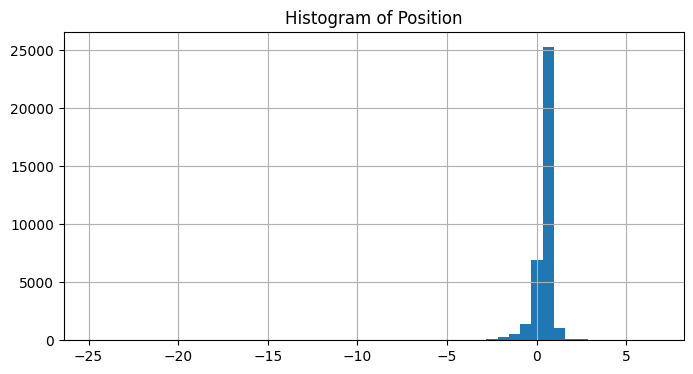

In [16]:
import matplotlib.pyplot as plt

features_validation['position'].hist(bins=50, figsize=(8, 4))
plt.title("Histogram of Position")
plt.grid(True)
plt.show()


In [206]:
study.optimize(objective, n_trials = 50, show_progress_bar = True)

Best trial: 33. Best value: 7.56175:  70%|███████   | 35/50 [01:50<00:47,  3.16s/it]

[W 2025-04-13 22:02:25,984] Trial 35 failed with parameters: {'iterations': 891, 'depth': 5, 'learning_rate': 0.25070071154713663, 'l2_leaf_reg': 0.49589738917719156, 'bagging_temperature': 0.918374815245819, 'random_strength': 0.28340028174851506} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_12778/3140595610.py", line 24, in objective
    model.fit(train_pool)
    ~~~~~~~~~^^^^^^^^^^^^
  File "/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [187]:
best_params = study.best_params

In [173]:
best_params = {
    "iterations": 200,
    "depth": 4,
    "learning_rate": 0.03,
    "l2_leaf_reg": 2,
    "bagging_temperature": 0.7,
    "random_strength": 0.3,
    "leaf_estimation_method": "Gradient",
    "min_data_in_leaf": 3,  # по умолчанию 1,
    "loss_function": "RMSE",
}

In [46]:
fi = model.get_feature_importance(prettified=True)
print(fi.head(10))


  Feature Id  Importances
0          0    23.180703
1          1    16.308450
2          2    15.651195
3          6     8.067883
4          3     7.249128
5          7     6.780561
6          4     6.039984
7          9     5.871385
8          8     5.747908
9          5     5.102802


In [ ]:
import pandas as pd
df = pd.DataFrame({
    'pred': test_preds,
    'true': y_test
})
print(df.corr())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0291577	test: 0.0272576	best: 0.0272576 (0)	total: 834us	remaining: 166ms
1:	learn: 0.0291493	test: 0.0272578	best: 0.0272576 (0)	total: 1.43ms	remaining: 142ms
2:	learn: 0.0291424	test: 0.0272566	best: 0.0272566 (2)	total: 2.19ms	remaining: 144ms
3:	learn: 0.0291366	test: 0.0272550	best: 0.0272550 (3)	total: 2.79ms	remaining: 137ms
4:	learn: 0.0291300	test: 0.0272549	best: 0.0272549 (4)	total: 3.33ms	remaining: 130ms
5:	learn: 0.0291201	test: 0.0272550	best: 0.0272549 (4)	total: 3.89ms	remaining: 126ms
6:	learn: 0.0291114	test: 0.0272551	best: 0.0272549 (4)	total: 4.48ms	remaining: 123ms
7:	learn: 0.0291020	test: 0.0272548	best: 0.0272548 (7)	total: 5.36ms	remaining: 129ms
8:	learn: 0.0290977	test: 0.0272552	best: 0.0272548 (7)	total: 6.36ms	remaining: 135ms
9:	learn: 0.0290891	test: 0.0272553	best: 0.0272548 (7)	total: 7.09ms	remaining: 135ms
10:	learn: 0.0290816	test: 0.0272558	best: 0.0272548 (7)	total: 7.73ms	remaining: 133ms
11:	learn: 0.0290736	test: 0.0272557	best: 

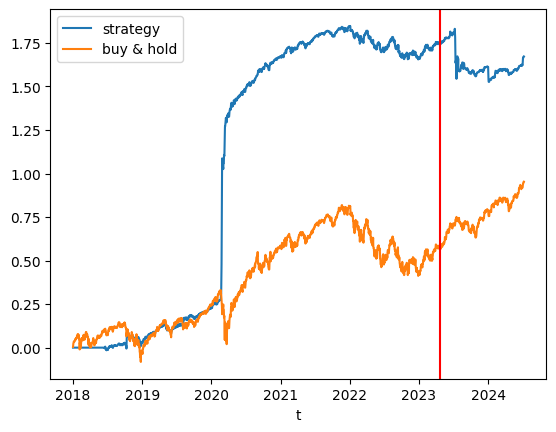

In [175]:
model = CatBoostRegressor(**best_params)

train_pool = Pool(data = X_train,
                  label = y_train)

model.fit(train_pool, eval_set = (X_validation, y_validation), plot = True, use_best_model = True)

features['position'] = model.predict(X)/ (model.predict(X_train).std() + 1e-6)

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0)

# Maximum position limit
pos_limit = 10
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = features.index[validation_split_idx], color = 'red')

# plt.savefig(r'catboost_model.png', dpi = 1200)
# plt.savefig(r'catboost_model_lowq.png')


/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_1363/88866797.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df['log_ret'].resample('4H').sum().to_frame('log_ret')


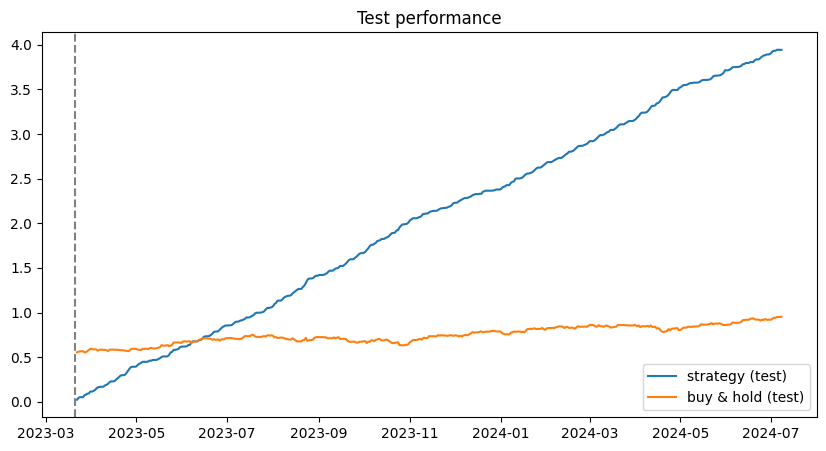

In [186]:
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()

df_4h = df['log_ret'].resample('4H').sum().to_frame('log_ret')

data = df_4h.loc[~(df_4h['log_ret'] == 0)].copy()


# 2. Функция генерации признаков (пример для 4H-баров)
def make_features(data):
    X = pd.DataFrame(index=data.index)
    # лаги
    for lag in [1, 2, 3, 5]:
        X[f'lag_{lag}'] = data['log_ret'].shift(lag)
    # rolling-статистика
    X['mean_3'] = data['log_ret'].rolling(3).mean()
    X['std_3']  = data['log_ret'].rolling(3).std()
    X['mom_3']  = data['log_ret'].rolling(3).sum()
    X['rolling_std_5'] = data['log_ret'].rolling(5).std()
    X['z_score'] = data['log_ret'] / (X['rolling_std_5'] + 1e-8)
    X['log_ret_abs'] = data['log_ret'].abs()
    X['log_ret_squared'] = data['log_ret']**2
    X['sign'] = np.sign(data['log_ret'])
    X['price'] = 1.0 * np.exp(data['log_ret'].cumsum())

    # # Estimating asset volatility using double exponential moving average:
    X['absRet'] = np.abs(data['log_ret'])
    X['EmaAbsRet'] = X['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    X['vol'] = X['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001
    # нормализация через EWMA-волатильность
    vol = data['log_ret'].abs().ewm(span=20).mean().ewm(span=200).mean()
    X['nr'] = data['log_ret'] / (vol + 1e-8)

    delta = X['price'].diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up = gain.ewm(span=14).mean()
    roll_down = loss.ewm(span=14).mean()
    X['rsi_14'] = 100 - 100/(1 + roll_up/(roll_down+1e-8))

    X['ma20'] = X['price'].rolling(20).mean()
    X['std20'] = X['price'].rolling(20).std()
    X['bb_upper'] = X['ma20'] + 2*X['std20']
    X['bb_lower'] = X['ma20'] - 2*X['std20']

    ema12 = X['price'].ewm(span=12).mean()
    ema26 = X['price'].ewm(span=26).mean()
    X['macd'] = ema12 - ema26
    X['macd_signal'] = X['macd'].ewm(span=9).mean()

    X['skew_10'] = data['log_ret'].rolling(10).skew()
    X['kurt_10'] = data['log_ret'].rolling(10).kurt()
    X['q90_30'] = data['log_ret'].rolling(30).quantile(0.9)

    return X.dropna()

features = make_features(data)

# 3. Целевой вектор — та же нормализованная log_ret
y = features['nr'].values
X = features.drop(columns=['nr']).values

# 4. Разбиение на train/val/test (60/20/20)
n = len(X)
i1 = int(0.6 * n)
i2 = int(0.8 * n)

X_train, y_train = X[:i1], y[:i1]
X_val,   y_val   = X[i1:i2], y[i1:i2]
X_test,  y_test  = X[i2:],    y[i2:]

feat_train = features.iloc[:i1]
feat_val   = features.iloc[i1:i2]
feat_test  = features.iloc[i2:]


# 5. Обучаем модель на train + ранняя остановка по val
best_params = {
    'iterations': 500,
    'depth': 4,
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'random_strength': 1.0,
    'loss_function': 'RMSE',
    'logging_level': 'Silent'
}
model = CatBoostRegressor(**best_params)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

# 6. Предикт на тесте и формирование сигналов
preds_test = model.predict(X_test)
scale = np.std(model.predict(X_train)) + 1e-6
raw = preds_test / scale

# Порог >0.7 → лонг; <0.3 → шорт; иначе flat
pos = np.where(raw > 0.7,  1,
      np.where(raw < 0.3, -1, 0))

# Помещаем в DataFrame с нужным индексом
feat_test = feat_test.copy()
feat_test['position'] = pos

# 7. Рассчитываем PnL и equity curve
slippage = 1e-5
# Берём log_ret точно по тем же 4H-меткам
ret_test_4h = data['log_ret'].loc[feat_test.index]

pnl = (ret_test_4h * feat_test['position']
     - slippage * feat_test['position'].diff().abs()).fillna(0)

# Переводим в дневной вид для сравнения
equity = pnl.resample('1D').sum().cumsum()
bh     = data['log_ret'].resample('1D').sum().cumsum()

start_test = feat_test.index[0]
equity_test = equity.loc[start_test:]
bh_test     = bh.loc[start_test:]

# 8. График
plt.figure(figsize=(10,5))
plt.plot(equity_test, label='strategy (test)')
plt.plot(bh_test,     label='buy & hold (test)')
plt.axvline(equity.index[0], color='gray', linestyle='--')  # начало теста
plt.legend()
plt.title('Test performance')
plt.show()


In [ ]:
days_in_year = 365.25

def Return(rets):
    return np.mean(rets)*days_in_year


def Volatility(rets):
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

In [202]:
rets = equity_test.resample('1D').sum()

In [200]:
print(rets)

963.0456184530896


In [203]:
rets.sum()/(np.std(rets)*np.sqrt(days_in_year))

np.float64(43.58375945485671)

In [184]:
feat_test['position'].value_counts()

position
-1    1411
 0     343
 1     331
Name: count, dtype: int64

Sharpe ratio = 1.88
Annual Return = 1.22
Annual Std = 0.65


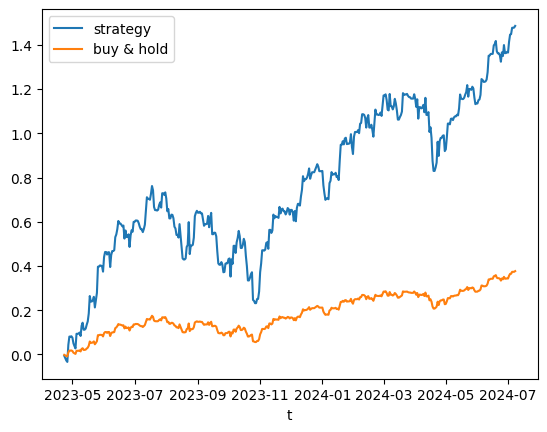

In [165]:
stats = statistics_calc(eq[features.index[validation_split_idx]:], bh[features.index[validation_split_idx]:], plot = True)

In [149]:
scaler = StandardScaler()
X_train_val = np.concatenate([X_train, X_validation])
y_train_val = np.concatenate([y_train, y_validation])

X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

final_model = CatBoostRegressor(**best_params, logging_level='Silent')
final_model.fit(X_train_val_scaled, y_train_val)

In [67]:
features_test['position'].value_counts()
#print(len(features_test))

position
1    7260
0    1622
2     141
3       6
Name: count, dtype: int64

In [169]:
test_preds = final_model.predict(X_test_scaled)

scale = np.max(np.abs(final_model.predict(X_train_val))) + 1e-6
features_test = features.iloc[validation_split_idx:].copy()
features_test['position'] = test_preds / scale
features_test['position'] = features_test['position'].ewm(alpha=0.02).mean()
features_test['position'] = np.where(features_test['position'] > 0.7, 1, np.where(features_test['position'] < 0.3, -1, 0))



In [151]:
scale = np.max(np.abs(model.predict(X_train))) + 1e-6
print(scale)

0.16306551921990253


In [152]:
val_preds = model.predict(X_validation)
print("Прогнозы: mean =", np.mean(val_preds), ", min =", np.min(val_preds), ", max =", np.max(val_preds))

Прогнозы: mean = 0.00851507658720533 , min = -0.03587445661532556 , max = 0.16306451921990253


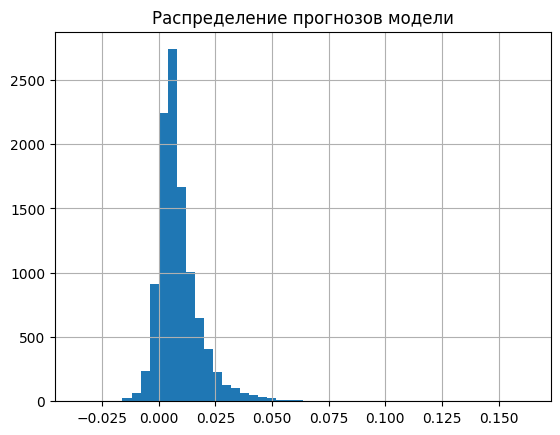

In [153]:
plt.hist(val_preds, bins=50)
plt.title("Распределение прогнозов модели")
plt.grid(True)
plt.show()


In [171]:
print(data.index.dtype)
print(features_test.index.dtype)

print(data.index.min(), data.index.max())
print(features_test.index.min(), features_test.index.max())


datetime64[ns]
datetime64[ns]
2018-01-01 16:00:00 2024-07-08 08:00:00
2023-04-22 20:00:00 2024-07-08 08:00:00


In [ ]:
slippage = 0.00001
log_ret_test = data['log_ret'].loc[features_test.index]

pnl_test = (log_ret_test * features_test['position'] -
            slippage * features_test['position'].diff().abs()).fillna(0)

equity_test = pnl_test.resample('1D').sum()
bh_test = log_ret_test.fillna(0).resample('1D').sum()

# График
equity_test.cumsum().plot(label="strategy (test)")
bh_test.cumsum().plot(label="buy & hold (test)")
plt.legend()
plt.title("Test performance")
plt.grid(True)
plt.show()


KeyError: 'log_ret'

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Sharpe ratio = 2.79
Annual Return = 0.94
Annual Std = 0.34


/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


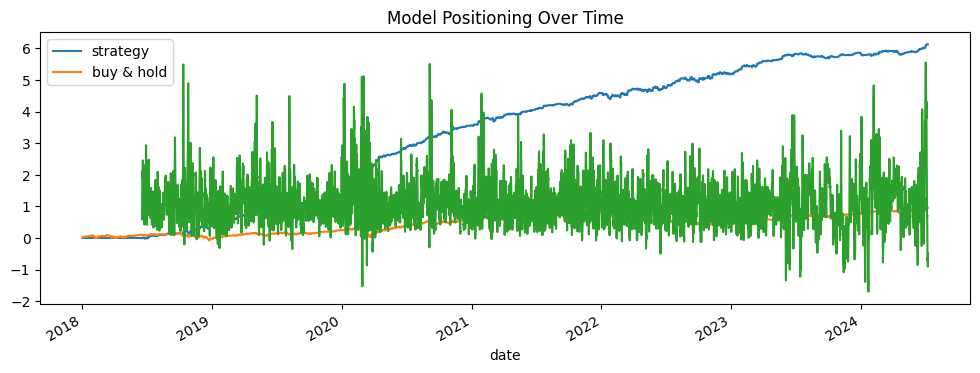

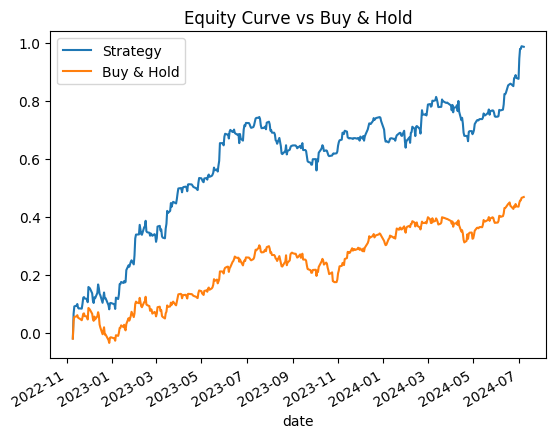

In [168]:
# Объединение train + validation
X_train_val = np.concatenate([X_train, X_validation])
y_train_val = np.concatenate([y_train, y_validation])

# Вручную заданные параметры
best_params = {
    "iterations": 200,
    "depth": 4,
    "learning_rate": 0.02,
    "l2_leaf_reg": 7,
    "bagging_temperature": 0.5,
    "random_strength": 0.3,
    "leaf_estimation_method": "Gradient",
    "boosting_type": "Plain"
    #"min_data_in_leaf": 10  # по умолчанию 1
}

# Обучение модели
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor(
    **best_params,
    loss_function='Quantile:alpha=0.7',
    logging_level='Silent'
)

train_pool = Pool(data=X_train_val, label=y_train_val)
model.fit(train_pool, eval_set=(X_test, y_test), plot=True, use_best_model=False)

# Прогноз и построение позиции
features['position'] = model.predict(X) / model.predict(X_train_val).std()
features['position'] = features['position'].ewm(alpha=0.22).mean()
features['position'] = features['position'].fillna(0)

# Ограничение позиции
pos_limit = 100
features['position'] = features['position'].clip(-pos_limit, pos_limit)

# Расчёт прибыли
slippage = 0.00001
eq = (data['log_ret'] * features['position'] -
      slippage * features['position'].diff().abs()).fillna(0).resample('1D').sum()

bh = data['log_ret'].fillna(0).resample('1D').sum()

# Расчёт метрик и визуализация
stats = statistics_calc(eq, bh, plot=True)

# Отметим границу между train+val и test
#split_date = X_test.index[0]
#plt.axvline(x=split_date, color='red', linestyle='--')

# Отобразим позиции
features['position'].plot(title='Model Positioning Over Time', figsize=(12, 4))
plt.show()

test_idx = data.index[-len(X_test):] 
eq_test = eq.loc[eq.index.intersection(test_idx)]
bh_test = bh.loc[bh.index.intersection(test_idx)]

# Выведем equity-криву и buy&hold
eq_test.cumsum().plot(label='Strategy')
bh_test.cumsum().plot(label='Buy & Hold')
plt.legend()
plt.title('Equity Curve vs Buy & Hold')
plt.show()


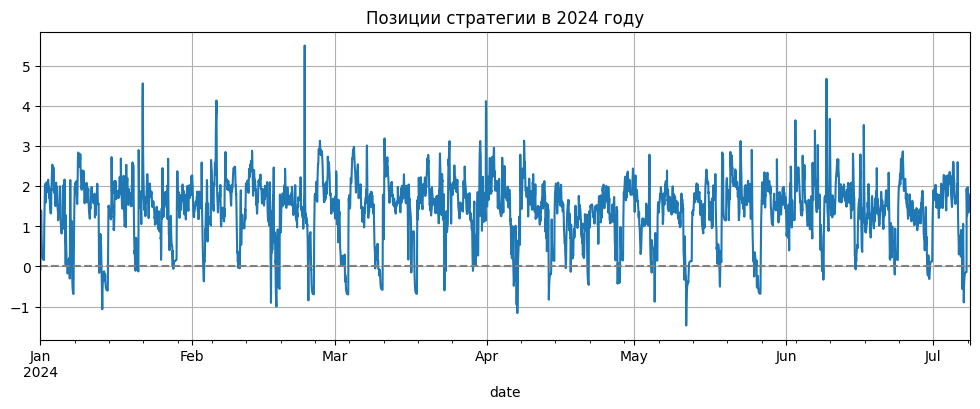

In [125]:
features['position'].loc['2024'].plot(figsize=(12, 4), title='Позиции стратегии в 2024 году')
plt.axhline(0, color='gray', linestyle='--')
plt.grid()
plt.show()



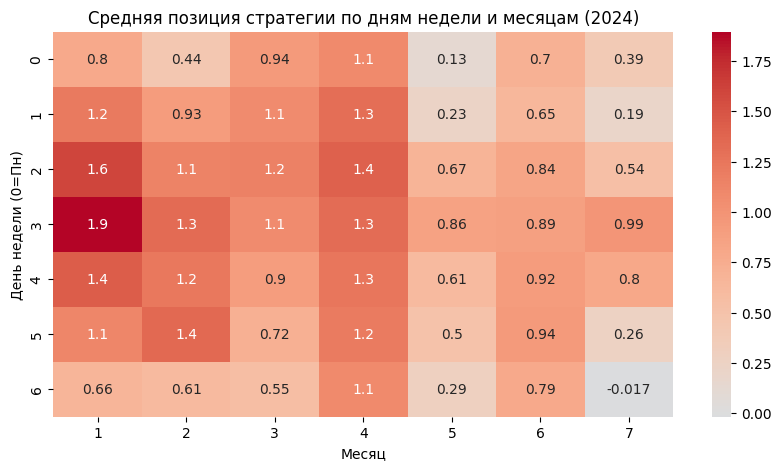

In [157]:
import seaborn as sns

# День недели и месяц
features['weekday'] = features.index.weekday
features['month'] = features.index.month
features['year'] = features.index.year

# Группируем по 2024 году
positions_2024 = features.loc[features['year'] == 2024]

# Считаем среднюю позицию по месяцу и дню недели
pivot = positions_2024.pivot_table(values='position', index='weekday', columns='month', aggfunc='mean')

# Визуализация
plt.figure(figsize=(10, 5))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Средняя позиция стратегии по дням недели и месяцам (2024)')
plt.ylabel('День недели (0=Пн)')
plt.xlabel('Месяц')
plt.show()
